# library imports : 

In [12]:
import time 

import torch 
import torchvision 
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import math 
import numpy as np 
import matplotlib.pyplot as plt 

import h5py
from sklearn.model_selection import train_test_split

In [13]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    


# data input/ analysis / visualisation : 

In [14]:
file_path = "data/MNISTdata.hdf5"
with h5py.File(file_path, 'r') as f:
  # in the hdf5 file the data is stored in a dictionary like format 
  # the keys of the dictionary are 'input' and 'output' for X, y. 
  # type casting it as a numpy array. 
   X = np.array(f['input']) 
   y = np.array(f['output']) 

In [15]:
# shapes of the input data and the output data : 
print(f" the shape of the input data : {X.shape}, the shape of the output data : {y.shape}")

 the shape of the input data : (2000, 28, 28, 1), the shape of the output data : (2000, 1)


In [16]:
# to work with torch let us shape the image array X into 2000, 1, 28, 28 for convinience
X = X.reshape(2000, 1, 28, 28)
y = y.reshape(y.shape[0])

In [17]:
# in pytorch the data has to be fed into the system using a dataloader, also for the dataloader
# we have to make the numpy arrays as tensor datasets. 

class DataSet(Dataset):

  def __init__(self, feats, labels):
    """
    initiliser for the class, this will 
    take in the training features, labels
    return the torch.Tensor datasets. 
    """
    self.n_samples = feats.shape[0]
    self.x_data = torch.from_numpy(feats.reshape(-1, 784)).to(torch.float32)
    self.y_data = torch.from_numpy(labels)

  def __getitem__(self, index):
    """
    index based calls can be made due to this 
    method. 
    """
    return self.x_data[index], self.y_data[index]


  def __len__(self):
    """
    returns the length of the dataset. 
    """
    return self.n_samples

*instead of reshaping the images into a vector here , what we plan to do is to reshape the array in the main training loop instead.*

*splitting the numpy data into training and test sets : (the ratio of test size  & train size = 3 : 7 ; hence the number of samples in the training set = 1400 and the number of samples in the test set = 600)*

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.3)

first_five_test_images = X_test[:5, :, :, :]
first_five_test_image_labels = y_test[:5]

# a tensor dataset from these numpy arrays using the dataset class created above. 
MNIST_TRAIN = DataSet(X_train, y_train)
MNIST_TEST = DataSet(X_test, y_test)
MNIST_FIRST_FIVE = DataSet(first_five_test_images, first_five_test_image_labels)



# creating corresponding dataloaders to be utilised by the neural net.
batch_size = 512
mnist_train_loader = torch.utils.data.DataLoader(dataset=MNIST_TRAIN, 
                                           batch_size=batch_size, 
                                           shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(dataset=MNIST_TEST, 
                                          batch_size=batch_size, 
                                          shuffle=False)


first_five_loader = torch.utils.data.DataLoader(dataset = MNIST_FIRST_FIVE, batch_size = 1, shuffle = False)

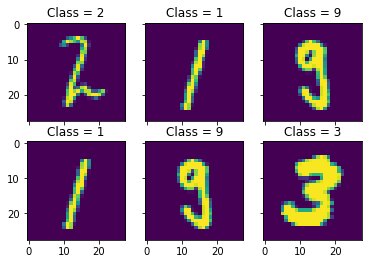

In [19]:
# visualising the first six test images and the correct labels : 
fig, axs = plt.subplots(2, 3)

for i in range(2):
  for j in range(3):
    axs[i, j].imshow(X_test[i+j, 0, :, :])
    axs[i, j].set_title(f"Class = {y_test[i+j]}")

for ax in axs.flat:
    ax.label_outer()

In [20]:
print(f"for the training set; input size : {X_train.shape}, output size : {y_train.shape}")
print(f"for the test set; input size : {X_test.shape}, output size : {y_test.shape}")

for the training set; input size : (1400, 1, 28, 28), output size : (1400,)
for the test set; input size : (600, 1, 28, 28), output size : (600,)


In [21]:
print(f"input shape for the training set is {MNIST_TRAIN[0][0].shape}, output shape is {MNIST_TRAIN[0][1].shape}")
print(f"input shape for the testing set is {MNIST_TEST[0][0].shape}, output shape is {MNIST_TEST[0][1].shape}")

input shape for the training set is torch.Size([784]), output shape is torch.Size([])
input shape for the testing set is torch.Size([784]), output shape is torch.Size([])


*As the problem is classification ; and we have multiple classes the best possible loss function for us is the  crossentropy loss ; for PyTorch we usually avoid adding any softmax layer in the network at the end as the BCELoss() calculates the crossentropy loss and the negative log likelihood loss*

# Model Configurations :

in this section we will define the model classes - 1 to 4 as specified in the lab sheet. 

- Model-configuration – 1: Build a 1-hidden layer network with 50 hidden units.
- Model-configuration – 2: Build a 2-hidden layer network with 400 and 200 hidden units for the first layer and second layer, respectively.
- Model-configuration – 3: Build a 2-hidden layer network with 400 units in the first hidden layer and 200 units in the second hidden layer, respectively. Use the ReLU activation between the input and hidden layer-1, and between the hidden layer-1 and hidden layer-2.
- Model-configuration – 4: Build 2-hidden layer network with 400 and 200 hidden units respectively with following configuration: Input →linear1→batch normalization→dropout→ReLU→linear2→output

In [26]:
class model_1(nn.Module):

  def __init__(self, i, h1, n_classes):
    super(model_1, self).__init__()

    self.input_size = i
    self.l1 = nn.Linear(i, h1) 
    self.l2 = nn.Linear(h1, n_classes)

  def forward(self, x):
    out = self.l1(x)
    out = self.l2(out)
    
    return out  

In [27]:
class model_2(nn.Module):

  def __init__(self, i, h1, h2, n_classes):
    super(model_2, self).__init__()

    self.input_size = i
    self.l1 = nn.Linear(i, h1) 
    self.l2 = nn.Linear(h1, h2)
    self.l3 = nn.Linear(h2, n_classes)

  def forward(self, x):
    out = self.l1(x)
    out = self.l2(out)
    out = self.l3(out)
    
    return out 

In [28]:
class model_3(nn.Module):

  def __init__(self, i, h1, h2, n_classes):
    super(model_3, self).__init__()

    self.input_size = i
    self.l1 = nn.Linear(i, h1) 
    self.r1 = nn.ReLU()
    self.l2 = nn.Linear(h1, h2)
    self.r2 = nn.ReLU()
    self.l3 = nn.Linear(h2, n_classes)

  def forward(self, x):
    out = self.l1(x)
    out = self.r1(out)
    out = self.l2(out)
    out = self.r2(out)
    out = self.l3(out)
    
    return out 

In [29]:
class model_4(nn.Module):

  def __init__(self, i, h1, h2, n_classes):
    super(model_4, self).__init__()

    self.input_size = i
    self.l1 = nn.Linear(i, h1) 
    self.r1 = nn.ReLU()    
    self.l2 = nn.Linear(h1, h2)
    self.bn = nn.BatchNorm1d(h2)
    self.drop = nn.Dropout(0.25)
    self.r2 = nn.ReLU()
    self.l3 = nn.Linear(h2, n_classes)

  def forward(self, x):
    out = self.l1(x)
    out = self.r1(out)
    out = self.l2(out)
    out = self.bn(out)
    out = self.drop(out)
    out = self.r2(out)
    out = self.l3(out)
    
    return out 

# Training Configurations : 

in this section we will define a dictionary of the training paramters that will be used in the training loop. 

In [30]:
training_configs = {"1":(0.05, 0.001), "2":(0.001, 0.0001), "3":(0.0001, 0.00001)}

In [31]:
model_configs = {"1": model_1(784, 50, 10) , "2": model_2(784, 400, 200, 10), "3": model_3(784, 400, 200, 10) , "4": model_4(784, 400, 200, 10)}

# Training loop :
in this section we will define the training loop and functions for drawing the plots, namely :


*   Epoch vs Training loss
*   Epoch vs Testing loss
*   Epoch vs Accuracy

also we have to plot the ground truth results for each training loop (the first five at least). we will define a function for that too.




In [32]:
from tqdm import tqdm

In [33]:
def accuracy_plots(train_accu, eval_accu):
  plt.figure(figsize=(20, 5))
  plt.plot(train_accu)
  plt.plot(eval_accu,'--')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(['Train','Valid'])
  plt.title('Train vs Valid Accuracy')
  
  plt.show()

def loss_plots(train_losses, eval_losses):
  plt.figure(figsize=(20, 5))
  plt.plot(train_losses)
  plt.plot(eval_losses,'--')
  plt.xlabel('epoch')
  plt.ylabel('losses')
  plt.legend(['Train','Valid'])
  plt.title('Train vs Valid Losses')
  
  plt.show()

In [34]:
def train(idx_model, idx_train):
  """
  training loop function for training the feed-forward network. 
  -----------------------------------------------------------------
  i : the training config to be used ; using the dictionary defined.
  model : the neural network config to be used 
  """

  device = torch.device('cpu')
  model = model_configs[idx_model]
  num_epochs = 1000

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  learning_rate, weight_decay = training_configs[idx_train]
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)  

  train_losses=[]
  train_accu=[]
  eval_losses=[]
  eval_accu=[]

  
  best_accuracy = 0
  count_parameters(model)
  for epoch in range(1, num_epochs+1): 
    #train 
    print('\nEpoch : %d'%epoch)
    
    model.train()

    running_loss=0
    correct=0
    total=0
  
    for data in tqdm(mnist_train_loader):
      
      inputs,labels=data[0].to(device),data[1].to(device)
      
      optimizer.zero_grad()
      outputs=model(inputs)
      loss=criterion(outputs,labels)
      loss.backward()
      optimizer.step()
  
      running_loss += loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
        
    train_loss=running_loss/len(mnist_train_loader)
    accu=100.*correct/total
    
    train_accu.append(accu)
    train_losses.append(train_loss)
    # print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

    #eval 
    model.eval()
 
    running_loss=0
    correct=0
    total=0
  
    with torch.no_grad():
      for data in tqdm(mnist_test_loader):
        images,labels=data[0].to(device),data[1].to(device)
        
        outputs=model(images)
  
        loss= criterion(outputs,labels)
        running_loss+=loss.item()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    test_loss=running_loss/len(mnist_test_loader)
    accu=100.*correct/total
  

    if accu > best_accuracy: 
      best_accuracy = accu
      torch.save(model.state_dict(), f"models/best_model_parameters{idx_model}{idx_train}.pth")
      

    eval_losses.append(test_loss)
    eval_accu.append(accu)
  

  
  return eval_losses, train_losses, eval_accu, train_accu 
      
      

# model 1, test config 1

In [35]:
s = time.time()
eval_losses, train_losses, eval_accu, train_accu = train("1", "1")
e = time.time()

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |   39200    |
|  l1.bias  |     50     |
| l2.weight |    500     |
|  l2.bias  |     10     |
+-----------+------------+
Total Trainable Params: 39760

Epoch : 1


100%|██████████| 2/2 [00:00<00:00, 253.02it/s]



Epoch : 2


100%|██████████| 2/2 [00:00<00:00, 275.49it/s]



Epoch : 3


100%|██████████| 2/2 [00:00<00:00, 233.25it/s]



Epoch : 4


100%|██████████| 2/2 [00:00<00:00, 289.60it/s]



Epoch : 5


100%|██████████| 2/2 [00:00<00:00, 245.65it/s]



Epoch : 6


100%|██████████| 2/2 [00:00<00:00, 230.70it/s]



Epoch : 7


100%|██████████| 2/2 [00:00<00:00, 266.41it/s]



Epoch : 8


100%|██████████| 2/2 [00:00<00:00, 318.17it/s]



Epoch : 9


100%|██████████| 2/2 [00:00<00:00, 261.56it/s]



Epoch : 10


100%|██████████| 2/2 [00:00<00:00, 234.50it/s]



Epoch : 11


100%|██████████| 2/2 [00:00<00:00, 175.70it/s]



Epoch : 12


100%|██████████| 2/2 [00:00<00:00, 275.98it/s]



Epoch : 13


100%|██████████| 2/2 [00:00<00:00, 267.77it/s]



Epoch : 14


100%|██████████| 2/2 [00:00<00:00, 220.71it/s]



Epoch : 15


100%|██████████| 2/2 [00:00<00:00, 235.69it/s]



Epoch : 16


100%|██████████| 2/2 [00:00<00:00, 145.58it/s]



Epoch : 17


100%|██████████| 2/2 [00:00<00:00, 221.57it/s]



Epoch : 18


100%|██████████| 2/2 [00:00<00:00, 190.82it/s]



Epoch : 19


100%|██████████| 2/2 [00:00<00:00, 165.68it/s]



Epoch : 20


100%|██████████| 2/2 [00:00<00:00, 201.24it/s]



Epoch : 21


100%|██████████| 2/2 [00:00<00:00, 173.83it/s]



Epoch : 22


100%|██████████| 2/2 [00:00<00:00, 159.87it/s]



Epoch : 23


100%|██████████| 2/2 [00:00<00:00, 135.75it/s]



Epoch : 24


100%|██████████| 2/2 [00:00<00:00, 255.21it/s]



Epoch : 25


100%|██████████| 2/2 [00:00<00:00, 238.27it/s]



Epoch : 26


100%|██████████| 2/2 [00:00<00:00, 235.65it/s]



Epoch : 27


100%|██████████| 2/2 [00:00<00:00, 221.62it/s]



Epoch : 28


100%|██████████| 2/2 [00:00<00:00, 219.01it/s]



Epoch : 29


100%|██████████| 2/2 [00:00<00:00, 217.30it/s]



Epoch : 30


100%|██████████| 2/2 [00:00<00:00, 229.90it/s]



Epoch : 31


100%|██████████| 2/2 [00:00<00:00, 228.33it/s]



Epoch : 32


100%|██████████| 2/2 [00:00<00:00, 228.37it/s]



Epoch : 33


100%|██████████| 2/2 [00:00<00:00, 326.18it/s]



Epoch : 34


100%|██████████| 2/2 [00:00<00:00, 236.39it/s]



Epoch : 35


100%|██████████| 2/2 [00:00<00:00, 170.49it/s]



Epoch : 36


100%|██████████| 2/2 [00:00<00:00, 228.12it/s]



Epoch : 37


100%|██████████| 2/2 [00:00<00:00, 177.43it/s]



Epoch : 38


100%|██████████| 2/2 [00:00<00:00, 198.20it/s]



Epoch : 39


100%|██████████| 2/2 [00:00<00:00, 209.77it/s]



Epoch : 40


100%|██████████| 2/2 [00:00<00:00, 231.44it/s]



Epoch : 41


100%|██████████| 2/2 [00:00<00:00, 233.34it/s]



Epoch : 42


100%|██████████| 2/2 [00:00<00:00, 268.25it/s]



Epoch : 43


100%|██████████| 2/2 [00:00<00:00, 242.77it/s]



Epoch : 44


100%|██████████| 2/2 [00:00<00:00, 218.52it/s]



Epoch : 45


100%|██████████| 2/2 [00:00<00:00, 226.34it/s]



Epoch : 46


100%|██████████| 2/2 [00:00<00:00, 213.22it/s]



Epoch : 47


100%|██████████| 2/2 [00:00<00:00, 237.48it/s]



Epoch : 48


100%|██████████| 2/2 [00:00<00:00, 192.16it/s]



Epoch : 49


100%|██████████| 2/2 [00:00<00:00, 213.34it/s]



Epoch : 50


100%|██████████| 2/2 [00:00<00:00, 163.39it/s]



Epoch : 51


100%|██████████| 2/2 [00:00<00:00, 221.60it/s]



Epoch : 52


100%|██████████| 2/2 [00:00<00:00, 260.41it/s]



Epoch : 53


100%|██████████| 2/2 [00:00<00:00, 262.95it/s]



Epoch : 54


100%|██████████| 2/2 [00:00<00:00, 227.54it/s]



Epoch : 55


100%|██████████| 2/2 [00:00<00:00, 227.96it/s]



Epoch : 56


100%|██████████| 2/2 [00:00<00:00, 192.51it/s]



Epoch : 57


100%|██████████| 2/2 [00:00<00:00, 257.65it/s]



Epoch : 58


100%|██████████| 2/2 [00:00<00:00, 217.59it/s]



Epoch : 59


100%|██████████| 2/2 [00:00<00:00, 279.83it/s]



Epoch : 60


100%|██████████| 2/2 [00:00<00:00, 197.00it/s]



Epoch : 61


100%|██████████| 2/2 [00:00<00:00, 302.28it/s]



Epoch : 62


100%|██████████| 2/2 [00:00<00:00, 177.63it/s]



Epoch : 63


100%|██████████| 2/2 [00:00<00:00, 205.87it/s]



Epoch : 64


100%|██████████| 2/2 [00:00<00:00, 210.97it/s]



Epoch : 65


100%|██████████| 2/2 [00:00<00:00, 196.49it/s]



Epoch : 66


100%|██████████| 2/2 [00:00<00:00, 222.86it/s]



Epoch : 67


100%|██████████| 2/2 [00:00<00:00, 250.83it/s]



Epoch : 68


100%|██████████| 2/2 [00:00<00:00, 167.84it/s]



Epoch : 69


100%|██████████| 2/2 [00:00<00:00, 222.10it/s]



Epoch : 70


100%|██████████| 2/2 [00:00<00:00, 275.61it/s]



Epoch : 71


100%|██████████| 2/2 [00:00<00:00, 212.95it/s]



Epoch : 72


100%|██████████| 2/2 [00:00<00:00, 176.18it/s]



Epoch : 73


100%|██████████| 2/2 [00:00<00:00, 155.21it/s]



Epoch : 74


100%|██████████| 2/2 [00:00<00:00, 203.10it/s]



Epoch : 75


100%|██████████| 2/2 [00:00<00:00, 164.77it/s]



Epoch : 76


100%|██████████| 2/2 [00:00<00:00, 216.05it/s]



Epoch : 77


100%|██████████| 2/2 [00:00<00:00, 207.83it/s]



Epoch : 78


100%|██████████| 2/2 [00:00<00:00, 204.38it/s]



Epoch : 79


100%|██████████| 2/2 [00:00<00:00, 160.07it/s]



Epoch : 80


100%|██████████| 2/2 [00:00<00:00, 150.93it/s]



Epoch : 81


100%|██████████| 2/2 [00:00<00:00, 195.39it/s]



Epoch : 82


100%|██████████| 2/2 [00:00<00:00, 223.07it/s]



Epoch : 83


100%|██████████| 2/2 [00:00<00:00, 187.85it/s]



Epoch : 84


100%|██████████| 2/2 [00:00<00:00, 203.95it/s]



Epoch : 85


100%|██████████| 2/2 [00:00<00:00, 183.14it/s]



Epoch : 86


100%|██████████| 2/2 [00:00<00:00, 219.07it/s]



Epoch : 87


100%|██████████| 2/2 [00:00<00:00, 214.44it/s]



Epoch : 88


100%|██████████| 2/2 [00:00<00:00, 183.45it/s]



Epoch : 89


100%|██████████| 2/2 [00:00<00:00, 226.36it/s]



Epoch : 90


100%|██████████| 2/2 [00:00<00:00, 225.60it/s]



Epoch : 91


100%|██████████| 2/2 [00:00<00:00, 211.07it/s]



Epoch : 92


100%|██████████| 2/2 [00:00<00:00, 216.72it/s]



Epoch : 93


100%|██████████| 2/2 [00:00<00:00, 211.32it/s]



Epoch : 94


100%|██████████| 2/2 [00:00<00:00, 223.91it/s]



Epoch : 95


100%|██████████| 2/2 [00:00<00:00, 210.40it/s]



Epoch : 96


100%|██████████| 2/2 [00:00<00:00, 176.46it/s]



Epoch : 97


100%|██████████| 2/2 [00:00<00:00, 220.92it/s]



Epoch : 98


100%|██████████| 2/2 [00:00<00:00, 201.15it/s]



Epoch : 99


100%|██████████| 2/2 [00:00<00:00, 185.71it/s]



Epoch : 100


100%|██████████| 2/2 [00:00<00:00, 187.87it/s]



Epoch : 101


100%|██████████| 2/2 [00:00<00:00, 294.44it/s]



Epoch : 102


100%|██████████| 2/2 [00:00<00:00, 212.07it/s]



Epoch : 103


100%|██████████| 2/2 [00:00<00:00, 232.15it/s]



Epoch : 104


100%|██████████| 2/2 [00:00<00:00, 209.09it/s]



Epoch : 105


100%|██████████| 2/2 [00:00<00:00, 189.89it/s]



Epoch : 106


100%|██████████| 2/2 [00:00<00:00, 223.91it/s]



Epoch : 107


100%|██████████| 2/2 [00:00<00:00, 217.61it/s]



Epoch : 108


100%|██████████| 2/2 [00:00<00:00, 198.36it/s]



Epoch : 109


100%|██████████| 2/2 [00:00<00:00, 187.58it/s]



Epoch : 110


100%|██████████| 2/2 [00:00<00:00, 279.82it/s]



Epoch : 111


100%|██████████| 2/2 [00:00<00:00, 213.03it/s]



Epoch : 112


100%|██████████| 2/2 [00:00<00:00, 178.29it/s]



Epoch : 113


100%|██████████| 2/2 [00:00<00:00, 256.27it/s]



Epoch : 114


100%|██████████| 2/2 [00:00<00:00, 170.85it/s]



Epoch : 115


100%|██████████| 2/2 [00:00<00:00, 201.32it/s]



Epoch : 116


100%|██████████| 2/2 [00:00<00:00, 131.28it/s]



Epoch : 117


100%|██████████| 2/2 [00:00<00:00, 204.44it/s]



Epoch : 118


100%|██████████| 2/2 [00:00<00:00, 216.10it/s]



Epoch : 119


100%|██████████| 2/2 [00:00<00:00, 161.42it/s]



Epoch : 120


100%|██████████| 2/2 [00:00<00:00, 200.73it/s]



Epoch : 121


100%|██████████| 2/2 [00:00<00:00, 199.00it/s]



Epoch : 122


100%|██████████| 2/2 [00:00<00:00, 240.04it/s]



Epoch : 123


100%|██████████| 2/2 [00:00<00:00, 189.75it/s]



Epoch : 124


100%|██████████| 2/2 [00:00<00:00, 247.65it/s]



Epoch : 125


100%|██████████| 2/2 [00:00<00:00, 221.06it/s]



Epoch : 126


100%|██████████| 2/2 [00:00<00:00, 179.90it/s]



Epoch : 127


100%|██████████| 2/2 [00:00<00:00, 224.97it/s]



Epoch : 128


100%|██████████| 2/2 [00:00<00:00, 218.06it/s]



Epoch : 129


100%|██████████| 2/2 [00:00<00:00, 200.06it/s]



Epoch : 130


100%|██████████| 2/2 [00:00<00:00, 177.42it/s]



Epoch : 131


100%|██████████| 2/2 [00:00<00:00, 185.42it/s]



Epoch : 132


100%|██████████| 2/2 [00:00<00:00, 191.77it/s]



Epoch : 133


100%|██████████| 2/2 [00:00<00:00, 157.30it/s]



Epoch : 134


100%|██████████| 2/2 [00:00<00:00, 170.44it/s]



Epoch : 135


100%|██████████| 2/2 [00:00<00:00, 240.89it/s]



Epoch : 136


100%|██████████| 2/2 [00:00<00:00, 208.19it/s]



Epoch : 137


100%|██████████| 2/2 [00:00<00:00, 230.79it/s]



Epoch : 138


100%|██████████| 2/2 [00:00<00:00, 228.63it/s]



Epoch : 139


100%|██████████| 2/2 [00:00<00:00, 190.55it/s]



Epoch : 140


100%|██████████| 2/2 [00:00<00:00, 207.33it/s]



Epoch : 141


100%|██████████| 2/2 [00:00<00:00, 193.49it/s]



Epoch : 142


100%|██████████| 2/2 [00:00<00:00, 211.79it/s]



Epoch : 143


100%|██████████| 2/2 [00:00<00:00, 200.89it/s]



Epoch : 144


100%|██████████| 2/2 [00:00<00:00, 190.44it/s]



Epoch : 145


100%|██████████| 2/2 [00:00<00:00, 204.70it/s]



Epoch : 146


100%|██████████| 2/2 [00:00<00:00, 228.37it/s]



Epoch : 147


100%|██████████| 2/2 [00:00<00:00, 233.76it/s]



Epoch : 148


100%|██████████| 2/2 [00:00<00:00, 225.81it/s]



Epoch : 149


100%|██████████| 2/2 [00:00<00:00, 223.88it/s]



Epoch : 150


100%|██████████| 2/2 [00:00<00:00, 223.62it/s]



Epoch : 151


100%|██████████| 2/2 [00:00<00:00, 251.60it/s]



Epoch : 152


100%|██████████| 2/2 [00:00<00:00, 182.50it/s]



Epoch : 153


100%|██████████| 2/2 [00:00<00:00, 188.18it/s]



Epoch : 154


100%|██████████| 2/2 [00:00<00:00, 201.25it/s]



Epoch : 155


100%|██████████| 2/2 [00:00<00:00, 222.86it/s]



Epoch : 156


100%|██████████| 2/2 [00:00<00:00, 220.37it/s]



Epoch : 157


100%|██████████| 2/2 [00:00<00:00, 217.52it/s]



Epoch : 158


100%|██████████| 2/2 [00:00<00:00, 221.73it/s]



Epoch : 159


100%|██████████| 2/2 [00:00<00:00, 214.82it/s]


Epoch : 160

100%|██████████| 2/2 [00:00<00:00, 177.09it/s]



Epoch : 161


100%|██████████| 2/2 [00:00<00:00, 191.00it/s]



Epoch : 162


100%|██████████| 2/2 [00:00<00:00, 213.05it/s]



Epoch : 163


100%|██████████| 2/2 [00:00<00:00, 191.05it/s]



Epoch : 164


100%|██████████| 2/2 [00:00<00:00, 215.13it/s]



Epoch : 165


100%|██████████| 2/2 [00:00<00:00, 209.69it/s]



Epoch : 166


100%|██████████| 2/2 [00:00<00:00, 218.94it/s]



Epoch : 167


100%|██████████| 2/2 [00:00<00:00, 258.74it/s]



Epoch : 168


100%|██████████| 2/2 [00:00<00:00, 214.73it/s]



Epoch : 169


100%|██████████| 2/2 [00:00<00:00, 226.80it/s]



Epoch : 170


100%|██████████| 2/2 [00:00<00:00, 232.27it/s]



Epoch : 171


100%|██████████| 2/2 [00:00<00:00, 221.74it/s]



Epoch : 172


100%|██████████| 2/2 [00:00<00:00, 214.84it/s]



Epoch : 173


100%|██████████| 2/2 [00:00<00:00, 240.43it/s]



Epoch : 174


100%|██████████| 2/2 [00:00<00:00, 247.87it/s]



Epoch : 175


100%|██████████| 2/2 [00:00<00:00, 230.42it/s]



Epoch : 176


100%|██████████| 2/2 [00:00<00:00, 182.91it/s]



Epoch : 177


100%|██████████| 2/2 [00:00<00:00, 199.85it/s]



Epoch : 178


100%|██████████| 2/2 [00:00<00:00, 224.58it/s]



Epoch : 179


100%|██████████| 2/2 [00:00<00:00, 239.98it/s]



Epoch : 180


100%|██████████| 2/2 [00:00<00:00, 224.65it/s]



Epoch : 181


100%|██████████| 2/2 [00:00<00:00, 217.12it/s]



Epoch : 182


100%|██████████| 2/2 [00:00<00:00, 236.13it/s]



Epoch : 183


100%|██████████| 2/2 [00:00<00:00, 168.29it/s]



Epoch : 184


100%|██████████| 2/2 [00:00<00:00, 221.53it/s]



Epoch : 185


100%|██████████| 2/2 [00:00<00:00, 236.17it/s]



Epoch : 186


100%|██████████| 2/2 [00:00<00:00, 227.17it/s]



Epoch : 187


100%|██████████| 2/2 [00:00<00:00, 243.41it/s]



Epoch : 188


100%|██████████| 2/2 [00:00<00:00, 233.19it/s]



Epoch : 189


100%|██████████| 2/2 [00:00<00:00, 218.02it/s]



Epoch : 190


100%|██████████| 2/2 [00:00<00:00, 215.63it/s]



Epoch : 191


100%|██████████| 2/2 [00:00<00:00, 216.79it/s]



Epoch : 192


100%|██████████| 2/2 [00:00<00:00, 214.96it/s]



Epoch : 193


100%|██████████| 2/2 [00:00<00:00, 213.41it/s]



Epoch : 194


100%|██████████| 2/2 [00:00<00:00, 214.72it/s]



Epoch : 195


100%|██████████| 2/2 [00:00<00:00, 214.86it/s]



Epoch : 196


100%|██████████| 2/2 [00:00<00:00, 132.55it/s]



Epoch : 197


100%|██████████| 2/2 [00:00<00:00, 169.62it/s]



Epoch : 198


100%|██████████| 2/2 [00:00<00:00, 163.36it/s]



Epoch : 199


100%|██████████| 2/2 [00:00<00:00, 198.57it/s]



Epoch : 200


100%|██████████| 2/2 [00:00<00:00, 258.08it/s]



Epoch : 201


100%|██████████| 2/2 [00:00<00:00, 167.55it/s]



Epoch : 202


100%|██████████| 2/2 [00:00<00:00, 221.89it/s]



Epoch : 203


100%|██████████| 2/2 [00:00<00:00, 217.23it/s]



Epoch : 204


100%|██████████| 2/2 [00:00<00:00, 232.22it/s]



Epoch : 205


100%|██████████| 2/2 [00:00<00:00, 224.19it/s]



Epoch : 206


100%|██████████| 2/2 [00:00<00:00, 226.95it/s]



Epoch : 207


100%|██████████| 2/2 [00:00<00:00, 230.84it/s]



Epoch : 208


100%|██████████| 2/2 [00:00<00:00, 245.07it/s]



Epoch : 209


100%|██████████| 2/2 [00:00<00:00, 193.42it/s]



Epoch : 210


100%|██████████| 2/2 [00:00<00:00, 207.32it/s]



Epoch : 211


100%|██████████| 2/2 [00:00<00:00, 153.60it/s]



Epoch : 212


100%|██████████| 2/2 [00:00<00:00, 228.82it/s]



Epoch : 213


100%|██████████| 2/2 [00:00<00:00, 217.52it/s]



Epoch : 214


100%|██████████| 2/2 [00:00<00:00, 216.22it/s]



Epoch : 215


100%|██████████| 2/2 [00:00<00:00, 180.21it/s]



Epoch : 216


100%|██████████| 2/2 [00:00<00:00, 206.68it/s]



Epoch : 217


100%|██████████| 2/2 [00:00<00:00, 226.96it/s]



Epoch : 218


100%|██████████| 2/2 [00:00<00:00, 224.35it/s]



Epoch : 219


100%|██████████| 2/2 [00:00<00:00, 223.91it/s]



Epoch : 220


100%|██████████| 2/2 [00:00<00:00, 198.87it/s]



Epoch : 221


100%|██████████| 2/2 [00:00<00:00, 223.23it/s]



Epoch : 222


100%|██████████| 2/2 [00:00<00:00, 230.76it/s]



Epoch : 223


100%|██████████| 2/2 [00:00<00:00, 234.95it/s]



Epoch : 224


100%|██████████| 2/2 [00:00<00:00, 230.98it/s]



Epoch : 225


100%|██████████| 2/2 [00:00<00:00, 229.07it/s]



Epoch : 226


100%|██████████| 2/2 [00:00<00:00, 219.82it/s]



Epoch : 227


100%|██████████| 2/2 [00:00<00:00, 223.84it/s]



Epoch : 228


100%|██████████| 2/2 [00:00<00:00, 218.19it/s]



Epoch : 229


100%|██████████| 2/2 [00:00<00:00, 214.89it/s]



Epoch : 230


100%|██████████| 2/2 [00:00<00:00, 215.03it/s]



Epoch : 231


100%|██████████| 2/2 [00:00<00:00, 240.96it/s]



Epoch : 232


100%|██████████| 2/2 [00:00<00:00, 236.52it/s]



Epoch : 233


100%|██████████| 2/2 [00:00<00:00, 212.07it/s]



Epoch : 234


100%|██████████| 2/2 [00:00<00:00, 193.41it/s]



Epoch : 235


100%|██████████| 2/2 [00:00<00:00, 230.52it/s]



Epoch : 236


100%|██████████| 2/2 [00:00<00:00, 165.91it/s]



Epoch : 237


100%|██████████| 2/2 [00:00<00:00, 227.72it/s]



Epoch : 238


100%|██████████| 2/2 [00:00<00:00, 214.72it/s]



Epoch : 239


100%|██████████| 2/2 [00:00<00:00, 231.82it/s]



Epoch : 240


100%|██████████| 2/2 [00:00<00:00, 216.34it/s]



Epoch : 241


100%|██████████| 2/2 [00:00<00:00, 227.73it/s]



Epoch : 242


100%|██████████| 2/2 [00:00<00:00, 236.04it/s]



Epoch : 243


100%|██████████| 2/2 [00:00<00:00, 219.90it/s]



Epoch : 244


100%|██████████| 2/2 [00:00<00:00, 228.58it/s]



Epoch : 245


100%|██████████| 2/2 [00:00<00:00, 240.96it/s]



Epoch : 246


100%|██████████| 2/2 [00:00<00:00, 232.21it/s]



Epoch : 247


100%|██████████| 2/2 [00:00<00:00, 220.53it/s]



Epoch : 248


100%|██████████| 2/2 [00:00<00:00, 228.81it/s]



Epoch : 249


100%|██████████| 2/2 [00:00<00:00, 218.95it/s]



Epoch : 250


100%|██████████| 2/2 [00:00<00:00, 239.59it/s]



Epoch : 251


100%|██████████| 2/2 [00:00<00:00, 155.58it/s]



Epoch : 252


100%|██████████| 2/2 [00:00<00:00, 227.76it/s]



Epoch : 253


100%|██████████| 2/2 [00:00<00:00, 222.30it/s]



Epoch : 254


100%|██████████| 2/2 [00:00<00:00, 224.89it/s]



Epoch : 255


100%|██████████| 2/2 [00:00<00:00, 254.32it/s]



Epoch : 256


100%|██████████| 2/2 [00:00<00:00, 244.19it/s]



Epoch : 257


100%|██████████| 2/2 [00:00<00:00, 226.31it/s]



Epoch : 258


100%|██████████| 2/2 [00:00<00:00, 222.33it/s]



Epoch : 259


100%|██████████| 2/2 [00:00<00:00, 238.79it/s]



Epoch : 260


100%|██████████| 2/2 [00:00<00:00, 232.36it/s]



Epoch : 261


100%|██████████| 2/2 [00:00<00:00, 228.51it/s]



Epoch : 262


100%|██████████| 2/2 [00:00<00:00, 229.25it/s]



Epoch : 263


100%|██████████| 2/2 [00:00<00:00, 228.84it/s]



Epoch : 264


100%|██████████| 2/2 [00:00<00:00, 224.10it/s]



Epoch : 265


100%|██████████| 2/2 [00:00<00:00, 224.20it/s]



Epoch : 266


100%|██████████| 2/2 [00:00<00:00, 220.60it/s]



Epoch : 267


100%|██████████| 2/2 [00:00<00:00, 169.45it/s]



Epoch : 268


100%|██████████| 2/2 [00:00<00:00, 190.46it/s]



Epoch : 269


100%|██████████| 2/2 [00:00<00:00, 237.23it/s]



Epoch : 270


100%|██████████| 2/2 [00:00<00:00, 253.46it/s]



Epoch : 271


100%|██████████| 2/2 [00:00<00:00, 16.85it/s]



Epoch : 272


100%|██████████| 2/2 [00:00<00:00, 175.54it/s]



Epoch : 273


100%|██████████| 2/2 [00:00<00:00, 199.79it/s]



Epoch : 274


100%|██████████| 2/2 [00:00<00:00, 193.63it/s]



Epoch : 275


100%|██████████| 2/2 [00:00<00:00, 154.98it/s]



Epoch : 276


100%|██████████| 2/2 [00:00<00:00, 210.61it/s]



Epoch : 277


100%|██████████| 2/2 [00:00<00:00, 146.26it/s]



Epoch : 278


100%|██████████| 2/2 [00:00<00:00, 222.35it/s]



Epoch : 279


100%|██████████| 2/2 [00:00<00:00, 244.93it/s]



Epoch : 280


100%|██████████| 2/2 [00:00<00:00, 218.79it/s]



Epoch : 281


100%|██████████| 2/2 [00:00<00:00, 204.42it/s]



Epoch : 282


100%|██████████| 2/2 [00:00<00:00, 221.90it/s]



Epoch : 283


100%|██████████| 2/2 [00:00<00:00, 210.28it/s]



Epoch : 284


100%|██████████| 2/2 [00:00<00:00, 220.23it/s]



Epoch : 285


100%|██████████| 2/2 [00:00<00:00, 205.44it/s]



Epoch : 286


100%|██████████| 2/2 [00:00<00:00, 212.67it/s]



Epoch : 287


100%|██████████| 2/2 [00:00<00:00, 214.14it/s]



Epoch : 288


100%|██████████| 2/2 [00:00<00:00, 207.65it/s]



Epoch : 289


100%|██████████| 2/2 [00:00<00:00, 219.65it/s]



Epoch : 290


100%|██████████| 2/2 [00:00<00:00, 177.44it/s]



Epoch : 291


100%|██████████| 2/2 [00:00<00:00, 209.53it/s]



Epoch : 292


100%|██████████| 2/2 [00:00<00:00, 209.40it/s]



Epoch : 293


100%|██████████| 2/2 [00:00<00:00, 155.85it/s]



Epoch : 294


100%|██████████| 2/2 [00:00<00:00, 158.80it/s]



Epoch : 295


100%|██████████| 2/2 [00:00<00:00, 152.47it/s]



Epoch : 296


100%|██████████| 2/2 [00:00<00:00, 220.06it/s]



Epoch : 297


100%|██████████| 2/2 [00:00<00:00, 233.76it/s]



Epoch : 298


100%|██████████| 2/2 [00:00<00:00, 229.74it/s]



Epoch : 299


100%|██████████| 2/2 [00:00<00:00, 227.49it/s]



Epoch : 300


100%|██████████| 2/2 [00:00<00:00, 236.11it/s]



Epoch : 301


100%|██████████| 2/2 [00:00<00:00, 226.51it/s]



Epoch : 302


100%|██████████| 2/2 [00:00<00:00, 214.38it/s]



Epoch : 303


100%|██████████| 2/2 [00:00<00:00, 248.93it/s]



Epoch : 304


100%|██████████| 2/2 [00:00<00:00, 195.34it/s]



Epoch : 305


100%|██████████| 2/2 [00:00<00:00, 178.92it/s]



Epoch : 306


100%|██████████| 2/2 [00:00<00:00, 222.66it/s]



Epoch : 307


100%|██████████| 2/2 [00:00<00:00, 217.16it/s]



Epoch : 308


100%|██████████| 2/2 [00:00<00:00, 219.22it/s]



Epoch : 309


100%|██████████| 2/2 [00:00<00:00, 187.63it/s]



Epoch : 310


100%|██████████| 2/2 [00:00<00:00, 223.22it/s]



Epoch : 311


100%|██████████| 2/2 [00:00<00:00, 184.87it/s]



Epoch : 312


100%|██████████| 2/2 [00:00<00:00, 188.01it/s]



Epoch : 313


100%|██████████| 2/2 [00:00<00:00, 165.30it/s]



Epoch : 314


100%|██████████| 2/2 [00:00<00:00, 192.32it/s]



Epoch : 315


100%|██████████| 2/2 [00:00<00:00, 218.50it/s]



Epoch : 316


100%|██████████| 2/2 [00:00<00:00, 239.11it/s]



Epoch : 317


100%|██████████| 2/2 [00:00<00:00, 234.16it/s]



Epoch : 318


100%|██████████| 2/2 [00:00<00:00, 216.14it/s]



Epoch : 319


100%|██████████| 2/2 [00:00<00:00, 201.88it/s]



Epoch : 320


100%|██████████| 2/2 [00:00<00:00, 219.21it/s]



Epoch : 321


100%|██████████| 2/2 [00:00<00:00, 208.28it/s]



Epoch : 322


100%|██████████| 2/2 [00:00<00:00, 205.65it/s]



Epoch : 323


100%|██████████| 2/2 [00:00<00:00, 190.32it/s]



Epoch : 324


100%|██████████| 2/2 [00:00<00:00, 212.58it/s]



Epoch : 325


100%|██████████| 2/2 [00:00<00:00, 206.61it/s]



Epoch : 326


100%|██████████| 2/2 [00:00<00:00, 205.56it/s]



Epoch : 327


100%|██████████| 2/2 [00:00<00:00, 219.17it/s]



Epoch : 328


100%|██████████| 2/2 [00:00<00:00, 158.25it/s]



Epoch : 329


100%|██████████| 2/2 [00:00<00:00, 239.70it/s]



Epoch : 330


100%|██████████| 2/2 [00:00<00:00, 243.40it/s]



Epoch : 331


100%|██████████| 2/2 [00:00<00:00, 180.00it/s]



Epoch : 332


100%|██████████| 2/2 [00:00<00:00, 184.01it/s]



Epoch : 333


100%|██████████| 2/2 [00:00<00:00, 195.33it/s]



Epoch : 334


100%|██████████| 2/2 [00:00<00:00, 208.63it/s]



Epoch : 335


100%|██████████| 2/2 [00:00<00:00, 211.28it/s]



Epoch : 336


100%|██████████| 2/2 [00:00<00:00, 206.99it/s]



Epoch : 337


100%|██████████| 2/2 [00:00<00:00, 196.44it/s]



Epoch : 338


100%|██████████| 2/2 [00:00<00:00, 182.81it/s]



Epoch : 339


100%|██████████| 2/2 [00:00<00:00, 213.54it/s]



Epoch : 340


100%|██████████| 2/2 [00:00<00:00, 211.49it/s]



Epoch : 341


100%|██████████| 2/2 [00:00<00:00, 167.14it/s]



Epoch : 342


100%|██████████| 2/2 [00:00<00:00, 216.89it/s]



Epoch : 343


100%|██████████| 2/2 [00:00<00:00, 233.10it/s]



Epoch : 344


100%|██████████| 2/2 [00:00<00:00, 226.51it/s]



Epoch : 345


100%|██████████| 2/2 [00:00<00:00, 205.65it/s]



Epoch : 346


100%|██████████| 2/2 [00:00<00:00, 211.61it/s]



Epoch : 347


100%|██████████| 2/2 [00:00<00:00, 204.44it/s]



Epoch : 348


100%|██████████| 2/2 [00:00<00:00, 210.33it/s]



Epoch : 349


100%|██████████| 2/2 [00:00<00:00, 173.96it/s]



Epoch : 350


100%|██████████| 2/2 [00:00<00:00, 167.28it/s]



Epoch : 351


100%|██████████| 2/2 [00:00<00:00, 204.79it/s]



Epoch : 352


100%|██████████| 2/2 [00:00<00:00, 225.14it/s]



Epoch : 353


100%|██████████| 2/2 [00:00<00:00, 218.39it/s]



Epoch : 354


100%|██████████| 2/2 [00:00<00:00, 213.62it/s]



Epoch : 355


100%|██████████| 2/2 [00:00<00:00, 217.30it/s]



Epoch : 356


100%|██████████| 2/2 [00:00<00:00, 207.72it/s]



Epoch : 357


100%|██████████| 2/2 [00:00<00:00, 205.77it/s]



Epoch : 358


100%|██████████| 2/2 [00:00<00:00, 174.68it/s]



Epoch : 359


100%|██████████| 2/2 [00:00<00:00, 173.92it/s]



Epoch : 360


100%|██████████| 2/2 [00:00<00:00, 212.01it/s]



Epoch : 361


100%|██████████| 2/2 [00:00<00:00, 228.01it/s]



Epoch : 362


100%|██████████| 2/2 [00:00<00:00, 156.23it/s]



Epoch : 363


100%|██████████| 2/2 [00:00<00:00, 215.45it/s]



Epoch : 364


100%|██████████| 2/2 [00:00<00:00, 206.12it/s]



Epoch : 365


100%|██████████| 2/2 [00:00<00:00, 209.74it/s]



Epoch : 366


100%|██████████| 2/2 [00:00<00:00, 235.12it/s]



Epoch : 367


100%|██████████| 2/2 [00:00<00:00, 204.41it/s]



Epoch : 368


100%|██████████| 2/2 [00:00<00:00, 208.90it/s]



Epoch : 369


100%|██████████| 2/2 [00:00<00:00, 205.56it/s]



Epoch : 370


100%|██████████| 2/2 [00:00<00:00, 209.37it/s]



Epoch : 371


100%|██████████| 2/2 [00:00<00:00, 222.17it/s]



Epoch : 372


100%|██████████| 2/2 [00:00<00:00, 209.21it/s]



Epoch : 373


100%|██████████| 2/2 [00:00<00:00, 212.35it/s]



Epoch : 374


100%|██████████| 2/2 [00:00<00:00, 197.75it/s]



Epoch : 375


100%|██████████| 2/2 [00:00<00:00, 217.11it/s]



Epoch : 376


100%|██████████| 2/2 [00:00<00:00, 238.04it/s]



Epoch : 377


100%|██████████| 2/2 [00:00<00:00, 203.96it/s]



Epoch : 378


100%|██████████| 2/2 [00:00<00:00, 210.13it/s]



Epoch : 379


100%|██████████| 2/2 [00:00<00:00, 228.50it/s]



Epoch : 380


100%|██████████| 2/2 [00:00<00:00, 190.48it/s]



Epoch : 381


100%|██████████| 2/2 [00:00<00:00, 177.33it/s]



Epoch : 382


100%|██████████| 2/2 [00:00<00:00, 174.08it/s]



Epoch : 383


100%|██████████| 2/2 [00:00<00:00, 186.97it/s]



Epoch : 384


100%|██████████| 2/2 [00:00<00:00, 127.41it/s]



Epoch : 385


100%|██████████| 2/2 [00:00<00:00, 196.56it/s]



Epoch : 386


100%|██████████| 2/2 [00:00<00:00, 208.44it/s]



Epoch : 387


100%|██████████| 2/2 [00:00<00:00, 212.20it/s]



Epoch : 388


100%|██████████| 2/2 [00:00<00:00, 153.92it/s]



Epoch : 389


100%|██████████| 2/2 [00:00<00:00, 232.40it/s]



Epoch : 390


100%|██████████| 2/2 [00:00<00:00, 203.56it/s]



Epoch : 391


100%|██████████| 2/2 [00:00<00:00, 221.15it/s]



Epoch : 392


100%|██████████| 2/2 [00:00<00:00, 207.68it/s]



Epoch : 393


100%|██████████| 2/2 [00:00<00:00, 207.99it/s]



Epoch : 394


100%|██████████| 2/2 [00:00<00:00, 212.52it/s]



Epoch : 395


100%|██████████| 2/2 [00:00<00:00, 221.42it/s]



Epoch : 396


100%|██████████| 2/2 [00:00<00:00, 234.67it/s]



Epoch : 397


100%|██████████| 2/2 [00:00<00:00, 223.73it/s]



Epoch : 398


100%|██████████| 2/2 [00:00<00:00, 223.70it/s]



Epoch : 399


100%|██████████| 2/2 [00:00<00:00, 214.93it/s]



Epoch : 400


100%|██████████| 2/2 [00:00<00:00, 207.20it/s]



Epoch : 401


100%|██████████| 2/2 [00:00<00:00, 211.18it/s]



Epoch : 402


100%|██████████| 2/2 [00:00<00:00, 221.01it/s]



Epoch : 403


100%|██████████| 2/2 [00:00<00:00, 223.05it/s]



Epoch : 404


100%|██████████| 2/2 [00:00<00:00, 222.60it/s]



Epoch : 405


100%|██████████| 2/2 [00:00<00:00, 208.42it/s]



Epoch : 406


100%|██████████| 2/2 [00:00<00:00, 225.02it/s]



Epoch : 407


100%|██████████| 2/2 [00:00<00:00, 215.17it/s]



Epoch : 408


100%|██████████| 2/2 [00:00<00:00, 207.10it/s]



Epoch : 409


100%|██████████| 2/2 [00:00<00:00, 216.84it/s]



Epoch : 410


100%|██████████| 2/2 [00:00<00:00, 211.94it/s]



Epoch : 411


100%|██████████| 2/2 [00:00<00:00, 216.02it/s]



Epoch : 412


100%|██████████| 2/2 [00:00<00:00, 209.24it/s]



Epoch : 413


100%|██████████| 2/2 [00:00<00:00, 179.13it/s]



Epoch : 414


100%|██████████| 2/2 [00:00<00:00, 203.35it/s]



Epoch : 415


100%|██████████| 2/2 [00:00<00:00, 212.96it/s]



Epoch : 416


100%|██████████| 2/2 [00:00<00:00, 209.38it/s]



Epoch : 417


100%|██████████| 2/2 [00:00<00:00, 227.21it/s]



Epoch : 418


100%|██████████| 2/2 [00:00<00:00, 208.51it/s]



Epoch : 419


100%|██████████| 2/2 [00:00<00:00, 222.70it/s]



Epoch : 420


100%|██████████| 2/2 [00:00<00:00, 215.00it/s]



Epoch : 421


100%|██████████| 2/2 [00:00<00:00, 212.74it/s]



Epoch : 422


100%|██████████| 2/2 [00:00<00:00, 230.09it/s]



Epoch : 423


100%|██████████| 2/2 [00:00<00:00, 224.59it/s]



Epoch : 424


100%|██████████| 2/2 [00:00<00:00, 220.11it/s]



Epoch : 425


100%|██████████| 2/2 [00:00<00:00, 205.93it/s]



Epoch : 426


100%|██████████| 2/2 [00:00<00:00, 247.79it/s]



Epoch : 427


100%|██████████| 2/2 [00:00<00:00, 165.21it/s]



Epoch : 428


100%|██████████| 2/2 [00:00<00:00, 160.98it/s]



Epoch : 429


100%|██████████| 2/2 [00:00<00:00, 188.76it/s]



Epoch : 430


100%|██████████| 2/2 [00:00<00:00, 212.07it/s]



Epoch : 431


100%|██████████| 2/2 [00:00<00:00, 203.29it/s]



Epoch : 432


100%|██████████| 2/2 [00:00<00:00, 219.09it/s]



Epoch : 433


100%|██████████| 2/2 [00:00<00:00, 215.97it/s]



Epoch : 434


100%|██████████| 2/2 [00:00<00:00, 240.44it/s]



Epoch : 435


100%|██████████| 2/2 [00:00<00:00, 215.61it/s]



Epoch : 436


100%|██████████| 2/2 [00:00<00:00, 221.80it/s]



Epoch : 437


100%|██████████| 2/2 [00:00<00:00, 219.79it/s]



Epoch : 438


100%|██████████| 2/2 [00:00<00:00, 215.21it/s]



Epoch : 439


100%|██████████| 2/2 [00:00<00:00, 172.23it/s]



Epoch : 440


100%|██████████| 2/2 [00:00<00:00, 229.17it/s]



Epoch : 441


100%|██████████| 2/2 [00:00<00:00, 232.24it/s]



Epoch : 442


100%|██████████| 2/2 [00:00<00:00, 206.40it/s]



Epoch : 443


100%|██████████| 2/2 [00:00<00:00, 201.98it/s]



Epoch : 444


100%|██████████| 2/2 [00:00<00:00, 140.64it/s]



Epoch : 445


100%|██████████| 2/2 [00:00<00:00, 219.99it/s]



Epoch : 446


100%|██████████| 2/2 [00:00<00:00, 241.09it/s]



Epoch : 447


100%|██████████| 2/2 [00:00<00:00, 219.01it/s]



Epoch : 448


100%|██████████| 2/2 [00:00<00:00, 145.01it/s]



Epoch : 449


100%|██████████| 2/2 [00:00<00:00, 181.39it/s]



Epoch : 450


100%|██████████| 2/2 [00:00<00:00, 222.88it/s]



Epoch : 451


100%|██████████| 2/2 [00:00<00:00, 234.38it/s]



Epoch : 452


100%|██████████| 2/2 [00:00<00:00, 215.19it/s]



Epoch : 453


100%|██████████| 2/2 [00:00<00:00, 158.93it/s]



Epoch : 454


100%|██████████| 2/2 [00:00<00:00, 147.23it/s]



Epoch : 455


100%|██████████| 2/2 [00:00<00:00, 185.81it/s]



Epoch : 456


100%|██████████| 2/2 [00:00<00:00, 205.68it/s]



Epoch : 457


100%|██████████| 2/2 [00:00<00:00, 234.27it/s]



Epoch : 458


100%|██████████| 2/2 [00:00<00:00, 191.25it/s]



Epoch : 459


100%|██████████| 2/2 [00:00<00:00, 204.61it/s]



Epoch : 460


100%|██████████| 2/2 [00:00<00:00, 184.93it/s]



Epoch : 461


100%|██████████| 2/2 [00:00<00:00, 209.55it/s]



Epoch : 462


100%|██████████| 2/2 [00:00<00:00, 178.02it/s]



Epoch : 463


100%|██████████| 2/2 [00:00<00:00, 203.10it/s]



Epoch : 464


100%|██████████| 2/2 [00:00<00:00, 207.48it/s]



Epoch : 465


100%|██████████| 2/2 [00:00<00:00, 157.10it/s]



Epoch : 466


100%|██████████| 2/2 [00:00<00:00, 214.19it/s]



Epoch : 467


100%|██████████| 2/2 [00:00<00:00, 224.99it/s]



Epoch : 468


100%|██████████| 2/2 [00:00<00:00, 189.30it/s]



Epoch : 469


100%|██████████| 2/2 [00:00<00:00, 202.02it/s]



Epoch : 470


100%|██████████| 2/2 [00:00<00:00, 211.75it/s]



Epoch : 471


100%|██████████| 2/2 [00:00<00:00, 209.29it/s]



Epoch : 472


100%|██████████| 2/2 [00:00<00:00, 195.93it/s]



Epoch : 473


100%|██████████| 2/2 [00:00<00:00, 197.83it/s]



Epoch : 474


100%|██████████| 2/2 [00:00<00:00, 199.81it/s]



Epoch : 475


100%|██████████| 2/2 [00:00<00:00, 206.76it/s]



Epoch : 476


100%|██████████| 2/2 [00:00<00:00, 199.48it/s]



Epoch : 477


100%|██████████| 2/2 [00:00<00:00, 208.50it/s]



Epoch : 478


100%|██████████| 2/2 [00:00<00:00, 201.00it/s]



Epoch : 479


100%|██████████| 2/2 [00:00<00:00, 221.30it/s]



Epoch : 480


100%|██████████| 2/2 [00:00<00:00, 196.18it/s]



Epoch : 481


100%|██████████| 2/2 [00:00<00:00, 204.83it/s]



Epoch : 482


100%|██████████| 2/2 [00:00<00:00, 202.68it/s]



Epoch : 483


100%|██████████| 2/2 [00:00<00:00, 144.59it/s]



Epoch : 484


100%|██████████| 2/2 [00:00<00:00, 200.26it/s]



Epoch : 485


100%|██████████| 2/2 [00:00<00:00, 226.40it/s]



Epoch : 486


100%|██████████| 2/2 [00:00<00:00, 213.70it/s]



Epoch : 487


100%|██████████| 2/2 [00:00<00:00, 213.52it/s]



Epoch : 488


100%|██████████| 2/2 [00:00<00:00, 224.11it/s]



Epoch : 489


100%|██████████| 2/2 [00:00<00:00, 210.88it/s]



Epoch : 490


100%|██████████| 2/2 [00:00<00:00, 210.97it/s]



Epoch : 491


100%|██████████| 2/2 [00:00<00:00, 233.57it/s]



Epoch : 492


100%|██████████| 2/2 [00:00<00:00, 207.86it/s]



Epoch : 493


100%|██████████| 2/2 [00:00<00:00, 213.23it/s]



Epoch : 494


100%|██████████| 2/2 [00:00<00:00, 213.77it/s]



Epoch : 495


100%|██████████| 2/2 [00:00<00:00, 149.96it/s]



Epoch : 496


100%|██████████| 2/2 [00:00<00:00, 225.28it/s]



Epoch : 497


100%|██████████| 2/2 [00:00<00:00, 195.41it/s]



Epoch : 498


100%|██████████| 2/2 [00:00<00:00, 208.61it/s]



Epoch : 499


100%|██████████| 2/2 [00:00<00:00, 213.66it/s]



Epoch : 500


100%|██████████| 2/2 [00:00<00:00, 216.24it/s]



Epoch : 501


100%|██████████| 2/2 [00:00<00:00, 218.16it/s]



Epoch : 502


100%|██████████| 2/2 [00:00<00:00, 203.00it/s]



Epoch : 503


100%|██████████| 2/2 [00:00<00:00, 207.97it/s]



Epoch : 504


100%|██████████| 2/2 [00:00<00:00, 205.19it/s]



Epoch : 505


100%|██████████| 2/2 [00:00<00:00, 227.69it/s]



Epoch : 506


100%|██████████| 2/2 [00:00<00:00, 207.96it/s]



Epoch : 507


100%|██████████| 2/2 [00:00<00:00, 212.60it/s]



Epoch : 508


100%|██████████| 2/2 [00:00<00:00, 227.56it/s]



Epoch : 509


100%|██████████| 2/2 [00:00<00:00, 212.42it/s]



Epoch : 510


100%|██████████| 2/2 [00:00<00:00, 224.06it/s]



Epoch : 511


100%|██████████| 2/2 [00:00<00:00, 218.35it/s]



Epoch : 512


100%|██████████| 2/2 [00:00<00:00, 223.92it/s]



Epoch : 513


100%|██████████| 2/2 [00:00<00:00, 228.09it/s]



Epoch : 514


100%|██████████| 2/2 [00:00<00:00, 215.96it/s]



Epoch : 515


100%|██████████| 2/2 [00:00<00:00, 210.56it/s]



Epoch : 516


100%|██████████| 2/2 [00:00<00:00, 181.67it/s]



Epoch : 517


100%|██████████| 2/2 [00:00<00:00, 221.34it/s]



Epoch : 518


100%|██████████| 2/2 [00:00<00:00, 218.48it/s]



Epoch : 519


100%|██████████| 2/2 [00:00<00:00, 214.65it/s]



Epoch : 520


100%|██████████| 2/2 [00:00<00:00, 220.81it/s]



Epoch : 521


100%|██████████| 2/2 [00:00<00:00, 246.72it/s]



Epoch : 522


100%|██████████| 2/2 [00:00<00:00, 179.81it/s]



Epoch : 523


100%|██████████| 2/2 [00:00<00:00, 216.58it/s]



Epoch : 524


100%|██████████| 2/2 [00:00<00:00, 226.94it/s]



Epoch : 525


100%|██████████| 2/2 [00:00<00:00, 241.62it/s]



Epoch : 526


100%|██████████| 2/2 [00:00<00:00, 220.69it/s]



Epoch : 527


100%|██████████| 2/2 [00:00<00:00, 222.91it/s]



Epoch : 528


100%|██████████| 2/2 [00:00<00:00, 133.67it/s]



Epoch : 529


100%|██████████| 2/2 [00:00<00:00, 226.26it/s]



Epoch : 530


100%|██████████| 2/2 [00:00<00:00, 253.56it/s]



Epoch : 531


100%|██████████| 2/2 [00:00<00:00, 172.64it/s]



Epoch : 532


100%|██████████| 2/2 [00:00<00:00, 203.14it/s]



Epoch : 533


100%|██████████| 2/2 [00:00<00:00, 200.44it/s]



Epoch : 534


100%|██████████| 2/2 [00:00<00:00, 190.14it/s]



Epoch : 535


100%|██████████| 2/2 [00:00<00:00, 137.44it/s]



Epoch : 536


100%|██████████| 2/2 [00:00<00:00, 168.02it/s]



Epoch : 537


100%|██████████| 2/2 [00:00<00:00, 209.35it/s]



Epoch : 538


100%|██████████| 2/2 [00:00<00:00, 218.50it/s]



Epoch : 539


100%|██████████| 2/2 [00:00<00:00, 193.96it/s]



Epoch : 540


100%|██████████| 2/2 [00:00<00:00, 221.33it/s]



Epoch : 541


100%|██████████| 2/2 [00:00<00:00, 212.33it/s]



Epoch : 542


100%|██████████| 2/2 [00:00<00:00, 215.92it/s]



Epoch : 543


100%|██████████| 2/2 [00:00<00:00, 223.45it/s]



Epoch : 544


100%|██████████| 2/2 [00:00<00:00, 225.31it/s]



Epoch : 545


100%|██████████| 2/2 [00:00<00:00, 212.15it/s]



Epoch : 546


100%|██████████| 2/2 [00:00<00:00, 202.65it/s]



Epoch : 547


100%|██████████| 2/2 [00:00<00:00, 231.79it/s]



Epoch : 548


100%|██████████| 2/2 [00:00<00:00, 193.64it/s]



Epoch : 549


100%|██████████| 2/2 [00:00<00:00, 227.72it/s]



Epoch : 550


100%|██████████| 2/2 [00:00<00:00, 214.48it/s]



Epoch : 551


100%|██████████| 2/2 [00:00<00:00, 205.91it/s]



Epoch : 552


100%|██████████| 2/2 [00:00<00:00, 219.28it/s]



Epoch : 553


100%|██████████| 2/2 [00:00<00:00, 192.46it/s]



Epoch : 554


100%|██████████| 2/2 [00:00<00:00, 220.01it/s]



Epoch : 555


100%|██████████| 2/2 [00:00<00:00, 193.66it/s]



Epoch : 556


100%|██████████| 2/2 [00:00<00:00, 193.50it/s]



Epoch : 557


100%|██████████| 2/2 [00:00<00:00, 211.91it/s]



Epoch : 558


100%|██████████| 2/2 [00:00<00:00, 220.73it/s]



Epoch : 559


100%|██████████| 2/2 [00:00<00:00, 220.08it/s]



Epoch : 560


100%|██████████| 2/2 [00:00<00:00, 221.26it/s]



Epoch : 561


100%|██████████| 2/2 [00:00<00:00, 208.02it/s]



Epoch : 562


100%|██████████| 2/2 [00:00<00:00, 224.31it/s]



Epoch : 563


100%|██████████| 2/2 [00:00<00:00, 214.70it/s]



Epoch : 564


100%|██████████| 2/2 [00:00<00:00, 225.04it/s]



Epoch : 565


100%|██████████| 2/2 [00:00<00:00, 212.75it/s]



Epoch : 566


100%|██████████| 2/2 [00:00<00:00, 236.55it/s]



Epoch : 567


100%|██████████| 2/2 [00:00<00:00, 213.84it/s]



Epoch : 568


100%|██████████| 2/2 [00:00<00:00, 204.64it/s]



Epoch : 569


100%|██████████| 2/2 [00:00<00:00, 223.09it/s]



Epoch : 570


100%|██████████| 2/2 [00:00<00:00, 218.46it/s]



Epoch : 571


100%|██████████| 2/2 [00:00<00:00, 217.86it/s]



Epoch : 572


100%|██████████| 2/2 [00:00<00:00, 179.59it/s]



Epoch : 573


100%|██████████| 2/2 [00:00<00:00, 206.68it/s]



Epoch : 574


100%|██████████| 2/2 [00:00<00:00, 220.01it/s]



Epoch : 575


100%|██████████| 2/2 [00:00<00:00, 213.16it/s]



Epoch : 576


100%|██████████| 2/2 [00:00<00:00, 220.24it/s]



Epoch : 577


100%|██████████| 2/2 [00:00<00:00, 214.22it/s]



Epoch : 578


100%|██████████| 2/2 [00:00<00:00, 221.84it/s]



Epoch : 579


100%|██████████| 2/2 [00:00<00:00, 208.49it/s]



Epoch : 580


100%|██████████| 2/2 [00:00<00:00, 217.85it/s]



Epoch : 581


100%|██████████| 2/2 [00:00<00:00, 211.18it/s]



Epoch : 582


100%|██████████| 2/2 [00:00<00:00, 207.99it/s]



Epoch : 583


100%|██████████| 2/2 [00:00<00:00, 217.59it/s]



Epoch : 584


100%|██████████| 2/2 [00:00<00:00, 209.13it/s]



Epoch : 585


100%|██████████| 2/2 [00:00<00:00, 215.52it/s]



Epoch : 586


100%|██████████| 2/2 [00:00<00:00, 210.18it/s]



Epoch : 587


100%|██████████| 2/2 [00:00<00:00, 217.58it/s]



Epoch : 588


100%|██████████| 2/2 [00:00<00:00, 217.54it/s]



Epoch : 589


100%|██████████| 2/2 [00:00<00:00, 219.17it/s]



Epoch : 590


100%|██████████| 2/2 [00:00<00:00, 202.58it/s]



Epoch : 591


100%|██████████| 2/2 [00:00<00:00, 187.72it/s]



Epoch : 592


100%|██████████| 2/2 [00:00<00:00, 153.97it/s]



Epoch : 593


100%|██████████| 2/2 [00:00<00:00, 165.71it/s]



Epoch : 594


100%|██████████| 2/2 [00:00<00:00, 213.70it/s]



Epoch : 595


100%|██████████| 2/2 [00:00<00:00, 208.88it/s]



Epoch : 596


100%|██████████| 2/2 [00:00<00:00, 163.68it/s]



Epoch : 597


100%|██████████| 2/2 [00:00<00:00, 206.72it/s]



Epoch : 598


100%|██████████| 2/2 [00:00<00:00, 184.13it/s]



Epoch : 599


100%|██████████| 2/2 [00:00<00:00, 202.17it/s]



Epoch : 600


100%|██████████| 2/2 [00:00<00:00, 212.68it/s]



Epoch : 601


100%|██████████| 2/2 [00:00<00:00, 148.92it/s]



Epoch : 602


100%|██████████| 2/2 [00:00<00:00, 144.90it/s]



Epoch : 603


100%|██████████| 2/2 [00:00<00:00, 188.09it/s]



Epoch : 604


100%|██████████| 2/2 [00:00<00:00, 223.70it/s]



Epoch : 605


100%|██████████| 2/2 [00:00<00:00, 213.40it/s]



Epoch : 606


100%|██████████| 2/2 [00:00<00:00, 203.44it/s]



Epoch : 607


100%|██████████| 2/2 [00:00<00:00, 58.37it/s]



Epoch : 608


100%|██████████| 2/2 [00:00<00:00, 29.92it/s]



Epoch : 609


100%|██████████| 2/2 [00:00<00:00, 47.65it/s]



Epoch : 610


100%|██████████| 2/2 [00:00<00:00, 103.59it/s]



Epoch : 611


100%|██████████| 2/2 [00:00<00:00, 59.42it/s]



Epoch : 612


100%|██████████| 2/2 [00:00<00:00, 175.73it/s]



Epoch : 613


100%|██████████| 2/2 [00:00<00:00, 129.03it/s]



Epoch : 614


100%|██████████| 2/2 [00:00<00:00, 135.48it/s]



Epoch : 615


100%|██████████| 2/2 [00:00<00:00, 148.45it/s]



Epoch : 616


100%|██████████| 2/2 [00:00<00:00, 165.34it/s]



Epoch : 617


100%|██████████| 2/2 [00:00<00:00, 164.63it/s]



Epoch : 618


100%|██████████| 2/2 [00:00<00:00, 155.90it/s]



Epoch : 619


100%|██████████| 2/2 [00:00<00:00, 121.96it/s]



Epoch : 620


100%|██████████| 2/2 [00:00<00:00, 201.49it/s]



Epoch : 621


100%|██████████| 2/2 [00:00<00:00, 216.11it/s]



Epoch : 622


100%|██████████| 2/2 [00:00<00:00, 232.24it/s]



Epoch : 623


100%|██████████| 2/2 [00:00<00:00, 203.40it/s]



Epoch : 624


100%|██████████| 2/2 [00:00<00:00, 208.96it/s]



Epoch : 625


100%|██████████| 2/2 [00:00<00:00, 200.80it/s]



Epoch : 626


100%|██████████| 2/2 [00:00<00:00, 201.98it/s]



Epoch : 627


100%|██████████| 2/2 [00:00<00:00, 207.34it/s]



Epoch : 628


100%|██████████| 2/2 [00:00<00:00, 183.57it/s]



Epoch : 629


100%|██████████| 2/2 [00:00<00:00, 210.07it/s]



Epoch : 630


100%|██████████| 2/2 [00:00<00:00, 175.01it/s]



Epoch : 631


100%|██████████| 2/2 [00:00<00:00, 209.49it/s]



Epoch : 632


100%|██████████| 2/2 [00:00<00:00, 177.13it/s]



Epoch : 633


100%|██████████| 2/2 [00:00<00:00, 216.36it/s]



Epoch : 634


100%|██████████| 2/2 [00:00<00:00, 217.30it/s]



Epoch : 635


100%|██████████| 2/2 [00:00<00:00, 214.66it/s]



Epoch : 636


100%|██████████| 2/2 [00:00<00:00, 197.30it/s]



Epoch : 637


100%|██████████| 2/2 [00:00<00:00, 215.58it/s]



Epoch : 638


100%|██████████| 2/2 [00:00<00:00, 203.90it/s]



Epoch : 639


100%|██████████| 2/2 [00:00<00:00, 196.00it/s]



Epoch : 640


100%|██████████| 2/2 [00:00<00:00, 211.73it/s]



Epoch : 641


100%|██████████| 2/2 [00:00<00:00, 195.06it/s]



Epoch : 642


100%|██████████| 2/2 [00:00<00:00, 256.77it/s]



Epoch : 643


100%|██████████| 2/2 [00:00<00:00, 173.72it/s]



Epoch : 644


100%|██████████| 2/2 [00:00<00:00, 187.95it/s]



Epoch : 645


100%|██████████| 2/2 [00:00<00:00, 207.28it/s]



Epoch : 646


100%|██████████| 2/2 [00:00<00:00, 224.87it/s]



Epoch : 647


100%|██████████| 2/2 [00:00<00:00, 218.28it/s]



Epoch : 648


100%|██████████| 2/2 [00:00<00:00, 215.23it/s]



Epoch : 649


100%|██████████| 2/2 [00:00<00:00, 220.19it/s]



Epoch : 650


100%|██████████| 2/2 [00:00<00:00, 139.16it/s]



Epoch : 651


100%|██████████| 2/2 [00:00<00:00, 217.52it/s]



Epoch : 652


100%|██████████| 2/2 [00:00<00:00, 212.76it/s]



Epoch : 653


100%|██████████| 2/2 [00:00<00:00, 210.12it/s]



Epoch : 654


100%|██████████| 2/2 [00:00<00:00, 218.87it/s]



Epoch : 655


100%|██████████| 2/2 [00:00<00:00, 209.36it/s]



Epoch : 656


100%|██████████| 2/2 [00:00<00:00, 174.32it/s]



Epoch : 657


100%|██████████| 2/2 [00:00<00:00, 179.57it/s]



Epoch : 658


100%|██████████| 2/2 [00:00<00:00, 215.93it/s]



Epoch : 659


100%|██████████| 2/2 [00:00<00:00, 216.40it/s]



Epoch : 660


100%|██████████| 2/2 [00:00<00:00, 203.81it/s]



Epoch : 661


100%|██████████| 2/2 [00:00<00:00, 201.44it/s]



Epoch : 662


100%|██████████| 2/2 [00:00<00:00, 227.57it/s]



Epoch : 663


100%|██████████| 2/2 [00:00<00:00, 213.74it/s]



Epoch : 664


100%|██████████| 2/2 [00:00<00:00, 201.52it/s]



Epoch : 665


100%|██████████| 2/2 [00:00<00:00, 215.95it/s]



Epoch : 666


100%|██████████| 2/2 [00:00<00:00, 207.83it/s]



Epoch : 667


100%|██████████| 2/2 [00:00<00:00, 201.19it/s]



Epoch : 668


100%|██████████| 2/2 [00:00<00:00, 209.54it/s]



Epoch : 669


100%|██████████| 2/2 [00:00<00:00, 216.73it/s]



Epoch : 670


100%|██████████| 2/2 [00:00<00:00, 209.59it/s]



Epoch : 671


100%|██████████| 2/2 [00:00<00:00, 216.08it/s]



Epoch : 672


100%|██████████| 2/2 [00:00<00:00, 211.33it/s]



Epoch : 673


100%|██████████| 2/2 [00:00<00:00, 215.15it/s]



Epoch : 674


100%|██████████| 2/2 [00:00<00:00, 212.52it/s]



Epoch : 675


100%|██████████| 2/2 [00:00<00:00, 217.92it/s]



Epoch : 676


100%|██████████| 2/2 [00:00<00:00, 200.19it/s]



Epoch : 677


100%|██████████| 2/2 [00:00<00:00, 188.22it/s]



Epoch : 678


100%|██████████| 2/2 [00:00<00:00, 225.08it/s]



Epoch : 679


100%|██████████| 2/2 [00:00<00:00, 208.64it/s]



Epoch : 680


100%|██████████| 2/2 [00:00<00:00, 210.29it/s]



Epoch : 681


100%|██████████| 2/2 [00:00<00:00, 223.43it/s]



Epoch : 682


100%|██████████| 2/2 [00:00<00:00, 212.66it/s]



Epoch : 683


100%|██████████| 2/2 [00:00<00:00, 211.27it/s]



Epoch : 684


100%|██████████| 2/2 [00:00<00:00, 214.25it/s]



Epoch : 685


100%|██████████| 2/2 [00:00<00:00, 205.10it/s]



Epoch : 686


100%|██████████| 2/2 [00:00<00:00, 153.29it/s]



Epoch : 687


100%|██████████| 2/2 [00:00<00:00, 202.53it/s]



Epoch : 688


100%|██████████| 2/2 [00:00<00:00, 196.07it/s]



Epoch : 689


100%|██████████| 2/2 [00:00<00:00, 202.36it/s]



Epoch : 690


100%|██████████| 2/2 [00:00<00:00, 222.56it/s]



Epoch : 691


100%|██████████| 2/2 [00:00<00:00, 204.81it/s]



Epoch : 692


100%|██████████| 2/2 [00:00<00:00, 200.19it/s]



Epoch : 693


100%|██████████| 2/2 [00:00<00:00, 201.19it/s]



Epoch : 694


100%|██████████| 2/2 [00:00<00:00, 199.98it/s]



Epoch : 695


100%|██████████| 2/2 [00:00<00:00, 228.92it/s]



Epoch : 696


100%|██████████| 2/2 [00:00<00:00, 195.73it/s]



Epoch : 697


100%|██████████| 2/2 [00:00<00:00, 206.43it/s]



Epoch : 698


100%|██████████| 2/2 [00:00<00:00, 210.38it/s]



Epoch : 699


100%|██████████| 2/2 [00:00<00:00, 211.42it/s]



Epoch : 700


100%|██████████| 2/2 [00:00<00:00, 215.83it/s]



Epoch : 701


100%|██████████| 2/2 [00:00<00:00, 212.57it/s]



Epoch : 702


100%|██████████| 2/2 [00:00<00:00, 207.69it/s]



Epoch : 703


100%|██████████| 2/2 [00:00<00:00, 225.18it/s]



Epoch : 704


100%|██████████| 2/2 [00:00<00:00, 193.69it/s]



Epoch : 705


100%|██████████| 2/2 [00:00<00:00, 208.19it/s]



Epoch : 706


100%|██████████| 2/2 [00:00<00:00, 215.05it/s]



Epoch : 707


100%|██████████| 2/2 [00:00<00:00, 204.49it/s]



Epoch : 708


100%|██████████| 2/2 [00:00<00:00, 221.32it/s]



Epoch : 709


100%|██████████| 2/2 [00:00<00:00, 214.33it/s]



Epoch : 710


100%|██████████| 2/2 [00:00<00:00, 196.53it/s]



Epoch : 711


100%|██████████| 2/2 [00:00<00:00, 225.00it/s]



Epoch : 712


100%|██████████| 2/2 [00:00<00:00, 155.72it/s]



Epoch : 713


100%|██████████| 2/2 [00:00<00:00, 216.40it/s]



Epoch : 714


100%|██████████| 2/2 [00:00<00:00, 233.10it/s]



Epoch : 715


100%|██████████| 2/2 [00:00<00:00, 197.32it/s]



Epoch : 716


100%|██████████| 2/2 [00:00<00:00, 200.32it/s]



Epoch : 717


100%|██████████| 2/2 [00:00<00:00, 217.90it/s]



Epoch : 718


100%|██████████| 2/2 [00:00<00:00, 211.37it/s]



Epoch : 719


100%|██████████| 2/2 [00:00<00:00, 206.29it/s]



Epoch : 720


100%|██████████| 2/2 [00:00<00:00, 208.92it/s]



Epoch : 721


100%|██████████| 2/2 [00:00<00:00, 201.78it/s]



Epoch : 722


100%|██████████| 2/2 [00:00<00:00, 170.39it/s]



Epoch : 723


100%|██████████| 2/2 [00:00<00:00, 141.41it/s]



Epoch : 724


100%|██████████| 2/2 [00:00<00:00, 173.65it/s]



Epoch : 725


100%|██████████| 2/2 [00:00<00:00, 205.64it/s]



Epoch : 726


100%|██████████| 2/2 [00:00<00:00, 226.57it/s]



Epoch : 727


100%|██████████| 2/2 [00:00<00:00, 171.73it/s]



Epoch : 728


100%|██████████| 2/2 [00:00<00:00, 179.87it/s]



Epoch : 729


100%|██████████| 2/2 [00:00<00:00, 133.64it/s]



Epoch : 730


100%|██████████| 2/2 [00:00<00:00, 212.76it/s]



Epoch : 731


100%|██████████| 2/2 [00:00<00:00, 215.30it/s]



Epoch : 732


100%|██████████| 2/2 [00:00<00:00, 167.35it/s]



Epoch : 733


100%|██████████| 2/2 [00:00<00:00, 217.41it/s]



Epoch : 734


100%|██████████| 2/2 [00:00<00:00, 182.07it/s]



Epoch : 735


100%|██████████| 2/2 [00:00<00:00, 228.27it/s]



Epoch : 736


100%|██████████| 2/2 [00:00<00:00, 215.31it/s]



Epoch : 737


100%|██████████| 2/2 [00:00<00:00, 213.85it/s]



Epoch : 738


100%|██████████| 2/2 [00:00<00:00, 215.95it/s]



Epoch : 739


100%|██████████| 2/2 [00:00<00:00, 225.08it/s]



Epoch : 740


100%|██████████| 2/2 [00:00<00:00, 203.15it/s]



Epoch : 741


100%|██████████| 2/2 [00:00<00:00, 197.01it/s]



Epoch : 742


100%|██████████| 2/2 [00:00<00:00, 166.35it/s]



Epoch : 743


100%|██████████| 2/2 [00:00<00:00, 153.33it/s]



Epoch : 744


100%|██████████| 2/2 [00:00<00:00, 192.12it/s]



Epoch : 745


100%|██████████| 2/2 [00:00<00:00, 193.93it/s]



Epoch : 746


100%|██████████| 2/2 [00:00<00:00, 196.93it/s]



Epoch : 747


100%|██████████| 2/2 [00:00<00:00, 217.30it/s]



Epoch : 748


100%|██████████| 2/2 [00:00<00:00, 208.03it/s]



Epoch : 749


100%|██████████| 2/2 [00:00<00:00, 211.55it/s]



Epoch : 750


100%|██████████| 2/2 [00:00<00:00, 222.60it/s]



Epoch : 751


100%|██████████| 2/2 [00:00<00:00, 213.78it/s]



Epoch : 752


100%|██████████| 2/2 [00:00<00:00, 177.39it/s]



Epoch : 753


100%|██████████| 2/2 [00:00<00:00, 157.10it/s]



Epoch : 754


100%|██████████| 2/2 [00:00<00:00, 151.38it/s]



Epoch : 755


100%|██████████| 2/2 [00:00<00:00, 195.27it/s]



Epoch : 756


100%|██████████| 2/2 [00:00<00:00, 220.21it/s]



Epoch : 757


100%|██████████| 2/2 [00:00<00:00, 228.68it/s]



Epoch : 758


100%|██████████| 2/2 [00:00<00:00, 201.40it/s]



Epoch : 759


100%|██████████| 2/2 [00:00<00:00, 207.90it/s]



Epoch : 760


100%|██████████| 2/2 [00:00<00:00, 206.46it/s]



Epoch : 761


100%|██████████| 2/2 [00:00<00:00, 163.11it/s]



Epoch : 762


100%|██████████| 2/2 [00:00<00:00, 225.85it/s]



Epoch : 763


100%|██████████| 2/2 [00:00<00:00, 225.38it/s]



Epoch : 764


100%|██████████| 2/2 [00:00<00:00, 184.42it/s]



Epoch : 765


100%|██████████| 2/2 [00:00<00:00, 224.32it/s]



Epoch : 766


100%|██████████| 2/2 [00:00<00:00, 209.43it/s]



Epoch : 767


100%|██████████| 2/2 [00:00<00:00, 224.42it/s]



Epoch : 768


100%|██████████| 2/2 [00:00<00:00, 128.23it/s]



Epoch : 769


100%|██████████| 2/2 [00:00<00:00, 163.79it/s]



Epoch : 770


100%|██████████| 2/2 [00:00<00:00, 191.44it/s]



Epoch : 771


100%|██████████| 2/2 [00:00<00:00, 130.92it/s]



Epoch : 772


100%|██████████| 2/2 [00:00<00:00, 160.78it/s]



Epoch : 773


100%|██████████| 2/2 [00:00<00:00, 215.89it/s]



Epoch : 774


100%|██████████| 2/2 [00:00<00:00, 118.86it/s]



Epoch : 775


100%|██████████| 2/2 [00:00<00:00, 222.95it/s]



Epoch : 776


100%|██████████| 2/2 [00:00<00:00, 170.17it/s]



Epoch : 777


100%|██████████| 2/2 [00:00<00:00, 218.13it/s]



Epoch : 778


100%|██████████| 2/2 [00:00<00:00, 220.93it/s]



Epoch : 779


100%|██████████| 2/2 [00:00<00:00, 211.09it/s]



Epoch : 780


100%|██████████| 2/2 [00:00<00:00, 208.96it/s]



Epoch : 781


100%|██████████| 2/2 [00:00<00:00, 195.86it/s]



Epoch : 782


100%|██████████| 2/2 [00:00<00:00, 210.53it/s]



Epoch : 783


100%|██████████| 2/2 [00:00<00:00, 205.64it/s]



Epoch : 784


100%|██████████| 2/2 [00:00<00:00, 210.54it/s]



Epoch : 785


100%|██████████| 2/2 [00:00<00:00, 207.19it/s]



Epoch : 786


100%|██████████| 2/2 [00:00<00:00, 201.06it/s]



Epoch : 787


100%|██████████| 2/2 [00:00<00:00, 198.19it/s]



Epoch : 788


100%|██████████| 2/2 [00:00<00:00, 204.58it/s]



Epoch : 789


100%|██████████| 2/2 [00:00<00:00, 200.87it/s]



Epoch : 790


100%|██████████| 2/2 [00:00<00:00, 205.39it/s]



Epoch : 791


100%|██████████| 2/2 [00:00<00:00, 218.00it/s]



Epoch : 792


100%|██████████| 2/2 [00:00<00:00, 217.24it/s]



Epoch : 793


100%|██████████| 2/2 [00:00<00:00, 198.60it/s]



Epoch : 794


100%|██████████| 2/2 [00:00<00:00, 206.52it/s]



Epoch : 795


100%|██████████| 2/2 [00:00<00:00, 193.67it/s]



Epoch : 796


100%|██████████| 2/2 [00:00<00:00, 214.77it/s]



Epoch : 797


100%|██████████| 2/2 [00:00<00:00, 211.03it/s]



Epoch : 798


100%|██████████| 2/2 [00:00<00:00, 205.65it/s]



Epoch : 799


100%|██████████| 2/2 [00:00<00:00, 213.58it/s]



Epoch : 800


100%|██████████| 2/2 [00:00<00:00, 201.38it/s]



Epoch : 801


100%|██████████| 2/2 [00:00<00:00, 208.57it/s]



Epoch : 802


100%|██████████| 2/2 [00:00<00:00, 203.87it/s]



Epoch : 803


100%|██████████| 2/2 [00:00<00:00, 222.04it/s]



Epoch : 804


100%|██████████| 2/2 [00:00<00:00, 181.45it/s]



Epoch : 805


100%|██████████| 2/2 [00:00<00:00, 243.06it/s]



Epoch : 806


100%|██████████| 2/2 [00:00<00:00, 221.01it/s]



Epoch : 807


100%|██████████| 2/2 [00:00<00:00, 208.25it/s]



Epoch : 808


100%|██████████| 2/2 [00:00<00:00, 204.41it/s]



Epoch : 809


100%|██████████| 2/2 [00:00<00:00, 216.51it/s]



Epoch : 810


100%|██████████| 2/2 [00:00<00:00, 214.93it/s]



Epoch : 811


100%|██████████| 2/2 [00:00<00:00, 205.77it/s]



Epoch : 812


100%|██████████| 2/2 [00:00<00:00, 212.66it/s]



Epoch : 813


100%|██████████| 2/2 [00:00<00:00, 215.18it/s]



Epoch : 814


100%|██████████| 2/2 [00:00<00:00, 167.52it/s]



Epoch : 815


100%|██████████| 2/2 [00:00<00:00, 142.27it/s]



Epoch : 816


100%|██████████| 2/2 [00:00<00:00, 200.18it/s]



Epoch : 817


100%|██████████| 2/2 [00:00<00:00, 189.30it/s]



Epoch : 818


100%|██████████| 2/2 [00:00<00:00, 204.63it/s]



Epoch : 819


100%|██████████| 2/2 [00:00<00:00, 219.24it/s]



Epoch : 820


100%|██████████| 2/2 [00:00<00:00, 207.33it/s]



Epoch : 821


100%|██████████| 2/2 [00:00<00:00, 204.81it/s]



Epoch : 822


100%|██████████| 2/2 [00:00<00:00, 206.41it/s]



Epoch : 823


100%|██████████| 2/2 [00:00<00:00, 227.62it/s]



Epoch : 824


100%|██████████| 2/2 [00:00<00:00, 208.06it/s]



Epoch : 825


100%|██████████| 2/2 [00:00<00:00, 206.40it/s]



Epoch : 826


100%|██████████| 2/2 [00:00<00:00, 211.42it/s]



Epoch : 827


100%|██████████| 2/2 [00:00<00:00, 228.08it/s]



Epoch : 828


100%|██████████| 2/2 [00:00<00:00, 227.73it/s]



Epoch : 829


100%|██████████| 2/2 [00:00<00:00, 224.99it/s]



Epoch : 830


100%|██████████| 2/2 [00:00<00:00, 222.91it/s]



Epoch : 831


100%|██████████| 2/2 [00:00<00:00, 223.23it/s]



Epoch : 832


100%|██████████| 2/2 [00:00<00:00, 209.91it/s]



Epoch : 833


100%|██████████| 2/2 [00:00<00:00, 145.30it/s]



Epoch : 834


100%|██████████| 2/2 [00:00<00:00, 180.65it/s]



Epoch : 835


100%|██████████| 2/2 [00:00<00:00, 223.26it/s]



Epoch : 836


100%|██████████| 2/2 [00:00<00:00, 181.58it/s]



Epoch : 837


100%|██████████| 2/2 [00:00<00:00, 195.93it/s]



Epoch : 838


100%|██████████| 2/2 [00:00<00:00, 196.30it/s]



Epoch : 839


100%|██████████| 2/2 [00:00<00:00, 206.32it/s]



Epoch : 840


100%|██████████| 2/2 [00:00<00:00, 214.30it/s]



Epoch : 841


100%|██████████| 2/2 [00:00<00:00, 213.76it/s]



Epoch : 842


100%|██████████| 2/2 [00:00<00:00, 213.75it/s]



Epoch : 843


100%|██████████| 2/2 [00:00<00:00, 213.07it/s]


Epoch : 844

100%|██████████| 2/2 [00:00<00:00, 209.45it/s]



Epoch : 845


100%|██████████| 2/2 [00:00<00:00, 208.29it/s]



Epoch : 846


100%|██████████| 2/2 [00:00<00:00, 198.46it/s]



Epoch : 847


100%|██████████| 2/2 [00:00<00:00, 213.13it/s]



Epoch : 848


100%|██████████| 2/2 [00:00<00:00, 206.90it/s]



Epoch : 849


100%|██████████| 2/2 [00:00<00:00, 250.69it/s]



Epoch : 850


100%|██████████| 2/2 [00:00<00:00, 191.18it/s]



Epoch : 851


100%|██████████| 2/2 [00:00<00:00, 215.32it/s]



Epoch : 852


100%|██████████| 2/2 [00:00<00:00, 195.72it/s]



Epoch : 853


100%|██████████| 2/2 [00:00<00:00, 216.84it/s]



Epoch : 854


100%|██████████| 2/2 [00:00<00:00, 203.08it/s]



Epoch : 855


100%|██████████| 2/2 [00:00<00:00, 207.33it/s]



Epoch : 856


100%|██████████| 2/2 [00:00<00:00, 203.50it/s]



Epoch : 857


100%|██████████| 2/2 [00:00<00:00, 195.95it/s]



Epoch : 858


100%|██████████| 2/2 [00:00<00:00, 202.46it/s]



Epoch : 859


100%|██████████| 2/2 [00:00<00:00, 205.90it/s]



Epoch : 860


100%|██████████| 2/2 [00:00<00:00, 224.89it/s]



Epoch : 861


100%|██████████| 2/2 [00:00<00:00, 198.60it/s]



Epoch : 862


100%|██████████| 2/2 [00:00<00:00, 167.29it/s]



Epoch : 863


100%|██████████| 2/2 [00:00<00:00, 200.86it/s]



Epoch : 864


100%|██████████| 2/2 [00:00<00:00, 215.61it/s]



Epoch : 865


100%|██████████| 2/2 [00:00<00:00, 203.37it/s]



Epoch : 866


100%|██████████| 2/2 [00:00<00:00, 205.33it/s]



Epoch : 867


100%|██████████| 2/2 [00:00<00:00, 207.43it/s]



Epoch : 868


100%|██████████| 2/2 [00:00<00:00, 209.97it/s]



Epoch : 869


100%|██████████| 2/2 [00:00<00:00, 208.24it/s]



Epoch : 870


100%|██████████| 2/2 [00:00<00:00, 217.17it/s]



Epoch : 871


100%|██████████| 2/2 [00:00<00:00, 212.15it/s]



Epoch : 872


100%|██████████| 2/2 [00:00<00:00, 203.53it/s]



Epoch : 873


100%|██████████| 2/2 [00:00<00:00, 122.06it/s]



Epoch : 874


100%|██████████| 2/2 [00:00<00:00, 200.92it/s]



Epoch : 875


100%|██████████| 2/2 [00:00<00:00, 131.09it/s]



Epoch : 876


100%|██████████| 2/2 [00:00<00:00, 157.35it/s]



Epoch : 877


100%|██████████| 2/2 [00:00<00:00, 200.36it/s]



Epoch : 878


100%|██████████| 2/2 [00:00<00:00, 210.09it/s]



Epoch : 879


100%|██████████| 2/2 [00:00<00:00, 215.74it/s]



Epoch : 880


100%|██████████| 2/2 [00:00<00:00, 225.66it/s]



Epoch : 881


100%|██████████| 2/2 [00:00<00:00, 217.90it/s]



Epoch : 882


100%|██████████| 2/2 [00:00<00:00, 218.44it/s]



Epoch : 883


100%|██████████| 2/2 [00:00<00:00, 211.59it/s]



Epoch : 884


100%|██████████| 2/2 [00:00<00:00, 202.95it/s]



Epoch : 885


100%|██████████| 2/2 [00:00<00:00, 226.33it/s]



Epoch : 886


100%|██████████| 2/2 [00:00<00:00, 218.39it/s]



Epoch : 887


100%|██████████| 2/2 [00:00<00:00, 202.32it/s]



Epoch : 888


100%|██████████| 2/2 [00:00<00:00, 199.12it/s]



Epoch : 889


100%|██████████| 2/2 [00:00<00:00, 196.73it/s]



Epoch : 890


100%|██████████| 2/2 [00:00<00:00, 195.02it/s]



Epoch : 891


100%|██████████| 2/2 [00:00<00:00, 191.21it/s]



Epoch : 892


100%|██████████| 2/2 [00:00<00:00, 212.86it/s]



Epoch : 893


100%|██████████| 2/2 [00:00<00:00, 218.29it/s]



Epoch : 894


100%|██████████| 2/2 [00:00<00:00, 209.93it/s]



Epoch : 895


100%|██████████| 2/2 [00:00<00:00, 207.84it/s]



Epoch : 896


100%|██████████| 2/2 [00:00<00:00, 205.75it/s]



Epoch : 897


100%|██████████| 2/2 [00:00<00:00, 206.17it/s]



Epoch : 898


100%|██████████| 2/2 [00:00<00:00, 200.62it/s]



Epoch : 899


100%|██████████| 2/2 [00:00<00:00, 193.26it/s]



Epoch : 900


100%|██████████| 2/2 [00:00<00:00, 202.02it/s]



Epoch : 901


100%|██████████| 2/2 [00:00<00:00, 210.91it/s]



Epoch : 902


100%|██████████| 2/2 [00:00<00:00, 196.26it/s]



Epoch : 903


100%|██████████| 2/2 [00:00<00:00, 198.65it/s]



Epoch : 904


100%|██████████| 2/2 [00:00<00:00, 212.09it/s]



Epoch : 905


100%|██████████| 2/2 [00:00<00:00, 211.85it/s]



Epoch : 906


100%|██████████| 2/2 [00:00<00:00, 215.03it/s]



Epoch : 907


100%|██████████| 2/2 [00:00<00:00, 201.57it/s]



Epoch : 908


100%|██████████| 2/2 [00:00<00:00, 174.62it/s]



Epoch : 909


100%|██████████| 2/2 [00:00<00:00, 200.11it/s]



Epoch : 910


100%|██████████| 2/2 [00:00<00:00, 211.55it/s]



Epoch : 911


100%|██████████| 2/2 [00:00<00:00, 217.84it/s]



Epoch : 912


100%|██████████| 2/2 [00:00<00:00, 177.32it/s]



Epoch : 913


100%|██████████| 2/2 [00:00<00:00, 219.69it/s]



Epoch : 914


100%|██████████| 2/2 [00:00<00:00, 214.14it/s]



Epoch : 915


100%|██████████| 2/2 [00:00<00:00, 231.03it/s]



Epoch : 916


100%|██████████| 2/2 [00:00<00:00, 217.27it/s]



Epoch : 917


100%|██████████| 2/2 [00:00<00:00, 212.87it/s]



Epoch : 918


100%|██████████| 2/2 [00:00<00:00, 197.31it/s]



Epoch : 919


100%|██████████| 2/2 [00:00<00:00, 232.97it/s]



Epoch : 920


100%|██████████| 2/2 [00:00<00:00, 210.81it/s]



Epoch : 921


100%|██████████| 2/2 [00:00<00:00, 200.29it/s]



Epoch : 922


100%|██████████| 2/2 [00:00<00:00, 217.65it/s]



Epoch : 923


100%|██████████| 2/2 [00:00<00:00, 245.65it/s]



Epoch : 924


100%|██████████| 2/2 [00:00<00:00, 221.33it/s]



Epoch : 925


100%|██████████| 2/2 [00:00<00:00, 218.92it/s]


Epoch : 926

100%|██████████| 2/2 [00:00<00:00, 185.01it/s]



Epoch : 927


100%|██████████| 2/2 [00:00<00:00, 205.18it/s]



Epoch : 928


100%|██████████| 2/2 [00:00<00:00, 135.29it/s]



Epoch : 929


100%|██████████| 2/2 [00:00<00:00, 193.61it/s]



Epoch : 930


100%|██████████| 2/2 [00:00<00:00, 220.63it/s]



Epoch : 931


100%|██████████| 2/2 [00:00<00:00, 221.74it/s]



Epoch : 932


100%|██████████| 2/2 [00:00<00:00, 218.04it/s]



Epoch : 933


100%|██████████| 2/2 [00:00<00:00, 208.80it/s]



Epoch : 934


100%|██████████| 2/2 [00:00<00:00, 212.95it/s]



Epoch : 935


100%|██████████| 2/2 [00:00<00:00, 205.83it/s]



Epoch : 936


100%|██████████| 2/2 [00:00<00:00, 208.32it/s]



Epoch : 937


100%|██████████| 2/2 [00:00<00:00, 218.03it/s]



Epoch : 938


100%|██████████| 2/2 [00:00<00:00, 214.88it/s]



Epoch : 939


100%|██████████| 2/2 [00:00<00:00, 207.51it/s]



Epoch : 940


100%|██████████| 2/2 [00:00<00:00, 212.42it/s]



Epoch : 941


100%|██████████| 2/2 [00:00<00:00, 129.81it/s]



Epoch : 942


100%|██████████| 2/2 [00:00<00:00, 159.31it/s]



Epoch : 943


100%|██████████| 2/2 [00:00<00:00, 153.04it/s]



Epoch : 944


100%|██████████| 2/2 [00:00<00:00, 211.97it/s]



Epoch : 945


100%|██████████| 2/2 [00:00<00:00, 210.11it/s]



Epoch : 946


100%|██████████| 2/2 [00:00<00:00, 196.81it/s]



Epoch : 947


100%|██████████| 2/2 [00:00<00:00, 212.74it/s]



Epoch : 948


100%|██████████| 2/2 [00:00<00:00, 222.62it/s]



Epoch : 949


100%|██████████| 2/2 [00:00<00:00, 221.18it/s]



Epoch : 950


100%|██████████| 2/2 [00:00<00:00, 174.73it/s]



Epoch : 951


100%|██████████| 2/2 [00:00<00:00, 222.57it/s]



Epoch : 952


100%|██████████| 2/2 [00:00<00:00, 223.46it/s]



Epoch : 953


100%|██████████| 2/2 [00:00<00:00, 203.59it/s]



Epoch : 954


100%|██████████| 2/2 [00:00<00:00, 215.68it/s]



Epoch : 955


100%|██████████| 2/2 [00:00<00:00, 215.81it/s]



Epoch : 956


100%|██████████| 2/2 [00:00<00:00, 167.71it/s]



Epoch : 957


100%|██████████| 2/2 [00:00<00:00, 166.35it/s]



Epoch : 958


100%|██████████| 2/2 [00:00<00:00, 174.96it/s]



Epoch : 959


100%|██████████| 2/2 [00:00<00:00, 179.68it/s]



Epoch : 960


100%|██████████| 2/2 [00:00<00:00, 181.03it/s]



Epoch : 961


100%|██████████| 2/2 [00:00<00:00, 174.19it/s]



Epoch : 962


100%|██████████| 2/2 [00:00<00:00, 210.43it/s]



Epoch : 963


100%|██████████| 2/2 [00:00<00:00, 201.25it/s]



Epoch : 964


100%|██████████| 2/2 [00:00<00:00, 210.62it/s]



Epoch : 965


100%|██████████| 2/2 [00:00<00:00, 225.84it/s]



Epoch : 966


100%|██████████| 2/2 [00:00<00:00, 223.73it/s]



Epoch : 967


100%|██████████| 2/2 [00:00<00:00, 204.24it/s]



Epoch : 968


100%|██████████| 2/2 [00:00<00:00, 215.60it/s]



Epoch : 969


100%|██████████| 2/2 [00:00<00:00, 217.95it/s]



Epoch : 970


100%|██████████| 2/2 [00:00<00:00, 210.74it/s]



Epoch : 971


100%|██████████| 2/2 [00:00<00:00, 213.41it/s]



Epoch : 972


100%|██████████| 2/2 [00:00<00:00, 158.70it/s]



Epoch : 973


100%|██████████| 2/2 [00:00<00:00, 185.66it/s]



Epoch : 974


100%|██████████| 2/2 [00:00<00:00, 156.46it/s]



Epoch : 975


100%|██████████| 2/2 [00:00<00:00, 195.73it/s]



Epoch : 976


100%|██████████| 2/2 [00:00<00:00, 180.45it/s]



Epoch : 977


100%|██████████| 2/2 [00:00<00:00, 212.82it/s]



Epoch : 978


100%|██████████| 2/2 [00:00<00:00, 201.03it/s]



Epoch : 979


100%|██████████| 2/2 [00:00<00:00, 214.12it/s]



Epoch : 980


100%|██████████| 2/2 [00:00<00:00, 238.92it/s]



Epoch : 981


100%|██████████| 2/2 [00:00<00:00, 225.65it/s]



Epoch : 982


100%|██████████| 2/2 [00:00<00:00, 219.92it/s]



Epoch : 983


100%|██████████| 2/2 [00:00<00:00, 206.75it/s]



Epoch : 984


100%|██████████| 2/2 [00:00<00:00, 209.27it/s]



Epoch : 985


100%|██████████| 2/2 [00:00<00:00, 205.90it/s]



Epoch : 986


100%|██████████| 2/2 [00:00<00:00, 212.74it/s]



Epoch : 987


100%|██████████| 2/2 [00:00<00:00, 206.49it/s]



Epoch : 988


100%|██████████| 2/2 [00:00<00:00, 161.90it/s]



Epoch : 989


100%|██████████| 2/2 [00:00<00:00, 188.12it/s]



Epoch : 990


100%|██████████| 2/2 [00:00<00:00, 215.66it/s]



Epoch : 991


100%|██████████| 2/2 [00:00<00:00, 172.00it/s]



Epoch : 992


100%|██████████| 2/2 [00:00<00:00, 153.77it/s]



Epoch : 993


100%|██████████| 2/2 [00:00<00:00, 210.03it/s]



Epoch : 994


100%|██████████| 2/2 [00:00<00:00, 232.36it/s]



Epoch : 995


100%|██████████| 2/2 [00:00<00:00, 217.51it/s]



Epoch : 996


100%|██████████| 2/2 [00:00<00:00, 161.20it/s]



Epoch : 997


100%|██████████| 2/2 [00:00<00:00, 216.37it/s]



Epoch : 998


100%|██████████| 2/2 [00:00<00:00, 210.81it/s]



Epoch : 999


100%|██████████| 2/2 [00:00<00:00, 201.55it/s]



Epoch : 1000


100%|██████████| 2/2 [00:00<00:00, 204.41it/s]


In [36]:
print(e-s)

56.774381160736084


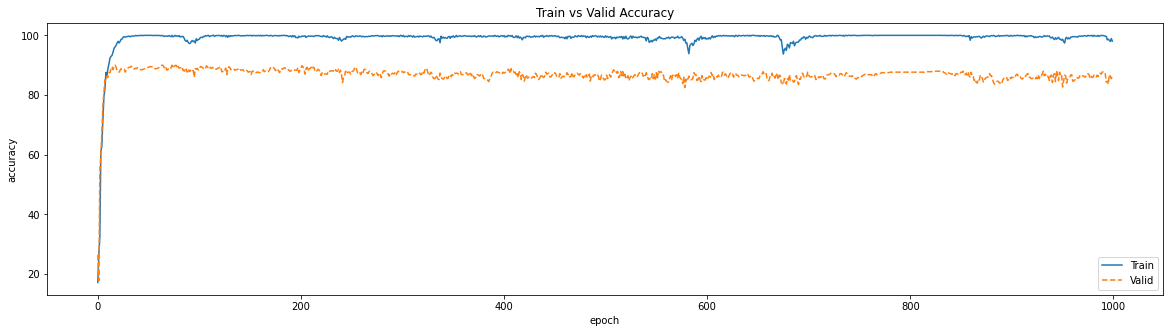

In [37]:
accuracy_plots(train_accu, eval_accu)

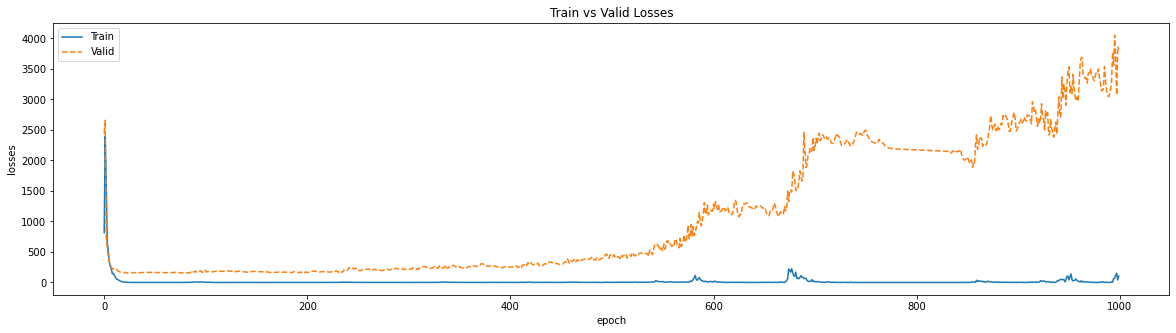

In [38]:
loss_plots(train_losses, eval_losses)

In [39]:
model = model_configs["1"]
model.load_state_dict(torch.load(f"models/best_model_parameters11.pth"))
model.eval()

model_1(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [40]:
with torch.no_grad():
  predicted_classes = []
  device = torch.device("cpu")
  for data in tqdm(first_five_loader):
    images,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(images)
    _, predicted = torch.max(outputs, 1)
    predicted_classes.append(predicted)


100%|██████████| 5/5 [00:00<00:00, 593.05it/s]


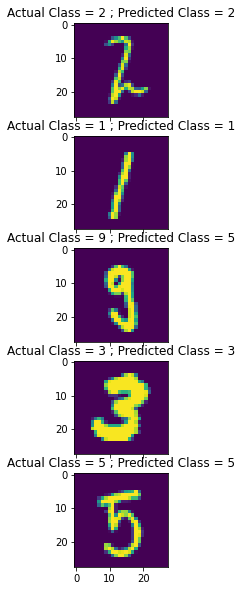

In [41]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for j in range(5):
  axs[j].imshow(first_five_test_images[j][0])
  axs[j].set_title(f"Actual Class = {first_five_test_image_labels[0+j]} ; Predicted Class = {predicted_classes[j].item()}")

for ax in axs.flat:
    ax.label_outer()

# model 1, test config 2

In [42]:
s = time.time()
eval_losses, train_losses, eval_accu, train_accu = train("1", "2")
e = time.time()

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |   39200    |
|  l1.bias  |     50     |
| l2.weight |    500     |
|  l2.bias  |     10     |
+-----------+------------+
Total Trainable Params: 39760

Epoch : 1


100%|██████████| 2/2 [00:00<00:00, 232.60it/s]



Epoch : 2


100%|██████████| 2/2 [00:00<00:00, 211.10it/s]



Epoch : 3


100%|██████████| 2/2 [00:00<00:00, 232.58it/s]



Epoch : 4


100%|██████████| 2/2 [00:00<00:00, 120.32it/s]



Epoch : 5


100%|██████████| 2/2 [00:00<00:00, 249.10it/s]



Epoch : 6


100%|██████████| 2/2 [00:00<00:00, 214.08it/s]



Epoch : 7


100%|██████████| 2/2 [00:00<00:00, 236.51it/s]



Epoch : 8


100%|██████████| 2/2 [00:00<00:00, 207.91it/s]



Epoch : 9


100%|██████████| 2/2 [00:00<00:00, 212.94it/s]



Epoch : 10


100%|██████████| 2/2 [00:00<00:00, 222.29it/s]



Epoch : 11


100%|██████████| 2/2 [00:00<00:00, 230.88it/s]



Epoch : 12


100%|██████████| 2/2 [00:00<00:00, 184.97it/s]



Epoch : 13


100%|██████████| 2/2 [00:00<00:00, 178.58it/s]



Epoch : 14


100%|██████████| 2/2 [00:00<00:00, 170.73it/s]



Epoch : 15


100%|██████████| 2/2 [00:00<00:00, 215.07it/s]



Epoch : 16


100%|██████████| 2/2 [00:00<00:00, 225.17it/s]



Epoch : 17


100%|██████████| 2/2 [00:00<00:00, 212.38it/s]



Epoch : 18


100%|██████████| 2/2 [00:00<00:00, 217.91it/s]



Epoch : 19


100%|██████████| 2/2 [00:00<00:00, 231.68it/s]



Epoch : 20


100%|██████████| 2/2 [00:00<00:00, 218.29it/s]



Epoch : 21


100%|██████████| 2/2 [00:00<00:00, 183.08it/s]



Epoch : 22


100%|██████████| 2/2 [00:00<00:00, 214.78it/s]



Epoch : 23


100%|██████████| 2/2 [00:00<00:00, 225.41it/s]



Epoch : 24


100%|██████████| 2/2 [00:00<00:00, 269.06it/s]



Epoch : 25


100%|██████████| 2/2 [00:00<00:00, 140.71it/s]



Epoch : 26


100%|██████████| 2/2 [00:00<00:00, 169.08it/s]



Epoch : 27


100%|██████████| 2/2 [00:00<00:00, 156.04it/s]



Epoch : 28


100%|██████████| 2/2 [00:00<00:00, 203.97it/s]



Epoch : 29


100%|██████████| 2/2 [00:00<00:00, 116.19it/s]



Epoch : 30


100%|██████████| 2/2 [00:00<00:00, 156.69it/s]



Epoch : 31


100%|██████████| 2/2 [00:00<00:00, 199.45it/s]



Epoch : 32


100%|██████████| 2/2 [00:00<00:00, 194.73it/s]



Epoch : 33


100%|██████████| 2/2 [00:00<00:00, 207.61it/s]



Epoch : 34


100%|██████████| 2/2 [00:00<00:00, 207.37it/s]



Epoch : 35


100%|██████████| 2/2 [00:00<00:00, 149.82it/s]



Epoch : 36


100%|██████████| 2/2 [00:00<00:00, 167.15it/s]



Epoch : 37


100%|██████████| 2/2 [00:00<00:00, 184.30it/s]



Epoch : 38


100%|██████████| 2/2 [00:00<00:00, 203.27it/s]



Epoch : 39


100%|██████████| 2/2 [00:00<00:00, 119.03it/s]



Epoch : 40


100%|██████████| 2/2 [00:00<00:00, 183.91it/s]



Epoch : 41


100%|██████████| 2/2 [00:00<00:00, 128.30it/s]



Epoch : 42


100%|██████████| 2/2 [00:00<00:00, 163.61it/s]



Epoch : 43


100%|██████████| 2/2 [00:00<00:00, 212.24it/s]



Epoch : 44


100%|██████████| 2/2 [00:00<00:00, 217.94it/s]



Epoch : 45


100%|██████████| 2/2 [00:00<00:00, 225.51it/s]



Epoch : 46


100%|██████████| 2/2 [00:00<00:00, 217.45it/s]



Epoch : 47


100%|██████████| 2/2 [00:00<00:00, 218.18it/s]



Epoch : 48


100%|██████████| 2/2 [00:00<00:00, 152.18it/s]



Epoch : 49


100%|██████████| 2/2 [00:00<00:00, 176.31it/s]



Epoch : 50


100%|██████████| 2/2 [00:00<00:00, 218.39it/s]



Epoch : 51


100%|██████████| 2/2 [00:00<00:00, 162.58it/s]



Epoch : 52


100%|██████████| 2/2 [00:00<00:00, 211.24it/s]



Epoch : 53


100%|██████████| 2/2 [00:00<00:00, 209.20it/s]



Epoch : 54


100%|██████████| 2/2 [00:00<00:00, 218.45it/s]



Epoch : 55


100%|██████████| 2/2 [00:00<00:00, 227.82it/s]



Epoch : 56


100%|██████████| 2/2 [00:00<00:00, 215.91it/s]



Epoch : 57


100%|██████████| 2/2 [00:00<00:00, 208.60it/s]



Epoch : 58


100%|██████████| 2/2 [00:00<00:00, 207.20it/s]



Epoch : 59


100%|██████████| 2/2 [00:00<00:00, 222.95it/s]



Epoch : 60


100%|██████████| 2/2 [00:00<00:00, 202.37it/s]



Epoch : 61


100%|██████████| 2/2 [00:00<00:00, 218.98it/s]



Epoch : 62


100%|██████████| 2/2 [00:00<00:00, 218.66it/s]



Epoch : 63


100%|██████████| 2/2 [00:00<00:00, 209.55it/s]



Epoch : 64


100%|██████████| 2/2 [00:00<00:00, 214.88it/s]



Epoch : 65


100%|██████████| 2/2 [00:00<00:00, 214.04it/s]



Epoch : 66


100%|██████████| 2/2 [00:00<00:00, 212.29it/s]



Epoch : 67


100%|██████████| 2/2 [00:00<00:00, 211.81it/s]



Epoch : 68


100%|██████████| 2/2 [00:00<00:00, 216.12it/s]



Epoch : 69


100%|██████████| 2/2 [00:00<00:00, 234.15it/s]



Epoch : 70


100%|██████████| 2/2 [00:00<00:00, 205.77it/s]



Epoch : 71


100%|██████████| 2/2 [00:00<00:00, 192.15it/s]



Epoch : 72


100%|██████████| 2/2 [00:00<00:00, 204.48it/s]



Epoch : 73


100%|██████████| 2/2 [00:00<00:00, 222.63it/s]



Epoch : 74


100%|██████████| 2/2 [00:00<00:00, 223.11it/s]



Epoch : 75


100%|██████████| 2/2 [00:00<00:00, 152.88it/s]



Epoch : 76


100%|██████████| 2/2 [00:00<00:00, 216.25it/s]



Epoch : 77


100%|██████████| 2/2 [00:00<00:00, 201.79it/s]



Epoch : 78


100%|██████████| 2/2 [00:00<00:00, 209.07it/s]



Epoch : 79


100%|██████████| 2/2 [00:00<00:00, 177.82it/s]



Epoch : 80


100%|██████████| 2/2 [00:00<00:00, 234.67it/s]



Epoch : 81


100%|██████████| 2/2 [00:00<00:00, 215.57it/s]



Epoch : 82


100%|██████████| 2/2 [00:00<00:00, 195.07it/s]



Epoch : 83


100%|██████████| 2/2 [00:00<00:00, 213.43it/s]



Epoch : 84


100%|██████████| 2/2 [00:00<00:00, 226.42it/s]



Epoch : 85


100%|██████████| 2/2 [00:00<00:00, 217.61it/s]



Epoch : 86


100%|██████████| 2/2 [00:00<00:00, 217.78it/s]



Epoch : 87


100%|██████████| 2/2 [00:00<00:00, 219.93it/s]



Epoch : 88


100%|██████████| 2/2 [00:00<00:00, 220.61it/s]



Epoch : 89


100%|██████████| 2/2 [00:00<00:00, 223.59it/s]



Epoch : 90


100%|██████████| 2/2 [00:00<00:00, 217.24it/s]



Epoch : 91


100%|██████████| 2/2 [00:00<00:00, 220.38it/s]



Epoch : 92


100%|██████████| 2/2 [00:00<00:00, 213.62it/s]



Epoch : 93


100%|██████████| 2/2 [00:00<00:00, 219.84it/s]



Epoch : 94


100%|██████████| 2/2 [00:00<00:00, 221.59it/s]



Epoch : 95


100%|██████████| 2/2 [00:00<00:00, 210.46it/s]



Epoch : 96


100%|██████████| 2/2 [00:00<00:00, 233.18it/s]



Epoch : 97


100%|██████████| 2/2 [00:00<00:00, 227.72it/s]



Epoch : 98


100%|██████████| 2/2 [00:00<00:00, 224.69it/s]



Epoch : 99


100%|██████████| 2/2 [00:00<00:00, 216.49it/s]



Epoch : 100


100%|██████████| 2/2 [00:00<00:00, 206.25it/s]



Epoch : 101


100%|██████████| 2/2 [00:00<00:00, 152.11it/s]



Epoch : 102


100%|██████████| 2/2 [00:00<00:00, 223.38it/s]



Epoch : 103


100%|██████████| 2/2 [00:00<00:00, 214.84it/s]



Epoch : 104


100%|██████████| 2/2 [00:00<00:00, 226.54it/s]



Epoch : 105


100%|██████████| 2/2 [00:00<00:00, 226.60it/s]



Epoch : 106


100%|██████████| 2/2 [00:00<00:00, 226.03it/s]



Epoch : 107


100%|██████████| 2/2 [00:00<00:00, 213.42it/s]



Epoch : 108


100%|██████████| 2/2 [00:00<00:00, 211.61it/s]



Epoch : 109


100%|██████████| 2/2 [00:00<00:00, 215.78it/s]



Epoch : 110


100%|██████████| 2/2 [00:00<00:00, 214.38it/s]



Epoch : 111


100%|██████████| 2/2 [00:00<00:00, 221.46it/s]



Epoch : 112


100%|██████████| 2/2 [00:00<00:00, 216.68it/s]



Epoch : 113


100%|██████████| 2/2 [00:00<00:00, 212.62it/s]



Epoch : 114


100%|██████████| 2/2 [00:00<00:00, 214.31it/s]



Epoch : 115


100%|██████████| 2/2 [00:00<00:00, 212.74it/s]



Epoch : 116


100%|██████████| 2/2 [00:00<00:00, 216.06it/s]



Epoch : 117


100%|██████████| 2/2 [00:00<00:00, 218.65it/s]



Epoch : 118


100%|██████████| 2/2 [00:00<00:00, 195.24it/s]



Epoch : 119


100%|██████████| 2/2 [00:00<00:00, 220.35it/s]



Epoch : 120


100%|██████████| 2/2 [00:00<00:00, 220.95it/s]



Epoch : 121


100%|██████████| 2/2 [00:00<00:00, 219.71it/s]



Epoch : 122


100%|██████████| 2/2 [00:00<00:00, 145.64it/s]



Epoch : 123


100%|██████████| 2/2 [00:00<00:00, 239.59it/s]



Epoch : 124


100%|██████████| 2/2 [00:00<00:00, 143.72it/s]



Epoch : 125


100%|██████████| 2/2 [00:00<00:00, 216.44it/s]



Epoch : 126


100%|██████████| 2/2 [00:00<00:00, 163.89it/s]



Epoch : 127


100%|██████████| 2/2 [00:00<00:00, 176.86it/s]



Epoch : 128


100%|██████████| 2/2 [00:00<00:00, 216.91it/s]



Epoch : 129


100%|██████████| 2/2 [00:00<00:00, 212.11it/s]



Epoch : 130


100%|██████████| 2/2 [00:00<00:00, 208.81it/s]



Epoch : 131


100%|██████████| 2/2 [00:00<00:00, 220.56it/s]



Epoch : 132


100%|██████████| 2/2 [00:00<00:00, 200.73it/s]



Epoch : 133


100%|██████████| 2/2 [00:00<00:00, 212.46it/s]



Epoch : 134


100%|██████████| 2/2 [00:00<00:00, 16.67it/s]



Epoch : 135


100%|██████████| 2/2 [00:00<00:00, 233.46it/s]



Epoch : 136


100%|██████████| 2/2 [00:00<00:00, 221.97it/s]



Epoch : 137


100%|██████████| 2/2 [00:00<00:00, 211.66it/s]



Epoch : 138


100%|██████████| 2/2 [00:00<00:00, 217.41it/s]



Epoch : 139


100%|██████████| 2/2 [00:00<00:00, 182.45it/s]



Epoch : 140


100%|██████████| 2/2 [00:00<00:00, 186.50it/s]



Epoch : 141


100%|██████████| 2/2 [00:00<00:00, 222.98it/s]



Epoch : 142


100%|██████████| 2/2 [00:00<00:00, 220.11it/s]



Epoch : 143


100%|██████████| 2/2 [00:00<00:00, 217.29it/s]



Epoch : 144


100%|██████████| 2/2 [00:00<00:00, 216.25it/s]



Epoch : 145


100%|██████████| 2/2 [00:00<00:00, 232.82it/s]



Epoch : 146


100%|██████████| 2/2 [00:00<00:00, 221.95it/s]



Epoch : 147


100%|██████████| 2/2 [00:00<00:00, 216.75it/s]



Epoch : 148


100%|██████████| 2/2 [00:00<00:00, 216.27it/s]



Epoch : 149


100%|██████████| 2/2 [00:00<00:00, 207.27it/s]



Epoch : 150


100%|██████████| 2/2 [00:00<00:00, 170.20it/s]



Epoch : 151


100%|██████████| 2/2 [00:00<00:00, 211.44it/s]



Epoch : 152


100%|██████████| 2/2 [00:00<00:00, 219.22it/s]



Epoch : 153


100%|██████████| 2/2 [00:00<00:00, 218.24it/s]



Epoch : 154


100%|██████████| 2/2 [00:00<00:00, 225.57it/s]



Epoch : 155


100%|██████████| 2/2 [00:00<00:00, 222.95it/s]



Epoch : 156


100%|██████████| 2/2 [00:00<00:00, 209.08it/s]



Epoch : 157


100%|██████████| 2/2 [00:00<00:00, 183.91it/s]



Epoch : 158


100%|██████████| 2/2 [00:00<00:00, 177.35it/s]



Epoch : 159


100%|██████████| 2/2 [00:00<00:00, 201.54it/s]



Epoch : 160


100%|██████████| 2/2 [00:00<00:00, 216.83it/s]



Epoch : 161


100%|██████████| 2/2 [00:00<00:00, 217.93it/s]



Epoch : 162


100%|██████████| 2/2 [00:00<00:00, 208.79it/s]



Epoch : 163


100%|██████████| 2/2 [00:00<00:00, 214.38it/s]



Epoch : 164


100%|██████████| 2/2 [00:00<00:00, 213.33it/s]



Epoch : 165


100%|██████████| 2/2 [00:00<00:00, 209.60it/s]



Epoch : 166


100%|██████████| 2/2 [00:00<00:00, 207.14it/s]



Epoch : 167


100%|██████████| 2/2 [00:00<00:00, 217.26it/s]



Epoch : 168


100%|██████████| 2/2 [00:00<00:00, 232.57it/s]



Epoch : 169


100%|██████████| 2/2 [00:00<00:00, 225.57it/s]



Epoch : 170


100%|██████████| 2/2 [00:00<00:00, 224.07it/s]



Epoch : 171


100%|██████████| 2/2 [00:00<00:00, 215.04it/s]



Epoch : 172


100%|██████████| 2/2 [00:00<00:00, 214.37it/s]



Epoch : 173


100%|██████████| 2/2 [00:00<00:00, 216.79it/s]



Epoch : 174


100%|██████████| 2/2 [00:00<00:00, 213.44it/s]



Epoch : 175


100%|██████████| 2/2 [00:00<00:00, 198.47it/s]



Epoch : 176


100%|██████████| 2/2 [00:00<00:00, 220.07it/s]



Epoch : 177


100%|██████████| 2/2 [00:00<00:00, 207.51it/s]



Epoch : 178


100%|██████████| 2/2 [00:00<00:00, 209.17it/s]



Epoch : 179


100%|██████████| 2/2 [00:00<00:00, 190.55it/s]



Epoch : 180


100%|██████████| 2/2 [00:00<00:00, 224.78it/s]



Epoch : 181


100%|██████████| 2/2 [00:00<00:00, 235.91it/s]



Epoch : 182


100%|██████████| 2/2 [00:00<00:00, 229.77it/s]



Epoch : 183


100%|██████████| 2/2 [00:00<00:00, 215.41it/s]



Epoch : 184


100%|██████████| 2/2 [00:00<00:00, 215.68it/s]



Epoch : 185


100%|██████████| 2/2 [00:00<00:00, 207.95it/s]



Epoch : 186


100%|██████████| 2/2 [00:00<00:00, 211.64it/s]



Epoch : 187


100%|██████████| 2/2 [00:00<00:00, 195.89it/s]



Epoch : 188


100%|██████████| 2/2 [00:00<00:00, 205.52it/s]



Epoch : 189


100%|██████████| 2/2 [00:00<00:00, 102.15it/s]



Epoch : 190


100%|██████████| 2/2 [00:00<00:00, 209.20it/s]



Epoch : 191


100%|██████████| 2/2 [00:00<00:00, 206.01it/s]



Epoch : 192


100%|██████████| 2/2 [00:00<00:00, 173.49it/s]



Epoch : 193


100%|██████████| 2/2 [00:00<00:00, 224.19it/s]



Epoch : 194


100%|██████████| 2/2 [00:00<00:00, 218.64it/s]



Epoch : 195


100%|██████████| 2/2 [00:00<00:00, 224.07it/s]



Epoch : 196


100%|██████████| 2/2 [00:00<00:00, 173.93it/s]



Epoch : 197


100%|██████████| 2/2 [00:00<00:00, 219.41it/s]



Epoch : 198


100%|██████████| 2/2 [00:00<00:00, 205.05it/s]



Epoch : 199


100%|██████████| 2/2 [00:00<00:00, 217.83it/s]



Epoch : 200


100%|██████████| 2/2 [00:00<00:00, 220.18it/s]



Epoch : 201


100%|██████████| 2/2 [00:00<00:00, 208.25it/s]



Epoch : 202


100%|██████████| 2/2 [00:00<00:00, 210.99it/s]



Epoch : 203


100%|██████████| 2/2 [00:00<00:00, 217.14it/s]



Epoch : 204


100%|██████████| 2/2 [00:00<00:00, 201.80it/s]



Epoch : 205


100%|██████████| 2/2 [00:00<00:00, 210.76it/s]



Epoch : 206


100%|██████████| 2/2 [00:00<00:00, 215.82it/s]



Epoch : 207


100%|██████████| 2/2 [00:00<00:00, 217.24it/s]



Epoch : 208


100%|██████████| 2/2 [00:00<00:00, 215.07it/s]



Epoch : 209


100%|██████████| 2/2 [00:00<00:00, 212.55it/s]



Epoch : 210


100%|██████████| 2/2 [00:00<00:00, 198.21it/s]



Epoch : 211


100%|██████████| 2/2 [00:00<00:00, 205.28it/s]



Epoch : 212


100%|██████████| 2/2 [00:00<00:00, 201.95it/s]



Epoch : 213


100%|██████████| 2/2 [00:00<00:00, 222.75it/s]



Epoch : 214


100%|██████████| 2/2 [00:00<00:00, 206.43it/s]



Epoch : 215


100%|██████████| 2/2 [00:00<00:00, 215.41it/s]



Epoch : 216


100%|██████████| 2/2 [00:00<00:00, 209.09it/s]



Epoch : 217


100%|██████████| 2/2 [00:00<00:00, 204.71it/s]



Epoch : 218


100%|██████████| 2/2 [00:00<00:00, 234.29it/s]



Epoch : 219


100%|██████████| 2/2 [00:00<00:00, 227.61it/s]



Epoch : 220


100%|██████████| 2/2 [00:00<00:00, 223.82it/s]



Epoch : 221


100%|██████████| 2/2 [00:00<00:00, 222.06it/s]



Epoch : 222


100%|██████████| 2/2 [00:00<00:00, 218.68it/s]



Epoch : 223


100%|██████████| 2/2 [00:00<00:00, 221.53it/s]



Epoch : 224


100%|██████████| 2/2 [00:00<00:00, 235.80it/s]



Epoch : 225


100%|██████████| 2/2 [00:00<00:00, 226.44it/s]



Epoch : 226


100%|██████████| 2/2 [00:00<00:00, 217.74it/s]



Epoch : 227


100%|██████████| 2/2 [00:00<00:00, 203.70it/s]



Epoch : 228


100%|██████████| 2/2 [00:00<00:00, 214.43it/s]



Epoch : 229


100%|██████████| 2/2 [00:00<00:00, 208.08it/s]



Epoch : 230


100%|██████████| 2/2 [00:00<00:00, 194.06it/s]



Epoch : 231


100%|██████████| 2/2 [00:00<00:00, 225.46it/s]



Epoch : 232


100%|██████████| 2/2 [00:00<00:00, 210.04it/s]



Epoch : 233


100%|██████████| 2/2 [00:00<00:00, 219.89it/s]



Epoch : 234


100%|██████████| 2/2 [00:00<00:00, 220.73it/s]



Epoch : 235


100%|██████████| 2/2 [00:00<00:00, 212.47it/s]



Epoch : 236


100%|██████████| 2/2 [00:00<00:00, 222.19it/s]



Epoch : 237


100%|██████████| 2/2 [00:00<00:00, 190.03it/s]



Epoch : 238


100%|██████████| 2/2 [00:00<00:00, 160.56it/s]



Epoch : 239


100%|██████████| 2/2 [00:00<00:00, 207.09it/s]



Epoch : 240


100%|██████████| 2/2 [00:00<00:00, 212.26it/s]



Epoch : 241


100%|██████████| 2/2 [00:00<00:00, 226.16it/s]



Epoch : 242


100%|██████████| 2/2 [00:00<00:00, 216.99it/s]



Epoch : 243


100%|██████████| 2/2 [00:00<00:00, 192.04it/s]



Epoch : 244


100%|██████████| 2/2 [00:00<00:00, 215.06it/s]



Epoch : 245


100%|██████████| 2/2 [00:00<00:00, 227.27it/s]



Epoch : 246


100%|██████████| 2/2 [00:00<00:00, 219.81it/s]



Epoch : 247


100%|██████████| 2/2 [00:00<00:00, 224.06it/s]



Epoch : 248


100%|██████████| 2/2 [00:00<00:00, 218.40it/s]



Epoch : 249


100%|██████████| 2/2 [00:00<00:00, 212.75it/s]



Epoch : 250


100%|██████████| 2/2 [00:00<00:00, 219.60it/s]



Epoch : 251


100%|██████████| 2/2 [00:00<00:00, 201.99it/s]



Epoch : 252


100%|██████████| 2/2 [00:00<00:00, 217.34it/s]



Epoch : 253


100%|██████████| 2/2 [00:00<00:00, 216.74it/s]



Epoch : 254


100%|██████████| 2/2 [00:00<00:00, 181.09it/s]



Epoch : 255


100%|██████████| 2/2 [00:00<00:00, 206.31it/s]



Epoch : 256


100%|██████████| 2/2 [00:00<00:00, 221.64it/s]



Epoch : 257


100%|██████████| 2/2 [00:00<00:00, 200.41it/s]



Epoch : 258


100%|██████████| 2/2 [00:00<00:00, 224.54it/s]



Epoch : 259


100%|██████████| 2/2 [00:00<00:00, 223.64it/s]



Epoch : 260


100%|██████████| 2/2 [00:00<00:00, 222.39it/s]



Epoch : 261


100%|██████████| 2/2 [00:00<00:00, 196.86it/s]



Epoch : 262


100%|██████████| 2/2 [00:00<00:00, 169.83it/s]



Epoch : 263


100%|██████████| 2/2 [00:00<00:00, 216.80it/s]



Epoch : 264


100%|██████████| 2/2 [00:00<00:00, 218.24it/s]



Epoch : 265


100%|██████████| 2/2 [00:00<00:00, 207.88it/s]



Epoch : 266


100%|██████████| 2/2 [00:00<00:00, 206.62it/s]



Epoch : 267


100%|██████████| 2/2 [00:00<00:00, 220.42it/s]



Epoch : 268


100%|██████████| 2/2 [00:00<00:00, 222.94it/s]



Epoch : 269


100%|██████████| 2/2 [00:00<00:00, 178.40it/s]



Epoch : 270


100%|██████████| 2/2 [00:00<00:00, 228.16it/s]



Epoch : 271


100%|██████████| 2/2 [00:00<00:00, 222.44it/s]



Epoch : 272


100%|██████████| 2/2 [00:00<00:00, 207.51it/s]



Epoch : 273


100%|██████████| 2/2 [00:00<00:00, 206.70it/s]



Epoch : 274


100%|██████████| 2/2 [00:00<00:00, 220.89it/s]



Epoch : 275


100%|██████████| 2/2 [00:00<00:00, 222.63it/s]



Epoch : 276


100%|██████████| 2/2 [00:00<00:00, 214.80it/s]



Epoch : 277


100%|██████████| 2/2 [00:00<00:00, 198.61it/s]



Epoch : 278


100%|██████████| 2/2 [00:00<00:00, 219.77it/s]



Epoch : 279


100%|██████████| 2/2 [00:00<00:00, 222.88it/s]



Epoch : 280


100%|██████████| 2/2 [00:00<00:00, 185.72it/s]



Epoch : 281


100%|██████████| 2/2 [00:00<00:00, 172.21it/s]



Epoch : 282


100%|██████████| 2/2 [00:00<00:00, 198.96it/s]



Epoch : 283


100%|██████████| 2/2 [00:00<00:00, 201.86it/s]



Epoch : 284


100%|██████████| 2/2 [00:00<00:00, 231.52it/s]



Epoch : 285


100%|██████████| 2/2 [00:00<00:00, 225.45it/s]



Epoch : 286


100%|██████████| 2/2 [00:00<00:00, 176.31it/s]



Epoch : 287


100%|██████████| 2/2 [00:00<00:00, 184.48it/s]



Epoch : 288


100%|██████████| 2/2 [00:00<00:00, 208.38it/s]



Epoch : 289


100%|██████████| 2/2 [00:00<00:00, 216.25it/s]



Epoch : 290


100%|██████████| 2/2 [00:00<00:00, 178.97it/s]



Epoch : 291


100%|██████████| 2/2 [00:00<00:00, 150.94it/s]



Epoch : 292


100%|██████████| 2/2 [00:00<00:00, 153.79it/s]



Epoch : 293


100%|██████████| 2/2 [00:00<00:00, 211.63it/s]



Epoch : 294


100%|██████████| 2/2 [00:00<00:00, 185.36it/s]



Epoch : 295


100%|██████████| 2/2 [00:00<00:00, 138.26it/s]



Epoch : 296


100%|██████████| 2/2 [00:00<00:00, 171.08it/s]



Epoch : 297


100%|██████████| 2/2 [00:00<00:00, 231.47it/s]



Epoch : 298


100%|██████████| 2/2 [00:00<00:00, 232.95it/s]



Epoch : 299


100%|██████████| 2/2 [00:00<00:00, 216.47it/s]



Epoch : 300


100%|██████████| 2/2 [00:00<00:00, 218.64it/s]



Epoch : 301


100%|██████████| 2/2 [00:00<00:00, 191.26it/s]



Epoch : 302


100%|██████████| 2/2 [00:00<00:00, 221.24it/s]



Epoch : 303


100%|██████████| 2/2 [00:00<00:00, 206.25it/s]



Epoch : 304


100%|██████████| 2/2 [00:00<00:00, 213.60it/s]



Epoch : 305


100%|██████████| 2/2 [00:00<00:00, 212.24it/s]



Epoch : 306


100%|██████████| 2/2 [00:00<00:00, 215.27it/s]



Epoch : 307


100%|██████████| 2/2 [00:00<00:00, 177.68it/s]



Epoch : 308


100%|██████████| 2/2 [00:00<00:00, 205.99it/s]



Epoch : 309


100%|██████████| 2/2 [00:00<00:00, 209.38it/s]



Epoch : 310


100%|██████████| 2/2 [00:00<00:00, 210.39it/s]



Epoch : 311


100%|██████████| 2/2 [00:00<00:00, 215.12it/s]



Epoch : 312


100%|██████████| 2/2 [00:00<00:00, 198.20it/s]



Epoch : 313


100%|██████████| 2/2 [00:00<00:00, 179.16it/s]



Epoch : 314


100%|██████████| 2/2 [00:00<00:00, 174.82it/s]



Epoch : 315


100%|██████████| 2/2 [00:00<00:00, 219.65it/s]



Epoch : 316


100%|██████████| 2/2 [00:00<00:00, 207.81it/s]



Epoch : 317


100%|██████████| 2/2 [00:00<00:00, 205.75it/s]



Epoch : 318


100%|██████████| 2/2 [00:00<00:00, 217.83it/s]



Epoch : 319


100%|██████████| 2/2 [00:00<00:00, 214.45it/s]



Epoch : 320


100%|██████████| 2/2 [00:00<00:00, 212.51it/s]



Epoch : 321


100%|██████████| 2/2 [00:00<00:00, 211.52it/s]



Epoch : 322


100%|██████████| 2/2 [00:00<00:00, 222.63it/s]



Epoch : 323


100%|██████████| 2/2 [00:00<00:00, 226.59it/s]



Epoch : 324


100%|██████████| 2/2 [00:00<00:00, 232.58it/s]



Epoch : 325


100%|██████████| 2/2 [00:00<00:00, 218.85it/s]



Epoch : 326


100%|██████████| 2/2 [00:00<00:00, 216.47it/s]



Epoch : 327


100%|██████████| 2/2 [00:00<00:00, 205.75it/s]



Epoch : 328


100%|██████████| 2/2 [00:00<00:00, 149.90it/s]



Epoch : 329


100%|██████████| 2/2 [00:00<00:00, 222.78it/s]



Epoch : 330


100%|██████████| 2/2 [00:00<00:00, 216.59it/s]



Epoch : 331


100%|██████████| 2/2 [00:00<00:00, 221.95it/s]



Epoch : 332


100%|██████████| 2/2 [00:00<00:00, 228.93it/s]



Epoch : 333


100%|██████████| 2/2 [00:00<00:00, 223.39it/s]



Epoch : 334


100%|██████████| 2/2 [00:00<00:00, 220.50it/s]



Epoch : 335


100%|██████████| 2/2 [00:00<00:00, 210.75it/s]



Epoch : 336


100%|██████████| 2/2 [00:00<00:00, 213.70it/s]



Epoch : 337


100%|██████████| 2/2 [00:00<00:00, 204.96it/s]



Epoch : 338


100%|██████████| 2/2 [00:00<00:00, 214.53it/s]



Epoch : 339


100%|██████████| 2/2 [00:00<00:00, 211.68it/s]



Epoch : 340


100%|██████████| 2/2 [00:00<00:00, 152.55it/s]



Epoch : 341


100%|██████████| 2/2 [00:00<00:00, 203.86it/s]



Epoch : 342


100%|██████████| 2/2 [00:00<00:00, 204.35it/s]



Epoch : 343


100%|██████████| 2/2 [00:00<00:00, 178.93it/s]



Epoch : 344


100%|██████████| 2/2 [00:00<00:00, 219.38it/s]



Epoch : 345


100%|██████████| 2/2 [00:00<00:00, 217.19it/s]



Epoch : 346


100%|██████████| 2/2 [00:00<00:00, 215.21it/s]



Epoch : 347


100%|██████████| 2/2 [00:00<00:00, 152.20it/s]



Epoch : 348


100%|██████████| 2/2 [00:00<00:00, 211.62it/s]



Epoch : 349


100%|██████████| 2/2 [00:00<00:00, 221.74it/s]



Epoch : 350


100%|██████████| 2/2 [00:00<00:00, 220.87it/s]



Epoch : 351


100%|██████████| 2/2 [00:00<00:00, 207.45it/s]



Epoch : 352


100%|██████████| 2/2 [00:00<00:00, 210.49it/s]



Epoch : 353


100%|██████████| 2/2 [00:00<00:00, 252.05it/s]



Epoch : 354


100%|██████████| 2/2 [00:00<00:00, 191.72it/s]



Epoch : 355


100%|██████████| 2/2 [00:00<00:00, 163.36it/s]



Epoch : 356


100%|██████████| 2/2 [00:00<00:00, 191.22it/s]



Epoch : 357


100%|██████████| 2/2 [00:00<00:00, 182.20it/s]



Epoch : 358


100%|██████████| 2/2 [00:00<00:00, 221.38it/s]



Epoch : 359


100%|██████████| 2/2 [00:00<00:00, 212.18it/s]



Epoch : 360


100%|██████████| 2/2 [00:00<00:00, 164.36it/s]



Epoch : 361


100%|██████████| 2/2 [00:00<00:00, 170.56it/s]



Epoch : 362


100%|██████████| 2/2 [00:00<00:00, 157.71it/s]



Epoch : 363


100%|██████████| 2/2 [00:00<00:00, 138.99it/s]



Epoch : 364


100%|██████████| 2/2 [00:00<00:00, 147.03it/s]



Epoch : 365


100%|██████████| 2/2 [00:00<00:00, 161.80it/s]



Epoch : 366


100%|██████████| 2/2 [00:00<00:00, 201.38it/s]



Epoch : 367


100%|██████████| 2/2 [00:00<00:00, 181.69it/s]



Epoch : 368


100%|██████████| 2/2 [00:00<00:00, 181.62it/s]



Epoch : 369


100%|██████████| 2/2 [00:00<00:00, 192.90it/s]



Epoch : 370


100%|██████████| 2/2 [00:00<00:00, 172.33it/s]



Epoch : 371


100%|██████████| 2/2 [00:00<00:00, 152.04it/s]



Epoch : 372


100%|██████████| 2/2 [00:00<00:00, 175.20it/s]



Epoch : 373


100%|██████████| 2/2 [00:00<00:00, 114.39it/s]



Epoch : 374


100%|██████████| 2/2 [00:00<00:00, 120.64it/s]



Epoch : 375


100%|██████████| 2/2 [00:00<00:00, 183.66it/s]



Epoch : 376


100%|██████████| 2/2 [00:00<00:00, 184.08it/s]



Epoch : 377


100%|██████████| 2/2 [00:00<00:00, 163.76it/s]



Epoch : 378


100%|██████████| 2/2 [00:00<00:00, 169.84it/s]



Epoch : 379


100%|██████████| 2/2 [00:00<00:00, 293.55it/s]



Epoch : 380


100%|██████████| 2/2 [00:00<00:00, 190.44it/s]



Epoch : 381


100%|██████████| 2/2 [00:00<00:00, 119.41it/s]



Epoch : 382


100%|██████████| 2/2 [00:00<00:00, 200.22it/s]



Epoch : 383


100%|██████████| 2/2 [00:00<00:00, 206.51it/s]



Epoch : 384


100%|██████████| 2/2 [00:00<00:00, 221.70it/s]



Epoch : 385


100%|██████████| 2/2 [00:00<00:00, 227.44it/s]



Epoch : 386


100%|██████████| 2/2 [00:00<00:00, 215.00it/s]



Epoch : 387


100%|██████████| 2/2 [00:00<00:00, 169.77it/s]



Epoch : 388


100%|██████████| 2/2 [00:00<00:00, 226.16it/s]



Epoch : 389


100%|██████████| 2/2 [00:00<00:00, 217.52it/s]



Epoch : 390


100%|██████████| 2/2 [00:00<00:00, 212.07it/s]



Epoch : 391


100%|██████████| 2/2 [00:00<00:00, 206.98it/s]



Epoch : 392


100%|██████████| 2/2 [00:00<00:00, 195.98it/s]



Epoch : 393


100%|██████████| 2/2 [00:00<00:00, 235.76it/s]



Epoch : 394


100%|██████████| 2/2 [00:00<00:00, 224.05it/s]



Epoch : 395


100%|██████████| 2/2 [00:00<00:00, 127.86it/s]



Epoch : 396


100%|██████████| 2/2 [00:00<00:00, 175.48it/s]



Epoch : 397


100%|██████████| 2/2 [00:00<00:00, 180.80it/s]



Epoch : 398


100%|██████████| 2/2 [00:00<00:00, 177.82it/s]



Epoch : 399


100%|██████████| 2/2 [00:00<00:00, 145.87it/s]



Epoch : 400


100%|██████████| 2/2 [00:00<00:00, 191.73it/s]



Epoch : 401


100%|██████████| 2/2 [00:00<00:00, 223.82it/s]



Epoch : 402


100%|██████████| 2/2 [00:00<00:00, 223.84it/s]



Epoch : 403


100%|██████████| 2/2 [00:00<00:00, 231.24it/s]



Epoch : 404


100%|██████████| 2/2 [00:00<00:00, 216.87it/s]



Epoch : 405


100%|██████████| 2/2 [00:00<00:00, 194.08it/s]



Epoch : 406


100%|██████████| 2/2 [00:00<00:00, 228.70it/s]



Epoch : 407


100%|██████████| 2/2 [00:00<00:00, 220.22it/s]



Epoch : 408


100%|██████████| 2/2 [00:00<00:00, 162.05it/s]



Epoch : 409


100%|██████████| 2/2 [00:00<00:00, 107.58it/s]



Epoch : 410


100%|██████████| 2/2 [00:00<00:00, 150.45it/s]



Epoch : 411


100%|██████████| 2/2 [00:00<00:00, 161.01it/s]



Epoch : 412


100%|██████████| 2/2 [00:00<00:00, 206.73it/s]



Epoch : 413


100%|██████████| 2/2 [00:00<00:00, 204.11it/s]



Epoch : 414


100%|██████████| 2/2 [00:00<00:00, 214.25it/s]



Epoch : 415


100%|██████████| 2/2 [00:00<00:00, 171.69it/s]



Epoch : 416


100%|██████████| 2/2 [00:00<00:00, 225.88it/s]



Epoch : 417


100%|██████████| 2/2 [00:00<00:00, 218.13it/s]



Epoch : 418


100%|██████████| 2/2 [00:00<00:00, 215.34it/s]



Epoch : 419


100%|██████████| 2/2 [00:00<00:00, 216.78it/s]



Epoch : 420


100%|██████████| 2/2 [00:00<00:00, 218.18it/s]



Epoch : 421


100%|██████████| 2/2 [00:00<00:00, 227.99it/s]



Epoch : 422


100%|██████████| 2/2 [00:00<00:00, 216.39it/s]



Epoch : 423


100%|██████████| 2/2 [00:00<00:00, 218.28it/s]



Epoch : 424


100%|██████████| 2/2 [00:00<00:00, 220.93it/s]



Epoch : 425


100%|██████████| 2/2 [00:00<00:00, 219.13it/s]



Epoch : 426


100%|██████████| 2/2 [00:00<00:00, 214.33it/s]



Epoch : 427


100%|██████████| 2/2 [00:00<00:00, 216.57it/s]



Epoch : 428


100%|██████████| 2/2 [00:00<00:00, 209.06it/s]



Epoch : 429


100%|██████████| 2/2 [00:00<00:00, 211.68it/s]



Epoch : 430


100%|██████████| 2/2 [00:00<00:00, 212.80it/s]



Epoch : 431


100%|██████████| 2/2 [00:00<00:00, 205.35it/s]



Epoch : 432


100%|██████████| 2/2 [00:00<00:00, 207.23it/s]



Epoch : 433


100%|██████████| 2/2 [00:00<00:00, 221.83it/s]



Epoch : 434


100%|██████████| 2/2 [00:00<00:00, 151.55it/s]



Epoch : 435


100%|██████████| 2/2 [00:00<00:00, 195.72it/s]



Epoch : 436


100%|██████████| 2/2 [00:00<00:00, 216.50it/s]



Epoch : 437


100%|██████████| 2/2 [00:00<00:00, 219.26it/s]



Epoch : 438


100%|██████████| 2/2 [00:00<00:00, 215.13it/s]



Epoch : 439


100%|██████████| 2/2 [00:00<00:00, 242.78it/s]



Epoch : 440


100%|██████████| 2/2 [00:00<00:00, 222.17it/s]



Epoch : 441


100%|██████████| 2/2 [00:00<00:00, 219.98it/s]



Epoch : 442


100%|██████████| 2/2 [00:00<00:00, 202.60it/s]



Epoch : 443


100%|██████████| 2/2 [00:00<00:00, 196.32it/s]



Epoch : 444


100%|██████████| 2/2 [00:00<00:00, 215.80it/s]



Epoch : 445


100%|██████████| 2/2 [00:00<00:00, 226.77it/s]



Epoch : 446


100%|██████████| 2/2 [00:00<00:00, 232.27it/s]



Epoch : 447


100%|██████████| 2/2 [00:00<00:00, 225.34it/s]



Epoch : 448


100%|██████████| 2/2 [00:00<00:00, 222.17it/s]



Epoch : 449


100%|██████████| 2/2 [00:00<00:00, 230.29it/s]



Epoch : 450


100%|██████████| 2/2 [00:00<00:00, 218.02it/s]



Epoch : 451


100%|██████████| 2/2 [00:00<00:00, 219.69it/s]



Epoch : 452


100%|██████████| 2/2 [00:00<00:00, 231.92it/s]



Epoch : 453


100%|██████████| 2/2 [00:00<00:00, 197.25it/s]



Epoch : 454


100%|██████████| 2/2 [00:00<00:00, 226.24it/s]



Epoch : 455


100%|██████████| 2/2 [00:00<00:00, 226.73it/s]



Epoch : 456


100%|██████████| 2/2 [00:00<00:00, 226.30it/s]



Epoch : 457


100%|██████████| 2/2 [00:00<00:00, 124.98it/s]



Epoch : 458


100%|██████████| 2/2 [00:00<00:00, 208.74it/s]



Epoch : 459


100%|██████████| 2/2 [00:00<00:00, 206.38it/s]



Epoch : 460


100%|██████████| 2/2 [00:00<00:00, 221.83it/s]



Epoch : 461


100%|██████████| 2/2 [00:00<00:00, 212.13it/s]



Epoch : 462


100%|██████████| 2/2 [00:00<00:00, 224.75it/s]



Epoch : 463


100%|██████████| 2/2 [00:00<00:00, 221.14it/s]



Epoch : 464


100%|██████████| 2/2 [00:00<00:00, 207.72it/s]



Epoch : 465


100%|██████████| 2/2 [00:00<00:00, 177.22it/s]



Epoch : 466


100%|██████████| 2/2 [00:00<00:00, 222.71it/s]



Epoch : 467


100%|██████████| 2/2 [00:00<00:00, 219.99it/s]



Epoch : 468


100%|██████████| 2/2 [00:00<00:00, 226.12it/s]



Epoch : 469


100%|██████████| 2/2 [00:00<00:00, 212.20it/s]



Epoch : 470


100%|██████████| 2/2 [00:00<00:00, 128.72it/s]



Epoch : 471


100%|██████████| 2/2 [00:00<00:00, 216.20it/s]



Epoch : 472


100%|██████████| 2/2 [00:00<00:00, 214.09it/s]



Epoch : 473


100%|██████████| 2/2 [00:00<00:00, 219.59it/s]



Epoch : 474


100%|██████████| 2/2 [00:00<00:00, 227.17it/s]



Epoch : 475


100%|██████████| 2/2 [00:00<00:00, 216.17it/s]



Epoch : 476


100%|██████████| 2/2 [00:00<00:00, 224.22it/s]



Epoch : 477


100%|██████████| 2/2 [00:00<00:00, 216.73it/s]



Epoch : 478


100%|██████████| 2/2 [00:00<00:00, 223.27it/s]



Epoch : 479


100%|██████████| 2/2 [00:00<00:00, 206.20it/s]



Epoch : 480


100%|██████████| 2/2 [00:00<00:00, 163.89it/s]



Epoch : 481


100%|██████████| 2/2 [00:00<00:00, 203.57it/s]



Epoch : 482


100%|██████████| 2/2 [00:00<00:00, 202.15it/s]



Epoch : 483


100%|██████████| 2/2 [00:00<00:00, 213.94it/s]



Epoch : 484


100%|██████████| 2/2 [00:00<00:00, 193.02it/s]



Epoch : 485


100%|██████████| 2/2 [00:00<00:00, 219.91it/s]



Epoch : 486


100%|██████████| 2/2 [00:00<00:00, 221.89it/s]



Epoch : 487


100%|██████████| 2/2 [00:00<00:00, 217.69it/s]



Epoch : 488


100%|██████████| 2/2 [00:00<00:00, 183.46it/s]



Epoch : 489


100%|██████████| 2/2 [00:00<00:00, 210.89it/s]



Epoch : 490


100%|██████████| 2/2 [00:00<00:00, 215.35it/s]



Epoch : 491


100%|██████████| 2/2 [00:00<00:00, 220.50it/s]



Epoch : 492


100%|██████████| 2/2 [00:00<00:00, 212.31it/s]



Epoch : 493


100%|██████████| 2/2 [00:00<00:00, 203.33it/s]



Epoch : 494


100%|██████████| 2/2 [00:00<00:00, 227.07it/s]



Epoch : 495


100%|██████████| 2/2 [00:00<00:00, 221.32it/s]



Epoch : 496


100%|██████████| 2/2 [00:00<00:00, 209.94it/s]



Epoch : 497


100%|██████████| 2/2 [00:00<00:00, 220.39it/s]



Epoch : 498


100%|██████████| 2/2 [00:00<00:00, 221.15it/s]



Epoch : 499


100%|██████████| 2/2 [00:00<00:00, 218.40it/s]



Epoch : 500


100%|██████████| 2/2 [00:00<00:00, 219.30it/s]



Epoch : 501


100%|██████████| 2/2 [00:00<00:00, 194.61it/s]



Epoch : 502


100%|██████████| 2/2 [00:00<00:00, 211.13it/s]



Epoch : 503


100%|██████████| 2/2 [00:00<00:00, 210.75it/s]



Epoch : 504


100%|██████████| 2/2 [00:00<00:00, 226.04it/s]



Epoch : 505


100%|██████████| 2/2 [00:00<00:00, 192.13it/s]



Epoch : 506


100%|██████████| 2/2 [00:00<00:00, 216.15it/s]



Epoch : 507


100%|██████████| 2/2 [00:00<00:00, 171.28it/s]



Epoch : 508


100%|██████████| 2/2 [00:00<00:00, 184.70it/s]



Epoch : 509


100%|██████████| 2/2 [00:00<00:00, 138.43it/s]



Epoch : 510


100%|██████████| 2/2 [00:00<00:00, 206.43it/s]



Epoch : 511


100%|██████████| 2/2 [00:00<00:00, 219.86it/s]



Epoch : 512


100%|██████████| 2/2 [00:00<00:00, 228.40it/s]



Epoch : 513


100%|██████████| 2/2 [00:00<00:00, 219.18it/s]



Epoch : 514


100%|██████████| 2/2 [00:00<00:00, 201.88it/s]



Epoch : 515


100%|██████████| 2/2 [00:00<00:00, 209.19it/s]



Epoch : 516


100%|██████████| 2/2 [00:00<00:00, 167.86it/s]



Epoch : 517


100%|██████████| 2/2 [00:00<00:00, 175.92it/s]



Epoch : 518


100%|██████████| 2/2 [00:00<00:00, 185.10it/s]



Epoch : 519


100%|██████████| 2/2 [00:00<00:00, 190.23it/s]



Epoch : 520


100%|██████████| 2/2 [00:00<00:00, 214.26it/s]



Epoch : 521


100%|██████████| 2/2 [00:00<00:00, 204.78it/s]



Epoch : 522


100%|██████████| 2/2 [00:00<00:00, 132.02it/s]



Epoch : 523


100%|██████████| 2/2 [00:00<00:00, 226.32it/s]



Epoch : 524


100%|██████████| 2/2 [00:00<00:00, 218.70it/s]



Epoch : 525


100%|██████████| 2/2 [00:00<00:00, 189.09it/s]



Epoch : 526


100%|██████████| 2/2 [00:00<00:00, 205.07it/s]



Epoch : 527


100%|██████████| 2/2 [00:00<00:00, 189.88it/s]



Epoch : 528


100%|██████████| 2/2 [00:00<00:00, 221.69it/s]



Epoch : 529


100%|██████████| 2/2 [00:00<00:00, 211.25it/s]



Epoch : 530


100%|██████████| 2/2 [00:00<00:00, 224.32it/s]



Epoch : 531


100%|██████████| 2/2 [00:00<00:00, 215.45it/s]



Epoch : 532


100%|██████████| 2/2 [00:00<00:00, 179.77it/s]



Epoch : 533


100%|██████████| 2/2 [00:00<00:00, 223.49it/s]



Epoch : 534


100%|██████████| 2/2 [00:00<00:00, 218.46it/s]



Epoch : 535


100%|██████████| 2/2 [00:00<00:00, 218.94it/s]



Epoch : 536


100%|██████████| 2/2 [00:00<00:00, 177.26it/s]



Epoch : 537


100%|██████████| 2/2 [00:00<00:00, 193.55it/s]



Epoch : 538


100%|██████████| 2/2 [00:00<00:00, 193.99it/s]



Epoch : 539


100%|██████████| 2/2 [00:00<00:00, 203.04it/s]



Epoch : 540


100%|██████████| 2/2 [00:00<00:00, 154.42it/s]



Epoch : 541


100%|██████████| 2/2 [00:00<00:00, 164.85it/s]



Epoch : 542


100%|██████████| 2/2 [00:00<00:00, 207.06it/s]



Epoch : 543


100%|██████████| 2/2 [00:00<00:00, 217.34it/s]



Epoch : 544


100%|██████████| 2/2 [00:00<00:00, 194.10it/s]



Epoch : 545


100%|██████████| 2/2 [00:00<00:00, 232.17it/s]



Epoch : 546


100%|██████████| 2/2 [00:00<00:00, 209.70it/s]



Epoch : 547


100%|██████████| 2/2 [00:00<00:00, 221.29it/s]



Epoch : 548


100%|██████████| 2/2 [00:00<00:00, 208.63it/s]



Epoch : 549


100%|██████████| 2/2 [00:00<00:00, 213.09it/s]



Epoch : 550


100%|██████████| 2/2 [00:00<00:00, 207.87it/s]



Epoch : 551


100%|██████████| 2/2 [00:00<00:00, 140.59it/s]



Epoch : 552


100%|██████████| 2/2 [00:00<00:00, 184.58it/s]



Epoch : 553


100%|██████████| 2/2 [00:00<00:00, 190.92it/s]



Epoch : 554


100%|██████████| 2/2 [00:00<00:00, 206.20it/s]



Epoch : 555


100%|██████████| 2/2 [00:00<00:00, 209.96it/s]



Epoch : 556


100%|██████████| 2/2 [00:00<00:00, 132.43it/s]



Epoch : 557


100%|██████████| 2/2 [00:00<00:00, 164.12it/s]



Epoch : 558


100%|██████████| 2/2 [00:00<00:00, 194.54it/s]



Epoch : 559


100%|██████████| 2/2 [00:00<00:00, 216.63it/s]



Epoch : 560


100%|██████████| 2/2 [00:00<00:00, 154.01it/s]



Epoch : 561


100%|██████████| 2/2 [00:00<00:00, 222.61it/s]



Epoch : 562


100%|██████████| 2/2 [00:00<00:00, 226.99it/s]



Epoch : 563


100%|██████████| 2/2 [00:00<00:00, 214.94it/s]



Epoch : 564


100%|██████████| 2/2 [00:00<00:00, 214.61it/s]



Epoch : 565


100%|██████████| 2/2 [00:00<00:00, 211.70it/s]



Epoch : 566


100%|██████████| 2/2 [00:00<00:00, 211.84it/s]



Epoch : 567


100%|██████████| 2/2 [00:00<00:00, 216.36it/s]



Epoch : 568


100%|██████████| 2/2 [00:00<00:00, 211.99it/s]



Epoch : 569


100%|██████████| 2/2 [00:00<00:00, 217.77it/s]



Epoch : 570


100%|██████████| 2/2 [00:00<00:00, 215.89it/s]



Epoch : 571


100%|██████████| 2/2 [00:00<00:00, 200.92it/s]



Epoch : 572


100%|██████████| 2/2 [00:00<00:00, 170.48it/s]



Epoch : 573


100%|██████████| 2/2 [00:00<00:00, 180.00it/s]



Epoch : 574


100%|██████████| 2/2 [00:00<00:00, 207.89it/s]



Epoch : 575


100%|██████████| 2/2 [00:00<00:00, 199.07it/s]



Epoch : 576


100%|██████████| 2/2 [00:00<00:00, 200.24it/s]



Epoch : 577


100%|██████████| 2/2 [00:00<00:00, 205.41it/s]



Epoch : 578


100%|██████████| 2/2 [00:00<00:00, 211.28it/s]



Epoch : 579


100%|██████████| 2/2 [00:00<00:00, 209.50it/s]



Epoch : 580


100%|██████████| 2/2 [00:00<00:00, 169.93it/s]



Epoch : 581


100%|██████████| 2/2 [00:00<00:00, 169.44it/s]



Epoch : 582


100%|██████████| 2/2 [00:00<00:00, 135.38it/s]



Epoch : 583


100%|██████████| 2/2 [00:00<00:00, 226.10it/s]



Epoch : 584


100%|██████████| 2/2 [00:00<00:00, 157.84it/s]


Epoch : 585



100%|██████████| 2/2 [00:00<00:00, 199.71it/s]



Epoch : 586


100%|██████████| 2/2 [00:00<00:00, 206.66it/s]



Epoch : 587


100%|██████████| 2/2 [00:00<00:00, 212.18it/s]



Epoch : 588


100%|██████████| 2/2 [00:00<00:00, 141.47it/s]



Epoch : 589


100%|██████████| 2/2 [00:00<00:00, 220.61it/s]



Epoch : 590


100%|██████████| 2/2 [00:00<00:00, 208.53it/s]



Epoch : 591


100%|██████████| 2/2 [00:00<00:00, 135.02it/s]



Epoch : 592


100%|██████████| 2/2 [00:00<00:00, 149.38it/s]



Epoch : 593


100%|██████████| 2/2 [00:00<00:00, 173.32it/s]



Epoch : 594


100%|██████████| 2/2 [00:00<00:00, 191.94it/s]



Epoch : 595


100%|██████████| 2/2 [00:00<00:00, 217.07it/s]



Epoch : 596


100%|██████████| 2/2 [00:00<00:00, 167.85it/s]



Epoch : 597


100%|██████████| 2/2 [00:00<00:00, 215.57it/s]



Epoch : 598


100%|██████████| 2/2 [00:00<00:00, 214.81it/s]



Epoch : 599


100%|██████████| 2/2 [00:00<00:00, 216.27it/s]



Epoch : 600


100%|██████████| 2/2 [00:00<00:00, 212.58it/s]



Epoch : 601


100%|██████████| 2/2 [00:00<00:00, 202.15it/s]



Epoch : 602


100%|██████████| 2/2 [00:00<00:00, 214.87it/s]



Epoch : 603


100%|██████████| 2/2 [00:00<00:00, 181.29it/s]



Epoch : 604


100%|██████████| 2/2 [00:00<00:00, 202.46it/s]



Epoch : 605


100%|██████████| 2/2 [00:00<00:00, 145.32it/s]



Epoch : 606


100%|██████████| 2/2 [00:00<00:00, 211.07it/s]



Epoch : 607


100%|██████████| 2/2 [00:00<00:00, 214.34it/s]



Epoch : 608


100%|██████████| 2/2 [00:00<00:00, 213.00it/s]



Epoch : 609


100%|██████████| 2/2 [00:00<00:00, 216.02it/s]



Epoch : 610


100%|██████████| 2/2 [00:00<00:00, 226.59it/s]



Epoch : 611


100%|██████████| 2/2 [00:00<00:00, 223.49it/s]



Epoch : 612


100%|██████████| 2/2 [00:00<00:00, 214.50it/s]



Epoch : 613


100%|██████████| 2/2 [00:00<00:00, 215.61it/s]



Epoch : 614


100%|██████████| 2/2 [00:00<00:00, 215.41it/s]



Epoch : 615


100%|██████████| 2/2 [00:00<00:00, 215.85it/s]



Epoch : 616


100%|██████████| 2/2 [00:00<00:00, 216.60it/s]



Epoch : 617


100%|██████████| 2/2 [00:00<00:00, 217.43it/s]



Epoch : 618


100%|██████████| 2/2 [00:00<00:00, 207.06it/s]



Epoch : 619


100%|██████████| 2/2 [00:00<00:00, 221.80it/s]



Epoch : 620


100%|██████████| 2/2 [00:00<00:00, 214.74it/s]



Epoch : 621


100%|██████████| 2/2 [00:00<00:00, 214.93it/s]



Epoch : 622


100%|██████████| 2/2 [00:00<00:00, 151.66it/s]



Epoch : 623


100%|██████████| 2/2 [00:00<00:00, 182.02it/s]



Epoch : 624


100%|██████████| 2/2 [00:00<00:00, 181.50it/s]



Epoch : 625


100%|██████████| 2/2 [00:00<00:00, 130.96it/s]



Epoch : 626


100%|██████████| 2/2 [00:00<00:00, 195.08it/s]



Epoch : 627


100%|██████████| 2/2 [00:00<00:00, 186.68it/s]



Epoch : 628


100%|██████████| 2/2 [00:00<00:00, 206.86it/s]



Epoch : 629


100%|██████████| 2/2 [00:00<00:00, 197.20it/s]



Epoch : 630


100%|██████████| 2/2 [00:00<00:00, 138.48it/s]



Epoch : 631


100%|██████████| 2/2 [00:00<00:00, 151.00it/s]



Epoch : 632


100%|██████████| 2/2 [00:00<00:00, 169.01it/s]



Epoch : 633


100%|██████████| 2/2 [00:00<00:00, 213.22it/s]



Epoch : 634


100%|██████████| 2/2 [00:00<00:00, 216.56it/s]



Epoch : 635


100%|██████████| 2/2 [00:00<00:00, 213.20it/s]



Epoch : 636


100%|██████████| 2/2 [00:00<00:00, 212.06it/s]



Epoch : 637


100%|██████████| 2/2 [00:00<00:00, 163.38it/s]



Epoch : 638


100%|██████████| 2/2 [00:00<00:00, 211.32it/s]



Epoch : 639


100%|██████████| 2/2 [00:00<00:00, 198.40it/s]



Epoch : 640


100%|██████████| 2/2 [00:00<00:00, 217.76it/s]



Epoch : 641


100%|██████████| 2/2 [00:00<00:00, 193.65it/s]



Epoch : 642


100%|██████████| 2/2 [00:00<00:00, 221.01it/s]



Epoch : 643


100%|██████████| 2/2 [00:00<00:00, 218.77it/s]



Epoch : 644


100%|██████████| 2/2 [00:00<00:00, 170.10it/s]



Epoch : 645


100%|██████████| 2/2 [00:00<00:00, 182.00it/s]



Epoch : 646


100%|██████████| 2/2 [00:00<00:00, 214.36it/s]



Epoch : 647


100%|██████████| 2/2 [00:00<00:00, 208.01it/s]



Epoch : 648


100%|██████████| 2/2 [00:00<00:00, 212.33it/s]



Epoch : 649


100%|██████████| 2/2 [00:00<00:00, 191.39it/s]



Epoch : 650


100%|██████████| 2/2 [00:00<00:00, 216.02it/s]



Epoch : 651


100%|██████████| 2/2 [00:00<00:00, 129.42it/s]



Epoch : 652


100%|██████████| 2/2 [00:00<00:00, 192.66it/s]



Epoch : 653


100%|██████████| 2/2 [00:00<00:00, 209.84it/s]



Epoch : 654


100%|██████████| 2/2 [00:00<00:00, 166.77it/s]



Epoch : 655


100%|██████████| 2/2 [00:00<00:00, 203.41it/s]



Epoch : 656


100%|██████████| 2/2 [00:00<00:00, 206.98it/s]



Epoch : 657


100%|██████████| 2/2 [00:00<00:00, 223.88it/s]



Epoch : 658


100%|██████████| 2/2 [00:00<00:00, 218.08it/s]



Epoch : 659


100%|██████████| 2/2 [00:00<00:00, 201.38it/s]



Epoch : 660


100%|██████████| 2/2 [00:00<00:00, 202.90it/s]



Epoch : 661


100%|██████████| 2/2 [00:00<00:00, 212.77it/s]



Epoch : 662


100%|██████████| 2/2 [00:00<00:00, 220.25it/s]



Epoch : 663


100%|██████████| 2/2 [00:00<00:00, 206.44it/s]



Epoch : 664


100%|██████████| 2/2 [00:00<00:00, 224.72it/s]



Epoch : 665


100%|██████████| 2/2 [00:00<00:00, 228.45it/s]



Epoch : 666


100%|██████████| 2/2 [00:00<00:00, 201.02it/s]



Epoch : 667


100%|██████████| 2/2 [00:00<00:00, 214.31it/s]



Epoch : 668


100%|██████████| 2/2 [00:00<00:00, 211.53it/s]



Epoch : 669


100%|██████████| 2/2 [00:00<00:00, 216.46it/s]



Epoch : 670


100%|██████████| 2/2 [00:00<00:00, 156.08it/s]



Epoch : 671


100%|██████████| 2/2 [00:00<00:00, 179.90it/s]



Epoch : 672


100%|██████████| 2/2 [00:00<00:00, 156.78it/s]



Epoch : 673


100%|██████████| 2/2 [00:00<00:00, 205.07it/s]



Epoch : 674


100%|██████████| 2/2 [00:00<00:00, 194.00it/s]



Epoch : 675


100%|██████████| 2/2 [00:00<00:00, 199.77it/s]



Epoch : 676


100%|██████████| 2/2 [00:00<00:00, 185.12it/s]



Epoch : 677


100%|██████████| 2/2 [00:00<00:00, 201.82it/s]



Epoch : 678


100%|██████████| 2/2 [00:00<00:00, 187.31it/s]



Epoch : 679


100%|██████████| 2/2 [00:00<00:00, 214.72it/s]



Epoch : 680


100%|██████████| 2/2 [00:00<00:00, 175.01it/s]



Epoch : 681


100%|██████████| 2/2 [00:00<00:00, 215.27it/s]



Epoch : 682


100%|██████████| 2/2 [00:00<00:00, 210.96it/s]



Epoch : 683


100%|██████████| 2/2 [00:00<00:00, 219.50it/s]



Epoch : 684


100%|██████████| 2/2 [00:00<00:00, 216.01it/s]



Epoch : 685


100%|██████████| 2/2 [00:00<00:00, 213.40it/s]



Epoch : 686


100%|██████████| 2/2 [00:00<00:00, 210.25it/s]



Epoch : 687


100%|██████████| 2/2 [00:00<00:00, 178.45it/s]



Epoch : 688


100%|██████████| 2/2 [00:00<00:00, 224.58it/s]



Epoch : 689


100%|██████████| 2/2 [00:00<00:00, 218.79it/s]



Epoch : 690


100%|██████████| 2/2 [00:00<00:00, 141.51it/s]



Epoch : 691


100%|██████████| 2/2 [00:00<00:00, 203.56it/s]



Epoch : 692


100%|██████████| 2/2 [00:00<00:00, 217.51it/s]



Epoch : 693


100%|██████████| 2/2 [00:00<00:00, 226.07it/s]



Epoch : 694


100%|██████████| 2/2 [00:00<00:00, 200.49it/s]



Epoch : 695


100%|██████████| 2/2 [00:00<00:00, 212.15it/s]



Epoch : 696


100%|██████████| 2/2 [00:00<00:00, 222.48it/s]



Epoch : 697


100%|██████████| 2/2 [00:00<00:00, 218.28it/s]



Epoch : 698


100%|██████████| 2/2 [00:00<00:00, 221.17it/s]



Epoch : 699


100%|██████████| 2/2 [00:00<00:00, 218.70it/s]



Epoch : 700


100%|██████████| 2/2 [00:00<00:00, 220.90it/s]



Epoch : 701


100%|██████████| 2/2 [00:00<00:00, 227.97it/s]



Epoch : 702


100%|██████████| 2/2 [00:00<00:00, 218.44it/s]



Epoch : 703


100%|██████████| 2/2 [00:00<00:00, 222.10it/s]



Epoch : 704


100%|██████████| 2/2 [00:00<00:00, 219.76it/s]



Epoch : 705


100%|██████████| 2/2 [00:00<00:00, 147.75it/s]



Epoch : 706


100%|██████████| 2/2 [00:00<00:00, 206.33it/s]



Epoch : 707


100%|██████████| 2/2 [00:00<00:00, 213.66it/s]



Epoch : 708


100%|██████████| 2/2 [00:00<00:00, 218.82it/s]



Epoch : 709


100%|██████████| 2/2 [00:00<00:00, 232.56it/s]



Epoch : 710


100%|██████████| 2/2 [00:00<00:00, 224.83it/s]



Epoch : 711


100%|██████████| 2/2 [00:00<00:00, 221.60it/s]



Epoch : 712


100%|██████████| 2/2 [00:00<00:00, 218.31it/s]



Epoch : 713


100%|██████████| 2/2 [00:00<00:00, 218.23it/s]



Epoch : 714


100%|██████████| 2/2 [00:00<00:00, 223.58it/s]



Epoch : 715


100%|██████████| 2/2 [00:00<00:00, 171.90it/s]



Epoch : 716


100%|██████████| 2/2 [00:00<00:00, 225.94it/s]



Epoch : 717


100%|██████████| 2/2 [00:00<00:00, 227.25it/s]



Epoch : 718


100%|██████████| 2/2 [00:00<00:00, 217.72it/s]



Epoch : 719


100%|██████████| 2/2 [00:00<00:00, 210.47it/s]



Epoch : 720


100%|██████████| 2/2 [00:00<00:00, 217.99it/s]



Epoch : 721


100%|██████████| 2/2 [00:00<00:00, 225.51it/s]



Epoch : 722


100%|██████████| 2/2 [00:00<00:00, 223.65it/s]



Epoch : 723


100%|██████████| 2/2 [00:00<00:00, 188.17it/s]



Epoch : 724


100%|██████████| 2/2 [00:00<00:00, 216.24it/s]



Epoch : 725


100%|██████████| 2/2 [00:00<00:00, 221.03it/s]



Epoch : 726


100%|██████████| 2/2 [00:00<00:00, 211.40it/s]



Epoch : 727


100%|██████████| 2/2 [00:00<00:00, 227.18it/s]



Epoch : 728


100%|██████████| 2/2 [00:00<00:00, 193.02it/s]



Epoch : 729


100%|██████████| 2/2 [00:00<00:00, 215.97it/s]



Epoch : 730


100%|██████████| 2/2 [00:00<00:00, 209.46it/s]



Epoch : 731


100%|██████████| 2/2 [00:00<00:00, 216.74it/s]



Epoch : 732


100%|██████████| 2/2 [00:00<00:00, 221.83it/s]



Epoch : 733


100%|██████████| 2/2 [00:00<00:00, 216.26it/s]



Epoch : 734


100%|██████████| 2/2 [00:00<00:00, 230.05it/s]



Epoch : 735


100%|██████████| 2/2 [00:00<00:00, 223.05it/s]



Epoch : 736


100%|██████████| 2/2 [00:00<00:00, 215.22it/s]



Epoch : 737


100%|██████████| 2/2 [00:00<00:00, 214.98it/s]



Epoch : 738


100%|██████████| 2/2 [00:00<00:00, 218.94it/s]



Epoch : 739


100%|██████████| 2/2 [00:00<00:00, 219.79it/s]



Epoch : 740


100%|██████████| 2/2 [00:00<00:00, 155.32it/s]



Epoch : 741


100%|██████████| 2/2 [00:00<00:00, 163.38it/s]



Epoch : 742


100%|██████████| 2/2 [00:00<00:00, 165.34it/s]



Epoch : 743


100%|██████████| 2/2 [00:00<00:00, 173.82it/s]



Epoch : 744


100%|██████████| 2/2 [00:00<00:00, 175.33it/s]



Epoch : 745


100%|██████████| 2/2 [00:00<00:00, 179.04it/s]



Epoch : 746


100%|██████████| 2/2 [00:00<00:00, 181.76it/s]



Epoch : 747


100%|██████████| 2/2 [00:00<00:00, 108.68it/s]



Epoch : 748


100%|██████████| 2/2 [00:00<00:00, 163.95it/s]



Epoch : 749


100%|██████████| 2/2 [00:00<00:00, 151.42it/s]



Epoch : 750


100%|██████████| 2/2 [00:00<00:00, 114.61it/s]



Epoch : 751


100%|██████████| 2/2 [00:00<00:00, 172.73it/s]



Epoch : 752


100%|██████████| 2/2 [00:00<00:00, 161.90it/s]



Epoch : 753


100%|██████████| 2/2 [00:00<00:00, 225.30it/s]



Epoch : 754


100%|██████████| 2/2 [00:00<00:00, 203.84it/s]



Epoch : 755


100%|██████████| 2/2 [00:00<00:00, 187.38it/s]



Epoch : 756


100%|██████████| 2/2 [00:00<00:00, 197.00it/s]



Epoch : 757


100%|██████████| 2/2 [00:00<00:00, 196.54it/s]



Epoch : 758


100%|██████████| 2/2 [00:00<00:00, 202.29it/s]



Epoch : 759


100%|██████████| 2/2 [00:00<00:00, 201.96it/s]



Epoch : 760


100%|██████████| 2/2 [00:00<00:00, 199.23it/s]



Epoch : 761


100%|██████████| 2/2 [00:00<00:00, 195.12it/s]



Epoch : 762


100%|██████████| 2/2 [00:00<00:00, 195.68it/s]



Epoch : 763


100%|██████████| 2/2 [00:00<00:00, 133.51it/s]



Epoch : 764


100%|██████████| 2/2 [00:00<00:00, 213.39it/s]



Epoch : 765


100%|██████████| 2/2 [00:00<00:00, 187.54it/s]



Epoch : 766


100%|██████████| 2/2 [00:00<00:00, 211.97it/s]



Epoch : 767


100%|██████████| 2/2 [00:00<00:00, 213.03it/s]



Epoch : 768


100%|██████████| 2/2 [00:00<00:00, 215.80it/s]



Epoch : 769


100%|██████████| 2/2 [00:00<00:00, 218.82it/s]



Epoch : 770


100%|██████████| 2/2 [00:00<00:00, 211.55it/s]



Epoch : 771


100%|██████████| 2/2 [00:00<00:00, 167.42it/s]



Epoch : 772


100%|██████████| 2/2 [00:00<00:00, 103.25it/s]



Epoch : 773


100%|██████████| 2/2 [00:00<00:00, 184.15it/s]



Epoch : 774


100%|██████████| 2/2 [00:00<00:00, 203.23it/s]



Epoch : 775


100%|██████████| 2/2 [00:00<00:00, 187.89it/s]



Epoch : 776


100%|██████████| 2/2 [00:00<00:00, 231.46it/s]



Epoch : 777


100%|██████████| 2/2 [00:00<00:00, 222.50it/s]



Epoch : 778


100%|██████████| 2/2 [00:00<00:00, 207.03it/s]



Epoch : 779


100%|██████████| 2/2 [00:00<00:00, 143.74it/s]



Epoch : 780


100%|██████████| 2/2 [00:00<00:00, 160.06it/s]



Epoch : 781


100%|██████████| 2/2 [00:00<00:00, 192.43it/s]



Epoch : 782


100%|██████████| 2/2 [00:00<00:00, 194.29it/s]



Epoch : 783


100%|██████████| 2/2 [00:00<00:00, 134.53it/s]



Epoch : 784


100%|██████████| 2/2 [00:00<00:00, 204.64it/s]



Epoch : 785


100%|██████████| 2/2 [00:00<00:00, 204.69it/s]



Epoch : 786


100%|██████████| 2/2 [00:00<00:00, 203.43it/s]



Epoch : 787


100%|██████████| 2/2 [00:00<00:00, 204.13it/s]



Epoch : 788


100%|██████████| 2/2 [00:00<00:00, 202.51it/s]



Epoch : 789


100%|██████████| 2/2 [00:00<00:00, 222.00it/s]



Epoch : 790


100%|██████████| 2/2 [00:00<00:00, 218.93it/s]



Epoch : 791


100%|██████████| 2/2 [00:00<00:00, 200.79it/s]



Epoch : 792


100%|██████████| 2/2 [00:00<00:00, 198.40it/s]



Epoch : 793


100%|██████████| 2/2 [00:00<00:00, 198.19it/s]



Epoch : 794


100%|██████████| 2/2 [00:00<00:00, 202.91it/s]



Epoch : 795


100%|██████████| 2/2 [00:00<00:00, 227.12it/s]



Epoch : 796


100%|██████████| 2/2 [00:00<00:00, 152.75it/s]



Epoch : 797


100%|██████████| 2/2 [00:00<00:00, 172.64it/s]



Epoch : 798


100%|██████████| 2/2 [00:00<00:00, 113.40it/s]



Epoch : 799


100%|██████████| 2/2 [00:00<00:00, 113.91it/s]



Epoch : 800


100%|██████████| 2/2 [00:00<00:00, 164.22it/s]



Epoch : 801


100%|██████████| 2/2 [00:00<00:00, 169.08it/s]



Epoch : 802


100%|██████████| 2/2 [00:00<00:00, 147.53it/s]



Epoch : 803


100%|██████████| 2/2 [00:00<00:00, 184.03it/s]



Epoch : 804


100%|██████████| 2/2 [00:00<00:00, 198.95it/s]



Epoch : 805


100%|██████████| 2/2 [00:00<00:00, 172.25it/s]



Epoch : 806


100%|██████████| 2/2 [00:00<00:00, 186.99it/s]



Epoch : 807


100%|██████████| 2/2 [00:00<00:00, 201.33it/s]



Epoch : 808


100%|██████████| 2/2 [00:00<00:00, 98.65it/s]



Epoch : 809


100%|██████████| 2/2 [00:00<00:00, 140.61it/s]



Epoch : 810


100%|██████████| 2/2 [00:00<00:00, 123.65it/s]



Epoch : 811


100%|██████████| 2/2 [00:00<00:00, 211.91it/s]



Epoch : 812


100%|██████████| 2/2 [00:00<00:00, 205.47it/s]



Epoch : 813


100%|██████████| 2/2 [00:00<00:00, 205.56it/s]



Epoch : 814


100%|██████████| 2/2 [00:00<00:00, 212.42it/s]



Epoch : 815


100%|██████████| 2/2 [00:00<00:00, 212.20it/s]



Epoch : 816


100%|██████████| 2/2 [00:00<00:00, 217.98it/s]



Epoch : 817


100%|██████████| 2/2 [00:00<00:00, 160.22it/s]



Epoch : 818


100%|██████████| 2/2 [00:00<00:00, 151.85it/s]



Epoch : 819


100%|██████████| 2/2 [00:00<00:00, 182.56it/s]



Epoch : 820


100%|██████████| 2/2 [00:00<00:00, 217.80it/s]



Epoch : 821


100%|██████████| 2/2 [00:00<00:00, 218.29it/s]



Epoch : 822


100%|██████████| 2/2 [00:00<00:00, 215.85it/s]



Epoch : 823


100%|██████████| 2/2 [00:00<00:00, 214.28it/s]



Epoch : 824


100%|██████████| 2/2 [00:00<00:00, 220.50it/s]



Epoch : 825


100%|██████████| 2/2 [00:00<00:00, 196.93it/s]



Epoch : 826


100%|██████████| 2/2 [00:00<00:00, 241.37it/s]



Epoch : 827


100%|██████████| 2/2 [00:00<00:00, 196.69it/s]



Epoch : 828


100%|██████████| 2/2 [00:00<00:00, 171.52it/s]



Epoch : 829


100%|██████████| 2/2 [00:00<00:00, 187.92it/s]



Epoch : 830


100%|██████████| 2/2 [00:00<00:00, 182.13it/s]



Epoch : 831


100%|██████████| 2/2 [00:00<00:00, 204.71it/s]



Epoch : 832


100%|██████████| 2/2 [00:00<00:00, 206.64it/s]



Epoch : 833


100%|██████████| 2/2 [00:00<00:00, 217.19it/s]



Epoch : 834


100%|██████████| 2/2 [00:00<00:00, 211.74it/s]



Epoch : 835


100%|██████████| 2/2 [00:00<00:00, 211.92it/s]



Epoch : 836


100%|██████████| 2/2 [00:00<00:00, 210.59it/s]



Epoch : 837


100%|██████████| 2/2 [00:00<00:00, 220.35it/s]



Epoch : 838


100%|██████████| 2/2 [00:00<00:00, 225.19it/s]



Epoch : 839


100%|██████████| 2/2 [00:00<00:00, 215.87it/s]



Epoch : 840


100%|██████████| 2/2 [00:00<00:00, 214.68it/s]



Epoch : 841


100%|██████████| 2/2 [00:00<00:00, 217.55it/s]



Epoch : 842


100%|██████████| 2/2 [00:00<00:00, 218.62it/s]



Epoch : 843


100%|██████████| 2/2 [00:00<00:00, 214.50it/s]



Epoch : 844


100%|██████████| 2/2 [00:00<00:00, 215.73it/s]



Epoch : 845


100%|██████████| 2/2 [00:00<00:00, 219.58it/s]



Epoch : 846


100%|██████████| 2/2 [00:00<00:00, 200.14it/s]



Epoch : 847


100%|██████████| 2/2 [00:00<00:00, 210.08it/s]



Epoch : 848


100%|██████████| 2/2 [00:00<00:00, 223.07it/s]



Epoch : 849


100%|██████████| 2/2 [00:00<00:00, 147.88it/s]



Epoch : 850


100%|██████████| 2/2 [00:00<00:00, 124.21it/s]



Epoch : 851


100%|██████████| 2/2 [00:00<00:00, 203.80it/s]



Epoch : 852


100%|██████████| 2/2 [00:00<00:00, 120.84it/s]



Epoch : 853


100%|██████████| 2/2 [00:00<00:00, 112.34it/s]



Epoch : 854


100%|██████████| 2/2 [00:00<00:00, 158.69it/s]



Epoch : 855


100%|██████████| 2/2 [00:00<00:00, 158.56it/s]



Epoch : 856


100%|██████████| 2/2 [00:00<00:00, 210.66it/s]



Epoch : 857


100%|██████████| 2/2 [00:00<00:00, 221.01it/s]



Epoch : 858


100%|██████████| 2/2 [00:00<00:00, 209.78it/s]



Epoch : 859


100%|██████████| 2/2 [00:00<00:00, 220.48it/s]



Epoch : 860


100%|██████████| 2/2 [00:00<00:00, 164.09it/s]



Epoch : 861


100%|██████████| 2/2 [00:00<00:00, 195.96it/s]



Epoch : 862


100%|██████████| 2/2 [00:00<00:00, 160.87it/s]



Epoch : 863


100%|██████████| 2/2 [00:00<00:00, 161.91it/s]



Epoch : 864


100%|██████████| 2/2 [00:00<00:00, 190.19it/s]



Epoch : 865


100%|██████████| 2/2 [00:00<00:00, 152.78it/s]



Epoch : 866


100%|██████████| 2/2 [00:00<00:00, 202.97it/s]



Epoch : 867


100%|██████████| 2/2 [00:00<00:00, 203.70it/s]



Epoch : 868


100%|██████████| 2/2 [00:00<00:00, 204.20it/s]



Epoch : 869


100%|██████████| 2/2 [00:00<00:00, 216.80it/s]



Epoch : 870


100%|██████████| 2/2 [00:00<00:00, 217.38it/s]



Epoch : 871


100%|██████████| 2/2 [00:00<00:00, 226.50it/s]



Epoch : 872


100%|██████████| 2/2 [00:00<00:00, 152.00it/s]



Epoch : 873


100%|██████████| 2/2 [00:00<00:00, 222.63it/s]



Epoch : 874


100%|██████████| 2/2 [00:00<00:00, 211.02it/s]



Epoch : 875


100%|██████████| 2/2 [00:00<00:00, 220.46it/s]



Epoch : 876


100%|██████████| 2/2 [00:00<00:00, 223.60it/s]



Epoch : 877


100%|██████████| 2/2 [00:00<00:00, 212.97it/s]



Epoch : 878


100%|██████████| 2/2 [00:00<00:00, 210.81it/s]



Epoch : 879


100%|██████████| 2/2 [00:00<00:00, 205.45it/s]



Epoch : 880


100%|██████████| 2/2 [00:00<00:00, 222.83it/s]



Epoch : 881


100%|██████████| 2/2 [00:00<00:00, 209.56it/s]



Epoch : 882


100%|██████████| 2/2 [00:00<00:00, 183.29it/s]



Epoch : 883


100%|██████████| 2/2 [00:00<00:00, 195.03it/s]



Epoch : 884


100%|██████████| 2/2 [00:00<00:00, 192.41it/s]



Epoch : 885


100%|██████████| 2/2 [00:00<00:00, 157.15it/s]



Epoch : 886


100%|██████████| 2/2 [00:00<00:00, 173.79it/s]



Epoch : 887


100%|██████████| 2/2 [00:00<00:00, 211.28it/s]



Epoch : 888


100%|██████████| 2/2 [00:00<00:00, 210.60it/s]



Epoch : 889


100%|██████████| 2/2 [00:00<00:00, 178.48it/s]



Epoch : 890


100%|██████████| 2/2 [00:00<00:00, 175.32it/s]



Epoch : 891


100%|██████████| 2/2 [00:00<00:00, 199.05it/s]



Epoch : 892


100%|██████████| 2/2 [00:00<00:00, 206.38it/s]



Epoch : 893


100%|██████████| 2/2 [00:00<00:00, 148.91it/s]



Epoch : 894


100%|██████████| 2/2 [00:00<00:00, 218.65it/s]



Epoch : 895


100%|██████████| 2/2 [00:00<00:00, 209.58it/s]



Epoch : 896


100%|██████████| 2/2 [00:00<00:00, 218.36it/s]



Epoch : 897


100%|██████████| 2/2 [00:00<00:00, 156.70it/s]



Epoch : 898


100%|██████████| 2/2 [00:00<00:00, 216.32it/s]



Epoch : 899


100%|██████████| 2/2 [00:00<00:00, 220.72it/s]



Epoch : 900


100%|██████████| 2/2 [00:00<00:00, 167.95it/s]



Epoch : 901


100%|██████████| 2/2 [00:00<00:00, 174.68it/s]



Epoch : 902


100%|██████████| 2/2 [00:00<00:00, 213.49it/s]



Epoch : 903


100%|██████████| 2/2 [00:00<00:00, 219.18it/s]



Epoch : 904


100%|██████████| 2/2 [00:00<00:00, 206.09it/s]



Epoch : 905


100%|██████████| 2/2 [00:00<00:00, 197.81it/s]



Epoch : 906


100%|██████████| 2/2 [00:00<00:00, 180.76it/s]



Epoch : 907


100%|██████████| 2/2 [00:00<00:00, 213.50it/s]



Epoch : 908


100%|██████████| 2/2 [00:00<00:00, 211.32it/s]



Epoch : 909


100%|██████████| 2/2 [00:00<00:00, 215.15it/s]



Epoch : 910


100%|██████████| 2/2 [00:00<00:00, 212.47it/s]



Epoch : 911


100%|██████████| 2/2 [00:00<00:00, 215.21it/s]



Epoch : 912


100%|██████████| 2/2 [00:00<00:00, 137.90it/s]



Epoch : 913


100%|██████████| 2/2 [00:00<00:00, 213.69it/s]



Epoch : 914


100%|██████████| 2/2 [00:00<00:00, 213.16it/s]



Epoch : 915


100%|██████████| 2/2 [00:00<00:00, 223.38it/s]



Epoch : 916


100%|██████████| 2/2 [00:00<00:00, 219.00it/s]



Epoch : 917


100%|██████████| 2/2 [00:00<00:00, 219.13it/s]



Epoch : 918


100%|██████████| 2/2 [00:00<00:00, 218.62it/s]



Epoch : 919


100%|██████████| 2/2 [00:00<00:00, 211.08it/s]



Epoch : 920


100%|██████████| 2/2 [00:00<00:00, 213.51it/s]



Epoch : 921


100%|██████████| 2/2 [00:00<00:00, 221.47it/s]



Epoch : 922


100%|██████████| 2/2 [00:00<00:00, 228.73it/s]



Epoch : 923


100%|██████████| 2/2 [00:00<00:00, 207.72it/s]



Epoch : 924


100%|██████████| 2/2 [00:00<00:00, 181.80it/s]



Epoch : 925


100%|██████████| 2/2 [00:00<00:00, 127.89it/s]



Epoch : 926


100%|██████████| 2/2 [00:00<00:00, 158.09it/s]



Epoch : 927


100%|██████████| 2/2 [00:00<00:00, 169.47it/s]



Epoch : 928


100%|██████████| 2/2 [00:00<00:00, 207.71it/s]



Epoch : 929


100%|██████████| 2/2 [00:00<00:00, 171.86it/s]



Epoch : 930


100%|██████████| 2/2 [00:00<00:00, 180.97it/s]



Epoch : 931


100%|██████████| 2/2 [00:00<00:00, 180.47it/s]



Epoch : 932


100%|██████████| 2/2 [00:00<00:00, 221.06it/s]



Epoch : 933


100%|██████████| 2/2 [00:00<00:00, 196.00it/s]



Epoch : 934


100%|██████████| 2/2 [00:00<00:00, 222.96it/s]



Epoch : 935


100%|██████████| 2/2 [00:00<00:00, 181.51it/s]



Epoch : 936


100%|██████████| 2/2 [00:00<00:00, 226.77it/s]



Epoch : 937


100%|██████████| 2/2 [00:00<00:00, 230.28it/s]



Epoch : 938


100%|██████████| 2/2 [00:00<00:00, 201.96it/s]



Epoch : 939


100%|██████████| 2/2 [00:00<00:00, 163.36it/s]



Epoch : 940


100%|██████████| 2/2 [00:00<00:00, 217.59it/s]



Epoch : 941


100%|██████████| 2/2 [00:00<00:00, 221.21it/s]



Epoch : 942


100%|██████████| 2/2 [00:00<00:00, 218.17it/s]



Epoch : 943


100%|██████████| 2/2 [00:00<00:00, 202.01it/s]



Epoch : 944


100%|██████████| 2/2 [00:00<00:00, 230.16it/s]



Epoch : 945


100%|██████████| 2/2 [00:00<00:00, 225.23it/s]



Epoch : 946


100%|██████████| 2/2 [00:00<00:00, 207.29it/s]



Epoch : 947


100%|██████████| 2/2 [00:00<00:00, 212.20it/s]



Epoch : 948


100%|██████████| 2/2 [00:00<00:00, 211.89it/s]



Epoch : 949


100%|██████████| 2/2 [00:00<00:00, 219.49it/s]



Epoch : 950


100%|██████████| 2/2 [00:00<00:00, 195.90it/s]



Epoch : 951


100%|██████████| 2/2 [00:00<00:00, 203.78it/s]



Epoch : 952


100%|██████████| 2/2 [00:00<00:00, 219.08it/s]



Epoch : 953


100%|██████████| 2/2 [00:00<00:00, 220.23it/s]



Epoch : 954


100%|██████████| 2/2 [00:00<00:00, 154.17it/s]



Epoch : 955


100%|██████████| 2/2 [00:00<00:00, 150.71it/s]



Epoch : 956


100%|██████████| 2/2 [00:00<00:00, 235.84it/s]



Epoch : 957


100%|██████████| 2/2 [00:00<00:00, 166.60it/s]



Epoch : 958


100%|██████████| 2/2 [00:00<00:00, 214.11it/s]



Epoch : 959


100%|██████████| 2/2 [00:00<00:00, 219.53it/s]



Epoch : 960


100%|██████████| 2/2 [00:00<00:00, 160.41it/s]



Epoch : 961


100%|██████████| 2/2 [00:00<00:00, 218.00it/s]



Epoch : 962


100%|██████████| 2/2 [00:00<00:00, 216.27it/s]



Epoch : 963


100%|██████████| 2/2 [00:00<00:00, 215.18it/s]



Epoch : 964


100%|██████████| 2/2 [00:00<00:00, 222.81it/s]



Epoch : 965


100%|██████████| 2/2 [00:00<00:00, 221.45it/s]



Epoch : 966


100%|██████████| 2/2 [00:00<00:00, 209.73it/s]



Epoch : 967


100%|██████████| 2/2 [00:00<00:00, 207.72it/s]



Epoch : 968


100%|██████████| 2/2 [00:00<00:00, 212.17it/s]



Epoch : 969


100%|██████████| 2/2 [00:00<00:00, 211.34it/s]



Epoch : 970


100%|██████████| 2/2 [00:00<00:00, 211.16it/s]



Epoch : 971


100%|██████████| 2/2 [00:00<00:00, 208.14it/s]



Epoch : 972


100%|██████████| 2/2 [00:00<00:00, 179.65it/s]



Epoch : 973


100%|██████████| 2/2 [00:00<00:00, 211.28it/s]



Epoch : 974


100%|██████████| 2/2 [00:00<00:00, 218.80it/s]



Epoch : 975


100%|██████████| 2/2 [00:00<00:00, 204.89it/s]



Epoch : 976


100%|██████████| 2/2 [00:00<00:00, 210.58it/s]



Epoch : 977


100%|██████████| 2/2 [00:00<00:00, 190.40it/s]



Epoch : 978


100%|██████████| 2/2 [00:00<00:00, 134.07it/s]



Epoch : 979


100%|██████████| 2/2 [00:00<00:00, 174.13it/s]



Epoch : 980


100%|██████████| 2/2 [00:00<00:00, 157.04it/s]



Epoch : 981


100%|██████████| 2/2 [00:00<00:00, 195.36it/s]



Epoch : 982


100%|██████████| 2/2 [00:00<00:00, 202.29it/s]



Epoch : 983


100%|██████████| 2/2 [00:00<00:00, 202.57it/s]



Epoch : 984


100%|██████████| 2/2 [00:00<00:00, 196.00it/s]



Epoch : 985


100%|██████████| 2/2 [00:00<00:00, 211.11it/s]



Epoch : 986


100%|██████████| 2/2 [00:00<00:00, 218.11it/s]



Epoch : 987


100%|██████████| 2/2 [00:00<00:00, 211.22it/s]



Epoch : 988


100%|██████████| 2/2 [00:00<00:00, 115.58it/s]



Epoch : 989


100%|██████████| 2/2 [00:00<00:00, 164.77it/s]



Epoch : 990


100%|██████████| 2/2 [00:00<00:00, 170.65it/s]



Epoch : 991


100%|██████████| 2/2 [00:00<00:00, 195.02it/s]



Epoch : 992


100%|██████████| 2/2 [00:00<00:00, 184.22it/s]



Epoch : 993


100%|██████████| 2/2 [00:00<00:00, 131.14it/s]



Epoch : 994


100%|██████████| 2/2 [00:00<00:00, 167.92it/s]



Epoch : 995


100%|██████████| 2/2 [00:00<00:00, 201.14it/s]



Epoch : 996


100%|██████████| 2/2 [00:00<00:00, 183.90it/s]



Epoch : 997


100%|██████████| 2/2 [00:00<00:00, 127.18it/s]



Epoch : 998


100%|██████████| 2/2 [00:00<00:00, 174.70it/s]



Epoch : 999


100%|██████████| 2/2 [00:00<00:00, 203.33it/s]



Epoch : 1000


100%|██████████| 2/2 [00:00<00:00, 173.98it/s]


In [43]:
print(e-s)

60.68847846984863


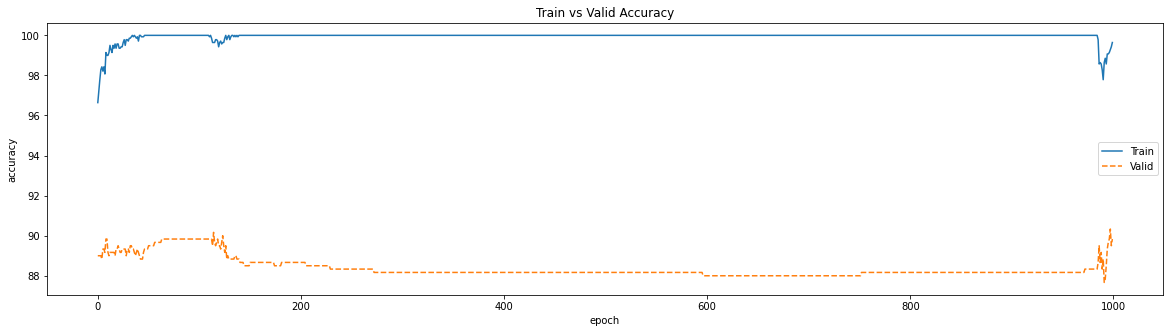

In [44]:
accuracy_plots(train_accu, eval_accu)

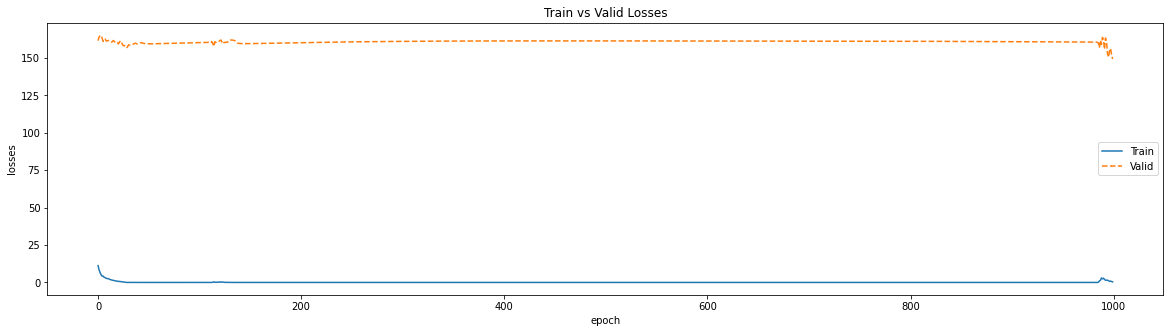

In [45]:
loss_plots(train_losses, eval_losses)

In [46]:
model = model_configs["1"]
model.load_state_dict(torch.load("models/best_model_parameters12.pth"))
model.eval()

model_1(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [47]:
with torch.no_grad():
  predicted_classes = []
  device = torch.device("cpu")
  for data in tqdm(first_five_loader):
    images,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(images)
    _, predicted = torch.max(outputs, 1)
    predicted_classes.append(predicted)

100%|██████████| 5/5 [00:00<00:00, 1073.76it/s]


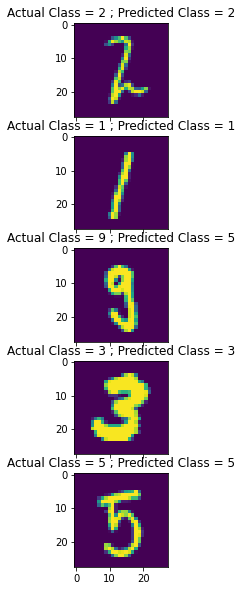

In [48]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for j in range(5):
  axs[j].imshow(first_five_test_images[j][0])
  axs[j].set_title(f"Actual Class = {first_five_test_image_labels[0+j]} ; Predicted Class = {predicted_classes[j].item()}")

for ax in axs.flat:
    ax.label_outer()

# model 1, test config 3

In [49]:
s = time.time()
eval_losses, train_losses, eval_accu, train_accu = train("1", "3")
e = time.time()

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |   39200    |
|  l1.bias  |     50     |
| l2.weight |    500     |
|  l2.bias  |     10     |
+-----------+------------+
Total Trainable Params: 39760

Epoch : 1


100%|██████████| 2/2 [00:00<00:00, 183.72it/s]



Epoch : 2


100%|██████████| 2/2 [00:00<00:00, 191.14it/s]



Epoch : 3


100%|██████████| 2/2 [00:00<00:00, 169.91it/s]



Epoch : 4


100%|██████████| 2/2 [00:00<00:00, 163.32it/s]



Epoch : 5


100%|██████████| 2/2 [00:00<00:00, 138.53it/s]



Epoch : 6


100%|██████████| 2/2 [00:00<00:00, 165.79it/s]



Epoch : 7


100%|██████████| 2/2 [00:00<00:00, 218.35it/s]



Epoch : 8


100%|██████████| 2/2 [00:00<00:00, 211.83it/s]



Epoch : 9


100%|██████████| 2/2 [00:00<00:00, 209.27it/s]



Epoch : 10


100%|██████████| 2/2 [00:00<00:00, 206.67it/s]



Epoch : 11


100%|██████████| 2/2 [00:00<00:00, 199.07it/s]



Epoch : 12


100%|██████████| 2/2 [00:00<00:00, 206.53it/s]



Epoch : 13


100%|██████████| 2/2 [00:00<00:00, 188.22it/s]



Epoch : 14


100%|██████████| 2/2 [00:00<00:00, 211.95it/s]



Epoch : 15


100%|██████████| 2/2 [00:00<00:00, 213.21it/s]



Epoch : 16


100%|██████████| 2/2 [00:00<00:00, 197.35it/s]



Epoch : 17


100%|██████████| 2/2 [00:00<00:00, 188.82it/s]



Epoch : 18


100%|██████████| 2/2 [00:00<00:00, 190.54it/s]



Epoch : 19


100%|██████████| 2/2 [00:00<00:00, 239.61it/s]



Epoch : 20


100%|██████████| 2/2 [00:00<00:00, 130.84it/s]



Epoch : 21


100%|██████████| 2/2 [00:00<00:00, 187.73it/s]



Epoch : 22


100%|██████████| 2/2 [00:00<00:00, 208.78it/s]



Epoch : 23


100%|██████████| 2/2 [00:00<00:00, 192.88it/s]



Epoch : 24


100%|██████████| 2/2 [00:00<00:00, 193.29it/s]



Epoch : 25


100%|██████████| 2/2 [00:00<00:00, 153.13it/s]



Epoch : 26


100%|██████████| 2/2 [00:00<00:00, 174.02it/s]



Epoch : 27


100%|██████████| 2/2 [00:00<00:00, 202.78it/s]



Epoch : 28


100%|██████████| 2/2 [00:00<00:00, 210.47it/s]



Epoch : 29


100%|██████████| 2/2 [00:00<00:00, 171.16it/s]



Epoch : 30


100%|██████████| 2/2 [00:00<00:00, 208.74it/s]



Epoch : 31


100%|██████████| 2/2 [00:00<00:00, 199.18it/s]



Epoch : 32


100%|██████████| 2/2 [00:00<00:00, 144.99it/s]



Epoch : 33


100%|██████████| 2/2 [00:00<00:00, 213.42it/s]



Epoch : 34


100%|██████████| 2/2 [00:00<00:00, 180.19it/s]



Epoch : 35


100%|██████████| 2/2 [00:00<00:00, 165.42it/s]



Epoch : 36


100%|██████████| 2/2 [00:00<00:00, 166.00it/s]



Epoch : 37


100%|██████████| 2/2 [00:00<00:00, 214.31it/s]



Epoch : 38


100%|██████████| 2/2 [00:00<00:00, 210.88it/s]



Epoch : 39


100%|██████████| 2/2 [00:00<00:00, 132.13it/s]



Epoch : 40


100%|██████████| 2/2 [00:00<00:00, 168.01it/s]



Epoch : 41


100%|██████████| 2/2 [00:00<00:00, 183.41it/s]



Epoch : 42


100%|██████████| 2/2 [00:00<00:00, 200.92it/s]



Epoch : 43


100%|██████████| 2/2 [00:00<00:00, 204.99it/s]



Epoch : 44


100%|██████████| 2/2 [00:00<00:00, 161.41it/s]



Epoch : 45


100%|██████████| 2/2 [00:00<00:00, 141.67it/s]



Epoch : 46


100%|██████████| 2/2 [00:00<00:00, 133.64it/s]



Epoch : 47


100%|██████████| 2/2 [00:00<00:00, 213.69it/s]



Epoch : 48


100%|██████████| 2/2 [00:00<00:00, 212.98it/s]



Epoch : 49


100%|██████████| 2/2 [00:00<00:00, 192.22it/s]



Epoch : 50


100%|██████████| 2/2 [00:00<00:00, 210.07it/s]



Epoch : 51


100%|██████████| 2/2 [00:00<00:00, 218.05it/s]



Epoch : 52


100%|██████████| 2/2 [00:00<00:00, 224.40it/s]



Epoch : 53


100%|██████████| 2/2 [00:00<00:00, 222.69it/s]



Epoch : 54


100%|██████████| 2/2 [00:00<00:00, 215.14it/s]



Epoch : 55


100%|██████████| 2/2 [00:00<00:00, 218.71it/s]



Epoch : 56


100%|██████████| 2/2 [00:00<00:00, 218.04it/s]



Epoch : 57


100%|██████████| 2/2 [00:00<00:00, 210.65it/s]



Epoch : 58


100%|██████████| 2/2 [00:00<00:00, 215.80it/s]



Epoch : 59


100%|██████████| 2/2 [00:00<00:00, 221.01it/s]



Epoch : 60


100%|██████████| 2/2 [00:00<00:00, 218.57it/s]



Epoch : 61


100%|██████████| 2/2 [00:00<00:00, 222.04it/s]



Epoch : 62


100%|██████████| 2/2 [00:00<00:00, 176.18it/s]



Epoch : 63


100%|██████████| 2/2 [00:00<00:00, 214.89it/s]



Epoch : 64


100%|██████████| 2/2 [00:00<00:00, 147.84it/s]



Epoch : 65


100%|██████████| 2/2 [00:00<00:00, 195.85it/s]



Epoch : 66


100%|██████████| 2/2 [00:00<00:00, 166.12it/s]



Epoch : 67


100%|██████████| 2/2 [00:00<00:00, 213.02it/s]



Epoch : 68


100%|██████████| 2/2 [00:00<00:00, 217.48it/s]



Epoch : 69


100%|██████████| 2/2 [00:00<00:00, 207.13it/s]



Epoch : 70


100%|██████████| 2/2 [00:00<00:00, 157.72it/s]



Epoch : 71


100%|██████████| 2/2 [00:00<00:00, 114.56it/s]



Epoch : 72


100%|██████████| 2/2 [00:00<00:00, 153.68it/s]



Epoch : 73


100%|██████████| 2/2 [00:00<00:00, 151.31it/s]



Epoch : 74


100%|██████████| 2/2 [00:00<00:00, 197.24it/s]



Epoch : 75


100%|██████████| 2/2 [00:00<00:00, 150.33it/s]



Epoch : 76


100%|██████████| 2/2 [00:00<00:00, 159.77it/s]



Epoch : 77


100%|██████████| 2/2 [00:00<00:00, 188.33it/s]



Epoch : 78


100%|██████████| 2/2 [00:00<00:00, 169.75it/s]



Epoch : 79


100%|██████████| 2/2 [00:00<00:00, 162.13it/s]



Epoch : 80


100%|██████████| 2/2 [00:00<00:00, 220.46it/s]



Epoch : 81


100%|██████████| 2/2 [00:00<00:00, 127.44it/s]



Epoch : 82


100%|██████████| 2/2 [00:00<00:00, 139.38it/s]



Epoch : 83


100%|██████████| 2/2 [00:00<00:00, 167.62it/s]



Epoch : 84


100%|██████████| 2/2 [00:00<00:00, 188.24it/s]



Epoch : 85


100%|██████████| 2/2 [00:00<00:00, 220.53it/s]



Epoch : 86


100%|██████████| 2/2 [00:00<00:00, 149.18it/s]



Epoch : 87


100%|██████████| 2/2 [00:00<00:00, 203.62it/s]



Epoch : 88


100%|██████████| 2/2 [00:00<00:00, 227.86it/s]



Epoch : 89


100%|██████████| 2/2 [00:00<00:00, 225.39it/s]



Epoch : 90


100%|██████████| 2/2 [00:00<00:00, 218.25it/s]



Epoch : 91


100%|██████████| 2/2 [00:00<00:00, 158.01it/s]



Epoch : 92


100%|██████████| 2/2 [00:00<00:00, 162.77it/s]



Epoch : 93


100%|██████████| 2/2 [00:00<00:00, 162.63it/s]



Epoch : 94


100%|██████████| 2/2 [00:00<00:00, 168.59it/s]



Epoch : 95


100%|██████████| 2/2 [00:00<00:00, 163.26it/s]



Epoch : 96


100%|██████████| 2/2 [00:00<00:00, 202.85it/s]



Epoch : 97


100%|██████████| 2/2 [00:00<00:00, 212.81it/s]



Epoch : 98


100%|██████████| 2/2 [00:00<00:00, 230.06it/s]



Epoch : 99


100%|██████████| 2/2 [00:00<00:00, 97.99it/s]



Epoch : 100


100%|██████████| 2/2 [00:00<00:00, 137.47it/s]



Epoch : 101


100%|██████████| 2/2 [00:00<00:00, 192.13it/s]



Epoch : 102


100%|██████████| 2/2 [00:00<00:00, 196.89it/s]



Epoch : 103


100%|██████████| 2/2 [00:00<00:00, 200.10it/s]



Epoch : 104


100%|██████████| 2/2 [00:00<00:00, 166.08it/s]



Epoch : 105


100%|██████████| 2/2 [00:00<00:00, 169.12it/s]



Epoch : 106


100%|██████████| 2/2 [00:00<00:00, 142.31it/s]



Epoch : 107


100%|██████████| 2/2 [00:00<00:00, 132.83it/s]



Epoch : 108


100%|██████████| 2/2 [00:00<00:00, 224.81it/s]



Epoch : 109


100%|██████████| 2/2 [00:00<00:00, 218.61it/s]



Epoch : 110


100%|██████████| 2/2 [00:00<00:00, 221.58it/s]



Epoch : 111


100%|██████████| 2/2 [00:00<00:00, 222.21it/s]



Epoch : 112


100%|██████████| 2/2 [00:00<00:00, 216.93it/s]



Epoch : 113


100%|██████████| 2/2 [00:00<00:00, 198.98it/s]



Epoch : 114


100%|██████████| 2/2 [00:00<00:00, 157.39it/s]



Epoch : 115


100%|██████████| 2/2 [00:00<00:00, 209.85it/s]



Epoch : 116


100%|██████████| 2/2 [00:00<00:00, 209.28it/s]



Epoch : 117


100%|██████████| 2/2 [00:00<00:00, 198.67it/s]



Epoch : 118


100%|██████████| 2/2 [00:00<00:00, 166.91it/s]



Epoch : 119


100%|██████████| 2/2 [00:00<00:00, 163.08it/s]



Epoch : 120


100%|██████████| 2/2 [00:00<00:00, 165.20it/s]



Epoch : 121


100%|██████████| 2/2 [00:00<00:00, 191.69it/s]



Epoch : 122


100%|██████████| 2/2 [00:00<00:00, 221.53it/s]



Epoch : 123


100%|██████████| 2/2 [00:00<00:00, 221.41it/s]



Epoch : 124


100%|██████████| 2/2 [00:00<00:00, 208.86it/s]



Epoch : 125


100%|██████████| 2/2 [00:00<00:00, 164.08it/s]



Epoch : 126


100%|██████████| 2/2 [00:00<00:00, 195.14it/s]



Epoch : 127


100%|██████████| 2/2 [00:00<00:00, 193.53it/s]



Epoch : 128


100%|██████████| 2/2 [00:00<00:00, 189.20it/s]



Epoch : 129


100%|██████████| 2/2 [00:00<00:00, 116.70it/s]



Epoch : 130


100%|██████████| 2/2 [00:00<00:00, 138.68it/s]



Epoch : 131


100%|██████████| 2/2 [00:00<00:00, 140.51it/s]



Epoch : 132


100%|██████████| 2/2 [00:00<00:00, 213.78it/s]



Epoch : 133


100%|██████████| 2/2 [00:00<00:00, 215.31it/s]



Epoch : 134


100%|██████████| 2/2 [00:00<00:00, 220.70it/s]



Epoch : 135


100%|██████████| 2/2 [00:00<00:00, 210.49it/s]



Epoch : 136


100%|██████████| 2/2 [00:00<00:00, 154.44it/s]



Epoch : 137


100%|██████████| 2/2 [00:00<00:00, 144.27it/s]



Epoch : 138


100%|██████████| 2/2 [00:00<00:00, 148.81it/s]



Epoch : 139


100%|██████████| 2/2 [00:00<00:00, 191.87it/s]



Epoch : 140


100%|██████████| 2/2 [00:00<00:00, 209.46it/s]



Epoch : 141


100%|██████████| 2/2 [00:00<00:00, 163.80it/s]



Epoch : 142


100%|██████████| 2/2 [00:00<00:00, 191.14it/s]



Epoch : 143


100%|██████████| 2/2 [00:00<00:00, 173.17it/s]



Epoch : 144


100%|██████████| 2/2 [00:00<00:00, 173.17it/s]



Epoch : 145


100%|██████████| 2/2 [00:00<00:00, 171.20it/s]



Epoch : 146


100%|██████████| 2/2 [00:00<00:00, 190.36it/s]



Epoch : 147


100%|██████████| 2/2 [00:00<00:00, 202.01it/s]



Epoch : 148


100%|██████████| 2/2 [00:00<00:00, 214.58it/s]



Epoch : 149


100%|██████████| 2/2 [00:00<00:00, 225.11it/s]



Epoch : 150


100%|██████████| 2/2 [00:00<00:00, 217.05it/s]



Epoch : 151


100%|██████████| 2/2 [00:00<00:00, 217.92it/s]



Epoch : 152


100%|██████████| 2/2 [00:00<00:00, 223.09it/s]



Epoch : 153


100%|██████████| 2/2 [00:00<00:00, 137.02it/s]



Epoch : 154


100%|██████████| 2/2 [00:00<00:00, 144.72it/s]



Epoch : 155


100%|██████████| 2/2 [00:00<00:00, 216.78it/s]



Epoch : 156


100%|██████████| 2/2 [00:00<00:00, 217.47it/s]



Epoch : 157


100%|██████████| 2/2 [00:00<00:00, 182.03it/s]



Epoch : 158


100%|██████████| 2/2 [00:00<00:00, 198.90it/s]



Epoch : 159


100%|██████████| 2/2 [00:00<00:00, 196.00it/s]



Epoch : 160


100%|██████████| 2/2 [00:00<00:00, 204.66it/s]



Epoch : 161


100%|██████████| 2/2 [00:00<00:00, 210.04it/s]



Epoch : 162


100%|██████████| 2/2 [00:00<00:00, 202.70it/s]



Epoch : 163


100%|██████████| 2/2 [00:00<00:00, 159.75it/s]



Epoch : 164


100%|██████████| 2/2 [00:00<00:00, 181.06it/s]



Epoch : 165


100%|██████████| 2/2 [00:00<00:00, 175.36it/s]



Epoch : 166


100%|██████████| 2/2 [00:00<00:00, 168.89it/s]



Epoch : 167


100%|██████████| 2/2 [00:00<00:00, 157.05it/s]



Epoch : 168


100%|██████████| 2/2 [00:00<00:00, 189.44it/s]



Epoch : 169


100%|██████████| 2/2 [00:00<00:00, 176.44it/s]



Epoch : 170


100%|██████████| 2/2 [00:00<00:00, 207.58it/s]



Epoch : 171


100%|██████████| 2/2 [00:00<00:00, 213.79it/s]



Epoch : 172


100%|██████████| 2/2 [00:00<00:00, 218.86it/s]



Epoch : 173


100%|██████████| 2/2 [00:00<00:00, 141.15it/s]



Epoch : 174


100%|██████████| 2/2 [00:00<00:00, 224.36it/s]



Epoch : 175


100%|██████████| 2/2 [00:00<00:00, 214.92it/s]



Epoch : 176


100%|██████████| 2/2 [00:00<00:00, 200.68it/s]



Epoch : 177


100%|██████████| 2/2 [00:00<00:00, 175.85it/s]



Epoch : 178


100%|██████████| 2/2 [00:00<00:00, 223.95it/s]



Epoch : 179


100%|██████████| 2/2 [00:00<00:00, 199.21it/s]



Epoch : 180


100%|██████████| 2/2 [00:00<00:00, 194.99it/s]



Epoch : 181


100%|██████████| 2/2 [00:00<00:00, 193.98it/s]



Epoch : 182


100%|██████████| 2/2 [00:00<00:00, 146.93it/s]



Epoch : 183


100%|██████████| 2/2 [00:00<00:00, 220.27it/s]



Epoch : 184


100%|██████████| 2/2 [00:00<00:00, 211.85it/s]



Epoch : 185


100%|██████████| 2/2 [00:00<00:00, 202.42it/s]



Epoch : 186


100%|██████████| 2/2 [00:00<00:00, 208.84it/s]



Epoch : 187


100%|██████████| 2/2 [00:00<00:00, 125.52it/s]



Epoch : 188


100%|██████████| 2/2 [00:00<00:00, 170.00it/s]



Epoch : 189


100%|██████████| 2/2 [00:00<00:00, 177.44it/s]



Epoch : 190


100%|██████████| 2/2 [00:00<00:00, 157.59it/s]



Epoch : 191


100%|██████████| 2/2 [00:00<00:00, 209.76it/s]



Epoch : 192


100%|██████████| 2/2 [00:00<00:00, 198.56it/s]



Epoch : 193


100%|██████████| 2/2 [00:00<00:00, 218.74it/s]



Epoch : 194


100%|██████████| 2/2 [00:00<00:00, 205.07it/s]



Epoch : 195


100%|██████████| 2/2 [00:00<00:00, 186.74it/s]



Epoch : 196


100%|██████████| 2/2 [00:00<00:00, 219.22it/s]



Epoch : 197


100%|██████████| 2/2 [00:00<00:00, 212.95it/s]



Epoch : 198


100%|██████████| 2/2 [00:00<00:00, 161.57it/s]



Epoch : 199


100%|██████████| 2/2 [00:00<00:00, 213.56it/s]



Epoch : 200


100%|██████████| 2/2 [00:00<00:00, 229.52it/s]



Epoch : 201


100%|██████████| 2/2 [00:00<00:00, 231.03it/s]



Epoch : 202


100%|██████████| 2/2 [00:00<00:00, 216.06it/s]



Epoch : 203


100%|██████████| 2/2 [00:00<00:00, 218.28it/s]



Epoch : 204


100%|██████████| 2/2 [00:00<00:00, 217.59it/s]



Epoch : 205


100%|██████████| 2/2 [00:00<00:00, 196.72it/s]



Epoch : 206


100%|██████████| 2/2 [00:00<00:00, 221.79it/s]



Epoch : 207


100%|██████████| 2/2 [00:00<00:00, 223.38it/s]



Epoch : 208


100%|██████████| 2/2 [00:00<00:00, 186.26it/s]



Epoch : 209


100%|██████████| 2/2 [00:00<00:00, 230.79it/s]



Epoch : 210


100%|██████████| 2/2 [00:00<00:00, 238.57it/s]



Epoch : 211


100%|██████████| 2/2 [00:00<00:00, 215.20it/s]



Epoch : 212


100%|██████████| 2/2 [00:00<00:00, 228.30it/s]



Epoch : 213


100%|██████████| 2/2 [00:00<00:00, 222.04it/s]



Epoch : 214


100%|██████████| 2/2 [00:00<00:00, 226.65it/s]



Epoch : 215


100%|██████████| 2/2 [00:00<00:00, 195.27it/s]



Epoch : 216


100%|██████████| 2/2 [00:00<00:00, 213.70it/s]



Epoch : 217


100%|██████████| 2/2 [00:00<00:00, 142.24it/s]



Epoch : 218


100%|██████████| 2/2 [00:00<00:00, 217.41it/s]



Epoch : 219


100%|██████████| 2/2 [00:00<00:00, 218.38it/s]



Epoch : 220


100%|██████████| 2/2 [00:00<00:00, 214.76it/s]



Epoch : 221


100%|██████████| 2/2 [00:00<00:00, 216.84it/s]



Epoch : 222


100%|██████████| 2/2 [00:00<00:00, 218.30it/s]



Epoch : 223


100%|██████████| 2/2 [00:00<00:00, 217.97it/s]



Epoch : 224


100%|██████████| 2/2 [00:00<00:00, 232.81it/s]



Epoch : 225


100%|██████████| 2/2 [00:00<00:00, 183.05it/s]



Epoch : 226


100%|██████████| 2/2 [00:00<00:00, 218.93it/s]



Epoch : 227


100%|██████████| 2/2 [00:00<00:00, 202.14it/s]



Epoch : 228


100%|██████████| 2/2 [00:00<00:00, 219.87it/s]



Epoch : 229


100%|██████████| 2/2 [00:00<00:00, 212.63it/s]



Epoch : 230


100%|██████████| 2/2 [00:00<00:00, 212.59it/s]



Epoch : 231


100%|██████████| 2/2 [00:00<00:00, 184.14it/s]



Epoch : 232


100%|██████████| 2/2 [00:00<00:00, 197.75it/s]



Epoch : 233


100%|██████████| 2/2 [00:00<00:00, 203.74it/s]



Epoch : 234


100%|██████████| 2/2 [00:00<00:00, 204.77it/s]



Epoch : 235


100%|██████████| 2/2 [00:00<00:00, 213.83it/s]



Epoch : 236


100%|██████████| 2/2 [00:00<00:00, 205.02it/s]



Epoch : 237


100%|██████████| 2/2 [00:00<00:00, 202.83it/s]



Epoch : 238


100%|██████████| 2/2 [00:00<00:00, 133.87it/s]



Epoch : 239


100%|██████████| 2/2 [00:00<00:00, 173.89it/s]



Epoch : 240


100%|██████████| 2/2 [00:00<00:00, 171.07it/s]



Epoch : 241


100%|██████████| 2/2 [00:00<00:00, 183.20it/s]



Epoch : 242


100%|██████████| 2/2 [00:00<00:00, 144.47it/s]



Epoch : 243


100%|██████████| 2/2 [00:00<00:00, 204.95it/s]



Epoch : 244


100%|██████████| 2/2 [00:00<00:00, 215.49it/s]



Epoch : 245


100%|██████████| 2/2 [00:00<00:00, 200.11it/s]



Epoch : 246


100%|██████████| 2/2 [00:00<00:00, 223.96it/s]



Epoch : 247


100%|██████████| 2/2 [00:00<00:00, 209.96it/s]



Epoch : 248


100%|██████████| 2/2 [00:00<00:00, 241.66it/s]



Epoch : 249


100%|██████████| 2/2 [00:00<00:00, 168.63it/s]



Epoch : 250


100%|██████████| 2/2 [00:00<00:00, 194.19it/s]



Epoch : 251


100%|██████████| 2/2 [00:00<00:00, 155.53it/s]



Epoch : 252


100%|██████████| 2/2 [00:00<00:00, 210.40it/s]



Epoch : 253


100%|██████████| 2/2 [00:00<00:00, 167.19it/s]



Epoch : 254


100%|██████████| 2/2 [00:00<00:00, 185.13it/s]



Epoch : 255


100%|██████████| 2/2 [00:00<00:00, 209.89it/s]



Epoch : 256


100%|██████████| 2/2 [00:00<00:00, 219.34it/s]



Epoch : 257


100%|██████████| 2/2 [00:00<00:00, 208.45it/s]



Epoch : 258


100%|██████████| 2/2 [00:00<00:00, 224.41it/s]



Epoch : 259


100%|██████████| 2/2 [00:00<00:00, 161.43it/s]



Epoch : 260


100%|██████████| 2/2 [00:00<00:00, 211.08it/s]



Epoch : 261


100%|██████████| 2/2 [00:00<00:00, 209.17it/s]



Epoch : 262


100%|██████████| 2/2 [00:00<00:00, 205.46it/s]



Epoch : 263


100%|██████████| 2/2 [00:00<00:00, 214.54it/s]



Epoch : 264


100%|██████████| 2/2 [00:00<00:00, 217.63it/s]



Epoch : 265


100%|██████████| 2/2 [00:00<00:00, 214.04it/s]



Epoch : 266


100%|██████████| 2/2 [00:00<00:00, 214.97it/s]



Epoch : 267


100%|██████████| 2/2 [00:00<00:00, 239.30it/s]



Epoch : 268


100%|██████████| 2/2 [00:00<00:00, 119.73it/s]



Epoch : 269


100%|██████████| 2/2 [00:00<00:00, 193.85it/s]



Epoch : 270


100%|██████████| 2/2 [00:00<00:00, 191.19it/s]



Epoch : 271


100%|██████████| 2/2 [00:00<00:00, 206.20it/s]



Epoch : 272


100%|██████████| 2/2 [00:00<00:00, 218.05it/s]



Epoch : 273


100%|██████████| 2/2 [00:00<00:00, 135.48it/s]



Epoch : 274


100%|██████████| 2/2 [00:00<00:00, 136.33it/s]



Epoch : 275


100%|██████████| 2/2 [00:00<00:00, 163.53it/s]



Epoch : 276


100%|██████████| 2/2 [00:00<00:00, 186.83it/s]



Epoch : 277


100%|██████████| 2/2 [00:00<00:00, 157.03it/s]



Epoch : 278


100%|██████████| 2/2 [00:00<00:00, 185.38it/s]



Epoch : 279


100%|██████████| 2/2 [00:00<00:00, 198.08it/s]



Epoch : 280


100%|██████████| 2/2 [00:00<00:00, 162.23it/s]



Epoch : 281


100%|██████████| 2/2 [00:00<00:00, 219.92it/s]



Epoch : 282


100%|██████████| 2/2 [00:00<00:00, 206.63it/s]



Epoch : 283


100%|██████████| 2/2 [00:00<00:00, 43.54it/s]



Epoch : 284


100%|██████████| 2/2 [00:00<00:00, 129.86it/s]



Epoch : 285


100%|██████████| 2/2 [00:00<00:00, 40.59it/s]



Epoch : 286


100%|██████████| 2/2 [00:00<00:00, 46.53it/s]



Epoch : 287


100%|██████████| 2/2 [00:00<00:00, 115.27it/s]



Epoch : 288


100%|██████████| 2/2 [00:00<00:00, 158.38it/s]



Epoch : 289


100%|██████████| 2/2 [00:00<00:00, 195.61it/s]



Epoch : 290


100%|██████████| 2/2 [00:00<00:00, 131.71it/s]



Epoch : 291


100%|██████████| 2/2 [00:00<00:00, 125.78it/s]



Epoch : 292


100%|██████████| 2/2 [00:00<00:00, 213.85it/s]



Epoch : 293


100%|██████████| 2/2 [00:00<00:00, 196.64it/s]



Epoch : 294


100%|██████████| 2/2 [00:00<00:00, 213.15it/s]



Epoch : 295


100%|██████████| 2/2 [00:00<00:00, 210.57it/s]



Epoch : 296


100%|██████████| 2/2 [00:00<00:00, 122.38it/s]



Epoch : 297


100%|██████████| 2/2 [00:00<00:00, 151.27it/s]



Epoch : 298


100%|██████████| 2/2 [00:00<00:00, 126.92it/s]



Epoch : 299


100%|██████████| 2/2 [00:00<00:00, 205.01it/s]



Epoch : 300


100%|██████████| 2/2 [00:00<00:00, 209.81it/s]



Epoch : 301


100%|██████████| 2/2 [00:00<00:00, 202.22it/s]



Epoch : 302


100%|██████████| 2/2 [00:00<00:00, 213.28it/s]



Epoch : 303


100%|██████████| 2/2 [00:00<00:00, 198.35it/s]



Epoch : 304


100%|██████████| 2/2 [00:00<00:00, 212.68it/s]



Epoch : 305


100%|██████████| 2/2 [00:00<00:00, 161.69it/s]



Epoch : 306


100%|██████████| 2/2 [00:00<00:00, 160.75it/s]



Epoch : 307


100%|██████████| 2/2 [00:00<00:00, 196.74it/s]



Epoch : 308


100%|██████████| 2/2 [00:00<00:00, 208.81it/s]



Epoch : 309


100%|██████████| 2/2 [00:00<00:00, 202.67it/s]



Epoch : 310


100%|██████████| 2/2 [00:00<00:00, 215.39it/s]



Epoch : 311


100%|██████████| 2/2 [00:00<00:00, 176.79it/s]



Epoch : 312


100%|██████████| 2/2 [00:00<00:00, 208.99it/s]



Epoch : 313


100%|██████████| 2/2 [00:00<00:00, 171.53it/s]



Epoch : 314


100%|██████████| 2/2 [00:00<00:00, 215.51it/s]



Epoch : 315


100%|██████████| 2/2 [00:00<00:00, 204.37it/s]



Epoch : 316


100%|██████████| 2/2 [00:00<00:00, 193.29it/s]



Epoch : 317


100%|██████████| 2/2 [00:00<00:00, 201.99it/s]



Epoch : 318


100%|██████████| 2/2 [00:00<00:00, 214.47it/s]



Epoch : 319


100%|██████████| 2/2 [00:00<00:00, 198.51it/s]



Epoch : 320


100%|██████████| 2/2 [00:00<00:00, 215.03it/s]



Epoch : 321


100%|██████████| 2/2 [00:00<00:00, 126.73it/s]



Epoch : 322


100%|██████████| 2/2 [00:00<00:00, 93.71it/s]



Epoch : 323


100%|██████████| 2/2 [00:00<00:00, 215.60it/s]



Epoch : 324


100%|██████████| 2/2 [00:00<00:00, 170.21it/s]



Epoch : 325


100%|██████████| 2/2 [00:00<00:00, 175.44it/s]



Epoch : 326


100%|██████████| 2/2 [00:00<00:00, 180.63it/s]



Epoch : 327


100%|██████████| 2/2 [00:00<00:00, 171.21it/s]



Epoch : 328


100%|██████████| 2/2 [00:00<00:00, 202.57it/s]



Epoch : 329


100%|██████████| 2/2 [00:00<00:00, 208.00it/s]



Epoch : 330


100%|██████████| 2/2 [00:00<00:00, 200.92it/s]



Epoch : 331


100%|██████████| 2/2 [00:00<00:00, 145.39it/s]



Epoch : 332


100%|██████████| 2/2 [00:00<00:00, 184.33it/s]



Epoch : 333


100%|██████████| 2/2 [00:00<00:00, 139.88it/s]



Epoch : 334


100%|██████████| 2/2 [00:00<00:00, 171.42it/s]



Epoch : 335


100%|██████████| 2/2 [00:00<00:00, 198.15it/s]



Epoch : 336


100%|██████████| 2/2 [00:00<00:00, 175.62it/s]



Epoch : 337


100%|██████████| 2/2 [00:00<00:00, 202.58it/s]



Epoch : 338


100%|██████████| 2/2 [00:00<00:00, 203.20it/s]



Epoch : 339


100%|██████████| 2/2 [00:00<00:00, 196.63it/s]



Epoch : 340


100%|██████████| 2/2 [00:00<00:00, 137.11it/s]



Epoch : 341


100%|██████████| 2/2 [00:00<00:00, 160.88it/s]



Epoch : 342


100%|██████████| 2/2 [00:00<00:00, 207.65it/s]



Epoch : 343


100%|██████████| 2/2 [00:00<00:00, 201.44it/s]



Epoch : 344


100%|██████████| 2/2 [00:00<00:00, 162.60it/s]



Epoch : 345


100%|██████████| 2/2 [00:00<00:00, 216.82it/s]



Epoch : 346


100%|██████████| 2/2 [00:00<00:00, 216.23it/s]



Epoch : 347


100%|██████████| 2/2 [00:00<00:00, 208.46it/s]



Epoch : 348


100%|██████████| 2/2 [00:00<00:00, 201.50it/s]



Epoch : 349


100%|██████████| 2/2 [00:00<00:00, 222.48it/s]



Epoch : 350


100%|██████████| 2/2 [00:00<00:00, 227.44it/s]



Epoch : 351


100%|██████████| 2/2 [00:00<00:00, 221.80it/s]



Epoch : 352


100%|██████████| 2/2 [00:00<00:00, 216.93it/s]



Epoch : 353


100%|██████████| 2/2 [00:00<00:00, 213.17it/s]



Epoch : 354


100%|██████████| 2/2 [00:00<00:00, 165.31it/s]



Epoch : 355


100%|██████████| 2/2 [00:00<00:00, 222.13it/s]



Epoch : 356


100%|██████████| 2/2 [00:00<00:00, 165.07it/s]



Epoch : 357


100%|██████████| 2/2 [00:00<00:00, 204.05it/s]



Epoch : 358


100%|██████████| 2/2 [00:00<00:00, 210.81it/s]



Epoch : 359


100%|██████████| 2/2 [00:00<00:00, 210.43it/s]



Epoch : 360


100%|██████████| 2/2 [00:00<00:00, 137.37it/s]



Epoch : 361


100%|██████████| 2/2 [00:00<00:00, 173.86it/s]



Epoch : 362


100%|██████████| 2/2 [00:00<00:00, 213.97it/s]



Epoch : 363


100%|██████████| 2/2 [00:00<00:00, 218.71it/s]



Epoch : 364


100%|██████████| 2/2 [00:00<00:00, 174.91it/s]



Epoch : 365


100%|██████████| 2/2 [00:00<00:00, 208.79it/s]



Epoch : 366


100%|██████████| 2/2 [00:00<00:00, 218.19it/s]



Epoch : 367


100%|██████████| 2/2 [00:00<00:00, 224.53it/s]



Epoch : 368


100%|██████████| 2/2 [00:00<00:00, 232.20it/s]



Epoch : 369


100%|██████████| 2/2 [00:00<00:00, 185.95it/s]



Epoch : 370


100%|██████████| 2/2 [00:00<00:00, 264.45it/s]



Epoch : 371


100%|██████████| 2/2 [00:00<00:00, 143.73it/s]



Epoch : 372


100%|██████████| 2/2 [00:00<00:00, 131.25it/s]



Epoch : 373


100%|██████████| 2/2 [00:00<00:00, 160.50it/s]



Epoch : 374


100%|██████████| 2/2 [00:00<00:00, 169.59it/s]



Epoch : 375


100%|██████████| 2/2 [00:00<00:00, 186.38it/s]



Epoch : 376


100%|██████████| 2/2 [00:00<00:00, 208.88it/s]



Epoch : 377


100%|██████████| 2/2 [00:00<00:00, 163.79it/s]



Epoch : 378


100%|██████████| 2/2 [00:00<00:00, 187.00it/s]



Epoch : 379


100%|██████████| 2/2 [00:00<00:00, 150.08it/s]



Epoch : 380


100%|██████████| 2/2 [00:00<00:00, 185.08it/s]



Epoch : 381


100%|██████████| 2/2 [00:00<00:00, 196.25it/s]



Epoch : 382


100%|██████████| 2/2 [00:00<00:00, 168.83it/s]



Epoch : 383


100%|██████████| 2/2 [00:00<00:00, 212.23it/s]



Epoch : 384


100%|██████████| 2/2 [00:00<00:00, 174.17it/s]



Epoch : 385


100%|██████████| 2/2 [00:00<00:00, 129.94it/s]



Epoch : 386


100%|██████████| 2/2 [00:00<00:00, 158.10it/s]



Epoch : 387


100%|██████████| 2/2 [00:00<00:00, 109.09it/s]



Epoch : 388


100%|██████████| 2/2 [00:00<00:00, 128.68it/s]



Epoch : 389


100%|██████████| 2/2 [00:00<00:00, 161.94it/s]



Epoch : 390


100%|██████████| 2/2 [00:00<00:00, 197.02it/s]



Epoch : 391


100%|██████████| 2/2 [00:00<00:00, 175.38it/s]



Epoch : 392


100%|██████████| 2/2 [00:00<00:00, 207.97it/s]



Epoch : 393


100%|██████████| 2/2 [00:00<00:00, 127.17it/s]



Epoch : 394


100%|██████████| 2/2 [00:00<00:00, 216.37it/s]



Epoch : 395


100%|██████████| 2/2 [00:00<00:00, 206.31it/s]



Epoch : 396


100%|██████████| 2/2 [00:00<00:00, 214.93it/s]



Epoch : 397


100%|██████████| 2/2 [00:00<00:00, 205.18it/s]



Epoch : 398


100%|██████████| 2/2 [00:00<00:00, 216.79it/s]



Epoch : 399


100%|██████████| 2/2 [00:00<00:00, 208.16it/s]



Epoch : 400


100%|██████████| 2/2 [00:00<00:00, 217.99it/s]



Epoch : 401


100%|██████████| 2/2 [00:00<00:00, 126.87it/s]



Epoch : 402


100%|██████████| 2/2 [00:00<00:00, 166.20it/s]



Epoch : 403


100%|██████████| 2/2 [00:00<00:00, 174.41it/s]



Epoch : 404


100%|██████████| 2/2 [00:00<00:00, 170.71it/s]



Epoch : 405


100%|██████████| 2/2 [00:00<00:00, 174.39it/s]



Epoch : 406


100%|██████████| 2/2 [00:00<00:00, 167.63it/s]



Epoch : 407


100%|██████████| 2/2 [00:00<00:00, 178.66it/s]



Epoch : 408


100%|██████████| 2/2 [00:00<00:00, 192.86it/s]



Epoch : 409


100%|██████████| 2/2 [00:00<00:00, 211.42it/s]



Epoch : 410


100%|██████████| 2/2 [00:00<00:00, 215.66it/s]



Epoch : 411


100%|██████████| 2/2 [00:00<00:00, 217.10it/s]



Epoch : 412


100%|██████████| 2/2 [00:00<00:00, 195.73it/s]



Epoch : 413


100%|██████████| 2/2 [00:00<00:00, 221.08it/s]



Epoch : 414


100%|██████████| 2/2 [00:00<00:00, 208.12it/s]



Epoch : 415


100%|██████████| 2/2 [00:00<00:00, 216.99it/s]



Epoch : 416


100%|██████████| 2/2 [00:00<00:00, 203.88it/s]



Epoch : 417


100%|██████████| 2/2 [00:00<00:00, 217.67it/s]



Epoch : 418


100%|██████████| 2/2 [00:00<00:00, 222.37it/s]



Epoch : 419


100%|██████████| 2/2 [00:00<00:00, 191.07it/s]



Epoch : 420


100%|██████████| 2/2 [00:00<00:00, 206.93it/s]



Epoch : 421


100%|██████████| 2/2 [00:00<00:00, 218.78it/s]



Epoch : 422


100%|██████████| 2/2 [00:00<00:00, 211.23it/s]



Epoch : 423


100%|██████████| 2/2 [00:00<00:00, 176.39it/s]



Epoch : 424


100%|██████████| 2/2 [00:00<00:00, 211.93it/s]



Epoch : 425


100%|██████████| 2/2 [00:00<00:00, 220.41it/s]



Epoch : 426


100%|██████████| 2/2 [00:00<00:00, 224.59it/s]



Epoch : 427


100%|██████████| 2/2 [00:00<00:00, 208.65it/s]



Epoch : 428


100%|██████████| 2/2 [00:00<00:00, 213.34it/s]



Epoch : 429


100%|██████████| 2/2 [00:00<00:00, 209.91it/s]



Epoch : 430


100%|██████████| 2/2 [00:00<00:00, 189.98it/s]



Epoch : 431


100%|██████████| 2/2 [00:00<00:00, 144.43it/s]



Epoch : 432


100%|██████████| 2/2 [00:00<00:00, 165.74it/s]



Epoch : 433


100%|██████████| 2/2 [00:00<00:00, 165.10it/s]



Epoch : 434


100%|██████████| 2/2 [00:00<00:00, 118.41it/s]



Epoch : 435


100%|██████████| 2/2 [00:00<00:00, 134.47it/s]



Epoch : 436


100%|██████████| 2/2 [00:00<00:00, 214.30it/s]



Epoch : 437


100%|██████████| 2/2 [00:00<00:00, 211.26it/s]



Epoch : 438


100%|██████████| 2/2 [00:00<00:00, 217.04it/s]



Epoch : 439


100%|██████████| 2/2 [00:00<00:00, 221.65it/s]



Epoch : 440


100%|██████████| 2/2 [00:00<00:00, 222.99it/s]



Epoch : 441


100%|██████████| 2/2 [00:00<00:00, 225.42it/s]



Epoch : 442


100%|██████████| 2/2 [00:00<00:00, 225.31it/s]



Epoch : 443


100%|██████████| 2/2 [00:00<00:00, 206.98it/s]



Epoch : 444


100%|██████████| 2/2 [00:00<00:00, 182.23it/s]



Epoch : 445


100%|██████████| 2/2 [00:00<00:00, 164.37it/s]



Epoch : 446


100%|██████████| 2/2 [00:00<00:00, 190.74it/s]



Epoch : 447


100%|██████████| 2/2 [00:00<00:00, 203.74it/s]



Epoch : 448


100%|██████████| 2/2 [00:00<00:00, 200.91it/s]



Epoch : 449


100%|██████████| 2/2 [00:00<00:00, 215.36it/s]



Epoch : 450


100%|██████████| 2/2 [00:00<00:00, 221.77it/s]



Epoch : 451


100%|██████████| 2/2 [00:00<00:00, 223.94it/s]



Epoch : 452


100%|██████████| 2/2 [00:00<00:00, 194.89it/s]



Epoch : 453


100%|██████████| 2/2 [00:00<00:00, 202.43it/s]



Epoch : 454


100%|██████████| 2/2 [00:00<00:00, 202.45it/s]



Epoch : 455


100%|██████████| 2/2 [00:00<00:00, 164.33it/s]



Epoch : 456


100%|██████████| 2/2 [00:00<00:00, 200.71it/s]



Epoch : 457


100%|██████████| 2/2 [00:00<00:00, 116.28it/s]



Epoch : 458


100%|██████████| 2/2 [00:00<00:00, 187.82it/s]



Epoch : 459


100%|██████████| 2/2 [00:00<00:00, 213.52it/s]



Epoch : 460


100%|██████████| 2/2 [00:00<00:00, 237.91it/s]



Epoch : 461


100%|██████████| 2/2 [00:00<00:00, 215.87it/s]



Epoch : 462


100%|██████████| 2/2 [00:00<00:00, 215.38it/s]



Epoch : 463


100%|██████████| 2/2 [00:00<00:00, 212.35it/s]



Epoch : 464


100%|██████████| 2/2 [00:00<00:00, 211.07it/s]



Epoch : 465


100%|██████████| 2/2 [00:00<00:00, 217.99it/s]



Epoch : 466


100%|██████████| 2/2 [00:00<00:00, 173.53it/s]



Epoch : 467


100%|██████████| 2/2 [00:00<00:00, 209.72it/s]



Epoch : 468


100%|██████████| 2/2 [00:00<00:00, 217.19it/s]



Epoch : 469


100%|██████████| 2/2 [00:00<00:00, 207.77it/s]



Epoch : 470


100%|██████████| 2/2 [00:00<00:00, 151.36it/s]



Epoch : 471


100%|██████████| 2/2 [00:00<00:00, 120.06it/s]



Epoch : 472


100%|██████████| 2/2 [00:00<00:00, 193.87it/s]



Epoch : 473


100%|██████████| 2/2 [00:00<00:00, 202.75it/s]



Epoch : 474


100%|██████████| 2/2 [00:00<00:00, 231.24it/s]



Epoch : 475


100%|██████████| 2/2 [00:00<00:00, 198.25it/s]



Epoch : 476


100%|██████████| 2/2 [00:00<00:00, 216.72it/s]



Epoch : 477


100%|██████████| 2/2 [00:00<00:00, 221.14it/s]



Epoch : 478


100%|██████████| 2/2 [00:00<00:00, 142.21it/s]



Epoch : 479


100%|██████████| 2/2 [00:00<00:00, 158.04it/s]



Epoch : 480


100%|██████████| 2/2 [00:00<00:00, 197.48it/s]



Epoch : 481


100%|██████████| 2/2 [00:00<00:00, 155.50it/s]



Epoch : 482


100%|██████████| 2/2 [00:00<00:00, 170.48it/s]



Epoch : 483


100%|██████████| 2/2 [00:00<00:00, 170.34it/s]



Epoch : 484


100%|██████████| 2/2 [00:00<00:00, 160.99it/s]



Epoch : 485


100%|██████████| 2/2 [00:00<00:00, 172.60it/s]



Epoch : 486


100%|██████████| 2/2 [00:00<00:00, 183.07it/s]



Epoch : 487


100%|██████████| 2/2 [00:00<00:00, 204.72it/s]



Epoch : 488


100%|██████████| 2/2 [00:00<00:00, 197.40it/s]



Epoch : 489


100%|██████████| 2/2 [00:00<00:00, 193.54it/s]



Epoch : 490


100%|██████████| 2/2 [00:00<00:00, 191.99it/s]



Epoch : 491


100%|██████████| 2/2 [00:00<00:00, 184.32it/s]



Epoch : 492


100%|██████████| 2/2 [00:00<00:00, 196.78it/s]



Epoch : 493


100%|██████████| 2/2 [00:00<00:00, 209.63it/s]



Epoch : 494


100%|██████████| 2/2 [00:00<00:00, 204.03it/s]



Epoch : 495


100%|██████████| 2/2 [00:00<00:00, 223.57it/s]



Epoch : 496


100%|██████████| 2/2 [00:00<00:00, 196.78it/s]



Epoch : 497


100%|██████████| 2/2 [00:00<00:00, 167.48it/s]



Epoch : 498


100%|██████████| 2/2 [00:00<00:00, 209.90it/s]



Epoch : 499


100%|██████████| 2/2 [00:00<00:00, 198.89it/s]



Epoch : 500


100%|██████████| 2/2 [00:00<00:00, 196.27it/s]



Epoch : 501


100%|██████████| 2/2 [00:00<00:00, 216.80it/s]



Epoch : 502


100%|██████████| 2/2 [00:00<00:00, 209.31it/s]



Epoch : 503


100%|██████████| 2/2 [00:00<00:00, 217.48it/s]



Epoch : 504


100%|██████████| 2/2 [00:00<00:00, 241.48it/s]



Epoch : 505


100%|██████████| 2/2 [00:00<00:00, 148.12it/s]



Epoch : 506


100%|██████████| 2/2 [00:00<00:00, 182.37it/s]



Epoch : 507


100%|██████████| 2/2 [00:00<00:00, 149.93it/s]



Epoch : 508


100%|██████████| 2/2 [00:00<00:00, 168.15it/s]



Epoch : 509


100%|██████████| 2/2 [00:00<00:00, 154.72it/s]



Epoch : 510


100%|██████████| 2/2 [00:00<00:00, 176.67it/s]



Epoch : 511


100%|██████████| 2/2 [00:00<00:00, 183.88it/s]



Epoch : 512


100%|██████████| 2/2 [00:00<00:00, 180.26it/s]



Epoch : 513


100%|██████████| 2/2 [00:00<00:00, 213.72it/s]



Epoch : 514


100%|██████████| 2/2 [00:00<00:00, 207.39it/s]



Epoch : 515


100%|██████████| 2/2 [00:00<00:00, 228.34it/s]



Epoch : 516


100%|██████████| 2/2 [00:00<00:00, 210.68it/s]



Epoch : 517


100%|██████████| 2/2 [00:00<00:00, 216.12it/s]



Epoch : 518


100%|██████████| 2/2 [00:00<00:00, 225.16it/s]



Epoch : 519


100%|██████████| 2/2 [00:00<00:00, 215.82it/s]



Epoch : 520


100%|██████████| 2/2 [00:00<00:00, 233.01it/s]



Epoch : 521


100%|██████████| 2/2 [00:00<00:00, 198.52it/s]



Epoch : 522


100%|██████████| 2/2 [00:00<00:00, 137.03it/s]



Epoch : 523


100%|██████████| 2/2 [00:00<00:00, 217.32it/s]



Epoch : 524


100%|██████████| 2/2 [00:00<00:00, 208.97it/s]



Epoch : 525


100%|██████████| 2/2 [00:00<00:00, 208.79it/s]



Epoch : 526


100%|██████████| 2/2 [00:00<00:00, 218.15it/s]



Epoch : 527


100%|██████████| 2/2 [00:00<00:00, 216.51it/s]



Epoch : 528


100%|██████████| 2/2 [00:00<00:00, 208.77it/s]



Epoch : 529


100%|██████████| 2/2 [00:00<00:00, 211.66it/s]



Epoch : 530


100%|██████████| 2/2 [00:00<00:00, 209.13it/s]



Epoch : 531


100%|██████████| 2/2 [00:00<00:00, 207.72it/s]



Epoch : 532


100%|██████████| 2/2 [00:00<00:00, 201.39it/s]



Epoch : 533


100%|██████████| 2/2 [00:00<00:00, 214.09it/s]



Epoch : 534


100%|██████████| 2/2 [00:00<00:00, 203.07it/s]



Epoch : 535


100%|██████████| 2/2 [00:00<00:00, 209.58it/s]



Epoch : 536


100%|██████████| 2/2 [00:00<00:00, 220.59it/s]



Epoch : 537


100%|██████████| 2/2 [00:00<00:00, 208.24it/s]



Epoch : 538


100%|██████████| 2/2 [00:00<00:00, 214.38it/s]



Epoch : 539


100%|██████████| 2/2 [00:00<00:00, 217.51it/s]



Epoch : 540


100%|██████████| 2/2 [00:00<00:00, 204.77it/s]



Epoch : 541


100%|██████████| 2/2 [00:00<00:00, 210.05it/s]



Epoch : 542


100%|██████████| 2/2 [00:00<00:00, 227.45it/s]



Epoch : 543


100%|██████████| 2/2 [00:00<00:00, 206.89it/s]



Epoch : 544


100%|██████████| 2/2 [00:00<00:00, 163.24it/s]



Epoch : 545


100%|██████████| 2/2 [00:00<00:00, 204.80it/s]



Epoch : 546


100%|██████████| 2/2 [00:00<00:00, 220.17it/s]



Epoch : 547


100%|██████████| 2/2 [00:00<00:00, 210.18it/s]



Epoch : 548


100%|██████████| 2/2 [00:00<00:00, 209.07it/s]



Epoch : 549


100%|██████████| 2/2 [00:00<00:00, 223.99it/s]



Epoch : 550


100%|██████████| 2/2 [00:00<00:00, 221.49it/s]



Epoch : 551


100%|██████████| 2/2 [00:00<00:00, 234.59it/s]



Epoch : 552


100%|██████████| 2/2 [00:00<00:00, 227.69it/s]



Epoch : 553


100%|██████████| 2/2 [00:00<00:00, 226.46it/s]



Epoch : 554


100%|██████████| 2/2 [00:00<00:00, 214.30it/s]



Epoch : 555


100%|██████████| 2/2 [00:00<00:00, 217.18it/s]



Epoch : 556


100%|██████████| 2/2 [00:00<00:00, 227.13it/s]



Epoch : 557


100%|██████████| 2/2 [00:00<00:00, 219.46it/s]



Epoch : 558


100%|██████████| 2/2 [00:00<00:00, 138.00it/s]



Epoch : 559


100%|██████████| 2/2 [00:00<00:00, 126.72it/s]



Epoch : 560


100%|██████████| 2/2 [00:00<00:00, 153.09it/s]



Epoch : 561


100%|██████████| 2/2 [00:00<00:00, 170.92it/s]



Epoch : 562


100%|██████████| 2/2 [00:00<00:00, 119.61it/s]



Epoch : 563


100%|██████████| 2/2 [00:00<00:00, 151.26it/s]



Epoch : 564


100%|██████████| 2/2 [00:00<00:00, 200.44it/s]



Epoch : 565


100%|██████████| 2/2 [00:00<00:00, 225.27it/s]



Epoch : 566


100%|██████████| 2/2 [00:00<00:00, 210.52it/s]



Epoch : 567


100%|██████████| 2/2 [00:00<00:00, 223.52it/s]



Epoch : 568


100%|██████████| 2/2 [00:00<00:00, 227.62it/s]



Epoch : 569


100%|██████████| 2/2 [00:00<00:00, 221.53it/s]



Epoch : 570


100%|██████████| 2/2 [00:00<00:00, 220.95it/s]



Epoch : 571


100%|██████████| 2/2 [00:00<00:00, 222.66it/s]



Epoch : 572


100%|██████████| 2/2 [00:00<00:00, 215.95it/s]



Epoch : 573


100%|██████████| 2/2 [00:00<00:00, 218.17it/s]



Epoch : 574


100%|██████████| 2/2 [00:00<00:00, 157.06it/s]



Epoch : 575


100%|██████████| 2/2 [00:00<00:00, 205.91it/s]



Epoch : 576


100%|██████████| 2/2 [00:00<00:00, 232.51it/s]



Epoch : 577


100%|██████████| 2/2 [00:00<00:00, 227.93it/s]



Epoch : 578


100%|██████████| 2/2 [00:00<00:00, 222.43it/s]



Epoch : 579


100%|██████████| 2/2 [00:00<00:00, 144.72it/s]



Epoch : 580


100%|██████████| 2/2 [00:00<00:00, 220.51it/s]



Epoch : 581


100%|██████████| 2/2 [00:00<00:00, 205.30it/s]



Epoch : 582


100%|██████████| 2/2 [00:00<00:00, 216.32it/s]



Epoch : 583


100%|██████████| 2/2 [00:00<00:00, 209.85it/s]



Epoch : 584


100%|██████████| 2/2 [00:00<00:00, 172.47it/s]



Epoch : 585


100%|██████████| 2/2 [00:00<00:00, 213.27it/s]



Epoch : 586


100%|██████████| 2/2 [00:00<00:00, 223.03it/s]



Epoch : 587


100%|██████████| 2/2 [00:00<00:00, 221.61it/s]



Epoch : 588


100%|██████████| 2/2 [00:00<00:00, 226.90it/s]



Epoch : 589


100%|██████████| 2/2 [00:00<00:00, 208.68it/s]



Epoch : 590


100%|██████████| 2/2 [00:00<00:00, 217.00it/s]



Epoch : 591


100%|██████████| 2/2 [00:00<00:00, 197.56it/s]



Epoch : 592


100%|██████████| 2/2 [00:00<00:00, 205.55it/s]



Epoch : 593


100%|██████████| 2/2 [00:00<00:00, 143.82it/s]



Epoch : 594


100%|██████████| 2/2 [00:00<00:00, 201.14it/s]



Epoch : 595


100%|██████████| 2/2 [00:00<00:00, 212.34it/s]



Epoch : 596


100%|██████████| 2/2 [00:00<00:00, 222.20it/s]



Epoch : 597


100%|██████████| 2/2 [00:00<00:00, 232.33it/s]



Epoch : 598


100%|██████████| 2/2 [00:00<00:00, 219.04it/s]



Epoch : 599


100%|██████████| 2/2 [00:00<00:00, 227.45it/s]



Epoch : 600


100%|██████████| 2/2 [00:00<00:00, 179.92it/s]



Epoch : 601


100%|██████████| 2/2 [00:00<00:00, 165.81it/s]



Epoch : 602


100%|██████████| 2/2 [00:00<00:00, 207.25it/s]



Epoch : 603


100%|██████████| 2/2 [00:00<00:00, 210.38it/s]



Epoch : 604


100%|██████████| 2/2 [00:00<00:00, 229.11it/s]



Epoch : 605


100%|██████████| 2/2 [00:00<00:00, 228.32it/s]



Epoch : 606


100%|██████████| 2/2 [00:00<00:00, 221.64it/s]



Epoch : 607


100%|██████████| 2/2 [00:00<00:00, 218.62it/s]



Epoch : 608


100%|██████████| 2/2 [00:00<00:00, 221.11it/s]



Epoch : 609


100%|██████████| 2/2 [00:00<00:00, 218.56it/s]



Epoch : 610


100%|██████████| 2/2 [00:00<00:00, 217.87it/s]



Epoch : 611


100%|██████████| 2/2 [00:00<00:00, 230.93it/s]



Epoch : 612


100%|██████████| 2/2 [00:00<00:00, 233.25it/s]



Epoch : 613


100%|██████████| 2/2 [00:00<00:00, 223.73it/s]



Epoch : 614


100%|██████████| 2/2 [00:00<00:00, 226.67it/s]



Epoch : 615


100%|██████████| 2/2 [00:00<00:00, 225.48it/s]



Epoch : 616


100%|██████████| 2/2 [00:00<00:00, 168.95it/s]



Epoch : 617


100%|██████████| 2/2 [00:00<00:00, 178.36it/s]



Epoch : 618


100%|██████████| 2/2 [00:00<00:00, 228.92it/s]



Epoch : 619


100%|██████████| 2/2 [00:00<00:00, 227.08it/s]



Epoch : 620


100%|██████████| 2/2 [00:00<00:00, 223.98it/s]



Epoch : 621


100%|██████████| 2/2 [00:00<00:00, 223.72it/s]



Epoch : 622


100%|██████████| 2/2 [00:00<00:00, 216.31it/s]



Epoch : 623


100%|██████████| 2/2 [00:00<00:00, 213.62it/s]



Epoch : 624


100%|██████████| 2/2 [00:00<00:00, 214.07it/s]



Epoch : 625


100%|██████████| 2/2 [00:00<00:00, 222.26it/s]



Epoch : 626


100%|██████████| 2/2 [00:00<00:00, 187.97it/s]



Epoch : 627


100%|██████████| 2/2 [00:00<00:00, 214.86it/s]



Epoch : 628


100%|██████████| 2/2 [00:00<00:00, 136.18it/s]



Epoch : 629


100%|██████████| 2/2 [00:00<00:00, 228.72it/s]



Epoch : 630


100%|██████████| 2/2 [00:00<00:00, 203.87it/s]



Epoch : 631


100%|██████████| 2/2 [00:00<00:00, 225.52it/s]



Epoch : 632


100%|██████████| 2/2 [00:00<00:00, 224.93it/s]



Epoch : 633


100%|██████████| 2/2 [00:00<00:00, 219.89it/s]



Epoch : 634


100%|██████████| 2/2 [00:00<00:00, 219.57it/s]



Epoch : 635


100%|██████████| 2/2 [00:00<00:00, 226.28it/s]



Epoch : 636


100%|██████████| 2/2 [00:00<00:00, 226.15it/s]



Epoch : 637


100%|██████████| 2/2 [00:00<00:00, 222.68it/s]



Epoch : 638


100%|██████████| 2/2 [00:00<00:00, 220.94it/s]



Epoch : 639


100%|██████████| 2/2 [00:00<00:00, 127.40it/s]



Epoch : 640


100%|██████████| 2/2 [00:00<00:00, 201.19it/s]



Epoch : 641


100%|██████████| 2/2 [00:00<00:00, 179.05it/s]



Epoch : 642


100%|██████████| 2/2 [00:00<00:00, 129.71it/s]



Epoch : 643


100%|██████████| 2/2 [00:00<00:00, 181.48it/s]



Epoch : 644


100%|██████████| 2/2 [00:00<00:00, 173.74it/s]



Epoch : 645


100%|██████████| 2/2 [00:00<00:00, 167.14it/s]



Epoch : 646


100%|██████████| 2/2 [00:00<00:00, 132.14it/s]



Epoch : 647


100%|██████████| 2/2 [00:00<00:00, 206.91it/s]



Epoch : 648


100%|██████████| 2/2 [00:00<00:00, 205.73it/s]



Epoch : 649


100%|██████████| 2/2 [00:00<00:00, 212.48it/s]



Epoch : 650


100%|██████████| 2/2 [00:00<00:00, 212.76it/s]



Epoch : 651


100%|██████████| 2/2 [00:00<00:00, 213.68it/s]



Epoch : 652


100%|██████████| 2/2 [00:00<00:00, 145.12it/s]



Epoch : 653


100%|██████████| 2/2 [00:00<00:00, 195.07it/s]



Epoch : 654


100%|██████████| 2/2 [00:00<00:00, 159.03it/s]



Epoch : 655


100%|██████████| 2/2 [00:00<00:00, 222.37it/s]



Epoch : 656


100%|██████████| 2/2 [00:00<00:00, 214.91it/s]



Epoch : 657


100%|██████████| 2/2 [00:00<00:00, 187.41it/s]



Epoch : 658


100%|██████████| 2/2 [00:00<00:00, 205.99it/s]



Epoch : 659


100%|██████████| 2/2 [00:00<00:00, 210.99it/s]



Epoch : 660


100%|██████████| 2/2 [00:00<00:00, 206.06it/s]



Epoch : 661


100%|██████████| 2/2 [00:00<00:00, 214.61it/s]



Epoch : 662


100%|██████████| 2/2 [00:00<00:00, 228.26it/s]



Epoch : 663


100%|██████████| 2/2 [00:00<00:00, 208.31it/s]



Epoch : 664


100%|██████████| 2/2 [00:00<00:00, 223.08it/s]



Epoch : 665


100%|██████████| 2/2 [00:00<00:00, 214.15it/s]



Epoch : 666


100%|██████████| 2/2 [00:00<00:00, 196.51it/s]



Epoch : 667


100%|██████████| 2/2 [00:00<00:00, 138.11it/s]



Epoch : 668


100%|██████████| 2/2 [00:00<00:00, 216.47it/s]



Epoch : 669


100%|██████████| 2/2 [00:00<00:00, 206.20it/s]



Epoch : 670


100%|██████████| 2/2 [00:00<00:00, 204.93it/s]



Epoch : 671


100%|██████████| 2/2 [00:00<00:00, 220.90it/s]



Epoch : 672


100%|██████████| 2/2 [00:00<00:00, 195.83it/s]



Epoch : 673


100%|██████████| 2/2 [00:00<00:00, 217.87it/s]



Epoch : 674


100%|██████████| 2/2 [00:00<00:00, 227.77it/s]



Epoch : 675


100%|██████████| 2/2 [00:00<00:00, 214.01it/s]



Epoch : 676


100%|██████████| 2/2 [00:00<00:00, 232.18it/s]



Epoch : 677


100%|██████████| 2/2 [00:00<00:00, 215.33it/s]



Epoch : 678


100%|██████████| 2/2 [00:00<00:00, 218.03it/s]



Epoch : 679


100%|██████████| 2/2 [00:00<00:00, 181.80it/s]



Epoch : 680


100%|██████████| 2/2 [00:00<00:00, 219.77it/s]



Epoch : 681


100%|██████████| 2/2 [00:00<00:00, 211.97it/s]



Epoch : 682


100%|██████████| 2/2 [00:00<00:00, 209.73it/s]



Epoch : 683


100%|██████████| 2/2 [00:00<00:00, 202.98it/s]



Epoch : 684


100%|██████████| 2/2 [00:00<00:00, 183.78it/s]



Epoch : 685


100%|██████████| 2/2 [00:00<00:00, 149.90it/s]



Epoch : 686


100%|██████████| 2/2 [00:00<00:00, 221.32it/s]



Epoch : 687


100%|██████████| 2/2 [00:00<00:00, 131.62it/s]



Epoch : 688


100%|██████████| 2/2 [00:00<00:00, 157.54it/s]



Epoch : 689


100%|██████████| 2/2 [00:00<00:00, 213.70it/s]



Epoch : 690


100%|██████████| 2/2 [00:00<00:00, 208.87it/s]



Epoch : 691


100%|██████████| 2/2 [00:00<00:00, 173.99it/s]



Epoch : 692


100%|██████████| 2/2 [00:00<00:00, 199.16it/s]



Epoch : 693


100%|██████████| 2/2 [00:00<00:00, 200.68it/s]



Epoch : 694


100%|██████████| 2/2 [00:00<00:00, 211.00it/s]



Epoch : 695


100%|██████████| 2/2 [00:00<00:00, 210.97it/s]



Epoch : 696


100%|██████████| 2/2 [00:00<00:00, 189.71it/s]



Epoch : 697


100%|██████████| 2/2 [00:00<00:00, 207.44it/s]



Epoch : 698


100%|██████████| 2/2 [00:00<00:00, 212.91it/s]



Epoch : 699


100%|██████████| 2/2 [00:00<00:00, 204.13it/s]



Epoch : 700


100%|██████████| 2/2 [00:00<00:00, 213.52it/s]



Epoch : 701


100%|██████████| 2/2 [00:00<00:00, 211.82it/s]



Epoch : 702


100%|██████████| 2/2 [00:00<00:00, 203.58it/s]



Epoch : 703


100%|██████████| 2/2 [00:00<00:00, 210.05it/s]



Epoch : 704


100%|██████████| 2/2 [00:00<00:00, 174.22it/s]



Epoch : 705


100%|██████████| 2/2 [00:00<00:00, 153.57it/s]



Epoch : 706


100%|██████████| 2/2 [00:00<00:00, 211.01it/s]



Epoch : 707


100%|██████████| 2/2 [00:00<00:00, 192.18it/s]



Epoch : 708


100%|██████████| 2/2 [00:00<00:00, 208.34it/s]



Epoch : 709


100%|██████████| 2/2 [00:00<00:00, 104.78it/s]



Epoch : 710


100%|██████████| 2/2 [00:00<00:00, 198.94it/s]



Epoch : 711


100%|██████████| 2/2 [00:00<00:00, 208.90it/s]



Epoch : 712


100%|██████████| 2/2 [00:00<00:00, 202.35it/s]



Epoch : 713


100%|██████████| 2/2 [00:00<00:00, 211.78it/s]



Epoch : 714


100%|██████████| 2/2 [00:00<00:00, 159.00it/s]



Epoch : 715


100%|██████████| 2/2 [00:00<00:00, 200.24it/s]



Epoch : 716


100%|██████████| 2/2 [00:00<00:00, 210.03it/s]



Epoch : 717


100%|██████████| 2/2 [00:00<00:00, 194.41it/s]



Epoch : 718


100%|██████████| 2/2 [00:00<00:00, 212.14it/s]



Epoch : 719


100%|██████████| 2/2 [00:00<00:00, 206.13it/s]



Epoch : 720


100%|██████████| 2/2 [00:00<00:00, 216.41it/s]



Epoch : 721


100%|██████████| 2/2 [00:00<00:00, 221.92it/s]



Epoch : 722


100%|██████████| 2/2 [00:00<00:00, 222.56it/s]



Epoch : 723


100%|██████████| 2/2 [00:00<00:00, 222.39it/s]



Epoch : 724


100%|██████████| 2/2 [00:00<00:00, 227.63it/s]



Epoch : 725


100%|██████████| 2/2 [00:00<00:00, 216.72it/s]



Epoch : 726


100%|██████████| 2/2 [00:00<00:00, 209.64it/s]



Epoch : 727


100%|██████████| 2/2 [00:00<00:00, 210.29it/s]



Epoch : 728


100%|██████████| 2/2 [00:00<00:00, 211.76it/s]



Epoch : 729


100%|██████████| 2/2 [00:00<00:00, 218.23it/s]



Epoch : 730


100%|██████████| 2/2 [00:00<00:00, 223.83it/s]



Epoch : 731


100%|██████████| 2/2 [00:00<00:00, 219.11it/s]



Epoch : 732


100%|██████████| 2/2 [00:00<00:00, 216.41it/s]



Epoch : 733


100%|██████████| 2/2 [00:00<00:00, 228.03it/s]



Epoch : 734


100%|██████████| 2/2 [00:00<00:00, 208.35it/s]



Epoch : 735


100%|██████████| 2/2 [00:00<00:00, 219.49it/s]



Epoch : 736


100%|██████████| 2/2 [00:00<00:00, 225.30it/s]



Epoch : 737


100%|██████████| 2/2 [00:00<00:00, 222.94it/s]



Epoch : 738


100%|██████████| 2/2 [00:00<00:00, 217.78it/s]



Epoch : 739


100%|██████████| 2/2 [00:00<00:00, 208.15it/s]



Epoch : 740


100%|██████████| 2/2 [00:00<00:00, 217.00it/s]



Epoch : 741


100%|██████████| 2/2 [00:00<00:00, 192.10it/s]



Epoch : 742


100%|██████████| 2/2 [00:00<00:00, 167.94it/s]



Epoch : 743


100%|██████████| 2/2 [00:00<00:00, 220.51it/s]



Epoch : 744


100%|██████████| 2/2 [00:00<00:00, 150.29it/s]



Epoch : 745


100%|██████████| 2/2 [00:00<00:00, 202.98it/s]



Epoch : 746


100%|██████████| 2/2 [00:00<00:00, 199.57it/s]



Epoch : 747


100%|██████████| 2/2 [00:00<00:00, 124.10it/s]



Epoch : 748


100%|██████████| 2/2 [00:00<00:00, 213.04it/s]



Epoch : 749


100%|██████████| 2/2 [00:00<00:00, 208.85it/s]



Epoch : 750


100%|██████████| 2/2 [00:00<00:00, 198.43it/s]



Epoch : 751


100%|██████████| 2/2 [00:00<00:00, 220.14it/s]



Epoch : 752


100%|██████████| 2/2 [00:00<00:00, 221.60it/s]



Epoch : 753


100%|██████████| 2/2 [00:00<00:00, 223.58it/s]



Epoch : 754


100%|██████████| 2/2 [00:00<00:00, 213.63it/s]



Epoch : 755


100%|██████████| 2/2 [00:00<00:00, 216.35it/s]



Epoch : 756


100%|██████████| 2/2 [00:00<00:00, 201.27it/s]



Epoch : 757


100%|██████████| 2/2 [00:00<00:00, 188.63it/s]



Epoch : 758


100%|██████████| 2/2 [00:00<00:00, 149.43it/s]



Epoch : 759


100%|██████████| 2/2 [00:00<00:00, 180.60it/s]



Epoch : 760


100%|██████████| 2/2 [00:00<00:00, 167.84it/s]



Epoch : 761


100%|██████████| 2/2 [00:00<00:00, 180.86it/s]



Epoch : 762


100%|██████████| 2/2 [00:00<00:00, 159.41it/s]



Epoch : 763


100%|██████████| 2/2 [00:00<00:00, 183.99it/s]



Epoch : 764


100%|██████████| 2/2 [00:00<00:00, 198.74it/s]



Epoch : 765


100%|██████████| 2/2 [00:00<00:00, 198.47it/s]



Epoch : 766


100%|██████████| 2/2 [00:00<00:00, 241.30it/s]



Epoch : 767


100%|██████████| 2/2 [00:00<00:00, 217.60it/s]



Epoch : 768


100%|██████████| 2/2 [00:00<00:00, 225.34it/s]



Epoch : 769


100%|██████████| 2/2 [00:00<00:00, 221.63it/s]



Epoch : 770


100%|██████████| 2/2 [00:00<00:00, 175.33it/s]



Epoch : 771


100%|██████████| 2/2 [00:00<00:00, 180.92it/s]



Epoch : 772


100%|██████████| 2/2 [00:00<00:00, 209.34it/s]



Epoch : 773


100%|██████████| 2/2 [00:00<00:00, 181.60it/s]



Epoch : 774


100%|██████████| 2/2 [00:00<00:00, 187.15it/s]


Epoch : 775

100%|██████████| 2/2 [00:00<00:00, 208.32it/s]



Epoch : 776


100%|██████████| 2/2 [00:00<00:00, 204.90it/s]



Epoch : 777


100%|██████████| 2/2 [00:00<00:00, 215.15it/s]



Epoch : 778


100%|██████████| 2/2 [00:00<00:00, 223.20it/s]



Epoch : 779


100%|██████████| 2/2 [00:00<00:00, 166.89it/s]



Epoch : 780


100%|██████████| 2/2 [00:00<00:00, 218.19it/s]



Epoch : 781


100%|██████████| 2/2 [00:00<00:00, 216.98it/s]



Epoch : 782


100%|██████████| 2/2 [00:00<00:00, 227.54it/s]



Epoch : 783


100%|██████████| 2/2 [00:00<00:00, 221.94it/s]



Epoch : 784


100%|██████████| 2/2 [00:00<00:00, 204.34it/s]



Epoch : 785


100%|██████████| 2/2 [00:00<00:00, 226.24it/s]



Epoch : 786


100%|██████████| 2/2 [00:00<00:00, 212.55it/s]



Epoch : 787


100%|██████████| 2/2 [00:00<00:00, 209.35it/s]



Epoch : 788


100%|██████████| 2/2 [00:00<00:00, 222.82it/s]



Epoch : 789


100%|██████████| 2/2 [00:00<00:00, 218.35it/s]



Epoch : 790


100%|██████████| 2/2 [00:00<00:00, 186.66it/s]



Epoch : 791


100%|██████████| 2/2 [00:00<00:00, 221.79it/s]



Epoch : 792


100%|██████████| 2/2 [00:00<00:00, 220.87it/s]



Epoch : 793


100%|██████████| 2/2 [00:00<00:00, 230.77it/s]



Epoch : 794


100%|██████████| 2/2 [00:00<00:00, 229.41it/s]



Epoch : 795


100%|██████████| 2/2 [00:00<00:00, 182.45it/s]



Epoch : 796


100%|██████████| 2/2 [00:00<00:00, 225.71it/s]



Epoch : 797


100%|██████████| 2/2 [00:00<00:00, 225.02it/s]



Epoch : 798


100%|██████████| 2/2 [00:00<00:00, 226.39it/s]



Epoch : 799


100%|██████████| 2/2 [00:00<00:00, 223.50it/s]



Epoch : 800


100%|██████████| 2/2 [00:00<00:00, 223.45it/s]



Epoch : 801


100%|██████████| 2/2 [00:00<00:00, 220.69it/s]



Epoch : 802


100%|██████████| 2/2 [00:00<00:00, 211.81it/s]



Epoch : 803


100%|██████████| 2/2 [00:00<00:00, 186.96it/s]



Epoch : 804


100%|██████████| 2/2 [00:00<00:00, 226.25it/s]



Epoch : 805


100%|██████████| 2/2 [00:00<00:00, 176.53it/s]



Epoch : 806


100%|██████████| 2/2 [00:00<00:00, 181.35it/s]



Epoch : 807


100%|██████████| 2/2 [00:00<00:00, 136.84it/s]



Epoch : 808


100%|██████████| 2/2 [00:00<00:00, 224.66it/s]



Epoch : 809


100%|██████████| 2/2 [00:00<00:00, 211.49it/s]



Epoch : 810


100%|██████████| 2/2 [00:00<00:00, 183.28it/s]



Epoch : 811


100%|██████████| 2/2 [00:00<00:00, 128.23it/s]



Epoch : 812


100%|██████████| 2/2 [00:00<00:00, 194.07it/s]



Epoch : 813


100%|██████████| 2/2 [00:00<00:00, 190.78it/s]



Epoch : 814


100%|██████████| 2/2 [00:00<00:00, 193.39it/s]



Epoch : 815


100%|██████████| 2/2 [00:00<00:00, 131.98it/s]



Epoch : 816


100%|██████████| 2/2 [00:00<00:00, 212.42it/s]



Epoch : 817


100%|██████████| 2/2 [00:00<00:00, 179.21it/s]



Epoch : 818


100%|██████████| 2/2 [00:00<00:00, 216.57it/s]



Epoch : 819


100%|██████████| 2/2 [00:00<00:00, 220.58it/s]



Epoch : 820


100%|██████████| 2/2 [00:00<00:00, 209.56it/s]



Epoch : 821


100%|██████████| 2/2 [00:00<00:00, 212.60it/s]



Epoch : 822


100%|██████████| 2/2 [00:00<00:00, 220.32it/s]



Epoch : 823


100%|██████████| 2/2 [00:00<00:00, 209.21it/s]



Epoch : 824


100%|██████████| 2/2 [00:00<00:00, 223.72it/s]



Epoch : 825


100%|██████████| 2/2 [00:00<00:00, 227.77it/s]



Epoch : 826


100%|██████████| 2/2 [00:00<00:00, 218.35it/s]



Epoch : 827


100%|██████████| 2/2 [00:00<00:00, 211.89it/s]



Epoch : 828


100%|██████████| 2/2 [00:00<00:00, 216.83it/s]



Epoch : 829


100%|██████████| 2/2 [00:00<00:00, 166.87it/s]



Epoch : 830


100%|██████████| 2/2 [00:00<00:00, 153.49it/s]



Epoch : 831


100%|██████████| 2/2 [00:00<00:00, 157.59it/s]



Epoch : 832


100%|██████████| 2/2 [00:00<00:00, 195.02it/s]



Epoch : 833


100%|██████████| 2/2 [00:00<00:00, 180.28it/s]



Epoch : 834


100%|██████████| 2/2 [00:00<00:00, 167.15it/s]



Epoch : 835


100%|██████████| 2/2 [00:00<00:00, 169.52it/s]



Epoch : 836


100%|██████████| 2/2 [00:00<00:00, 173.94it/s]



Epoch : 837


100%|██████████| 2/2 [00:00<00:00, 252.49it/s]



Epoch : 838


100%|██████████| 2/2 [00:00<00:00, 203.76it/s]



Epoch : 839


100%|██████████| 2/2 [00:00<00:00, 219.51it/s]



Epoch : 840


100%|██████████| 2/2 [00:00<00:00, 192.11it/s]



Epoch : 841


100%|██████████| 2/2 [00:00<00:00, 224.08it/s]



Epoch : 842


100%|██████████| 2/2 [00:00<00:00, 214.43it/s]



Epoch : 843


100%|██████████| 2/2 [00:00<00:00, 212.03it/s]



Epoch : 844


100%|██████████| 2/2 [00:00<00:00, 183.06it/s]



Epoch : 845


100%|██████████| 2/2 [00:00<00:00, 174.67it/s]



Epoch : 846


100%|██████████| 2/2 [00:00<00:00, 178.19it/s]



Epoch : 847


100%|██████████| 2/2 [00:00<00:00, 204.59it/s]



Epoch : 848


100%|██████████| 2/2 [00:00<00:00, 185.48it/s]



Epoch : 849


100%|██████████| 2/2 [00:00<00:00, 171.65it/s]



Epoch : 850


100%|██████████| 2/2 [00:00<00:00, 176.91it/s]



Epoch : 851


100%|██████████| 2/2 [00:00<00:00, 176.40it/s]



Epoch : 852


100%|██████████| 2/2 [00:00<00:00, 170.83it/s]



Epoch : 853


100%|██████████| 2/2 [00:00<00:00, 143.99it/s]



Epoch : 854


100%|██████████| 2/2 [00:00<00:00, 185.24it/s]



Epoch : 855


100%|██████████| 2/2 [00:00<00:00, 208.61it/s]



Epoch : 856


100%|██████████| 2/2 [00:00<00:00, 222.33it/s]



Epoch : 857


100%|██████████| 2/2 [00:00<00:00, 215.64it/s]



Epoch : 858


100%|██████████| 2/2 [00:00<00:00, 228.62it/s]



Epoch : 859


100%|██████████| 2/2 [00:00<00:00, 221.33it/s]



Epoch : 860


100%|██████████| 2/2 [00:00<00:00, 182.16it/s]



Epoch : 861


100%|██████████| 2/2 [00:00<00:00, 213.75it/s]



Epoch : 862


100%|██████████| 2/2 [00:00<00:00, 149.42it/s]



Epoch : 863


100%|██████████| 2/2 [00:00<00:00, 215.78it/s]



Epoch : 864


100%|██████████| 2/2 [00:00<00:00, 227.32it/s]



Epoch : 865


100%|██████████| 2/2 [00:00<00:00, 218.65it/s]



Epoch : 866


100%|██████████| 2/2 [00:00<00:00, 219.78it/s]



Epoch : 867


100%|██████████| 2/2 [00:00<00:00, 140.56it/s]



Epoch : 868


100%|██████████| 2/2 [00:00<00:00, 214.82it/s]



Epoch : 869


100%|██████████| 2/2 [00:00<00:00, 189.12it/s]



Epoch : 870


100%|██████████| 2/2 [00:00<00:00, 193.43it/s]



Epoch : 871


100%|██████████| 2/2 [00:00<00:00, 206.13it/s]



Epoch : 872


100%|██████████| 2/2 [00:00<00:00, 209.28it/s]



Epoch : 873


100%|██████████| 2/2 [00:00<00:00, 216.17it/s]



Epoch : 874


100%|██████████| 2/2 [00:00<00:00, 205.16it/s]



Epoch : 875


100%|██████████| 2/2 [00:00<00:00, 218.72it/s]



Epoch : 876


100%|██████████| 2/2 [00:00<00:00, 217.42it/s]



Epoch : 877


100%|██████████| 2/2 [00:00<00:00, 223.19it/s]



Epoch : 878


100%|██████████| 2/2 [00:00<00:00, 152.49it/s]



Epoch : 879


100%|██████████| 2/2 [00:00<00:00, 214.74it/s]



Epoch : 880


100%|██████████| 2/2 [00:00<00:00, 200.19it/s]



Epoch : 881


100%|██████████| 2/2 [00:00<00:00, 187.14it/s]



Epoch : 882


100%|██████████| 2/2 [00:00<00:00, 198.17it/s]



Epoch : 883


100%|██████████| 2/2 [00:00<00:00, 211.35it/s]



Epoch : 884


100%|██████████| 2/2 [00:00<00:00, 217.90it/s]



Epoch : 885


100%|██████████| 2/2 [00:00<00:00, 212.76it/s]



Epoch : 886


100%|██████████| 2/2 [00:00<00:00, 220.67it/s]



Epoch : 887


100%|██████████| 2/2 [00:00<00:00, 230.26it/s]



Epoch : 888


100%|██████████| 2/2 [00:00<00:00, 228.41it/s]



Epoch : 889


100%|██████████| 2/2 [00:00<00:00, 219.39it/s]



Epoch : 890


100%|██████████| 2/2 [00:00<00:00, 215.48it/s]



Epoch : 891


100%|██████████| 2/2 [00:00<00:00, 217.28it/s]



Epoch : 892


100%|██████████| 2/2 [00:00<00:00, 206.84it/s]



Epoch : 893


100%|██████████| 2/2 [00:00<00:00, 212.22it/s]



Epoch : 894


100%|██████████| 2/2 [00:00<00:00, 182.40it/s]



Epoch : 895


100%|██████████| 2/2 [00:00<00:00, 213.05it/s]



Epoch : 896


100%|██████████| 2/2 [00:00<00:00, 224.30it/s]



Epoch : 897


100%|██████████| 2/2 [00:00<00:00, 132.70it/s]



Epoch : 898


100%|██████████| 2/2 [00:00<00:00, 208.97it/s]



Epoch : 899


100%|██████████| 2/2 [00:00<00:00, 218.82it/s]



Epoch : 900


100%|██████████| 2/2 [00:00<00:00, 226.93it/s]



Epoch : 901


100%|██████████| 2/2 [00:00<00:00, 221.24it/s]



Epoch : 902


100%|██████████| 2/2 [00:00<00:00, 218.91it/s]



Epoch : 903


100%|██████████| 2/2 [00:00<00:00, 223.36it/s]



Epoch : 904


100%|██████████| 2/2 [00:00<00:00, 186.51it/s]



Epoch : 905


100%|██████████| 2/2 [00:00<00:00, 218.35it/s]



Epoch : 906


100%|██████████| 2/2 [00:00<00:00, 212.24it/s]



Epoch : 907


100%|██████████| 2/2 [00:00<00:00, 216.07it/s]



Epoch : 908


100%|██████████| 2/2 [00:00<00:00, 220.93it/s]



Epoch : 909


100%|██████████| 2/2 [00:00<00:00, 208.26it/s]



Epoch : 910


100%|██████████| 2/2 [00:00<00:00, 218.94it/s]



Epoch : 911


100%|██████████| 2/2 [00:00<00:00, 217.33it/s]



Epoch : 912


100%|██████████| 2/2 [00:00<00:00, 227.25it/s]



Epoch : 913


100%|██████████| 2/2 [00:00<00:00, 178.66it/s]



Epoch : 914


100%|██████████| 2/2 [00:00<00:00, 217.25it/s]



Epoch : 915


100%|██████████| 2/2 [00:00<00:00, 216.70it/s]



Epoch : 916


100%|██████████| 2/2 [00:00<00:00, 215.21it/s]



Epoch : 917


100%|██████████| 2/2 [00:00<00:00, 217.39it/s]



Epoch : 918


100%|██████████| 2/2 [00:00<00:00, 288.62it/s]



Epoch : 919


100%|██████████| 2/2 [00:00<00:00, 147.23it/s]



Epoch : 920


100%|██████████| 2/2 [00:00<00:00, 163.51it/s]



Epoch : 921


100%|██████████| 2/2 [00:00<00:00, 175.03it/s]



Epoch : 922


100%|██████████| 2/2 [00:00<00:00, 143.37it/s]



Epoch : 923


100%|██████████| 2/2 [00:00<00:00, 237.93it/s]



Epoch : 924


100%|██████████| 2/2 [00:00<00:00, 213.67it/s]



Epoch : 925


100%|██████████| 2/2 [00:00<00:00, 226.32it/s]



Epoch : 926


100%|██████████| 2/2 [00:00<00:00, 182.65it/s]



Epoch : 927


100%|██████████| 2/2 [00:00<00:00, 157.90it/s]



Epoch : 928


100%|██████████| 2/2 [00:00<00:00, 133.15it/s]



Epoch : 929


100%|██████████| 2/2 [00:00<00:00, 170.52it/s]



Epoch : 930


100%|██████████| 2/2 [00:00<00:00, 163.00it/s]



Epoch : 931


100%|██████████| 2/2 [00:00<00:00, 160.41it/s]



Epoch : 932


100%|██████████| 2/2 [00:00<00:00, 205.41it/s]



Epoch : 933


100%|██████████| 2/2 [00:00<00:00, 196.63it/s]



Epoch : 934


100%|██████████| 2/2 [00:00<00:00, 170.92it/s]



Epoch : 935


100%|██████████| 2/2 [00:00<00:00, 168.41it/s]



Epoch : 936


100%|██████████| 2/2 [00:00<00:00, 183.31it/s]



Epoch : 937


100%|██████████| 2/2 [00:00<00:00, 179.79it/s]



Epoch : 938


100%|██████████| 2/2 [00:00<00:00, 190.69it/s]



Epoch : 939


100%|██████████| 2/2 [00:00<00:00, 178.20it/s]



Epoch : 940


100%|██████████| 2/2 [00:00<00:00, 179.81it/s]



Epoch : 941


100%|██████████| 2/2 [00:00<00:00, 198.46it/s]



Epoch : 942


100%|██████████| 2/2 [00:00<00:00, 207.23it/s]



Epoch : 943


100%|██████████| 2/2 [00:00<00:00, 209.68it/s]



Epoch : 944


100%|██████████| 2/2 [00:00<00:00, 209.74it/s]



Epoch : 945


100%|██████████| 2/2 [00:00<00:00, 158.17it/s]



Epoch : 946


100%|██████████| 2/2 [00:00<00:00, 181.18it/s]



Epoch : 947


100%|██████████| 2/2 [00:00<00:00, 161.86it/s]



Epoch : 948


100%|██████████| 2/2 [00:00<00:00, 182.19it/s]



Epoch : 949


100%|██████████| 2/2 [00:00<00:00, 204.43it/s]



Epoch : 950


100%|██████████| 2/2 [00:00<00:00, 197.19it/s]



Epoch : 951


100%|██████████| 2/2 [00:00<00:00, 208.58it/s]



Epoch : 952


100%|██████████| 2/2 [00:00<00:00, 218.31it/s]



Epoch : 953


100%|██████████| 2/2 [00:00<00:00, 211.52it/s]



Epoch : 954


100%|██████████| 2/2 [00:00<00:00, 211.68it/s]



Epoch : 955


100%|██████████| 2/2 [00:00<00:00, 208.09it/s]



Epoch : 956


100%|██████████| 2/2 [00:00<00:00, 128.26it/s]



Epoch : 957


100%|██████████| 2/2 [00:00<00:00, 223.60it/s]



Epoch : 958


100%|██████████| 2/2 [00:00<00:00, 216.22it/s]



Epoch : 959


100%|██████████| 2/2 [00:00<00:00, 199.87it/s]



Epoch : 960


100%|██████████| 2/2 [00:00<00:00, 225.80it/s]



Epoch : 961


100%|██████████| 2/2 [00:00<00:00, 225.41it/s]



Epoch : 962


100%|██████████| 2/2 [00:00<00:00, 217.67it/s]



Epoch : 963


100%|██████████| 2/2 [00:00<00:00, 196.44it/s]



Epoch : 964


100%|██████████| 2/2 [00:00<00:00, 123.17it/s]



Epoch : 965


100%|██████████| 2/2 [00:00<00:00, 222.00it/s]



Epoch : 966


100%|██████████| 2/2 [00:00<00:00, 213.01it/s]



Epoch : 967


100%|██████████| 2/2 [00:00<00:00, 198.49it/s]



Epoch : 968


100%|██████████| 2/2 [00:00<00:00, 216.24it/s]



Epoch : 969


100%|██████████| 2/2 [00:00<00:00, 222.20it/s]



Epoch : 970


100%|██████████| 2/2 [00:00<00:00, 214.02it/s]



Epoch : 971


100%|██████████| 2/2 [00:00<00:00, 226.13it/s]



Epoch : 972


100%|██████████| 2/2 [00:00<00:00, 195.39it/s]



Epoch : 973


100%|██████████| 2/2 [00:00<00:00, 186.37it/s]



Epoch : 974


100%|██████████| 2/2 [00:00<00:00, 217.10it/s]



Epoch : 975


100%|██████████| 2/2 [00:00<00:00, 209.96it/s]



Epoch : 976


100%|██████████| 2/2 [00:00<00:00, 210.84it/s]



Epoch : 977


100%|██████████| 2/2 [00:00<00:00, 165.55it/s]



Epoch : 978


100%|██████████| 2/2 [00:00<00:00, 214.58it/s]



Epoch : 979


100%|██████████| 2/2 [00:00<00:00, 231.52it/s]



Epoch : 980


100%|██████████| 2/2 [00:00<00:00, 228.06it/s]



Epoch : 981


100%|██████████| 2/2 [00:00<00:00, 192.01it/s]



Epoch : 982


100%|██████████| 2/2 [00:00<00:00, 211.34it/s]



Epoch : 983


100%|██████████| 2/2 [00:00<00:00, 218.86it/s]



Epoch : 984


100%|██████████| 2/2 [00:00<00:00, 197.83it/s]



Epoch : 985


100%|██████████| 2/2 [00:00<00:00, 218.01it/s]



Epoch : 986


100%|██████████| 2/2 [00:00<00:00, 212.42it/s]



Epoch : 987


100%|██████████| 2/2 [00:00<00:00, 223.27it/s]



Epoch : 988


100%|██████████| 2/2 [00:00<00:00, 223.70it/s]



Epoch : 989


100%|██████████| 2/2 [00:00<00:00, 208.32it/s]



Epoch : 990


100%|██████████| 2/2 [00:00<00:00, 224.22it/s]



Epoch : 991


100%|██████████| 2/2 [00:00<00:00, 184.32it/s]



Epoch : 992


100%|██████████| 2/2 [00:00<00:00, 188.94it/s]



Epoch : 993


100%|██████████| 2/2 [00:00<00:00, 181.14it/s]



Epoch : 994


100%|██████████| 2/2 [00:00<00:00, 132.43it/s]



Epoch : 995


100%|██████████| 2/2 [00:00<00:00, 172.88it/s]



Epoch : 996


100%|██████████| 2/2 [00:00<00:00, 175.42it/s]



Epoch : 997


100%|██████████| 2/2 [00:00<00:00, 162.36it/s]



Epoch : 998


100%|██████████| 2/2 [00:00<00:00, 190.20it/s]



Epoch : 999


100%|██████████| 2/2 [00:00<00:00, 207.73it/s]



Epoch : 1000


100%|██████████| 2/2 [00:00<00:00, 217.15it/s]


In [50]:
print(e-s)

63.912148237228394


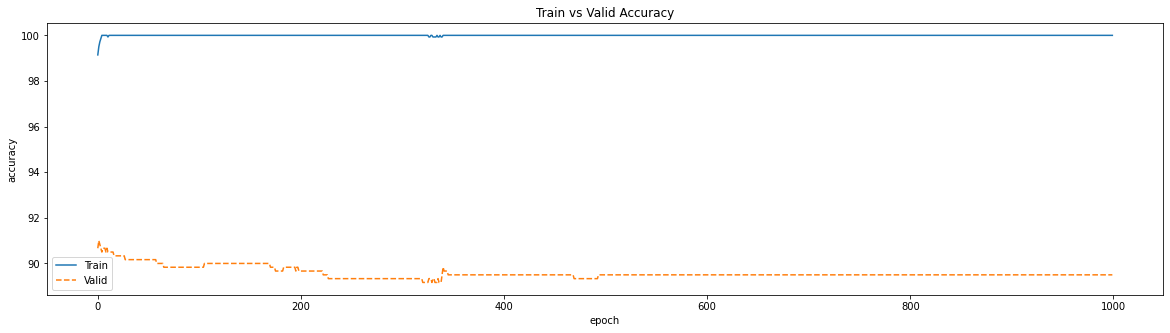

In [51]:
accuracy_plots(train_accu, eval_accu)

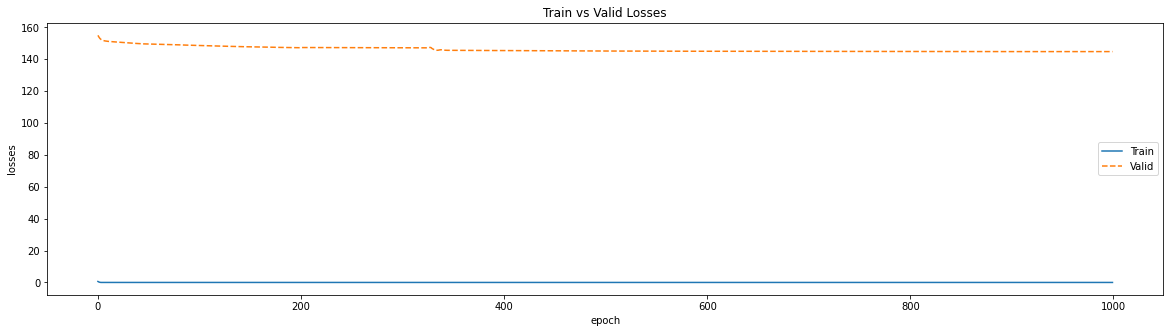

In [52]:
loss_plots(train_losses, eval_losses)

In [53]:
model = model_configs["1"]
model.load_state_dict(torch.load("models/best_model_parameters13.pth"))
model.eval()

model_1(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [54]:
with torch.no_grad():
  predicted_classes = []
  device = torch.device("cpu")
  for data in tqdm(first_five_loader):
    images,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(images)
    _, predicted = torch.max(outputs, 1)
    predicted_classes.append(predicted)

100%|██████████| 5/5 [00:00<00:00, 2701.47it/s]


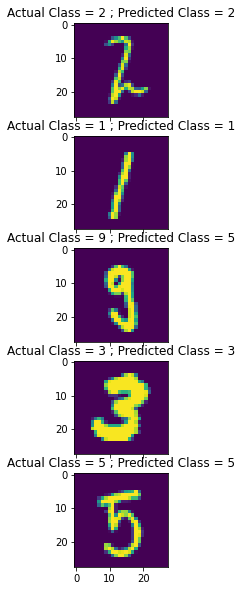

In [55]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for j in range(5):
  axs[j].imshow(first_five_test_images[j][0])
  axs[j].set_title(f"Actual Class = {first_five_test_image_labels[0+j]} ; Predicted Class = {predicted_classes[j].item()}")

for ax in axs.flat:
    ax.label_outer()

# model 2, test config 1 :

In [56]:
s = time.time()
eval_losses, train_losses, eval_accu, train_accu = train("2", "1")
e = time.time()

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |   313600   |
|  l1.bias  |    400     |
| l2.weight |   80000    |
|  l2.bias  |    200     |
| l3.weight |    2000    |
|  l3.bias  |     10     |
+-----------+------------+
Total Trainable Params: 396210

Epoch : 1


100%|██████████| 2/2 [00:00<00:00, 88.53it/s]



Epoch : 2


100%|██████████| 2/2 [00:00<00:00, 95.13it/s]



Epoch : 3


100%|██████████| 2/2 [00:00<00:00, 102.24it/s]



Epoch : 4


100%|██████████| 2/2 [00:00<00:00, 109.77it/s]



Epoch : 5


100%|██████████| 2/2 [00:00<00:00, 73.57it/s]



Epoch : 6


100%|██████████| 2/2 [00:00<00:00, 96.55it/s]



Epoch : 7


100%|██████████| 2/2 [00:00<00:00, 93.41it/s]



Epoch : 8


100%|██████████| 2/2 [00:00<00:00, 88.94it/s]



Epoch : 9


100%|██████████| 2/2 [00:00<00:00, 107.09it/s]



Epoch : 10


100%|██████████| 2/2 [00:00<00:00, 101.29it/s]



Epoch : 11


100%|██████████| 2/2 [00:00<00:00, 99.86it/s]



Epoch : 12


100%|██████████| 2/2 [00:00<00:00, 74.48it/s]



Epoch : 13


100%|██████████| 2/2 [00:00<00:00, 74.17it/s]



Epoch : 14


100%|██████████| 2/2 [00:00<00:00, 90.54it/s]



Epoch : 15


100%|██████████| 2/2 [00:00<00:00, 86.41it/s]



Epoch : 16


100%|██████████| 2/2 [00:00<00:00, 95.52it/s]



Epoch : 17


100%|██████████| 2/2 [00:00<00:00, 100.94it/s]



Epoch : 18


100%|██████████| 2/2 [00:00<00:00, 96.80it/s]



Epoch : 19


100%|██████████| 2/2 [00:00<00:00, 100.59it/s]



Epoch : 20


100%|██████████| 2/2 [00:00<00:00, 103.31it/s]



Epoch : 21


100%|██████████| 2/2 [00:00<00:00, 101.89it/s]



Epoch : 22


100%|██████████| 2/2 [00:00<00:00, 100.35it/s]



Epoch : 23


100%|██████████| 2/2 [00:00<00:00, 104.84it/s]



Epoch : 24


100%|██████████| 2/2 [00:00<00:00, 13.22it/s]



Epoch : 25


100%|██████████| 2/2 [00:00<00:00, 102.06it/s]



Epoch : 26


100%|██████████| 2/2 [00:00<00:00, 102.49it/s]



Epoch : 27


100%|██████████| 2/2 [00:00<00:00, 86.39it/s]



Epoch : 28


100%|██████████| 2/2 [00:00<00:00, 88.28it/s]



Epoch : 29


100%|██████████| 2/2 [00:00<00:00, 98.93it/s]



Epoch : 30


100%|██████████| 2/2 [00:00<00:00, 100.50it/s]



Epoch : 31


100%|██████████| 2/2 [00:00<00:00, 93.69it/s]



Epoch : 32


100%|██████████| 2/2 [00:00<00:00, 98.21it/s]



Epoch : 33


100%|██████████| 2/2 [00:00<00:00, 96.49it/s]



Epoch : 34


100%|██████████| 2/2 [00:00<00:00, 96.75it/s]



Epoch : 35


100%|██████████| 2/2 [00:00<00:00, 95.61it/s]



Epoch : 36


100%|██████████| 2/2 [00:00<00:00, 100.32it/s]



Epoch : 37


100%|██████████| 2/2 [00:00<00:00, 68.77it/s]



Epoch : 38


100%|██████████| 2/2 [00:00<00:00, 95.00it/s]



Epoch : 39


100%|██████████| 2/2 [00:00<00:00, 82.08it/s]



Epoch : 40


100%|██████████| 2/2 [00:00<00:00, 104.08it/s]



Epoch : 41


100%|██████████| 2/2 [00:00<00:00, 96.26it/s]



Epoch : 42


100%|██████████| 2/2 [00:00<00:00, 74.46it/s]



Epoch : 43


100%|██████████| 2/2 [00:00<00:00, 89.18it/s]



Epoch : 44


100%|██████████| 2/2 [00:00<00:00, 105.38it/s]



Epoch : 45


100%|██████████| 2/2 [00:00<00:00, 92.11it/s]



Epoch : 46


100%|██████████| 2/2 [00:00<00:00, 102.49it/s]



Epoch : 47


100%|██████████| 2/2 [00:00<00:00, 101.96it/s]



Epoch : 48


100%|██████████| 2/2 [00:00<00:00, 78.12it/s]



Epoch : 49


100%|██████████| 2/2 [00:00<00:00, 87.61it/s]



Epoch : 50


100%|██████████| 2/2 [00:00<00:00, 91.39it/s]



Epoch : 51


100%|██████████| 2/2 [00:00<00:00, 98.04it/s]



Epoch : 52


100%|██████████| 2/2 [00:00<00:00, 102.87it/s]



Epoch : 53


100%|██████████| 2/2 [00:00<00:00, 91.76it/s]



Epoch : 54


100%|██████████| 2/2 [00:00<00:00, 86.62it/s]



Epoch : 55


100%|██████████| 2/2 [00:00<00:00, 68.85it/s]



Epoch : 56


100%|██████████| 2/2 [00:00<00:00, 79.63it/s]



Epoch : 57


100%|██████████| 2/2 [00:00<00:00, 89.26it/s]



Epoch : 58


100%|██████████| 2/2 [00:00<00:00, 100.42it/s]



Epoch : 59


100%|██████████| 2/2 [00:00<00:00, 102.87it/s]



Epoch : 60


100%|██████████| 2/2 [00:00<00:00, 106.03it/s]



Epoch : 61


100%|██████████| 2/2 [00:00<00:00, 68.23it/s]



Epoch : 62


100%|██████████| 2/2 [00:00<00:00, 91.92it/s]



Epoch : 63


100%|██████████| 2/2 [00:00<00:00, 85.48it/s]



Epoch : 64


100%|██████████| 2/2 [00:00<00:00, 87.85it/s]



Epoch : 65


100%|██████████| 2/2 [00:00<00:00, 101.17it/s]



Epoch : 66


100%|██████████| 2/2 [00:00<00:00, 94.81it/s]



Epoch : 67


100%|██████████| 2/2 [00:00<00:00, 95.11it/s]



Epoch : 68


100%|██████████| 2/2 [00:00<00:00, 102.30it/s]



Epoch : 69


100%|██████████| 2/2 [00:00<00:00, 62.97it/s]



Epoch : 70


100%|██████████| 2/2 [00:00<00:00, 96.07it/s]



Epoch : 71


100%|██████████| 2/2 [00:00<00:00, 84.65it/s]



Epoch : 72


100%|██████████| 2/2 [00:00<00:00, 94.27it/s]



Epoch : 73


100%|██████████| 2/2 [00:00<00:00, 66.07it/s]



Epoch : 74


100%|██████████| 2/2 [00:00<00:00, 94.17it/s]



Epoch : 75


100%|██████████| 2/2 [00:00<00:00, 98.55it/s]



Epoch : 76


100%|██████████| 2/2 [00:00<00:00, 71.31it/s]



Epoch : 77


100%|██████████| 2/2 [00:00<00:00, 101.81it/s]



Epoch : 78


100%|██████████| 2/2 [00:00<00:00, 85.82it/s]



Epoch : 79


100%|██████████| 2/2 [00:00<00:00, 79.72it/s]



Epoch : 80


100%|██████████| 2/2 [00:00<00:00, 92.08it/s]



Epoch : 81


100%|██████████| 2/2 [00:00<00:00, 92.52it/s]



Epoch : 82


100%|██████████| 2/2 [00:00<00:00, 91.34it/s]



Epoch : 83


100%|██████████| 2/2 [00:00<00:00, 81.98it/s]



Epoch : 84


100%|██████████| 2/2 [00:00<00:00, 96.64it/s]



Epoch : 85


100%|██████████| 2/2 [00:00<00:00, 94.83it/s]



Epoch : 86


100%|██████████| 2/2 [00:00<00:00, 103.06it/s]



Epoch : 87


100%|██████████| 2/2 [00:00<00:00, 101.89it/s]



Epoch : 88


100%|██████████| 2/2 [00:00<00:00, 102.25it/s]



Epoch : 89


100%|██████████| 2/2 [00:00<00:00, 107.11it/s]



Epoch : 90


100%|██████████| 2/2 [00:00<00:00, 103.72it/s]



Epoch : 91


100%|██████████| 2/2 [00:00<00:00, 69.27it/s]



Epoch : 92


100%|██████████| 2/2 [00:00<00:00, 91.31it/s]



Epoch : 93


100%|██████████| 2/2 [00:00<00:00, 103.32it/s]



Epoch : 94


100%|██████████| 2/2 [00:00<00:00, 100.98it/s]



Epoch : 95


100%|██████████| 2/2 [00:00<00:00, 104.63it/s]



Epoch : 96


100%|██████████| 2/2 [00:00<00:00, 103.22it/s]



Epoch : 97


100%|██████████| 2/2 [00:00<00:00, 110.80it/s]



Epoch : 98


100%|██████████| 2/2 [00:00<00:00, 108.30it/s]



Epoch : 99


100%|██████████| 2/2 [00:00<00:00, 103.66it/s]



Epoch : 100


100%|██████████| 2/2 [00:00<00:00, 103.63it/s]



Epoch : 101


100%|██████████| 2/2 [00:00<00:00, 103.00it/s]



Epoch : 102


100%|██████████| 2/2 [00:00<00:00, 101.92it/s]



Epoch : 103


100%|██████████| 2/2 [00:00<00:00, 104.73it/s]



Epoch : 104


100%|██████████| 2/2 [00:00<00:00, 102.42it/s]



Epoch : 105


100%|██████████| 2/2 [00:00<00:00, 98.37it/s]



Epoch : 106


100%|██████████| 2/2 [00:00<00:00, 99.87it/s]



Epoch : 107


100%|██████████| 2/2 [00:00<00:00, 105.31it/s]



Epoch : 108


100%|██████████| 2/2 [00:00<00:00, 92.07it/s]



Epoch : 109


100%|██████████| 2/2 [00:00<00:00, 97.94it/s]



Epoch : 110


100%|██████████| 2/2 [00:00<00:00, 100.10it/s]



Epoch : 111


100%|██████████| 2/2 [00:00<00:00, 83.96it/s]



Epoch : 112


100%|██████████| 2/2 [00:00<00:00, 62.28it/s]



Epoch : 113


100%|██████████| 2/2 [00:00<00:00, 88.85it/s]



Epoch : 114


100%|██████████| 2/2 [00:00<00:00, 92.88it/s]



Epoch : 115


100%|██████████| 2/2 [00:00<00:00, 88.82it/s]



Epoch : 116


100%|██████████| 2/2 [00:00<00:00, 103.89it/s]



Epoch : 117


100%|██████████| 2/2 [00:00<00:00, 101.27it/s]



Epoch : 118


100%|██████████| 2/2 [00:00<00:00, 103.01it/s]



Epoch : 119


100%|██████████| 2/2 [00:00<00:00, 69.49it/s]



Epoch : 120


100%|██████████| 2/2 [00:00<00:00, 94.98it/s]



Epoch : 121


100%|██████████| 2/2 [00:00<00:00, 79.28it/s]



Epoch : 122


100%|██████████| 2/2 [00:00<00:00, 94.11it/s]



Epoch : 123


100%|██████████| 2/2 [00:00<00:00, 82.34it/s]



Epoch : 124


100%|██████████| 2/2 [00:00<00:00, 84.66it/s]



Epoch : 125


100%|██████████| 2/2 [00:00<00:00, 86.48it/s]



Epoch : 126


100%|██████████| 2/2 [00:00<00:00, 102.93it/s]



Epoch : 127


100%|██████████| 2/2 [00:00<00:00, 101.12it/s]



Epoch : 128


100%|██████████| 2/2 [00:00<00:00, 103.66it/s]



Epoch : 129


100%|██████████| 2/2 [00:00<00:00, 106.18it/s]



Epoch : 130


100%|██████████| 2/2 [00:00<00:00, 101.49it/s]



Epoch : 131


100%|██████████| 2/2 [00:00<00:00, 85.83it/s]



Epoch : 132


100%|██████████| 2/2 [00:00<00:00, 81.56it/s]



Epoch : 133


100%|██████████| 2/2 [00:00<00:00, 104.35it/s]



Epoch : 134


100%|██████████| 2/2 [00:00<00:00, 103.30it/s]



Epoch : 135


100%|██████████| 2/2 [00:00<00:00, 101.83it/s]



Epoch : 136


100%|██████████| 2/2 [00:00<00:00, 103.93it/s]



Epoch : 137


100%|██████████| 2/2 [00:00<00:00, 105.84it/s]



Epoch : 138


100%|██████████| 2/2 [00:00<00:00, 104.29it/s]



Epoch : 139


100%|██████████| 2/2 [00:00<00:00, 97.25it/s]



Epoch : 140


100%|██████████| 2/2 [00:00<00:00, 78.82it/s]



Epoch : 141


100%|██████████| 2/2 [00:00<00:00, 100.48it/s]



Epoch : 142


100%|██████████| 2/2 [00:00<00:00, 79.30it/s]



Epoch : 143


100%|██████████| 2/2 [00:00<00:00, 96.27it/s]



Epoch : 144


100%|██████████| 2/2 [00:00<00:00, 99.86it/s]



Epoch : 145


100%|██████████| 2/2 [00:00<00:00, 103.24it/s]



Epoch : 146


100%|██████████| 2/2 [00:00<00:00, 84.94it/s]



Epoch : 147


100%|██████████| 2/2 [00:00<00:00, 78.00it/s]



Epoch : 148


100%|██████████| 2/2 [00:00<00:00, 99.55it/s]



Epoch : 149


100%|██████████| 2/2 [00:00<00:00, 100.71it/s]



Epoch : 150


100%|██████████| 2/2 [00:00<00:00, 98.77it/s]



Epoch : 151


100%|██████████| 2/2 [00:00<00:00, 68.55it/s]



Epoch : 152


100%|██████████| 2/2 [00:00<00:00, 98.72it/s]



Epoch : 153


100%|██████████| 2/2 [00:00<00:00, 98.39it/s]



Epoch : 154


100%|██████████| 2/2 [00:00<00:00, 95.84it/s]



Epoch : 155


100%|██████████| 2/2 [00:00<00:00, 69.29it/s]



Epoch : 156


100%|██████████| 2/2 [00:00<00:00, 78.83it/s]



Epoch : 157


100%|██████████| 2/2 [00:00<00:00, 96.35it/s]



Epoch : 158


100%|██████████| 2/2 [00:00<00:00, 75.78it/s]



Epoch : 159


100%|██████████| 2/2 [00:00<00:00, 84.64it/s]



Epoch : 160


100%|██████████| 2/2 [00:00<00:00, 98.82it/s]



Epoch : 161


100%|██████████| 2/2 [00:00<00:00, 95.85it/s]



Epoch : 162


100%|██████████| 2/2 [00:00<00:00, 98.85it/s]



Epoch : 163


100%|██████████| 2/2 [00:00<00:00, 102.57it/s]



Epoch : 164


100%|██████████| 2/2 [00:00<00:00, 113.78it/s]



Epoch : 165


100%|██████████| 2/2 [00:00<00:00, 86.55it/s]



Epoch : 166


100%|██████████| 2/2 [00:00<00:00, 96.83it/s]



Epoch : 167


100%|██████████| 2/2 [00:00<00:00, 86.79it/s]



Epoch : 168


100%|██████████| 2/2 [00:00<00:00, 99.77it/s]



Epoch : 169


100%|██████████| 2/2 [00:00<00:00, 100.76it/s]



Epoch : 170


100%|██████████| 2/2 [00:00<00:00, 95.22it/s]



Epoch : 171


100%|██████████| 2/2 [00:00<00:00, 97.29it/s]



Epoch : 172


100%|██████████| 2/2 [00:00<00:00, 96.34it/s]



Epoch : 173


100%|██████████| 2/2 [00:00<00:00, 104.06it/s]



Epoch : 174


100%|██████████| 2/2 [00:00<00:00, 99.66it/s]



Epoch : 175


100%|██████████| 2/2 [00:00<00:00, 98.54it/s]



Epoch : 176


100%|██████████| 2/2 [00:00<00:00, 88.78it/s]



Epoch : 177


100%|██████████| 2/2 [00:00<00:00, 75.01it/s]



Epoch : 178


100%|██████████| 2/2 [00:00<00:00, 85.69it/s]



Epoch : 179


100%|██████████| 2/2 [00:00<00:00, 97.36it/s]



Epoch : 180


100%|██████████| 2/2 [00:00<00:00, 93.57it/s]



Epoch : 181


100%|██████████| 2/2 [00:00<00:00, 89.95it/s]



Epoch : 182


100%|██████████| 2/2 [00:00<00:00, 103.62it/s]



Epoch : 183


100%|██████████| 2/2 [00:00<00:00, 102.99it/s]



Epoch : 184


100%|██████████| 2/2 [00:00<00:00, 103.09it/s]



Epoch : 185


100%|██████████| 2/2 [00:00<00:00, 103.93it/s]



Epoch : 186


100%|██████████| 2/2 [00:00<00:00, 101.82it/s]



Epoch : 187


100%|██████████| 2/2 [00:00<00:00, 87.91it/s]



Epoch : 188


100%|██████████| 2/2 [00:00<00:00, 94.20it/s]



Epoch : 189


100%|██████████| 2/2 [00:00<00:00, 95.02it/s]



Epoch : 190


100%|██████████| 2/2 [00:00<00:00, 97.13it/s]



Epoch : 191


100%|██████████| 2/2 [00:00<00:00, 90.83it/s]



Epoch : 192


100%|██████████| 2/2 [00:00<00:00, 93.00it/s]



Epoch : 193


100%|██████████| 2/2 [00:00<00:00, 97.62it/s]



Epoch : 194


100%|██████████| 2/2 [00:00<00:00, 97.07it/s]



Epoch : 195


100%|██████████| 2/2 [00:00<00:00, 60.17it/s]



Epoch : 196


100%|██████████| 2/2 [00:00<00:00, 81.08it/s]



Epoch : 197


100%|██████████| 2/2 [00:00<00:00, 89.22it/s]



Epoch : 198


100%|██████████| 2/2 [00:00<00:00, 91.98it/s]



Epoch : 199


100%|██████████| 2/2 [00:00<00:00, 78.66it/s]



Epoch : 200


100%|██████████| 2/2 [00:00<00:00, 97.08it/s]



Epoch : 201


100%|██████████| 2/2 [00:00<00:00, 98.35it/s]



Epoch : 202


100%|██████████| 2/2 [00:00<00:00, 99.23it/s]



Epoch : 203


100%|██████████| 2/2 [00:00<00:00, 104.43it/s]



Epoch : 204


100%|██████████| 2/2 [00:00<00:00, 101.11it/s]



Epoch : 205


100%|██████████| 2/2 [00:00<00:00, 97.51it/s]



Epoch : 206


100%|██████████| 2/2 [00:00<00:00, 97.32it/s]



Epoch : 207


100%|██████████| 2/2 [00:00<00:00, 95.44it/s]



Epoch : 208


100%|██████████| 2/2 [00:00<00:00, 73.95it/s]



Epoch : 209


100%|██████████| 2/2 [00:00<00:00, 72.19it/s]



Epoch : 210


100%|██████████| 2/2 [00:00<00:00, 102.56it/s]



Epoch : 211


100%|██████████| 2/2 [00:00<00:00, 103.39it/s]



Epoch : 212


100%|██████████| 2/2 [00:00<00:00, 78.27it/s]



Epoch : 213


100%|██████████| 2/2 [00:00<00:00, 56.70it/s]



Epoch : 214


100%|██████████| 2/2 [00:00<00:00, 82.05it/s]



Epoch : 215


100%|██████████| 2/2 [00:00<00:00, 82.17it/s]



Epoch : 216


100%|██████████| 2/2 [00:00<00:00, 98.02it/s]



Epoch : 217


100%|██████████| 2/2 [00:00<00:00, 102.89it/s]



Epoch : 218


100%|██████████| 2/2 [00:00<00:00, 98.35it/s]



Epoch : 219


100%|██████████| 2/2 [00:00<00:00, 89.45it/s]



Epoch : 220


100%|██████████| 2/2 [00:00<00:00, 88.09it/s]



Epoch : 221


100%|██████████| 2/2 [00:00<00:00, 91.36it/s]



Epoch : 222


100%|██████████| 2/2 [00:00<00:00, 67.52it/s]



Epoch : 223


100%|██████████| 2/2 [00:00<00:00, 99.54it/s]



Epoch : 224


100%|██████████| 2/2 [00:00<00:00, 96.98it/s]



Epoch : 225


100%|██████████| 2/2 [00:00<00:00, 99.12it/s]



Epoch : 226


100%|██████████| 2/2 [00:00<00:00, 106.37it/s]



Epoch : 227


100%|██████████| 2/2 [00:00<00:00, 98.88it/s]



Epoch : 228


100%|██████████| 2/2 [00:00<00:00, 101.04it/s]



Epoch : 229


100%|██████████| 2/2 [00:00<00:00, 100.15it/s]



Epoch : 230


100%|██████████| 2/2 [00:00<00:00, 110.33it/s]



Epoch : 231


100%|██████████| 2/2 [00:00<00:00, 92.90it/s]



Epoch : 232


100%|██████████| 2/2 [00:00<00:00, 102.32it/s]



Epoch : 233


100%|██████████| 2/2 [00:00<00:00, 104.41it/s]



Epoch : 234


100%|██████████| 2/2 [00:00<00:00, 88.44it/s]



Epoch : 235


100%|██████████| 2/2 [00:00<00:00, 65.29it/s]



Epoch : 236


100%|██████████| 2/2 [00:00<00:00, 92.33it/s]



Epoch : 237


100%|██████████| 2/2 [00:00<00:00, 97.46it/s]



Epoch : 238


100%|██████████| 2/2 [00:00<00:00, 102.38it/s]



Epoch : 239


100%|██████████| 2/2 [00:00<00:00, 109.45it/s]



Epoch : 240


100%|██████████| 2/2 [00:00<00:00, 89.51it/s]



Epoch : 241


100%|██████████| 2/2 [00:00<00:00, 96.73it/s]



Epoch : 242


100%|██████████| 2/2 [00:00<00:00, 78.16it/s]



Epoch : 243


100%|██████████| 2/2 [00:00<00:00, 100.42it/s]



Epoch : 244


100%|██████████| 2/2 [00:00<00:00, 97.78it/s]



Epoch : 245


100%|██████████| 2/2 [00:00<00:00, 94.44it/s]



Epoch : 246


100%|██████████| 2/2 [00:00<00:00, 67.52it/s]



Epoch : 247


100%|██████████| 2/2 [00:00<00:00, 97.46it/s]



Epoch : 248


100%|██████████| 2/2 [00:00<00:00, 67.88it/s]



Epoch : 249


100%|██████████| 2/2 [00:00<00:00, 95.43it/s]



Epoch : 250


100%|██████████| 2/2 [00:00<00:00, 100.43it/s]



Epoch : 251


100%|██████████| 2/2 [00:00<00:00, 86.46it/s]



Epoch : 252


100%|██████████| 2/2 [00:00<00:00, 97.51it/s]



Epoch : 253


100%|██████████| 2/2 [00:00<00:00, 105.19it/s]



Epoch : 254


100%|██████████| 2/2 [00:00<00:00, 100.37it/s]



Epoch : 255


100%|██████████| 2/2 [00:00<00:00, 101.12it/s]



Epoch : 256


100%|██████████| 2/2 [00:00<00:00, 72.93it/s]



Epoch : 257


100%|██████████| 2/2 [00:00<00:00, 84.22it/s]



Epoch : 258


100%|██████████| 2/2 [00:00<00:00, 95.32it/s]



Epoch : 259


100%|██████████| 2/2 [00:00<00:00, 101.99it/s]



Epoch : 260


100%|██████████| 2/2 [00:00<00:00, 105.35it/s]



Epoch : 261


100%|██████████| 2/2 [00:00<00:00, 64.38it/s]



Epoch : 262


100%|██████████| 2/2 [00:00<00:00, 73.27it/s]



Epoch : 263


100%|██████████| 2/2 [00:00<00:00, 73.46it/s]



Epoch : 264


100%|██████████| 2/2 [00:00<00:00, 77.06it/s]



Epoch : 265


100%|██████████| 2/2 [00:00<00:00, 109.73it/s]



Epoch : 266


100%|██████████| 2/2 [00:00<00:00, 102.43it/s]



Epoch : 267


100%|██████████| 2/2 [00:00<00:00, 102.45it/s]



Epoch : 268


100%|██████████| 2/2 [00:00<00:00, 101.34it/s]



Epoch : 269


100%|██████████| 2/2 [00:00<00:00, 85.80it/s]



Epoch : 270


100%|██████████| 2/2 [00:00<00:00, 99.65it/s]



Epoch : 271


100%|██████████| 2/2 [00:00<00:00, 78.30it/s]



Epoch : 272


100%|██████████| 2/2 [00:00<00:00, 70.87it/s]



Epoch : 273


100%|██████████| 2/2 [00:00<00:00, 88.28it/s]



Epoch : 274


100%|██████████| 2/2 [00:00<00:00, 91.57it/s]



Epoch : 275


100%|██████████| 2/2 [00:00<00:00, 93.28it/s]



Epoch : 276


100%|██████████| 2/2 [00:00<00:00, 100.20it/s]



Epoch : 277


100%|██████████| 2/2 [00:00<00:00, 100.54it/s]



Epoch : 278


100%|██████████| 2/2 [00:00<00:00, 102.30it/s]



Epoch : 279


100%|██████████| 2/2 [00:00<00:00, 100.19it/s]



Epoch : 280


100%|██████████| 2/2 [00:00<00:00, 98.92it/s]



Epoch : 281


100%|██████████| 2/2 [00:00<00:00, 105.31it/s]



Epoch : 282


100%|██████████| 2/2 [00:00<00:00, 105.25it/s]



Epoch : 283


100%|██████████| 2/2 [00:00<00:00, 106.44it/s]



Epoch : 284


100%|██████████| 2/2 [00:00<00:00, 104.14it/s]



Epoch : 285


100%|██████████| 2/2 [00:00<00:00, 102.97it/s]



Epoch : 286


100%|██████████| 2/2 [00:00<00:00, 93.73it/s]



Epoch : 287


100%|██████████| 2/2 [00:00<00:00, 99.85it/s]



Epoch : 288


100%|██████████| 2/2 [00:00<00:00, 100.17it/s]



Epoch : 289


100%|██████████| 2/2 [00:00<00:00, 101.91it/s]



Epoch : 290


100%|██████████| 2/2 [00:00<00:00, 78.04it/s]



Epoch : 291


100%|██████████| 2/2 [00:00<00:00, 96.84it/s]



Epoch : 292


100%|██████████| 2/2 [00:00<00:00, 69.71it/s]



Epoch : 293


100%|██████████| 2/2 [00:00<00:00, 89.94it/s]



Epoch : 294


100%|██████████| 2/2 [00:00<00:00, 78.74it/s]



Epoch : 295


100%|██████████| 2/2 [00:00<00:00, 95.22it/s]



Epoch : 296


100%|██████████| 2/2 [00:00<00:00, 99.84it/s]



Epoch : 297


100%|██████████| 2/2 [00:00<00:00, 78.72it/s]



Epoch : 298


100%|██████████| 2/2 [00:00<00:00, 91.82it/s]



Epoch : 299


100%|██████████| 2/2 [00:00<00:00, 62.71it/s]



Epoch : 300


100%|██████████| 2/2 [00:00<00:00, 82.03it/s]



Epoch : 301


100%|██████████| 2/2 [00:00<00:00, 95.73it/s]



Epoch : 302


100%|██████████| 2/2 [00:00<00:00, 105.56it/s]



Epoch : 303


100%|██████████| 2/2 [00:00<00:00, 84.50it/s]



Epoch : 304


100%|██████████| 2/2 [00:00<00:00, 94.92it/s]



Epoch : 305


100%|██████████| 2/2 [00:00<00:00, 76.64it/s]



Epoch : 306


100%|██████████| 2/2 [00:00<00:00, 96.93it/s]



Epoch : 307


100%|██████████| 2/2 [00:00<00:00, 85.56it/s]



Epoch : 308


100%|██████████| 2/2 [00:00<00:00, 95.84it/s]



Epoch : 309


100%|██████████| 2/2 [00:00<00:00, 89.40it/s]



Epoch : 310


100%|██████████| 2/2 [00:00<00:00, 90.17it/s]



Epoch : 311


100%|██████████| 2/2 [00:00<00:00, 75.38it/s]



Epoch : 312


100%|██████████| 2/2 [00:00<00:00, 100.26it/s]



Epoch : 313


100%|██████████| 2/2 [00:00<00:00, 106.32it/s]



Epoch : 314


100%|██████████| 2/2 [00:00<00:00, 85.73it/s]



Epoch : 315


100%|██████████| 2/2 [00:00<00:00, 103.07it/s]



Epoch : 316


100%|██████████| 2/2 [00:00<00:00, 103.11it/s]



Epoch : 317


100%|██████████| 2/2 [00:00<00:00, 99.71it/s]



Epoch : 318


100%|██████████| 2/2 [00:00<00:00, 102.89it/s]



Epoch : 319


100%|██████████| 2/2 [00:00<00:00, 100.43it/s]



Epoch : 320


100%|██████████| 2/2 [00:00<00:00, 101.16it/s]



Epoch : 321


100%|██████████| 2/2 [00:00<00:00, 100.10it/s]



Epoch : 322


100%|██████████| 2/2 [00:00<00:00, 79.22it/s]



Epoch : 323


100%|██████████| 2/2 [00:00<00:00, 99.98it/s]



Epoch : 324


100%|██████████| 2/2 [00:00<00:00, 105.45it/s]



Epoch : 325


100%|██████████| 2/2 [00:00<00:00, 98.47it/s]



Epoch : 326


100%|██████████| 2/2 [00:00<00:00, 100.87it/s]



Epoch : 327


100%|██████████| 2/2 [00:00<00:00, 80.87it/s]



Epoch : 328


100%|██████████| 2/2 [00:00<00:00, 98.49it/s]



Epoch : 329


100%|██████████| 2/2 [00:00<00:00, 106.69it/s]



Epoch : 330


100%|██████████| 2/2 [00:00<00:00, 97.48it/s]



Epoch : 331


100%|██████████| 2/2 [00:00<00:00, 100.09it/s]



Epoch : 332


100%|██████████| 2/2 [00:00<00:00, 104.36it/s]



Epoch : 333


100%|██████████| 2/2 [00:00<00:00, 93.85it/s]



Epoch : 334


100%|██████████| 2/2 [00:00<00:00, 70.69it/s]



Epoch : 335


100%|██████████| 2/2 [00:00<00:00, 90.36it/s]



Epoch : 336


100%|██████████| 2/2 [00:00<00:00, 99.20it/s]



Epoch : 337


100%|██████████| 2/2 [00:00<00:00, 84.88it/s]



Epoch : 338


100%|██████████| 2/2 [00:00<00:00, 88.74it/s]



Epoch : 339


100%|██████████| 2/2 [00:00<00:00, 106.60it/s]



Epoch : 340


100%|██████████| 2/2 [00:00<00:00, 88.36it/s]



Epoch : 341


100%|██████████| 2/2 [00:00<00:00, 73.43it/s]



Epoch : 342


100%|██████████| 2/2 [00:00<00:00, 93.63it/s]



Epoch : 343


100%|██████████| 2/2 [00:00<00:00, 102.70it/s]



Epoch : 344


100%|██████████| 2/2 [00:00<00:00, 100.96it/s]



Epoch : 345


100%|██████████| 2/2 [00:00<00:00, 93.94it/s]



Epoch : 346


100%|██████████| 2/2 [00:00<00:00, 103.20it/s]



Epoch : 347


100%|██████████| 2/2 [00:00<00:00, 76.01it/s]



Epoch : 348


100%|██████████| 2/2 [00:00<00:00, 102.11it/s]



Epoch : 349


100%|██████████| 2/2 [00:00<00:00, 102.93it/s]



Epoch : 350


100%|██████████| 2/2 [00:00<00:00, 91.34it/s]



Epoch : 351


100%|██████████| 2/2 [00:00<00:00, 104.31it/s]



Epoch : 352


100%|██████████| 2/2 [00:00<00:00, 93.12it/s]



Epoch : 353


100%|██████████| 2/2 [00:00<00:00, 83.36it/s]



Epoch : 354


100%|██████████| 2/2 [00:00<00:00, 98.35it/s]



Epoch : 355


100%|██████████| 2/2 [00:00<00:00, 67.13it/s]



Epoch : 356


100%|██████████| 2/2 [00:00<00:00, 66.88it/s]



Epoch : 357


100%|██████████| 2/2 [00:00<00:00, 101.01it/s]



Epoch : 358


100%|██████████| 2/2 [00:00<00:00, 112.14it/s]



Epoch : 359


100%|██████████| 2/2 [00:00<00:00, 103.41it/s]



Epoch : 360


100%|██████████| 2/2 [00:00<00:00, 72.91it/s]



Epoch : 361


100%|██████████| 2/2 [00:00<00:00, 99.45it/s]



Epoch : 362


100%|██████████| 2/2 [00:00<00:00, 101.14it/s]



Epoch : 363


100%|██████████| 2/2 [00:00<00:00, 100.41it/s]



Epoch : 364


100%|██████████| 2/2 [00:00<00:00, 105.89it/s]



Epoch : 365


100%|██████████| 2/2 [00:00<00:00, 103.02it/s]



Epoch : 366


100%|██████████| 2/2 [00:00<00:00, 99.08it/s]



Epoch : 367


100%|██████████| 2/2 [00:00<00:00, 99.34it/s]



Epoch : 368


100%|██████████| 2/2 [00:00<00:00, 101.05it/s]



Epoch : 369


100%|██████████| 2/2 [00:00<00:00, 103.40it/s]



Epoch : 370


100%|██████████| 2/2 [00:00<00:00, 85.09it/s]



Epoch : 371


100%|██████████| 2/2 [00:00<00:00, 90.24it/s]



Epoch : 372


100%|██████████| 2/2 [00:00<00:00, 97.20it/s]



Epoch : 373


100%|██████████| 2/2 [00:00<00:00, 100.45it/s]



Epoch : 374


100%|██████████| 2/2 [00:00<00:00, 88.65it/s]



Epoch : 375


100%|██████████| 2/2 [00:00<00:00, 102.48it/s]



Epoch : 376


100%|██████████| 2/2 [00:00<00:00, 79.22it/s]



Epoch : 377


100%|██████████| 2/2 [00:00<00:00, 91.20it/s]



Epoch : 378


100%|██████████| 2/2 [00:00<00:00, 107.18it/s]



Epoch : 379


100%|██████████| 2/2 [00:00<00:00, 106.67it/s]



Epoch : 380


100%|██████████| 2/2 [00:00<00:00, 101.23it/s]



Epoch : 381


100%|██████████| 2/2 [00:00<00:00, 103.66it/s]



Epoch : 382


100%|██████████| 2/2 [00:00<00:00, 104.15it/s]



Epoch : 383


100%|██████████| 2/2 [00:00<00:00, 102.80it/s]



Epoch : 384


100%|██████████| 2/2 [00:00<00:00, 99.37it/s]



Epoch : 385


100%|██████████| 2/2 [00:00<00:00, 101.85it/s]



Epoch : 386


100%|██████████| 2/2 [00:00<00:00, 103.37it/s]



Epoch : 387


100%|██████████| 2/2 [00:00<00:00, 104.87it/s]



Epoch : 388


100%|██████████| 2/2 [00:00<00:00, 83.16it/s]



Epoch : 389


100%|██████████| 2/2 [00:00<00:00, 107.08it/s]



Epoch : 390


100%|██████████| 2/2 [00:00<00:00, 100.46it/s]



Epoch : 391


100%|██████████| 2/2 [00:00<00:00, 103.63it/s]



Epoch : 392


100%|██████████| 2/2 [00:00<00:00, 104.86it/s]



Epoch : 393


100%|██████████| 2/2 [00:00<00:00, 104.20it/s]



Epoch : 394


100%|██████████| 2/2 [00:00<00:00, 81.40it/s]



Epoch : 395


100%|██████████| 2/2 [00:00<00:00, 90.29it/s]



Epoch : 396


100%|██████████| 2/2 [00:00<00:00, 102.61it/s]



Epoch : 397


100%|██████████| 2/2 [00:00<00:00, 103.19it/s]



Epoch : 398


100%|██████████| 2/2 [00:00<00:00, 63.07it/s]



Epoch : 399


100%|██████████| 2/2 [00:00<00:00, 89.41it/s]



Epoch : 400


100%|██████████| 2/2 [00:00<00:00, 85.13it/s]



Epoch : 401


100%|██████████| 2/2 [00:00<00:00, 103.42it/s]



Epoch : 402


100%|██████████| 2/2 [00:00<00:00, 87.73it/s]



Epoch : 403


100%|██████████| 2/2 [00:00<00:00, 108.59it/s]



Epoch : 404


100%|██████████| 2/2 [00:00<00:00, 103.19it/s]



Epoch : 405


100%|██████████| 2/2 [00:00<00:00, 102.70it/s]



Epoch : 406


100%|██████████| 2/2 [00:00<00:00, 104.47it/s]



Epoch : 407


100%|██████████| 2/2 [00:00<00:00, 102.83it/s]



Epoch : 408


100%|██████████| 2/2 [00:00<00:00, 105.45it/s]



Epoch : 409


100%|██████████| 2/2 [00:00<00:00, 100.66it/s]



Epoch : 410


100%|██████████| 2/2 [00:00<00:00, 103.20it/s]



Epoch : 411


100%|██████████| 2/2 [00:00<00:00, 102.01it/s]



Epoch : 412


100%|██████████| 2/2 [00:00<00:00, 97.13it/s]



Epoch : 413


100%|██████████| 2/2 [00:00<00:00, 111.16it/s]



Epoch : 414


100%|██████████| 2/2 [00:00<00:00, 98.37it/s]



Epoch : 415


100%|██████████| 2/2 [00:00<00:00, 99.19it/s]



Epoch : 416


100%|██████████| 2/2 [00:00<00:00, 74.34it/s]



Epoch : 417


100%|██████████| 2/2 [00:00<00:00, 91.57it/s]



Epoch : 418


100%|██████████| 2/2 [00:00<00:00, 107.16it/s]



Epoch : 419


100%|██████████| 2/2 [00:00<00:00, 96.92it/s]



Epoch : 420


100%|██████████| 2/2 [00:00<00:00, 99.54it/s]



Epoch : 421


100%|██████████| 2/2 [00:00<00:00, 105.64it/s]



Epoch : 422


100%|██████████| 2/2 [00:00<00:00, 101.85it/s]



Epoch : 423


100%|██████████| 2/2 [00:00<00:00, 63.95it/s]



Epoch : 424


100%|██████████| 2/2 [00:00<00:00, 96.14it/s]



Epoch : 425


100%|██████████| 2/2 [00:00<00:00, 81.47it/s]



Epoch : 426


100%|██████████| 2/2 [00:00<00:00, 101.53it/s]



Epoch : 427


100%|██████████| 2/2 [00:00<00:00, 101.24it/s]



Epoch : 428


100%|██████████| 2/2 [00:00<00:00, 95.85it/s]



Epoch : 429


100%|██████████| 2/2 [00:00<00:00, 68.62it/s]



Epoch : 430


100%|██████████| 2/2 [00:00<00:00, 90.16it/s]



Epoch : 431


100%|██████████| 2/2 [00:00<00:00, 60.03it/s]



Epoch : 432


100%|██████████| 2/2 [00:00<00:00, 89.76it/s]



Epoch : 433


100%|██████████| 2/2 [00:00<00:00, 100.01it/s]



Epoch : 434


100%|██████████| 2/2 [00:00<00:00, 106.91it/s]



Epoch : 435


100%|██████████| 2/2 [00:00<00:00, 89.95it/s]



Epoch : 436


100%|██████████| 2/2 [00:00<00:00, 104.77it/s]



Epoch : 437


100%|██████████| 2/2 [00:00<00:00, 99.15it/s]



Epoch : 438


100%|██████████| 2/2 [00:00<00:00, 100.35it/s]



Epoch : 439


100%|██████████| 2/2 [00:00<00:00, 96.35it/s]



Epoch : 440


100%|██████████| 2/2 [00:00<00:00, 100.15it/s]



Epoch : 441


100%|██████████| 2/2 [00:00<00:00, 106.92it/s]



Epoch : 442


100%|██████████| 2/2 [00:00<00:00, 88.07it/s]



Epoch : 443


100%|██████████| 2/2 [00:00<00:00, 100.74it/s]



Epoch : 444


100%|██████████| 2/2 [00:00<00:00, 98.57it/s]



Epoch : 445


100%|██████████| 2/2 [00:00<00:00, 106.52it/s]



Epoch : 446


100%|██████████| 2/2 [00:00<00:00, 99.49it/s]



Epoch : 447


100%|██████████| 2/2 [00:00<00:00, 88.72it/s]



Epoch : 448


100%|██████████| 2/2 [00:00<00:00, 100.51it/s]



Epoch : 449


100%|██████████| 2/2 [00:00<00:00, 104.90it/s]



Epoch : 450


100%|██████████| 2/2 [00:00<00:00, 105.53it/s]



Epoch : 451


100%|██████████| 2/2 [00:00<00:00, 101.86it/s]



Epoch : 452


100%|██████████| 2/2 [00:00<00:00, 85.85it/s]



Epoch : 453


100%|██████████| 2/2 [00:00<00:00, 101.60it/s]



Epoch : 454


100%|██████████| 2/2 [00:00<00:00, 105.15it/s]



Epoch : 455


100%|██████████| 2/2 [00:00<00:00, 94.72it/s]



Epoch : 456


100%|██████████| 2/2 [00:00<00:00, 101.30it/s]



Epoch : 457


100%|██████████| 2/2 [00:00<00:00, 100.00it/s]



Epoch : 458


100%|██████████| 2/2 [00:00<00:00, 81.74it/s]



Epoch : 459


100%|██████████| 2/2 [00:00<00:00, 104.04it/s]



Epoch : 460


100%|██████████| 2/2 [00:00<00:00, 103.32it/s]



Epoch : 461


100%|██████████| 2/2 [00:00<00:00, 102.72it/s]



Epoch : 462


100%|██████████| 2/2 [00:00<00:00, 99.48it/s]



Epoch : 463


100%|██████████| 2/2 [00:00<00:00, 105.50it/s]



Epoch : 464


100%|██████████| 2/2 [00:00<00:00, 93.47it/s]



Epoch : 465


100%|██████████| 2/2 [00:00<00:00, 103.62it/s]



Epoch : 466


100%|██████████| 2/2 [00:00<00:00, 79.37it/s]



Epoch : 467


100%|██████████| 2/2 [00:00<00:00, 109.90it/s]



Epoch : 468


100%|██████████| 2/2 [00:00<00:00, 106.78it/s]



Epoch : 469


100%|██████████| 2/2 [00:00<00:00, 90.28it/s]



Epoch : 470


100%|██████████| 2/2 [00:00<00:00, 77.69it/s]



Epoch : 471


100%|██████████| 2/2 [00:00<00:00, 113.95it/s]



Epoch : 472


100%|██████████| 2/2 [00:00<00:00, 106.24it/s]



Epoch : 473


100%|██████████| 2/2 [00:00<00:00, 98.32it/s]



Epoch : 474


100%|██████████| 2/2 [00:00<00:00, 83.87it/s]



Epoch : 475


100%|██████████| 2/2 [00:00<00:00, 90.50it/s]



Epoch : 476


100%|██████████| 2/2 [00:00<00:00, 90.37it/s]



Epoch : 477


100%|██████████| 2/2 [00:00<00:00, 96.43it/s]



Epoch : 478


100%|██████████| 2/2 [00:00<00:00, 99.14it/s]



Epoch : 479


100%|██████████| 2/2 [00:00<00:00, 99.50it/s]



Epoch : 480


100%|██████████| 2/2 [00:00<00:00, 58.45it/s]



Epoch : 481


100%|██████████| 2/2 [00:00<00:00, 99.98it/s]



Epoch : 482


100%|██████████| 2/2 [00:00<00:00, 101.70it/s]



Epoch : 483


100%|██████████| 2/2 [00:00<00:00, 64.72it/s]



Epoch : 484


100%|██████████| 2/2 [00:00<00:00, 109.22it/s]



Epoch : 485


100%|██████████| 2/2 [00:00<00:00, 104.20it/s]



Epoch : 486


100%|██████████| 2/2 [00:00<00:00, 103.84it/s]



Epoch : 487


100%|██████████| 2/2 [00:00<00:00, 100.60it/s]



Epoch : 488


100%|██████████| 2/2 [00:00<00:00, 106.42it/s]



Epoch : 489


100%|██████████| 2/2 [00:00<00:00, 106.05it/s]



Epoch : 490


100%|██████████| 2/2 [00:00<00:00, 93.40it/s]



Epoch : 491


100%|██████████| 2/2 [00:00<00:00, 100.21it/s]



Epoch : 492


100%|██████████| 2/2 [00:00<00:00, 101.70it/s]



Epoch : 493


100%|██████████| 2/2 [00:00<00:00, 99.11it/s]



Epoch : 494


100%|██████████| 2/2 [00:00<00:00, 92.45it/s]



Epoch : 495


100%|██████████| 2/2 [00:00<00:00, 101.29it/s]



Epoch : 496


100%|██████████| 2/2 [00:00<00:00, 100.79it/s]



Epoch : 497


100%|██████████| 2/2 [00:00<00:00, 104.32it/s]



Epoch : 498


100%|██████████| 2/2 [00:00<00:00, 100.55it/s]



Epoch : 499


100%|██████████| 2/2 [00:00<00:00, 90.22it/s]



Epoch : 500


100%|██████████| 2/2 [00:00<00:00, 89.81it/s]



Epoch : 501


100%|██████████| 2/2 [00:00<00:00, 91.61it/s]



Epoch : 502


100%|██████████| 2/2 [00:00<00:00, 91.31it/s]



Epoch : 503


100%|██████████| 2/2 [00:00<00:00, 92.04it/s]



Epoch : 504


100%|██████████| 2/2 [00:00<00:00, 87.80it/s]



Epoch : 505


100%|██████████| 2/2 [00:00<00:00, 68.28it/s]



Epoch : 506


100%|██████████| 2/2 [00:00<00:00, 86.39it/s]



Epoch : 507


100%|██████████| 2/2 [00:00<00:00, 77.87it/s]



Epoch : 508


100%|██████████| 2/2 [00:00<00:00, 82.11it/s]



Epoch : 509


100%|██████████| 2/2 [00:00<00:00, 98.37it/s]



Epoch : 510


100%|██████████| 2/2 [00:00<00:00, 73.67it/s]



Epoch : 511


100%|██████████| 2/2 [00:00<00:00, 95.99it/s]



Epoch : 512


100%|██████████| 2/2 [00:00<00:00, 96.11it/s]



Epoch : 513


100%|██████████| 2/2 [00:00<00:00, 100.92it/s]



Epoch : 514


100%|██████████| 2/2 [00:00<00:00, 101.98it/s]



Epoch : 515


100%|██████████| 2/2 [00:00<00:00, 96.77it/s]



Epoch : 516


100%|██████████| 2/2 [00:00<00:00, 81.36it/s]



Epoch : 517


100%|██████████| 2/2 [00:00<00:00, 102.97it/s]



Epoch : 518


100%|██████████| 2/2 [00:00<00:00, 95.85it/s]



Epoch : 519


100%|██████████| 2/2 [00:00<00:00, 96.06it/s]



Epoch : 520


100%|██████████| 2/2 [00:00<00:00, 104.82it/s]



Epoch : 521


100%|██████████| 2/2 [00:00<00:00, 90.96it/s]



Epoch : 522


100%|██████████| 2/2 [00:00<00:00, 89.59it/s]



Epoch : 523


100%|██████████| 2/2 [00:00<00:00, 100.28it/s]



Epoch : 524


100%|██████████| 2/2 [00:00<00:00, 102.12it/s]



Epoch : 525


100%|██████████| 2/2 [00:00<00:00, 60.34it/s]



Epoch : 526


100%|██████████| 2/2 [00:00<00:00, 71.85it/s]



Epoch : 527


100%|██████████| 2/2 [00:00<00:00, 91.91it/s]



Epoch : 528


100%|██████████| 2/2 [00:00<00:00, 94.92it/s]



Epoch : 529


100%|██████████| 2/2 [00:00<00:00, 95.44it/s]



Epoch : 530


100%|██████████| 2/2 [00:00<00:00, 97.26it/s]



Epoch : 531


100%|██████████| 2/2 [00:00<00:00, 78.18it/s]



Epoch : 532


100%|██████████| 2/2 [00:00<00:00, 65.27it/s]



Epoch : 533


100%|██████████| 2/2 [00:00<00:00, 94.44it/s]



Epoch : 534


100%|██████████| 2/2 [00:00<00:00, 87.07it/s]



Epoch : 535


100%|██████████| 2/2 [00:00<00:00, 107.45it/s]



Epoch : 536


100%|██████████| 2/2 [00:00<00:00, 104.25it/s]



Epoch : 537


100%|██████████| 2/2 [00:00<00:00, 76.78it/s]



Epoch : 538


100%|██████████| 2/2 [00:00<00:00, 101.17it/s]



Epoch : 539


100%|██████████| 2/2 [00:00<00:00, 100.89it/s]



Epoch : 540


100%|██████████| 2/2 [00:00<00:00, 106.81it/s]



Epoch : 541


100%|██████████| 2/2 [00:00<00:00, 84.69it/s]



Epoch : 542


100%|██████████| 2/2 [00:00<00:00, 96.69it/s]



Epoch : 543


100%|██████████| 2/2 [00:00<00:00, 95.53it/s]



Epoch : 544


100%|██████████| 2/2 [00:00<00:00, 78.94it/s]



Epoch : 545


100%|██████████| 2/2 [00:00<00:00, 84.50it/s]



Epoch : 546


100%|██████████| 2/2 [00:00<00:00, 86.88it/s]



Epoch : 547


100%|██████████| 2/2 [00:00<00:00, 87.44it/s]



Epoch : 548


100%|██████████| 2/2 [00:00<00:00, 72.36it/s]



Epoch : 549


100%|██████████| 2/2 [00:00<00:00, 86.14it/s]



Epoch : 550


100%|██████████| 2/2 [00:00<00:00, 100.65it/s]



Epoch : 551


100%|██████████| 2/2 [00:00<00:00, 100.31it/s]



Epoch : 552


100%|██████████| 2/2 [00:00<00:00, 100.38it/s]



Epoch : 553


100%|██████████| 2/2 [00:00<00:00, 79.21it/s]



Epoch : 554


100%|██████████| 2/2 [00:00<00:00, 72.16it/s]



Epoch : 555


100%|██████████| 2/2 [00:00<00:00, 100.33it/s]



Epoch : 556


100%|██████████| 2/2 [00:00<00:00, 110.94it/s]



Epoch : 557


100%|██████████| 2/2 [00:00<00:00, 97.35it/s]



Epoch : 558


100%|██████████| 2/2 [00:00<00:00, 102.38it/s]



Epoch : 559


100%|██████████| 2/2 [00:00<00:00, 92.79it/s]



Epoch : 560


100%|██████████| 2/2 [00:00<00:00, 99.62it/s]



Epoch : 561


100%|██████████| 2/2 [00:00<00:00, 100.98it/s]



Epoch : 562


100%|██████████| 2/2 [00:00<00:00, 102.20it/s]



Epoch : 563


100%|██████████| 2/2 [00:00<00:00, 105.50it/s]



Epoch : 564


100%|██████████| 2/2 [00:00<00:00, 59.63it/s]



Epoch : 565


100%|██████████| 2/2 [00:00<00:00, 110.97it/s]



Epoch : 566


100%|██████████| 2/2 [00:00<00:00, 60.39it/s]



Epoch : 567


100%|██████████| 2/2 [00:00<00:00, 93.65it/s]



Epoch : 568


100%|██████████| 2/2 [00:00<00:00, 81.51it/s]



Epoch : 569


100%|██████████| 2/2 [00:00<00:00, 91.54it/s]



Epoch : 570


100%|██████████| 2/2 [00:00<00:00, 87.58it/s]



Epoch : 571


100%|██████████| 2/2 [00:00<00:00, 89.07it/s]



Epoch : 572


100%|██████████| 2/2 [00:00<00:00, 88.75it/s]



Epoch : 573


100%|██████████| 2/2 [00:00<00:00, 101.46it/s]



Epoch : 574


100%|██████████| 2/2 [00:00<00:00, 110.59it/s]



Epoch : 575


100%|██████████| 2/2 [00:00<00:00, 106.23it/s]



Epoch : 576


100%|██████████| 2/2 [00:00<00:00, 77.25it/s]



Epoch : 577


100%|██████████| 2/2 [00:00<00:00, 84.80it/s]



Epoch : 578


100%|██████████| 2/2 [00:00<00:00, 94.74it/s]



Epoch : 579


100%|██████████| 2/2 [00:00<00:00, 61.38it/s]



Epoch : 580


100%|██████████| 2/2 [00:00<00:00, 79.36it/s]



Epoch : 581


100%|██████████| 2/2 [00:00<00:00, 76.13it/s]



Epoch : 582


100%|██████████| 2/2 [00:00<00:00, 95.25it/s]



Epoch : 583


100%|██████████| 2/2 [00:00<00:00, 61.51it/s]



Epoch : 584


100%|██████████| 2/2 [00:00<00:00, 94.91it/s]



Epoch : 585


100%|██████████| 2/2 [00:00<00:00, 94.71it/s]



Epoch : 586


100%|██████████| 2/2 [00:00<00:00, 81.83it/s]



Epoch : 587


100%|██████████| 2/2 [00:00<00:00, 79.66it/s]



Epoch : 588


100%|██████████| 2/2 [00:00<00:00, 89.00it/s]



Epoch : 589


100%|██████████| 2/2 [00:00<00:00, 93.88it/s]



Epoch : 590


100%|██████████| 2/2 [00:00<00:00, 103.68it/s]



Epoch : 591


100%|██████████| 2/2 [00:00<00:00, 74.86it/s]



Epoch : 592


100%|██████████| 2/2 [00:00<00:00, 64.54it/s]



Epoch : 593


100%|██████████| 2/2 [00:00<00:00, 73.10it/s]



Epoch : 594


100%|██████████| 2/2 [00:00<00:00, 105.73it/s]



Epoch : 595


100%|██████████| 2/2 [00:00<00:00, 95.70it/s]



Epoch : 596


100%|██████████| 2/2 [00:00<00:00, 97.87it/s]



Epoch : 597


100%|██████████| 2/2 [00:00<00:00, 94.74it/s]



Epoch : 598


100%|██████████| 2/2 [00:00<00:00, 78.07it/s]



Epoch : 599


100%|██████████| 2/2 [00:00<00:00, 97.32it/s]



Epoch : 600


100%|██████████| 2/2 [00:00<00:00, 98.56it/s]



Epoch : 601


100%|██████████| 2/2 [00:00<00:00, 97.34it/s]



Epoch : 602


100%|██████████| 2/2 [00:00<00:00, 92.37it/s]



Epoch : 603


100%|██████████| 2/2 [00:00<00:00, 98.33it/s]



Epoch : 604


100%|██████████| 2/2 [00:00<00:00, 92.72it/s]



Epoch : 605


100%|██████████| 2/2 [00:00<00:00, 68.00it/s]



Epoch : 606


100%|██████████| 2/2 [00:00<00:00, 86.46it/s]



Epoch : 607


100%|██████████| 2/2 [00:00<00:00, 97.68it/s]



Epoch : 608


100%|██████████| 2/2 [00:00<00:00, 102.61it/s]



Epoch : 609


100%|██████████| 2/2 [00:00<00:00, 80.21it/s]



Epoch : 610


100%|██████████| 2/2 [00:00<00:00, 102.21it/s]



Epoch : 611


100%|██████████| 2/2 [00:00<00:00, 78.23it/s]



Epoch : 612


100%|██████████| 2/2 [00:00<00:00, 90.57it/s]



Epoch : 613


100%|██████████| 2/2 [00:00<00:00, 103.19it/s]



Epoch : 614


100%|██████████| 2/2 [00:00<00:00, 75.54it/s]



Epoch : 615


100%|██████████| 2/2 [00:00<00:00, 58.94it/s]



Epoch : 616


100%|██████████| 2/2 [00:00<00:00, 101.96it/s]



Epoch : 617


100%|██████████| 2/2 [00:00<00:00, 96.25it/s]



Epoch : 618


100%|██████████| 2/2 [00:00<00:00, 76.86it/s]



Epoch : 619


100%|██████████| 2/2 [00:00<00:00, 89.25it/s]



Epoch : 620


100%|██████████| 2/2 [00:00<00:00, 63.19it/s]



Epoch : 621


100%|██████████| 2/2 [00:00<00:00, 95.72it/s]



Epoch : 622


100%|██████████| 2/2 [00:00<00:00, 101.40it/s]



Epoch : 623


100%|██████████| 2/2 [00:00<00:00, 89.45it/s]



Epoch : 624


100%|██████████| 2/2 [00:00<00:00, 90.57it/s]



Epoch : 625


100%|██████████| 2/2 [00:00<00:00, 84.05it/s]



Epoch : 626


100%|██████████| 2/2 [00:00<00:00, 62.67it/s]



Epoch : 627


100%|██████████| 2/2 [00:00<00:00, 74.89it/s]



Epoch : 628


100%|██████████| 2/2 [00:00<00:00, 90.82it/s]



Epoch : 629


100%|██████████| 2/2 [00:00<00:00, 95.58it/s]



Epoch : 630


100%|██████████| 2/2 [00:00<00:00, 68.78it/s]



Epoch : 631


100%|██████████| 2/2 [00:00<00:00, 80.06it/s]



Epoch : 632


100%|██████████| 2/2 [00:00<00:00, 93.70it/s]



Epoch : 633


100%|██████████| 2/2 [00:00<00:00, 62.13it/s]



Epoch : 634


100%|██████████| 2/2 [00:00<00:00, 83.05it/s]



Epoch : 635


100%|██████████| 2/2 [00:00<00:00, 84.58it/s]



Epoch : 636


100%|██████████| 2/2 [00:00<00:00, 92.07it/s]



Epoch : 637


100%|██████████| 2/2 [00:00<00:00, 105.93it/s]



Epoch : 638


100%|██████████| 2/2 [00:00<00:00, 114.40it/s]



Epoch : 639


100%|██████████| 2/2 [00:00<00:00, 98.40it/s]



Epoch : 640


100%|██████████| 2/2 [00:00<00:00, 72.36it/s]



Epoch : 641


100%|██████████| 2/2 [00:00<00:00, 91.88it/s]



Epoch : 642


100%|██████████| 2/2 [00:00<00:00, 92.30it/s]



Epoch : 643


100%|██████████| 2/2 [00:00<00:00, 91.62it/s]



Epoch : 644


100%|██████████| 2/2 [00:00<00:00, 92.45it/s]



Epoch : 645


100%|██████████| 2/2 [00:00<00:00, 92.77it/s]



Epoch : 646


100%|██████████| 2/2 [00:00<00:00, 65.67it/s]



Epoch : 647


100%|██████████| 2/2 [00:00<00:00, 93.39it/s]



Epoch : 648


100%|██████████| 2/2 [00:00<00:00, 91.72it/s]



Epoch : 649


100%|██████████| 2/2 [00:00<00:00, 101.96it/s]



Epoch : 650


100%|██████████| 2/2 [00:00<00:00, 82.10it/s]



Epoch : 651


100%|██████████| 2/2 [00:00<00:00, 94.83it/s]



Epoch : 652


100%|██████████| 2/2 [00:00<00:00, 102.98it/s]



Epoch : 653


100%|██████████| 2/2 [00:00<00:00, 96.85it/s]



Epoch : 654


100%|██████████| 2/2 [00:00<00:00, 102.80it/s]



Epoch : 655


100%|██████████| 2/2 [00:00<00:00, 75.60it/s]



Epoch : 656


100%|██████████| 2/2 [00:00<00:00, 98.50it/s]



Epoch : 657


100%|██████████| 2/2 [00:00<00:00, 91.92it/s]



Epoch : 658


100%|██████████| 2/2 [00:00<00:00, 84.70it/s]



Epoch : 659


100%|██████████| 2/2 [00:00<00:00, 96.09it/s]



Epoch : 660


100%|██████████| 2/2 [00:00<00:00, 93.63it/s]



Epoch : 661


100%|██████████| 2/2 [00:00<00:00, 100.20it/s]



Epoch : 662


100%|██████████| 2/2 [00:00<00:00, 99.50it/s]



Epoch : 663


100%|██████████| 2/2 [00:00<00:00, 101.61it/s]



Epoch : 664


100%|██████████| 2/2 [00:00<00:00, 104.94it/s]



Epoch : 665


100%|██████████| 2/2 [00:00<00:00, 103.24it/s]



Epoch : 666


100%|██████████| 2/2 [00:00<00:00, 91.08it/s]



Epoch : 667


100%|██████████| 2/2 [00:00<00:00, 101.03it/s]



Epoch : 668


100%|██████████| 2/2 [00:00<00:00, 87.36it/s]



Epoch : 669


100%|██████████| 2/2 [00:00<00:00, 90.91it/s]



Epoch : 670


100%|██████████| 2/2 [00:00<00:00, 100.61it/s]



Epoch : 671


100%|██████████| 2/2 [00:00<00:00, 75.32it/s]



Epoch : 672


100%|██████████| 2/2 [00:00<00:00, 93.02it/s]



Epoch : 673


100%|██████████| 2/2 [00:00<00:00, 79.60it/s]



Epoch : 674


100%|██████████| 2/2 [00:00<00:00, 103.68it/s]



Epoch : 675


100%|██████████| 2/2 [00:00<00:00, 95.46it/s]



Epoch : 676


100%|██████████| 2/2 [00:00<00:00, 102.74it/s]



Epoch : 677


100%|██████████| 2/2 [00:00<00:00, 81.28it/s]



Epoch : 678


100%|██████████| 2/2 [00:00<00:00, 105.66it/s]



Epoch : 679


100%|██████████| 2/2 [00:00<00:00, 105.37it/s]



Epoch : 680


100%|██████████| 2/2 [00:00<00:00, 94.21it/s]



Epoch : 681


100%|██████████| 2/2 [00:00<00:00, 102.51it/s]



Epoch : 682


100%|██████████| 2/2 [00:00<00:00, 99.81it/s]



Epoch : 683


100%|██████████| 2/2 [00:00<00:00, 98.24it/s]



Epoch : 684


100%|██████████| 2/2 [00:00<00:00, 77.30it/s]



Epoch : 685


100%|██████████| 2/2 [00:00<00:00, 105.93it/s]



Epoch : 686


100%|██████████| 2/2 [00:00<00:00, 108.08it/s]



Epoch : 687


100%|██████████| 2/2 [00:00<00:00, 97.32it/s]



Epoch : 688


100%|██████████| 2/2 [00:00<00:00, 104.27it/s]



Epoch : 689


100%|██████████| 2/2 [00:00<00:00, 99.40it/s]



Epoch : 690


100%|██████████| 2/2 [00:00<00:00, 98.79it/s]



Epoch : 691


100%|██████████| 2/2 [00:00<00:00, 100.65it/s]



Epoch : 692


100%|██████████| 2/2 [00:00<00:00, 99.71it/s]



Epoch : 693


100%|██████████| 2/2 [00:00<00:00, 65.31it/s]



Epoch : 694


100%|██████████| 2/2 [00:00<00:00, 98.03it/s]



Epoch : 695


100%|██████████| 2/2 [00:00<00:00, 98.17it/s]



Epoch : 696


100%|██████████| 2/2 [00:00<00:00, 93.29it/s]



Epoch : 697


100%|██████████| 2/2 [00:00<00:00, 103.91it/s]



Epoch : 698


100%|██████████| 2/2 [00:00<00:00, 95.95it/s]



Epoch : 699


100%|██████████| 2/2 [00:00<00:00, 99.09it/s]



Epoch : 700


100%|██████████| 2/2 [00:00<00:00, 82.36it/s]



Epoch : 701


100%|██████████| 2/2 [00:00<00:00, 96.60it/s]



Epoch : 702


100%|██████████| 2/2 [00:00<00:00, 105.78it/s]



Epoch : 703


100%|██████████| 2/2 [00:00<00:00, 82.14it/s]



Epoch : 704


100%|██████████| 2/2 [00:00<00:00, 96.05it/s]



Epoch : 705


100%|██████████| 2/2 [00:00<00:00, 96.82it/s]



Epoch : 706


100%|██████████| 2/2 [00:00<00:00, 97.11it/s]



Epoch : 707


100%|██████████| 2/2 [00:00<00:00, 105.68it/s]



Epoch : 708


100%|██████████| 2/2 [00:00<00:00, 103.03it/s]



Epoch : 709


100%|██████████| 2/2 [00:00<00:00, 99.98it/s]



Epoch : 710


100%|██████████| 2/2 [00:00<00:00, 86.05it/s]



Epoch : 711


100%|██████████| 2/2 [00:00<00:00, 95.04it/s]



Epoch : 712


100%|██████████| 2/2 [00:00<00:00, 107.09it/s]



Epoch : 713


100%|██████████| 2/2 [00:00<00:00, 104.14it/s]



Epoch : 714


100%|██████████| 2/2 [00:00<00:00, 98.99it/s]



Epoch : 715


100%|██████████| 2/2 [00:00<00:00, 92.19it/s]



Epoch : 716


100%|██████████| 2/2 [00:00<00:00, 91.95it/s]



Epoch : 717


100%|██████████| 2/2 [00:00<00:00, 99.08it/s]



Epoch : 718


100%|██████████| 2/2 [00:00<00:00, 75.46it/s]



Epoch : 719


100%|██████████| 2/2 [00:00<00:00, 67.53it/s]



Epoch : 720


100%|██████████| 2/2 [00:00<00:00, 93.40it/s]



Epoch : 721


100%|██████████| 2/2 [00:00<00:00, 104.00it/s]



Epoch : 722


100%|██████████| 2/2 [00:00<00:00, 92.18it/s]



Epoch : 723


100%|██████████| 2/2 [00:00<00:00, 98.26it/s]



Epoch : 724


100%|██████████| 2/2 [00:00<00:00, 83.10it/s]



Epoch : 725


100%|██████████| 2/2 [00:00<00:00, 89.88it/s]



Epoch : 726


100%|██████████| 2/2 [00:00<00:00, 92.38it/s]



Epoch : 727


100%|██████████| 2/2 [00:00<00:00, 93.84it/s]



Epoch : 728


100%|██████████| 2/2 [00:00<00:00, 82.62it/s]



Epoch : 729


100%|██████████| 2/2 [00:00<00:00, 82.86it/s]



Epoch : 730


100%|██████████| 2/2 [00:00<00:00, 75.43it/s]



Epoch : 731


100%|██████████| 2/2 [00:00<00:00, 103.49it/s]



Epoch : 732


100%|██████████| 2/2 [00:00<00:00, 92.26it/s]



Epoch : 733


100%|██████████| 2/2 [00:00<00:00, 97.34it/s]



Epoch : 734


100%|██████████| 2/2 [00:00<00:00, 99.45it/s]



Epoch : 735


100%|██████████| 2/2 [00:00<00:00, 103.82it/s]



Epoch : 736


100%|██████████| 2/2 [00:00<00:00, 105.95it/s]



Epoch : 737


100%|██████████| 2/2 [00:00<00:00, 88.00it/s]



Epoch : 738


100%|██████████| 2/2 [00:00<00:00, 71.62it/s]



Epoch : 739


100%|██████████| 2/2 [00:00<00:00, 88.39it/s]



Epoch : 740


100%|██████████| 2/2 [00:00<00:00, 73.85it/s]



Epoch : 741


100%|██████████| 2/2 [00:00<00:00, 60.30it/s]



Epoch : 742


100%|██████████| 2/2 [00:00<00:00, 89.38it/s]



Epoch : 743


100%|██████████| 2/2 [00:00<00:00, 87.76it/s]



Epoch : 744


100%|██████████| 2/2 [00:00<00:00, 92.08it/s]



Epoch : 745


100%|██████████| 2/2 [00:00<00:00, 101.42it/s]



Epoch : 746


100%|██████████| 2/2 [00:00<00:00, 99.27it/s]



Epoch : 747


100%|██████████| 2/2 [00:00<00:00, 97.47it/s]



Epoch : 748


100%|██████████| 2/2 [00:00<00:00, 101.94it/s]



Epoch : 749


100%|██████████| 2/2 [00:00<00:00, 103.89it/s]



Epoch : 750


100%|██████████| 2/2 [00:00<00:00, 96.77it/s]



Epoch : 751


100%|██████████| 2/2 [00:00<00:00, 100.47it/s]



Epoch : 752


100%|██████████| 2/2 [00:00<00:00, 98.33it/s]



Epoch : 753


100%|██████████| 2/2 [00:00<00:00, 77.73it/s]



Epoch : 754


100%|██████████| 2/2 [00:00<00:00, 100.66it/s]



Epoch : 755


100%|██████████| 2/2 [00:00<00:00, 101.51it/s]



Epoch : 756


100%|██████████| 2/2 [00:00<00:00, 101.63it/s]



Epoch : 757


100%|██████████| 2/2 [00:00<00:00, 85.03it/s]



Epoch : 758


100%|██████████| 2/2 [00:00<00:00, 92.54it/s]



Epoch : 759


100%|██████████| 2/2 [00:00<00:00, 76.62it/s]



Epoch : 760


100%|██████████| 2/2 [00:00<00:00, 70.32it/s]



Epoch : 761


100%|██████████| 2/2 [00:00<00:00, 89.96it/s]



Epoch : 762


100%|██████████| 2/2 [00:00<00:00, 86.42it/s]



Epoch : 763


100%|██████████| 2/2 [00:00<00:00, 99.33it/s]



Epoch : 764


100%|██████████| 2/2 [00:00<00:00, 92.45it/s]



Epoch : 765


100%|██████████| 2/2 [00:00<00:00, 90.22it/s]



Epoch : 766


100%|██████████| 2/2 [00:00<00:00, 92.62it/s]



Epoch : 767


100%|██████████| 2/2 [00:00<00:00, 99.33it/s]



Epoch : 768


100%|██████████| 2/2 [00:00<00:00, 83.38it/s]



Epoch : 769


100%|██████████| 2/2 [00:00<00:00, 92.49it/s]



Epoch : 770


100%|██████████| 2/2 [00:00<00:00, 102.13it/s]



Epoch : 771


100%|██████████| 2/2 [00:00<00:00, 103.93it/s]



Epoch : 772


100%|██████████| 2/2 [00:00<00:00, 93.52it/s]



Epoch : 773


100%|██████████| 2/2 [00:00<00:00, 99.03it/s]



Epoch : 774


100%|██████████| 2/2 [00:00<00:00, 102.97it/s]



Epoch : 775


100%|██████████| 2/2 [00:00<00:00, 93.95it/s]



Epoch : 776


100%|██████████| 2/2 [00:00<00:00, 89.19it/s]



Epoch : 777


100%|██████████| 2/2 [00:00<00:00, 84.38it/s]



Epoch : 778


100%|██████████| 2/2 [00:00<00:00, 93.43it/s]



Epoch : 779


100%|██████████| 2/2 [00:00<00:00, 108.26it/s]



Epoch : 780


100%|██████████| 2/2 [00:00<00:00, 88.55it/s]



Epoch : 781


100%|██████████| 2/2 [00:00<00:00, 62.61it/s]



Epoch : 782


100%|██████████| 2/2 [00:00<00:00, 86.28it/s]



Epoch : 783


100%|██████████| 2/2 [00:00<00:00, 84.15it/s]



Epoch : 784


100%|██████████| 2/2 [00:00<00:00, 87.66it/s]



Epoch : 785


100%|██████████| 2/2 [00:00<00:00, 99.32it/s]



Epoch : 786


100%|██████████| 2/2 [00:00<00:00, 102.12it/s]



Epoch : 787


100%|██████████| 2/2 [00:00<00:00, 102.08it/s]



Epoch : 788


100%|██████████| 2/2 [00:00<00:00, 102.54it/s]



Epoch : 789


100%|██████████| 2/2 [00:00<00:00, 103.08it/s]



Epoch : 790


100%|██████████| 2/2 [00:00<00:00, 104.88it/s]



Epoch : 791


100%|██████████| 2/2 [00:00<00:00, 81.33it/s]



Epoch : 792


100%|██████████| 2/2 [00:00<00:00, 104.80it/s]



Epoch : 793


100%|██████████| 2/2 [00:00<00:00, 108.75it/s]



Epoch : 794


100%|██████████| 2/2 [00:00<00:00, 104.48it/s]



Epoch : 795


100%|██████████| 2/2 [00:00<00:00, 78.63it/s]



Epoch : 796


100%|██████████| 2/2 [00:00<00:00, 65.00it/s]



Epoch : 797


100%|██████████| 2/2 [00:00<00:00, 78.10it/s]



Epoch : 798


100%|██████████| 2/2 [00:00<00:00, 98.69it/s]



Epoch : 799


100%|██████████| 2/2 [00:00<00:00, 98.39it/s]



Epoch : 800


100%|██████████| 2/2 [00:00<00:00, 99.12it/s]



Epoch : 801


100%|██████████| 2/2 [00:00<00:00, 103.21it/s]



Epoch : 802


100%|██████████| 2/2 [00:00<00:00, 107.22it/s]



Epoch : 803


100%|██████████| 2/2 [00:00<00:00, 99.14it/s]



Epoch : 804


100%|██████████| 2/2 [00:00<00:00, 99.89it/s]



Epoch : 805


100%|██████████| 2/2 [00:00<00:00, 111.83it/s]



Epoch : 806


100%|██████████| 2/2 [00:00<00:00, 92.69it/s]



Epoch : 807


100%|██████████| 2/2 [00:00<00:00, 105.75it/s]



Epoch : 808


100%|██████████| 2/2 [00:00<00:00, 102.86it/s]



Epoch : 809


100%|██████████| 2/2 [00:00<00:00, 99.36it/s]



Epoch : 810


100%|██████████| 2/2 [00:00<00:00, 101.17it/s]



Epoch : 811


100%|██████████| 2/2 [00:00<00:00, 99.35it/s]



Epoch : 812


100%|██████████| 2/2 [00:00<00:00, 106.51it/s]



Epoch : 813


100%|██████████| 2/2 [00:00<00:00, 101.02it/s]



Epoch : 814


100%|██████████| 2/2 [00:00<00:00, 101.83it/s]



Epoch : 815


100%|██████████| 2/2 [00:00<00:00, 80.74it/s]



Epoch : 816


100%|██████████| 2/2 [00:00<00:00, 98.64it/s]



Epoch : 817


100%|██████████| 2/2 [00:00<00:00, 100.76it/s]



Epoch : 818


100%|██████████| 2/2 [00:00<00:00, 103.74it/s]



Epoch : 819


100%|██████████| 2/2 [00:00<00:00, 90.77it/s]



Epoch : 820


100%|██████████| 2/2 [00:00<00:00, 100.53it/s]



Epoch : 821


100%|██████████| 2/2 [00:00<00:00, 102.30it/s]



Epoch : 822


100%|██████████| 2/2 [00:00<00:00, 67.54it/s]



Epoch : 823


100%|██████████| 2/2 [00:00<00:00, 96.56it/s]



Epoch : 824


100%|██████████| 2/2 [00:00<00:00, 105.47it/s]



Epoch : 825


100%|██████████| 2/2 [00:00<00:00, 101.85it/s]



Epoch : 826


100%|██████████| 2/2 [00:00<00:00, 103.52it/s]



Epoch : 827


100%|██████████| 2/2 [00:00<00:00, 108.24it/s]



Epoch : 828


100%|██████████| 2/2 [00:00<00:00, 77.56it/s]



Epoch : 829


100%|██████████| 2/2 [00:00<00:00, 81.28it/s]



Epoch : 830


100%|██████████| 2/2 [00:00<00:00, 91.78it/s]



Epoch : 831


100%|██████████| 2/2 [00:00<00:00, 80.10it/s]



Epoch : 832


100%|██████████| 2/2 [00:00<00:00, 75.30it/s]



Epoch : 833


100%|██████████| 2/2 [00:00<00:00, 105.42it/s]



Epoch : 834


100%|██████████| 2/2 [00:00<00:00, 100.24it/s]



Epoch : 835


100%|██████████| 2/2 [00:00<00:00, 104.15it/s]



Epoch : 836


100%|██████████| 2/2 [00:00<00:00, 102.73it/s]



Epoch : 837


100%|██████████| 2/2 [00:00<00:00, 69.37it/s]



Epoch : 838


100%|██████████| 2/2 [00:00<00:00, 86.06it/s]



Epoch : 839


100%|██████████| 2/2 [00:00<00:00, 105.88it/s]



Epoch : 840


100%|██████████| 2/2 [00:00<00:00, 98.51it/s]



Epoch : 841


100%|██████████| 2/2 [00:00<00:00, 102.17it/s]



Epoch : 842


100%|██████████| 2/2 [00:00<00:00, 104.16it/s]



Epoch : 843


100%|██████████| 2/2 [00:00<00:00, 92.48it/s]



Epoch : 844


100%|██████████| 2/2 [00:00<00:00, 85.51it/s]



Epoch : 845


100%|██████████| 2/2 [00:00<00:00, 91.06it/s]



Epoch : 846


100%|██████████| 2/2 [00:00<00:00, 97.01it/s]



Epoch : 847


100%|██████████| 2/2 [00:00<00:00, 81.55it/s]



Epoch : 848


100%|██████████| 2/2 [00:00<00:00, 93.87it/s]



Epoch : 849


100%|██████████| 2/2 [00:00<00:00, 79.02it/s]



Epoch : 850


100%|██████████| 2/2 [00:00<00:00, 88.64it/s]



Epoch : 851


100%|██████████| 2/2 [00:00<00:00, 86.66it/s]



Epoch : 852


100%|██████████| 2/2 [00:00<00:00, 94.80it/s]



Epoch : 853


100%|██████████| 2/2 [00:00<00:00, 98.11it/s]



Epoch : 854


100%|██████████| 2/2 [00:00<00:00, 93.92it/s]



Epoch : 855


100%|██████████| 2/2 [00:00<00:00, 91.74it/s]



Epoch : 856


100%|██████████| 2/2 [00:00<00:00, 78.45it/s]



Epoch : 857


100%|██████████| 2/2 [00:00<00:00, 91.13it/s]



Epoch : 858


100%|██████████| 2/2 [00:00<00:00, 99.90it/s]



Epoch : 859


100%|██████████| 2/2 [00:00<00:00, 108.71it/s]



Epoch : 860


100%|██████████| 2/2 [00:00<00:00, 105.07it/s]



Epoch : 861


100%|██████████| 2/2 [00:00<00:00, 77.87it/s]



Epoch : 862


100%|██████████| 2/2 [00:00<00:00, 81.52it/s]



Epoch : 863


100%|██████████| 2/2 [00:00<00:00, 85.11it/s]



Epoch : 864


100%|██████████| 2/2 [00:00<00:00, 75.17it/s]



Epoch : 865


100%|██████████| 2/2 [00:00<00:00, 95.21it/s]



Epoch : 866


100%|██████████| 2/2 [00:00<00:00, 92.48it/s]



Epoch : 867


100%|██████████| 2/2 [00:00<00:00, 79.62it/s]



Epoch : 868


100%|██████████| 2/2 [00:00<00:00, 96.26it/s]



Epoch : 869


100%|██████████| 2/2 [00:00<00:00, 80.42it/s]



Epoch : 870


100%|██████████| 2/2 [00:00<00:00, 91.46it/s]



Epoch : 871


100%|██████████| 2/2 [00:00<00:00, 91.46it/s]



Epoch : 872


100%|██████████| 2/2 [00:00<00:00, 104.55it/s]



Epoch : 873


100%|██████████| 2/2 [00:00<00:00, 104.37it/s]



Epoch : 874


100%|██████████| 2/2 [00:00<00:00, 103.16it/s]



Epoch : 875


100%|██████████| 2/2 [00:00<00:00, 101.52it/s]



Epoch : 876


100%|██████████| 2/2 [00:00<00:00, 98.68it/s]



Epoch : 877


100%|██████████| 2/2 [00:00<00:00, 103.94it/s]



Epoch : 878


100%|██████████| 2/2 [00:00<00:00, 78.73it/s]



Epoch : 879


100%|██████████| 2/2 [00:00<00:00, 105.61it/s]



Epoch : 880


100%|██████████| 2/2 [00:00<00:00, 104.64it/s]



Epoch : 881


100%|██████████| 2/2 [00:00<00:00, 105.69it/s]



Epoch : 882


100%|██████████| 2/2 [00:00<00:00, 103.60it/s]



Epoch : 883


100%|██████████| 2/2 [00:00<00:00, 104.20it/s]



Epoch : 884


100%|██████████| 2/2 [00:00<00:00, 104.15it/s]



Epoch : 885


100%|██████████| 2/2 [00:00<00:00, 103.92it/s]



Epoch : 886


100%|██████████| 2/2 [00:00<00:00, 101.38it/s]



Epoch : 887


100%|██████████| 2/2 [00:00<00:00, 104.05it/s]



Epoch : 888


100%|██████████| 2/2 [00:00<00:00, 103.14it/s]



Epoch : 889


100%|██████████| 2/2 [00:00<00:00, 61.74it/s]



Epoch : 890


100%|██████████| 2/2 [00:00<00:00, 59.78it/s]



Epoch : 891


100%|██████████| 2/2 [00:00<00:00, 111.07it/s]



Epoch : 892


100%|██████████| 2/2 [00:00<00:00, 93.19it/s]



Epoch : 893


100%|██████████| 2/2 [00:00<00:00, 86.53it/s]



Epoch : 894


100%|██████████| 2/2 [00:00<00:00, 83.70it/s]



Epoch : 895


100%|██████████| 2/2 [00:00<00:00, 106.00it/s]



Epoch : 896


100%|██████████| 2/2 [00:00<00:00, 98.73it/s]



Epoch : 897


100%|██████████| 2/2 [00:00<00:00, 98.95it/s]



Epoch : 898


100%|██████████| 2/2 [00:00<00:00, 90.08it/s]



Epoch : 899


100%|██████████| 2/2 [00:00<00:00, 65.69it/s]



Epoch : 900


100%|██████████| 2/2 [00:00<00:00, 107.53it/s]



Epoch : 901


100%|██████████| 2/2 [00:00<00:00, 96.24it/s]



Epoch : 902


100%|██████████| 2/2 [00:00<00:00, 98.36it/s]



Epoch : 903


100%|██████████| 2/2 [00:00<00:00, 104.46it/s]



Epoch : 904


100%|██████████| 2/2 [00:00<00:00, 91.53it/s]



Epoch : 905


100%|██████████| 2/2 [00:00<00:00, 103.81it/s]



Epoch : 906


100%|██████████| 2/2 [00:00<00:00, 93.34it/s]



Epoch : 907


100%|██████████| 2/2 [00:00<00:00, 103.96it/s]



Epoch : 908


100%|██████████| 2/2 [00:00<00:00, 102.78it/s]



Epoch : 909


100%|██████████| 2/2 [00:00<00:00, 57.05it/s]



Epoch : 910


100%|██████████| 2/2 [00:00<00:00, 72.74it/s]



Epoch : 911


100%|██████████| 2/2 [00:00<00:00, 102.98it/s]



Epoch : 912


100%|██████████| 2/2 [00:00<00:00, 104.69it/s]



Epoch : 913


100%|██████████| 2/2 [00:00<00:00, 96.27it/s]



Epoch : 914


100%|██████████| 2/2 [00:00<00:00, 104.62it/s]



Epoch : 915


100%|██████████| 2/2 [00:00<00:00, 79.90it/s]



Epoch : 916


100%|██████████| 2/2 [00:00<00:00, 96.18it/s]



Epoch : 917


100%|██████████| 2/2 [00:00<00:00, 98.07it/s]



Epoch : 918


100%|██████████| 2/2 [00:00<00:00, 100.72it/s]



Epoch : 919


100%|██████████| 2/2 [00:00<00:00, 97.31it/s]



Epoch : 920


100%|██████████| 2/2 [00:00<00:00, 98.33it/s]



Epoch : 921


100%|██████████| 2/2 [00:00<00:00, 104.53it/s]



Epoch : 922


100%|██████████| 2/2 [00:00<00:00, 96.94it/s]



Epoch : 923


100%|██████████| 2/2 [00:00<00:00, 101.11it/s]



Epoch : 924


100%|██████████| 2/2 [00:00<00:00, 99.57it/s]



Epoch : 925


100%|██████████| 2/2 [00:00<00:00, 72.82it/s]



Epoch : 926


100%|██████████| 2/2 [00:00<00:00, 85.40it/s]



Epoch : 927


100%|██████████| 2/2 [00:00<00:00, 99.33it/s]



Epoch : 928


100%|██████████| 2/2 [00:00<00:00, 98.73it/s]



Epoch : 929


100%|██████████| 2/2 [00:00<00:00, 98.62it/s]



Epoch : 930


100%|██████████| 2/2 [00:00<00:00, 104.09it/s]



Epoch : 931


100%|██████████| 2/2 [00:00<00:00, 99.62it/s]



Epoch : 932


100%|██████████| 2/2 [00:00<00:00, 94.88it/s]



Epoch : 933


100%|██████████| 2/2 [00:00<00:00, 94.99it/s]



Epoch : 934


100%|██████████| 2/2 [00:00<00:00, 90.34it/s]



Epoch : 935


100%|██████████| 2/2 [00:00<00:00, 98.16it/s]



Epoch : 936


100%|██████████| 2/2 [00:00<00:00, 95.95it/s]



Epoch : 937


100%|██████████| 2/2 [00:00<00:00, 105.06it/s]



Epoch : 938


100%|██████████| 2/2 [00:00<00:00, 94.02it/s]



Epoch : 939


100%|██████████| 2/2 [00:00<00:00, 79.85it/s]



Epoch : 940


100%|██████████| 2/2 [00:00<00:00, 105.37it/s]



Epoch : 941


100%|██████████| 2/2 [00:00<00:00, 100.51it/s]



Epoch : 942


100%|██████████| 2/2 [00:00<00:00, 93.28it/s]



Epoch : 943


100%|██████████| 2/2 [00:00<00:00, 97.19it/s]



Epoch : 944


100%|██████████| 2/2 [00:00<00:00, 98.22it/s]



Epoch : 945


100%|██████████| 2/2 [00:00<00:00, 103.70it/s]



Epoch : 946


100%|██████████| 2/2 [00:00<00:00, 101.31it/s]



Epoch : 947


100%|██████████| 2/2 [00:00<00:00, 85.18it/s]



Epoch : 948


100%|██████████| 2/2 [00:00<00:00, 99.81it/s]



Epoch : 949


100%|██████████| 2/2 [00:00<00:00, 98.88it/s]



Epoch : 950


100%|██████████| 2/2 [00:00<00:00, 92.68it/s]



Epoch : 951


100%|██████████| 2/2 [00:00<00:00, 107.21it/s]



Epoch : 952


100%|██████████| 2/2 [00:00<00:00, 100.20it/s]



Epoch : 953


100%|██████████| 2/2 [00:00<00:00, 100.37it/s]



Epoch : 954


100%|██████████| 2/2 [00:00<00:00, 101.03it/s]



Epoch : 955


100%|██████████| 2/2 [00:00<00:00, 77.39it/s]



Epoch : 956


100%|██████████| 2/2 [00:00<00:00, 87.59it/s]



Epoch : 957


100%|██████████| 2/2 [00:00<00:00, 75.28it/s]



Epoch : 958


100%|██████████| 2/2 [00:00<00:00, 90.65it/s]



Epoch : 959


100%|██████████| 2/2 [00:00<00:00, 64.06it/s]



Epoch : 960


100%|██████████| 2/2 [00:00<00:00, 80.03it/s]



Epoch : 961


100%|██████████| 2/2 [00:00<00:00, 76.66it/s]



Epoch : 962


100%|██████████| 2/2 [00:00<00:00, 83.88it/s]



Epoch : 963


100%|██████████| 2/2 [00:00<00:00, 105.09it/s]



Epoch : 964


100%|██████████| 2/2 [00:00<00:00, 103.59it/s]



Epoch : 965


100%|██████████| 2/2 [00:00<00:00, 106.67it/s]



Epoch : 966


100%|██████████| 2/2 [00:00<00:00, 102.41it/s]



Epoch : 967


100%|██████████| 2/2 [00:00<00:00, 103.58it/s]



Epoch : 968


100%|██████████| 2/2 [00:00<00:00, 104.66it/s]



Epoch : 969


100%|██████████| 2/2 [00:00<00:00, 102.41it/s]



Epoch : 970


100%|██████████| 2/2 [00:00<00:00, 106.64it/s]



Epoch : 971


100%|██████████| 2/2 [00:00<00:00, 104.03it/s]



Epoch : 972


100%|██████████| 2/2 [00:00<00:00, 104.10it/s]



Epoch : 973


100%|██████████| 2/2 [00:00<00:00, 103.86it/s]



Epoch : 974


100%|██████████| 2/2 [00:00<00:00, 103.59it/s]



Epoch : 975


100%|██████████| 2/2 [00:00<00:00, 103.88it/s]



Epoch : 976


100%|██████████| 2/2 [00:00<00:00, 107.51it/s]



Epoch : 977


100%|██████████| 2/2 [00:00<00:00, 105.01it/s]



Epoch : 978


100%|██████████| 2/2 [00:00<00:00, 88.27it/s]



Epoch : 979


100%|██████████| 2/2 [00:00<00:00, 102.22it/s]



Epoch : 980


100%|██████████| 2/2 [00:00<00:00, 93.76it/s]



Epoch : 981


100%|██████████| 2/2 [00:00<00:00, 99.20it/s]



Epoch : 982


100%|██████████| 2/2 [00:00<00:00, 89.41it/s]



Epoch : 983


100%|██████████| 2/2 [00:00<00:00, 100.30it/s]



Epoch : 984


100%|██████████| 2/2 [00:00<00:00, 101.77it/s]



Epoch : 985


100%|██████████| 2/2 [00:00<00:00, 101.95it/s]



Epoch : 986


100%|██████████| 2/2 [00:00<00:00, 101.85it/s]



Epoch : 987


100%|██████████| 2/2 [00:00<00:00, 104.82it/s]



Epoch : 988


100%|██████████| 2/2 [00:00<00:00, 101.15it/s]



Epoch : 989


100%|██████████| 2/2 [00:00<00:00, 101.74it/s]



Epoch : 990


100%|██████████| 2/2 [00:00<00:00, 91.34it/s]



Epoch : 991


100%|██████████| 2/2 [00:00<00:00, 100.44it/s]



Epoch : 992


100%|██████████| 2/2 [00:00<00:00, 92.35it/s]



Epoch : 993


100%|██████████| 2/2 [00:00<00:00, 75.77it/s]



Epoch : 994


100%|██████████| 2/2 [00:00<00:00, 92.35it/s]



Epoch : 995


100%|██████████| 2/2 [00:00<00:00, 102.28it/s]



Epoch : 996


100%|██████████| 2/2 [00:00<00:00, 97.53it/s]



Epoch : 997


100%|██████████| 2/2 [00:00<00:00, 102.84it/s]



Epoch : 998


100%|██████████| 2/2 [00:00<00:00, 103.02it/s]



Epoch : 999


100%|██████████| 2/2 [00:00<00:00, 97.94it/s]



Epoch : 1000


100%|██████████| 2/2 [00:00<00:00, 102.06it/s]


In [57]:
print(e-s)

139.40382885932922


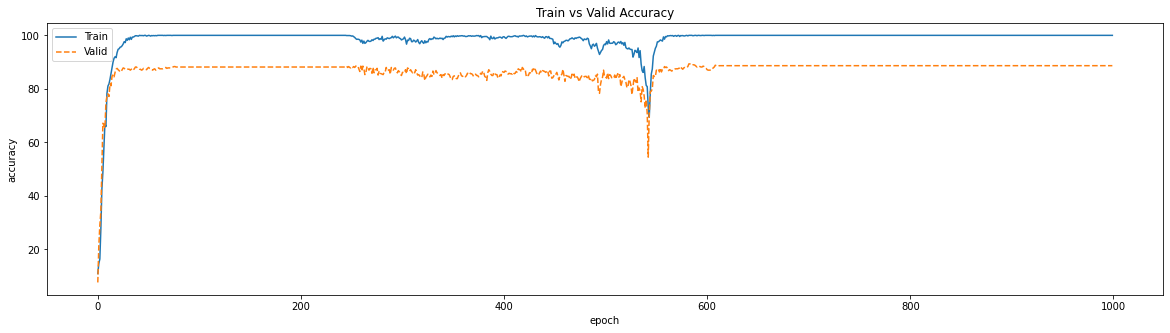

In [58]:
accuracy_plots(train_accu, eval_accu)

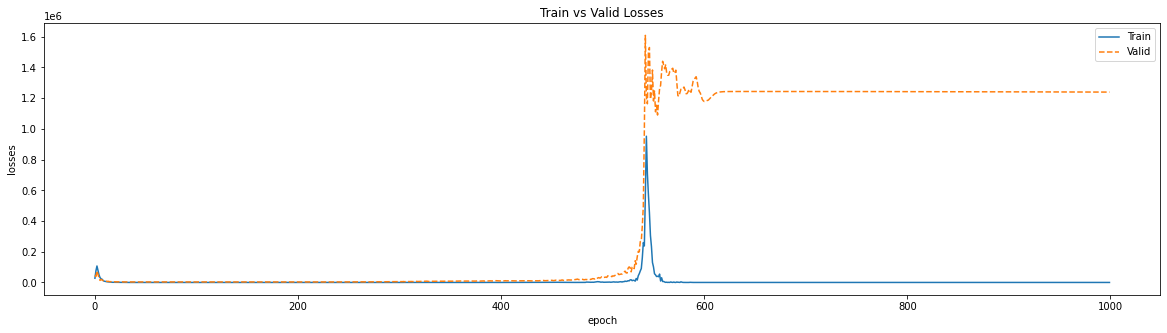

In [59]:
loss_plots(train_losses, eval_losses)

In [60]:
model = model_configs["2"]
model.load_state_dict(torch.load("models/best_model_parameters21.pth"))
model.eval()

model_2(
  (l1): Linear(in_features=784, out_features=400, bias=True)
  (l2): Linear(in_features=400, out_features=200, bias=True)
  (l3): Linear(in_features=200, out_features=10, bias=True)
)

In [61]:
with torch.no_grad():
  predicted_classes = []
  device = torch.device("cpu")
  for data in tqdm(first_five_loader):
    images,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(images)
    _, predicted = torch.max(outputs, 1)
    predicted_classes.append(predicted)

100%|██████████| 5/5 [00:00<00:00, 1852.94it/s]


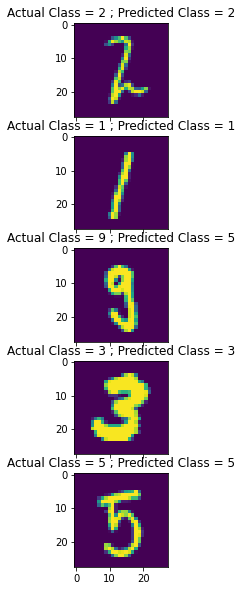

In [62]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for j in range(5):
  axs[j].imshow(first_five_test_images[j][0])
  axs[j].set_title(f"Actual Class = {first_five_test_image_labels[0+j]} ; Predicted Class = {predicted_classes[j].item()}")

for ax in axs.flat:
    ax.label_outer()

# model 2, training config 2:

In [63]:
s = time.time()
eval_losses, train_losses, eval_accu, train_accu = train("2", "2")
e = time.time()

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |   313600   |
|  l1.bias  |    400     |
| l2.weight |   80000    |
|  l2.bias  |    200     |
| l3.weight |    2000    |
|  l3.bias  |     10     |
+-----------+------------+
Total Trainable Params: 396210

Epoch : 1


100%|██████████| 2/2 [00:00<00:00, 75.25it/s]



Epoch : 2


100%|██████████| 2/2 [00:00<00:00, 93.45it/s]



Epoch : 3


100%|██████████| 2/2 [00:00<00:00, 100.56it/s]



Epoch : 4


100%|██████████| 2/2 [00:00<00:00, 91.73it/s]



Epoch : 5


100%|██████████| 2/2 [00:00<00:00, 96.33it/s]



Epoch : 6


100%|██████████| 2/2 [00:00<00:00, 94.95it/s]



Epoch : 7


100%|██████████| 2/2 [00:00<00:00, 102.35it/s]



Epoch : 8


100%|██████████| 2/2 [00:00<00:00, 103.48it/s]



Epoch : 9


100%|██████████| 2/2 [00:00<00:00, 75.24it/s]



Epoch : 10


100%|██████████| 2/2 [00:00<00:00, 97.26it/s]



Epoch : 11


100%|██████████| 2/2 [00:00<00:00, 100.80it/s]



Epoch : 12


100%|██████████| 2/2 [00:00<00:00, 108.65it/s]



Epoch : 13


100%|██████████| 2/2 [00:00<00:00, 101.79it/s]



Epoch : 14


100%|██████████| 2/2 [00:00<00:00, 99.83it/s]



Epoch : 15


100%|██████████| 2/2 [00:00<00:00, 102.75it/s]



Epoch : 16


100%|██████████| 2/2 [00:00<00:00, 95.63it/s]



Epoch : 17


100%|██████████| 2/2 [00:00<00:00, 85.66it/s]



Epoch : 18


100%|██████████| 2/2 [00:00<00:00, 78.34it/s]



Epoch : 19


100%|██████████| 2/2 [00:00<00:00, 93.50it/s]



Epoch : 20


100%|██████████| 2/2 [00:00<00:00, 105.84it/s]



Epoch : 21


100%|██████████| 2/2 [00:00<00:00, 88.83it/s]



Epoch : 22


100%|██████████| 2/2 [00:00<00:00, 91.31it/s]



Epoch : 23


100%|██████████| 2/2 [00:00<00:00, 95.18it/s]



Epoch : 24


100%|██████████| 2/2 [00:00<00:00, 76.71it/s]



Epoch : 25


100%|██████████| 2/2 [00:00<00:00, 90.57it/s]



Epoch : 26


100%|██████████| 2/2 [00:00<00:00, 84.43it/s]



Epoch : 27


100%|██████████| 2/2 [00:00<00:00, 101.83it/s]



Epoch : 28


100%|██████████| 2/2 [00:00<00:00, 101.44it/s]



Epoch : 29


100%|██████████| 2/2 [00:00<00:00, 86.79it/s]



Epoch : 30


100%|██████████| 2/2 [00:00<00:00, 66.56it/s]



Epoch : 31


100%|██████████| 2/2 [00:00<00:00, 103.78it/s]



Epoch : 32


100%|██████████| 2/2 [00:00<00:00, 95.98it/s]



Epoch : 33


100%|██████████| 2/2 [00:00<00:00, 97.39it/s]



Epoch : 34


100%|██████████| 2/2 [00:00<00:00, 100.34it/s]



Epoch : 35


100%|██████████| 2/2 [00:00<00:00, 105.52it/s]



Epoch : 36


100%|██████████| 2/2 [00:00<00:00, 104.56it/s]



Epoch : 37


100%|██████████| 2/2 [00:00<00:00, 103.17it/s]



Epoch : 38


100%|██████████| 2/2 [00:00<00:00, 103.70it/s]



Epoch : 39


100%|██████████| 2/2 [00:00<00:00, 105.41it/s]



Epoch : 40


100%|██████████| 2/2 [00:00<00:00, 107.42it/s]



Epoch : 41


100%|██████████| 2/2 [00:00<00:00, 105.02it/s]



Epoch : 42


100%|██████████| 2/2 [00:00<00:00, 107.50it/s]



Epoch : 43


100%|██████████| 2/2 [00:00<00:00, 103.24it/s]



Epoch : 44


100%|██████████| 2/2 [00:00<00:00, 134.79it/s]



Epoch : 45


100%|██████████| 2/2 [00:00<00:00, 124.54it/s]



Epoch : 46


100%|██████████| 2/2 [00:00<00:00, 131.72it/s]



Epoch : 47


100%|██████████| 2/2 [00:00<00:00, 100.56it/s]



Epoch : 48


100%|██████████| 2/2 [00:00<00:00, 120.22it/s]



Epoch : 49


100%|██████████| 2/2 [00:00<00:00, 119.27it/s]



Epoch : 50


100%|██████████| 2/2 [00:00<00:00, 127.48it/s]



Epoch : 51


100%|██████████| 2/2 [00:00<00:00, 143.82it/s]



Epoch : 52


100%|██████████| 2/2 [00:00<00:00, 119.62it/s]



Epoch : 53


100%|██████████| 2/2 [00:00<00:00, 131.72it/s]



Epoch : 54


100%|██████████| 2/2 [00:00<00:00, 131.14it/s]



Epoch : 55


100%|██████████| 2/2 [00:00<00:00, 111.84it/s]



Epoch : 56


100%|██████████| 2/2 [00:00<00:00, 108.02it/s]



Epoch : 57


100%|██████████| 2/2 [00:00<00:00, 129.54it/s]



Epoch : 58


100%|██████████| 2/2 [00:00<00:00, 121.27it/s]



Epoch : 59


100%|██████████| 2/2 [00:00<00:00, 161.33it/s]



Epoch : 60


100%|██████████| 2/2 [00:00<00:00, 138.11it/s]



Epoch : 61


100%|██████████| 2/2 [00:00<00:00, 129.39it/s]



Epoch : 62


100%|██████████| 2/2 [00:00<00:00, 131.88it/s]



Epoch : 63


100%|██████████| 2/2 [00:00<00:00, 133.82it/s]



Epoch : 64


100%|██████████| 2/2 [00:00<00:00, 84.47it/s]



Epoch : 65


100%|██████████| 2/2 [00:00<00:00, 122.28it/s]



Epoch : 66


100%|██████████| 2/2 [00:00<00:00, 132.26it/s]



Epoch : 67


100%|██████████| 2/2 [00:00<00:00, 115.78it/s]



Epoch : 68


100%|██████████| 2/2 [00:00<00:00, 105.16it/s]



Epoch : 69


100%|██████████| 2/2 [00:00<00:00, 103.32it/s]



Epoch : 70


100%|██████████| 2/2 [00:00<00:00, 123.12it/s]



Epoch : 71


100%|██████████| 2/2 [00:00<00:00, 123.45it/s]



Epoch : 72


100%|██████████| 2/2 [00:00<00:00, 109.91it/s]



Epoch : 73


100%|██████████| 2/2 [00:00<00:00, 151.60it/s]



Epoch : 74


100%|██████████| 2/2 [00:00<00:00, 119.68it/s]



Epoch : 75


100%|██████████| 2/2 [00:00<00:00, 119.22it/s]



Epoch : 76


100%|██████████| 2/2 [00:00<00:00, 136.12it/s]



Epoch : 77


100%|██████████| 2/2 [00:00<00:00, 126.70it/s]



Epoch : 78


100%|██████████| 2/2 [00:00<00:00, 130.70it/s]



Epoch : 79


100%|██████████| 2/2 [00:00<00:00, 129.28it/s]



Epoch : 80


100%|██████████| 2/2 [00:00<00:00, 123.72it/s]



Epoch : 81


100%|██████████| 2/2 [00:00<00:00, 125.33it/s]



Epoch : 82


100%|██████████| 2/2 [00:00<00:00, 123.90it/s]



Epoch : 83


100%|██████████| 2/2 [00:00<00:00, 119.26it/s]



Epoch : 84


100%|██████████| 2/2 [00:00<00:00, 108.39it/s]



Epoch : 85


100%|██████████| 2/2 [00:00<00:00, 121.88it/s]



Epoch : 86


100%|██████████| 2/2 [00:00<00:00, 134.27it/s]



Epoch : 87


100%|██████████| 2/2 [00:00<00:00, 121.65it/s]



Epoch : 88


100%|██████████| 2/2 [00:00<00:00, 138.38it/s]



Epoch : 89


100%|██████████| 2/2 [00:00<00:00, 119.19it/s]



Epoch : 90


100%|██████████| 2/2 [00:00<00:00, 121.10it/s]



Epoch : 91


100%|██████████| 2/2 [00:00<00:00, 117.34it/s]



Epoch : 92


100%|██████████| 2/2 [00:00<00:00, 121.27it/s]



Epoch : 93


100%|██████████| 2/2 [00:00<00:00, 116.43it/s]



Epoch : 94


100%|██████████| 2/2 [00:00<00:00, 114.64it/s]



Epoch : 95


100%|██████████| 2/2 [00:00<00:00, 130.20it/s]



Epoch : 96


100%|██████████| 2/2 [00:00<00:00, 136.98it/s]



Epoch : 97


100%|██████████| 2/2 [00:00<00:00, 118.93it/s]



Epoch : 98


100%|██████████| 2/2 [00:00<00:00, 98.03it/s]



Epoch : 99


100%|██████████| 2/2 [00:00<00:00, 122.56it/s]



Epoch : 100


100%|██████████| 2/2 [00:00<00:00, 120.30it/s]



Epoch : 101


100%|██████████| 2/2 [00:00<00:00, 105.66it/s]



Epoch : 102


100%|██████████| 2/2 [00:00<00:00, 122.80it/s]



Epoch : 103


100%|██████████| 2/2 [00:00<00:00, 114.44it/s]



Epoch : 104


100%|██████████| 2/2 [00:00<00:00, 129.84it/s]



Epoch : 105


100%|██████████| 2/2 [00:00<00:00, 102.38it/s]



Epoch : 106


100%|██████████| 2/2 [00:00<00:00, 117.36it/s]



Epoch : 107


100%|██████████| 2/2 [00:00<00:00, 102.53it/s]



Epoch : 108


100%|██████████| 2/2 [00:00<00:00, 122.75it/s]



Epoch : 109


100%|██████████| 2/2 [00:00<00:00, 110.98it/s]



Epoch : 110


100%|██████████| 2/2 [00:00<00:00, 107.61it/s]



Epoch : 111


100%|██████████| 2/2 [00:00<00:00, 90.14it/s]



Epoch : 112


100%|██████████| 2/2 [00:00<00:00, 114.76it/s]



Epoch : 113


100%|██████████| 2/2 [00:00<00:00, 122.15it/s]



Epoch : 114


100%|██████████| 2/2 [00:00<00:00, 123.06it/s]



Epoch : 115


100%|██████████| 2/2 [00:00<00:00, 115.13it/s]



Epoch : 116


100%|██████████| 2/2 [00:00<00:00, 115.54it/s]



Epoch : 117


100%|██████████| 2/2 [00:00<00:00, 129.94it/s]



Epoch : 118


100%|██████████| 2/2 [00:00<00:00, 63.07it/s]



Epoch : 119


100%|██████████| 2/2 [00:00<00:00, 123.60it/s]



Epoch : 120


100%|██████████| 2/2 [00:00<00:00, 112.26it/s]



Epoch : 121


100%|██████████| 2/2 [00:00<00:00, 119.91it/s]



Epoch : 122


100%|██████████| 2/2 [00:00<00:00, 124.56it/s]



Epoch : 123


100%|██████████| 2/2 [00:00<00:00, 116.77it/s]



Epoch : 124


100%|██████████| 2/2 [00:00<00:00, 116.94it/s]



Epoch : 125


100%|██████████| 2/2 [00:00<00:00, 106.37it/s]



Epoch : 126


100%|██████████| 2/2 [00:00<00:00, 108.58it/s]



Epoch : 127


100%|██████████| 2/2 [00:00<00:00, 102.22it/s]



Epoch : 128


100%|██████████| 2/2 [00:00<00:00, 114.49it/s]



Epoch : 129


100%|██████████| 2/2 [00:00<00:00, 114.94it/s]



Epoch : 130


100%|██████████| 2/2 [00:00<00:00, 118.92it/s]



Epoch : 131


100%|██████████| 2/2 [00:00<00:00, 127.60it/s]



Epoch : 132


100%|██████████| 2/2 [00:00<00:00, 119.12it/s]



Epoch : 133


100%|██████████| 2/2 [00:00<00:00, 95.03it/s]



Epoch : 134


100%|██████████| 2/2 [00:00<00:00, 135.35it/s]



Epoch : 135


100%|██████████| 2/2 [00:00<00:00, 104.22it/s]



Epoch : 136


100%|██████████| 2/2 [00:00<00:00, 118.89it/s]



Epoch : 137


100%|██████████| 2/2 [00:00<00:00, 115.06it/s]



Epoch : 138


100%|██████████| 2/2 [00:00<00:00, 113.29it/s]



Epoch : 139


100%|██████████| 2/2 [00:00<00:00, 110.29it/s]



Epoch : 140


100%|██████████| 2/2 [00:00<00:00, 101.67it/s]



Epoch : 141


100%|██████████| 2/2 [00:00<00:00, 128.14it/s]



Epoch : 142


100%|██████████| 2/2 [00:00<00:00, 105.41it/s]



Epoch : 143


100%|██████████| 2/2 [00:00<00:00, 119.95it/s]



Epoch : 144


100%|██████████| 2/2 [00:00<00:00, 112.30it/s]



Epoch : 145


100%|██████████| 2/2 [00:00<00:00, 120.84it/s]



Epoch : 146


100%|██████████| 2/2 [00:00<00:00, 109.40it/s]



Epoch : 147


100%|██████████| 2/2 [00:00<00:00, 120.68it/s]



Epoch : 148


100%|██████████| 2/2 [00:00<00:00, 92.21it/s]



Epoch : 149


100%|██████████| 2/2 [00:00<00:00, 114.66it/s]



Epoch : 150


100%|██████████| 2/2 [00:00<00:00, 140.44it/s]



Epoch : 151


100%|██████████| 2/2 [00:00<00:00, 124.43it/s]



Epoch : 152


100%|██████████| 2/2 [00:00<00:00, 102.29it/s]



Epoch : 153


100%|██████████| 2/2 [00:00<00:00, 118.18it/s]



Epoch : 154


100%|██████████| 2/2 [00:00<00:00, 120.20it/s]



Epoch : 155


100%|██████████| 2/2 [00:00<00:00, 113.51it/s]



Epoch : 156


100%|██████████| 2/2 [00:00<00:00, 89.98it/s]



Epoch : 157


100%|██████████| 2/2 [00:00<00:00, 120.35it/s]



Epoch : 158


100%|██████████| 2/2 [00:00<00:00, 128.90it/s]



Epoch : 159


100%|██████████| 2/2 [00:00<00:00, 138.08it/s]



Epoch : 160


100%|██████████| 2/2 [00:00<00:00, 111.26it/s]



Epoch : 161


100%|██████████| 2/2 [00:00<00:00, 115.50it/s]



Epoch : 162


100%|██████████| 2/2 [00:00<00:00, 112.75it/s]



Epoch : 163


100%|██████████| 2/2 [00:00<00:00, 116.76it/s]



Epoch : 164


100%|██████████| 2/2 [00:00<00:00, 108.78it/s]



Epoch : 165


100%|██████████| 2/2 [00:00<00:00, 112.29it/s]



Epoch : 166


100%|██████████| 2/2 [00:00<00:00, 117.44it/s]



Epoch : 167


100%|██████████| 2/2 [00:00<00:00, 106.42it/s]



Epoch : 168


100%|██████████| 2/2 [00:00<00:00, 115.92it/s]



Epoch : 169


100%|██████████| 2/2 [00:00<00:00, 97.08it/s]



Epoch : 170


100%|██████████| 2/2 [00:00<00:00, 119.67it/s]



Epoch : 171


100%|██████████| 2/2 [00:00<00:00, 137.03it/s]



Epoch : 172


100%|██████████| 2/2 [00:00<00:00, 109.52it/s]



Epoch : 173


100%|██████████| 2/2 [00:00<00:00, 123.30it/s]



Epoch : 174


100%|██████████| 2/2 [00:00<00:00, 88.74it/s]



Epoch : 175


100%|██████████| 2/2 [00:00<00:00, 107.65it/s]



Epoch : 176


100%|██████████| 2/2 [00:00<00:00, 122.81it/s]



Epoch : 177


100%|██████████| 2/2 [00:00<00:00, 111.00it/s]



Epoch : 178


100%|██████████| 2/2 [00:00<00:00, 117.27it/s]



Epoch : 179


100%|██████████| 2/2 [00:00<00:00, 99.67it/s]



Epoch : 180


100%|██████████| 2/2 [00:00<00:00, 87.15it/s]



Epoch : 181


100%|██████████| 2/2 [00:00<00:00, 115.11it/s]



Epoch : 182


100%|██████████| 2/2 [00:00<00:00, 113.17it/s]



Epoch : 183


100%|██████████| 2/2 [00:00<00:00, 111.54it/s]



Epoch : 184


100%|██████████| 2/2 [00:00<00:00, 114.88it/s]



Epoch : 185


100%|██████████| 2/2 [00:00<00:00, 107.92it/s]



Epoch : 186


100%|██████████| 2/2 [00:00<00:00, 95.82it/s]



Epoch : 187


100%|██████████| 2/2 [00:00<00:00, 105.63it/s]



Epoch : 188


100%|██████████| 2/2 [00:00<00:00, 104.11it/s]



Epoch : 189


100%|██████████| 2/2 [00:00<00:00, 111.93it/s]



Epoch : 190


100%|██████████| 2/2 [00:00<00:00, 110.05it/s]



Epoch : 191


100%|██████████| 2/2 [00:00<00:00, 110.43it/s]



Epoch : 192


100%|██████████| 2/2 [00:00<00:00, 100.68it/s]



Epoch : 193


100%|██████████| 2/2 [00:00<00:00, 111.36it/s]



Epoch : 194


100%|██████████| 2/2 [00:00<00:00, 100.43it/s]



Epoch : 195


100%|██████████| 2/2 [00:00<00:00, 108.29it/s]



Epoch : 196


100%|██████████| 2/2 [00:00<00:00, 110.54it/s]



Epoch : 197


100%|██████████| 2/2 [00:00<00:00, 95.26it/s]



Epoch : 198


100%|██████████| 2/2 [00:00<00:00, 112.96it/s]



Epoch : 199


100%|██████████| 2/2 [00:00<00:00, 104.15it/s]



Epoch : 200


100%|██████████| 2/2 [00:00<00:00, 126.78it/s]



Epoch : 201


100%|██████████| 2/2 [00:00<00:00, 122.88it/s]



Epoch : 202


100%|██████████| 2/2 [00:00<00:00, 127.11it/s]



Epoch : 203


100%|██████████| 2/2 [00:00<00:00, 107.86it/s]



Epoch : 204


100%|██████████| 2/2 [00:00<00:00, 111.02it/s]



Epoch : 205


100%|██████████| 2/2 [00:00<00:00, 122.94it/s]



Epoch : 206


100%|██████████| 2/2 [00:00<00:00, 111.45it/s]



Epoch : 207


100%|██████████| 2/2 [00:00<00:00, 106.49it/s]



Epoch : 208


100%|██████████| 2/2 [00:00<00:00, 102.34it/s]



Epoch : 209


100%|██████████| 2/2 [00:00<00:00, 108.23it/s]



Epoch : 210


100%|██████████| 2/2 [00:00<00:00, 112.17it/s]



Epoch : 211


100%|██████████| 2/2 [00:00<00:00, 99.96it/s]



Epoch : 212


100%|██████████| 2/2 [00:00<00:00, 110.21it/s]



Epoch : 213


100%|██████████| 2/2 [00:00<00:00, 97.39it/s]



Epoch : 214


100%|██████████| 2/2 [00:00<00:00, 106.93it/s]



Epoch : 215


100%|██████████| 2/2 [00:00<00:00, 103.52it/s]



Epoch : 216


100%|██████████| 2/2 [00:00<00:00, 103.87it/s]



Epoch : 217


100%|██████████| 2/2 [00:00<00:00, 107.61it/s]



Epoch : 218


100%|██████████| 2/2 [00:00<00:00, 104.76it/s]



Epoch : 219


100%|██████████| 2/2 [00:00<00:00, 84.48it/s]



Epoch : 220


100%|██████████| 2/2 [00:00<00:00, 107.82it/s]



Epoch : 221


100%|██████████| 2/2 [00:00<00:00, 108.51it/s]



Epoch : 222


100%|██████████| 2/2 [00:00<00:00, 116.21it/s]



Epoch : 223


100%|██████████| 2/2 [00:00<00:00, 100.48it/s]



Epoch : 224


100%|██████████| 2/2 [00:00<00:00, 108.49it/s]



Epoch : 225


100%|██████████| 2/2 [00:00<00:00, 97.46it/s]



Epoch : 226


100%|██████████| 2/2 [00:00<00:00, 104.96it/s]



Epoch : 227


100%|██████████| 2/2 [00:00<00:00, 112.77it/s]



Epoch : 228


100%|██████████| 2/2 [00:00<00:00, 111.46it/s]



Epoch : 229


100%|██████████| 2/2 [00:00<00:00, 108.13it/s]



Epoch : 230


100%|██████████| 2/2 [00:00<00:00, 110.27it/s]



Epoch : 231


100%|██████████| 2/2 [00:00<00:00, 92.52it/s]



Epoch : 232


100%|██████████| 2/2 [00:00<00:00, 94.85it/s]



Epoch : 233


100%|██████████| 2/2 [00:00<00:00, 92.52it/s]



Epoch : 234


100%|██████████| 2/2 [00:00<00:00, 104.01it/s]



Epoch : 235


100%|██████████| 2/2 [00:00<00:00, 97.58it/s]



Epoch : 236


100%|██████████| 2/2 [00:00<00:00, 103.53it/s]



Epoch : 237


100%|██████████| 2/2 [00:00<00:00, 103.78it/s]



Epoch : 238


100%|██████████| 2/2 [00:00<00:00, 121.15it/s]



Epoch : 239


100%|██████████| 2/2 [00:00<00:00, 82.92it/s]



Epoch : 240


100%|██████████| 2/2 [00:00<00:00, 97.03it/s]



Epoch : 241


100%|██████████| 2/2 [00:00<00:00, 102.93it/s]



Epoch : 242


100%|██████████| 2/2 [00:00<00:00, 105.59it/s]



Epoch : 243


100%|██████████| 2/2 [00:00<00:00, 82.87it/s]



Epoch : 244


100%|██████████| 2/2 [00:00<00:00, 107.83it/s]



Epoch : 245


100%|██████████| 2/2 [00:00<00:00, 108.32it/s]



Epoch : 246


100%|██████████| 2/2 [00:00<00:00, 105.23it/s]



Epoch : 247


100%|██████████| 2/2 [00:00<00:00, 105.48it/s]



Epoch : 248


100%|██████████| 2/2 [00:00<00:00, 102.19it/s]



Epoch : 249


100%|██████████| 2/2 [00:00<00:00, 128.69it/s]



Epoch : 250


100%|██████████| 2/2 [00:00<00:00, 105.11it/s]



Epoch : 251


100%|██████████| 2/2 [00:00<00:00, 107.46it/s]



Epoch : 252


100%|██████████| 2/2 [00:00<00:00, 98.14it/s]



Epoch : 253


100%|██████████| 2/2 [00:00<00:00, 93.33it/s]



Epoch : 254


100%|██████████| 2/2 [00:00<00:00, 100.49it/s]



Epoch : 255


100%|██████████| 2/2 [00:00<00:00, 104.99it/s]



Epoch : 256


100%|██████████| 2/2 [00:00<00:00, 111.87it/s]



Epoch : 257


100%|██████████| 2/2 [00:00<00:00, 100.37it/s]



Epoch : 258


100%|██████████| 2/2 [00:00<00:00, 103.21it/s]



Epoch : 259


100%|██████████| 2/2 [00:00<00:00, 93.20it/s]



Epoch : 260


100%|██████████| 2/2 [00:00<00:00, 104.46it/s]



Epoch : 261


100%|██████████| 2/2 [00:00<00:00, 106.09it/s]



Epoch : 262


100%|██████████| 2/2 [00:00<00:00, 122.38it/s]



Epoch : 263


100%|██████████| 2/2 [00:00<00:00, 105.34it/s]



Epoch : 264


100%|██████████| 2/2 [00:00<00:00, 103.44it/s]



Epoch : 265


100%|██████████| 2/2 [00:00<00:00, 100.84it/s]



Epoch : 266


100%|██████████| 2/2 [00:00<00:00, 115.32it/s]



Epoch : 267


100%|██████████| 2/2 [00:00<00:00, 108.60it/s]



Epoch : 268


100%|██████████| 2/2 [00:00<00:00, 104.31it/s]



Epoch : 269


100%|██████████| 2/2 [00:00<00:00, 101.16it/s]



Epoch : 270


100%|██████████| 2/2 [00:00<00:00, 101.50it/s]



Epoch : 271


100%|██████████| 2/2 [00:00<00:00, 104.23it/s]



Epoch : 272


100%|██████████| 2/2 [00:00<00:00, 108.66it/s]



Epoch : 273


100%|██████████| 2/2 [00:00<00:00, 101.25it/s]



Epoch : 274


100%|██████████| 2/2 [00:00<00:00, 121.21it/s]



Epoch : 275


100%|██████████| 2/2 [00:00<00:00, 104.58it/s]



Epoch : 276


100%|██████████| 2/2 [00:00<00:00, 93.99it/s]



Epoch : 277


100%|██████████| 2/2 [00:00<00:00, 108.08it/s]



Epoch : 278


100%|██████████| 2/2 [00:00<00:00, 102.77it/s]



Epoch : 279


100%|██████████| 2/2 [00:00<00:00, 80.97it/s]



Epoch : 280


100%|██████████| 2/2 [00:00<00:00, 112.04it/s]



Epoch : 281


100%|██████████| 2/2 [00:00<00:00, 101.05it/s]



Epoch : 282


100%|██████████| 2/2 [00:00<00:00, 105.54it/s]



Epoch : 283


100%|██████████| 2/2 [00:00<00:00, 118.67it/s]



Epoch : 284


100%|██████████| 2/2 [00:00<00:00, 102.24it/s]



Epoch : 285


100%|██████████| 2/2 [00:00<00:00, 102.88it/s]



Epoch : 286


100%|██████████| 2/2 [00:00<00:00, 116.70it/s]



Epoch : 287


100%|██████████| 2/2 [00:00<00:00, 123.14it/s]



Epoch : 288


100%|██████████| 2/2 [00:00<00:00, 107.96it/s]



Epoch : 289


100%|██████████| 2/2 [00:00<00:00, 94.63it/s]



Epoch : 290


100%|██████████| 2/2 [00:00<00:00, 104.49it/s]



Epoch : 291


100%|██████████| 2/2 [00:00<00:00, 117.18it/s]



Epoch : 292


100%|██████████| 2/2 [00:00<00:00, 117.89it/s]



Epoch : 293


100%|██████████| 2/2 [00:00<00:00, 104.38it/s]



Epoch : 294


100%|██████████| 2/2 [00:00<00:00, 101.24it/s]



Epoch : 295


100%|██████████| 2/2 [00:00<00:00, 95.86it/s]



Epoch : 296


100%|██████████| 2/2 [00:00<00:00, 86.94it/s]



Epoch : 297


100%|██████████| 2/2 [00:00<00:00, 105.70it/s]



Epoch : 298


100%|██████████| 2/2 [00:00<00:00, 101.08it/s]



Epoch : 299


100%|██████████| 2/2 [00:00<00:00, 93.65it/s]



Epoch : 300


100%|██████████| 2/2 [00:00<00:00, 98.63it/s]



Epoch : 301


100%|██████████| 2/2 [00:00<00:00, 109.14it/s]



Epoch : 302


100%|██████████| 2/2 [00:00<00:00, 107.18it/s]



Epoch : 303


100%|██████████| 2/2 [00:00<00:00, 103.66it/s]



Epoch : 304


100%|██████████| 2/2 [00:00<00:00, 125.08it/s]



Epoch : 305


100%|██████████| 2/2 [00:00<00:00, 97.29it/s]



Epoch : 306


100%|██████████| 2/2 [00:00<00:00, 104.16it/s]



Epoch : 307


100%|██████████| 2/2 [00:00<00:00, 115.86it/s]



Epoch : 308


100%|██████████| 2/2 [00:00<00:00, 95.85it/s]



Epoch : 309


100%|██████████| 2/2 [00:00<00:00, 111.63it/s]



Epoch : 310


100%|██████████| 2/2 [00:00<00:00, 112.82it/s]



Epoch : 311


100%|██████████| 2/2 [00:00<00:00, 98.95it/s]



Epoch : 312


100%|██████████| 2/2 [00:00<00:00, 100.46it/s]



Epoch : 313


100%|██████████| 2/2 [00:00<00:00, 101.37it/s]



Epoch : 314


100%|██████████| 2/2 [00:00<00:00, 102.67it/s]



Epoch : 315


100%|██████████| 2/2 [00:00<00:00, 117.75it/s]



Epoch : 316


100%|██████████| 2/2 [00:00<00:00, 93.00it/s]



Epoch : 317


100%|██████████| 2/2 [00:00<00:00, 98.41it/s]



Epoch : 318


100%|██████████| 2/2 [00:00<00:00, 109.13it/s]



Epoch : 319


100%|██████████| 2/2 [00:00<00:00, 98.88it/s]



Epoch : 320


100%|██████████| 2/2 [00:00<00:00, 92.15it/s]



Epoch : 321


100%|██████████| 2/2 [00:00<00:00, 98.20it/s]



Epoch : 322


100%|██████████| 2/2 [00:00<00:00, 99.52it/s]



Epoch : 323


100%|██████████| 2/2 [00:00<00:00, 90.54it/s]



Epoch : 324


100%|██████████| 2/2 [00:00<00:00, 96.56it/s]



Epoch : 325


100%|██████████| 2/2 [00:00<00:00, 93.41it/s]



Epoch : 326


100%|██████████| 2/2 [00:00<00:00, 97.23it/s]



Epoch : 327


100%|██████████| 2/2 [00:00<00:00, 91.99it/s]



Epoch : 328


100%|██████████| 2/2 [00:00<00:00, 100.60it/s]



Epoch : 329


100%|██████████| 2/2 [00:00<00:00, 102.99it/s]



Epoch : 330


100%|██████████| 2/2 [00:00<00:00, 100.73it/s]



Epoch : 331


100%|██████████| 2/2 [00:00<00:00, 101.31it/s]



Epoch : 332


100%|██████████| 2/2 [00:00<00:00, 100.42it/s]



Epoch : 333


100%|██████████| 2/2 [00:00<00:00, 104.48it/s]



Epoch : 334


100%|██████████| 2/2 [00:00<00:00, 91.86it/s]



Epoch : 335


100%|██████████| 2/2 [00:00<00:00, 64.07it/s]



Epoch : 336


100%|██████████| 2/2 [00:00<00:00, 101.48it/s]



Epoch : 337


100%|██████████| 2/2 [00:00<00:00, 90.54it/s]



Epoch : 338


100%|██████████| 2/2 [00:00<00:00, 98.88it/s]



Epoch : 339


100%|██████████| 2/2 [00:00<00:00, 96.95it/s]



Epoch : 340


100%|██████████| 2/2 [00:00<00:00, 123.38it/s]



Epoch : 341


100%|██████████| 2/2 [00:00<00:00, 94.96it/s]



Epoch : 342


100%|██████████| 2/2 [00:00<00:00, 100.30it/s]



Epoch : 343


100%|██████████| 2/2 [00:00<00:00, 94.94it/s]



Epoch : 344


100%|██████████| 2/2 [00:00<00:00, 86.20it/s]



Epoch : 345


100%|██████████| 2/2 [00:00<00:00, 99.39it/s]



Epoch : 346


100%|██████████| 2/2 [00:00<00:00, 102.99it/s]



Epoch : 347


100%|██████████| 2/2 [00:00<00:00, 96.30it/s]



Epoch : 348


100%|██████████| 2/2 [00:00<00:00, 96.83it/s]



Epoch : 349


100%|██████████| 2/2 [00:00<00:00, 96.02it/s]



Epoch : 350


100%|██████████| 2/2 [00:00<00:00, 109.73it/s]



Epoch : 351


100%|██████████| 2/2 [00:00<00:00, 111.28it/s]



Epoch : 352


100%|██████████| 2/2 [00:00<00:00, 93.54it/s]



Epoch : 353


100%|██████████| 2/2 [00:00<00:00, 100.38it/s]



Epoch : 354


100%|██████████| 2/2 [00:00<00:00, 104.29it/s]



Epoch : 355


100%|██████████| 2/2 [00:00<00:00, 110.47it/s]



Epoch : 356


100%|██████████| 2/2 [00:00<00:00, 92.50it/s]



Epoch : 357


100%|██████████| 2/2 [00:00<00:00, 94.85it/s]



Epoch : 358


100%|██████████| 2/2 [00:00<00:00, 109.05it/s]



Epoch : 359


100%|██████████| 2/2 [00:00<00:00, 100.36it/s]



Epoch : 360


100%|██████████| 2/2 [00:00<00:00, 118.70it/s]



Epoch : 361


100%|██████████| 2/2 [00:00<00:00, 100.63it/s]



Epoch : 362


100%|██████████| 2/2 [00:00<00:00, 106.95it/s]



Epoch : 363


100%|██████████| 2/2 [00:00<00:00, 97.75it/s]



Epoch : 364


100%|██████████| 2/2 [00:00<00:00, 98.08it/s]



Epoch : 365


100%|██████████| 2/2 [00:00<00:00, 101.23it/s]



Epoch : 366


100%|██████████| 2/2 [00:00<00:00, 94.10it/s]



Epoch : 367


100%|██████████| 2/2 [00:00<00:00, 112.56it/s]



Epoch : 368


100%|██████████| 2/2 [00:00<00:00, 93.36it/s]



Epoch : 369


100%|██████████| 2/2 [00:00<00:00, 86.77it/s]



Epoch : 370


100%|██████████| 2/2 [00:00<00:00, 99.43it/s]



Epoch : 371


100%|██████████| 2/2 [00:00<00:00, 120.24it/s]



Epoch : 372


100%|██████████| 2/2 [00:00<00:00, 97.77it/s]



Epoch : 373


100%|██████████| 2/2 [00:00<00:00, 85.44it/s]



Epoch : 374


100%|██████████| 2/2 [00:00<00:00, 92.38it/s]



Epoch : 375


100%|██████████| 2/2 [00:00<00:00, 108.24it/s]



Epoch : 376


100%|██████████| 2/2 [00:00<00:00, 95.77it/s]



Epoch : 377


100%|██████████| 2/2 [00:00<00:00, 102.14it/s]



Epoch : 378


100%|██████████| 2/2 [00:00<00:00, 99.55it/s]



Epoch : 379


100%|██████████| 2/2 [00:00<00:00, 101.79it/s]



Epoch : 380


100%|██████████| 2/2 [00:00<00:00, 100.37it/s]



Epoch : 381


100%|██████████| 2/2 [00:00<00:00, 109.07it/s]



Epoch : 382


100%|██████████| 2/2 [00:00<00:00, 102.79it/s]



Epoch : 383


100%|██████████| 2/2 [00:00<00:00, 101.38it/s]



Epoch : 384


100%|██████████| 2/2 [00:00<00:00, 97.16it/s]



Epoch : 385


100%|██████████| 2/2 [00:00<00:00, 106.00it/s]



Epoch : 386


100%|██████████| 2/2 [00:00<00:00, 112.11it/s]



Epoch : 387


100%|██████████| 2/2 [00:00<00:00, 106.95it/s]



Epoch : 388


100%|██████████| 2/2 [00:00<00:00, 103.70it/s]



Epoch : 389


100%|██████████| 2/2 [00:00<00:00, 93.55it/s]



Epoch : 390


100%|██████████| 2/2 [00:00<00:00, 98.55it/s]



Epoch : 391


100%|██████████| 2/2 [00:00<00:00, 102.81it/s]



Epoch : 392


100%|██████████| 2/2 [00:00<00:00, 96.28it/s]



Epoch : 393


100%|██████████| 2/2 [00:00<00:00, 101.46it/s]



Epoch : 394


100%|██████████| 2/2 [00:00<00:00, 98.55it/s]



Epoch : 395


100%|██████████| 2/2 [00:00<00:00, 70.26it/s]



Epoch : 396


100%|██████████| 2/2 [00:00<00:00, 114.30it/s]



Epoch : 397


100%|██████████| 2/2 [00:00<00:00, 96.37it/s]



Epoch : 398


100%|██████████| 2/2 [00:00<00:00, 102.37it/s]



Epoch : 399


100%|██████████| 2/2 [00:00<00:00, 103.47it/s]



Epoch : 400


100%|██████████| 2/2 [00:00<00:00, 101.13it/s]



Epoch : 401


100%|██████████| 2/2 [00:00<00:00, 101.71it/s]



Epoch : 402


100%|██████████| 2/2 [00:00<00:00, 115.95it/s]



Epoch : 403


100%|██████████| 2/2 [00:00<00:00, 103.81it/s]



Epoch : 404


100%|██████████| 2/2 [00:00<00:00, 99.03it/s]



Epoch : 405


100%|██████████| 2/2 [00:00<00:00, 94.66it/s]



Epoch : 406


100%|██████████| 2/2 [00:00<00:00, 105.26it/s]



Epoch : 407


100%|██████████| 2/2 [00:00<00:00, 97.03it/s]



Epoch : 408


100%|██████████| 2/2 [00:00<00:00, 99.70it/s]



Epoch : 409


100%|██████████| 2/2 [00:00<00:00, 86.05it/s]



Epoch : 410


100%|██████████| 2/2 [00:00<00:00, 97.23it/s]



Epoch : 411


100%|██████████| 2/2 [00:00<00:00, 105.41it/s]



Epoch : 412


100%|██████████| 2/2 [00:00<00:00, 95.41it/s]



Epoch : 413


100%|██████████| 2/2 [00:00<00:00, 91.89it/s]



Epoch : 414


100%|██████████| 2/2 [00:00<00:00, 102.36it/s]



Epoch : 415


100%|██████████| 2/2 [00:00<00:00, 99.63it/s]



Epoch : 416


100%|██████████| 2/2 [00:00<00:00, 100.61it/s]



Epoch : 417


100%|██████████| 2/2 [00:00<00:00, 100.45it/s]



Epoch : 418


100%|██████████| 2/2 [00:00<00:00, 101.78it/s]



Epoch : 419


100%|██████████| 2/2 [00:00<00:00, 81.60it/s]



Epoch : 420


100%|██████████| 2/2 [00:00<00:00, 103.95it/s]



Epoch : 421


100%|██████████| 2/2 [00:00<00:00, 101.66it/s]



Epoch : 422


100%|██████████| 2/2 [00:00<00:00, 101.02it/s]



Epoch : 423


100%|██████████| 2/2 [00:00<00:00, 101.74it/s]



Epoch : 424


100%|██████████| 2/2 [00:00<00:00, 86.03it/s]



Epoch : 425


100%|██████████| 2/2 [00:00<00:00, 99.41it/s]



Epoch : 426


100%|██████████| 2/2 [00:00<00:00, 93.76it/s]



Epoch : 427


100%|██████████| 2/2 [00:00<00:00, 112.86it/s]



Epoch : 428


100%|██████████| 2/2 [00:00<00:00, 97.01it/s]



Epoch : 429


100%|██████████| 2/2 [00:00<00:00, 97.35it/s]



Epoch : 430


100%|██████████| 2/2 [00:00<00:00, 104.69it/s]



Epoch : 431


100%|██████████| 2/2 [00:00<00:00, 91.75it/s]



Epoch : 432


100%|██████████| 2/2 [00:00<00:00, 98.06it/s]



Epoch : 433


100%|██████████| 2/2 [00:00<00:00, 104.43it/s]



Epoch : 434


100%|██████████| 2/2 [00:00<00:00, 92.43it/s]



Epoch : 435


100%|██████████| 2/2 [00:00<00:00, 106.15it/s]



Epoch : 436


100%|██████████| 2/2 [00:00<00:00, 99.62it/s]



Epoch : 437


100%|██████████| 2/2 [00:00<00:00, 93.85it/s]



Epoch : 438


100%|██████████| 2/2 [00:00<00:00, 98.88it/s]



Epoch : 439


100%|██████████| 2/2 [00:00<00:00, 103.59it/s]



Epoch : 440


100%|██████████| 2/2 [00:00<00:00, 78.58it/s]



Epoch : 441


100%|██████████| 2/2 [00:00<00:00, 100.19it/s]



Epoch : 442


100%|██████████| 2/2 [00:00<00:00, 99.97it/s]



Epoch : 443


100%|██████████| 2/2 [00:00<00:00, 109.64it/s]



Epoch : 444


100%|██████████| 2/2 [00:00<00:00, 100.10it/s]



Epoch : 445


100%|██████████| 2/2 [00:00<00:00, 99.26it/s]



Epoch : 446


100%|██████████| 2/2 [00:00<00:00, 100.73it/s]



Epoch : 447


100%|██████████| 2/2 [00:00<00:00, 100.84it/s]



Epoch : 448


100%|██████████| 2/2 [00:00<00:00, 98.21it/s]



Epoch : 449


100%|██████████| 2/2 [00:00<00:00, 91.69it/s]



Epoch : 450


100%|██████████| 2/2 [00:00<00:00, 129.13it/s]



Epoch : 451


100%|██████████| 2/2 [00:00<00:00, 103.78it/s]



Epoch : 452


100%|██████████| 2/2 [00:00<00:00, 100.55it/s]



Epoch : 453


100%|██████████| 2/2 [00:00<00:00, 99.65it/s]



Epoch : 454


100%|██████████| 2/2 [00:00<00:00, 100.56it/s]



Epoch : 455


100%|██████████| 2/2 [00:00<00:00, 109.54it/s]



Epoch : 456


100%|██████████| 2/2 [00:00<00:00, 110.29it/s]



Epoch : 457


100%|██████████| 2/2 [00:00<00:00, 96.40it/s]



Epoch : 458


100%|██████████| 2/2 [00:00<00:00, 105.71it/s]



Epoch : 459


100%|██████████| 2/2 [00:00<00:00, 91.58it/s]



Epoch : 460


100%|██████████| 2/2 [00:00<00:00, 107.64it/s]



Epoch : 461


100%|██████████| 2/2 [00:00<00:00, 105.67it/s]



Epoch : 462


100%|██████████| 2/2 [00:00<00:00, 97.00it/s]



Epoch : 463


100%|██████████| 2/2 [00:00<00:00, 100.69it/s]



Epoch : 464


100%|██████████| 2/2 [00:00<00:00, 81.84it/s]



Epoch : 465


100%|██████████| 2/2 [00:00<00:00, 100.04it/s]



Epoch : 466


100%|██████████| 2/2 [00:00<00:00, 104.93it/s]



Epoch : 467


100%|██████████| 2/2 [00:00<00:00, 113.68it/s]



Epoch : 468


100%|██████████| 2/2 [00:00<00:00, 95.99it/s]



Epoch : 469


100%|██████████| 2/2 [00:00<00:00, 83.17it/s]



Epoch : 470


100%|██████████| 2/2 [00:00<00:00, 118.94it/s]



Epoch : 471


100%|██████████| 2/2 [00:00<00:00, 98.00it/s]



Epoch : 472


100%|██████████| 2/2 [00:00<00:00, 95.38it/s]



Epoch : 473


100%|██████████| 2/2 [00:00<00:00, 117.48it/s]



Epoch : 474


100%|██████████| 2/2 [00:00<00:00, 104.33it/s]



Epoch : 475


100%|██████████| 2/2 [00:00<00:00, 107.31it/s]



Epoch : 476


100%|██████████| 2/2 [00:00<00:00, 70.94it/s]



Epoch : 477


100%|██████████| 2/2 [00:00<00:00, 102.87it/s]



Epoch : 478


100%|██████████| 2/2 [00:00<00:00, 119.74it/s]



Epoch : 479


100%|██████████| 2/2 [00:00<00:00, 93.78it/s]



Epoch : 480


100%|██████████| 2/2 [00:00<00:00, 136.62it/s]



Epoch : 481


100%|██████████| 2/2 [00:00<00:00, 102.16it/s]



Epoch : 482


100%|██████████| 2/2 [00:00<00:00, 112.93it/s]



Epoch : 483


100%|██████████| 2/2 [00:00<00:00, 91.40it/s]



Epoch : 484


100%|██████████| 2/2 [00:00<00:00, 123.44it/s]



Epoch : 485


100%|██████████| 2/2 [00:00<00:00, 73.44it/s]



Epoch : 486


100%|██████████| 2/2 [00:00<00:00, 118.42it/s]



Epoch : 487


100%|██████████| 2/2 [00:00<00:00, 93.53it/s]



Epoch : 488


100%|██████████| 2/2 [00:00<00:00, 100.74it/s]



Epoch : 489


100%|██████████| 2/2 [00:00<00:00, 108.17it/s]



Epoch : 490


100%|██████████| 2/2 [00:00<00:00, 91.66it/s]



Epoch : 491


100%|██████████| 2/2 [00:00<00:00, 106.51it/s]



Epoch : 492


100%|██████████| 2/2 [00:00<00:00, 94.06it/s]



Epoch : 493


100%|██████████| 2/2 [00:00<00:00, 91.09it/s]



Epoch : 494


100%|██████████| 2/2 [00:00<00:00, 96.87it/s]



Epoch : 495


100%|██████████| 2/2 [00:00<00:00, 109.29it/s]



Epoch : 496


100%|██████████| 2/2 [00:00<00:00, 103.45it/s]



Epoch : 497


100%|██████████| 2/2 [00:00<00:00, 77.05it/s]



Epoch : 498


100%|██████████| 2/2 [00:00<00:00, 103.02it/s]



Epoch : 499


100%|██████████| 2/2 [00:00<00:00, 144.01it/s]



Epoch : 500


100%|██████████| 2/2 [00:00<00:00, 101.59it/s]



Epoch : 501


100%|██████████| 2/2 [00:00<00:00, 88.66it/s]



Epoch : 502


100%|██████████| 2/2 [00:00<00:00, 97.43it/s]



Epoch : 503


100%|██████████| 2/2 [00:00<00:00, 98.06it/s]



Epoch : 504


100%|██████████| 2/2 [00:00<00:00, 89.35it/s]



Epoch : 505


100%|██████████| 2/2 [00:00<00:00, 104.98it/s]



Epoch : 506


100%|██████████| 2/2 [00:00<00:00, 83.12it/s]



Epoch : 507


100%|██████████| 2/2 [00:00<00:00, 90.51it/s]



Epoch : 508


100%|██████████| 2/2 [00:00<00:00, 108.65it/s]



Epoch : 509


100%|██████████| 2/2 [00:00<00:00, 89.52it/s]



Epoch : 510


100%|██████████| 2/2 [00:00<00:00, 92.54it/s]



Epoch : 511


100%|██████████| 2/2 [00:00<00:00, 89.85it/s]



Epoch : 512


100%|██████████| 2/2 [00:00<00:00, 78.95it/s]



Epoch : 513


100%|██████████| 2/2 [00:00<00:00, 101.64it/s]



Epoch : 514


100%|██████████| 2/2 [00:00<00:00, 94.02it/s]



Epoch : 515


100%|██████████| 2/2 [00:00<00:00, 120.38it/s]



Epoch : 516


100%|██████████| 2/2 [00:00<00:00, 107.37it/s]



Epoch : 517


100%|██████████| 2/2 [00:00<00:00, 102.79it/s]



Epoch : 518


100%|██████████| 2/2 [00:00<00:00, 88.65it/s]



Epoch : 519


100%|██████████| 2/2 [00:00<00:00, 90.11it/s]



Epoch : 520


100%|██████████| 2/2 [00:00<00:00, 112.26it/s]



Epoch : 521


100%|██████████| 2/2 [00:00<00:00, 104.89it/s]



Epoch : 522


100%|██████████| 2/2 [00:00<00:00, 110.55it/s]



Epoch : 523


100%|██████████| 2/2 [00:00<00:00, 101.21it/s]



Epoch : 524


100%|██████████| 2/2 [00:00<00:00, 101.35it/s]



Epoch : 525


100%|██████████| 2/2 [00:00<00:00, 103.88it/s]



Epoch : 526


100%|██████████| 2/2 [00:00<00:00, 111.85it/s]



Epoch : 527


100%|██████████| 2/2 [00:00<00:00, 91.45it/s]



Epoch : 528


100%|██████████| 2/2 [00:00<00:00, 90.43it/s]



Epoch : 529


100%|██████████| 2/2 [00:00<00:00, 100.18it/s]



Epoch : 530


100%|██████████| 2/2 [00:00<00:00, 87.06it/s]



Epoch : 531


100%|██████████| 2/2 [00:00<00:00, 102.92it/s]



Epoch : 532


100%|██████████| 2/2 [00:00<00:00, 97.79it/s]



Epoch : 533


100%|██████████| 2/2 [00:00<00:00, 101.83it/s]



Epoch : 534


100%|██████████| 2/2 [00:00<00:00, 101.34it/s]



Epoch : 535


100%|██████████| 2/2 [00:00<00:00, 109.61it/s]



Epoch : 536


100%|██████████| 2/2 [00:00<00:00, 97.54it/s]



Epoch : 537


100%|██████████| 2/2 [00:00<00:00, 102.92it/s]



Epoch : 538


100%|██████████| 2/2 [00:00<00:00, 97.34it/s]



Epoch : 539


100%|██████████| 2/2 [00:00<00:00, 95.65it/s]



Epoch : 540


100%|██████████| 2/2 [00:00<00:00, 96.52it/s]



Epoch : 541


100%|██████████| 2/2 [00:00<00:00, 101.34it/s]



Epoch : 542


100%|██████████| 2/2 [00:00<00:00, 94.11it/s]



Epoch : 543


100%|██████████| 2/2 [00:00<00:00, 97.70it/s]



Epoch : 544


100%|██████████| 2/2 [00:00<00:00, 95.07it/s]



Epoch : 545


100%|██████████| 2/2 [00:00<00:00, 102.89it/s]



Epoch : 546


100%|██████████| 2/2 [00:00<00:00, 96.77it/s]



Epoch : 547


100%|██████████| 2/2 [00:00<00:00, 85.25it/s]



Epoch : 548


100%|██████████| 2/2 [00:00<00:00, 86.83it/s]



Epoch : 549


100%|██████████| 2/2 [00:00<00:00, 89.60it/s]



Epoch : 550


100%|██████████| 2/2 [00:00<00:00, 87.84it/s]



Epoch : 551


100%|██████████| 2/2 [00:00<00:00, 82.49it/s]



Epoch : 552


100%|██████████| 2/2 [00:00<00:00, 72.66it/s]



Epoch : 553


100%|██████████| 2/2 [00:00<00:00, 96.17it/s]



Epoch : 554


100%|██████████| 2/2 [00:00<00:00, 100.19it/s]



Epoch : 555


100%|██████████| 2/2 [00:00<00:00, 97.68it/s]



Epoch : 556


100%|██████████| 2/2 [00:00<00:00, 81.49it/s]



Epoch : 557


100%|██████████| 2/2 [00:00<00:00, 76.01it/s]



Epoch : 558


100%|██████████| 2/2 [00:00<00:00, 95.00it/s]



Epoch : 559


100%|██████████| 2/2 [00:00<00:00, 85.83it/s]



Epoch : 560


100%|██████████| 2/2 [00:00<00:00, 97.23it/s]



Epoch : 561


100%|██████████| 2/2 [00:00<00:00, 95.16it/s]



Epoch : 562


100%|██████████| 2/2 [00:00<00:00, 105.15it/s]



Epoch : 563


100%|██████████| 2/2 [00:00<00:00, 92.94it/s]



Epoch : 564


100%|██████████| 2/2 [00:00<00:00, 84.28it/s]



Epoch : 565


100%|██████████| 2/2 [00:00<00:00, 88.54it/s]



Epoch : 566


100%|██████████| 2/2 [00:00<00:00, 90.16it/s]



Epoch : 567


100%|██████████| 2/2 [00:00<00:00, 86.21it/s]



Epoch : 568


100%|██████████| 2/2 [00:00<00:00, 103.15it/s]



Epoch : 569


100%|██████████| 2/2 [00:00<00:00, 84.53it/s]



Epoch : 570


100%|██████████| 2/2 [00:00<00:00, 89.94it/s]



Epoch : 571


100%|██████████| 2/2 [00:00<00:00, 125.80it/s]



Epoch : 572


100%|██████████| 2/2 [00:00<00:00, 97.55it/s]



Epoch : 573


100%|██████████| 2/2 [00:00<00:00, 87.02it/s]



Epoch : 574


100%|██████████| 2/2 [00:00<00:00, 102.51it/s]



Epoch : 575


100%|██████████| 2/2 [00:00<00:00, 90.10it/s]



Epoch : 576


100%|██████████| 2/2 [00:00<00:00, 96.46it/s]



Epoch : 577


100%|██████████| 2/2 [00:00<00:00, 96.98it/s]



Epoch : 578


100%|██████████| 2/2 [00:00<00:00, 87.31it/s]



Epoch : 579


100%|██████████| 2/2 [00:00<00:00, 87.86it/s]



Epoch : 580


100%|██████████| 2/2 [00:00<00:00, 94.81it/s]



Epoch : 581


100%|██████████| 2/2 [00:00<00:00, 98.68it/s]



Epoch : 582


100%|██████████| 2/2 [00:00<00:00, 95.98it/s]



Epoch : 583


100%|██████████| 2/2 [00:00<00:00, 95.28it/s]



Epoch : 584


100%|██████████| 2/2 [00:00<00:00, 92.10it/s]



Epoch : 585


100%|██████████| 2/2 [00:00<00:00, 95.94it/s]



Epoch : 586


100%|██████████| 2/2 [00:00<00:00, 82.90it/s]



Epoch : 587


100%|██████████| 2/2 [00:00<00:00, 97.12it/s]



Epoch : 588


100%|██████████| 2/2 [00:00<00:00, 83.95it/s]



Epoch : 589


100%|██████████| 2/2 [00:00<00:00, 85.52it/s]



Epoch : 590


100%|██████████| 2/2 [00:00<00:00, 109.34it/s]



Epoch : 591


100%|██████████| 2/2 [00:00<00:00, 115.62it/s]



Epoch : 592


100%|██████████| 2/2 [00:00<00:00, 80.32it/s]



Epoch : 593


100%|██████████| 2/2 [00:00<00:00, 94.74it/s]



Epoch : 594


100%|██████████| 2/2 [00:00<00:00, 87.01it/s]



Epoch : 595


100%|██████████| 2/2 [00:00<00:00, 92.93it/s]



Epoch : 596


100%|██████████| 2/2 [00:00<00:00, 95.54it/s]



Epoch : 597


100%|██████████| 2/2 [00:00<00:00, 90.96it/s]



Epoch : 598


100%|██████████| 2/2 [00:00<00:00, 88.85it/s]



Epoch : 599


100%|██████████| 2/2 [00:00<00:00, 93.78it/s]



Epoch : 600


100%|██████████| 2/2 [00:00<00:00, 107.85it/s]



Epoch : 601


100%|██████████| 2/2 [00:00<00:00, 102.08it/s]



Epoch : 602


100%|██████████| 2/2 [00:00<00:00, 94.87it/s]



Epoch : 603


100%|██████████| 2/2 [00:00<00:00, 77.50it/s]



Epoch : 604


100%|██████████| 2/2 [00:00<00:00, 83.57it/s]



Epoch : 605


100%|██████████| 2/2 [00:00<00:00, 97.65it/s]



Epoch : 606


100%|██████████| 2/2 [00:00<00:00, 91.87it/s]



Epoch : 607


100%|██████████| 2/2 [00:00<00:00, 103.78it/s]



Epoch : 608


100%|██████████| 2/2 [00:00<00:00, 83.29it/s]



Epoch : 609


100%|██████████| 2/2 [00:00<00:00, 93.50it/s]



Epoch : 610


100%|██████████| 2/2 [00:00<00:00, 74.25it/s]



Epoch : 611


100%|██████████| 2/2 [00:00<00:00, 91.95it/s]



Epoch : 612


100%|██████████| 2/2 [00:00<00:00, 87.55it/s]



Epoch : 613


100%|██████████| 2/2 [00:00<00:00, 88.39it/s]



Epoch : 614


100%|██████████| 2/2 [00:00<00:00, 94.84it/s]



Epoch : 615


100%|██████████| 2/2 [00:00<00:00, 98.51it/s]



Epoch : 616


100%|██████████| 2/2 [00:00<00:00, 86.72it/s]



Epoch : 617


100%|██████████| 2/2 [00:00<00:00, 105.99it/s]



Epoch : 618


100%|██████████| 2/2 [00:00<00:00, 92.92it/s]



Epoch : 619


100%|██████████| 2/2 [00:00<00:00, 59.21it/s]



Epoch : 620


100%|██████████| 2/2 [00:00<00:00, 100.42it/s]



Epoch : 621


100%|██████████| 2/2 [00:00<00:00, 89.78it/s]



Epoch : 622


100%|██████████| 2/2 [00:00<00:00, 89.49it/s]



Epoch : 623


100%|██████████| 2/2 [00:00<00:00, 76.49it/s]



Epoch : 624


100%|██████████| 2/2 [00:00<00:00, 94.19it/s]



Epoch : 625


100%|██████████| 2/2 [00:00<00:00, 87.04it/s]



Epoch : 626


100%|██████████| 2/2 [00:00<00:00, 92.56it/s]



Epoch : 627


100%|██████████| 2/2 [00:00<00:00, 91.35it/s]



Epoch : 628


100%|██████████| 2/2 [00:00<00:00, 94.37it/s]



Epoch : 629


100%|██████████| 2/2 [00:00<00:00, 102.78it/s]



Epoch : 630


100%|██████████| 2/2 [00:00<00:00, 89.36it/s]



Epoch : 631


100%|██████████| 2/2 [00:00<00:00, 91.03it/s]



Epoch : 632


100%|██████████| 2/2 [00:00<00:00, 96.11it/s]



Epoch : 633


100%|██████████| 2/2 [00:00<00:00, 84.62it/s]



Epoch : 634


100%|██████████| 2/2 [00:00<00:00, 87.25it/s]



Epoch : 635


100%|██████████| 2/2 [00:00<00:00, 96.02it/s]



Epoch : 636


100%|██████████| 2/2 [00:00<00:00, 99.01it/s]



Epoch : 637


100%|██████████| 2/2 [00:00<00:00, 95.79it/s]



Epoch : 638


100%|██████████| 2/2 [00:00<00:00, 87.00it/s]



Epoch : 639


100%|██████████| 2/2 [00:00<00:00, 90.44it/s]



Epoch : 640


100%|██████████| 2/2 [00:00<00:00, 92.36it/s]



Epoch : 641


100%|██████████| 2/2 [00:00<00:00, 82.86it/s]



Epoch : 642


100%|██████████| 2/2 [00:00<00:00, 99.24it/s]



Epoch : 643


100%|██████████| 2/2 [00:00<00:00, 89.25it/s]



Epoch : 644


100%|██████████| 2/2 [00:00<00:00, 89.16it/s]



Epoch : 645


100%|██████████| 2/2 [00:00<00:00, 77.41it/s]



Epoch : 646


100%|██████████| 2/2 [00:00<00:00, 90.58it/s]



Epoch : 647


100%|██████████| 2/2 [00:00<00:00, 95.99it/s]



Epoch : 648


100%|██████████| 2/2 [00:00<00:00, 87.55it/s]



Epoch : 649


100%|██████████| 2/2 [00:00<00:00, 96.28it/s]



Epoch : 650


100%|██████████| 2/2 [00:00<00:00, 83.93it/s]



Epoch : 651


100%|██████████| 2/2 [00:00<00:00, 92.30it/s]



Epoch : 652


100%|██████████| 2/2 [00:00<00:00, 94.12it/s]



Epoch : 653


100%|██████████| 2/2 [00:00<00:00, 94.07it/s]



Epoch : 654


100%|██████████| 2/2 [00:00<00:00, 92.62it/s]



Epoch : 655


100%|██████████| 2/2 [00:00<00:00, 89.04it/s]



Epoch : 656


100%|██████████| 2/2 [00:00<00:00, 89.48it/s]



Epoch : 657


100%|██████████| 2/2 [00:00<00:00, 92.07it/s]



Epoch : 658


100%|██████████| 2/2 [00:00<00:00, 92.44it/s]



Epoch : 659


100%|██████████| 2/2 [00:00<00:00, 98.18it/s]



Epoch : 660


100%|██████████| 2/2 [00:00<00:00, 92.03it/s]



Epoch : 661


100%|██████████| 2/2 [00:00<00:00, 92.75it/s]



Epoch : 662


100%|██████████| 2/2 [00:00<00:00, 95.93it/s]



Epoch : 663


100%|██████████| 2/2 [00:00<00:00, 93.51it/s]



Epoch : 664


100%|██████████| 2/2 [00:00<00:00, 95.90it/s]



Epoch : 665


100%|██████████| 2/2 [00:00<00:00, 92.01it/s]



Epoch : 666


100%|██████████| 2/2 [00:00<00:00, 86.50it/s]



Epoch : 667


100%|██████████| 2/2 [00:00<00:00, 86.50it/s]



Epoch : 668


100%|██████████| 2/2 [00:00<00:00, 84.90it/s]



Epoch : 669


100%|██████████| 2/2 [00:00<00:00, 91.84it/s]



Epoch : 670


100%|██████████| 2/2 [00:00<00:00, 96.22it/s]



Epoch : 671


100%|██████████| 2/2 [00:00<00:00, 91.75it/s]



Epoch : 672


100%|██████████| 2/2 [00:00<00:00, 88.81it/s]



Epoch : 673


100%|██████████| 2/2 [00:00<00:00, 89.24it/s]



Epoch : 674


100%|██████████| 2/2 [00:00<00:00, 91.26it/s]



Epoch : 675


100%|██████████| 2/2 [00:00<00:00, 85.32it/s]



Epoch : 676


100%|██████████| 2/2 [00:00<00:00, 88.13it/s]



Epoch : 677


100%|██████████| 2/2 [00:00<00:00, 88.50it/s]



Epoch : 678


100%|██████████| 2/2 [00:00<00:00, 98.38it/s]



Epoch : 679


100%|██████████| 2/2 [00:00<00:00, 79.47it/s]



Epoch : 680


100%|██████████| 2/2 [00:00<00:00, 91.05it/s]



Epoch : 681


100%|██████████| 2/2 [00:00<00:00, 89.64it/s]



Epoch : 682


100%|██████████| 2/2 [00:00<00:00, 96.98it/s]



Epoch : 683


100%|██████████| 2/2 [00:00<00:00, 86.18it/s]



Epoch : 684


100%|██████████| 2/2 [00:00<00:00, 119.87it/s]



Epoch : 685


100%|██████████| 2/2 [00:00<00:00, 78.51it/s]



Epoch : 686


100%|██████████| 2/2 [00:00<00:00, 89.76it/s]



Epoch : 687


100%|██████████| 2/2 [00:00<00:00, 85.39it/s]



Epoch : 688


100%|██████████| 2/2 [00:00<00:00, 88.41it/s]



Epoch : 689


100%|██████████| 2/2 [00:00<00:00, 84.35it/s]



Epoch : 690


100%|██████████| 2/2 [00:00<00:00, 77.99it/s]



Epoch : 691


100%|██████████| 2/2 [00:00<00:00, 76.33it/s]



Epoch : 692


100%|██████████| 2/2 [00:00<00:00, 89.48it/s]



Epoch : 693


100%|██████████| 2/2 [00:00<00:00, 84.93it/s]



Epoch : 694


100%|██████████| 2/2 [00:00<00:00, 85.10it/s]



Epoch : 695


100%|██████████| 2/2 [00:00<00:00, 91.21it/s]



Epoch : 696


100%|██████████| 2/2 [00:00<00:00, 93.75it/s]



Epoch : 697


100%|██████████| 2/2 [00:00<00:00, 80.21it/s]



Epoch : 698


100%|██████████| 2/2 [00:00<00:00, 93.29it/s]



Epoch : 699


100%|██████████| 2/2 [00:00<00:00, 94.76it/s]



Epoch : 700


100%|██████████| 2/2 [00:00<00:00, 93.49it/s]



Epoch : 701


100%|██████████| 2/2 [00:00<00:00, 91.71it/s]



Epoch : 702


100%|██████████| 2/2 [00:00<00:00, 98.88it/s]



Epoch : 703


100%|██████████| 2/2 [00:00<00:00, 74.07it/s]



Epoch : 704


100%|██████████| 2/2 [00:00<00:00, 92.79it/s]



Epoch : 705


100%|██████████| 2/2 [00:00<00:00, 69.83it/s]



Epoch : 706


100%|██████████| 2/2 [00:00<00:00, 95.14it/s]



Epoch : 707


100%|██████████| 2/2 [00:00<00:00, 83.99it/s]



Epoch : 708


100%|██████████| 2/2 [00:00<00:00, 95.71it/s]



Epoch : 709


100%|██████████| 2/2 [00:00<00:00, 118.64it/s]



Epoch : 710


100%|██████████| 2/2 [00:00<00:00, 88.64it/s]



Epoch : 711


100%|██████████| 2/2 [00:00<00:00, 87.02it/s]



Epoch : 712


100%|██████████| 2/2 [00:00<00:00, 93.19it/s]



Epoch : 713


100%|██████████| 2/2 [00:00<00:00, 91.43it/s]



Epoch : 714


100%|██████████| 2/2 [00:00<00:00, 94.14it/s]



Epoch : 715


100%|██████████| 2/2 [00:00<00:00, 89.93it/s]



Epoch : 716


100%|██████████| 2/2 [00:00<00:00, 81.33it/s]



Epoch : 717


100%|██████████| 2/2 [00:00<00:00, 92.13it/s]



Epoch : 718


100%|██████████| 2/2 [00:00<00:00, 91.06it/s]



Epoch : 719


100%|██████████| 2/2 [00:00<00:00, 93.27it/s]



Epoch : 720


100%|██████████| 2/2 [00:00<00:00, 87.02it/s]



Epoch : 721


100%|██████████| 2/2 [00:00<00:00, 90.08it/s]



Epoch : 722


100%|██████████| 2/2 [00:00<00:00, 89.29it/s]



Epoch : 723


100%|██████████| 2/2 [00:00<00:00, 93.86it/s]



Epoch : 724


100%|██████████| 2/2 [00:00<00:00, 84.84it/s]



Epoch : 725


100%|██████████| 2/2 [00:00<00:00, 90.00it/s]



Epoch : 726


100%|██████████| 2/2 [00:00<00:00, 89.20it/s]



Epoch : 727


100%|██████████| 2/2 [00:00<00:00, 92.83it/s]



Epoch : 728


100%|██████████| 2/2 [00:00<00:00, 86.74it/s]



Epoch : 729


100%|██████████| 2/2 [00:00<00:00, 100.22it/s]



Epoch : 730


100%|██████████| 2/2 [00:00<00:00, 94.52it/s]



Epoch : 731


100%|██████████| 2/2 [00:00<00:00, 93.78it/s]



Epoch : 732


100%|██████████| 2/2 [00:00<00:00, 93.72it/s]



Epoch : 733


100%|██████████| 2/2 [00:00<00:00, 95.79it/s]



Epoch : 734


100%|██████████| 2/2 [00:00<00:00, 90.02it/s]



Epoch : 735


100%|██████████| 2/2 [00:00<00:00, 92.28it/s]



Epoch : 736


100%|██████████| 2/2 [00:00<00:00, 80.54it/s]



Epoch : 737


100%|██████████| 2/2 [00:00<00:00, 77.45it/s]



Epoch : 738


100%|██████████| 2/2 [00:00<00:00, 91.03it/s]



Epoch : 739


100%|██████████| 2/2 [00:00<00:00, 89.68it/s]



Epoch : 740


100%|██████████| 2/2 [00:00<00:00, 95.17it/s]



Epoch : 741


100%|██████████| 2/2 [00:00<00:00, 92.16it/s]



Epoch : 742


100%|██████████| 2/2 [00:00<00:00, 76.24it/s]



Epoch : 743


100%|██████████| 2/2 [00:00<00:00, 93.41it/s]



Epoch : 744


100%|██████████| 2/2 [00:00<00:00, 89.39it/s]



Epoch : 745


100%|██████████| 2/2 [00:00<00:00, 90.83it/s]



Epoch : 746


100%|██████████| 2/2 [00:00<00:00, 95.62it/s]



Epoch : 747


100%|██████████| 2/2 [00:00<00:00, 94.48it/s]



Epoch : 748


100%|██████████| 2/2 [00:00<00:00, 89.38it/s]



Epoch : 749


100%|██████████| 2/2 [00:00<00:00, 88.33it/s]



Epoch : 750


100%|██████████| 2/2 [00:00<00:00, 90.46it/s]



Epoch : 751


100%|██████████| 2/2 [00:00<00:00, 85.32it/s]



Epoch : 752


100%|██████████| 2/2 [00:00<00:00, 92.53it/s]



Epoch : 753


100%|██████████| 2/2 [00:00<00:00, 91.54it/s]



Epoch : 754


100%|██████████| 2/2 [00:00<00:00, 88.47it/s]



Epoch : 755


100%|██████████| 2/2 [00:00<00:00, 91.33it/s]



Epoch : 756


100%|██████████| 2/2 [00:00<00:00, 93.54it/s]



Epoch : 757


100%|██████████| 2/2 [00:00<00:00, 90.45it/s]



Epoch : 758


100%|██████████| 2/2 [00:00<00:00, 91.00it/s]



Epoch : 759


100%|██████████| 2/2 [00:00<00:00, 97.54it/s]



Epoch : 760


100%|██████████| 2/2 [00:00<00:00, 95.41it/s]



Epoch : 761


100%|██████████| 2/2 [00:00<00:00, 95.18it/s]



Epoch : 762


100%|██████████| 2/2 [00:00<00:00, 97.18it/s]



Epoch : 763


100%|██████████| 2/2 [00:00<00:00, 79.11it/s]



Epoch : 764


100%|██████████| 2/2 [00:00<00:00, 83.24it/s]



Epoch : 765


100%|██████████| 2/2 [00:00<00:00, 88.04it/s]



Epoch : 766


100%|██████████| 2/2 [00:00<00:00, 95.32it/s]



Epoch : 767


100%|██████████| 2/2 [00:00<00:00, 92.71it/s]



Epoch : 768


100%|██████████| 2/2 [00:00<00:00, 94.42it/s]



Epoch : 769


100%|██████████| 2/2 [00:00<00:00, 87.95it/s]



Epoch : 770


100%|██████████| 2/2 [00:00<00:00, 81.55it/s]



Epoch : 771


100%|██████████| 2/2 [00:00<00:00, 89.12it/s]



Epoch : 772


100%|██████████| 2/2 [00:00<00:00, 88.21it/s]



Epoch : 773


100%|██████████| 2/2 [00:00<00:00, 99.78it/s]



Epoch : 774


100%|██████████| 2/2 [00:00<00:00, 92.68it/s]



Epoch : 775


100%|██████████| 2/2 [00:00<00:00, 75.38it/s]



Epoch : 776


100%|██████████| 2/2 [00:00<00:00, 87.38it/s]



Epoch : 777


100%|██████████| 2/2 [00:00<00:00, 91.90it/s]



Epoch : 778


100%|██████████| 2/2 [00:00<00:00, 91.92it/s]



Epoch : 779


100%|██████████| 2/2 [00:00<00:00, 87.38it/s]



Epoch : 780


100%|██████████| 2/2 [00:00<00:00, 92.44it/s]



Epoch : 781


100%|██████████| 2/2 [00:00<00:00, 92.36it/s]



Epoch : 782


100%|██████████| 2/2 [00:00<00:00, 92.12it/s]



Epoch : 783


100%|██████████| 2/2 [00:00<00:00, 87.33it/s]



Epoch : 784


100%|██████████| 2/2 [00:00<00:00, 85.84it/s]



Epoch : 785


100%|██████████| 2/2 [00:00<00:00, 88.52it/s]



Epoch : 786


100%|██████████| 2/2 [00:00<00:00, 96.57it/s]



Epoch : 787


100%|██████████| 2/2 [00:00<00:00, 96.76it/s]



Epoch : 788


100%|██████████| 2/2 [00:00<00:00, 88.12it/s]



Epoch : 789


100%|██████████| 2/2 [00:00<00:00, 92.27it/s]



Epoch : 790


100%|██████████| 2/2 [00:00<00:00, 93.85it/s]



Epoch : 791


100%|██████████| 2/2 [00:00<00:00, 87.95it/s]



Epoch : 792


100%|██████████| 2/2 [00:00<00:00, 74.17it/s]



Epoch : 793


100%|██████████| 2/2 [00:00<00:00, 86.46it/s]



Epoch : 794


100%|██████████| 2/2 [00:00<00:00, 89.40it/s]



Epoch : 795


100%|██████████| 2/2 [00:00<00:00, 96.88it/s]



Epoch : 796


100%|██████████| 2/2 [00:00<00:00, 98.82it/s]



Epoch : 797


100%|██████████| 2/2 [00:00<00:00, 96.11it/s]



Epoch : 798


100%|██████████| 2/2 [00:00<00:00, 90.79it/s]



Epoch : 799


100%|██████████| 2/2 [00:00<00:00, 80.47it/s]



Epoch : 800


100%|██████████| 2/2 [00:00<00:00, 86.56it/s]



Epoch : 801


100%|██████████| 2/2 [00:00<00:00, 85.13it/s]



Epoch : 802


100%|██████████| 2/2 [00:00<00:00, 99.98it/s]



Epoch : 803


100%|██████████| 2/2 [00:00<00:00, 61.02it/s]



Epoch : 804


100%|██████████| 2/2 [00:00<00:00, 94.99it/s]



Epoch : 805


100%|██████████| 2/2 [00:00<00:00, 101.07it/s]



Epoch : 806


100%|██████████| 2/2 [00:00<00:00, 89.08it/s]



Epoch : 807


100%|██████████| 2/2 [00:00<00:00, 97.76it/s]



Epoch : 808


100%|██████████| 2/2 [00:00<00:00, 81.70it/s]



Epoch : 809


100%|██████████| 2/2 [00:00<00:00, 92.76it/s]



Epoch : 810


100%|██████████| 2/2 [00:00<00:00, 90.72it/s]



Epoch : 811


100%|██████████| 2/2 [00:00<00:00, 92.04it/s]



Epoch : 812


100%|██████████| 2/2 [00:00<00:00, 91.87it/s]



Epoch : 813


100%|██████████| 2/2 [00:00<00:00, 84.03it/s]



Epoch : 814


100%|██████████| 2/2 [00:00<00:00, 89.12it/s]



Epoch : 815


100%|██████████| 2/2 [00:00<00:00, 62.66it/s]



Epoch : 816


100%|██████████| 2/2 [00:00<00:00, 92.55it/s]



Epoch : 817


100%|██████████| 2/2 [00:00<00:00, 95.12it/s]



Epoch : 818


100%|██████████| 2/2 [00:00<00:00, 75.01it/s]



Epoch : 819


100%|██████████| 2/2 [00:00<00:00, 71.79it/s]



Epoch : 820


100%|██████████| 2/2 [00:00<00:00, 90.61it/s]



Epoch : 821


100%|██████████| 2/2 [00:00<00:00, 93.94it/s]



Epoch : 822


100%|██████████| 2/2 [00:00<00:00, 91.55it/s]



Epoch : 823


100%|██████████| 2/2 [00:00<00:00, 74.41it/s]



Epoch : 824


100%|██████████| 2/2 [00:00<00:00, 98.25it/s]



Epoch : 825


100%|██████████| 2/2 [00:00<00:00, 93.73it/s]



Epoch : 826


100%|██████████| 2/2 [00:00<00:00, 98.54it/s]



Epoch : 827


100%|██████████| 2/2 [00:00<00:00, 93.87it/s]



Epoch : 828


100%|██████████| 2/2 [00:00<00:00, 88.89it/s]



Epoch : 829


100%|██████████| 2/2 [00:00<00:00, 88.45it/s]



Epoch : 830


100%|██████████| 2/2 [00:00<00:00, 78.34it/s]



Epoch : 831


100%|██████████| 2/2 [00:00<00:00, 73.83it/s]



Epoch : 832


100%|██████████| 2/2 [00:00<00:00, 87.23it/s]



Epoch : 833


100%|██████████| 2/2 [00:00<00:00, 79.06it/s]



Epoch : 834


100%|██████████| 2/2 [00:00<00:00, 92.32it/s]



Epoch : 835


100%|██████████| 2/2 [00:00<00:00, 84.71it/s]



Epoch : 836


100%|██████████| 2/2 [00:00<00:00, 92.88it/s]



Epoch : 837


100%|██████████| 2/2 [00:00<00:00, 95.05it/s]



Epoch : 838


100%|██████████| 2/2 [00:00<00:00, 86.56it/s]



Epoch : 839


100%|██████████| 2/2 [00:00<00:00, 87.29it/s]



Epoch : 840


100%|██████████| 2/2 [00:00<00:00, 78.20it/s]



Epoch : 841


100%|██████████| 2/2 [00:00<00:00, 94.64it/s]



Epoch : 842


100%|██████████| 2/2 [00:00<00:00, 88.89it/s]



Epoch : 843


100%|██████████| 2/2 [00:00<00:00, 86.36it/s]



Epoch : 844


100%|██████████| 2/2 [00:00<00:00, 89.94it/s]



Epoch : 845


100%|██████████| 2/2 [00:00<00:00, 92.36it/s]



Epoch : 846


100%|██████████| 2/2 [00:00<00:00, 90.74it/s]



Epoch : 847


100%|██████████| 2/2 [00:00<00:00, 93.90it/s]



Epoch : 848


100%|██████████| 2/2 [00:00<00:00, 94.38it/s]



Epoch : 849


100%|██████████| 2/2 [00:00<00:00, 80.88it/s]



Epoch : 850


100%|██████████| 2/2 [00:00<00:00, 93.32it/s]



Epoch : 851


100%|██████████| 2/2 [00:00<00:00, 80.47it/s]



Epoch : 852


100%|██████████| 2/2 [00:00<00:00, 86.72it/s]



Epoch : 853


100%|██████████| 2/2 [00:00<00:00, 87.38it/s]



Epoch : 854


100%|██████████| 2/2 [00:00<00:00, 97.50it/s]



Epoch : 855


100%|██████████| 2/2 [00:00<00:00, 100.25it/s]



Epoch : 856


100%|██████████| 2/2 [00:00<00:00, 91.49it/s]



Epoch : 857


100%|██████████| 2/2 [00:00<00:00, 89.95it/s]



Epoch : 858


100%|██████████| 2/2 [00:00<00:00, 89.11it/s]



Epoch : 859


100%|██████████| 2/2 [00:00<00:00, 92.28it/s]



Epoch : 860


100%|██████████| 2/2 [00:00<00:00, 100.64it/s]



Epoch : 861


100%|██████████| 2/2 [00:00<00:00, 63.96it/s]



Epoch : 862


100%|██████████| 2/2 [00:00<00:00, 79.38it/s]



Epoch : 863


100%|██████████| 2/2 [00:00<00:00, 86.36it/s]



Epoch : 864


100%|██████████| 2/2 [00:00<00:00, 87.79it/s]



Epoch : 865


100%|██████████| 2/2 [00:00<00:00, 77.12it/s]



Epoch : 866


100%|██████████| 2/2 [00:00<00:00, 87.32it/s]



Epoch : 867


100%|██████████| 2/2 [00:00<00:00, 95.92it/s]



Epoch : 868


100%|██████████| 2/2 [00:00<00:00, 72.25it/s]



Epoch : 869


100%|██████████| 2/2 [00:00<00:00, 94.72it/s]



Epoch : 870


100%|██████████| 2/2 [00:00<00:00, 96.72it/s]



Epoch : 871


100%|██████████| 2/2 [00:00<00:00, 94.21it/s]



Epoch : 872


100%|██████████| 2/2 [00:00<00:00, 92.85it/s]



Epoch : 873


100%|██████████| 2/2 [00:00<00:00, 92.97it/s]



Epoch : 874


100%|██████████| 2/2 [00:00<00:00, 90.77it/s]



Epoch : 875


100%|██████████| 2/2 [00:00<00:00, 59.52it/s]



Epoch : 876


100%|██████████| 2/2 [00:00<00:00, 100.82it/s]



Epoch : 877


100%|██████████| 2/2 [00:00<00:00, 92.85it/s]



Epoch : 878


100%|██████████| 2/2 [00:00<00:00, 89.80it/s]



Epoch : 879


100%|██████████| 2/2 [00:00<00:00, 88.38it/s]



Epoch : 880


100%|██████████| 2/2 [00:00<00:00, 87.92it/s]



Epoch : 881


100%|██████████| 2/2 [00:00<00:00, 76.89it/s]



Epoch : 882


100%|██████████| 2/2 [00:00<00:00, 89.43it/s]



Epoch : 883


100%|██████████| 2/2 [00:00<00:00, 90.28it/s]



Epoch : 884


100%|██████████| 2/2 [00:00<00:00, 81.75it/s]



Epoch : 885


100%|██████████| 2/2 [00:00<00:00, 93.79it/s]



Epoch : 886


100%|██████████| 2/2 [00:00<00:00, 94.05it/s]



Epoch : 887


100%|██████████| 2/2 [00:00<00:00, 94.90it/s]



Epoch : 888


100%|██████████| 2/2 [00:00<00:00, 89.25it/s]



Epoch : 889


100%|██████████| 2/2 [00:00<00:00, 85.73it/s]



Epoch : 890


100%|██████████| 2/2 [00:00<00:00, 86.12it/s]



Epoch : 891


100%|██████████| 2/2 [00:00<00:00, 91.41it/s]



Epoch : 892


100%|██████████| 2/2 [00:00<00:00, 98.41it/s]



Epoch : 893


100%|██████████| 2/2 [00:00<00:00, 98.08it/s]



Epoch : 894


100%|██████████| 2/2 [00:00<00:00, 97.40it/s]



Epoch : 895


100%|██████████| 2/2 [00:00<00:00, 93.05it/s]



Epoch : 896


100%|██████████| 2/2 [00:00<00:00, 92.41it/s]



Epoch : 897


100%|██████████| 2/2 [00:00<00:00, 101.21it/s]



Epoch : 898


100%|██████████| 2/2 [00:00<00:00, 94.01it/s]



Epoch : 899


100%|██████████| 2/2 [00:00<00:00, 93.34it/s]



Epoch : 900


100%|██████████| 2/2 [00:00<00:00, 94.07it/s]



Epoch : 901


100%|██████████| 2/2 [00:00<00:00, 92.43it/s]



Epoch : 902


100%|██████████| 2/2 [00:00<00:00, 101.17it/s]



Epoch : 903


100%|██████████| 2/2 [00:00<00:00, 66.74it/s]



Epoch : 904


100%|██████████| 2/2 [00:00<00:00, 70.50it/s]



Epoch : 905


100%|██████████| 2/2 [00:00<00:00, 70.84it/s]



Epoch : 906


100%|██████████| 2/2 [00:00<00:00, 87.45it/s]



Epoch : 907


100%|██████████| 2/2 [00:00<00:00, 92.35it/s]



Epoch : 908


100%|██████████| 2/2 [00:00<00:00, 93.62it/s]



Epoch : 909


100%|██████████| 2/2 [00:00<00:00, 95.69it/s]



Epoch : 910


100%|██████████| 2/2 [00:00<00:00, 100.67it/s]



Epoch : 911


100%|██████████| 2/2 [00:00<00:00, 106.14it/s]



Epoch : 912


100%|██████████| 2/2 [00:00<00:00, 77.32it/s]



Epoch : 913


100%|██████████| 2/2 [00:00<00:00, 82.05it/s]



Epoch : 914


100%|██████████| 2/2 [00:00<00:00, 92.01it/s]



Epoch : 915


100%|██████████| 2/2 [00:00<00:00, 92.38it/s]



Epoch : 916


100%|██████████| 2/2 [00:00<00:00, 92.95it/s]



Epoch : 917


100%|██████████| 2/2 [00:00<00:00, 95.62it/s]



Epoch : 918


100%|██████████| 2/2 [00:00<00:00, 94.99it/s]



Epoch : 919


100%|██████████| 2/2 [00:00<00:00, 94.55it/s]



Epoch : 920


100%|██████████| 2/2 [00:00<00:00, 80.13it/s]



Epoch : 921


100%|██████████| 2/2 [00:00<00:00, 79.69it/s]



Epoch : 922


100%|██████████| 2/2 [00:00<00:00, 78.97it/s]



Epoch : 923


100%|██████████| 2/2 [00:00<00:00, 91.12it/s]



Epoch : 924


100%|██████████| 2/2 [00:00<00:00, 88.02it/s]



Epoch : 925


100%|██████████| 2/2 [00:00<00:00, 92.97it/s]



Epoch : 926


100%|██████████| 2/2 [00:00<00:00, 98.28it/s]



Epoch : 927


100%|██████████| 2/2 [00:00<00:00, 70.40it/s]



Epoch : 928


100%|██████████| 2/2 [00:00<00:00, 74.54it/s]



Epoch : 929


100%|██████████| 2/2 [00:00<00:00, 93.92it/s]



Epoch : 930


100%|██████████| 2/2 [00:00<00:00, 96.52it/s]



Epoch : 931


100%|██████████| 2/2 [00:00<00:00, 91.74it/s]



Epoch : 932


100%|██████████| 2/2 [00:00<00:00, 87.45it/s]



Epoch : 933


100%|██████████| 2/2 [00:00<00:00, 88.64it/s]



Epoch : 934


100%|██████████| 2/2 [00:00<00:00, 93.96it/s]



Epoch : 935


100%|██████████| 2/2 [00:00<00:00, 87.30it/s]



Epoch : 936


100%|██████████| 2/2 [00:00<00:00, 89.91it/s]



Epoch : 937


100%|██████████| 2/2 [00:00<00:00, 87.46it/s]



Epoch : 938


100%|██████████| 2/2 [00:00<00:00, 80.25it/s]



Epoch : 939


100%|██████████| 2/2 [00:00<00:00, 84.25it/s]



Epoch : 940


100%|██████████| 2/2 [00:00<00:00, 79.56it/s]



Epoch : 941


100%|██████████| 2/2 [00:00<00:00, 94.96it/s]



Epoch : 942


100%|██████████| 2/2 [00:00<00:00, 96.17it/s]



Epoch : 943


100%|██████████| 2/2 [00:00<00:00, 90.09it/s]



Epoch : 944


100%|██████████| 2/2 [00:00<00:00, 103.12it/s]



Epoch : 945


100%|██████████| 2/2 [00:00<00:00, 103.31it/s]



Epoch : 946


100%|██████████| 2/2 [00:00<00:00, 95.37it/s]



Epoch : 947


100%|██████████| 2/2 [00:00<00:00, 72.05it/s]



Epoch : 948


100%|██████████| 2/2 [00:00<00:00, 86.78it/s]



Epoch : 949


100%|██████████| 2/2 [00:00<00:00, 94.95it/s]



Epoch : 950


100%|██████████| 2/2 [00:00<00:00, 86.63it/s]



Epoch : 951


100%|██████████| 2/2 [00:00<00:00, 97.80it/s]



Epoch : 952


100%|██████████| 2/2 [00:00<00:00, 86.60it/s]



Epoch : 953


100%|██████████| 2/2 [00:00<00:00, 82.37it/s]



Epoch : 954


100%|██████████| 2/2 [00:00<00:00, 91.10it/s]



Epoch : 955


100%|██████████| 2/2 [00:00<00:00, 104.97it/s]



Epoch : 956


100%|██████████| 2/2 [00:00<00:00, 79.98it/s]



Epoch : 957


100%|██████████| 2/2 [00:00<00:00, 87.26it/s]



Epoch : 958


100%|██████████| 2/2 [00:00<00:00, 93.99it/s]



Epoch : 959


100%|██████████| 2/2 [00:00<00:00, 89.07it/s]



Epoch : 960


100%|██████████| 2/2 [00:00<00:00, 82.32it/s]



Epoch : 961


100%|██████████| 2/2 [00:00<00:00, 72.75it/s]



Epoch : 962


100%|██████████| 2/2 [00:00<00:00, 74.82it/s]



Epoch : 963


100%|██████████| 2/2 [00:00<00:00, 95.89it/s]



Epoch : 964


100%|██████████| 2/2 [00:00<00:00, 89.67it/s]



Epoch : 965


100%|██████████| 2/2 [00:00<00:00, 100.11it/s]



Epoch : 966


100%|██████████| 2/2 [00:00<00:00, 84.78it/s]



Epoch : 967


100%|██████████| 2/2 [00:00<00:00, 85.92it/s]



Epoch : 968


100%|██████████| 2/2 [00:00<00:00, 99.83it/s]



Epoch : 969


100%|██████████| 2/2 [00:00<00:00, 97.05it/s]



Epoch : 970


100%|██████████| 2/2 [00:00<00:00, 98.31it/s]



Epoch : 971


100%|██████████| 2/2 [00:00<00:00, 69.15it/s]



Epoch : 972


100%|██████████| 2/2 [00:00<00:00, 96.68it/s]



Epoch : 973


100%|██████████| 2/2 [00:00<00:00, 96.09it/s]



Epoch : 974


100%|██████████| 2/2 [00:00<00:00, 90.88it/s]



Epoch : 975


100%|██████████| 2/2 [00:00<00:00, 79.11it/s]



Epoch : 976


100%|██████████| 2/2 [00:00<00:00, 80.43it/s]



Epoch : 977


100%|██████████| 2/2 [00:00<00:00, 68.74it/s]



Epoch : 978


100%|██████████| 2/2 [00:00<00:00, 99.47it/s]



Epoch : 979


100%|██████████| 2/2 [00:00<00:00, 90.85it/s]



Epoch : 980


100%|██████████| 2/2 [00:00<00:00, 92.64it/s]



Epoch : 981


100%|██████████| 2/2 [00:00<00:00, 93.02it/s]



Epoch : 982


100%|██████████| 2/2 [00:00<00:00, 78.87it/s]



Epoch : 983


100%|██████████| 2/2 [00:00<00:00, 91.21it/s]



Epoch : 984


100%|██████████| 2/2 [00:00<00:00, 88.44it/s]



Epoch : 985


100%|██████████| 2/2 [00:00<00:00, 102.78it/s]



Epoch : 986


100%|██████████| 2/2 [00:00<00:00, 79.36it/s]



Epoch : 987


100%|██████████| 2/2 [00:00<00:00, 82.66it/s]



Epoch : 988


100%|██████████| 2/2 [00:00<00:00, 93.52it/s]



Epoch : 989


100%|██████████| 2/2 [00:00<00:00, 73.88it/s]



Epoch : 990


100%|██████████| 2/2 [00:00<00:00, 51.67it/s]



Epoch : 991


100%|██████████| 2/2 [00:00<00:00, 87.19it/s]



Epoch : 992


100%|██████████| 2/2 [00:00<00:00, 97.78it/s]



Epoch : 993


100%|██████████| 2/2 [00:00<00:00, 92.01it/s]



Epoch : 994


100%|██████████| 2/2 [00:00<00:00, 95.49it/s]



Epoch : 995


100%|██████████| 2/2 [00:00<00:00, 95.43it/s]



Epoch : 996


100%|██████████| 2/2 [00:00<00:00, 82.14it/s]



Epoch : 997


100%|██████████| 2/2 [00:00<00:00, 93.17it/s]



Epoch : 998


100%|██████████| 2/2 [00:00<00:00, 91.02it/s]



Epoch : 999


100%|██████████| 2/2 [00:00<00:00, 94.27it/s]



Epoch : 1000


100%|██████████| 2/2 [00:00<00:00, 76.92it/s]


In [64]:
print(e-s)

143.1053388118744


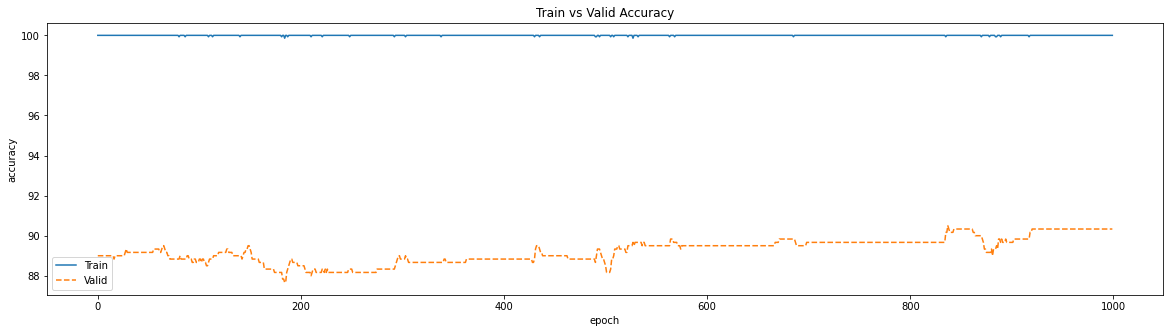

In [65]:
accuracy_plots(train_accu, eval_accu)

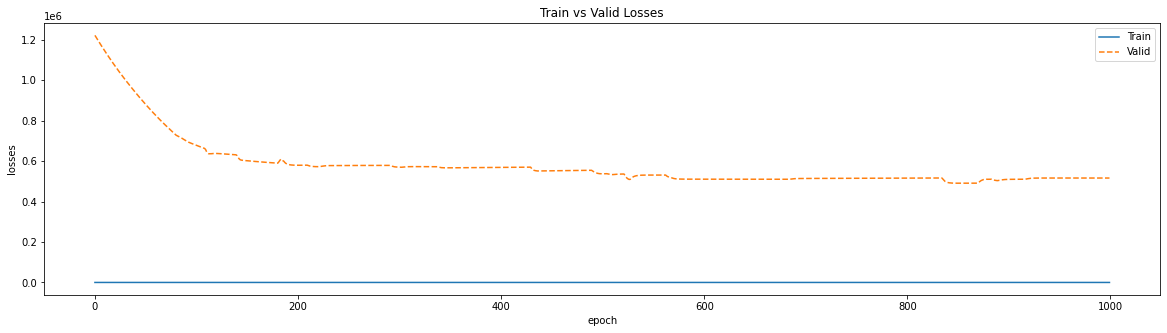

In [66]:
loss_plots(train_losses, eval_losses)

In [67]:
model = model_configs["2"]
model.load_state_dict(torch.load("models/best_model_parameters22.pth"))
model.eval()

model_2(
  (l1): Linear(in_features=784, out_features=400, bias=True)
  (l2): Linear(in_features=400, out_features=200, bias=True)
  (l3): Linear(in_features=200, out_features=10, bias=True)
)

In [68]:
with torch.no_grad():
  predicted_classes = []
  device = torch.device("cpu")
  for data in tqdm(first_five_loader):
    images,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(images)
    _, predicted = torch.max(outputs, 1)
    predicted_classes.append(predicted)

100%|██████████| 5/5 [00:00<00:00, 1305.99it/s]


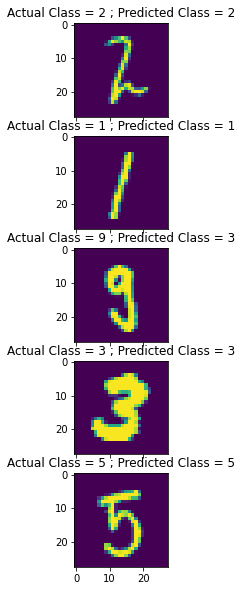

In [69]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for j in range(5):
  axs[j].imshow(first_five_test_images[j][0])
  axs[j].set_title(f"Actual Class = {first_five_test_image_labels[0+j]} ; Predicted Class = {predicted_classes[j].item()}")

for ax in axs.flat:
    ax.label_outer()

# model 2, training config 3:

In [70]:
s = time.time()
eval_losses, train_losses, eval_accu, train_accu = train("2", "3")
e = time.time()

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |   313600   |
|  l1.bias  |    400     |
| l2.weight |   80000    |
|  l2.bias  |    200     |
| l3.weight |    2000    |
|  l3.bias  |     10     |
+-----------+------------+
Total Trainable Params: 396210

Epoch : 1


100%|██████████| 2/2 [00:00<00:00, 125.80it/s]



Epoch : 2


100%|██████████| 2/2 [00:00<00:00, 136.28it/s]



Epoch : 3


100%|██████████| 2/2 [00:00<00:00, 126.17it/s]



Epoch : 4


100%|██████████| 2/2 [00:00<00:00, 123.75it/s]



Epoch : 5


100%|██████████| 2/2 [00:00<00:00, 125.66it/s]



Epoch : 6


100%|██████████| 2/2 [00:00<00:00, 146.79it/s]



Epoch : 7


100%|██████████| 2/2 [00:00<00:00, 127.61it/s]



Epoch : 8


100%|██████████| 2/2 [00:00<00:00, 87.88it/s]



Epoch : 9


100%|██████████| 2/2 [00:00<00:00, 117.80it/s]



Epoch : 10


100%|██████████| 2/2 [00:00<00:00, 141.22it/s]



Epoch : 11


100%|██████████| 2/2 [00:00<00:00, 130.07it/s]



Epoch : 12


100%|██████████| 2/2 [00:00<00:00, 108.63it/s]



Epoch : 13


100%|██████████| 2/2 [00:00<00:00, 133.56it/s]



Epoch : 14


100%|██████████| 2/2 [00:00<00:00, 102.42it/s]



Epoch : 15


100%|██████████| 2/2 [00:00<00:00, 120.44it/s]



Epoch : 16


100%|██████████| 2/2 [00:00<00:00, 102.87it/s]



Epoch : 17


100%|██████████| 2/2 [00:00<00:00, 108.11it/s]



Epoch : 18


100%|██████████| 2/2 [00:00<00:00, 127.43it/s]



Epoch : 19


100%|██████████| 2/2 [00:00<00:00, 130.52it/s]



Epoch : 20


100%|██████████| 2/2 [00:00<00:00, 100.85it/s]



Epoch : 21


100%|██████████| 2/2 [00:00<00:00, 128.16it/s]



Epoch : 22


100%|██████████| 2/2 [00:00<00:00, 131.09it/s]



Epoch : 23


100%|██████████| 2/2 [00:00<00:00, 132.93it/s]



Epoch : 24


100%|██████████| 2/2 [00:00<00:00, 106.48it/s]



Epoch : 25


100%|██████████| 2/2 [00:00<00:00, 118.57it/s]



Epoch : 26


100%|██████████| 2/2 [00:00<00:00, 117.25it/s]



Epoch : 27


100%|██████████| 2/2 [00:00<00:00, 117.72it/s]



Epoch : 28


100%|██████████| 2/2 [00:00<00:00, 127.47it/s]



Epoch : 29


100%|██████████| 2/2 [00:00<00:00, 123.91it/s]



Epoch : 30


100%|██████████| 2/2 [00:00<00:00, 96.46it/s]



Epoch : 31


100%|██████████| 2/2 [00:00<00:00, 120.15it/s]



Epoch : 32


100%|██████████| 2/2 [00:00<00:00, 120.49it/s]



Epoch : 33


100%|██████████| 2/2 [00:00<00:00, 120.32it/s]



Epoch : 34


100%|██████████| 2/2 [00:00<00:00, 120.28it/s]



Epoch : 35


100%|██████████| 2/2 [00:00<00:00, 119.22it/s]



Epoch : 36


100%|██████████| 2/2 [00:00<00:00, 112.51it/s]



Epoch : 37


100%|██████████| 2/2 [00:00<00:00, 119.08it/s]



Epoch : 38


100%|██████████| 2/2 [00:00<00:00, 90.17it/s]



Epoch : 39


100%|██████████| 2/2 [00:00<00:00, 112.36it/s]



Epoch : 40


100%|██████████| 2/2 [00:00<00:00, 117.28it/s]



Epoch : 41


100%|██████████| 2/2 [00:00<00:00, 104.37it/s]



Epoch : 42


100%|██████████| 2/2 [00:00<00:00, 116.64it/s]



Epoch : 43


100%|██████████| 2/2 [00:00<00:00, 118.66it/s]



Epoch : 44


100%|██████████| 2/2 [00:00<00:00, 115.09it/s]



Epoch : 45


100%|██████████| 2/2 [00:00<00:00, 98.53it/s]



Epoch : 46


100%|██████████| 2/2 [00:00<00:00, 117.46it/s]



Epoch : 47


100%|██████████| 2/2 [00:00<00:00, 112.68it/s]



Epoch : 48


100%|██████████| 2/2 [00:00<00:00, 93.86it/s]



Epoch : 49


100%|██████████| 2/2 [00:00<00:00, 118.75it/s]



Epoch : 50


100%|██████████| 2/2 [00:00<00:00, 98.84it/s]



Epoch : 51


100%|██████████| 2/2 [00:00<00:00, 112.10it/s]



Epoch : 52


100%|██████████| 2/2 [00:00<00:00, 106.89it/s]



Epoch : 53


100%|██████████| 2/2 [00:00<00:00, 120.92it/s]



Epoch : 54


100%|██████████| 2/2 [00:00<00:00, 110.39it/s]



Epoch : 55


100%|██████████| 2/2 [00:00<00:00, 119.14it/s]



Epoch : 56


100%|██████████| 2/2 [00:00<00:00, 114.69it/s]



Epoch : 57


100%|██████████| 2/2 [00:00<00:00, 111.27it/s]



Epoch : 58


100%|██████████| 2/2 [00:00<00:00, 113.99it/s]



Epoch : 59


100%|██████████| 2/2 [00:00<00:00, 110.60it/s]



Epoch : 60


100%|██████████| 2/2 [00:00<00:00, 125.83it/s]



Epoch : 61


100%|██████████| 2/2 [00:00<00:00, 126.71it/s]



Epoch : 62


100%|██████████| 2/2 [00:00<00:00, 92.83it/s]



Epoch : 63


100%|██████████| 2/2 [00:00<00:00, 125.39it/s]



Epoch : 64


100%|██████████| 2/2 [00:00<00:00, 123.67it/s]



Epoch : 65


100%|██████████| 2/2 [00:00<00:00, 127.20it/s]



Epoch : 66


100%|██████████| 2/2 [00:00<00:00, 97.74it/s]



Epoch : 67


100%|██████████| 2/2 [00:00<00:00, 109.10it/s]



Epoch : 68


100%|██████████| 2/2 [00:00<00:00, 114.06it/s]



Epoch : 69


100%|██████████| 2/2 [00:00<00:00, 112.81it/s]



Epoch : 70


100%|██████████| 2/2 [00:00<00:00, 116.42it/s]



Epoch : 71


100%|██████████| 2/2 [00:00<00:00, 102.15it/s]



Epoch : 72


100%|██████████| 2/2 [00:00<00:00, 101.09it/s]



Epoch : 73


100%|██████████| 2/2 [00:00<00:00, 105.73it/s]



Epoch : 74


100%|██████████| 2/2 [00:00<00:00, 118.57it/s]



Epoch : 75


100%|██████████| 2/2 [00:00<00:00, 104.58it/s]



Epoch : 76


100%|██████████| 2/2 [00:00<00:00, 118.89it/s]



Epoch : 77


100%|██████████| 2/2 [00:00<00:00, 123.01it/s]



Epoch : 78


100%|██████████| 2/2 [00:00<00:00, 111.82it/s]



Epoch : 79


100%|██████████| 2/2 [00:00<00:00, 116.44it/s]



Epoch : 80


100%|██████████| 2/2 [00:00<00:00, 108.10it/s]



Epoch : 81


100%|██████████| 2/2 [00:00<00:00, 108.55it/s]



Epoch : 82


100%|██████████| 2/2 [00:00<00:00, 80.94it/s]



Epoch : 83


100%|██████████| 2/2 [00:00<00:00, 125.11it/s]



Epoch : 84


100%|██████████| 2/2 [00:00<00:00, 127.75it/s]



Epoch : 85


100%|██████████| 2/2 [00:00<00:00, 108.20it/s]



Epoch : 86


100%|██████████| 2/2 [00:00<00:00, 103.12it/s]



Epoch : 87


100%|██████████| 2/2 [00:00<00:00, 109.07it/s]



Epoch : 88


100%|██████████| 2/2 [00:00<00:00, 118.22it/s]



Epoch : 89


100%|██████████| 2/2 [00:00<00:00, 104.43it/s]



Epoch : 90


100%|██████████| 2/2 [00:00<00:00, 106.56it/s]



Epoch : 91


100%|██████████| 2/2 [00:00<00:00, 125.47it/s]



Epoch : 92


100%|██████████| 2/2 [00:00<00:00, 107.34it/s]



Epoch : 93


100%|██████████| 2/2 [00:00<00:00, 100.12it/s]



Epoch : 94


100%|██████████| 2/2 [00:00<00:00, 120.24it/s]



Epoch : 95


100%|██████████| 2/2 [00:00<00:00, 125.80it/s]



Epoch : 96


100%|██████████| 2/2 [00:00<00:00, 104.19it/s]



Epoch : 97


100%|██████████| 2/2 [00:00<00:00, 100.67it/s]



Epoch : 98


100%|██████████| 2/2 [00:00<00:00, 117.04it/s]



Epoch : 99


100%|██████████| 2/2 [00:00<00:00, 112.14it/s]



Epoch : 100


100%|██████████| 2/2 [00:00<00:00, 111.49it/s]



Epoch : 101


100%|██████████| 2/2 [00:00<00:00, 109.63it/s]



Epoch : 102


100%|██████████| 2/2 [00:00<00:00, 111.50it/s]



Epoch : 103


100%|██████████| 2/2 [00:00<00:00, 109.70it/s]



Epoch : 104


100%|██████████| 2/2 [00:00<00:00, 98.24it/s]



Epoch : 105


100%|██████████| 2/2 [00:00<00:00, 118.71it/s]



Epoch : 106


100%|██████████| 2/2 [00:00<00:00, 104.11it/s]



Epoch : 107


100%|██████████| 2/2 [00:00<00:00, 104.57it/s]



Epoch : 108


100%|██████████| 2/2 [00:00<00:00, 110.24it/s]



Epoch : 109


100%|██████████| 2/2 [00:00<00:00, 119.45it/s]



Epoch : 110


100%|██████████| 2/2 [00:00<00:00, 120.05it/s]



Epoch : 111


100%|██████████| 2/2 [00:00<00:00, 120.21it/s]



Epoch : 112


100%|██████████| 2/2 [00:00<00:00, 65.11it/s]



Epoch : 113


100%|██████████| 2/2 [00:00<00:00, 83.21it/s]



Epoch : 114


100%|██████████| 2/2 [00:00<00:00, 122.90it/s]



Epoch : 115


100%|██████████| 2/2 [00:00<00:00, 108.22it/s]



Epoch : 116


100%|██████████| 2/2 [00:00<00:00, 112.32it/s]



Epoch : 117


100%|██████████| 2/2 [00:00<00:00, 102.12it/s]



Epoch : 118


100%|██████████| 2/2 [00:00<00:00, 107.65it/s]



Epoch : 119


100%|██████████| 2/2 [00:00<00:00, 94.51it/s]



Epoch : 120


100%|██████████| 2/2 [00:00<00:00, 104.35it/s]



Epoch : 121


100%|██████████| 2/2 [00:00<00:00, 113.51it/s]



Epoch : 122


100%|██████████| 2/2 [00:00<00:00, 117.56it/s]



Epoch : 123


100%|██████████| 2/2 [00:00<00:00, 100.05it/s]



Epoch : 124


100%|██████████| 2/2 [00:00<00:00, 92.07it/s]



Epoch : 125


100%|██████████| 2/2 [00:00<00:00, 106.46it/s]



Epoch : 126


100%|██████████| 2/2 [00:00<00:00, 106.86it/s]



Epoch : 127


100%|██████████| 2/2 [00:00<00:00, 112.97it/s]



Epoch : 128


100%|██████████| 2/2 [00:00<00:00, 111.14it/s]



Epoch : 129


100%|██████████| 2/2 [00:00<00:00, 93.33it/s]



Epoch : 130


100%|██████████| 2/2 [00:00<00:00, 90.41it/s]



Epoch : 131


100%|██████████| 2/2 [00:00<00:00, 102.70it/s]



Epoch : 132


100%|██████████| 2/2 [00:00<00:00, 102.99it/s]



Epoch : 133


100%|██████████| 2/2 [00:00<00:00, 105.60it/s]



Epoch : 134


100%|██████████| 2/2 [00:00<00:00, 121.08it/s]



Epoch : 135


100%|██████████| 2/2 [00:00<00:00, 122.13it/s]



Epoch : 136


100%|██████████| 2/2 [00:00<00:00, 72.82it/s]



Epoch : 137


100%|██████████| 2/2 [00:00<00:00, 114.05it/s]



Epoch : 138


100%|██████████| 2/2 [00:00<00:00, 104.55it/s]



Epoch : 139


100%|██████████| 2/2 [00:00<00:00, 104.67it/s]



Epoch : 140


100%|██████████| 2/2 [00:00<00:00, 90.66it/s]



Epoch : 141


100%|██████████| 2/2 [00:00<00:00, 111.51it/s]



Epoch : 142


100%|██████████| 2/2 [00:00<00:00, 98.54it/s]



Epoch : 143


100%|██████████| 2/2 [00:00<00:00, 105.25it/s]



Epoch : 144


100%|██████████| 2/2 [00:00<00:00, 105.31it/s]



Epoch : 145


100%|██████████| 2/2 [00:00<00:00, 108.75it/s]



Epoch : 146


100%|██████████| 2/2 [00:00<00:00, 108.82it/s]



Epoch : 147


100%|██████████| 2/2 [00:00<00:00, 91.03it/s]



Epoch : 148


100%|██████████| 2/2 [00:00<00:00, 107.05it/s]



Epoch : 149


100%|██████████| 2/2 [00:00<00:00, 106.17it/s]



Epoch : 150


100%|██████████| 2/2 [00:00<00:00, 106.26it/s]



Epoch : 151


100%|██████████| 2/2 [00:00<00:00, 103.07it/s]



Epoch : 152


100%|██████████| 2/2 [00:00<00:00, 92.25it/s]



Epoch : 153


100%|██████████| 2/2 [00:00<00:00, 113.92it/s]



Epoch : 154


100%|██████████| 2/2 [00:00<00:00, 98.14it/s]



Epoch : 155


100%|██████████| 2/2 [00:00<00:00, 106.06it/s]



Epoch : 156


100%|██████████| 2/2 [00:00<00:00, 110.22it/s]



Epoch : 157


100%|██████████| 2/2 [00:00<00:00, 112.05it/s]



Epoch : 158


100%|██████████| 2/2 [00:00<00:00, 101.69it/s]



Epoch : 159


100%|██████████| 2/2 [00:00<00:00, 106.64it/s]



Epoch : 160


100%|██████████| 2/2 [00:00<00:00, 104.63it/s]



Epoch : 161


100%|██████████| 2/2 [00:00<00:00, 106.39it/s]



Epoch : 162


100%|██████████| 2/2 [00:00<00:00, 85.89it/s]



Epoch : 163


100%|██████████| 2/2 [00:00<00:00, 105.89it/s]



Epoch : 164


100%|██████████| 2/2 [00:00<00:00, 107.42it/s]



Epoch : 165


100%|██████████| 2/2 [00:00<00:00, 107.94it/s]



Epoch : 166


100%|██████████| 2/2 [00:00<00:00, 91.73it/s]



Epoch : 167


100%|██████████| 2/2 [00:00<00:00, 106.08it/s]



Epoch : 168


100%|██████████| 2/2 [00:00<00:00, 112.52it/s]



Epoch : 169


100%|██████████| 2/2 [00:00<00:00, 109.05it/s]



Epoch : 170


100%|██████████| 2/2 [00:00<00:00, 125.09it/s]



Epoch : 171


100%|██████████| 2/2 [00:00<00:00, 96.76it/s]



Epoch : 172


100%|██████████| 2/2 [00:00<00:00, 117.94it/s]



Epoch : 173


100%|██████████| 2/2 [00:00<00:00, 107.42it/s]



Epoch : 174


100%|██████████| 2/2 [00:00<00:00, 107.52it/s]



Epoch : 175


100%|██████████| 2/2 [00:00<00:00, 114.18it/s]



Epoch : 176


100%|██████████| 2/2 [00:00<00:00, 104.44it/s]



Epoch : 177


100%|██████████| 2/2 [00:00<00:00, 110.39it/s]



Epoch : 178


100%|██████████| 2/2 [00:00<00:00, 108.28it/s]



Epoch : 179


100%|██████████| 2/2 [00:00<00:00, 86.04it/s]



Epoch : 180


100%|██████████| 2/2 [00:00<00:00, 110.03it/s]



Epoch : 181


100%|██████████| 2/2 [00:00<00:00, 112.04it/s]



Epoch : 182


100%|██████████| 2/2 [00:00<00:00, 103.55it/s]



Epoch : 183


100%|██████████| 2/2 [00:00<00:00, 111.03it/s]



Epoch : 184


100%|██████████| 2/2 [00:00<00:00, 97.14it/s]



Epoch : 185


100%|██████████| 2/2 [00:00<00:00, 101.75it/s]



Epoch : 186


100%|██████████| 2/2 [00:00<00:00, 102.24it/s]



Epoch : 187


100%|██████████| 2/2 [00:00<00:00, 100.34it/s]



Epoch : 188


100%|██████████| 2/2 [00:00<00:00, 104.46it/s]



Epoch : 189


100%|██████████| 2/2 [00:00<00:00, 92.36it/s]



Epoch : 190


100%|██████████| 2/2 [00:00<00:00, 108.54it/s]



Epoch : 191


100%|██████████| 2/2 [00:00<00:00, 106.51it/s]



Epoch : 192


100%|██████████| 2/2 [00:00<00:00, 91.34it/s]



Epoch : 193


100%|██████████| 2/2 [00:00<00:00, 119.97it/s]



Epoch : 194


100%|██████████| 2/2 [00:00<00:00, 100.61it/s]



Epoch : 195


100%|██████████| 2/2 [00:00<00:00, 91.99it/s]



Epoch : 196


100%|██████████| 2/2 [00:00<00:00, 106.53it/s]



Epoch : 197


100%|██████████| 2/2 [00:00<00:00, 120.37it/s]



Epoch : 198


100%|██████████| 2/2 [00:00<00:00, 100.46it/s]



Epoch : 199


100%|██████████| 2/2 [00:00<00:00, 93.12it/s]



Epoch : 200


100%|██████████| 2/2 [00:00<00:00, 95.71it/s]



Epoch : 201


100%|██████████| 2/2 [00:00<00:00, 113.93it/s]



Epoch : 202


100%|██████████| 2/2 [00:00<00:00, 120.20it/s]



Epoch : 203


100%|██████████| 2/2 [00:00<00:00, 89.89it/s]



Epoch : 204


100%|██████████| 2/2 [00:00<00:00, 99.10it/s]



Epoch : 205


100%|██████████| 2/2 [00:00<00:00, 112.55it/s]



Epoch : 206


100%|██████████| 2/2 [00:00<00:00, 102.51it/s]



Epoch : 207


100%|██████████| 2/2 [00:00<00:00, 96.20it/s]



Epoch : 208


100%|██████████| 2/2 [00:00<00:00, 90.04it/s]



Epoch : 209


100%|██████████| 2/2 [00:00<00:00, 116.20it/s]



Epoch : 210


100%|██████████| 2/2 [00:00<00:00, 107.95it/s]



Epoch : 211


100%|██████████| 2/2 [00:00<00:00, 104.73it/s]



Epoch : 212


100%|██████████| 2/2 [00:00<00:00, 116.31it/s]



Epoch : 213


100%|██████████| 2/2 [00:00<00:00, 104.33it/s]



Epoch : 214


100%|██████████| 2/2 [00:00<00:00, 104.97it/s]



Epoch : 215


100%|██████████| 2/2 [00:00<00:00, 102.07it/s]



Epoch : 216


100%|██████████| 2/2 [00:00<00:00, 105.09it/s]



Epoch : 217


100%|██████████| 2/2 [00:00<00:00, 95.52it/s]



Epoch : 218


100%|██████████| 2/2 [00:00<00:00, 103.14it/s]



Epoch : 219


100%|██████████| 2/2 [00:00<00:00, 95.26it/s]



Epoch : 220


100%|██████████| 2/2 [00:00<00:00, 110.97it/s]



Epoch : 221


100%|██████████| 2/2 [00:00<00:00, 85.79it/s]



Epoch : 222


100%|██████████| 2/2 [00:00<00:00, 101.46it/s]



Epoch : 223


100%|██████████| 2/2 [00:00<00:00, 113.29it/s]



Epoch : 224


100%|██████████| 2/2 [00:00<00:00, 102.94it/s]



Epoch : 225


100%|██████████| 2/2 [00:00<00:00, 101.93it/s]



Epoch : 226


100%|██████████| 2/2 [00:00<00:00, 108.96it/s]



Epoch : 227


100%|██████████| 2/2 [00:00<00:00, 100.11it/s]



Epoch : 228


100%|██████████| 2/2 [00:00<00:00, 103.53it/s]



Epoch : 229


100%|██████████| 2/2 [00:00<00:00, 101.41it/s]



Epoch : 230


100%|██████████| 2/2 [00:00<00:00, 103.14it/s]



Epoch : 231


100%|██████████| 2/2 [00:00<00:00, 95.21it/s]



Epoch : 232


100%|██████████| 2/2 [00:00<00:00, 103.94it/s]



Epoch : 233


100%|██████████| 2/2 [00:00<00:00, 100.82it/s]



Epoch : 234


100%|██████████| 2/2 [00:00<00:00, 104.83it/s]



Epoch : 235


100%|██████████| 2/2 [00:00<00:00, 125.49it/s]



Epoch : 236


100%|██████████| 2/2 [00:00<00:00, 92.22it/s]



Epoch : 237


100%|██████████| 2/2 [00:00<00:00, 90.52it/s]



Epoch : 238


100%|██████████| 2/2 [00:00<00:00, 64.89it/s]



Epoch : 239


100%|██████████| 2/2 [00:00<00:00, 88.94it/s]



Epoch : 240


100%|██████████| 2/2 [00:00<00:00, 104.69it/s]



Epoch : 241


100%|██████████| 2/2 [00:00<00:00, 91.52it/s]



Epoch : 242


100%|██████████| 2/2 [00:00<00:00, 98.07it/s]



Epoch : 243


100%|██████████| 2/2 [00:00<00:00, 107.34it/s]



Epoch : 244


100%|██████████| 2/2 [00:00<00:00, 104.68it/s]



Epoch : 245


100%|██████████| 2/2 [00:00<00:00, 96.91it/s]



Epoch : 246


100%|██████████| 2/2 [00:00<00:00, 100.83it/s]



Epoch : 247


100%|██████████| 2/2 [00:00<00:00, 107.09it/s]



Epoch : 248


100%|██████████| 2/2 [00:00<00:00, 107.49it/s]



Epoch : 249


100%|██████████| 2/2 [00:00<00:00, 105.83it/s]



Epoch : 250


100%|██████████| 2/2 [00:00<00:00, 112.12it/s]



Epoch : 251


100%|██████████| 2/2 [00:00<00:00, 106.66it/s]



Epoch : 252


100%|██████████| 2/2 [00:00<00:00, 101.57it/s]



Epoch : 253


100%|██████████| 2/2 [00:00<00:00, 102.51it/s]



Epoch : 254


100%|██████████| 2/2 [00:00<00:00, 101.90it/s]



Epoch : 255


100%|██████████| 2/2 [00:00<00:00, 95.44it/s]



Epoch : 256


100%|██████████| 2/2 [00:00<00:00, 111.10it/s]



Epoch : 257


100%|██████████| 2/2 [00:00<00:00, 98.60it/s]



Epoch : 258


100%|██████████| 2/2 [00:00<00:00, 97.53it/s]



Epoch : 259


100%|██████████| 2/2 [00:00<00:00, 96.04it/s]



Epoch : 260


100%|██████████| 2/2 [00:00<00:00, 99.55it/s]



Epoch : 261


100%|██████████| 2/2 [00:00<00:00, 100.00it/s]



Epoch : 262


100%|██████████| 2/2 [00:00<00:00, 100.84it/s]



Epoch : 263


100%|██████████| 2/2 [00:00<00:00, 103.34it/s]



Epoch : 264


100%|██████████| 2/2 [00:00<00:00, 96.59it/s]



Epoch : 265


100%|██████████| 2/2 [00:00<00:00, 66.39it/s]



Epoch : 266


100%|██████████| 2/2 [00:00<00:00, 113.89it/s]



Epoch : 267


100%|██████████| 2/2 [00:00<00:00, 87.64it/s]



Epoch : 268


100%|██████████| 2/2 [00:00<00:00, 95.04it/s]



Epoch : 269


100%|██████████| 2/2 [00:00<00:00, 105.50it/s]



Epoch : 270


100%|██████████| 2/2 [00:00<00:00, 92.08it/s]



Epoch : 271


100%|██████████| 2/2 [00:00<00:00, 115.01it/s]



Epoch : 272


100%|██████████| 2/2 [00:00<00:00, 103.91it/s]



Epoch : 273


100%|██████████| 2/2 [00:00<00:00, 93.18it/s]



Epoch : 274


100%|██████████| 2/2 [00:00<00:00, 95.73it/s]



Epoch : 275


100%|██████████| 2/2 [00:00<00:00, 93.74it/s]



Epoch : 276


100%|██████████| 2/2 [00:00<00:00, 93.00it/s]



Epoch : 277


100%|██████████| 2/2 [00:00<00:00, 86.03it/s]



Epoch : 278


100%|██████████| 2/2 [00:00<00:00, 104.18it/s]



Epoch : 279


100%|██████████| 2/2 [00:00<00:00, 94.43it/s]



Epoch : 280


100%|██████████| 2/2 [00:00<00:00, 92.64it/s]



Epoch : 281


100%|██████████| 2/2 [00:00<00:00, 118.91it/s]



Epoch : 282


100%|██████████| 2/2 [00:00<00:00, 113.62it/s]



Epoch : 283


100%|██████████| 2/2 [00:00<00:00, 110.21it/s]



Epoch : 284


100%|██████████| 2/2 [00:00<00:00, 95.77it/s]



Epoch : 285


100%|██████████| 2/2 [00:00<00:00, 85.05it/s]



Epoch : 286


100%|██████████| 2/2 [00:00<00:00, 98.11it/s]



Epoch : 287


100%|██████████| 2/2 [00:00<00:00, 96.52it/s]



Epoch : 288


100%|██████████| 2/2 [00:00<00:00, 86.75it/s]



Epoch : 289


100%|██████████| 2/2 [00:00<00:00, 99.71it/s]



Epoch : 290


100%|██████████| 2/2 [00:00<00:00, 64.76it/s]



Epoch : 291


100%|██████████| 2/2 [00:00<00:00, 112.31it/s]



Epoch : 292


100%|██████████| 2/2 [00:00<00:00, 101.33it/s]



Epoch : 293


100%|██████████| 2/2 [00:00<00:00, 131.73it/s]



Epoch : 294


100%|██████████| 2/2 [00:00<00:00, 112.41it/s]



Epoch : 295


100%|██████████| 2/2 [00:00<00:00, 100.30it/s]



Epoch : 296


100%|██████████| 2/2 [00:00<00:00, 105.58it/s]



Epoch : 297


100%|██████████| 2/2 [00:00<00:00, 96.25it/s]



Epoch : 298


100%|██████████| 2/2 [00:00<00:00, 93.60it/s]



Epoch : 299


100%|██████████| 2/2 [00:00<00:00, 96.11it/s]



Epoch : 300


100%|██████████| 2/2 [00:00<00:00, 96.06it/s]



Epoch : 301


100%|██████████| 2/2 [00:00<00:00, 96.97it/s]



Epoch : 302


100%|██████████| 2/2 [00:00<00:00, 94.26it/s]



Epoch : 303


100%|██████████| 2/2 [00:00<00:00, 94.46it/s]



Epoch : 304


100%|██████████| 2/2 [00:00<00:00, 98.48it/s]



Epoch : 305


100%|██████████| 2/2 [00:00<00:00, 100.09it/s]



Epoch : 306


100%|██████████| 2/2 [00:00<00:00, 97.51it/s]



Epoch : 307


100%|██████████| 2/2 [00:00<00:00, 96.71it/s]



Epoch : 308


100%|██████████| 2/2 [00:00<00:00, 105.67it/s]



Epoch : 309


100%|██████████| 2/2 [00:00<00:00, 101.19it/s]



Epoch : 310


100%|██████████| 2/2 [00:00<00:00, 95.17it/s]



Epoch : 311


100%|██████████| 2/2 [00:00<00:00, 93.42it/s]



Epoch : 312


100%|██████████| 2/2 [00:00<00:00, 102.65it/s]



Epoch : 313


100%|██████████| 2/2 [00:00<00:00, 91.00it/s]



Epoch : 314


100%|██████████| 2/2 [00:00<00:00, 94.46it/s]



Epoch : 315


100%|██████████| 2/2 [00:00<00:00, 102.16it/s]



Epoch : 316


100%|██████████| 2/2 [00:00<00:00, 91.28it/s]



Epoch : 317


100%|██████████| 2/2 [00:00<00:00, 105.84it/s]



Epoch : 318


100%|██████████| 2/2 [00:00<00:00, 95.03it/s]



Epoch : 319


100%|██████████| 2/2 [00:00<00:00, 94.54it/s]



Epoch : 320


100%|██████████| 2/2 [00:00<00:00, 96.09it/s]



Epoch : 321


100%|██████████| 2/2 [00:00<00:00, 92.59it/s]



Epoch : 322


100%|██████████| 2/2 [00:00<00:00, 103.07it/s]



Epoch : 323


100%|██████████| 2/2 [00:00<00:00, 95.90it/s]



Epoch : 324


100%|██████████| 2/2 [00:00<00:00, 97.53it/s]



Epoch : 325


100%|██████████| 2/2 [00:00<00:00, 78.09it/s]



Epoch : 326


100%|██████████| 2/2 [00:00<00:00, 117.57it/s]



Epoch : 327


100%|██████████| 2/2 [00:00<00:00, 87.83it/s]



Epoch : 328


100%|██████████| 2/2 [00:00<00:00, 99.49it/s]



Epoch : 329


100%|██████████| 2/2 [00:00<00:00, 93.30it/s]



Epoch : 330


100%|██████████| 2/2 [00:00<00:00, 95.09it/s]



Epoch : 331


100%|██████████| 2/2 [00:00<00:00, 89.56it/s]



Epoch : 332


100%|██████████| 2/2 [00:00<00:00, 97.92it/s]



Epoch : 333


100%|██████████| 2/2 [00:00<00:00, 96.53it/s]



Epoch : 334


100%|██████████| 2/2 [00:00<00:00, 81.28it/s]



Epoch : 335


100%|██████████| 2/2 [00:00<00:00, 102.06it/s]



Epoch : 336


100%|██████████| 2/2 [00:00<00:00, 101.28it/s]



Epoch : 337


100%|██████████| 2/2 [00:00<00:00, 95.83it/s]



Epoch : 338


100%|██████████| 2/2 [00:00<00:00, 101.59it/s]



Epoch : 339


100%|██████████| 2/2 [00:00<00:00, 95.59it/s]



Epoch : 340


100%|██████████| 2/2 [00:00<00:00, 101.66it/s]



Epoch : 341


100%|██████████| 2/2 [00:00<00:00, 125.66it/s]



Epoch : 342


100%|██████████| 2/2 [00:00<00:00, 85.25it/s]



Epoch : 343


100%|██████████| 2/2 [00:00<00:00, 90.16it/s]



Epoch : 344


100%|██████████| 2/2 [00:00<00:00, 74.95it/s]



Epoch : 345


100%|██████████| 2/2 [00:00<00:00, 99.24it/s]



Epoch : 346


100%|██████████| 2/2 [00:00<00:00, 97.41it/s]



Epoch : 347


100%|██████████| 2/2 [00:00<00:00, 87.32it/s]



Epoch : 348


100%|██████████| 2/2 [00:00<00:00, 96.39it/s]



Epoch : 349


100%|██████████| 2/2 [00:00<00:00, 83.99it/s]



Epoch : 350


100%|██████████| 2/2 [00:00<00:00, 87.98it/s]



Epoch : 351


100%|██████████| 2/2 [00:00<00:00, 90.54it/s]



Epoch : 352


100%|██████████| 2/2 [00:00<00:00, 94.15it/s]



Epoch : 353


100%|██████████| 2/2 [00:00<00:00, 109.74it/s]



Epoch : 354


100%|██████████| 2/2 [00:00<00:00, 115.46it/s]



Epoch : 355


100%|██████████| 2/2 [00:00<00:00, 72.01it/s]



Epoch : 356


100%|██████████| 2/2 [00:00<00:00, 96.32it/s]



Epoch : 357


100%|██████████| 2/2 [00:00<00:00, 95.34it/s]



Epoch : 358


100%|██████████| 2/2 [00:00<00:00, 92.85it/s]



Epoch : 359


100%|██████████| 2/2 [00:00<00:00, 108.08it/s]



Epoch : 360


100%|██████████| 2/2 [00:00<00:00, 88.80it/s]



Epoch : 361


100%|██████████| 2/2 [00:00<00:00, 92.28it/s]



Epoch : 362


100%|██████████| 2/2 [00:00<00:00, 96.36it/s]



Epoch : 363


100%|██████████| 2/2 [00:00<00:00, 104.44it/s]



Epoch : 364


100%|██████████| 2/2 [00:00<00:00, 66.78it/s]



Epoch : 365


100%|██████████| 2/2 [00:00<00:00, 93.12it/s]



Epoch : 366


100%|██████████| 2/2 [00:00<00:00, 92.96it/s]



Epoch : 367


100%|██████████| 2/2 [00:00<00:00, 99.85it/s]



Epoch : 368


100%|██████████| 2/2 [00:00<00:00, 104.12it/s]



Epoch : 369


100%|██████████| 2/2 [00:00<00:00, 134.03it/s]



Epoch : 370


100%|██████████| 2/2 [00:00<00:00, 88.06it/s]



Epoch : 371


100%|██████████| 2/2 [00:00<00:00, 100.69it/s]



Epoch : 372


100%|██████████| 2/2 [00:00<00:00, 100.98it/s]



Epoch : 373


100%|██████████| 2/2 [00:00<00:00, 91.71it/s]



Epoch : 374


100%|██████████| 2/2 [00:00<00:00, 86.16it/s]



Epoch : 375


100%|██████████| 2/2 [00:00<00:00, 104.88it/s]



Epoch : 376


100%|██████████| 2/2 [00:00<00:00, 92.64it/s]



Epoch : 377


100%|██████████| 2/2 [00:00<00:00, 97.26it/s]



Epoch : 378


100%|██████████| 2/2 [00:00<00:00, 89.47it/s]



Epoch : 379


100%|██████████| 2/2 [00:00<00:00, 99.96it/s]



Epoch : 380


100%|██████████| 2/2 [00:00<00:00, 111.14it/s]



Epoch : 381


100%|██████████| 2/2 [00:00<00:00, 94.52it/s]



Epoch : 382


100%|██████████| 2/2 [00:00<00:00, 88.46it/s]



Epoch : 383


100%|██████████| 2/2 [00:00<00:00, 94.65it/s]



Epoch : 384


100%|██████████| 2/2 [00:00<00:00, 100.69it/s]



Epoch : 385


100%|██████████| 2/2 [00:00<00:00, 90.31it/s]



Epoch : 386


100%|██████████| 2/2 [00:00<00:00, 101.61it/s]



Epoch : 387


100%|██████████| 2/2 [00:00<00:00, 131.50it/s]



Epoch : 388


100%|██████████| 2/2 [00:00<00:00, 115.65it/s]



Epoch : 389


100%|██████████| 2/2 [00:00<00:00, 97.12it/s]



Epoch : 390


100%|██████████| 2/2 [00:00<00:00, 94.51it/s]



Epoch : 391


100%|██████████| 2/2 [00:00<00:00, 99.26it/s]



Epoch : 392


100%|██████████| 2/2 [00:00<00:00, 100.65it/s]



Epoch : 393


100%|██████████| 2/2 [00:00<00:00, 97.38it/s]



Epoch : 394


100%|██████████| 2/2 [00:00<00:00, 101.31it/s]



Epoch : 395


100%|██████████| 2/2 [00:00<00:00, 90.74it/s]



Epoch : 396


100%|██████████| 2/2 [00:00<00:00, 93.39it/s]



Epoch : 397


100%|██████████| 2/2 [00:00<00:00, 92.19it/s]



Epoch : 398


100%|██████████| 2/2 [00:00<00:00, 94.57it/s]



Epoch : 399


100%|██████████| 2/2 [00:00<00:00, 85.29it/s]



Epoch : 400


100%|██████████| 2/2 [00:00<00:00, 99.39it/s]



Epoch : 401


100%|██████████| 2/2 [00:00<00:00, 93.42it/s]



Epoch : 402


100%|██████████| 2/2 [00:00<00:00, 77.35it/s]



Epoch : 403


100%|██████████| 2/2 [00:00<00:00, 91.45it/s]



Epoch : 404


100%|██████████| 2/2 [00:00<00:00, 82.36it/s]



Epoch : 405


100%|██████████| 2/2 [00:00<00:00, 105.84it/s]



Epoch : 406


100%|██████████| 2/2 [00:00<00:00, 86.75it/s]



Epoch : 407


100%|██████████| 2/2 [00:00<00:00, 95.99it/s]



Epoch : 408


100%|██████████| 2/2 [00:00<00:00, 118.83it/s]



Epoch : 409


100%|██████████| 2/2 [00:00<00:00, 90.36it/s]



Epoch : 410


100%|██████████| 2/2 [00:00<00:00, 95.98it/s]



Epoch : 411


100%|██████████| 2/2 [00:00<00:00, 99.92it/s]



Epoch : 412


100%|██████████| 2/2 [00:00<00:00, 93.04it/s]



Epoch : 413


100%|██████████| 2/2 [00:00<00:00, 94.29it/s]



Epoch : 414


100%|██████████| 2/2 [00:00<00:00, 99.25it/s]



Epoch : 415


100%|██████████| 2/2 [00:00<00:00, 100.50it/s]



Epoch : 416


100%|██████████| 2/2 [00:00<00:00, 97.37it/s]



Epoch : 417


100%|██████████| 2/2 [00:00<00:00, 101.08it/s]



Epoch : 418


100%|██████████| 2/2 [00:00<00:00, 97.70it/s]



Epoch : 419


100%|██████████| 2/2 [00:00<00:00, 89.03it/s]



Epoch : 420


100%|██████████| 2/2 [00:00<00:00, 98.96it/s]



Epoch : 421


100%|██████████| 2/2 [00:00<00:00, 116.23it/s]



Epoch : 422


100%|██████████| 2/2 [00:00<00:00, 94.52it/s]



Epoch : 423


100%|██████████| 2/2 [00:00<00:00, 89.70it/s]



Epoch : 424


100%|██████████| 2/2 [00:00<00:00, 94.13it/s]



Epoch : 425


100%|██████████| 2/2 [00:00<00:00, 93.72it/s]



Epoch : 426


100%|██████████| 2/2 [00:00<00:00, 102.32it/s]



Epoch : 427


100%|██████████| 2/2 [00:00<00:00, 110.24it/s]



Epoch : 428


100%|██████████| 2/2 [00:00<00:00, 94.15it/s]



Epoch : 429


100%|██████████| 2/2 [00:00<00:00, 108.04it/s]



Epoch : 430


100%|██████████| 2/2 [00:00<00:00, 93.09it/s]



Epoch : 431


100%|██████████| 2/2 [00:00<00:00, 98.15it/s]



Epoch : 432


100%|██████████| 2/2 [00:00<00:00, 77.77it/s]



Epoch : 433


100%|██████████| 2/2 [00:00<00:00, 100.37it/s]



Epoch : 434


100%|██████████| 2/2 [00:00<00:00, 90.21it/s]



Epoch : 435


100%|██████████| 2/2 [00:00<00:00, 90.84it/s]



Epoch : 436


100%|██████████| 2/2 [00:00<00:00, 105.62it/s]



Epoch : 437


100%|██████████| 2/2 [00:00<00:00, 105.80it/s]



Epoch : 438


100%|██████████| 2/2 [00:00<00:00, 86.68it/s]



Epoch : 439


100%|██████████| 2/2 [00:00<00:00, 100.00it/s]



Epoch : 440


100%|██████████| 2/2 [00:00<00:00, 82.42it/s]



Epoch : 441


100%|██████████| 2/2 [00:00<00:00, 93.74it/s]



Epoch : 442


100%|██████████| 2/2 [00:00<00:00, 92.00it/s]



Epoch : 443


100%|██████████| 2/2 [00:00<00:00, 79.33it/s]



Epoch : 444


100%|██████████| 2/2 [00:00<00:00, 97.72it/s]



Epoch : 445


100%|██████████| 2/2 [00:00<00:00, 93.49it/s]



Epoch : 446


100%|██████████| 2/2 [00:00<00:00, 100.13it/s]



Epoch : 447


100%|██████████| 2/2 [00:00<00:00, 66.10it/s]



Epoch : 448


100%|██████████| 2/2 [00:00<00:00, 100.71it/s]



Epoch : 449


100%|██████████| 2/2 [00:00<00:00, 135.88it/s]



Epoch : 450


100%|██████████| 2/2 [00:00<00:00, 100.83it/s]



Epoch : 451


100%|██████████| 2/2 [00:00<00:00, 97.91it/s]



Epoch : 452


100%|██████████| 2/2 [00:00<00:00, 100.79it/s]



Epoch : 453


100%|██████████| 2/2 [00:00<00:00, 108.47it/s]



Epoch : 454


100%|██████████| 2/2 [00:00<00:00, 96.37it/s]



Epoch : 455


100%|██████████| 2/2 [00:00<00:00, 84.78it/s]



Epoch : 456


100%|██████████| 2/2 [00:00<00:00, 90.61it/s]



Epoch : 457


100%|██████████| 2/2 [00:00<00:00, 100.70it/s]



Epoch : 458


100%|██████████| 2/2 [00:00<00:00, 85.57it/s]



Epoch : 459


100%|██████████| 2/2 [00:00<00:00, 98.81it/s]



Epoch : 460


100%|██████████| 2/2 [00:00<00:00, 96.25it/s]



Epoch : 461


100%|██████████| 2/2 [00:00<00:00, 99.80it/s]



Epoch : 462


100%|██████████| 2/2 [00:00<00:00, 114.21it/s]



Epoch : 463


100%|██████████| 2/2 [00:00<00:00, 80.59it/s]



Epoch : 464


100%|██████████| 2/2 [00:00<00:00, 86.05it/s]



Epoch : 465


100%|██████████| 2/2 [00:00<00:00, 95.11it/s]



Epoch : 466


100%|██████████| 2/2 [00:00<00:00, 104.27it/s]



Epoch : 467


100%|██████████| 2/2 [00:00<00:00, 97.78it/s]



Epoch : 468


100%|██████████| 2/2 [00:00<00:00, 107.49it/s]



Epoch : 469


100%|██████████| 2/2 [00:00<00:00, 91.42it/s]



Epoch : 470


100%|██████████| 2/2 [00:00<00:00, 98.86it/s]



Epoch : 471


100%|██████████| 2/2 [00:00<00:00, 108.07it/s]



Epoch : 472


100%|██████████| 2/2 [00:00<00:00, 90.09it/s]



Epoch : 473


100%|██████████| 2/2 [00:00<00:00, 92.08it/s]



Epoch : 474


100%|██████████| 2/2 [00:00<00:00, 82.31it/s]



Epoch : 475


100%|██████████| 2/2 [00:00<00:00, 95.10it/s]



Epoch : 476


100%|██████████| 2/2 [00:00<00:00, 100.40it/s]



Epoch : 477


100%|██████████| 2/2 [00:00<00:00, 111.36it/s]



Epoch : 478


100%|██████████| 2/2 [00:00<00:00, 92.61it/s]



Epoch : 479


100%|██████████| 2/2 [00:00<00:00, 96.10it/s]



Epoch : 480


100%|██████████| 2/2 [00:00<00:00, 89.77it/s]



Epoch : 481


100%|██████████| 2/2 [00:00<00:00, 110.52it/s]



Epoch : 482


100%|██████████| 2/2 [00:00<00:00, 108.58it/s]



Epoch : 483


100%|██████████| 2/2 [00:00<00:00, 91.16it/s]



Epoch : 484


100%|██████████| 2/2 [00:00<00:00, 92.30it/s]



Epoch : 485


100%|██████████| 2/2 [00:00<00:00, 95.66it/s]



Epoch : 486


100%|██████████| 2/2 [00:00<00:00, 114.67it/s]



Epoch : 487


100%|██████████| 2/2 [00:00<00:00, 93.69it/s]



Epoch : 488


100%|██████████| 2/2 [00:00<00:00, 97.26it/s]



Epoch : 489


100%|██████████| 2/2 [00:00<00:00, 96.15it/s]



Epoch : 490


100%|██████████| 2/2 [00:00<00:00, 91.01it/s]



Epoch : 491


100%|██████████| 2/2 [00:00<00:00, 97.97it/s]



Epoch : 492


100%|██████████| 2/2 [00:00<00:00, 94.25it/s]



Epoch : 493


100%|██████████| 2/2 [00:00<00:00, 87.27it/s]



Epoch : 494


100%|██████████| 2/2 [00:00<00:00, 102.76it/s]



Epoch : 495


100%|██████████| 2/2 [00:00<00:00, 88.66it/s]



Epoch : 496


100%|██████████| 2/2 [00:00<00:00, 86.72it/s]



Epoch : 497


100%|██████████| 2/2 [00:00<00:00, 92.86it/s]



Epoch : 498


100%|██████████| 2/2 [00:00<00:00, 85.57it/s]



Epoch : 499


100%|██████████| 2/2 [00:00<00:00, 88.13it/s]



Epoch : 500


100%|██████████| 2/2 [00:00<00:00, 60.86it/s]



Epoch : 501


100%|██████████| 2/2 [00:00<00:00, 94.43it/s]



Epoch : 502


100%|██████████| 2/2 [00:00<00:00, 101.53it/s]



Epoch : 503


100%|██████████| 2/2 [00:00<00:00, 79.71it/s]



Epoch : 504


100%|██████████| 2/2 [00:00<00:00, 88.00it/s]



Epoch : 505


100%|██████████| 2/2 [00:00<00:00, 85.86it/s]



Epoch : 506


100%|██████████| 2/2 [00:00<00:00, 86.83it/s]



Epoch : 507


100%|██████████| 2/2 [00:00<00:00, 95.35it/s]



Epoch : 508


100%|██████████| 2/2 [00:00<00:00, 85.32it/s]



Epoch : 509


100%|██████████| 2/2 [00:00<00:00, 93.93it/s]



Epoch : 510


100%|██████████| 2/2 [00:00<00:00, 85.48it/s]



Epoch : 511


100%|██████████| 2/2 [00:00<00:00, 85.22it/s]



Epoch : 512


100%|██████████| 2/2 [00:00<00:00, 85.84it/s]



Epoch : 513


100%|██████████| 2/2 [00:00<00:00, 91.23it/s]



Epoch : 514


100%|██████████| 2/2 [00:00<00:00, 90.70it/s]



Epoch : 515


100%|██████████| 2/2 [00:00<00:00, 77.54it/s]



Epoch : 516


100%|██████████| 2/2 [00:00<00:00, 85.05it/s]



Epoch : 517


100%|██████████| 2/2 [00:00<00:00, 84.64it/s]



Epoch : 518


100%|██████████| 2/2 [00:00<00:00, 85.10it/s]



Epoch : 519


100%|██████████| 2/2 [00:00<00:00, 92.01it/s]



Epoch : 520


100%|██████████| 2/2 [00:00<00:00, 82.98it/s]



Epoch : 521


100%|██████████| 2/2 [00:00<00:00, 80.36it/s]



Epoch : 522


100%|██████████| 2/2 [00:00<00:00, 79.29it/s]



Epoch : 523


100%|██████████| 2/2 [00:00<00:00, 67.97it/s]



Epoch : 524


100%|██████████| 2/2 [00:00<00:00, 95.66it/s]



Epoch : 525


100%|██████████| 2/2 [00:00<00:00, 89.90it/s]



Epoch : 526


100%|██████████| 2/2 [00:00<00:00, 81.83it/s]



Epoch : 527


100%|██████████| 2/2 [00:00<00:00, 94.46it/s]



Epoch : 528


100%|██████████| 2/2 [00:00<00:00, 82.65it/s]



Epoch : 529


100%|██████████| 2/2 [00:00<00:00, 87.92it/s]



Epoch : 530


100%|██████████| 2/2 [00:00<00:00, 90.03it/s]



Epoch : 531


100%|██████████| 2/2 [00:00<00:00, 87.22it/s]



Epoch : 532


100%|██████████| 2/2 [00:00<00:00, 91.21it/s]



Epoch : 533


100%|██████████| 2/2 [00:00<00:00, 89.44it/s]



Epoch : 534


100%|██████████| 2/2 [00:00<00:00, 90.46it/s]



Epoch : 535


100%|██████████| 2/2 [00:00<00:00, 88.46it/s]



Epoch : 536


100%|██████████| 2/2 [00:00<00:00, 92.69it/s]



Epoch : 537


100%|██████████| 2/2 [00:00<00:00, 91.13it/s]



Epoch : 538


100%|██████████| 2/2 [00:00<00:00, 83.18it/s]



Epoch : 539


100%|██████████| 2/2 [00:00<00:00, 83.84it/s]



Epoch : 540


100%|██████████| 2/2 [00:00<00:00, 91.95it/s]



Epoch : 541


100%|██████████| 2/2 [00:00<00:00, 78.24it/s]



Epoch : 542


100%|██████████| 2/2 [00:00<00:00, 94.44it/s]



Epoch : 543


100%|██████████| 2/2 [00:00<00:00, 91.14it/s]



Epoch : 544


100%|██████████| 2/2 [00:00<00:00, 91.59it/s]



Epoch : 545


100%|██████████| 2/2 [00:00<00:00, 84.99it/s]



Epoch : 546


100%|██████████| 2/2 [00:00<00:00, 81.01it/s]



Epoch : 547


100%|██████████| 2/2 [00:00<00:00, 98.54it/s]



Epoch : 548


100%|██████████| 2/2 [00:00<00:00, 88.54it/s]



Epoch : 549


100%|██████████| 2/2 [00:00<00:00, 75.55it/s]



Epoch : 550


100%|██████████| 2/2 [00:00<00:00, 74.03it/s]



Epoch : 551


100%|██████████| 2/2 [00:00<00:00, 85.37it/s]



Epoch : 552


100%|██████████| 2/2 [00:00<00:00, 80.90it/s]



Epoch : 553


100%|██████████| 2/2 [00:00<00:00, 79.63it/s]



Epoch : 554


100%|██████████| 2/2 [00:00<00:00, 89.46it/s]



Epoch : 555


100%|██████████| 2/2 [00:00<00:00, 101.55it/s]



Epoch : 556


100%|██████████| 2/2 [00:00<00:00, 87.56it/s]



Epoch : 557


100%|██████████| 2/2 [00:00<00:00, 75.24it/s]



Epoch : 558


100%|██████████| 2/2 [00:00<00:00, 87.15it/s]



Epoch : 559


100%|██████████| 2/2 [00:00<00:00, 84.07it/s]



Epoch : 560


100%|██████████| 2/2 [00:00<00:00, 107.11it/s]



Epoch : 561


100%|██████████| 2/2 [00:00<00:00, 84.04it/s]



Epoch : 562


100%|██████████| 2/2 [00:00<00:00, 86.62it/s]



Epoch : 563


100%|██████████| 2/2 [00:00<00:00, 90.44it/s]



Epoch : 564


100%|██████████| 2/2 [00:00<00:00, 89.22it/s]



Epoch : 565


100%|██████████| 2/2 [00:00<00:00, 73.38it/s]



Epoch : 566


100%|██████████| 2/2 [00:00<00:00, 98.55it/s]



Epoch : 567


100%|██████████| 2/2 [00:00<00:00, 89.11it/s]



Epoch : 568


100%|██████████| 2/2 [00:00<00:00, 86.24it/s]



Epoch : 569


100%|██████████| 2/2 [00:00<00:00, 92.92it/s]



Epoch : 570


100%|██████████| 2/2 [00:00<00:00, 97.73it/s]



Epoch : 571


100%|██████████| 2/2 [00:00<00:00, 82.04it/s]



Epoch : 572


100%|██████████| 2/2 [00:00<00:00, 82.25it/s]



Epoch : 573


100%|██████████| 2/2 [00:00<00:00, 60.51it/s]



Epoch : 574


100%|██████████| 2/2 [00:00<00:00, 90.93it/s]



Epoch : 575


100%|██████████| 2/2 [00:00<00:00, 89.84it/s]



Epoch : 576


100%|██████████| 2/2 [00:00<00:00, 85.59it/s]



Epoch : 577


100%|██████████| 2/2 [00:00<00:00, 78.97it/s]



Epoch : 578


100%|██████████| 2/2 [00:00<00:00, 90.16it/s]



Epoch : 579


100%|██████████| 2/2 [00:00<00:00, 95.69it/s]



Epoch : 580


100%|██████████| 2/2 [00:00<00:00, 95.56it/s]



Epoch : 581


100%|██████████| 2/2 [00:00<00:00, 77.02it/s]



Epoch : 582


100%|██████████| 2/2 [00:00<00:00, 101.03it/s]



Epoch : 583


100%|██████████| 2/2 [00:00<00:00, 86.46it/s]



Epoch : 584


100%|██████████| 2/2 [00:00<00:00, 91.88it/s]



Epoch : 585


100%|██████████| 2/2 [00:00<00:00, 88.38it/s]



Epoch : 586


100%|██████████| 2/2 [00:00<00:00, 90.56it/s]



Epoch : 587


100%|██████████| 2/2 [00:00<00:00, 89.35it/s]



Epoch : 588


100%|██████████| 2/2 [00:00<00:00, 90.15it/s]



Epoch : 589


100%|██████████| 2/2 [00:00<00:00, 82.66it/s]



Epoch : 590


100%|██████████| 2/2 [00:00<00:00, 87.83it/s]



Epoch : 591


100%|██████████| 2/2 [00:00<00:00, 89.78it/s]



Epoch : 592


100%|██████████| 2/2 [00:00<00:00, 97.58it/s]



Epoch : 593


100%|██████████| 2/2 [00:00<00:00, 84.86it/s]



Epoch : 594


100%|██████████| 2/2 [00:00<00:00, 98.79it/s]



Epoch : 595


100%|██████████| 2/2 [00:00<00:00, 84.18it/s]



Epoch : 596


100%|██████████| 2/2 [00:00<00:00, 90.27it/s]



Epoch : 597


100%|██████████| 2/2 [00:00<00:00, 87.76it/s]



Epoch : 598


100%|██████████| 2/2 [00:00<00:00, 86.75it/s]



Epoch : 599


100%|██████████| 2/2 [00:00<00:00, 76.95it/s]



Epoch : 600


100%|██████████| 2/2 [00:00<00:00, 103.48it/s]



Epoch : 601


100%|██████████| 2/2 [00:00<00:00, 82.91it/s]



Epoch : 602


100%|██████████| 2/2 [00:00<00:00, 88.71it/s]



Epoch : 603


100%|██████████| 2/2 [00:00<00:00, 68.81it/s]



Epoch : 604


100%|██████████| 2/2 [00:00<00:00, 86.17it/s]



Epoch : 605


100%|██████████| 2/2 [00:00<00:00, 91.42it/s]



Epoch : 606


100%|██████████| 2/2 [00:00<00:00, 87.69it/s]



Epoch : 607


100%|██████████| 2/2 [00:00<00:00, 87.96it/s]



Epoch : 608


100%|██████████| 2/2 [00:00<00:00, 77.83it/s]



Epoch : 609


100%|██████████| 2/2 [00:00<00:00, 87.57it/s]



Epoch : 610


100%|██████████| 2/2 [00:00<00:00, 75.90it/s]



Epoch : 611


100%|██████████| 2/2 [00:00<00:00, 94.44it/s]



Epoch : 612


100%|██████████| 2/2 [00:00<00:00, 91.07it/s]



Epoch : 613


100%|██████████| 2/2 [00:00<00:00, 84.40it/s]



Epoch : 614


100%|██████████| 2/2 [00:00<00:00, 88.71it/s]



Epoch : 615


100%|██████████| 2/2 [00:00<00:00, 91.22it/s]



Epoch : 616


100%|██████████| 2/2 [00:00<00:00, 86.73it/s]



Epoch : 617


100%|██████████| 2/2 [00:00<00:00, 86.75it/s]



Epoch : 618


100%|██████████| 2/2 [00:00<00:00, 81.88it/s]



Epoch : 619


100%|██████████| 2/2 [00:00<00:00, 91.54it/s]



Epoch : 620


100%|██████████| 2/2 [00:00<00:00, 87.62it/s]



Epoch : 621


100%|██████████| 2/2 [00:00<00:00, 95.68it/s]



Epoch : 622


100%|██████████| 2/2 [00:00<00:00, 78.89it/s]



Epoch : 623


100%|██████████| 2/2 [00:00<00:00, 73.00it/s]



Epoch : 624


100%|██████████| 2/2 [00:00<00:00, 88.87it/s]



Epoch : 625


100%|██████████| 2/2 [00:00<00:00, 79.59it/s]



Epoch : 626


100%|██████████| 2/2 [00:00<00:00, 90.11it/s]



Epoch : 627


100%|██████████| 2/2 [00:00<00:00, 87.30it/s]



Epoch : 628


100%|██████████| 2/2 [00:00<00:00, 63.77it/s]



Epoch : 629


100%|██████████| 2/2 [00:00<00:00, 85.14it/s]



Epoch : 630


100%|██████████| 2/2 [00:00<00:00, 117.44it/s]



Epoch : 631


100%|██████████| 2/2 [00:00<00:00, 86.70it/s]



Epoch : 632


100%|██████████| 2/2 [00:00<00:00, 89.19it/s]



Epoch : 633


100%|██████████| 2/2 [00:00<00:00, 89.96it/s]



Epoch : 634


100%|██████████| 2/2 [00:00<00:00, 69.52it/s]



Epoch : 635


100%|██████████| 2/2 [00:00<00:00, 68.67it/s]



Epoch : 636


100%|██████████| 2/2 [00:00<00:00, 81.63it/s]



Epoch : 637


100%|██████████| 2/2 [00:00<00:00, 89.45it/s]



Epoch : 638


100%|██████████| 2/2 [00:00<00:00, 87.61it/s]



Epoch : 639


100%|██████████| 2/2 [00:00<00:00, 82.61it/s]



Epoch : 640


100%|██████████| 2/2 [00:00<00:00, 79.58it/s]



Epoch : 641


100%|██████████| 2/2 [00:00<00:00, 53.92it/s]



Epoch : 642


100%|██████████| 2/2 [00:00<00:00, 85.37it/s]



Epoch : 643


100%|██████████| 2/2 [00:00<00:00, 98.99it/s]



Epoch : 644


100%|██████████| 2/2 [00:00<00:00, 101.30it/s]



Epoch : 645


100%|██████████| 2/2 [00:00<00:00, 80.81it/s]



Epoch : 646


100%|██████████| 2/2 [00:00<00:00, 85.62it/s]



Epoch : 647


100%|██████████| 2/2 [00:00<00:00, 65.89it/s]



Epoch : 648


100%|██████████| 2/2 [00:00<00:00, 86.80it/s]



Epoch : 649


100%|██████████| 2/2 [00:00<00:00, 82.07it/s]



Epoch : 650


100%|██████████| 2/2 [00:00<00:00, 92.45it/s]



Epoch : 651


100%|██████████| 2/2 [00:00<00:00, 89.47it/s]



Epoch : 652


100%|██████████| 2/2 [00:00<00:00, 102.40it/s]



Epoch : 653


100%|██████████| 2/2 [00:00<00:00, 90.65it/s]



Epoch : 654


100%|██████████| 2/2 [00:00<00:00, 90.91it/s]



Epoch : 655


100%|██████████| 2/2 [00:00<00:00, 90.80it/s]



Epoch : 656


100%|██████████| 2/2 [00:00<00:00, 105.16it/s]



Epoch : 657


100%|██████████| 2/2 [00:00<00:00, 88.52it/s]



Epoch : 658


100%|██████████| 2/2 [00:00<00:00, 88.75it/s]



Epoch : 659


100%|██████████| 2/2 [00:00<00:00, 88.57it/s]



Epoch : 660


100%|██████████| 2/2 [00:00<00:00, 86.00it/s]



Epoch : 661


100%|██████████| 2/2 [00:00<00:00, 94.86it/s]



Epoch : 662


100%|██████████| 2/2 [00:00<00:00, 84.34it/s]



Epoch : 663


100%|██████████| 2/2 [00:00<00:00, 91.92it/s]



Epoch : 664


100%|██████████| 2/2 [00:00<00:00, 89.02it/s]



Epoch : 665


100%|██████████| 2/2 [00:00<00:00, 87.11it/s]



Epoch : 666


100%|██████████| 2/2 [00:00<00:00, 93.09it/s]



Epoch : 667


100%|██████████| 2/2 [00:00<00:00, 92.68it/s]



Epoch : 668


100%|██████████| 2/2 [00:00<00:00, 109.94it/s]



Epoch : 669


100%|██████████| 2/2 [00:00<00:00, 82.78it/s]



Epoch : 670


100%|██████████| 2/2 [00:00<00:00, 98.99it/s]



Epoch : 671


100%|██████████| 2/2 [00:00<00:00, 88.23it/s]



Epoch : 672


100%|██████████| 2/2 [00:00<00:00, 88.45it/s]



Epoch : 673


100%|██████████| 2/2 [00:00<00:00, 78.90it/s]



Epoch : 674


100%|██████████| 2/2 [00:00<00:00, 78.27it/s]



Epoch : 675


100%|██████████| 2/2 [00:00<00:00, 88.69it/s]



Epoch : 676


100%|██████████| 2/2 [00:00<00:00, 87.34it/s]



Epoch : 677


100%|██████████| 2/2 [00:00<00:00, 77.29it/s]



Epoch : 678


100%|██████████| 2/2 [00:00<00:00, 94.35it/s]



Epoch : 679


100%|██████████| 2/2 [00:00<00:00, 105.25it/s]



Epoch : 680


100%|██████████| 2/2 [00:00<00:00, 92.54it/s]



Epoch : 681


100%|██████████| 2/2 [00:00<00:00, 90.60it/s]



Epoch : 682


100%|██████████| 2/2 [00:00<00:00, 66.73it/s]



Epoch : 683


100%|██████████| 2/2 [00:00<00:00, 92.99it/s]



Epoch : 684


100%|██████████| 2/2 [00:00<00:00, 91.84it/s]



Epoch : 685


100%|██████████| 2/2 [00:00<00:00, 94.38it/s]



Epoch : 686


100%|██████████| 2/2 [00:00<00:00, 99.88it/s]



Epoch : 687


100%|██████████| 2/2 [00:00<00:00, 89.92it/s]



Epoch : 688


100%|██████████| 2/2 [00:00<00:00, 87.64it/s]



Epoch : 689


100%|██████████| 2/2 [00:00<00:00, 93.28it/s]



Epoch : 690


100%|██████████| 2/2 [00:00<00:00, 91.55it/s]



Epoch : 691


100%|██████████| 2/2 [00:00<00:00, 90.68it/s]



Epoch : 692


100%|██████████| 2/2 [00:00<00:00, 88.69it/s]



Epoch : 693


100%|██████████| 2/2 [00:00<00:00, 86.22it/s]



Epoch : 694


100%|██████████| 2/2 [00:00<00:00, 74.73it/s]



Epoch : 695


100%|██████████| 2/2 [00:00<00:00, 89.44it/s]



Epoch : 696


100%|██████████| 2/2 [00:00<00:00, 94.39it/s]



Epoch : 697


100%|██████████| 2/2 [00:00<00:00, 72.36it/s]



Epoch : 698


100%|██████████| 2/2 [00:00<00:00, 94.37it/s]



Epoch : 699


100%|██████████| 2/2 [00:00<00:00, 95.90it/s]



Epoch : 700


100%|██████████| 2/2 [00:00<00:00, 81.82it/s]



Epoch : 701


100%|██████████| 2/2 [00:00<00:00, 90.09it/s]



Epoch : 702


100%|██████████| 2/2 [00:00<00:00, 94.89it/s]



Epoch : 703


100%|██████████| 2/2 [00:00<00:00, 88.48it/s]



Epoch : 704


100%|██████████| 2/2 [00:00<00:00, 76.09it/s]



Epoch : 705


100%|██████████| 2/2 [00:00<00:00, 77.61it/s]



Epoch : 706


100%|██████████| 2/2 [00:00<00:00, 82.49it/s]



Epoch : 707


100%|██████████| 2/2 [00:00<00:00, 85.11it/s]



Epoch : 708


100%|██████████| 2/2 [00:00<00:00, 86.46it/s]



Epoch : 709


100%|██████████| 2/2 [00:00<00:00, 86.59it/s]



Epoch : 710


100%|██████████| 2/2 [00:00<00:00, 78.56it/s]



Epoch : 711


100%|██████████| 2/2 [00:00<00:00, 91.96it/s]



Epoch : 712


100%|██████████| 2/2 [00:00<00:00, 82.85it/s]



Epoch : 713


100%|██████████| 2/2 [00:00<00:00, 97.90it/s]



Epoch : 714


100%|██████████| 2/2 [00:00<00:00, 95.04it/s]



Epoch : 715


100%|██████████| 2/2 [00:00<00:00, 77.78it/s]



Epoch : 716


100%|██████████| 2/2 [00:00<00:00, 77.45it/s]



Epoch : 717


100%|██████████| 2/2 [00:00<00:00, 68.97it/s]



Epoch : 718


100%|██████████| 2/2 [00:00<00:00, 62.54it/s]



Epoch : 719


100%|██████████| 2/2 [00:00<00:00, 79.02it/s]



Epoch : 720


100%|██████████| 2/2 [00:00<00:00, 93.67it/s]



Epoch : 721


100%|██████████| 2/2 [00:00<00:00, 94.66it/s]



Epoch : 722


100%|██████████| 2/2 [00:00<00:00, 89.07it/s]



Epoch : 723


100%|██████████| 2/2 [00:00<00:00, 88.22it/s]



Epoch : 724


100%|██████████| 2/2 [00:00<00:00, 90.48it/s]



Epoch : 725


100%|██████████| 2/2 [00:00<00:00, 85.93it/s]



Epoch : 726


100%|██████████| 2/2 [00:00<00:00, 91.70it/s]



Epoch : 727


100%|██████████| 2/2 [00:00<00:00, 86.68it/s]



Epoch : 728


100%|██████████| 2/2 [00:00<00:00, 87.31it/s]



Epoch : 729


100%|██████████| 2/2 [00:00<00:00, 90.63it/s]



Epoch : 730


100%|██████████| 2/2 [00:00<00:00, 77.66it/s]



Epoch : 731


100%|██████████| 2/2 [00:00<00:00, 89.10it/s]



Epoch : 732


100%|██████████| 2/2 [00:00<00:00, 87.85it/s]



Epoch : 733


100%|██████████| 2/2 [00:00<00:00, 95.89it/s]



Epoch : 734


100%|██████████| 2/2 [00:00<00:00, 92.21it/s]



Epoch : 735


100%|██████████| 2/2 [00:00<00:00, 87.07it/s]



Epoch : 736


100%|██████████| 2/2 [00:00<00:00, 86.98it/s]



Epoch : 737


100%|██████████| 2/2 [00:00<00:00, 91.15it/s]



Epoch : 738


100%|██████████| 2/2 [00:00<00:00, 87.06it/s]



Epoch : 739


100%|██████████| 2/2 [00:00<00:00, 17.83it/s]



Epoch : 740


100%|██████████| 2/2 [00:00<00:00, 87.74it/s]



Epoch : 741


100%|██████████| 2/2 [00:00<00:00, 95.28it/s]



Epoch : 742


100%|██████████| 2/2 [00:00<00:00, 93.75it/s]



Epoch : 743


100%|██████████| 2/2 [00:00<00:00, 71.26it/s]



Epoch : 744


100%|██████████| 2/2 [00:00<00:00, 87.48it/s]



Epoch : 745


100%|██████████| 2/2 [00:00<00:00, 86.94it/s]



Epoch : 746


100%|██████████| 2/2 [00:00<00:00, 88.39it/s]



Epoch : 747


100%|██████████| 2/2 [00:00<00:00, 88.79it/s]



Epoch : 748


100%|██████████| 2/2 [00:00<00:00, 94.55it/s]



Epoch : 749


100%|██████████| 2/2 [00:00<00:00, 88.59it/s]



Epoch : 750


100%|██████████| 2/2 [00:00<00:00, 91.29it/s]



Epoch : 751


100%|██████████| 2/2 [00:00<00:00, 89.97it/s]



Epoch : 752


100%|██████████| 2/2 [00:00<00:00, 91.65it/s]



Epoch : 753


100%|██████████| 2/2 [00:00<00:00, 85.05it/s]



Epoch : 754


100%|██████████| 2/2 [00:00<00:00, 82.90it/s]



Epoch : 755


100%|██████████| 2/2 [00:00<00:00, 76.35it/s]



Epoch : 756


100%|██████████| 2/2 [00:00<00:00, 74.64it/s]



Epoch : 757


100%|██████████| 2/2 [00:00<00:00, 93.86it/s]



Epoch : 758


100%|██████████| 2/2 [00:00<00:00, 88.91it/s]



Epoch : 759


100%|██████████| 2/2 [00:00<00:00, 91.66it/s]



Epoch : 760


100%|██████████| 2/2 [00:00<00:00, 84.42it/s]



Epoch : 761


100%|██████████| 2/2 [00:00<00:00, 91.63it/s]



Epoch : 762


100%|██████████| 2/2 [00:00<00:00, 88.48it/s]



Epoch : 763


100%|██████████| 2/2 [00:00<00:00, 84.58it/s]



Epoch : 764


100%|██████████| 2/2 [00:00<00:00, 89.73it/s]



Epoch : 765


100%|██████████| 2/2 [00:00<00:00, 93.15it/s]



Epoch : 766


100%|██████████| 2/2 [00:00<00:00, 97.71it/s]



Epoch : 767


100%|██████████| 2/2 [00:00<00:00, 91.04it/s]



Epoch : 768


100%|██████████| 2/2 [00:00<00:00, 90.04it/s]



Epoch : 769


100%|██████████| 2/2 [00:00<00:00, 83.53it/s]



Epoch : 770


100%|██████████| 2/2 [00:00<00:00, 91.99it/s]



Epoch : 771


100%|██████████| 2/2 [00:00<00:00, 91.97it/s]



Epoch : 772


100%|██████████| 2/2 [00:00<00:00, 87.62it/s]



Epoch : 773


100%|██████████| 2/2 [00:00<00:00, 91.35it/s]



Epoch : 774


100%|██████████| 2/2 [00:00<00:00, 73.53it/s]



Epoch : 775


100%|██████████| 2/2 [00:00<00:00, 94.95it/s]



Epoch : 776


100%|██████████| 2/2 [00:00<00:00, 93.62it/s]



Epoch : 777


100%|██████████| 2/2 [00:00<00:00, 97.53it/s]



Epoch : 778


100%|██████████| 2/2 [00:00<00:00, 93.21it/s]



Epoch : 779


100%|██████████| 2/2 [00:00<00:00, 105.56it/s]



Epoch : 780


100%|██████████| 2/2 [00:00<00:00, 82.69it/s]



Epoch : 781


100%|██████████| 2/2 [00:00<00:00, 95.49it/s]



Epoch : 782


100%|██████████| 2/2 [00:00<00:00, 83.92it/s]



Epoch : 783


100%|██████████| 2/2 [00:00<00:00, 70.91it/s]



Epoch : 784


100%|██████████| 2/2 [00:00<00:00, 96.00it/s]



Epoch : 785


100%|██████████| 2/2 [00:00<00:00, 84.17it/s]



Epoch : 786


100%|██████████| 2/2 [00:00<00:00, 104.06it/s]



Epoch : 787


100%|██████████| 2/2 [00:00<00:00, 93.34it/s]



Epoch : 788


100%|██████████| 2/2 [00:00<00:00, 93.63it/s]



Epoch : 789


100%|██████████| 2/2 [00:00<00:00, 93.65it/s]



Epoch : 790


100%|██████████| 2/2 [00:00<00:00, 101.08it/s]



Epoch : 791


100%|██████████| 2/2 [00:00<00:00, 90.30it/s]



Epoch : 792


100%|██████████| 2/2 [00:00<00:00, 94.49it/s]



Epoch : 793


100%|██████████| 2/2 [00:00<00:00, 94.98it/s]



Epoch : 794


100%|██████████| 2/2 [00:00<00:00, 95.53it/s]



Epoch : 795


100%|██████████| 2/2 [00:00<00:00, 76.43it/s]



Epoch : 796


100%|██████████| 2/2 [00:00<00:00, 96.96it/s]



Epoch : 797


100%|██████████| 2/2 [00:00<00:00, 89.23it/s]



Epoch : 798


100%|██████████| 2/2 [00:00<00:00, 85.65it/s]



Epoch : 799


100%|██████████| 2/2 [00:00<00:00, 91.32it/s]



Epoch : 800


100%|██████████| 2/2 [00:00<00:00, 69.11it/s]



Epoch : 801


100%|██████████| 2/2 [00:00<00:00, 74.86it/s]



Epoch : 802


100%|██████████| 2/2 [00:00<00:00, 94.99it/s]



Epoch : 803


100%|██████████| 2/2 [00:00<00:00, 96.71it/s]



Epoch : 804


100%|██████████| 2/2 [00:00<00:00, 92.87it/s]



Epoch : 805


100%|██████████| 2/2 [00:00<00:00, 95.90it/s]



Epoch : 806


100%|██████████| 2/2 [00:00<00:00, 96.19it/s]



Epoch : 807


100%|██████████| 2/2 [00:00<00:00, 84.69it/s]



Epoch : 808


100%|██████████| 2/2 [00:00<00:00, 81.87it/s]



Epoch : 809


100%|██████████| 2/2 [00:00<00:00, 91.34it/s]



Epoch : 810


100%|██████████| 2/2 [00:00<00:00, 97.50it/s]



Epoch : 811


100%|██████████| 2/2 [00:00<00:00, 101.87it/s]



Epoch : 812


100%|██████████| 2/2 [00:00<00:00, 93.20it/s]



Epoch : 813


100%|██████████| 2/2 [00:00<00:00, 70.66it/s]



Epoch : 814


100%|██████████| 2/2 [00:00<00:00, 96.72it/s]



Epoch : 815


100%|██████████| 2/2 [00:00<00:00, 98.43it/s]



Epoch : 816


100%|██████████| 2/2 [00:00<00:00, 93.66it/s]



Epoch : 817


100%|██████████| 2/2 [00:00<00:00, 93.01it/s]



Epoch : 818


100%|██████████| 2/2 [00:00<00:00, 92.99it/s]



Epoch : 819


100%|██████████| 2/2 [00:00<00:00, 92.68it/s]



Epoch : 820


100%|██████████| 2/2 [00:00<00:00, 96.06it/s]



Epoch : 821


100%|██████████| 2/2 [00:00<00:00, 86.43it/s]



Epoch : 822


100%|██████████| 2/2 [00:00<00:00, 89.58it/s]



Epoch : 823


100%|██████████| 2/2 [00:00<00:00, 95.65it/s]



Epoch : 824


100%|██████████| 2/2 [00:00<00:00, 101.57it/s]



Epoch : 825


100%|██████████| 2/2 [00:00<00:00, 103.45it/s]



Epoch : 826


100%|██████████| 2/2 [00:00<00:00, 72.28it/s]



Epoch : 827


100%|██████████| 2/2 [00:00<00:00, 72.98it/s]



Epoch : 828


100%|██████████| 2/2 [00:00<00:00, 93.11it/s]



Epoch : 829


100%|██████████| 2/2 [00:00<00:00, 91.57it/s]



Epoch : 830


100%|██████████| 2/2 [00:00<00:00, 93.33it/s]



Epoch : 831


100%|██████████| 2/2 [00:00<00:00, 94.67it/s]



Epoch : 832


100%|██████████| 2/2 [00:00<00:00, 88.52it/s]



Epoch : 833


100%|██████████| 2/2 [00:00<00:00, 96.94it/s]



Epoch : 834


100%|██████████| 2/2 [00:00<00:00, 100.05it/s]



Epoch : 835


100%|██████████| 2/2 [00:00<00:00, 92.32it/s]



Epoch : 836


100%|██████████| 2/2 [00:00<00:00, 87.94it/s]



Epoch : 837


100%|██████████| 2/2 [00:00<00:00, 87.51it/s]



Epoch : 838


100%|██████████| 2/2 [00:00<00:00, 93.71it/s]



Epoch : 839


100%|██████████| 2/2 [00:00<00:00, 96.44it/s]



Epoch : 840


100%|██████████| 2/2 [00:00<00:00, 75.35it/s]



Epoch : 841


100%|██████████| 2/2 [00:00<00:00, 101.55it/s]



Epoch : 842


100%|██████████| 2/2 [00:00<00:00, 89.41it/s]



Epoch : 843


100%|██████████| 2/2 [00:00<00:00, 94.26it/s]



Epoch : 844


100%|██████████| 2/2 [00:00<00:00, 90.05it/s]



Epoch : 845


100%|██████████| 2/2 [00:00<00:00, 97.80it/s]



Epoch : 846


100%|██████████| 2/2 [00:00<00:00, 82.15it/s]



Epoch : 847


100%|██████████| 2/2 [00:00<00:00, 90.63it/s]



Epoch : 848


100%|██████████| 2/2 [00:00<00:00, 95.10it/s]



Epoch : 849


100%|██████████| 2/2 [00:00<00:00, 101.02it/s]



Epoch : 850


100%|██████████| 2/2 [00:00<00:00, 97.84it/s]



Epoch : 851


100%|██████████| 2/2 [00:00<00:00, 87.83it/s]



Epoch : 852


100%|██████████| 2/2 [00:00<00:00, 78.57it/s]



Epoch : 853


100%|██████████| 2/2 [00:00<00:00, 97.00it/s]



Epoch : 854


100%|██████████| 2/2 [00:00<00:00, 96.65it/s]



Epoch : 855


100%|██████████| 2/2 [00:00<00:00, 94.09it/s]



Epoch : 856


100%|██████████| 2/2 [00:00<00:00, 63.57it/s]



Epoch : 857


100%|██████████| 2/2 [00:00<00:00, 53.20it/s]



Epoch : 858


100%|██████████| 2/2 [00:00<00:00, 88.99it/s]



Epoch : 859


100%|██████████| 2/2 [00:00<00:00, 101.91it/s]



Epoch : 860


100%|██████████| 2/2 [00:00<00:00, 92.83it/s]



Epoch : 861


100%|██████████| 2/2 [00:00<00:00, 107.58it/s]



Epoch : 862


100%|██████████| 2/2 [00:00<00:00, 95.93it/s]



Epoch : 863


100%|██████████| 2/2 [00:00<00:00, 96.05it/s]



Epoch : 864


100%|██████████| 2/2 [00:00<00:00, 82.23it/s]



Epoch : 865


100%|██████████| 2/2 [00:00<00:00, 74.33it/s]



Epoch : 866


100%|██████████| 2/2 [00:00<00:00, 91.65it/s]



Epoch : 867


100%|██████████| 2/2 [00:00<00:00, 90.32it/s]



Epoch : 868


100%|██████████| 2/2 [00:00<00:00, 96.29it/s]



Epoch : 869


100%|██████████| 2/2 [00:00<00:00, 98.74it/s]



Epoch : 870


100%|██████████| 2/2 [00:00<00:00, 93.08it/s]



Epoch : 871


100%|██████████| 2/2 [00:00<00:00, 92.87it/s]



Epoch : 872


100%|██████████| 2/2 [00:00<00:00, 92.48it/s]



Epoch : 873


100%|██████████| 2/2 [00:00<00:00, 90.30it/s]



Epoch : 874


100%|██████████| 2/2 [00:00<00:00, 96.68it/s]



Epoch : 875


100%|██████████| 2/2 [00:00<00:00, 85.64it/s]



Epoch : 876


100%|██████████| 2/2 [00:00<00:00, 94.22it/s]



Epoch : 877


100%|██████████| 2/2 [00:00<00:00, 94.57it/s]



Epoch : 878


100%|██████████| 2/2 [00:00<00:00, 88.49it/s]



Epoch : 879


100%|██████████| 2/2 [00:00<00:00, 103.01it/s]



Epoch : 880


100%|██████████| 2/2 [00:00<00:00, 96.62it/s]



Epoch : 881


100%|██████████| 2/2 [00:00<00:00, 89.90it/s]



Epoch : 882


100%|██████████| 2/2 [00:00<00:00, 95.88it/s]



Epoch : 883


100%|██████████| 2/2 [00:00<00:00, 96.92it/s]



Epoch : 884


100%|██████████| 2/2 [00:00<00:00, 101.31it/s]



Epoch : 885


100%|██████████| 2/2 [00:00<00:00, 95.38it/s]



Epoch : 886


100%|██████████| 2/2 [00:00<00:00, 104.47it/s]



Epoch : 887


100%|██████████| 2/2 [00:00<00:00, 97.71it/s]



Epoch : 888


100%|██████████| 2/2 [00:00<00:00, 96.52it/s]



Epoch : 889


100%|██████████| 2/2 [00:00<00:00, 93.17it/s]



Epoch : 890


100%|██████████| 2/2 [00:00<00:00, 95.90it/s]



Epoch : 891


100%|██████████| 2/2 [00:00<00:00, 99.87it/s]



Epoch : 892


100%|██████████| 2/2 [00:00<00:00, 104.91it/s]



Epoch : 893


100%|██████████| 2/2 [00:00<00:00, 99.68it/s]



Epoch : 894


100%|██████████| 2/2 [00:00<00:00, 101.12it/s]



Epoch : 895


100%|██████████| 2/2 [00:00<00:00, 86.66it/s]



Epoch : 896


100%|██████████| 2/2 [00:00<00:00, 77.09it/s]



Epoch : 897


100%|██████████| 2/2 [00:00<00:00, 88.98it/s]



Epoch : 898


100%|██████████| 2/2 [00:00<00:00, 87.24it/s]



Epoch : 899


100%|██████████| 2/2 [00:00<00:00, 86.61it/s]



Epoch : 900


100%|██████████| 2/2 [00:00<00:00, 94.60it/s]



Epoch : 901


100%|██████████| 2/2 [00:00<00:00, 63.85it/s]



Epoch : 902


100%|██████████| 2/2 [00:00<00:00, 91.96it/s]



Epoch : 903


100%|██████████| 2/2 [00:00<00:00, 93.76it/s]



Epoch : 904


100%|██████████| 2/2 [00:00<00:00, 91.87it/s]



Epoch : 905


100%|██████████| 2/2 [00:00<00:00, 97.49it/s]



Epoch : 906


100%|██████████| 2/2 [00:00<00:00, 91.90it/s]



Epoch : 907


100%|██████████| 2/2 [00:00<00:00, 94.42it/s]



Epoch : 908


100%|██████████| 2/2 [00:00<00:00, 104.78it/s]



Epoch : 909


100%|██████████| 2/2 [00:00<00:00, 84.02it/s]



Epoch : 910


100%|██████████| 2/2 [00:00<00:00, 81.42it/s]



Epoch : 911


100%|██████████| 2/2 [00:00<00:00, 91.35it/s]



Epoch : 912


100%|██████████| 2/2 [00:00<00:00, 86.52it/s]



Epoch : 913


100%|██████████| 2/2 [00:00<00:00, 78.71it/s]



Epoch : 914


100%|██████████| 2/2 [00:00<00:00, 94.24it/s]



Epoch : 915


100%|██████████| 2/2 [00:00<00:00, 93.59it/s]



Epoch : 916


100%|██████████| 2/2 [00:00<00:00, 95.01it/s]



Epoch : 917


100%|██████████| 2/2 [00:00<00:00, 97.61it/s]



Epoch : 918


100%|██████████| 2/2 [00:00<00:00, 88.99it/s]



Epoch : 919


100%|██████████| 2/2 [00:00<00:00, 89.51it/s]



Epoch : 920


100%|██████████| 2/2 [00:00<00:00, 98.39it/s]



Epoch : 921


100%|██████████| 2/2 [00:00<00:00, 92.48it/s]



Epoch : 922


100%|██████████| 2/2 [00:00<00:00, 92.53it/s]



Epoch : 923


100%|██████████| 2/2 [00:00<00:00, 91.56it/s]



Epoch : 924


100%|██████████| 2/2 [00:00<00:00, 98.48it/s]



Epoch : 925


100%|██████████| 2/2 [00:00<00:00, 84.10it/s]



Epoch : 926


100%|██████████| 2/2 [00:00<00:00, 92.63it/s]



Epoch : 927


100%|██████████| 2/2 [00:00<00:00, 77.71it/s]



Epoch : 928


100%|██████████| 2/2 [00:00<00:00, 93.77it/s]



Epoch : 929


100%|██████████| 2/2 [00:00<00:00, 95.71it/s]



Epoch : 930


100%|██████████| 2/2 [00:00<00:00, 96.59it/s]



Epoch : 931


100%|██████████| 2/2 [00:00<00:00, 84.55it/s]



Epoch : 932


100%|██████████| 2/2 [00:00<00:00, 83.49it/s]



Epoch : 933


100%|██████████| 2/2 [00:00<00:00, 93.40it/s]



Epoch : 934


100%|██████████| 2/2 [00:00<00:00, 95.30it/s]



Epoch : 935


100%|██████████| 2/2 [00:00<00:00, 83.64it/s]



Epoch : 936


100%|██████████| 2/2 [00:00<00:00, 70.67it/s]



Epoch : 937


100%|██████████| 2/2 [00:00<00:00, 65.05it/s]



Epoch : 938


100%|██████████| 2/2 [00:00<00:00, 98.19it/s]



Epoch : 939


100%|██████████| 2/2 [00:00<00:00, 92.60it/s]



Epoch : 940


100%|██████████| 2/2 [00:00<00:00, 83.71it/s]



Epoch : 941


100%|██████████| 2/2 [00:00<00:00, 74.25it/s]



Epoch : 942


100%|██████████| 2/2 [00:00<00:00, 93.58it/s]



Epoch : 943


100%|██████████| 2/2 [00:00<00:00, 92.49it/s]



Epoch : 944


100%|██████████| 2/2 [00:00<00:00, 93.76it/s]



Epoch : 945


100%|██████████| 2/2 [00:00<00:00, 97.54it/s]



Epoch : 946


100%|██████████| 2/2 [00:00<00:00, 85.21it/s]



Epoch : 947


100%|██████████| 2/2 [00:00<00:00, 98.99it/s]



Epoch : 948


100%|██████████| 2/2 [00:00<00:00, 80.03it/s]



Epoch : 949


100%|██████████| 2/2 [00:00<00:00, 78.88it/s]



Epoch : 950


100%|██████████| 2/2 [00:00<00:00, 95.48it/s]



Epoch : 951


100%|██████████| 2/2 [00:00<00:00, 95.44it/s]



Epoch : 952


100%|██████████| 2/2 [00:00<00:00, 99.25it/s]



Epoch : 953


100%|██████████| 2/2 [00:00<00:00, 99.29it/s]



Epoch : 954


100%|██████████| 2/2 [00:00<00:00, 86.89it/s]



Epoch : 955


100%|██████████| 2/2 [00:00<00:00, 91.04it/s]



Epoch : 956


100%|██████████| 2/2 [00:00<00:00, 73.97it/s]



Epoch : 957


100%|██████████| 2/2 [00:00<00:00, 89.48it/s]



Epoch : 958


100%|██████████| 2/2 [00:00<00:00, 80.33it/s]



Epoch : 959


100%|██████████| 2/2 [00:00<00:00, 98.42it/s]



Epoch : 960


100%|██████████| 2/2 [00:00<00:00, 65.74it/s]



Epoch : 961


100%|██████████| 2/2 [00:00<00:00, 76.01it/s]



Epoch : 962


100%|██████████| 2/2 [00:00<00:00, 83.90it/s]



Epoch : 963


100%|██████████| 2/2 [00:00<00:00, 88.81it/s]



Epoch : 964


100%|██████████| 2/2 [00:00<00:00, 95.54it/s]



Epoch : 965


100%|██████████| 2/2 [00:00<00:00, 95.05it/s]



Epoch : 966


100%|██████████| 2/2 [00:00<00:00, 91.56it/s]



Epoch : 967


100%|██████████| 2/2 [00:00<00:00, 99.76it/s]



Epoch : 968


100%|██████████| 2/2 [00:00<00:00, 88.57it/s]



Epoch : 969


100%|██████████| 2/2 [00:00<00:00, 61.19it/s]



Epoch : 970


100%|██████████| 2/2 [00:00<00:00, 89.28it/s]



Epoch : 971


100%|██████████| 2/2 [00:00<00:00, 75.71it/s]



Epoch : 972


100%|██████████| 2/2 [00:00<00:00, 94.21it/s]



Epoch : 973


100%|██████████| 2/2 [00:00<00:00, 103.09it/s]



Epoch : 974


100%|██████████| 2/2 [00:00<00:00, 85.82it/s]



Epoch : 975


100%|██████████| 2/2 [00:00<00:00, 90.67it/s]



Epoch : 976


100%|██████████| 2/2 [00:00<00:00, 97.48it/s]



Epoch : 977


100%|██████████| 2/2 [00:00<00:00, 73.72it/s]



Epoch : 978


100%|██████████| 2/2 [00:00<00:00, 91.84it/s]



Epoch : 979


100%|██████████| 2/2 [00:00<00:00, 98.01it/s]



Epoch : 980


100%|██████████| 2/2 [00:00<00:00, 97.42it/s]



Epoch : 981


100%|██████████| 2/2 [00:00<00:00, 77.67it/s]



Epoch : 982


100%|██████████| 2/2 [00:00<00:00, 86.80it/s]



Epoch : 983


100%|██████████| 2/2 [00:00<00:00, 87.24it/s]



Epoch : 984


100%|██████████| 2/2 [00:00<00:00, 97.60it/s]



Epoch : 985


100%|██████████| 2/2 [00:00<00:00, 81.72it/s]



Epoch : 986


100%|██████████| 2/2 [00:00<00:00, 92.84it/s]



Epoch : 987


100%|██████████| 2/2 [00:00<00:00, 82.32it/s]



Epoch : 988


100%|██████████| 2/2 [00:00<00:00, 95.68it/s]



Epoch : 989


100%|██████████| 2/2 [00:00<00:00, 95.37it/s]



Epoch : 990


100%|██████████| 2/2 [00:00<00:00, 86.21it/s]



Epoch : 991


100%|██████████| 2/2 [00:00<00:00, 98.72it/s]



Epoch : 992


100%|██████████| 2/2 [00:00<00:00, 66.58it/s]



Epoch : 993


100%|██████████| 2/2 [00:00<00:00, 101.19it/s]



Epoch : 994


100%|██████████| 2/2 [00:00<00:00, 80.86it/s]



Epoch : 995


100%|██████████| 2/2 [00:00<00:00, 76.74it/s]



Epoch : 996


100%|██████████| 2/2 [00:00<00:00, 68.32it/s]



Epoch : 997


100%|██████████| 2/2 [00:00<00:00, 106.78it/s]



Epoch : 998


100%|██████████| 2/2 [00:00<00:00, 88.89it/s]



Epoch : 999


100%|██████████| 2/2 [00:00<00:00, 77.43it/s]



Epoch : 1000


100%|██████████| 2/2 [00:00<00:00, 94.36it/s]


In [71]:
print(e-s)

149.1595389842987


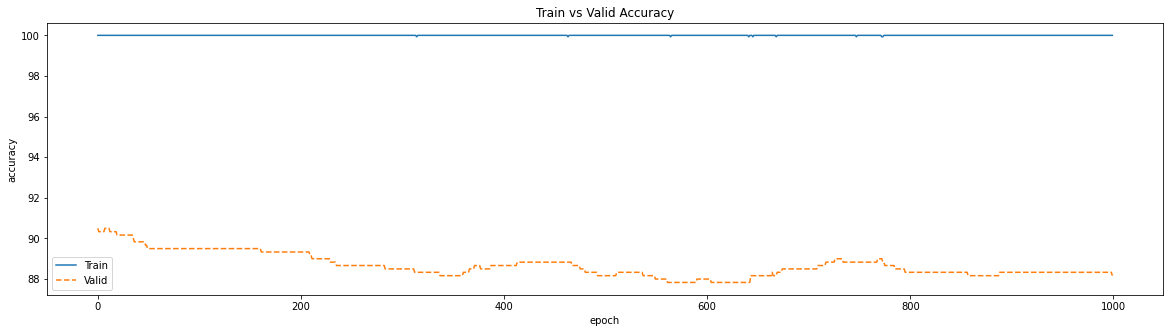

In [72]:
accuracy_plots(train_accu, eval_accu)

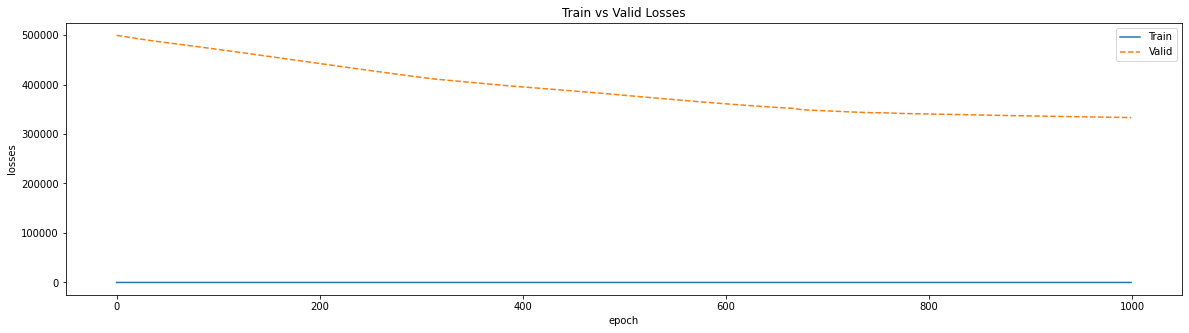

In [73]:
loss_plots(train_losses, eval_losses)

In [74]:
model = model_configs["2"]
model.load_state_dict(torch.load("models/best_model_parameters23.pth"))
model.eval()

model_2(
  (l1): Linear(in_features=784, out_features=400, bias=True)
  (l2): Linear(in_features=400, out_features=200, bias=True)
  (l3): Linear(in_features=200, out_features=10, bias=True)
)

In [75]:
with torch.no_grad():
  predicted_classes = []
  device = torch.device("cpu")
  for data in tqdm(first_five_loader):
    images,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(images)
    _, predicted = torch.max(outputs, 1)
    predicted_classes.append(predicted)

100%|██████████| 5/5 [00:00<00:00, 1635.72it/s]


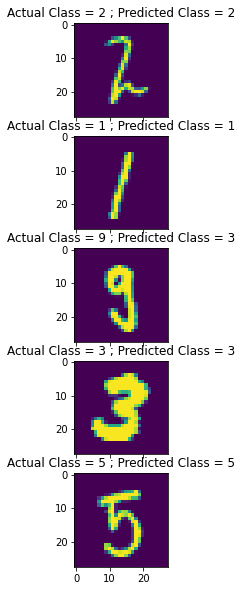

In [76]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for j in range(5):
  axs[j].imshow(first_five_test_images[j][0])
  axs[j].set_title(f"Actual Class = {first_five_test_image_labels[0+j]} ; Predicted Class = {predicted_classes[j].item()}")

for ax in axs.flat:
    ax.label_outer()

# model 3, training config 1: 

In [77]:
s = time.time()
eval_losses, train_losses, eval_accu, train_accu = train("3", "1")
e = time.time()

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |   313600   |
|  l1.bias  |    400     |
| l2.weight |   80000    |
|  l2.bias  |    200     |
| l3.weight |    2000    |
|  l3.bias  |     10     |
+-----------+------------+
Total Trainable Params: 396210

Epoch : 1


100%|██████████| 2/2 [00:00<00:00, 120.89it/s]



Epoch : 2


100%|██████████| 2/2 [00:00<00:00, 129.64it/s]



Epoch : 3


100%|██████████| 2/2 [00:00<00:00, 112.46it/s]



Epoch : 4


100%|██████████| 2/2 [00:00<00:00, 145.19it/s]



Epoch : 5


100%|██████████| 2/2 [00:00<00:00, 114.79it/s]



Epoch : 6


100%|██████████| 2/2 [00:00<00:00, 140.68it/s]



Epoch : 7


100%|██████████| 2/2 [00:00<00:00, 134.88it/s]



Epoch : 8


100%|██████████| 2/2 [00:00<00:00, 126.04it/s]



Epoch : 9


100%|██████████| 2/2 [00:00<00:00, 132.43it/s]



Epoch : 10


100%|██████████| 2/2 [00:00<00:00, 124.17it/s]



Epoch : 11


100%|██████████| 2/2 [00:00<00:00, 128.09it/s]



Epoch : 12


100%|██████████| 2/2 [00:00<00:00, 130.46it/s]



Epoch : 13


100%|██████████| 2/2 [00:00<00:00, 125.20it/s]



Epoch : 14


100%|██████████| 2/2 [00:00<00:00, 128.42it/s]



Epoch : 15


100%|██████████| 2/2 [00:00<00:00, 116.78it/s]



Epoch : 16


100%|██████████| 2/2 [00:00<00:00, 128.27it/s]



Epoch : 17


100%|██████████| 2/2 [00:00<00:00, 108.95it/s]



Epoch : 18


100%|██████████| 2/2 [00:00<00:00, 126.13it/s]



Epoch : 19


100%|██████████| 2/2 [00:00<00:00, 130.54it/s]



Epoch : 20


100%|██████████| 2/2 [00:00<00:00, 135.59it/s]



Epoch : 21


100%|██████████| 2/2 [00:00<00:00, 123.16it/s]



Epoch : 22


100%|██████████| 2/2 [00:00<00:00, 124.69it/s]



Epoch : 23


100%|██████████| 2/2 [00:00<00:00, 122.85it/s]



Epoch : 24


100%|██████████| 2/2 [00:00<00:00, 138.09it/s]



Epoch : 25


100%|██████████| 2/2 [00:00<00:00, 127.39it/s]



Epoch : 26


100%|██████████| 2/2 [00:00<00:00, 116.31it/s]



Epoch : 27


100%|██████████| 2/2 [00:00<00:00, 107.58it/s]



Epoch : 28


100%|██████████| 2/2 [00:00<00:00, 117.27it/s]



Epoch : 29


100%|██████████| 2/2 [00:00<00:00, 125.34it/s]



Epoch : 30


100%|██████████| 2/2 [00:00<00:00, 139.74it/s]



Epoch : 31


100%|██████████| 2/2 [00:00<00:00, 113.50it/s]



Epoch : 32


100%|██████████| 2/2 [00:00<00:00, 118.20it/s]



Epoch : 33


100%|██████████| 2/2 [00:00<00:00, 98.26it/s]



Epoch : 34


100%|██████████| 2/2 [00:00<00:00, 124.60it/s]



Epoch : 35


100%|██████████| 2/2 [00:00<00:00, 122.50it/s]



Epoch : 36


100%|██████████| 2/2 [00:00<00:00, 138.74it/s]



Epoch : 37


100%|██████████| 2/2 [00:00<00:00, 115.52it/s]



Epoch : 38


100%|██████████| 2/2 [00:00<00:00, 123.24it/s]



Epoch : 39


100%|██████████| 2/2 [00:00<00:00, 105.85it/s]



Epoch : 40


100%|██████████| 2/2 [00:00<00:00, 139.18it/s]



Epoch : 41


100%|██████████| 2/2 [00:00<00:00, 117.88it/s]



Epoch : 42


100%|██████████| 2/2 [00:00<00:00, 132.01it/s]



Epoch : 43


100%|██████████| 2/2 [00:00<00:00, 120.33it/s]



Epoch : 44


100%|██████████| 2/2 [00:00<00:00, 127.25it/s]



Epoch : 45


100%|██████████| 2/2 [00:00<00:00, 126.68it/s]



Epoch : 46


100%|██████████| 2/2 [00:00<00:00, 121.84it/s]



Epoch : 47


100%|██████████| 2/2 [00:00<00:00, 102.90it/s]



Epoch : 48


100%|██████████| 2/2 [00:00<00:00, 124.74it/s]



Epoch : 49


100%|██████████| 2/2 [00:00<00:00, 126.42it/s]



Epoch : 50


100%|██████████| 2/2 [00:00<00:00, 103.83it/s]



Epoch : 51


100%|██████████| 2/2 [00:00<00:00, 84.41it/s]



Epoch : 52


100%|██████████| 2/2 [00:00<00:00, 87.43it/s]



Epoch : 53


100%|██████████| 2/2 [00:00<00:00, 122.75it/s]



Epoch : 54


100%|██████████| 2/2 [00:00<00:00, 127.02it/s]



Epoch : 55


100%|██████████| 2/2 [00:00<00:00, 109.07it/s]



Epoch : 56


100%|██████████| 2/2 [00:00<00:00, 139.23it/s]



Epoch : 57


100%|██████████| 2/2 [00:00<00:00, 131.61it/s]



Epoch : 58


100%|██████████| 2/2 [00:00<00:00, 138.54it/s]



Epoch : 59


100%|██████████| 2/2 [00:00<00:00, 133.38it/s]



Epoch : 60


100%|██████████| 2/2 [00:00<00:00, 126.84it/s]



Epoch : 61


100%|██████████| 2/2 [00:00<00:00, 119.52it/s]



Epoch : 62


100%|██████████| 2/2 [00:00<00:00, 138.29it/s]



Epoch : 63


100%|██████████| 2/2 [00:00<00:00, 108.35it/s]



Epoch : 64


100%|██████████| 2/2 [00:00<00:00, 154.35it/s]



Epoch : 65


100%|██████████| 2/2 [00:00<00:00, 109.12it/s]



Epoch : 66


100%|██████████| 2/2 [00:00<00:00, 111.72it/s]



Epoch : 67


100%|██████████| 2/2 [00:00<00:00, 128.55it/s]



Epoch : 68


100%|██████████| 2/2 [00:00<00:00, 131.68it/s]



Epoch : 69


100%|██████████| 2/2 [00:00<00:00, 118.05it/s]



Epoch : 70


100%|██████████| 2/2 [00:00<00:00, 130.26it/s]



Epoch : 71


100%|██████████| 2/2 [00:00<00:00, 113.75it/s]



Epoch : 72


100%|██████████| 2/2 [00:00<00:00, 120.57it/s]



Epoch : 73


100%|██████████| 2/2 [00:00<00:00, 117.34it/s]



Epoch : 74


100%|██████████| 2/2 [00:00<00:00, 112.13it/s]



Epoch : 75


100%|██████████| 2/2 [00:00<00:00, 88.41it/s]



Epoch : 76


100%|██████████| 2/2 [00:00<00:00, 126.57it/s]



Epoch : 77


100%|██████████| 2/2 [00:00<00:00, 118.27it/s]



Epoch : 78


100%|██████████| 2/2 [00:00<00:00, 130.11it/s]



Epoch : 79


100%|██████████| 2/2 [00:00<00:00, 123.80it/s]



Epoch : 80


100%|██████████| 2/2 [00:00<00:00, 120.05it/s]



Epoch : 81


100%|██████████| 2/2 [00:00<00:00, 102.42it/s]



Epoch : 82


100%|██████████| 2/2 [00:00<00:00, 124.10it/s]



Epoch : 83


100%|██████████| 2/2 [00:00<00:00, 120.71it/s]



Epoch : 84


100%|██████████| 2/2 [00:00<00:00, 114.52it/s]



Epoch : 85


100%|██████████| 2/2 [00:00<00:00, 113.77it/s]



Epoch : 86


100%|██████████| 2/2 [00:00<00:00, 112.32it/s]



Epoch : 87


100%|██████████| 2/2 [00:00<00:00, 125.21it/s]



Epoch : 88


100%|██████████| 2/2 [00:00<00:00, 129.26it/s]



Epoch : 89


100%|██████████| 2/2 [00:00<00:00, 110.19it/s]



Epoch : 90


100%|██████████| 2/2 [00:00<00:00, 131.92it/s]



Epoch : 91


100%|██████████| 2/2 [00:00<00:00, 119.57it/s]



Epoch : 92


100%|██████████| 2/2 [00:00<00:00, 112.27it/s]



Epoch : 93


100%|██████████| 2/2 [00:00<00:00, 128.91it/s]



Epoch : 94


100%|██████████| 2/2 [00:00<00:00, 124.25it/s]



Epoch : 95


100%|██████████| 2/2 [00:00<00:00, 121.50it/s]



Epoch : 96


100%|██████████| 2/2 [00:00<00:00, 112.75it/s]



Epoch : 97


100%|██████████| 2/2 [00:00<00:00, 113.65it/s]



Epoch : 98


100%|██████████| 2/2 [00:00<00:00, 125.98it/s]



Epoch : 99


100%|██████████| 2/2 [00:00<00:00, 112.36it/s]



Epoch : 100


100%|██████████| 2/2 [00:00<00:00, 130.38it/s]



Epoch : 101


100%|██████████| 2/2 [00:00<00:00, 97.51it/s]



Epoch : 102


100%|██████████| 2/2 [00:00<00:00, 121.48it/s]



Epoch : 103


100%|██████████| 2/2 [00:00<00:00, 118.67it/s]



Epoch : 104


100%|██████████| 2/2 [00:00<00:00, 132.90it/s]



Epoch : 105


100%|██████████| 2/2 [00:00<00:00, 94.82it/s]



Epoch : 106


100%|██████████| 2/2 [00:00<00:00, 118.31it/s]



Epoch : 107


100%|██████████| 2/2 [00:00<00:00, 115.70it/s]



Epoch : 108


100%|██████████| 2/2 [00:00<00:00, 120.49it/s]



Epoch : 109


100%|██████████| 2/2 [00:00<00:00, 123.04it/s]



Epoch : 110


100%|██████████| 2/2 [00:00<00:00, 118.21it/s]



Epoch : 111


100%|██████████| 2/2 [00:00<00:00, 94.15it/s]



Epoch : 112


100%|██████████| 2/2 [00:00<00:00, 125.57it/s]



Epoch : 113


100%|██████████| 2/2 [00:00<00:00, 116.87it/s]



Epoch : 114


100%|██████████| 2/2 [00:00<00:00, 103.82it/s]



Epoch : 115


100%|██████████| 2/2 [00:00<00:00, 97.08it/s]



Epoch : 116


100%|██████████| 2/2 [00:00<00:00, 102.80it/s]



Epoch : 117


100%|██████████| 2/2 [00:00<00:00, 132.08it/s]



Epoch : 118


100%|██████████| 2/2 [00:00<00:00, 106.25it/s]



Epoch : 119


100%|██████████| 2/2 [00:00<00:00, 106.84it/s]



Epoch : 120


100%|██████████| 2/2 [00:00<00:00, 122.68it/s]



Epoch : 121


100%|██████████| 2/2 [00:00<00:00, 77.71it/s]



Epoch : 122


100%|██████████| 2/2 [00:00<00:00, 121.95it/s]



Epoch : 123


100%|██████████| 2/2 [00:00<00:00, 114.71it/s]



Epoch : 124


100%|██████████| 2/2 [00:00<00:00, 116.33it/s]



Epoch : 125


100%|██████████| 2/2 [00:00<00:00, 116.13it/s]



Epoch : 126


100%|██████████| 2/2 [00:00<00:00, 113.61it/s]



Epoch : 127


100%|██████████| 2/2 [00:00<00:00, 98.64it/s]



Epoch : 128


100%|██████████| 2/2 [00:00<00:00, 134.39it/s]



Epoch : 129


100%|██████████| 2/2 [00:00<00:00, 111.62it/s]



Epoch : 130


100%|██████████| 2/2 [00:00<00:00, 115.66it/s]



Epoch : 131


100%|██████████| 2/2 [00:00<00:00, 88.43it/s]



Epoch : 132


100%|██████████| 2/2 [00:00<00:00, 115.62it/s]



Epoch : 133


100%|██████████| 2/2 [00:00<00:00, 104.68it/s]



Epoch : 134


100%|██████████| 2/2 [00:00<00:00, 128.50it/s]



Epoch : 135


100%|██████████| 2/2 [00:00<00:00, 116.03it/s]



Epoch : 136


100%|██████████| 2/2 [00:00<00:00, 117.30it/s]



Epoch : 137


100%|██████████| 2/2 [00:00<00:00, 115.23it/s]



Epoch : 138


100%|██████████| 2/2 [00:00<00:00, 113.15it/s]



Epoch : 139


100%|██████████| 2/2 [00:00<00:00, 107.03it/s]



Epoch : 140


100%|██████████| 2/2 [00:00<00:00, 118.80it/s]



Epoch : 141


100%|██████████| 2/2 [00:00<00:00, 106.80it/s]



Epoch : 142


100%|██████████| 2/2 [00:00<00:00, 117.23it/s]



Epoch : 143


100%|██████████| 2/2 [00:00<00:00, 117.10it/s]



Epoch : 144


100%|██████████| 2/2 [00:00<00:00, 124.19it/s]



Epoch : 145


100%|██████████| 2/2 [00:00<00:00, 114.06it/s]



Epoch : 146


100%|██████████| 2/2 [00:00<00:00, 121.25it/s]



Epoch : 147


100%|██████████| 2/2 [00:00<00:00, 112.68it/s]



Epoch : 148


100%|██████████| 2/2 [00:00<00:00, 115.24it/s]



Epoch : 149


100%|██████████| 2/2 [00:00<00:00, 98.65it/s]



Epoch : 150


100%|██████████| 2/2 [00:00<00:00, 115.80it/s]



Epoch : 151


100%|██████████| 2/2 [00:00<00:00, 112.91it/s]



Epoch : 152


100%|██████████| 2/2 [00:00<00:00, 103.45it/s]



Epoch : 153


100%|██████████| 2/2 [00:00<00:00, 109.03it/s]



Epoch : 154


100%|██████████| 2/2 [00:00<00:00, 134.10it/s]



Epoch : 155


100%|██████████| 2/2 [00:00<00:00, 110.48it/s]



Epoch : 156


100%|██████████| 2/2 [00:00<00:00, 105.32it/s]



Epoch : 157


100%|██████████| 2/2 [00:00<00:00, 106.36it/s]



Epoch : 158


100%|██████████| 2/2 [00:00<00:00, 112.24it/s]



Epoch : 159


100%|██████████| 2/2 [00:00<00:00, 106.53it/s]



Epoch : 160


100%|██████████| 2/2 [00:00<00:00, 109.32it/s]



Epoch : 161


100%|██████████| 2/2 [00:00<00:00, 105.68it/s]



Epoch : 162


100%|██████████| 2/2 [00:00<00:00, 108.90it/s]



Epoch : 163


100%|██████████| 2/2 [00:00<00:00, 114.48it/s]



Epoch : 164


100%|██████████| 2/2 [00:00<00:00, 112.94it/s]



Epoch : 165


100%|██████████| 2/2 [00:00<00:00, 106.10it/s]



Epoch : 166


100%|██████████| 2/2 [00:00<00:00, 108.57it/s]



Epoch : 167


100%|██████████| 2/2 [00:00<00:00, 124.21it/s]



Epoch : 168


100%|██████████| 2/2 [00:00<00:00, 108.75it/s]



Epoch : 169


100%|██████████| 2/2 [00:00<00:00, 105.86it/s]



Epoch : 170


100%|██████████| 2/2 [00:00<00:00, 111.95it/s]



Epoch : 171


100%|██████████| 2/2 [00:00<00:00, 98.16it/s]



Epoch : 172


100%|██████████| 2/2 [00:00<00:00, 107.20it/s]



Epoch : 173


100%|██████████| 2/2 [00:00<00:00, 104.66it/s]



Epoch : 174


100%|██████████| 2/2 [00:00<00:00, 116.68it/s]



Epoch : 175


100%|██████████| 2/2 [00:00<00:00, 108.06it/s]



Epoch : 176


100%|██████████| 2/2 [00:00<00:00, 119.36it/s]



Epoch : 177


100%|██████████| 2/2 [00:00<00:00, 128.10it/s]



Epoch : 178


100%|██████████| 2/2 [00:00<00:00, 112.81it/s]



Epoch : 179


100%|██████████| 2/2 [00:00<00:00, 125.44it/s]



Epoch : 180


100%|██████████| 2/2 [00:00<00:00, 76.99it/s]



Epoch : 181


100%|██████████| 2/2 [00:00<00:00, 109.61it/s]



Epoch : 182


100%|██████████| 2/2 [00:00<00:00, 117.50it/s]



Epoch : 183


100%|██████████| 2/2 [00:00<00:00, 106.66it/s]



Epoch : 184


100%|██████████| 2/2 [00:00<00:00, 119.36it/s]



Epoch : 185


100%|██████████| 2/2 [00:00<00:00, 121.51it/s]



Epoch : 186


100%|██████████| 2/2 [00:00<00:00, 109.36it/s]



Epoch : 187


100%|██████████| 2/2 [00:00<00:00, 98.33it/s]



Epoch : 188


100%|██████████| 2/2 [00:00<00:00, 104.29it/s]



Epoch : 189


100%|██████████| 2/2 [00:00<00:00, 107.03it/s]



Epoch : 190


100%|██████████| 2/2 [00:00<00:00, 102.40it/s]



Epoch : 191


100%|██████████| 2/2 [00:00<00:00, 123.46it/s]



Epoch : 192


100%|██████████| 2/2 [00:00<00:00, 107.12it/s]



Epoch : 193


100%|██████████| 2/2 [00:00<00:00, 132.28it/s]



Epoch : 194


100%|██████████| 2/2 [00:00<00:00, 101.47it/s]



Epoch : 195


100%|██████████| 2/2 [00:00<00:00, 108.69it/s]



Epoch : 196


100%|██████████| 2/2 [00:00<00:00, 101.16it/s]



Epoch : 197


100%|██████████| 2/2 [00:00<00:00, 106.48it/s]



Epoch : 198


100%|██████████| 2/2 [00:00<00:00, 104.65it/s]



Epoch : 199


100%|██████████| 2/2 [00:00<00:00, 105.69it/s]



Epoch : 200


100%|██████████| 2/2 [00:00<00:00, 104.27it/s]



Epoch : 201


100%|██████████| 2/2 [00:00<00:00, 111.01it/s]



Epoch : 202


100%|██████████| 2/2 [00:00<00:00, 119.55it/s]



Epoch : 203


100%|██████████| 2/2 [00:00<00:00, 108.51it/s]



Epoch : 204


100%|██████████| 2/2 [00:00<00:00, 95.35it/s]



Epoch : 205


100%|██████████| 2/2 [00:00<00:00, 107.15it/s]



Epoch : 206


100%|██████████| 2/2 [00:00<00:00, 121.69it/s]



Epoch : 207


100%|██████████| 2/2 [00:00<00:00, 98.45it/s]



Epoch : 208


100%|██████████| 2/2 [00:00<00:00, 105.05it/s]



Epoch : 209


100%|██████████| 2/2 [00:00<00:00, 104.95it/s]



Epoch : 210


100%|██████████| 2/2 [00:00<00:00, 107.56it/s]



Epoch : 211


100%|██████████| 2/2 [00:00<00:00, 100.93it/s]



Epoch : 212


100%|██████████| 2/2 [00:00<00:00, 106.04it/s]



Epoch : 213


100%|██████████| 2/2 [00:00<00:00, 104.16it/s]



Epoch : 214


100%|██████████| 2/2 [00:00<00:00, 116.09it/s]



Epoch : 215


100%|██████████| 2/2 [00:00<00:00, 111.67it/s]



Epoch : 216


100%|██████████| 2/2 [00:00<00:00, 115.55it/s]



Epoch : 217


100%|██████████| 2/2 [00:00<00:00, 105.02it/s]



Epoch : 218


100%|██████████| 2/2 [00:00<00:00, 103.16it/s]



Epoch : 219


100%|██████████| 2/2 [00:00<00:00, 114.37it/s]



Epoch : 220


100%|██████████| 2/2 [00:00<00:00, 103.33it/s]



Epoch : 221


100%|██████████| 2/2 [00:00<00:00, 109.60it/s]



Epoch : 222


100%|██████████| 2/2 [00:00<00:00, 97.18it/s]



Epoch : 223


100%|██████████| 2/2 [00:00<00:00, 111.27it/s]



Epoch : 224


100%|██████████| 2/2 [00:00<00:00, 105.43it/s]



Epoch : 225


100%|██████████| 2/2 [00:00<00:00, 107.43it/s]



Epoch : 226


100%|██████████| 2/2 [00:00<00:00, 104.12it/s]



Epoch : 227


100%|██████████| 2/2 [00:00<00:00, 108.87it/s]



Epoch : 228


100%|██████████| 2/2 [00:00<00:00, 111.66it/s]



Epoch : 229


100%|██████████| 2/2 [00:00<00:00, 107.21it/s]



Epoch : 230


100%|██████████| 2/2 [00:00<00:00, 119.64it/s]



Epoch : 231


100%|██████████| 2/2 [00:00<00:00, 110.92it/s]



Epoch : 232


100%|██████████| 2/2 [00:00<00:00, 129.22it/s]



Epoch : 233


100%|██████████| 2/2 [00:00<00:00, 106.99it/s]



Epoch : 234


100%|██████████| 2/2 [00:00<00:00, 101.91it/s]



Epoch : 235


100%|██████████| 2/2 [00:00<00:00, 102.70it/s]



Epoch : 236


100%|██████████| 2/2 [00:00<00:00, 96.30it/s]



Epoch : 237


100%|██████████| 2/2 [00:00<00:00, 100.18it/s]



Epoch : 238


100%|██████████| 2/2 [00:00<00:00, 99.91it/s]



Epoch : 239


100%|██████████| 2/2 [00:00<00:00, 67.16it/s]



Epoch : 240


100%|██████████| 2/2 [00:00<00:00, 112.64it/s]



Epoch : 241


100%|██████████| 2/2 [00:00<00:00, 116.34it/s]



Epoch : 242


100%|██████████| 2/2 [00:00<00:00, 104.25it/s]



Epoch : 243


100%|██████████| 2/2 [00:00<00:00, 114.40it/s]



Epoch : 244


100%|██████████| 2/2 [00:00<00:00, 111.06it/s]



Epoch : 245


100%|██████████| 2/2 [00:00<00:00, 100.73it/s]



Epoch : 246


100%|██████████| 2/2 [00:00<00:00, 122.21it/s]



Epoch : 247


100%|██████████| 2/2 [00:00<00:00, 98.45it/s]



Epoch : 248


100%|██████████| 2/2 [00:00<00:00, 105.57it/s]



Epoch : 249


100%|██████████| 2/2 [00:00<00:00, 106.06it/s]



Epoch : 250


100%|██████████| 2/2 [00:00<00:00, 97.69it/s]



Epoch : 251


100%|██████████| 2/2 [00:00<00:00, 109.85it/s]



Epoch : 252


100%|██████████| 2/2 [00:00<00:00, 99.70it/s]



Epoch : 253


100%|██████████| 2/2 [00:00<00:00, 97.41it/s]



Epoch : 254


100%|██████████| 2/2 [00:00<00:00, 105.52it/s]



Epoch : 255


100%|██████████| 2/2 [00:00<00:00, 100.72it/s]



Epoch : 256


100%|██████████| 2/2 [00:00<00:00, 107.14it/s]



Epoch : 257


100%|██████████| 2/2 [00:00<00:00, 96.97it/s]



Epoch : 258


100%|██████████| 2/2 [00:00<00:00, 98.28it/s]



Epoch : 259


100%|██████████| 2/2 [00:00<00:00, 90.52it/s]



Epoch : 260


100%|██████████| 2/2 [00:00<00:00, 75.44it/s]



Epoch : 261


100%|██████████| 2/2 [00:00<00:00, 99.78it/s]



Epoch : 262


100%|██████████| 2/2 [00:00<00:00, 97.66it/s]



Epoch : 263


100%|██████████| 2/2 [00:00<00:00, 103.57it/s]



Epoch : 264


100%|██████████| 2/2 [00:00<00:00, 117.57it/s]



Epoch : 265


100%|██████████| 2/2 [00:00<00:00, 97.29it/s]



Epoch : 266


100%|██████████| 2/2 [00:00<00:00, 94.75it/s]



Epoch : 267


100%|██████████| 2/2 [00:00<00:00, 104.85it/s]



Epoch : 268


100%|██████████| 2/2 [00:00<00:00, 97.48it/s]



Epoch : 269


100%|██████████| 2/2 [00:00<00:00, 108.04it/s]



Epoch : 270


100%|██████████| 2/2 [00:00<00:00, 103.01it/s]



Epoch : 271


100%|██████████| 2/2 [00:00<00:00, 100.93it/s]



Epoch : 272


100%|██████████| 2/2 [00:00<00:00, 102.22it/s]



Epoch : 273


100%|██████████| 2/2 [00:00<00:00, 117.72it/s]



Epoch : 274


100%|██████████| 2/2 [00:00<00:00, 85.51it/s]



Epoch : 275


100%|██████████| 2/2 [00:00<00:00, 102.60it/s]



Epoch : 276


100%|██████████| 2/2 [00:00<00:00, 110.59it/s]



Epoch : 277


100%|██████████| 2/2 [00:00<00:00, 93.01it/s]



Epoch : 278


100%|██████████| 2/2 [00:00<00:00, 111.92it/s]



Epoch : 279


100%|██████████| 2/2 [00:00<00:00, 132.66it/s]



Epoch : 280


100%|██████████| 2/2 [00:00<00:00, 99.96it/s]



Epoch : 281


100%|██████████| 2/2 [00:00<00:00, 92.99it/s]



Epoch : 282


100%|██████████| 2/2 [00:00<00:00, 96.52it/s]



Epoch : 283


100%|██████████| 2/2 [00:00<00:00, 96.05it/s]



Epoch : 284


100%|██████████| 2/2 [00:00<00:00, 95.64it/s]



Epoch : 285


100%|██████████| 2/2 [00:00<00:00, 101.87it/s]



Epoch : 286


100%|██████████| 2/2 [00:00<00:00, 108.68it/s]



Epoch : 287


100%|██████████| 2/2 [00:00<00:00, 101.49it/s]



Epoch : 288


100%|██████████| 2/2 [00:00<00:00, 90.72it/s]



Epoch : 289


100%|██████████| 2/2 [00:00<00:00, 98.49it/s]



Epoch : 290


100%|██████████| 2/2 [00:00<00:00, 90.14it/s]



Epoch : 291


100%|██████████| 2/2 [00:00<00:00, 92.63it/s]



Epoch : 292


100%|██████████| 2/2 [00:00<00:00, 97.09it/s]



Epoch : 293


100%|██████████| 2/2 [00:00<00:00, 102.77it/s]



Epoch : 294


100%|██████████| 2/2 [00:00<00:00, 99.22it/s]



Epoch : 295


100%|██████████| 2/2 [00:00<00:00, 101.76it/s]



Epoch : 296


100%|██████████| 2/2 [00:00<00:00, 103.56it/s]



Epoch : 297


100%|██████████| 2/2 [00:00<00:00, 96.92it/s]



Epoch : 298


100%|██████████| 2/2 [00:00<00:00, 104.52it/s]



Epoch : 299


100%|██████████| 2/2 [00:00<00:00, 103.46it/s]



Epoch : 300


100%|██████████| 2/2 [00:00<00:00, 98.37it/s]



Epoch : 301


100%|██████████| 2/2 [00:00<00:00, 96.79it/s]



Epoch : 302


100%|██████████| 2/2 [00:00<00:00, 100.36it/s]



Epoch : 303


100%|██████████| 2/2 [00:00<00:00, 97.34it/s]



Epoch : 304


100%|██████████| 2/2 [00:00<00:00, 99.90it/s]



Epoch : 305


100%|██████████| 2/2 [00:00<00:00, 110.19it/s]



Epoch : 306


100%|██████████| 2/2 [00:00<00:00, 101.69it/s]



Epoch : 307


100%|██████████| 2/2 [00:00<00:00, 97.37it/s]



Epoch : 308


100%|██████████| 2/2 [00:00<00:00, 104.07it/s]



Epoch : 309


100%|██████████| 2/2 [00:00<00:00, 102.39it/s]



Epoch : 310


100%|██████████| 2/2 [00:00<00:00, 93.50it/s]



Epoch : 311


100%|██████████| 2/2 [00:00<00:00, 96.52it/s]



Epoch : 312


100%|██████████| 2/2 [00:00<00:00, 108.39it/s]



Epoch : 313


100%|██████████| 2/2 [00:00<00:00, 96.02it/s]



Epoch : 314


100%|██████████| 2/2 [00:00<00:00, 105.23it/s]



Epoch : 315


100%|██████████| 2/2 [00:00<00:00, 67.89it/s]



Epoch : 316


100%|██████████| 2/2 [00:00<00:00, 99.08it/s]



Epoch : 317


100%|██████████| 2/2 [00:00<00:00, 102.70it/s]



Epoch : 318


100%|██████████| 2/2 [00:00<00:00, 89.77it/s]



Epoch : 319


100%|██████████| 2/2 [00:00<00:00, 103.04it/s]



Epoch : 320


100%|██████████| 2/2 [00:00<00:00, 107.79it/s]



Epoch : 321


100%|██████████| 2/2 [00:00<00:00, 100.92it/s]



Epoch : 322


100%|██████████| 2/2 [00:00<00:00, 81.62it/s]



Epoch : 323


100%|██████████| 2/2 [00:00<00:00, 100.52it/s]



Epoch : 324


100%|██████████| 2/2 [00:00<00:00, 98.47it/s]



Epoch : 325


100%|██████████| 2/2 [00:00<00:00, 99.15it/s]



Epoch : 326


100%|██████████| 2/2 [00:00<00:00, 112.59it/s]



Epoch : 327


100%|██████████| 2/2 [00:00<00:00, 98.22it/s]



Epoch : 328


100%|██████████| 2/2 [00:00<00:00, 113.59it/s]



Epoch : 329


100%|██████████| 2/2 [00:00<00:00, 100.87it/s]



Epoch : 330


100%|██████████| 2/2 [00:00<00:00, 84.66it/s]



Epoch : 331


100%|██████████| 2/2 [00:00<00:00, 100.24it/s]



Epoch : 332


100%|██████████| 2/2 [00:00<00:00, 96.31it/s]



Epoch : 333


100%|██████████| 2/2 [00:00<00:00, 101.02it/s]



Epoch : 334


100%|██████████| 2/2 [00:00<00:00, 98.62it/s]



Epoch : 335


100%|██████████| 2/2 [00:00<00:00, 95.56it/s]



Epoch : 336


100%|██████████| 2/2 [00:00<00:00, 97.29it/s]



Epoch : 337


100%|██████████| 2/2 [00:00<00:00, 96.46it/s]



Epoch : 338


100%|██████████| 2/2 [00:00<00:00, 98.88it/s]



Epoch : 339


100%|██████████| 2/2 [00:00<00:00, 73.14it/s]



Epoch : 340


100%|██████████| 2/2 [00:00<00:00, 107.59it/s]



Epoch : 341


100%|██████████| 2/2 [00:00<00:00, 98.51it/s]



Epoch : 342


100%|██████████| 2/2 [00:00<00:00, 96.88it/s]



Epoch : 343


100%|██████████| 2/2 [00:00<00:00, 101.14it/s]



Epoch : 344


100%|██████████| 2/2 [00:00<00:00, 100.17it/s]



Epoch : 345


100%|██████████| 2/2 [00:00<00:00, 101.27it/s]



Epoch : 346


100%|██████████| 2/2 [00:00<00:00, 94.25it/s]



Epoch : 347


100%|██████████| 2/2 [00:00<00:00, 102.14it/s]



Epoch : 348


100%|██████████| 2/2 [00:00<00:00, 86.12it/s]



Epoch : 349


100%|██████████| 2/2 [00:00<00:00, 107.79it/s]



Epoch : 350


100%|██████████| 2/2 [00:00<00:00, 107.34it/s]



Epoch : 351


100%|██████████| 2/2 [00:00<00:00, 101.14it/s]



Epoch : 352


100%|██████████| 2/2 [00:00<00:00, 135.28it/s]



Epoch : 353


100%|██████████| 2/2 [00:00<00:00, 93.04it/s]



Epoch : 354


100%|██████████| 2/2 [00:00<00:00, 90.90it/s]



Epoch : 355


100%|██████████| 2/2 [00:00<00:00, 102.15it/s]



Epoch : 356


100%|██████████| 2/2 [00:00<00:00, 98.54it/s]



Epoch : 357


100%|██████████| 2/2 [00:00<00:00, 92.84it/s]



Epoch : 358


100%|██████████| 2/2 [00:00<00:00, 103.46it/s]



Epoch : 359


100%|██████████| 2/2 [00:00<00:00, 107.98it/s]



Epoch : 360


100%|██████████| 2/2 [00:00<00:00, 99.77it/s]



Epoch : 361


100%|██████████| 2/2 [00:00<00:00, 106.38it/s]



Epoch : 362


100%|██████████| 2/2 [00:00<00:00, 104.22it/s]



Epoch : 363


100%|██████████| 2/2 [00:00<00:00, 94.96it/s]



Epoch : 364


100%|██████████| 2/2 [00:00<00:00, 99.15it/s]



Epoch : 365


100%|██████████| 2/2 [00:00<00:00, 98.64it/s]



Epoch : 366


100%|██████████| 2/2 [00:00<00:00, 101.41it/s]



Epoch : 367


100%|██████████| 2/2 [00:00<00:00, 95.19it/s]



Epoch : 368


100%|██████████| 2/2 [00:00<00:00, 99.02it/s]



Epoch : 369


100%|██████████| 2/2 [00:00<00:00, 99.02it/s]



Epoch : 370


100%|██████████| 2/2 [00:00<00:00, 91.90it/s]



Epoch : 371


100%|██████████| 2/2 [00:00<00:00, 78.96it/s]



Epoch : 372


100%|██████████| 2/2 [00:00<00:00, 98.76it/s]



Epoch : 373


100%|██████████| 2/2 [00:00<00:00, 94.42it/s]



Epoch : 374


100%|██████████| 2/2 [00:00<00:00, 91.83it/s]



Epoch : 375


100%|██████████| 2/2 [00:00<00:00, 107.76it/s]



Epoch : 376


100%|██████████| 2/2 [00:00<00:00, 96.84it/s]



Epoch : 377


100%|██████████| 2/2 [00:00<00:00, 100.03it/s]



Epoch : 378


100%|██████████| 2/2 [00:00<00:00, 99.72it/s]



Epoch : 379


100%|██████████| 2/2 [00:00<00:00, 96.27it/s]



Epoch : 380


100%|██████████| 2/2 [00:00<00:00, 98.44it/s]



Epoch : 381


100%|██████████| 2/2 [00:00<00:00, 95.28it/s]



Epoch : 382


100%|██████████| 2/2 [00:00<00:00, 98.71it/s]



Epoch : 383


100%|██████████| 2/2 [00:00<00:00, 115.09it/s]



Epoch : 384


100%|██████████| 2/2 [00:00<00:00, 95.74it/s]



Epoch : 385


100%|██████████| 2/2 [00:00<00:00, 95.24it/s]



Epoch : 386


100%|██████████| 2/2 [00:00<00:00, 92.14it/s]



Epoch : 387


100%|██████████| 2/2 [00:00<00:00, 96.36it/s]



Epoch : 388


100%|██████████| 2/2 [00:00<00:00, 95.56it/s]



Epoch : 389


100%|██████████| 2/2 [00:00<00:00, 92.66it/s]



Epoch : 390


100%|██████████| 2/2 [00:00<00:00, 104.62it/s]



Epoch : 391


100%|██████████| 2/2 [00:00<00:00, 102.64it/s]



Epoch : 392


100%|██████████| 2/2 [00:00<00:00, 100.23it/s]



Epoch : 393


100%|██████████| 2/2 [00:00<00:00, 103.29it/s]



Epoch : 394


100%|██████████| 2/2 [00:00<00:00, 98.32it/s]



Epoch : 395


100%|██████████| 2/2 [00:00<00:00, 87.29it/s]



Epoch : 396


100%|██████████| 2/2 [00:00<00:00, 94.92it/s]



Epoch : 397


100%|██████████| 2/2 [00:00<00:00, 97.63it/s]



Epoch : 398


100%|██████████| 2/2 [00:00<00:00, 98.77it/s]



Epoch : 399


100%|██████████| 2/2 [00:00<00:00, 101.23it/s]



Epoch : 400


100%|██████████| 2/2 [00:00<00:00, 100.57it/s]



Epoch : 401


100%|██████████| 2/2 [00:00<00:00, 111.75it/s]



Epoch : 402


100%|██████████| 2/2 [00:00<00:00, 99.35it/s]



Epoch : 403


100%|██████████| 2/2 [00:00<00:00, 85.00it/s]



Epoch : 404


100%|██████████| 2/2 [00:00<00:00, 88.17it/s]



Epoch : 405


100%|██████████| 2/2 [00:00<00:00, 98.20it/s]



Epoch : 406


100%|██████████| 2/2 [00:00<00:00, 96.25it/s]



Epoch : 407


100%|██████████| 2/2 [00:00<00:00, 119.13it/s]



Epoch : 408


100%|██████████| 2/2 [00:00<00:00, 107.94it/s]



Epoch : 409


100%|██████████| 2/2 [00:00<00:00, 103.54it/s]



Epoch : 410


100%|██████████| 2/2 [00:00<00:00, 83.42it/s]



Epoch : 411


100%|██████████| 2/2 [00:00<00:00, 104.12it/s]



Epoch : 412


100%|██████████| 2/2 [00:00<00:00, 91.39it/s]



Epoch : 413


100%|██████████| 2/2 [00:00<00:00, 94.56it/s]



Epoch : 414


100%|██████████| 2/2 [00:00<00:00, 94.66it/s]



Epoch : 415


100%|██████████| 2/2 [00:00<00:00, 108.44it/s]



Epoch : 416


100%|██████████| 2/2 [00:00<00:00, 105.13it/s]



Epoch : 417


100%|██████████| 2/2 [00:00<00:00, 86.50it/s]



Epoch : 418


100%|██████████| 2/2 [00:00<00:00, 104.27it/s]



Epoch : 419


100%|██████████| 2/2 [00:00<00:00, 103.98it/s]



Epoch : 420


100%|██████████| 2/2 [00:00<00:00, 108.66it/s]



Epoch : 421


100%|██████████| 2/2 [00:00<00:00, 96.54it/s]



Epoch : 422


100%|██████████| 2/2 [00:00<00:00, 102.75it/s]



Epoch : 423


100%|██████████| 2/2 [00:00<00:00, 90.22it/s]



Epoch : 424


100%|██████████| 2/2 [00:00<00:00, 101.22it/s]



Epoch : 425


100%|██████████| 2/2 [00:00<00:00, 97.56it/s]



Epoch : 426


100%|██████████| 2/2 [00:00<00:00, 94.73it/s]



Epoch : 427


100%|██████████| 2/2 [00:00<00:00, 97.36it/s]



Epoch : 428


100%|██████████| 2/2 [00:00<00:00, 107.03it/s]



Epoch : 429


100%|██████████| 2/2 [00:00<00:00, 106.52it/s]



Epoch : 430


100%|██████████| 2/2 [00:00<00:00, 98.66it/s]



Epoch : 431


100%|██████████| 2/2 [00:00<00:00, 95.30it/s]



Epoch : 432


100%|██████████| 2/2 [00:00<00:00, 88.18it/s]



Epoch : 433


100%|██████████| 2/2 [00:00<00:00, 100.16it/s]



Epoch : 434


100%|██████████| 2/2 [00:00<00:00, 98.26it/s]



Epoch : 435


100%|██████████| 2/2 [00:00<00:00, 98.11it/s]



Epoch : 436


100%|██████████| 2/2 [00:00<00:00, 88.77it/s]



Epoch : 437


100%|██████████| 2/2 [00:00<00:00, 98.33it/s]



Epoch : 438


100%|██████████| 2/2 [00:00<00:00, 99.32it/s]



Epoch : 439


100%|██████████| 2/2 [00:00<00:00, 99.36it/s]



Epoch : 440


100%|██████████| 2/2 [00:00<00:00, 99.16it/s]



Epoch : 441


100%|██████████| 2/2 [00:00<00:00, 99.78it/s]



Epoch : 442


100%|██████████| 2/2 [00:00<00:00, 101.05it/s]



Epoch : 443


100%|██████████| 2/2 [00:00<00:00, 91.17it/s]



Epoch : 444


100%|██████████| 2/2 [00:00<00:00, 100.44it/s]



Epoch : 445


100%|██████████| 2/2 [00:00<00:00, 96.04it/s]



Epoch : 446


100%|██████████| 2/2 [00:00<00:00, 93.90it/s]



Epoch : 447


100%|██████████| 2/2 [00:00<00:00, 98.35it/s]



Epoch : 448


100%|██████████| 2/2 [00:00<00:00, 67.39it/s]



Epoch : 449


100%|██████████| 2/2 [00:00<00:00, 92.76it/s]



Epoch : 450


100%|██████████| 2/2 [00:00<00:00, 94.36it/s]



Epoch : 451


100%|██████████| 2/2 [00:00<00:00, 98.14it/s]



Epoch : 452


100%|██████████| 2/2 [00:00<00:00, 94.23it/s]



Epoch : 453


100%|██████████| 2/2 [00:00<00:00, 100.94it/s]



Epoch : 454


100%|██████████| 2/2 [00:00<00:00, 96.92it/s]



Epoch : 455


100%|██████████| 2/2 [00:00<00:00, 101.41it/s]



Epoch : 456


100%|██████████| 2/2 [00:00<00:00, 96.25it/s]



Epoch : 457


100%|██████████| 2/2 [00:00<00:00, 97.14it/s]



Epoch : 458


100%|██████████| 2/2 [00:00<00:00, 92.37it/s]



Epoch : 459


100%|██████████| 2/2 [00:00<00:00, 106.40it/s]



Epoch : 460


100%|██████████| 2/2 [00:00<00:00, 84.66it/s]



Epoch : 461


100%|██████████| 2/2 [00:00<00:00, 99.23it/s]



Epoch : 462


100%|██████████| 2/2 [00:00<00:00, 100.92it/s]



Epoch : 463


100%|██████████| 2/2 [00:00<00:00, 121.11it/s]



Epoch : 464


100%|██████████| 2/2 [00:00<00:00, 97.79it/s]



Epoch : 465


100%|██████████| 2/2 [00:00<00:00, 97.01it/s]



Epoch : 466


100%|██████████| 2/2 [00:00<00:00, 96.63it/s]



Epoch : 467


100%|██████████| 2/2 [00:00<00:00, 104.64it/s]



Epoch : 468


100%|██████████| 2/2 [00:00<00:00, 91.64it/s]



Epoch : 469


100%|██████████| 2/2 [00:00<00:00, 95.03it/s]



Epoch : 470


100%|██████████| 2/2 [00:00<00:00, 114.11it/s]



Epoch : 471


100%|██████████| 2/2 [00:00<00:00, 98.36it/s]



Epoch : 472


100%|██████████| 2/2 [00:00<00:00, 102.42it/s]



Epoch : 473


100%|██████████| 2/2 [00:00<00:00, 96.87it/s]



Epoch : 474


100%|██████████| 2/2 [00:00<00:00, 117.48it/s]



Epoch : 475


100%|██████████| 2/2 [00:00<00:00, 82.72it/s]



Epoch : 476


100%|██████████| 2/2 [00:00<00:00, 99.63it/s]



Epoch : 477


100%|██████████| 2/2 [00:00<00:00, 109.25it/s]



Epoch : 478


100%|██████████| 2/2 [00:00<00:00, 97.40it/s]



Epoch : 479


100%|██████████| 2/2 [00:00<00:00, 93.07it/s]



Epoch : 480


100%|██████████| 2/2 [00:00<00:00, 101.28it/s]



Epoch : 481


100%|██████████| 2/2 [00:00<00:00, 100.42it/s]



Epoch : 482


100%|██████████| 2/2 [00:00<00:00, 107.93it/s]



Epoch : 483


100%|██████████| 2/2 [00:00<00:00, 92.17it/s]



Epoch : 484


100%|██████████| 2/2 [00:00<00:00, 102.18it/s]



Epoch : 485


100%|██████████| 2/2 [00:00<00:00, 107.46it/s]



Epoch : 486


100%|██████████| 2/2 [00:00<00:00, 98.15it/s]



Epoch : 487


100%|██████████| 2/2 [00:00<00:00, 98.67it/s]



Epoch : 488


100%|██████████| 2/2 [00:00<00:00, 128.50it/s]



Epoch : 489


100%|██████████| 2/2 [00:00<00:00, 101.55it/s]



Epoch : 490


100%|██████████| 2/2 [00:00<00:00, 94.82it/s]



Epoch : 491


100%|██████████| 2/2 [00:00<00:00, 105.74it/s]



Epoch : 492


100%|██████████| 2/2 [00:00<00:00, 103.24it/s]



Epoch : 493


100%|██████████| 2/2 [00:00<00:00, 100.43it/s]



Epoch : 494


100%|██████████| 2/2 [00:00<00:00, 102.95it/s]



Epoch : 495


100%|██████████| 2/2 [00:00<00:00, 99.22it/s]



Epoch : 496


100%|██████████| 2/2 [00:00<00:00, 95.15it/s]



Epoch : 497


100%|██████████| 2/2 [00:00<00:00, 100.83it/s]



Epoch : 498


100%|██████████| 2/2 [00:00<00:00, 95.81it/s]



Epoch : 499


100%|██████████| 2/2 [00:00<00:00, 129.18it/s]



Epoch : 500


100%|██████████| 2/2 [00:00<00:00, 97.71it/s]



Epoch : 501


100%|██████████| 2/2 [00:00<00:00, 104.82it/s]



Epoch : 502


100%|██████████| 2/2 [00:00<00:00, 111.63it/s]



Epoch : 503


100%|██████████| 2/2 [00:00<00:00, 97.36it/s]



Epoch : 504


100%|██████████| 2/2 [00:00<00:00, 103.91it/s]



Epoch : 505


100%|██████████| 2/2 [00:00<00:00, 94.60it/s]



Epoch : 506


100%|██████████| 2/2 [00:00<00:00, 111.09it/s]



Epoch : 507


100%|██████████| 2/2 [00:00<00:00, 94.98it/s]



Epoch : 508


100%|██████████| 2/2 [00:00<00:00, 83.76it/s]



Epoch : 509


100%|██████████| 2/2 [00:00<00:00, 93.92it/s]



Epoch : 510


100%|██████████| 2/2 [00:00<00:00, 117.35it/s]



Epoch : 511


100%|██████████| 2/2 [00:00<00:00, 99.82it/s]



Epoch : 512


100%|██████████| 2/2 [00:00<00:00, 96.99it/s]



Epoch : 513


100%|██████████| 2/2 [00:00<00:00, 97.18it/s]



Epoch : 514


100%|██████████| 2/2 [00:00<00:00, 100.78it/s]



Epoch : 515


100%|██████████| 2/2 [00:00<00:00, 98.26it/s]



Epoch : 516


100%|██████████| 2/2 [00:00<00:00, 92.53it/s]



Epoch : 517


100%|██████████| 2/2 [00:00<00:00, 83.44it/s]



Epoch : 518


100%|██████████| 2/2 [00:00<00:00, 92.41it/s]



Epoch : 519


100%|██████████| 2/2 [00:00<00:00, 105.56it/s]



Epoch : 520


100%|██████████| 2/2 [00:00<00:00, 96.55it/s]



Epoch : 521


100%|██████████| 2/2 [00:00<00:00, 91.56it/s]



Epoch : 522


100%|██████████| 2/2 [00:00<00:00, 96.51it/s]



Epoch : 523


100%|██████████| 2/2 [00:00<00:00, 101.49it/s]



Epoch : 524


100%|██████████| 2/2 [00:00<00:00, 94.14it/s]



Epoch : 525


100%|██████████| 2/2 [00:00<00:00, 97.39it/s]



Epoch : 526


100%|██████████| 2/2 [00:00<00:00, 113.35it/s]



Epoch : 527


100%|██████████| 2/2 [00:00<00:00, 90.15it/s]



Epoch : 528


100%|██████████| 2/2 [00:00<00:00, 97.83it/s]



Epoch : 529


100%|██████████| 2/2 [00:00<00:00, 102.94it/s]



Epoch : 530


100%|██████████| 2/2 [00:00<00:00, 96.97it/s]



Epoch : 531


100%|██████████| 2/2 [00:00<00:00, 96.18it/s]



Epoch : 532


100%|██████████| 2/2 [00:00<00:00, 102.79it/s]



Epoch : 533


100%|██████████| 2/2 [00:00<00:00, 93.68it/s]



Epoch : 534


100%|██████████| 2/2 [00:00<00:00, 90.92it/s]



Epoch : 535


100%|██████████| 2/2 [00:00<00:00, 94.81it/s]



Epoch : 536


100%|██████████| 2/2 [00:00<00:00, 91.17it/s]



Epoch : 537


100%|██████████| 2/2 [00:00<00:00, 95.02it/s]



Epoch : 538


100%|██████████| 2/2 [00:00<00:00, 80.80it/s]



Epoch : 539


100%|██████████| 2/2 [00:00<00:00, 94.58it/s]



Epoch : 540


100%|██████████| 2/2 [00:00<00:00, 88.32it/s]



Epoch : 541


100%|██████████| 2/2 [00:00<00:00, 91.62it/s]



Epoch : 542


100%|██████████| 2/2 [00:00<00:00, 83.92it/s]



Epoch : 543


100%|██████████| 2/2 [00:00<00:00, 86.39it/s]



Epoch : 544


100%|██████████| 2/2 [00:00<00:00, 84.89it/s]



Epoch : 545


100%|██████████| 2/2 [00:00<00:00, 81.04it/s]



Epoch : 546


100%|██████████| 2/2 [00:00<00:00, 80.76it/s]



Epoch : 547


100%|██████████| 2/2 [00:00<00:00, 74.31it/s]



Epoch : 548


100%|██████████| 2/2 [00:00<00:00, 82.05it/s]



Epoch : 549


100%|██████████| 2/2 [00:00<00:00, 75.72it/s]



Epoch : 550


100%|██████████| 2/2 [00:00<00:00, 75.96it/s]



Epoch : 551


100%|██████████| 2/2 [00:00<00:00, 71.67it/s]



Epoch : 552


100%|██████████| 2/2 [00:00<00:00, 71.42it/s]



Epoch : 553


100%|██████████| 2/2 [00:00<00:00, 68.31it/s]



Epoch : 554


100%|██████████| 2/2 [00:00<00:00, 54.23it/s]



Epoch : 555


100%|██████████| 2/2 [00:00<00:00, 65.82it/s]



Epoch : 556


100%|██████████| 2/2 [00:00<00:00, 70.48it/s]



Epoch : 557


100%|██████████| 2/2 [00:00<00:00, 64.48it/s]



Epoch : 558


100%|██████████| 2/2 [00:00<00:00, 63.43it/s]



Epoch : 559


100%|██████████| 2/2 [00:00<00:00, 61.47it/s]



Epoch : 560


100%|██████████| 2/2 [00:00<00:00, 61.76it/s]



Epoch : 561


100%|██████████| 2/2 [00:00<00:00, 60.18it/s]



Epoch : 562


100%|██████████| 2/2 [00:00<00:00, 61.97it/s]



Epoch : 563


100%|██████████| 2/2 [00:00<00:00, 57.67it/s]



Epoch : 564


100%|██████████| 2/2 [00:00<00:00, 62.18it/s]



Epoch : 565


100%|██████████| 2/2 [00:00<00:00, 47.36it/s]



Epoch : 566


100%|██████████| 2/2 [00:00<00:00, 57.98it/s]



Epoch : 567


100%|██████████| 2/2 [00:00<00:00, 59.54it/s]



Epoch : 568


100%|██████████| 2/2 [00:00<00:00, 47.60it/s]



Epoch : 569


100%|██████████| 2/2 [00:00<00:00, 55.42it/s]



Epoch : 570


100%|██████████| 2/2 [00:00<00:00, 56.52it/s]



Epoch : 571


100%|██████████| 2/2 [00:00<00:00, 63.53it/s]



Epoch : 572


100%|██████████| 2/2 [00:00<00:00, 53.90it/s]



Epoch : 573


100%|██████████| 2/2 [00:00<00:00, 61.77it/s]



Epoch : 574


100%|██████████| 2/2 [00:00<00:00, 54.49it/s]



Epoch : 575


100%|██████████| 2/2 [00:00<00:00, 56.92it/s]



Epoch : 576


100%|██████████| 2/2 [00:00<00:00, 57.76it/s]



Epoch : 577


100%|██████████| 2/2 [00:00<00:00, 58.82it/s]



Epoch : 578


100%|██████████| 2/2 [00:00<00:00, 59.16it/s]



Epoch : 579


100%|██████████| 2/2 [00:00<00:00, 58.96it/s]



Epoch : 580


100%|██████████| 2/2 [00:00<00:00, 51.76it/s]



Epoch : 581


100%|██████████| 2/2 [00:00<00:00, 57.10it/s]



Epoch : 582


100%|██████████| 2/2 [00:00<00:00, 58.80it/s]



Epoch : 583


100%|██████████| 2/2 [00:00<00:00, 58.16it/s]



Epoch : 584


100%|██████████| 2/2 [00:00<00:00, 56.94it/s]



Epoch : 585


100%|██████████| 2/2 [00:00<00:00, 43.82it/s]



Epoch : 586


100%|██████████| 2/2 [00:00<00:00, 55.12it/s]



Epoch : 587


100%|██████████| 2/2 [00:00<00:00, 56.63it/s]



Epoch : 588


100%|██████████| 2/2 [00:00<00:00, 56.55it/s]



Epoch : 589


100%|██████████| 2/2 [00:00<00:00, 57.71it/s]



Epoch : 590


100%|██████████| 2/2 [00:00<00:00, 57.82it/s]



Epoch : 591


100%|██████████| 2/2 [00:00<00:00, 58.42it/s]



Epoch : 592


100%|██████████| 2/2 [00:00<00:00, 56.14it/s]



Epoch : 593


100%|██████████| 2/2 [00:00<00:00, 46.20it/s]



Epoch : 594


100%|██████████| 2/2 [00:00<00:00, 50.36it/s]



Epoch : 595


100%|██████████| 2/2 [00:00<00:00, 45.54it/s]



Epoch : 596


100%|██████████| 2/2 [00:00<00:00, 56.90it/s]



Epoch : 597


100%|██████████| 2/2 [00:00<00:00, 52.92it/s]



Epoch : 598


100%|██████████| 2/2 [00:00<00:00, 55.63it/s]



Epoch : 599


100%|██████████| 2/2 [00:00<00:00, 54.29it/s]



Epoch : 600


100%|██████████| 2/2 [00:00<00:00, 38.41it/s]



Epoch : 601


100%|██████████| 2/2 [00:00<00:00, 54.92it/s]



Epoch : 602


100%|██████████| 2/2 [00:00<00:00, 56.02it/s]



Epoch : 603


100%|██████████| 2/2 [00:00<00:00, 51.88it/s]



Epoch : 604


100%|██████████| 2/2 [00:00<00:00, 49.36it/s]



Epoch : 605


100%|██████████| 2/2 [00:00<00:00, 50.64it/s]



Epoch : 606


100%|██████████| 2/2 [00:00<00:00, 52.05it/s]



Epoch : 607


100%|██████████| 2/2 [00:00<00:00, 55.27it/s]



Epoch : 608


100%|██████████| 2/2 [00:00<00:00, 55.85it/s]



Epoch : 609


100%|██████████| 2/2 [00:00<00:00, 53.82it/s]



Epoch : 610


100%|██████████| 2/2 [00:00<00:00, 53.47it/s]



Epoch : 611


100%|██████████| 2/2 [00:00<00:00, 55.21it/s]



Epoch : 612


100%|██████████| 2/2 [00:00<00:00, 54.64it/s]



Epoch : 613


100%|██████████| 2/2 [00:00<00:00, 54.34it/s]



Epoch : 614


100%|██████████| 2/2 [00:00<00:00, 49.98it/s]



Epoch : 615


100%|██████████| 2/2 [00:00<00:00, 50.34it/s]



Epoch : 616


100%|██████████| 2/2 [00:00<00:00, 52.38it/s]



Epoch : 617


100%|██████████| 2/2 [00:00<00:00, 53.45it/s]



Epoch : 618


100%|██████████| 2/2 [00:00<00:00, 53.90it/s]



Epoch : 619


100%|██████████| 2/2 [00:00<00:00, 53.69it/s]



Epoch : 620


100%|██████████| 2/2 [00:00<00:00, 51.40it/s]



Epoch : 621


100%|██████████| 2/2 [00:00<00:00, 40.43it/s]



Epoch : 622


100%|██████████| 2/2 [00:00<00:00, 46.54it/s]



Epoch : 623


100%|██████████| 2/2 [00:00<00:00, 49.31it/s]



Epoch : 624


100%|██████████| 2/2 [00:00<00:00, 53.71it/s]



Epoch : 625


100%|██████████| 2/2 [00:00<00:00, 51.93it/s]



Epoch : 626


100%|██████████| 2/2 [00:00<00:00, 57.14it/s]



Epoch : 627


100%|██████████| 2/2 [00:00<00:00, 52.54it/s]



Epoch : 628


100%|██████████| 2/2 [00:00<00:00, 49.21it/s]



Epoch : 629


100%|██████████| 2/2 [00:00<00:00, 48.85it/s]



Epoch : 630


100%|██████████| 2/2 [00:00<00:00, 53.24it/s]



Epoch : 631


100%|██████████| 2/2 [00:00<00:00, 53.98it/s]



Epoch : 632


100%|██████████| 2/2 [00:00<00:00, 52.25it/s]



Epoch : 633


100%|██████████| 2/2 [00:00<00:00, 52.19it/s]



Epoch : 634


100%|██████████| 2/2 [00:00<00:00, 52.70it/s]



Epoch : 635


100%|██████████| 2/2 [00:00<00:00, 51.80it/s]



Epoch : 636


100%|██████████| 2/2 [00:00<00:00, 43.46it/s]



Epoch : 637


100%|██████████| 2/2 [00:00<00:00, 50.15it/s]



Epoch : 638


100%|██████████| 2/2 [00:00<00:00, 51.78it/s]



Epoch : 639


100%|██████████| 2/2 [00:00<00:00, 50.33it/s]



Epoch : 640


100%|██████████| 2/2 [00:00<00:00, 43.14it/s]



Epoch : 641


100%|██████████| 2/2 [00:00<00:00, 54.52it/s]



Epoch : 642


100%|██████████| 2/2 [00:00<00:00, 52.74it/s]



Epoch : 643


100%|██████████| 2/2 [00:00<00:00, 52.98it/s]



Epoch : 644


100%|██████████| 2/2 [00:00<00:00, 53.07it/s]



Epoch : 645


100%|██████████| 2/2 [00:00<00:00, 53.57it/s]



Epoch : 646


100%|██████████| 2/2 [00:00<00:00, 54.30it/s]



Epoch : 647


100%|██████████| 2/2 [00:00<00:00, 54.07it/s]



Epoch : 648


100%|██████████| 2/2 [00:00<00:00, 55.00it/s]



Epoch : 649


100%|██████████| 2/2 [00:00<00:00, 53.64it/s]



Epoch : 650


100%|██████████| 2/2 [00:00<00:00, 47.63it/s]



Epoch : 651


100%|██████████| 2/2 [00:00<00:00, 53.12it/s]



Epoch : 652


100%|██████████| 2/2 [00:00<00:00, 45.82it/s]



Epoch : 653


100%|██████████| 2/2 [00:00<00:00, 55.33it/s]



Epoch : 654


100%|██████████| 2/2 [00:00<00:00, 52.93it/s]



Epoch : 655


100%|██████████| 2/2 [00:00<00:00, 54.84it/s]



Epoch : 656


100%|██████████| 2/2 [00:00<00:00, 54.32it/s]



Epoch : 657


100%|██████████| 2/2 [00:00<00:00, 50.58it/s]



Epoch : 658


100%|██████████| 2/2 [00:00<00:00, 56.90it/s]



Epoch : 659


100%|██████████| 2/2 [00:00<00:00, 54.06it/s]



Epoch : 660


100%|██████████| 2/2 [00:00<00:00, 53.26it/s]



Epoch : 661


100%|██████████| 2/2 [00:00<00:00, 48.02it/s]



Epoch : 662


100%|██████████| 2/2 [00:00<00:00, 55.88it/s]



Epoch : 663


100%|██████████| 2/2 [00:00<00:00, 46.29it/s]



Epoch : 664


100%|██████████| 2/2 [00:00<00:00, 52.40it/s]



Epoch : 665


100%|██████████| 2/2 [00:00<00:00, 49.99it/s]



Epoch : 666


100%|██████████| 2/2 [00:00<00:00, 46.82it/s]



Epoch : 667


100%|██████████| 2/2 [00:00<00:00, 53.65it/s]



Epoch : 668


100%|██████████| 2/2 [00:00<00:00, 52.61it/s]



Epoch : 669


100%|██████████| 2/2 [00:00<00:00, 54.83it/s]



Epoch : 670


100%|██████████| 2/2 [00:00<00:00, 53.01it/s]



Epoch : 671


100%|██████████| 2/2 [00:00<00:00, 45.78it/s]



Epoch : 672


100%|██████████| 2/2 [00:00<00:00, 49.08it/s]



Epoch : 673


100%|██████████| 2/2 [00:00<00:00, 44.68it/s]



Epoch : 674


100%|██████████| 2/2 [00:00<00:00, 51.02it/s]



Epoch : 675


100%|██████████| 2/2 [00:00<00:00, 51.34it/s]



Epoch : 676


100%|██████████| 2/2 [00:00<00:00, 50.00it/s]



Epoch : 677


100%|██████████| 2/2 [00:00<00:00, 49.52it/s]



Epoch : 678


100%|██████████| 2/2 [00:00<00:00, 52.16it/s]



Epoch : 679


100%|██████████| 2/2 [00:00<00:00, 48.64it/s]



Epoch : 680


100%|██████████| 2/2 [00:00<00:00, 47.67it/s]



Epoch : 681


100%|██████████| 2/2 [00:00<00:00, 51.71it/s]



Epoch : 682


100%|██████████| 2/2 [00:00<00:00, 51.57it/s]



Epoch : 683


100%|██████████| 2/2 [00:00<00:00, 49.81it/s]



Epoch : 684


100%|██████████| 2/2 [00:00<00:00, 54.02it/s]



Epoch : 685


100%|██████████| 2/2 [00:00<00:00, 44.11it/s]



Epoch : 686


100%|██████████| 2/2 [00:00<00:00, 52.26it/s]



Epoch : 687


100%|██████████| 2/2 [00:00<00:00, 49.61it/s]



Epoch : 688


100%|██████████| 2/2 [00:00<00:00, 51.41it/s]



Epoch : 689


100%|██████████| 2/2 [00:00<00:00, 54.60it/s]



Epoch : 690


100%|██████████| 2/2 [00:00<00:00, 49.71it/s]



Epoch : 691


100%|██████████| 2/2 [00:00<00:00, 52.24it/s]



Epoch : 692


100%|██████████| 2/2 [00:00<00:00, 51.22it/s]



Epoch : 693


100%|██████████| 2/2 [00:00<00:00, 56.48it/s]



Epoch : 694


100%|██████████| 2/2 [00:00<00:00, 48.38it/s]



Epoch : 695


100%|██████████| 2/2 [00:00<00:00, 51.34it/s]



Epoch : 696


100%|██████████| 2/2 [00:00<00:00, 52.55it/s]



Epoch : 697


100%|██████████| 2/2 [00:00<00:00, 46.47it/s]



Epoch : 698


100%|██████████| 2/2 [00:00<00:00, 49.87it/s]



Epoch : 699


100%|██████████| 2/2 [00:00<00:00, 50.13it/s]



Epoch : 700


100%|██████████| 2/2 [00:00<00:00, 49.23it/s]



Epoch : 701


100%|██████████| 2/2 [00:00<00:00, 47.87it/s]



Epoch : 702


100%|██████████| 2/2 [00:00<00:00, 49.67it/s]



Epoch : 703


100%|██████████| 2/2 [00:00<00:00, 51.15it/s]



Epoch : 704


100%|██████████| 2/2 [00:00<00:00, 45.86it/s]



Epoch : 705


100%|██████████| 2/2 [00:00<00:00, 50.54it/s]



Epoch : 706


100%|██████████| 2/2 [00:00<00:00, 52.90it/s]



Epoch : 707


100%|██████████| 2/2 [00:00<00:00, 50.39it/s]



Epoch : 708


100%|██████████| 2/2 [00:00<00:00, 52.63it/s]



Epoch : 709


100%|██████████| 2/2 [00:00<00:00, 51.45it/s]



Epoch : 710


100%|██████████| 2/2 [00:00<00:00, 49.17it/s]



Epoch : 711


100%|██████████| 2/2 [00:00<00:00, 51.85it/s]



Epoch : 712


100%|██████████| 2/2 [00:00<00:00, 49.54it/s]



Epoch : 713


100%|██████████| 2/2 [00:00<00:00, 50.64it/s]



Epoch : 714


100%|██████████| 2/2 [00:00<00:00, 51.41it/s]



Epoch : 715


100%|██████████| 2/2 [00:00<00:00, 50.77it/s]



Epoch : 716


100%|██████████| 2/2 [00:00<00:00, 51.97it/s]



Epoch : 717


100%|██████████| 2/2 [00:00<00:00, 50.08it/s]



Epoch : 718


100%|██████████| 2/2 [00:00<00:00, 48.07it/s]



Epoch : 719


100%|██████████| 2/2 [00:00<00:00, 50.54it/s]



Epoch : 720


100%|██████████| 2/2 [00:00<00:00, 50.57it/s]



Epoch : 721


100%|██████████| 2/2 [00:00<00:00, 46.91it/s]



Epoch : 722


100%|██████████| 2/2 [00:00<00:00, 49.71it/s]



Epoch : 723


100%|██████████| 2/2 [00:00<00:00, 52.11it/s]



Epoch : 724


100%|██████████| 2/2 [00:00<00:00, 53.19it/s]



Epoch : 725


100%|██████████| 2/2 [00:00<00:00, 51.20it/s]



Epoch : 726


100%|██████████| 2/2 [00:00<00:00, 46.95it/s]



Epoch : 727


100%|██████████| 2/2 [00:00<00:00, 47.80it/s]



Epoch : 728


100%|██████████| 2/2 [00:00<00:00, 51.60it/s]



Epoch : 729


100%|██████████| 2/2 [00:00<00:00, 48.76it/s]



Epoch : 730


100%|██████████| 2/2 [00:00<00:00, 50.37it/s]



Epoch : 731


100%|██████████| 2/2 [00:00<00:00, 49.05it/s]



Epoch : 732


100%|██████████| 2/2 [00:00<00:00, 48.34it/s]



Epoch : 733


100%|██████████| 2/2 [00:00<00:00, 50.94it/s]



Epoch : 734


100%|██████████| 2/2 [00:00<00:00, 48.64it/s]



Epoch : 735


100%|██████████| 2/2 [00:00<00:00, 47.47it/s]



Epoch : 736


100%|██████████| 2/2 [00:00<00:00, 46.14it/s]



Epoch : 737


100%|██████████| 2/2 [00:00<00:00, 47.69it/s]



Epoch : 738


100%|██████████| 2/2 [00:00<00:00, 47.60it/s]



Epoch : 739


100%|██████████| 2/2 [00:00<00:00, 43.65it/s]



Epoch : 740


100%|██████████| 2/2 [00:00<00:00, 46.75it/s]



Epoch : 741


100%|██████████| 2/2 [00:00<00:00, 48.21it/s]



Epoch : 742


100%|██████████| 2/2 [00:00<00:00, 45.28it/s]



Epoch : 743


100%|██████████| 2/2 [00:00<00:00, 48.05it/s]



Epoch : 744


100%|██████████| 2/2 [00:00<00:00, 44.87it/s]



Epoch : 745


100%|██████████| 2/2 [00:00<00:00, 45.25it/s]



Epoch : 746


100%|██████████| 2/2 [00:00<00:00, 49.12it/s]



Epoch : 747


100%|██████████| 2/2 [00:00<00:00, 48.48it/s]



Epoch : 748


100%|██████████| 2/2 [00:00<00:00, 48.77it/s]



Epoch : 749


100%|██████████| 2/2 [00:00<00:00, 47.73it/s]



Epoch : 750


100%|██████████| 2/2 [00:00<00:00, 47.90it/s]



Epoch : 751


100%|██████████| 2/2 [00:00<00:00, 46.92it/s]



Epoch : 752


100%|██████████| 2/2 [00:00<00:00, 47.91it/s]



Epoch : 753


100%|██████████| 2/2 [00:00<00:00, 45.21it/s]



Epoch : 754


100%|██████████| 2/2 [00:00<00:00, 48.32it/s]



Epoch : 755


100%|██████████| 2/2 [00:00<00:00, 47.98it/s]



Epoch : 756


100%|██████████| 2/2 [00:00<00:00, 47.38it/s]



Epoch : 757


100%|██████████| 2/2 [00:00<00:00, 48.16it/s]



Epoch : 758


100%|██████████| 2/2 [00:00<00:00, 48.07it/s]



Epoch : 759


100%|██████████| 2/2 [00:00<00:00, 44.42it/s]



Epoch : 760


100%|██████████| 2/2 [00:00<00:00, 47.39it/s]



Epoch : 761


100%|██████████| 2/2 [00:00<00:00, 44.38it/s]



Epoch : 762


100%|██████████| 2/2 [00:00<00:00, 46.18it/s]



Epoch : 763


100%|██████████| 2/2 [00:00<00:00, 46.91it/s]



Epoch : 764


100%|██████████| 2/2 [00:00<00:00, 47.19it/s]



Epoch : 765


100%|██████████| 2/2 [00:00<00:00, 44.59it/s]



Epoch : 766


100%|██████████| 2/2 [00:00<00:00, 47.08it/s]



Epoch : 767


100%|██████████| 2/2 [00:00<00:00, 47.36it/s]



Epoch : 768


100%|██████████| 2/2 [00:00<00:00, 42.59it/s]



Epoch : 769


100%|██████████| 2/2 [00:00<00:00, 48.44it/s]



Epoch : 770


100%|██████████| 2/2 [00:00<00:00, 47.81it/s]



Epoch : 771


100%|██████████| 2/2 [00:00<00:00, 47.70it/s]



Epoch : 772


100%|██████████| 2/2 [00:00<00:00, 47.51it/s]



Epoch : 773


100%|██████████| 2/2 [00:00<00:00, 45.34it/s]



Epoch : 774


100%|██████████| 2/2 [00:00<00:00, 42.02it/s]



Epoch : 775


100%|██████████| 2/2 [00:00<00:00, 46.59it/s]



Epoch : 776


100%|██████████| 2/2 [00:00<00:00, 46.92it/s]



Epoch : 777


100%|██████████| 2/2 [00:00<00:00, 44.57it/s]



Epoch : 778


100%|██████████| 2/2 [00:00<00:00, 47.63it/s]



Epoch : 779


100%|██████████| 2/2 [00:00<00:00, 45.48it/s]



Epoch : 780


100%|██████████| 2/2 [00:00<00:00, 46.50it/s]



Epoch : 781


100%|██████████| 2/2 [00:00<00:00, 46.33it/s]



Epoch : 782


100%|██████████| 2/2 [00:00<00:00, 43.63it/s]



Epoch : 783


100%|██████████| 2/2 [00:00<00:00, 45.01it/s]



Epoch : 784


100%|██████████| 2/2 [00:00<00:00, 46.99it/s]



Epoch : 785


100%|██████████| 2/2 [00:00<00:00, 41.82it/s]



Epoch : 786


100%|██████████| 2/2 [00:00<00:00, 44.79it/s]



Epoch : 787


100%|██████████| 2/2 [00:00<00:00, 46.09it/s]



Epoch : 788


100%|██████████| 2/2 [00:00<00:00, 45.42it/s]



Epoch : 789


100%|██████████| 2/2 [00:00<00:00, 43.80it/s]



Epoch : 790


100%|██████████| 2/2 [00:00<00:00, 45.24it/s]



Epoch : 791


100%|██████████| 2/2 [00:00<00:00, 46.72it/s]



Epoch : 792


100%|██████████| 2/2 [00:00<00:00, 42.25it/s]



Epoch : 793


100%|██████████| 2/2 [00:00<00:00, 44.45it/s]



Epoch : 794


100%|██████████| 2/2 [00:00<00:00, 45.94it/s]



Epoch : 795


100%|██████████| 2/2 [00:00<00:00, 46.46it/s]



Epoch : 796


100%|██████████| 2/2 [00:00<00:00, 47.28it/s]



Epoch : 797


100%|██████████| 2/2 [00:00<00:00, 46.23it/s]



Epoch : 798


100%|██████████| 2/2 [00:00<00:00, 46.34it/s]



Epoch : 799


100%|██████████| 2/2 [00:00<00:00, 48.30it/s]



Epoch : 800


100%|██████████| 2/2 [00:00<00:00, 43.91it/s]



Epoch : 801


100%|██████████| 2/2 [00:00<00:00, 46.32it/s]



Epoch : 802


100%|██████████| 2/2 [00:00<00:00, 46.04it/s]



Epoch : 803


100%|██████████| 2/2 [00:00<00:00, 46.75it/s]



Epoch : 804


100%|██████████| 2/2 [00:00<00:00, 46.44it/s]



Epoch : 805


100%|██████████| 2/2 [00:00<00:00, 46.45it/s]



Epoch : 806


100%|██████████| 2/2 [00:00<00:00, 44.70it/s]



Epoch : 807


100%|██████████| 2/2 [00:00<00:00, 44.69it/s]



Epoch : 808


100%|██████████| 2/2 [00:00<00:00, 46.29it/s]



Epoch : 809


100%|██████████| 2/2 [00:00<00:00, 42.80it/s]



Epoch : 810


100%|██████████| 2/2 [00:00<00:00, 49.40it/s]



Epoch : 811


100%|██████████| 2/2 [00:00<00:00, 42.72it/s]



Epoch : 812


100%|██████████| 2/2 [00:00<00:00, 46.70it/s]



Epoch : 813


100%|██████████| 2/2 [00:00<00:00, 45.50it/s]



Epoch : 814


100%|██████████| 2/2 [00:00<00:00, 46.93it/s]



Epoch : 815


100%|██████████| 2/2 [00:00<00:00, 44.74it/s]



Epoch : 816


100%|██████████| 2/2 [00:00<00:00, 47.26it/s]



Epoch : 817


100%|██████████| 2/2 [00:00<00:00, 47.55it/s]



Epoch : 818


100%|██████████| 2/2 [00:00<00:00, 48.18it/s]



Epoch : 819


100%|██████████| 2/2 [00:00<00:00, 45.94it/s]



Epoch : 820


100%|██████████| 2/2 [00:00<00:00, 47.32it/s]



Epoch : 821


100%|██████████| 2/2 [00:00<00:00, 42.38it/s]



Epoch : 822


100%|██████████| 2/2 [00:00<00:00, 46.47it/s]



Epoch : 823


100%|██████████| 2/2 [00:00<00:00, 47.38it/s]



Epoch : 824


100%|██████████| 2/2 [00:00<00:00, 47.01it/s]



Epoch : 825


100%|██████████| 2/2 [00:00<00:00, 46.13it/s]



Epoch : 826


100%|██████████| 2/2 [00:00<00:00, 47.73it/s]



Epoch : 827


100%|██████████| 2/2 [00:00<00:00, 47.23it/s]



Epoch : 828


100%|██████████| 2/2 [00:00<00:00, 46.13it/s]



Epoch : 829


100%|██████████| 2/2 [00:00<00:00, 43.41it/s]



Epoch : 830


100%|██████████| 2/2 [00:00<00:00, 47.29it/s]



Epoch : 831


100%|██████████| 2/2 [00:00<00:00, 46.98it/s]



Epoch : 832


100%|██████████| 2/2 [00:00<00:00, 44.88it/s]



Epoch : 833


100%|██████████| 2/2 [00:00<00:00, 46.86it/s]



Epoch : 834


100%|██████████| 2/2 [00:00<00:00, 47.00it/s]



Epoch : 835


100%|██████████| 2/2 [00:00<00:00, 46.33it/s]



Epoch : 836


100%|██████████| 2/2 [00:00<00:00, 47.49it/s]



Epoch : 837


100%|██████████| 2/2 [00:00<00:00, 45.67it/s]



Epoch : 838


100%|██████████| 2/2 [00:00<00:00, 48.09it/s]



Epoch : 839


100%|██████████| 2/2 [00:00<00:00, 45.30it/s]



Epoch : 840


100%|██████████| 2/2 [00:00<00:00, 45.85it/s]



Epoch : 841


100%|██████████| 2/2 [00:00<00:00, 45.78it/s]



Epoch : 842


100%|██████████| 2/2 [00:00<00:00, 46.19it/s]



Epoch : 843


100%|██████████| 2/2 [00:00<00:00, 47.09it/s]



Epoch : 844


100%|██████████| 2/2 [00:00<00:00, 44.52it/s]



Epoch : 845


100%|██████████| 2/2 [00:00<00:00, 47.26it/s]



Epoch : 846


100%|██████████| 2/2 [00:00<00:00, 43.74it/s]



Epoch : 847


100%|██████████| 2/2 [00:00<00:00, 44.91it/s]



Epoch : 848


100%|██████████| 2/2 [00:00<00:00, 45.89it/s]



Epoch : 849


100%|██████████| 2/2 [00:00<00:00, 46.58it/s]



Epoch : 850


100%|██████████| 2/2 [00:00<00:00, 49.01it/s]



Epoch : 851


100%|██████████| 2/2 [00:00<00:00, 46.93it/s]



Epoch : 852


100%|██████████| 2/2 [00:00<00:00, 45.53it/s]



Epoch : 853


100%|██████████| 2/2 [00:00<00:00, 45.54it/s]



Epoch : 854


100%|██████████| 2/2 [00:00<00:00, 44.34it/s]



Epoch : 855


100%|██████████| 2/2 [00:00<00:00, 45.84it/s]



Epoch : 856


100%|██████████| 2/2 [00:00<00:00, 46.81it/s]



Epoch : 857


100%|██████████| 2/2 [00:00<00:00, 51.06it/s]



Epoch : 858


100%|██████████| 2/2 [00:00<00:00, 46.01it/s]



Epoch : 859


100%|██████████| 2/2 [00:00<00:00, 45.43it/s]



Epoch : 860


100%|██████████| 2/2 [00:00<00:00, 46.87it/s]



Epoch : 861


100%|██████████| 2/2 [00:00<00:00, 43.87it/s]



Epoch : 862


100%|██████████| 2/2 [00:00<00:00, 46.16it/s]



Epoch : 863


100%|██████████| 2/2 [00:00<00:00, 38.26it/s]



Epoch : 864


100%|██████████| 2/2 [00:00<00:00, 46.47it/s]



Epoch : 865


100%|██████████| 2/2 [00:00<00:00, 46.19it/s]



Epoch : 866


100%|██████████| 2/2 [00:00<00:00, 43.30it/s]



Epoch : 867


100%|██████████| 2/2 [00:00<00:00, 43.43it/s]



Epoch : 868


100%|██████████| 2/2 [00:00<00:00, 43.87it/s]



Epoch : 869


100%|██████████| 2/2 [00:00<00:00, 45.18it/s]



Epoch : 870


100%|██████████| 2/2 [00:00<00:00, 45.99it/s]



Epoch : 871


100%|██████████| 2/2 [00:00<00:00, 45.00it/s]



Epoch : 872


100%|██████████| 2/2 [00:00<00:00, 39.98it/s]



Epoch : 873


100%|██████████| 2/2 [00:00<00:00, 42.94it/s]



Epoch : 874


100%|██████████| 2/2 [00:00<00:00, 43.53it/s]



Epoch : 875


100%|██████████| 2/2 [00:00<00:00, 46.09it/s]



Epoch : 876


100%|██████████| 2/2 [00:00<00:00, 46.52it/s]



Epoch : 877


100%|██████████| 2/2 [00:00<00:00, 45.32it/s]



Epoch : 878


100%|██████████| 2/2 [00:00<00:00, 44.88it/s]



Epoch : 879


100%|██████████| 2/2 [00:00<00:00, 43.56it/s]



Epoch : 880


100%|██████████| 2/2 [00:00<00:00, 45.09it/s]



Epoch : 881


100%|██████████| 2/2 [00:00<00:00, 45.95it/s]



Epoch : 882


100%|██████████| 2/2 [00:00<00:00, 43.01it/s]



Epoch : 883


100%|██████████| 2/2 [00:00<00:00, 45.73it/s]



Epoch : 884


100%|██████████| 2/2 [00:00<00:00, 46.48it/s]



Epoch : 885


100%|██████████| 2/2 [00:00<00:00, 45.19it/s]



Epoch : 886


100%|██████████| 2/2 [00:00<00:00, 49.58it/s]



Epoch : 887


100%|██████████| 2/2 [00:00<00:00, 42.08it/s]



Epoch : 888


100%|██████████| 2/2 [00:00<00:00, 45.03it/s]



Epoch : 889


100%|██████████| 2/2 [00:00<00:00, 45.32it/s]



Epoch : 890


100%|██████████| 2/2 [00:00<00:00, 44.01it/s]



Epoch : 891


100%|██████████| 2/2 [00:00<00:00, 43.60it/s]



Epoch : 892


100%|██████████| 2/2 [00:00<00:00, 45.30it/s]



Epoch : 893


100%|██████████| 2/2 [00:00<00:00, 43.91it/s]



Epoch : 894


100%|██████████| 2/2 [00:00<00:00, 42.53it/s]



Epoch : 895


100%|██████████| 2/2 [00:00<00:00, 44.92it/s]



Epoch : 896


100%|██████████| 2/2 [00:00<00:00, 43.49it/s]



Epoch : 897


100%|██████████| 2/2 [00:00<00:00, 43.88it/s]



Epoch : 898


100%|██████████| 2/2 [00:00<00:00, 45.10it/s]



Epoch : 899


100%|██████████| 2/2 [00:00<00:00, 45.31it/s]



Epoch : 900


100%|██████████| 2/2 [00:00<00:00, 44.82it/s]



Epoch : 901


100%|██████████| 2/2 [00:00<00:00, 43.93it/s]



Epoch : 902


100%|██████████| 2/2 [00:00<00:00, 43.74it/s]



Epoch : 903


100%|██████████| 2/2 [00:00<00:00, 42.74it/s]



Epoch : 904


100%|██████████| 2/2 [00:00<00:00, 43.39it/s]



Epoch : 905


100%|██████████| 2/2 [00:00<00:00, 44.52it/s]



Epoch : 906


100%|██████████| 2/2 [00:00<00:00, 33.11it/s]



Epoch : 907


100%|██████████| 2/2 [00:00<00:00, 42.10it/s]



Epoch : 908


100%|██████████| 2/2 [00:00<00:00, 42.85it/s]



Epoch : 909


100%|██████████| 2/2 [00:00<00:00, 42.11it/s]



Epoch : 910


100%|██████████| 2/2 [00:00<00:00, 45.33it/s]



Epoch : 911


100%|██████████| 2/2 [00:00<00:00, 43.72it/s]



Epoch : 912


100%|██████████| 2/2 [00:00<00:00, 42.91it/s]



Epoch : 913


100%|██████████| 2/2 [00:00<00:00, 45.06it/s]



Epoch : 914


100%|██████████| 2/2 [00:00<00:00, 44.50it/s]



Epoch : 915


100%|██████████| 2/2 [00:00<00:00, 41.22it/s]



Epoch : 916


100%|██████████| 2/2 [00:00<00:00, 42.39it/s]



Epoch : 917


100%|██████████| 2/2 [00:00<00:00, 43.45it/s]



Epoch : 918


100%|██████████| 2/2 [00:00<00:00, 41.27it/s]



Epoch : 919


100%|██████████| 2/2 [00:00<00:00, 43.36it/s]



Epoch : 920


100%|██████████| 2/2 [00:00<00:00, 40.36it/s]



Epoch : 921


100%|██████████| 2/2 [00:00<00:00, 44.17it/s]



Epoch : 922


100%|██████████| 2/2 [00:00<00:00, 42.17it/s]



Epoch : 923


100%|██████████| 2/2 [00:00<00:00, 44.64it/s]



Epoch : 924


100%|██████████| 2/2 [00:00<00:00, 34.97it/s]



Epoch : 925


100%|██████████| 2/2 [00:00<00:00, 42.69it/s]



Epoch : 926


100%|██████████| 2/2 [00:00<00:00, 43.36it/s]



Epoch : 927


100%|██████████| 2/2 [00:00<00:00, 39.77it/s]



Epoch : 928


100%|██████████| 2/2 [00:00<00:00, 40.87it/s]



Epoch : 929


100%|██████████| 2/2 [00:00<00:00, 39.96it/s]



Epoch : 930


100%|██████████| 2/2 [00:00<00:00, 44.56it/s]



Epoch : 931


100%|██████████| 2/2 [00:00<00:00, 42.78it/s]



Epoch : 932


100%|██████████| 2/2 [00:00<00:00, 35.43it/s]



Epoch : 933


100%|██████████| 2/2 [00:00<00:00, 43.23it/s]



Epoch : 934


100%|██████████| 2/2 [00:00<00:00, 43.65it/s]



Epoch : 935


100%|██████████| 2/2 [00:00<00:00, 40.07it/s]



Epoch : 936


100%|██████████| 2/2 [00:00<00:00, 44.56it/s]



Epoch : 937


100%|██████████| 2/2 [00:00<00:00, 43.12it/s]



Epoch : 938


100%|██████████| 2/2 [00:00<00:00, 44.37it/s]



Epoch : 939


100%|██████████| 2/2 [00:00<00:00, 45.15it/s]



Epoch : 940


100%|██████████| 2/2 [00:00<00:00, 42.22it/s]



Epoch : 941


100%|██████████| 2/2 [00:00<00:00, 42.12it/s]



Epoch : 942


100%|██████████| 2/2 [00:00<00:00, 44.35it/s]



Epoch : 943


100%|██████████| 2/2 [00:00<00:00, 44.53it/s]



Epoch : 944


100%|██████████| 2/2 [00:00<00:00, 43.44it/s]



Epoch : 945


100%|██████████| 2/2 [00:00<00:00, 44.20it/s]



Epoch : 946


100%|██████████| 2/2 [00:00<00:00, 42.59it/s]



Epoch : 947


100%|██████████| 2/2 [00:00<00:00, 41.34it/s]



Epoch : 948


100%|██████████| 2/2 [00:00<00:00, 44.00it/s]



Epoch : 949


100%|██████████| 2/2 [00:00<00:00, 39.96it/s]



Epoch : 950


100%|██████████| 2/2 [00:00<00:00, 43.50it/s]



Epoch : 951


100%|██████████| 2/2 [00:00<00:00, 41.17it/s]



Epoch : 952


100%|██████████| 2/2 [00:00<00:00, 44.79it/s]



Epoch : 953


100%|██████████| 2/2 [00:00<00:00, 44.80it/s]



Epoch : 954


100%|██████████| 2/2 [00:00<00:00, 44.22it/s]



Epoch : 955


100%|██████████| 2/2 [00:00<00:00, 43.47it/s]



Epoch : 956


100%|██████████| 2/2 [00:00<00:00, 41.00it/s]



Epoch : 957


100%|██████████| 2/2 [00:00<00:00, 40.14it/s]



Epoch : 958


100%|██████████| 2/2 [00:00<00:00, 43.61it/s]



Epoch : 959


100%|██████████| 2/2 [00:00<00:00, 43.30it/s]



Epoch : 960


100%|██████████| 2/2 [00:00<00:00, 41.97it/s]



Epoch : 961


100%|██████████| 2/2 [00:00<00:00, 41.89it/s]



Epoch : 962


100%|██████████| 2/2 [00:00<00:00, 39.49it/s]



Epoch : 963


100%|██████████| 2/2 [00:00<00:00, 41.06it/s]



Epoch : 964


100%|██████████| 2/2 [00:00<00:00, 42.15it/s]



Epoch : 965


100%|██████████| 2/2 [00:00<00:00, 43.48it/s]



Epoch : 966


100%|██████████| 2/2 [00:00<00:00, 42.91it/s]



Epoch : 967


100%|██████████| 2/2 [00:00<00:00, 37.17it/s]



Epoch : 968


100%|██████████| 2/2 [00:00<00:00, 45.14it/s]



Epoch : 969


100%|██████████| 2/2 [00:00<00:00, 37.77it/s]



Epoch : 970


100%|██████████| 2/2 [00:00<00:00, 40.18it/s]



Epoch : 971


100%|██████████| 2/2 [00:00<00:00, 42.96it/s]



Epoch : 972


100%|██████████| 2/2 [00:00<00:00, 42.83it/s]



Epoch : 973


100%|██████████| 2/2 [00:00<00:00, 39.98it/s]



Epoch : 974


100%|██████████| 2/2 [00:00<00:00, 44.47it/s]



Epoch : 975


100%|██████████| 2/2 [00:00<00:00, 43.54it/s]



Epoch : 976


100%|██████████| 2/2 [00:00<00:00, 41.50it/s]



Epoch : 977


100%|██████████| 2/2 [00:00<00:00, 43.86it/s]



Epoch : 978


100%|██████████| 2/2 [00:00<00:00, 40.70it/s]



Epoch : 979


100%|██████████| 2/2 [00:00<00:00, 43.30it/s]



Epoch : 980


100%|██████████| 2/2 [00:00<00:00, 43.50it/s]



Epoch : 981


100%|██████████| 2/2 [00:00<00:00, 43.37it/s]



Epoch : 982


100%|██████████| 2/2 [00:00<00:00, 40.71it/s]



Epoch : 983


100%|██████████| 2/2 [00:00<00:00, 42.82it/s]



Epoch : 984


100%|██████████| 2/2 [00:00<00:00, 42.87it/s]



Epoch : 985


100%|██████████| 2/2 [00:00<00:00, 38.74it/s]



Epoch : 986


100%|██████████| 2/2 [00:00<00:00, 32.53it/s]



Epoch : 987


100%|██████████| 2/2 [00:00<00:00, 42.68it/s]



Epoch : 988


100%|██████████| 2/2 [00:00<00:00, 42.14it/s]



Epoch : 989


100%|██████████| 2/2 [00:00<00:00, 42.92it/s]



Epoch : 990


100%|██████████| 2/2 [00:00<00:00, 38.52it/s]



Epoch : 991


100%|██████████| 2/2 [00:00<00:00, 41.47it/s]



Epoch : 992


100%|██████████| 2/2 [00:00<00:00, 36.75it/s]



Epoch : 993


100%|██████████| 2/2 [00:00<00:00, 40.87it/s]



Epoch : 994


100%|██████████| 2/2 [00:00<00:00, 40.95it/s]



Epoch : 995


100%|██████████| 2/2 [00:00<00:00, 42.74it/s]



Epoch : 996


100%|██████████| 2/2 [00:00<00:00, 42.66it/s]



Epoch : 997


100%|██████████| 2/2 [00:00<00:00, 39.63it/s]



Epoch : 998


100%|██████████| 2/2 [00:00<00:00, 39.91it/s]



Epoch : 999


100%|██████████| 2/2 [00:00<00:00, 41.93it/s]



Epoch : 1000


100%|██████████| 2/2 [00:00<00:00, 40.19it/s]


In [78]:
print(e-s)

166.38064432144165


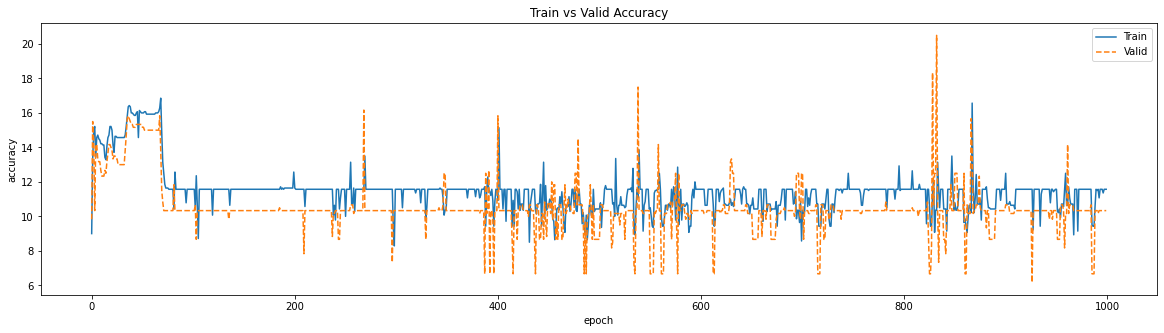

In [79]:
accuracy_plots(train_accu, eval_accu)

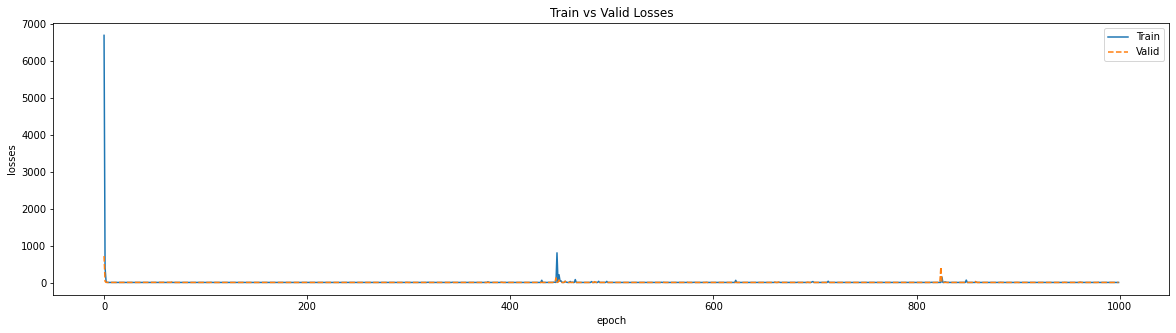

In [80]:
loss_plots(train_losses, eval_losses)

In [81]:
model = model_configs["3"]
model.load_state_dict(torch.load("models/best_model_parameters31.pth"))
model.eval()

model_3(
  (l1): Linear(in_features=784, out_features=400, bias=True)
  (r1): ReLU()
  (l2): Linear(in_features=400, out_features=200, bias=True)
  (r2): ReLU()
  (l3): Linear(in_features=200, out_features=10, bias=True)
)

In [82]:
with torch.no_grad():
  predicted_classes = []
  device = torch.device("cpu")
  for data in tqdm(first_five_loader):
    images,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(images)
    _, predicted = torch.max(outputs, 1)
    predicted_classes.append(predicted)


100%|██████████| 5/5 [00:00<00:00, 912.56it/s]


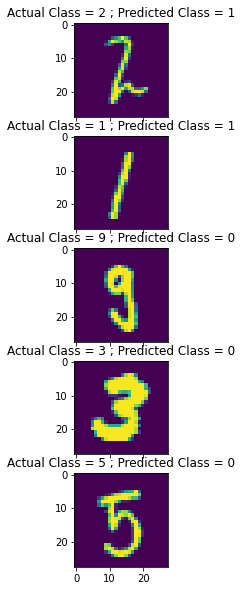

In [83]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for j in range(5):
  axs[j].imshow(first_five_test_images[j][0])
  axs[j].set_title(f"Actual Class = {first_five_test_image_labels[0+j]} ; Predicted Class = {predicted_classes[j].item()}")

for ax in axs.flat:
    ax.label_outer()

# model 3, training config 2:

In [84]:
s = time.time()
eval_losses, train_losses, eval_accu, train_accu = train("3", "2")
e = time.time()

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |   313600   |
|  l1.bias  |    400     |
| l2.weight |   80000    |
|  l2.bias  |    200     |
| l3.weight |    2000    |
|  l3.bias  |     10     |
+-----------+------------+
Total Trainable Params: 396210

Epoch : 1


100%|██████████| 2/2 [00:00<00:00, 55.52it/s]



Epoch : 2


100%|██████████| 2/2 [00:00<00:00, 55.92it/s]



Epoch : 3


100%|██████████| 2/2 [00:00<00:00, 58.80it/s]



Epoch : 4


100%|██████████| 2/2 [00:00<00:00, 59.84it/s]



Epoch : 5


100%|██████████| 2/2 [00:00<00:00, 61.65it/s]



Epoch : 6


100%|██████████| 2/2 [00:00<00:00, 60.30it/s]



Epoch : 7


100%|██████████| 2/2 [00:00<00:00, 56.82it/s]



Epoch : 8


100%|██████████| 2/2 [00:00<00:00, 57.88it/s]



Epoch : 9


100%|██████████| 2/2 [00:00<00:00, 62.35it/s]



Epoch : 10


100%|██████████| 2/2 [00:00<00:00, 62.40it/s]



Epoch : 11


100%|██████████| 2/2 [00:00<00:00, 63.98it/s]



Epoch : 12


100%|██████████| 2/2 [00:00<00:00, 60.48it/s]



Epoch : 13


100%|██████████| 2/2 [00:00<00:00, 66.82it/s]



Epoch : 14


100%|██████████| 2/2 [00:00<00:00, 64.10it/s]



Epoch : 15


100%|██████████| 2/2 [00:00<00:00, 64.37it/s]



Epoch : 16


100%|██████████| 2/2 [00:00<00:00, 65.00it/s]



Epoch : 17


100%|██████████| 2/2 [00:00<00:00, 66.31it/s]



Epoch : 18


100%|██████████| 2/2 [00:00<00:00, 67.19it/s]



Epoch : 19


100%|██████████| 2/2 [00:00<00:00, 64.47it/s]



Epoch : 20


100%|██████████| 2/2 [00:00<00:00, 64.19it/s]



Epoch : 21


100%|██████████| 2/2 [00:00<00:00, 65.89it/s]



Epoch : 22


100%|██████████| 2/2 [00:00<00:00, 61.56it/s]



Epoch : 23


100%|██████████| 2/2 [00:00<00:00, 56.14it/s]



Epoch : 24


100%|██████████| 2/2 [00:00<00:00, 67.90it/s]



Epoch : 25


100%|██████████| 2/2 [00:00<00:00, 64.90it/s]



Epoch : 26


100%|██████████| 2/2 [00:00<00:00, 66.75it/s]



Epoch : 27


100%|██████████| 2/2 [00:00<00:00, 69.50it/s]



Epoch : 28


100%|██████████| 2/2 [00:00<00:00, 68.01it/s]



Epoch : 29


100%|██████████| 2/2 [00:00<00:00, 61.15it/s]



Epoch : 30


100%|██████████| 2/2 [00:00<00:00, 68.32it/s]



Epoch : 31


100%|██████████| 2/2 [00:00<00:00, 67.24it/s]



Epoch : 32


100%|██████████| 2/2 [00:00<00:00, 67.47it/s]



Epoch : 33


100%|██████████| 2/2 [00:00<00:00, 69.85it/s]



Epoch : 34


100%|██████████| 2/2 [00:00<00:00, 71.36it/s]



Epoch : 35


100%|██████████| 2/2 [00:00<00:00, 65.27it/s]



Epoch : 36


100%|██████████| 2/2 [00:00<00:00, 68.94it/s]



Epoch : 37


100%|██████████| 2/2 [00:00<00:00, 59.17it/s]



Epoch : 38


100%|██████████| 2/2 [00:00<00:00, 64.47it/s]



Epoch : 39


100%|██████████| 2/2 [00:00<00:00, 52.50it/s]



Epoch : 40


100%|██████████| 2/2 [00:00<00:00, 69.55it/s]



Epoch : 41


100%|██████████| 2/2 [00:00<00:00, 67.95it/s]



Epoch : 42


100%|██████████| 2/2 [00:00<00:00, 68.79it/s]



Epoch : 43


100%|██████████| 2/2 [00:00<00:00, 64.16it/s]



Epoch : 44


100%|██████████| 2/2 [00:00<00:00, 70.72it/s]



Epoch : 45


100%|██████████| 2/2 [00:00<00:00, 67.59it/s]



Epoch : 46


100%|██████████| 2/2 [00:00<00:00, 73.30it/s]



Epoch : 47


100%|██████████| 2/2 [00:00<00:00, 70.62it/s]



Epoch : 48


100%|██████████| 2/2 [00:00<00:00, 66.45it/s]



Epoch : 49


100%|██████████| 2/2 [00:00<00:00, 68.95it/s]



Epoch : 50


100%|██████████| 2/2 [00:00<00:00, 65.81it/s]



Epoch : 51


100%|██████████| 2/2 [00:00<00:00, 70.00it/s]



Epoch : 52


100%|██████████| 2/2 [00:00<00:00, 66.45it/s]



Epoch : 53


100%|██████████| 2/2 [00:00<00:00, 71.12it/s]



Epoch : 54


100%|██████████| 2/2 [00:00<00:00, 72.55it/s]



Epoch : 55


100%|██████████| 2/2 [00:00<00:00, 70.18it/s]



Epoch : 56


100%|██████████| 2/2 [00:00<00:00, 67.80it/s]



Epoch : 57


100%|██████████| 2/2 [00:00<00:00, 66.22it/s]



Epoch : 58


100%|██████████| 2/2 [00:00<00:00, 67.55it/s]



Epoch : 59


100%|██████████| 2/2 [00:00<00:00, 62.00it/s]



Epoch : 60


100%|██████████| 2/2 [00:00<00:00, 66.43it/s]



Epoch : 61


100%|██████████| 2/2 [00:00<00:00, 70.60it/s]



Epoch : 62


100%|██████████| 2/2 [00:00<00:00, 71.92it/s]



Epoch : 63


100%|██████████| 2/2 [00:00<00:00, 60.24it/s]



Epoch : 64


100%|██████████| 2/2 [00:00<00:00, 72.74it/s]



Epoch : 65


100%|██████████| 2/2 [00:00<00:00, 74.76it/s]



Epoch : 66


100%|██████████| 2/2 [00:00<00:00, 71.79it/s]



Epoch : 67


100%|██████████| 2/2 [00:00<00:00, 63.28it/s]



Epoch : 68


100%|██████████| 2/2 [00:00<00:00, 70.32it/s]



Epoch : 69


100%|██████████| 2/2 [00:00<00:00, 68.13it/s]



Epoch : 70


100%|██████████| 2/2 [00:00<00:00, 73.89it/s]



Epoch : 71


100%|██████████| 2/2 [00:00<00:00, 82.90it/s]



Epoch : 72


100%|██████████| 2/2 [00:00<00:00, 69.70it/s]



Epoch : 73


100%|██████████| 2/2 [00:00<00:00, 75.02it/s]



Epoch : 74


100%|██████████| 2/2 [00:00<00:00, 68.07it/s]



Epoch : 75


100%|██████████| 2/2 [00:00<00:00, 71.97it/s]



Epoch : 76


100%|██████████| 2/2 [00:00<00:00, 75.91it/s]



Epoch : 77


100%|██████████| 2/2 [00:00<00:00, 61.33it/s]



Epoch : 78


100%|██████████| 2/2 [00:00<00:00, 77.30it/s]



Epoch : 79


100%|██████████| 2/2 [00:00<00:00, 72.12it/s]



Epoch : 80


100%|██████████| 2/2 [00:00<00:00, 69.48it/s]



Epoch : 81


100%|██████████| 2/2 [00:00<00:00, 78.86it/s]



Epoch : 82


100%|██████████| 2/2 [00:00<00:00, 66.80it/s]



Epoch : 83


100%|██████████| 2/2 [00:00<00:00, 74.75it/s]



Epoch : 84


100%|██████████| 2/2 [00:00<00:00, 69.50it/s]



Epoch : 85


100%|██████████| 2/2 [00:00<00:00, 72.92it/s]



Epoch : 86


100%|██████████| 2/2 [00:00<00:00, 59.61it/s]



Epoch : 87


100%|██████████| 2/2 [00:00<00:00, 75.91it/s]



Epoch : 88


100%|██████████| 2/2 [00:00<00:00, 69.00it/s]



Epoch : 89


100%|██████████| 2/2 [00:00<00:00, 71.54it/s]



Epoch : 90


100%|██████████| 2/2 [00:00<00:00, 70.49it/s]



Epoch : 91


100%|██████████| 2/2 [00:00<00:00, 77.75it/s]



Epoch : 92


100%|██████████| 2/2 [00:00<00:00, 63.72it/s]



Epoch : 93


100%|██████████| 2/2 [00:00<00:00, 72.55it/s]



Epoch : 94


100%|██████████| 2/2 [00:00<00:00, 65.69it/s]



Epoch : 95


100%|██████████| 2/2 [00:00<00:00, 68.27it/s]



Epoch : 96


100%|██████████| 2/2 [00:00<00:00, 73.49it/s]



Epoch : 97


100%|██████████| 2/2 [00:00<00:00, 77.11it/s]



Epoch : 98


100%|██████████| 2/2 [00:00<00:00, 70.50it/s]



Epoch : 99


100%|██████████| 2/2 [00:00<00:00, 72.54it/s]



Epoch : 100


100%|██████████| 2/2 [00:00<00:00, 72.19it/s]



Epoch : 101


100%|██████████| 2/2 [00:00<00:00, 67.21it/s]



Epoch : 102


100%|██████████| 2/2 [00:00<00:00, 69.26it/s]



Epoch : 103


100%|██████████| 2/2 [00:00<00:00, 73.93it/s]



Epoch : 104


100%|██████████| 2/2 [00:00<00:00, 78.05it/s]



Epoch : 105


100%|██████████| 2/2 [00:00<00:00, 73.46it/s]



Epoch : 106


100%|██████████| 2/2 [00:00<00:00, 80.24it/s]



Epoch : 107


100%|██████████| 2/2 [00:00<00:00, 70.96it/s]



Epoch : 108


100%|██████████| 2/2 [00:00<00:00, 75.23it/s]



Epoch : 109


100%|██████████| 2/2 [00:00<00:00, 72.50it/s]



Epoch : 110


100%|██████████| 2/2 [00:00<00:00, 68.90it/s]



Epoch : 111


100%|██████████| 2/2 [00:00<00:00, 73.19it/s]



Epoch : 112


100%|██████████| 2/2 [00:00<00:00, 70.61it/s]



Epoch : 113


100%|██████████| 2/2 [00:00<00:00, 60.13it/s]



Epoch : 114


100%|██████████| 2/2 [00:00<00:00, 71.37it/s]



Epoch : 115


100%|██████████| 2/2 [00:00<00:00, 59.15it/s]



Epoch : 116


100%|██████████| 2/2 [00:00<00:00, 71.47it/s]



Epoch : 117


100%|██████████| 2/2 [00:00<00:00, 74.30it/s]



Epoch : 118


100%|██████████| 2/2 [00:00<00:00, 65.04it/s]



Epoch : 119


100%|██████████| 2/2 [00:00<00:00, 69.13it/s]



Epoch : 120


100%|██████████| 2/2 [00:00<00:00, 79.88it/s]



Epoch : 121


100%|██████████| 2/2 [00:00<00:00, 70.55it/s]



Epoch : 122


100%|██████████| 2/2 [00:00<00:00, 73.41it/s]



Epoch : 123


100%|██████████| 2/2 [00:00<00:00, 75.71it/s]



Epoch : 124


100%|██████████| 2/2 [00:00<00:00, 68.98it/s]



Epoch : 125


100%|██████████| 2/2 [00:00<00:00, 76.11it/s]



Epoch : 126


100%|██████████| 2/2 [00:00<00:00, 71.11it/s]



Epoch : 127


100%|██████████| 2/2 [00:00<00:00, 68.63it/s]



Epoch : 128


100%|██████████| 2/2 [00:00<00:00, 72.68it/s]



Epoch : 129


100%|██████████| 2/2 [00:00<00:00, 58.36it/s]



Epoch : 130


100%|██████████| 2/2 [00:00<00:00, 65.85it/s]



Epoch : 131


100%|██████████| 2/2 [00:00<00:00, 71.73it/s]



Epoch : 132


100%|██████████| 2/2 [00:00<00:00, 75.85it/s]



Epoch : 133


100%|██████████| 2/2 [00:00<00:00, 67.00it/s]



Epoch : 134


100%|██████████| 2/2 [00:00<00:00, 64.65it/s]



Epoch : 135


100%|██████████| 2/2 [00:00<00:00, 70.09it/s]



Epoch : 136


100%|██████████| 2/2 [00:00<00:00, 72.81it/s]



Epoch : 137


100%|██████████| 2/2 [00:00<00:00, 70.55it/s]



Epoch : 138


100%|██████████| 2/2 [00:00<00:00, 71.61it/s]



Epoch : 139


100%|██████████| 2/2 [00:00<00:00, 68.28it/s]



Epoch : 140


100%|██████████| 2/2 [00:00<00:00, 80.32it/s]



Epoch : 141


100%|██████████| 2/2 [00:00<00:00, 78.80it/s]



Epoch : 142


100%|██████████| 2/2 [00:00<00:00, 72.08it/s]



Epoch : 143


100%|██████████| 2/2 [00:00<00:00, 75.26it/s]



Epoch : 144


100%|██████████| 2/2 [00:00<00:00, 66.11it/s]



Epoch : 145


100%|██████████| 2/2 [00:00<00:00, 71.43it/s]



Epoch : 146


100%|██████████| 2/2 [00:00<00:00, 60.01it/s]



Epoch : 147


100%|██████████| 2/2 [00:00<00:00, 74.66it/s]



Epoch : 148


100%|██████████| 2/2 [00:00<00:00, 73.60it/s]



Epoch : 149


100%|██████████| 2/2 [00:00<00:00, 62.50it/s]



Epoch : 150


100%|██████████| 2/2 [00:00<00:00, 77.33it/s]



Epoch : 151


100%|██████████| 2/2 [00:00<00:00, 79.81it/s]



Epoch : 152


100%|██████████| 2/2 [00:00<00:00, 65.89it/s]



Epoch : 153


100%|██████████| 2/2 [00:00<00:00, 71.11it/s]



Epoch : 154


100%|██████████| 2/2 [00:00<00:00, 71.11it/s]



Epoch : 155


100%|██████████| 2/2 [00:00<00:00, 71.96it/s]



Epoch : 156


100%|██████████| 2/2 [00:00<00:00, 86.00it/s]



Epoch : 157


100%|██████████| 2/2 [00:00<00:00, 59.83it/s]



Epoch : 158


100%|██████████| 2/2 [00:00<00:00, 72.58it/s]



Epoch : 159


100%|██████████| 2/2 [00:00<00:00, 77.96it/s]



Epoch : 160


100%|██████████| 2/2 [00:00<00:00, 74.65it/s]



Epoch : 161


100%|██████████| 2/2 [00:00<00:00, 61.03it/s]



Epoch : 162


100%|██████████| 2/2 [00:00<00:00, 79.67it/s]



Epoch : 163


100%|██████████| 2/2 [00:00<00:00, 76.40it/s]



Epoch : 164


100%|██████████| 2/2 [00:00<00:00, 71.00it/s]



Epoch : 165


100%|██████████| 2/2 [00:00<00:00, 72.26it/s]



Epoch : 166


100%|██████████| 2/2 [00:00<00:00, 73.45it/s]



Epoch : 167


100%|██████████| 2/2 [00:00<00:00, 61.57it/s]



Epoch : 168


100%|██████████| 2/2 [00:00<00:00, 74.27it/s]



Epoch : 169


100%|██████████| 2/2 [00:00<00:00, 70.27it/s]



Epoch : 170


100%|██████████| 2/2 [00:00<00:00, 75.26it/s]



Epoch : 171


100%|██████████| 2/2 [00:00<00:00, 82.45it/s]



Epoch : 172


100%|██████████| 2/2 [00:00<00:00, 76.32it/s]



Epoch : 173


100%|██████████| 2/2 [00:00<00:00, 76.58it/s]



Epoch : 174


100%|██████████| 2/2 [00:00<00:00, 73.01it/s]



Epoch : 175


100%|██████████| 2/2 [00:00<00:00, 73.04it/s]



Epoch : 176


100%|██████████| 2/2 [00:00<00:00, 71.98it/s]



Epoch : 177


100%|██████████| 2/2 [00:00<00:00, 62.58it/s]



Epoch : 178


100%|██████████| 2/2 [00:00<00:00, 71.19it/s]



Epoch : 179


100%|██████████| 2/2 [00:00<00:00, 67.99it/s]



Epoch : 180


100%|██████████| 2/2 [00:00<00:00, 73.54it/s]



Epoch : 181


100%|██████████| 2/2 [00:00<00:00, 71.97it/s]



Epoch : 182


100%|██████████| 2/2 [00:00<00:00, 66.32it/s]



Epoch : 183


100%|██████████| 2/2 [00:00<00:00, 70.99it/s]



Epoch : 184


100%|██████████| 2/2 [00:00<00:00, 70.36it/s]



Epoch : 185


100%|██████████| 2/2 [00:00<00:00, 73.10it/s]



Epoch : 186


100%|██████████| 2/2 [00:00<00:00, 74.06it/s]



Epoch : 187


100%|██████████| 2/2 [00:00<00:00, 60.32it/s]



Epoch : 188


100%|██████████| 2/2 [00:00<00:00, 67.50it/s]



Epoch : 189


100%|██████████| 2/2 [00:00<00:00, 66.57it/s]



Epoch : 190


100%|██████████| 2/2 [00:00<00:00, 77.78it/s]



Epoch : 191


100%|██████████| 2/2 [00:00<00:00, 70.68it/s]



Epoch : 192


100%|██████████| 2/2 [00:00<00:00, 62.26it/s]



Epoch : 193


100%|██████████| 2/2 [00:00<00:00, 68.83it/s]



Epoch : 194


100%|██████████| 2/2 [00:00<00:00, 65.04it/s]



Epoch : 195


100%|██████████| 2/2 [00:00<00:00, 70.45it/s]



Epoch : 196


100%|██████████| 2/2 [00:00<00:00, 70.38it/s]



Epoch : 197


100%|██████████| 2/2 [00:00<00:00, 52.68it/s]



Epoch : 198


100%|██████████| 2/2 [00:00<00:00, 57.98it/s]



Epoch : 199


100%|██████████| 2/2 [00:00<00:00, 69.34it/s]



Epoch : 200


100%|██████████| 2/2 [00:00<00:00, 68.66it/s]



Epoch : 201


100%|██████████| 2/2 [00:00<00:00, 69.07it/s]



Epoch : 202


100%|██████████| 2/2 [00:00<00:00, 65.70it/s]



Epoch : 203


100%|██████████| 2/2 [00:00<00:00, 67.14it/s]



Epoch : 204


100%|██████████| 2/2 [00:00<00:00, 66.86it/s]



Epoch : 205


100%|██████████| 2/2 [00:00<00:00, 68.41it/s]



Epoch : 206


100%|██████████| 2/2 [00:00<00:00, 69.78it/s]



Epoch : 207


100%|██████████| 2/2 [00:00<00:00, 69.94it/s]



Epoch : 208


100%|██████████| 2/2 [00:00<00:00, 69.99it/s]



Epoch : 209


100%|██████████| 2/2 [00:00<00:00, 64.52it/s]



Epoch : 210


100%|██████████| 2/2 [00:00<00:00, 73.17it/s]



Epoch : 211


100%|██████████| 2/2 [00:00<00:00, 73.27it/s]



Epoch : 212


100%|██████████| 2/2 [00:00<00:00, 67.88it/s]



Epoch : 213


100%|██████████| 2/2 [00:00<00:00, 68.87it/s]



Epoch : 214


100%|██████████| 2/2 [00:00<00:00, 70.60it/s]



Epoch : 215


100%|██████████| 2/2 [00:00<00:00, 69.30it/s]



Epoch : 216


100%|██████████| 2/2 [00:00<00:00, 64.44it/s]



Epoch : 217


100%|██████████| 2/2 [00:00<00:00, 70.67it/s]



Epoch : 218


100%|██████████| 2/2 [00:00<00:00, 66.75it/s]



Epoch : 219


100%|██████████| 2/2 [00:00<00:00, 75.34it/s]



Epoch : 220


100%|██████████| 2/2 [00:00<00:00, 72.50it/s]



Epoch : 221


100%|██████████| 2/2 [00:00<00:00, 74.90it/s]



Epoch : 222


100%|██████████| 2/2 [00:00<00:00, 75.55it/s]



Epoch : 223


100%|██████████| 2/2 [00:00<00:00, 68.96it/s]



Epoch : 224


100%|██████████| 2/2 [00:00<00:00, 65.75it/s]



Epoch : 225


100%|██████████| 2/2 [00:00<00:00, 69.10it/s]



Epoch : 226


100%|██████████| 2/2 [00:00<00:00, 63.51it/s]



Epoch : 227


100%|██████████| 2/2 [00:00<00:00, 65.02it/s]



Epoch : 228


100%|██████████| 2/2 [00:00<00:00, 68.49it/s]



Epoch : 229


100%|██████████| 2/2 [00:00<00:00, 62.76it/s]



Epoch : 230


100%|██████████| 2/2 [00:00<00:00, 63.81it/s]



Epoch : 231


100%|██████████| 2/2 [00:00<00:00, 72.36it/s]



Epoch : 232


100%|██████████| 2/2 [00:00<00:00, 67.83it/s]



Epoch : 233


100%|██████████| 2/2 [00:00<00:00, 64.14it/s]



Epoch : 234


100%|██████████| 2/2 [00:00<00:00, 76.78it/s]



Epoch : 235


100%|██████████| 2/2 [00:00<00:00, 66.60it/s]



Epoch : 236


100%|██████████| 2/2 [00:00<00:00, 74.87it/s]



Epoch : 237


100%|██████████| 2/2 [00:00<00:00, 66.19it/s]



Epoch : 238


100%|██████████| 2/2 [00:00<00:00, 66.25it/s]



Epoch : 239


100%|██████████| 2/2 [00:00<00:00, 67.36it/s]



Epoch : 240


100%|██████████| 2/2 [00:00<00:00, 60.64it/s]



Epoch : 241


100%|██████████| 2/2 [00:00<00:00, 67.89it/s]



Epoch : 242


100%|██████████| 2/2 [00:00<00:00, 65.95it/s]



Epoch : 243


100%|██████████| 2/2 [00:00<00:00, 67.74it/s]



Epoch : 244


100%|██████████| 2/2 [00:00<00:00, 65.47it/s]



Epoch : 245


100%|██████████| 2/2 [00:00<00:00, 63.88it/s]



Epoch : 246


100%|██████████| 2/2 [00:00<00:00, 55.95it/s]



Epoch : 247


100%|██████████| 2/2 [00:00<00:00, 63.70it/s]



Epoch : 248


100%|██████████| 2/2 [00:00<00:00, 66.30it/s]



Epoch : 249


100%|██████████| 2/2 [00:00<00:00, 66.20it/s]



Epoch : 250


100%|██████████| 2/2 [00:00<00:00, 65.58it/s]



Epoch : 251


100%|██████████| 2/2 [00:00<00:00, 62.73it/s]



Epoch : 252


100%|██████████| 2/2 [00:00<00:00, 66.46it/s]



Epoch : 253


100%|██████████| 2/2 [00:00<00:00, 57.20it/s]



Epoch : 254


100%|██████████| 2/2 [00:00<00:00, 63.56it/s]



Epoch : 255


100%|██████████| 2/2 [00:00<00:00, 68.41it/s]



Epoch : 256


100%|██████████| 2/2 [00:00<00:00, 64.06it/s]



Epoch : 257


100%|██████████| 2/2 [00:00<00:00, 64.07it/s]



Epoch : 258


100%|██████████| 2/2 [00:00<00:00, 66.53it/s]



Epoch : 259


100%|██████████| 2/2 [00:00<00:00, 61.38it/s]



Epoch : 260


100%|██████████| 2/2 [00:00<00:00, 77.41it/s]



Epoch : 261


100%|██████████| 2/2 [00:00<00:00, 66.13it/s]



Epoch : 262


100%|██████████| 2/2 [00:00<00:00, 70.75it/s]



Epoch : 263


100%|██████████| 2/2 [00:00<00:00, 73.04it/s]



Epoch : 264


100%|██████████| 2/2 [00:00<00:00, 54.58it/s]



Epoch : 265


100%|██████████| 2/2 [00:00<00:00, 60.23it/s]



Epoch : 266


100%|██████████| 2/2 [00:00<00:00, 72.86it/s]



Epoch : 267


100%|██████████| 2/2 [00:00<00:00, 70.18it/s]



Epoch : 268


100%|██████████| 2/2 [00:00<00:00, 67.08it/s]



Epoch : 269


100%|██████████| 2/2 [00:00<00:00, 69.48it/s]



Epoch : 270


100%|██████████| 2/2 [00:00<00:00, 59.50it/s]



Epoch : 271


100%|██████████| 2/2 [00:00<00:00, 64.47it/s]



Epoch : 272


100%|██████████| 2/2 [00:00<00:00, 64.63it/s]



Epoch : 273


100%|██████████| 2/2 [00:00<00:00, 70.31it/s]



Epoch : 274


100%|██████████| 2/2 [00:00<00:00, 62.82it/s]



Epoch : 275


100%|██████████| 2/2 [00:00<00:00, 53.01it/s]



Epoch : 276


100%|██████████| 2/2 [00:00<00:00, 71.23it/s]



Epoch : 277


100%|██████████| 2/2 [00:00<00:00, 66.72it/s]



Epoch : 278


100%|██████████| 2/2 [00:00<00:00, 57.91it/s]



Epoch : 279


100%|██████████| 2/2 [00:00<00:00, 65.75it/s]



Epoch : 280


100%|██████████| 2/2 [00:00<00:00, 62.45it/s]



Epoch : 281


100%|██████████| 2/2 [00:00<00:00, 56.99it/s]



Epoch : 282


100%|██████████| 2/2 [00:00<00:00, 59.47it/s]



Epoch : 283


100%|██████████| 2/2 [00:00<00:00, 65.31it/s]



Epoch : 284


100%|██████████| 2/2 [00:00<00:00, 64.42it/s]



Epoch : 285


100%|██████████| 2/2 [00:00<00:00, 68.65it/s]



Epoch : 286


100%|██████████| 2/2 [00:00<00:00, 65.30it/s]



Epoch : 287


100%|██████████| 2/2 [00:00<00:00, 64.07it/s]



Epoch : 288


100%|██████████| 2/2 [00:00<00:00, 61.73it/s]



Epoch : 289


100%|██████████| 2/2 [00:00<00:00, 65.04it/s]



Epoch : 290


100%|██████████| 2/2 [00:00<00:00, 66.73it/s]



Epoch : 291


100%|██████████| 2/2 [00:00<00:00, 65.69it/s]



Epoch : 292


100%|██████████| 2/2 [00:00<00:00, 70.49it/s]



Epoch : 293


100%|██████████| 2/2 [00:00<00:00, 58.30it/s]



Epoch : 294


100%|██████████| 2/2 [00:00<00:00, 64.50it/s]



Epoch : 295


100%|██████████| 2/2 [00:00<00:00, 60.07it/s]



Epoch : 296


100%|██████████| 2/2 [00:00<00:00, 64.86it/s]



Epoch : 297


100%|██████████| 2/2 [00:00<00:00, 52.97it/s]



Epoch : 298


100%|██████████| 2/2 [00:00<00:00, 53.22it/s]



Epoch : 299


100%|██████████| 2/2 [00:00<00:00, 57.90it/s]



Epoch : 300


100%|██████████| 2/2 [00:00<00:00, 49.66it/s]



Epoch : 301


100%|██████████| 2/2 [00:00<00:00, 57.48it/s]



Epoch : 302


100%|██████████| 2/2 [00:00<00:00, 57.23it/s]



Epoch : 303


100%|██████████| 2/2 [00:00<00:00, 59.10it/s]



Epoch : 304


100%|██████████| 2/2 [00:00<00:00, 57.38it/s]



Epoch : 305


100%|██████████| 2/2 [00:00<00:00, 50.07it/s]



Epoch : 306


100%|██████████| 2/2 [00:00<00:00, 53.67it/s]



Epoch : 307


100%|██████████| 2/2 [00:00<00:00, 51.97it/s]



Epoch : 308


100%|██████████| 2/2 [00:00<00:00, 65.33it/s]



Epoch : 309


100%|██████████| 2/2 [00:00<00:00, 63.15it/s]



Epoch : 310


100%|██████████| 2/2 [00:00<00:00, 62.21it/s]



Epoch : 311


100%|██████████| 2/2 [00:00<00:00, 58.48it/s]



Epoch : 312


100%|██████████| 2/2 [00:00<00:00, 60.05it/s]



Epoch : 313


100%|██████████| 2/2 [00:00<00:00, 64.02it/s]



Epoch : 314


100%|██████████| 2/2 [00:00<00:00, 64.45it/s]



Epoch : 315


100%|██████████| 2/2 [00:00<00:00, 61.10it/s]



Epoch : 316


100%|██████████| 2/2 [00:00<00:00, 47.87it/s]



Epoch : 317


100%|██████████| 2/2 [00:00<00:00, 53.57it/s]



Epoch : 318


100%|██████████| 2/2 [00:00<00:00, 66.20it/s]



Epoch : 319


100%|██████████| 2/2 [00:00<00:00, 57.40it/s]



Epoch : 320


100%|██████████| 2/2 [00:00<00:00, 61.12it/s]



Epoch : 321


100%|██████████| 2/2 [00:00<00:00, 48.25it/s]



Epoch : 322


100%|██████████| 2/2 [00:00<00:00, 52.31it/s]



Epoch : 323


100%|██████████| 2/2 [00:00<00:00, 56.87it/s]



Epoch : 324


100%|██████████| 2/2 [00:00<00:00, 59.18it/s]



Epoch : 325


100%|██████████| 2/2 [00:00<00:00, 58.26it/s]



Epoch : 326


100%|██████████| 2/2 [00:00<00:00, 53.58it/s]



Epoch : 327


100%|██████████| 2/2 [00:00<00:00, 59.81it/s]



Epoch : 328


100%|██████████| 2/2 [00:00<00:00, 44.75it/s]



Epoch : 329


100%|██████████| 2/2 [00:00<00:00, 57.96it/s]



Epoch : 330


100%|██████████| 2/2 [00:00<00:00, 57.68it/s]



Epoch : 331


100%|██████████| 2/2 [00:00<00:00, 51.83it/s]



Epoch : 332


100%|██████████| 2/2 [00:00<00:00, 52.86it/s]



Epoch : 333


100%|██████████| 2/2 [00:00<00:00, 56.65it/s]



Epoch : 334


100%|██████████| 2/2 [00:00<00:00, 47.29it/s]



Epoch : 335


100%|██████████| 2/2 [00:00<00:00, 54.38it/s]



Epoch : 336


100%|██████████| 2/2 [00:00<00:00, 56.89it/s]



Epoch : 337


100%|██████████| 2/2 [00:00<00:00, 46.78it/s]



Epoch : 338


100%|██████████| 2/2 [00:00<00:00, 53.23it/s]



Epoch : 339


100%|██████████| 2/2 [00:00<00:00, 47.31it/s]



Epoch : 340


100%|██████████| 2/2 [00:00<00:00, 51.49it/s]



Epoch : 341


100%|██████████| 2/2 [00:00<00:00, 43.39it/s]



Epoch : 342


100%|██████████| 2/2 [00:00<00:00, 56.29it/s]



Epoch : 343


100%|██████████| 2/2 [00:00<00:00, 53.57it/s]



Epoch : 344


100%|██████████| 2/2 [00:00<00:00, 54.20it/s]



Epoch : 345


100%|██████████| 2/2 [00:00<00:00, 46.13it/s]



Epoch : 346


100%|██████████| 2/2 [00:00<00:00, 60.54it/s]



Epoch : 347


100%|██████████| 2/2 [00:00<00:00, 60.13it/s]



Epoch : 348


100%|██████████| 2/2 [00:00<00:00, 40.24it/s]



Epoch : 349


100%|██████████| 2/2 [00:00<00:00, 62.04it/s]



Epoch : 350


100%|██████████| 2/2 [00:00<00:00, 52.23it/s]



Epoch : 351


100%|██████████| 2/2 [00:00<00:00, 43.60it/s]



Epoch : 352


100%|██████████| 2/2 [00:00<00:00, 55.56it/s]



Epoch : 353


100%|██████████| 2/2 [00:00<00:00, 53.88it/s]



Epoch : 354


100%|██████████| 2/2 [00:00<00:00, 54.94it/s]



Epoch : 355


100%|██████████| 2/2 [00:00<00:00, 47.18it/s]



Epoch : 356


100%|██████████| 2/2 [00:00<00:00, 56.87it/s]



Epoch : 357


100%|██████████| 2/2 [00:00<00:00, 46.69it/s]



Epoch : 358


100%|██████████| 2/2 [00:00<00:00, 59.47it/s]



Epoch : 359


100%|██████████| 2/2 [00:00<00:00, 52.06it/s]



Epoch : 360


100%|██████████| 2/2 [00:00<00:00, 49.94it/s]



Epoch : 361


100%|██████████| 2/2 [00:00<00:00, 56.67it/s]



Epoch : 362


100%|██████████| 2/2 [00:00<00:00, 56.85it/s]



Epoch : 363


100%|██████████| 2/2 [00:00<00:00, 55.51it/s]



Epoch : 364


100%|██████████| 2/2 [00:00<00:00, 61.46it/s]



Epoch : 365


100%|██████████| 2/2 [00:00<00:00, 51.66it/s]



Epoch : 366


100%|██████████| 2/2 [00:00<00:00, 44.13it/s]



Epoch : 367


100%|██████████| 2/2 [00:00<00:00, 60.09it/s]



Epoch : 368


100%|██████████| 2/2 [00:00<00:00, 62.83it/s]



Epoch : 369


100%|██████████| 2/2 [00:00<00:00, 65.87it/s]



Epoch : 370


100%|██████████| 2/2 [00:00<00:00, 62.71it/s]



Epoch : 371


100%|██████████| 2/2 [00:00<00:00, 67.48it/s]



Epoch : 372


100%|██████████| 2/2 [00:00<00:00, 68.26it/s]



Epoch : 373


100%|██████████| 2/2 [00:00<00:00, 67.98it/s]



Epoch : 374


100%|██████████| 2/2 [00:00<00:00, 68.77it/s]



Epoch : 375


100%|██████████| 2/2 [00:00<00:00, 64.23it/s]



Epoch : 376


100%|██████████| 2/2 [00:00<00:00, 66.42it/s]



Epoch : 377


100%|██████████| 2/2 [00:00<00:00, 81.34it/s]



Epoch : 378


100%|██████████| 2/2 [00:00<00:00, 72.29it/s]



Epoch : 379


100%|██████████| 2/2 [00:00<00:00, 68.07it/s]



Epoch : 380


100%|██████████| 2/2 [00:00<00:00, 71.06it/s]



Epoch : 381


100%|██████████| 2/2 [00:00<00:00, 67.87it/s]



Epoch : 382


100%|██████████| 2/2 [00:00<00:00, 80.47it/s]



Epoch : 383


100%|██████████| 2/2 [00:00<00:00, 85.21it/s]



Epoch : 384


100%|██████████| 2/2 [00:00<00:00, 87.07it/s]



Epoch : 385


100%|██████████| 2/2 [00:00<00:00, 68.52it/s]



Epoch : 386


100%|██████████| 2/2 [00:00<00:00, 87.60it/s]



Epoch : 387


100%|██████████| 2/2 [00:00<00:00, 75.92it/s]



Epoch : 388


100%|██████████| 2/2 [00:00<00:00, 68.23it/s]



Epoch : 389


100%|██████████| 2/2 [00:00<00:00, 89.18it/s]



Epoch : 390


100%|██████████| 2/2 [00:00<00:00, 72.73it/s]



Epoch : 391


100%|██████████| 2/2 [00:00<00:00, 69.71it/s]



Epoch : 392


100%|██████████| 2/2 [00:00<00:00, 81.40it/s]



Epoch : 393


100%|██████████| 2/2 [00:00<00:00, 70.63it/s]



Epoch : 394


100%|██████████| 2/2 [00:00<00:00, 71.60it/s]



Epoch : 395


100%|██████████| 2/2 [00:00<00:00, 89.80it/s]



Epoch : 396


100%|██████████| 2/2 [00:00<00:00, 73.38it/s]



Epoch : 397


100%|██████████| 2/2 [00:00<00:00, 65.71it/s]



Epoch : 398


100%|██████████| 2/2 [00:00<00:00, 87.15it/s]



Epoch : 399


100%|██████████| 2/2 [00:00<00:00, 70.83it/s]



Epoch : 400


100%|██████████| 2/2 [00:00<00:00, 69.48it/s]



Epoch : 401


100%|██████████| 2/2 [00:00<00:00, 72.57it/s]



Epoch : 402


100%|██████████| 2/2 [00:00<00:00, 76.08it/s]



Epoch : 403


100%|██████████| 2/2 [00:00<00:00, 66.24it/s]



Epoch : 404


100%|██████████| 2/2 [00:00<00:00, 70.86it/s]



Epoch : 405


100%|██████████| 2/2 [00:00<00:00, 60.21it/s]



Epoch : 406


100%|██████████| 2/2 [00:00<00:00, 72.11it/s]



Epoch : 407


100%|██████████| 2/2 [00:00<00:00, 74.01it/s]



Epoch : 408


100%|██████████| 2/2 [00:00<00:00, 72.21it/s]



Epoch : 409


100%|██████████| 2/2 [00:00<00:00, 72.10it/s]



Epoch : 410


100%|██████████| 2/2 [00:00<00:00, 68.63it/s]



Epoch : 411


100%|██████████| 2/2 [00:00<00:00, 72.23it/s]



Epoch : 412


100%|██████████| 2/2 [00:00<00:00, 52.04it/s]



Epoch : 413


100%|██████████| 2/2 [00:00<00:00, 74.17it/s]



Epoch : 414


100%|██████████| 2/2 [00:00<00:00, 75.31it/s]



Epoch : 415


100%|██████████| 2/2 [00:00<00:00, 71.07it/s]



Epoch : 416


100%|██████████| 2/2 [00:00<00:00, 71.92it/s]



Epoch : 417


100%|██████████| 2/2 [00:00<00:00, 68.53it/s]



Epoch : 418


100%|██████████| 2/2 [00:00<00:00, 67.01it/s]



Epoch : 419


100%|██████████| 2/2 [00:00<00:00, 79.81it/s]



Epoch : 420


100%|██████████| 2/2 [00:00<00:00, 72.03it/s]



Epoch : 421


100%|██████████| 2/2 [00:00<00:00, 64.36it/s]



Epoch : 422


100%|██████████| 2/2 [00:00<00:00, 72.00it/s]



Epoch : 423


100%|██████████| 2/2 [00:00<00:00, 82.29it/s]



Epoch : 424


100%|██████████| 2/2 [00:00<00:00, 68.21it/s]



Epoch : 425


100%|██████████| 2/2 [00:00<00:00, 67.74it/s]



Epoch : 426


100%|██████████| 2/2 [00:00<00:00, 73.12it/s]



Epoch : 427


100%|██████████| 2/2 [00:00<00:00, 62.66it/s]



Epoch : 428


100%|██████████| 2/2 [00:00<00:00, 71.08it/s]



Epoch : 429


100%|██████████| 2/2 [00:00<00:00, 69.08it/s]



Epoch : 430


100%|██████████| 2/2 [00:00<00:00, 74.67it/s]



Epoch : 431


100%|██████████| 2/2 [00:00<00:00, 70.73it/s]



Epoch : 432


100%|██████████| 2/2 [00:00<00:00, 71.32it/s]



Epoch : 433


100%|██████████| 2/2 [00:00<00:00, 71.57it/s]



Epoch : 434


100%|██████████| 2/2 [00:00<00:00, 66.66it/s]



Epoch : 435


100%|██████████| 2/2 [00:00<00:00, 70.43it/s]



Epoch : 436


100%|██████████| 2/2 [00:00<00:00, 70.34it/s]



Epoch : 437


100%|██████████| 2/2 [00:00<00:00, 67.00it/s]



Epoch : 438


100%|██████████| 2/2 [00:00<00:00, 63.49it/s]



Epoch : 439


100%|██████████| 2/2 [00:00<00:00, 69.72it/s]



Epoch : 440


100%|██████████| 2/2 [00:00<00:00, 70.37it/s]



Epoch : 441


100%|██████████| 2/2 [00:00<00:00, 49.54it/s]



Epoch : 442


100%|██████████| 2/2 [00:00<00:00, 66.76it/s]



Epoch : 443


100%|██████████| 2/2 [00:00<00:00, 66.32it/s]



Epoch : 444


100%|██████████| 2/2 [00:00<00:00, 73.06it/s]



Epoch : 445


100%|██████████| 2/2 [00:00<00:00, 73.60it/s]



Epoch : 446


100%|██████████| 2/2 [00:00<00:00, 70.31it/s]



Epoch : 447


100%|██████████| 2/2 [00:00<00:00, 70.66it/s]



Epoch : 448


100%|██████████| 2/2 [00:00<00:00, 67.76it/s]



Epoch : 449


100%|██████████| 2/2 [00:00<00:00, 67.95it/s]



Epoch : 450


100%|██████████| 2/2 [00:00<00:00, 74.08it/s]



Epoch : 451


100%|██████████| 2/2 [00:00<00:00, 69.44it/s]



Epoch : 452


100%|██████████| 2/2 [00:00<00:00, 66.51it/s]



Epoch : 453


100%|██████████| 2/2 [00:00<00:00, 70.79it/s]



Epoch : 454


100%|██████████| 2/2 [00:00<00:00, 70.05it/s]



Epoch : 455


100%|██████████| 2/2 [00:00<00:00, 67.80it/s]



Epoch : 456


100%|██████████| 2/2 [00:00<00:00, 68.64it/s]



Epoch : 457


100%|██████████| 2/2 [00:00<00:00, 67.31it/s]



Epoch : 458


100%|██████████| 2/2 [00:00<00:00, 67.41it/s]



Epoch : 459


100%|██████████| 2/2 [00:00<00:00, 67.91it/s]



Epoch : 460


100%|██████████| 2/2 [00:00<00:00, 56.71it/s]



Epoch : 461


100%|██████████| 2/2 [00:00<00:00, 70.30it/s]



Epoch : 462


100%|██████████| 2/2 [00:00<00:00, 67.48it/s]



Epoch : 463


100%|██████████| 2/2 [00:00<00:00, 67.46it/s]



Epoch : 464


100%|██████████| 2/2 [00:00<00:00, 67.48it/s]



Epoch : 465


100%|██████████| 2/2 [00:00<00:00, 64.55it/s]



Epoch : 466


100%|██████████| 2/2 [00:00<00:00, 64.58it/s]



Epoch : 467


100%|██████████| 2/2 [00:00<00:00, 64.43it/s]



Epoch : 468


100%|██████████| 2/2 [00:00<00:00, 62.56it/s]



Epoch : 469


100%|██████████| 2/2 [00:00<00:00, 63.64it/s]



Epoch : 470


100%|██████████| 2/2 [00:00<00:00, 75.48it/s]



Epoch : 471


100%|██████████| 2/2 [00:00<00:00, 62.49it/s]



Epoch : 472


100%|██████████| 2/2 [00:00<00:00, 64.53it/s]



Epoch : 473


100%|██████████| 2/2 [00:00<00:00, 50.87it/s]



Epoch : 474


100%|██████████| 2/2 [00:00<00:00, 63.29it/s]



Epoch : 475


100%|██████████| 2/2 [00:00<00:00, 61.39it/s]



Epoch : 476


100%|██████████| 2/2 [00:00<00:00, 61.34it/s]



Epoch : 477


100%|██████████| 2/2 [00:00<00:00, 65.52it/s]



Epoch : 478


100%|██████████| 2/2 [00:00<00:00, 61.39it/s]



Epoch : 479


100%|██████████| 2/2 [00:00<00:00, 69.71it/s]



Epoch : 480


100%|██████████| 2/2 [00:00<00:00, 62.43it/s]



Epoch : 481


100%|██████████| 2/2 [00:00<00:00, 60.79it/s]



Epoch : 482


100%|██████████| 2/2 [00:00<00:00, 61.94it/s]



Epoch : 483


100%|██████████| 2/2 [00:00<00:00, 65.06it/s]



Epoch : 484


100%|██████████| 2/2 [00:00<00:00, 66.39it/s]



Epoch : 485


100%|██████████| 2/2 [00:00<00:00, 64.84it/s]



Epoch : 486


100%|██████████| 2/2 [00:00<00:00, 63.97it/s]



Epoch : 487


100%|██████████| 2/2 [00:00<00:00, 63.90it/s]



Epoch : 488


100%|██████████| 2/2 [00:00<00:00, 62.94it/s]



Epoch : 489


100%|██████████| 2/2 [00:00<00:00, 63.50it/s]



Epoch : 490


100%|██████████| 2/2 [00:00<00:00, 56.67it/s]



Epoch : 491


100%|██████████| 2/2 [00:00<00:00, 52.68it/s]



Epoch : 492


100%|██████████| 2/2 [00:00<00:00, 62.23it/s]



Epoch : 493


100%|██████████| 2/2 [00:00<00:00, 62.86it/s]



Epoch : 494


100%|██████████| 2/2 [00:00<00:00, 54.74it/s]



Epoch : 495


100%|██████████| 2/2 [00:00<00:00, 61.11it/s]



Epoch : 496


100%|██████████| 2/2 [00:00<00:00, 59.12it/s]



Epoch : 497


100%|██████████| 2/2 [00:00<00:00, 60.83it/s]



Epoch : 498


100%|██████████| 2/2 [00:00<00:00, 55.92it/s]



Epoch : 499


100%|██████████| 2/2 [00:00<00:00, 55.97it/s]



Epoch : 500


100%|██████████| 2/2 [00:00<00:00, 59.72it/s]



Epoch : 501


100%|██████████| 2/2 [00:00<00:00, 62.03it/s]



Epoch : 502


100%|██████████| 2/2 [00:00<00:00, 61.33it/s]



Epoch : 503


100%|██████████| 2/2 [00:00<00:00, 60.08it/s]



Epoch : 504


100%|██████████| 2/2 [00:00<00:00, 44.19it/s]



Epoch : 505


100%|██████████| 2/2 [00:00<00:00, 60.15it/s]



Epoch : 506


100%|██████████| 2/2 [00:00<00:00, 54.89it/s]



Epoch : 507


100%|██████████| 2/2 [00:00<00:00, 54.44it/s]



Epoch : 508


100%|██████████| 2/2 [00:00<00:00, 50.59it/s]



Epoch : 509


100%|██████████| 2/2 [00:00<00:00, 48.48it/s]



Epoch : 510


100%|██████████| 2/2 [00:00<00:00, 53.00it/s]



Epoch : 511


100%|██████████| 2/2 [00:00<00:00, 55.54it/s]



Epoch : 512


100%|██████████| 2/2 [00:00<00:00, 52.76it/s]



Epoch : 513


100%|██████████| 2/2 [00:00<00:00, 49.36it/s]



Epoch : 514


100%|██████████| 2/2 [00:00<00:00, 41.50it/s]



Epoch : 515


100%|██████████| 2/2 [00:00<00:00, 45.04it/s]



Epoch : 516


100%|██████████| 2/2 [00:00<00:00, 47.14it/s]



Epoch : 517


100%|██████████| 2/2 [00:00<00:00, 44.13it/s]



Epoch : 518


100%|██████████| 2/2 [00:00<00:00, 43.34it/s]



Epoch : 519


100%|██████████| 2/2 [00:00<00:00, 45.16it/s]



Epoch : 520


100%|██████████| 2/2 [00:00<00:00, 42.49it/s]



Epoch : 521


100%|██████████| 2/2 [00:00<00:00, 34.86it/s]



Epoch : 522


100%|██████████| 2/2 [00:00<00:00, 39.21it/s]



Epoch : 523


100%|██████████| 2/2 [00:00<00:00, 35.45it/s]



Epoch : 524


100%|██████████| 2/2 [00:00<00:00, 35.19it/s]



Epoch : 525


100%|██████████| 2/2 [00:00<00:00, 34.42it/s]



Epoch : 526


100%|██████████| 2/2 [00:00<00:00, 36.41it/s]



Epoch : 527


100%|██████████| 2/2 [00:00<00:00, 33.00it/s]



Epoch : 528


100%|██████████| 2/2 [00:00<00:00, 35.40it/s]



Epoch : 529


100%|██████████| 2/2 [00:00<00:00, 32.07it/s]



Epoch : 530


100%|██████████| 2/2 [00:00<00:00, 32.38it/s]



Epoch : 531


100%|██████████| 2/2 [00:00<00:00, 29.45it/s]



Epoch : 532


100%|██████████| 2/2 [00:00<00:00, 28.14it/s]



Epoch : 533


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]



Epoch : 534


100%|██████████| 2/2 [00:00<00:00, 27.71it/s]



Epoch : 535


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]



Epoch : 536


100%|██████████| 2/2 [00:00<00:00, 24.37it/s]



Epoch : 537


100%|██████████| 2/2 [00:00<00:00, 22.50it/s]



Epoch : 538


100%|██████████| 2/2 [00:00<00:00, 24.46it/s]



Epoch : 539


100%|██████████| 2/2 [00:00<00:00, 23.80it/s]



Epoch : 540


100%|██████████| 2/2 [00:00<00:00, 23.35it/s]



Epoch : 541


100%|██████████| 2/2 [00:00<00:00, 22.65it/s]



Epoch : 542


100%|██████████| 2/2 [00:00<00:00, 23.31it/s]



Epoch : 543


100%|██████████| 2/2 [00:00<00:00, 23.90it/s]



Epoch : 544


100%|██████████| 2/2 [00:00<00:00, 22.79it/s]



Epoch : 545


100%|██████████| 2/2 [00:00<00:00, 22.36it/s]



Epoch : 546


100%|██████████| 2/2 [00:00<00:00, 21.82it/s]



Epoch : 547


100%|██████████| 2/2 [00:00<00:00, 21.96it/s]



Epoch : 548


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]



Epoch : 549


100%|██████████| 2/2 [00:00<00:00, 21.91it/s]



Epoch : 550


100%|██████████| 2/2 [00:00<00:00, 23.54it/s]



Epoch : 551


100%|██████████| 2/2 [00:00<00:00, 20.96it/s]



Epoch : 552


100%|██████████| 2/2 [00:00<00:00, 22.42it/s]



Epoch : 553


100%|██████████| 2/2 [00:00<00:00, 21.46it/s]



Epoch : 554


100%|██████████| 2/2 [00:00<00:00, 20.17it/s]



Epoch : 555


100%|██████████| 2/2 [00:00<00:00, 19.06it/s]



Epoch : 556


100%|██████████| 2/2 [00:00<00:00, 21.12it/s]



Epoch : 557


100%|██████████| 2/2 [00:00<00:00, 21.07it/s]



Epoch : 558


100%|██████████| 2/2 [00:00<00:00, 19.23it/s]



Epoch : 559


100%|██████████| 2/2 [00:00<00:00, 20.84it/s]



Epoch : 560


100%|██████████| 2/2 [00:00<00:00, 18.73it/s]



Epoch : 561


100%|██████████| 2/2 [00:00<00:00, 21.99it/s]



Epoch : 562


100%|██████████| 2/2 [00:00<00:00, 22.03it/s]



Epoch : 563


100%|██████████| 2/2 [00:00<00:00, 22.01it/s]



Epoch : 564


100%|██████████| 2/2 [00:00<00:00, 22.11it/s]



Epoch : 565


100%|██████████| 2/2 [00:00<00:00, 21.58it/s]



Epoch : 566


100%|██████████| 2/2 [00:00<00:00, 22.28it/s]



Epoch : 567


100%|██████████| 2/2 [00:00<00:00, 21.49it/s]



Epoch : 568


100%|██████████| 2/2 [00:00<00:00, 20.82it/s]



Epoch : 569


100%|██████████| 2/2 [00:00<00:00, 20.90it/s]



Epoch : 570


100%|██████████| 2/2 [00:00<00:00, 21.73it/s]



Epoch : 571


100%|██████████| 2/2 [00:00<00:00, 20.52it/s]



Epoch : 572


100%|██████████| 2/2 [00:00<00:00, 20.36it/s]



Epoch : 573


100%|██████████| 2/2 [00:00<00:00, 21.12it/s]



Epoch : 574


100%|██████████| 2/2 [00:00<00:00, 21.22it/s]



Epoch : 575


100%|██████████| 2/2 [00:00<00:00, 20.58it/s]



Epoch : 576


100%|██████████| 2/2 [00:00<00:00, 20.90it/s]



Epoch : 577


100%|██████████| 2/2 [00:00<00:00, 19.58it/s]



Epoch : 578


100%|██████████| 2/2 [00:00<00:00, 18.67it/s]



Epoch : 579


100%|██████████| 2/2 [00:00<00:00, 20.67it/s]



Epoch : 580


100%|██████████| 2/2 [00:00<00:00, 20.56it/s]



Epoch : 581


100%|██████████| 2/2 [00:00<00:00, 20.21it/s]



Epoch : 582


100%|██████████| 2/2 [00:00<00:00, 19.96it/s]



Epoch : 583


100%|██████████| 2/2 [00:00<00:00, 18.78it/s]



Epoch : 584


100%|██████████| 2/2 [00:00<00:00, 19.34it/s]



Epoch : 585


100%|██████████| 2/2 [00:00<00:00, 19.17it/s]



Epoch : 586


100%|██████████| 2/2 [00:00<00:00, 19.96it/s]



Epoch : 587


100%|██████████| 2/2 [00:00<00:00, 19.37it/s]



Epoch : 588


100%|██████████| 2/2 [00:00<00:00, 20.09it/s]



Epoch : 589


100%|██████████| 2/2 [00:00<00:00, 19.53it/s]



Epoch : 590


100%|██████████| 2/2 [00:00<00:00, 19.48it/s]



Epoch : 591


100%|██████████| 2/2 [00:00<00:00, 18.53it/s]



Epoch : 592


100%|██████████| 2/2 [00:00<00:00, 17.82it/s]



Epoch : 593


100%|██████████| 2/2 [00:00<00:00, 17.28it/s]



Epoch : 594


100%|██████████| 2/2 [00:00<00:00, 18.68it/s]



Epoch : 595


100%|██████████| 2/2 [00:00<00:00, 18.74it/s]



Epoch : 596


100%|██████████| 2/2 [00:00<00:00, 18.85it/s]



Epoch : 597


100%|██████████| 2/2 [00:00<00:00, 19.05it/s]



Epoch : 598


100%|██████████| 2/2 [00:00<00:00, 18.03it/s]



Epoch : 599


100%|██████████| 2/2 [00:00<00:00, 17.75it/s]



Epoch : 600


100%|██████████| 2/2 [00:00<00:00, 19.01it/s]



Epoch : 601


100%|██████████| 2/2 [00:00<00:00, 18.41it/s]



Epoch : 602


100%|██████████| 2/2 [00:00<00:00, 18.23it/s]



Epoch : 603


100%|██████████| 2/2 [00:00<00:00, 18.25it/s]



Epoch : 604


100%|██████████| 2/2 [00:00<00:00, 16.20it/s]



Epoch : 605


100%|██████████| 2/2 [00:00<00:00, 17.86it/s]



Epoch : 606


100%|██████████| 2/2 [00:00<00:00, 17.85it/s]



Epoch : 607


100%|██████████| 2/2 [00:00<00:00, 18.25it/s]



Epoch : 608


100%|██████████| 2/2 [00:00<00:00, 17.95it/s]



Epoch : 609


100%|██████████| 2/2 [00:00<00:00, 17.56it/s]



Epoch : 610


100%|██████████| 2/2 [00:00<00:00, 17.37it/s]



Epoch : 611


100%|██████████| 2/2 [00:00<00:00, 15.67it/s]



Epoch : 612


100%|██████████| 2/2 [00:00<00:00, 18.27it/s]



Epoch : 613


100%|██████████| 2/2 [00:00<00:00, 17.95it/s]



Epoch : 614


100%|██████████| 2/2 [00:00<00:00, 17.18it/s]



Epoch : 615


100%|██████████| 2/2 [00:00<00:00, 18.16it/s]



Epoch : 616


100%|██████████| 2/2 [00:00<00:00, 15.76it/s]



Epoch : 617


100%|██████████| 2/2 [00:00<00:00, 16.39it/s]



Epoch : 618


100%|██████████| 2/2 [00:00<00:00, 17.19it/s]



Epoch : 619


100%|██████████| 2/2 [00:00<00:00, 16.58it/s]



Epoch : 620


100%|██████████| 2/2 [00:00<00:00, 16.24it/s]



Epoch : 621


100%|██████████| 2/2 [00:00<00:00, 16.11it/s]



Epoch : 622


100%|██████████| 2/2 [00:00<00:00, 15.60it/s]



Epoch : 623


100%|██████████| 2/2 [00:00<00:00, 16.93it/s]



Epoch : 624


100%|██████████| 2/2 [00:00<00:00, 17.25it/s]



Epoch : 625


100%|██████████| 2/2 [00:00<00:00, 17.09it/s]



Epoch : 626


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]



Epoch : 627


100%|██████████| 2/2 [00:00<00:00, 15.46it/s]



Epoch : 628


100%|██████████| 2/2 [00:00<00:00, 16.46it/s]



Epoch : 629


100%|██████████| 2/2 [00:00<00:00, 17.08it/s]



Epoch : 630


100%|██████████| 2/2 [00:00<00:00, 16.15it/s]



Epoch : 631


100%|██████████| 2/2 [00:00<00:00, 16.34it/s]



Epoch : 632


100%|██████████| 2/2 [00:00<00:00, 16.02it/s]



Epoch : 633


100%|██████████| 2/2 [00:00<00:00, 16.32it/s]



Epoch : 634


100%|██████████| 2/2 [00:00<00:00, 15.84it/s]



Epoch : 635


100%|██████████| 2/2 [00:00<00:00, 16.04it/s]



Epoch : 636


100%|██████████| 2/2 [00:00<00:00, 15.94it/s]



Epoch : 637


100%|██████████| 2/2 [00:00<00:00, 16.37it/s]



Epoch : 638


100%|██████████| 2/2 [00:00<00:00, 15.47it/s]



Epoch : 639


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]



Epoch : 640


100%|██████████| 2/2 [00:00<00:00, 16.29it/s]



Epoch : 641


100%|██████████| 2/2 [00:00<00:00, 15.20it/s]



Epoch : 642


100%|██████████| 2/2 [00:00<00:00, 15.83it/s]



Epoch : 643


100%|██████████| 2/2 [00:00<00:00, 16.19it/s]



Epoch : 644


100%|██████████| 2/2 [00:00<00:00, 15.97it/s]



Epoch : 645


100%|██████████| 2/2 [00:00<00:00, 15.46it/s]



Epoch : 646


100%|██████████| 2/2 [00:00<00:00, 15.56it/s]



Epoch : 647


100%|██████████| 2/2 [00:00<00:00, 16.33it/s]



Epoch : 648


100%|██████████| 2/2 [00:00<00:00, 16.12it/s]



Epoch : 649


100%|██████████| 2/2 [00:00<00:00, 16.18it/s]



Epoch : 650


100%|██████████| 2/2 [00:00<00:00, 15.90it/s]



Epoch : 651


100%|██████████| 2/2 [00:00<00:00, 15.69it/s]



Epoch : 652


100%|██████████| 2/2 [00:00<00:00, 15.25it/s]



Epoch : 653


100%|██████████| 2/2 [00:00<00:00, 15.95it/s]



Epoch : 654


100%|██████████| 2/2 [00:00<00:00, 15.44it/s]



Epoch : 655


100%|██████████| 2/2 [00:00<00:00, 14.69it/s]



Epoch : 656


100%|██████████| 2/2 [00:00<00:00, 15.72it/s]



Epoch : 657


100%|██████████| 2/2 [00:00<00:00, 15.34it/s]



Epoch : 658


100%|██████████| 2/2 [00:00<00:00, 15.23it/s]



Epoch : 659


100%|██████████| 2/2 [00:00<00:00, 15.44it/s]



Epoch : 660


100%|██████████| 2/2 [00:00<00:00, 15.70it/s]



Epoch : 661


100%|██████████| 2/2 [00:00<00:00, 15.64it/s]



Epoch : 662


100%|██████████| 2/2 [00:00<00:00, 15.40it/s]



Epoch : 663


100%|██████████| 2/2 [00:00<00:00, 15.53it/s]



Epoch : 664


100%|██████████| 2/2 [00:00<00:00, 15.56it/s]



Epoch : 665


100%|██████████| 2/2 [00:00<00:00, 17.15it/s]



Epoch : 666


100%|██████████| 2/2 [00:00<00:00, 16.01it/s]



Epoch : 667


100%|██████████| 2/2 [00:00<00:00, 16.83it/s]



Epoch : 668


100%|██████████| 2/2 [00:00<00:00, 16.12it/s]



Epoch : 669


100%|██████████| 2/2 [00:00<00:00, 15.26it/s]



Epoch : 670


100%|██████████| 2/2 [00:00<00:00, 16.94it/s]



Epoch : 671


100%|██████████| 2/2 [00:00<00:00, 15.66it/s]



Epoch : 672


100%|██████████| 2/2 [00:00<00:00, 14.59it/s]



Epoch : 673


100%|██████████| 2/2 [00:00<00:00, 15.98it/s]



Epoch : 674


100%|██████████| 2/2 [00:00<00:00, 15.86it/s]



Epoch : 675


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]



Epoch : 676


100%|██████████| 2/2 [00:00<00:00, 16.26it/s]



Epoch : 677


100%|██████████| 2/2 [00:00<00:00, 15.33it/s]



Epoch : 678


100%|██████████| 2/2 [00:00<00:00, 14.69it/s]



Epoch : 679


100%|██████████| 2/2 [00:00<00:00, 15.39it/s]



Epoch : 680


100%|██████████| 2/2 [00:00<00:00, 15.70it/s]



Epoch : 681


100%|██████████| 2/2 [00:00<00:00, 16.01it/s]



Epoch : 682


100%|██████████| 2/2 [00:00<00:00, 17.02it/s]



Epoch : 683


100%|██████████| 2/2 [00:00<00:00, 15.18it/s]



Epoch : 684


100%|██████████| 2/2 [00:00<00:00, 14.64it/s]



Epoch : 685


100%|██████████| 2/2 [00:00<00:00, 15.55it/s]



Epoch : 686


100%|██████████| 2/2 [00:00<00:00, 16.19it/s]



Epoch : 687


100%|██████████| 2/2 [00:00<00:00, 15.08it/s]



Epoch : 688


100%|██████████| 2/2 [00:00<00:00, 14.25it/s]



Epoch : 689


100%|██████████| 2/2 [00:00<00:00, 15.69it/s]



Epoch : 690


100%|██████████| 2/2 [00:00<00:00, 15.85it/s]



Epoch : 691


100%|██████████| 2/2 [00:00<00:00, 15.83it/s]



Epoch : 692


100%|██████████| 2/2 [00:00<00:00, 17.39it/s]



Epoch : 693


100%|██████████| 2/2 [00:00<00:00, 16.33it/s]



Epoch : 694


100%|██████████| 2/2 [00:00<00:00, 16.23it/s]



Epoch : 695


100%|██████████| 2/2 [00:00<00:00, 17.00it/s]



Epoch : 696


100%|██████████| 2/2 [00:00<00:00, 17.98it/s]



Epoch : 697


100%|██████████| 2/2 [00:00<00:00, 18.90it/s]



Epoch : 698


100%|██████████| 2/2 [00:00<00:00, 18.61it/s]



Epoch : 699


100%|██████████| 2/2 [00:00<00:00, 18.64it/s]



Epoch : 700


100%|██████████| 2/2 [00:00<00:00, 18.59it/s]



Epoch : 701


100%|██████████| 2/2 [00:00<00:00, 16.93it/s]



Epoch : 702


100%|██████████| 2/2 [00:00<00:00, 18.81it/s]



Epoch : 703


100%|██████████| 2/2 [00:00<00:00, 18.76it/s]



Epoch : 704


100%|██████████| 2/2 [00:00<00:00, 18.28it/s]



Epoch : 705


100%|██████████| 2/2 [00:00<00:00, 19.21it/s]



Epoch : 706


100%|██████████| 2/2 [00:00<00:00, 19.40it/s]



Epoch : 707


100%|██████████| 2/2 [00:00<00:00, 16.33it/s]



Epoch : 708


100%|██████████| 2/2 [00:00<00:00, 19.93it/s]



Epoch : 709


100%|██████████| 2/2 [00:00<00:00, 20.43it/s]



Epoch : 710


100%|██████████| 2/2 [00:00<00:00, 19.23it/s]



Epoch : 711


100%|██████████| 2/2 [00:00<00:00, 19.21it/s]



Epoch : 712


100%|██████████| 2/2 [00:00<00:00, 19.99it/s]



Epoch : 713


100%|██████████| 2/2 [00:00<00:00, 18.94it/s]



Epoch : 714


100%|██████████| 2/2 [00:00<00:00, 19.65it/s]



Epoch : 715


100%|██████████| 2/2 [00:00<00:00, 18.93it/s]



Epoch : 716


100%|██████████| 2/2 [00:00<00:00, 19.11it/s]



Epoch : 717


100%|██████████| 2/2 [00:00<00:00, 19.24it/s]



Epoch : 718


100%|██████████| 2/2 [00:00<00:00, 18.18it/s]



Epoch : 719


100%|██████████| 2/2 [00:00<00:00, 18.65it/s]



Epoch : 720


100%|██████████| 2/2 [00:00<00:00, 18.46it/s]



Epoch : 721


100%|██████████| 2/2 [00:00<00:00, 18.14it/s]



Epoch : 722


100%|██████████| 2/2 [00:00<00:00, 20.01it/s]



Epoch : 723


100%|██████████| 2/2 [00:00<00:00, 17.66it/s]



Epoch : 724


100%|██████████| 2/2 [00:00<00:00, 17.91it/s]



Epoch : 725


100%|██████████| 2/2 [00:00<00:00, 19.28it/s]



Epoch : 726


100%|██████████| 2/2 [00:00<00:00, 17.91it/s]



Epoch : 727


100%|██████████| 2/2 [00:00<00:00, 18.50it/s]



Epoch : 728


100%|██████████| 2/2 [00:00<00:00, 18.33it/s]



Epoch : 729


100%|██████████| 2/2 [00:00<00:00, 18.17it/s]



Epoch : 730


100%|██████████| 2/2 [00:00<00:00, 18.30it/s]



Epoch : 731


100%|██████████| 2/2 [00:00<00:00, 18.81it/s]



Epoch : 732


100%|██████████| 2/2 [00:00<00:00, 18.34it/s]



Epoch : 733


100%|██████████| 2/2 [00:00<00:00, 19.57it/s]



Epoch : 734


100%|██████████| 2/2 [00:00<00:00, 18.63it/s]



Epoch : 735


100%|██████████| 2/2 [00:00<00:00, 18.88it/s]



Epoch : 736


100%|██████████| 2/2 [00:00<00:00, 18.47it/s]



Epoch : 737


100%|██████████| 2/2 [00:00<00:00, 19.05it/s]



Epoch : 738


100%|██████████| 2/2 [00:00<00:00, 18.41it/s]



Epoch : 739


100%|██████████| 2/2 [00:00<00:00, 19.49it/s]



Epoch : 740


100%|██████████| 2/2 [00:00<00:00, 18.77it/s]



Epoch : 741


100%|██████████| 2/2 [00:00<00:00, 18.50it/s]



Epoch : 742


100%|██████████| 2/2 [00:00<00:00, 19.38it/s]



Epoch : 743


100%|██████████| 2/2 [00:00<00:00, 18.46it/s]



Epoch : 744


100%|██████████| 2/2 [00:00<00:00, 18.52it/s]



Epoch : 745


100%|██████████| 2/2 [00:00<00:00, 18.61it/s]



Epoch : 746


100%|██████████| 2/2 [00:00<00:00, 19.20it/s]



Epoch : 747


100%|██████████| 2/2 [00:00<00:00, 18.86it/s]



Epoch : 748


100%|██████████| 2/2 [00:00<00:00, 17.71it/s]



Epoch : 749


100%|██████████| 2/2 [00:00<00:00, 19.42it/s]



Epoch : 750


100%|██████████| 2/2 [00:00<00:00, 18.49it/s]



Epoch : 751


100%|██████████| 2/2 [00:00<00:00, 18.15it/s]



Epoch : 752


100%|██████████| 2/2 [00:00<00:00, 19.38it/s]



Epoch : 753


100%|██████████| 2/2 [00:00<00:00, 16.21it/s]



Epoch : 754


100%|██████████| 2/2 [00:00<00:00, 18.43it/s]



Epoch : 755


100%|██████████| 2/2 [00:00<00:00, 19.12it/s]



Epoch : 756


100%|██████████| 2/2 [00:00<00:00, 18.50it/s]



Epoch : 757


100%|██████████| 2/2 [00:00<00:00, 18.10it/s]



Epoch : 758


100%|██████████| 2/2 [00:00<00:00, 18.44it/s]



Epoch : 759


100%|██████████| 2/2 [00:00<00:00, 18.32it/s]



Epoch : 760


100%|██████████| 2/2 [00:00<00:00, 19.24it/s]



Epoch : 761


100%|██████████| 2/2 [00:00<00:00, 18.80it/s]



Epoch : 762


100%|██████████| 2/2 [00:00<00:00, 18.08it/s]



Epoch : 763


100%|██████████| 2/2 [00:00<00:00, 18.11it/s]



Epoch : 764


100%|██████████| 2/2 [00:00<00:00, 17.63it/s]



Epoch : 765


100%|██████████| 2/2 [00:00<00:00, 18.53it/s]



Epoch : 766


100%|██████████| 2/2 [00:00<00:00, 18.53it/s]



Epoch : 767


100%|██████████| 2/2 [00:00<00:00, 18.93it/s]



Epoch : 768


100%|██████████| 2/2 [00:00<00:00, 18.84it/s]



Epoch : 769


100%|██████████| 2/2 [00:00<00:00, 18.64it/s]



Epoch : 770


100%|██████████| 2/2 [00:00<00:00, 18.50it/s]



Epoch : 771


100%|██████████| 2/2 [00:00<00:00, 18.54it/s]



Epoch : 772


100%|██████████| 2/2 [00:00<00:00, 19.29it/s]



Epoch : 773


100%|██████████| 2/2 [00:00<00:00, 17.22it/s]



Epoch : 774


100%|██████████| 2/2 [00:00<00:00, 18.92it/s]



Epoch : 775


100%|██████████| 2/2 [00:00<00:00, 17.86it/s]



Epoch : 776


100%|██████████| 2/2 [00:00<00:00, 18.15it/s]



Epoch : 777


100%|██████████| 2/2 [00:00<00:00, 18.38it/s]



Epoch : 778


100%|██████████| 2/2 [00:00<00:00, 17.72it/s]



Epoch : 779


100%|██████████| 2/2 [00:00<00:00, 18.51it/s]



Epoch : 780


100%|██████████| 2/2 [00:00<00:00, 18.64it/s]



Epoch : 781


100%|██████████| 2/2 [00:00<00:00, 18.21it/s]



Epoch : 782


100%|██████████| 2/2 [00:00<00:00, 18.54it/s]



Epoch : 783


100%|██████████| 2/2 [00:00<00:00, 18.49it/s]



Epoch : 784


100%|██████████| 2/2 [00:00<00:00, 18.11it/s]



Epoch : 785


100%|██████████| 2/2 [00:00<00:00, 18.24it/s]



Epoch : 786


100%|██████████| 2/2 [00:00<00:00, 18.34it/s]



Epoch : 787


100%|██████████| 2/2 [00:00<00:00, 17.02it/s]



Epoch : 788


100%|██████████| 2/2 [00:00<00:00, 17.78it/s]



Epoch : 789


100%|██████████| 2/2 [00:00<00:00, 18.27it/s]



Epoch : 790


100%|██████████| 2/2 [00:00<00:00, 18.75it/s]



Epoch : 791


100%|██████████| 2/2 [00:00<00:00, 18.72it/s]



Epoch : 792


100%|██████████| 2/2 [00:00<00:00, 16.95it/s]



Epoch : 793


100%|██████████| 2/2 [00:00<00:00, 17.86it/s]



Epoch : 794


100%|██████████| 2/2 [00:00<00:00, 17.74it/s]



Epoch : 795


100%|██████████| 2/2 [00:00<00:00, 14.99it/s]



Epoch : 796


100%|██████████| 2/2 [00:00<00:00, 17.99it/s]



Epoch : 797


100%|██████████| 2/2 [00:00<00:00, 18.02it/s]



Epoch : 798


100%|██████████| 2/2 [00:00<00:00, 18.00it/s]



Epoch : 799


100%|██████████| 2/2 [00:00<00:00, 18.24it/s]



Epoch : 800


100%|██████████| 2/2 [00:00<00:00, 16.37it/s]



Epoch : 801


100%|██████████| 2/2 [00:00<00:00, 18.15it/s]



Epoch : 802


100%|██████████| 2/2 [00:00<00:00, 17.74it/s]



Epoch : 803


100%|██████████| 2/2 [00:00<00:00, 17.16it/s]



Epoch : 804


100%|██████████| 2/2 [00:00<00:00, 17.46it/s]



Epoch : 805


100%|██████████| 2/2 [00:00<00:00, 18.99it/s]



Epoch : 806


100%|██████████| 2/2 [00:00<00:00, 17.24it/s]



Epoch : 807


100%|██████████| 2/2 [00:00<00:00, 17.09it/s]



Epoch : 808


100%|██████████| 2/2 [00:00<00:00, 17.94it/s]



Epoch : 809


100%|██████████| 2/2 [00:00<00:00, 17.89it/s]



Epoch : 810


100%|██████████| 2/2 [00:00<00:00, 17.47it/s]



Epoch : 811


100%|██████████| 2/2 [00:00<00:00, 17.36it/s]



Epoch : 812


100%|██████████| 2/2 [00:00<00:00, 17.97it/s]



Epoch : 813


100%|██████████| 2/2 [00:00<00:00, 16.39it/s]



Epoch : 814


100%|██████████| 2/2 [00:00<00:00, 17.43it/s]



Epoch : 815


100%|██████████| 2/2 [00:00<00:00, 17.45it/s]



Epoch : 816


100%|██████████| 2/2 [00:00<00:00, 16.34it/s]



Epoch : 817


100%|██████████| 2/2 [00:00<00:00, 17.93it/s]



Epoch : 818


100%|██████████| 2/2 [00:00<00:00, 17.49it/s]



Epoch : 819


100%|██████████| 2/2 [00:00<00:00, 17.06it/s]



Epoch : 820


100%|██████████| 2/2 [00:00<00:00, 17.34it/s]



Epoch : 821


100%|██████████| 2/2 [00:00<00:00, 17.62it/s]



Epoch : 822


100%|██████████| 2/2 [00:00<00:00, 15.42it/s]



Epoch : 823


100%|██████████| 2/2 [00:00<00:00, 17.12it/s]



Epoch : 824


100%|██████████| 2/2 [00:00<00:00, 16.15it/s]



Epoch : 825


100%|██████████| 2/2 [00:00<00:00, 17.20it/s]



Epoch : 826


100%|██████████| 2/2 [00:00<00:00, 17.40it/s]



Epoch : 827


100%|██████████| 2/2 [00:00<00:00, 17.40it/s]



Epoch : 828


100%|██████████| 2/2 [00:00<00:00, 17.56it/s]



Epoch : 829


100%|██████████| 2/2 [00:00<00:00, 17.22it/s]



Epoch : 830


100%|██████████| 2/2 [00:00<00:00, 17.49it/s]



Epoch : 831


100%|██████████| 2/2 [00:00<00:00, 15.96it/s]



Epoch : 832


100%|██████████| 2/2 [00:00<00:00, 18.20it/s]



Epoch : 833


100%|██████████| 2/2 [00:00<00:00, 16.16it/s]



Epoch : 834


100%|██████████| 2/2 [00:00<00:00, 16.20it/s]



Epoch : 835


100%|██████████| 2/2 [00:00<00:00, 16.24it/s]



Epoch : 836


100%|██████████| 2/2 [00:00<00:00, 18.00it/s]



Epoch : 837


100%|██████████| 2/2 [00:00<00:00, 17.34it/s]



Epoch : 838


100%|██████████| 2/2 [00:00<00:00, 17.33it/s]



Epoch : 839


100%|██████████| 2/2 [00:00<00:00, 16.58it/s]



Epoch : 840


100%|██████████| 2/2 [00:00<00:00, 17.57it/s]



Epoch : 841


100%|██████████| 2/2 [00:00<00:00, 16.15it/s]



Epoch : 842


100%|██████████| 2/2 [00:00<00:00, 17.16it/s]



Epoch : 843


100%|██████████| 2/2 [00:00<00:00, 15.33it/s]



Epoch : 844


100%|██████████| 2/2 [00:00<00:00, 17.05it/s]



Epoch : 845


100%|██████████| 2/2 [00:00<00:00, 16.37it/s]



Epoch : 846


100%|██████████| 2/2 [00:00<00:00, 15.67it/s]



Epoch : 847


100%|██████████| 2/2 [00:00<00:00, 15.70it/s]



Epoch : 848


100%|██████████| 2/2 [00:00<00:00, 15.73it/s]



Epoch : 849


100%|██████████| 2/2 [00:00<00:00, 15.42it/s]



Epoch : 850


100%|██████████| 2/2 [00:00<00:00, 16.43it/s]



Epoch : 851


100%|██████████| 2/2 [00:00<00:00, 16.12it/s]



Epoch : 852


100%|██████████| 2/2 [00:00<00:00, 17.33it/s]



Epoch : 853


100%|██████████| 2/2 [00:00<00:00, 15.91it/s]



Epoch : 854


100%|██████████| 2/2 [00:00<00:00, 15.46it/s]



Epoch : 855


100%|██████████| 2/2 [00:00<00:00, 15.73it/s]



Epoch : 856


100%|██████████| 2/2 [00:00<00:00, 15.45it/s]



Epoch : 857


100%|██████████| 2/2 [00:00<00:00, 16.33it/s]



Epoch : 858


100%|██████████| 2/2 [00:00<00:00, 15.67it/s]



Epoch : 859


100%|██████████| 2/2 [00:00<00:00, 16.38it/s]



Epoch : 860


100%|██████████| 2/2 [00:00<00:00, 16.17it/s]



Epoch : 861


100%|██████████| 2/2 [00:00<00:00, 14.68it/s]



Epoch : 862


100%|██████████| 2/2 [00:00<00:00, 16.14it/s]



Epoch : 863


100%|██████████| 2/2 [00:00<00:00, 17.06it/s]



Epoch : 864


100%|██████████| 2/2 [00:00<00:00, 15.26it/s]



Epoch : 865


100%|██████████| 2/2 [00:00<00:00, 15.36it/s]



Epoch : 866


100%|██████████| 2/2 [00:00<00:00, 15.76it/s]



Epoch : 867


100%|██████████| 2/2 [00:00<00:00, 16.16it/s]



Epoch : 868


100%|██████████| 2/2 [00:00<00:00, 16.34it/s]



Epoch : 869


100%|██████████| 2/2 [00:00<00:00, 17.31it/s]



Epoch : 870


100%|██████████| 2/2 [00:00<00:00, 16.10it/s]



Epoch : 871


100%|██████████| 2/2 [00:00<00:00, 16.28it/s]



Epoch : 872


100%|██████████| 2/2 [00:00<00:00, 17.22it/s]



Epoch : 873


100%|██████████| 2/2 [00:00<00:00, 15.59it/s]



Epoch : 874


100%|██████████| 2/2 [00:00<00:00, 16.97it/s]



Epoch : 875


100%|██████████| 2/2 [00:00<00:00, 15.95it/s]



Epoch : 876


100%|██████████| 2/2 [00:00<00:00, 15.87it/s]



Epoch : 877


100%|██████████| 2/2 [00:00<00:00, 16.29it/s]



Epoch : 878


100%|██████████| 2/2 [00:00<00:00, 16.04it/s]



Epoch : 879


100%|██████████| 2/2 [00:00<00:00, 14.96it/s]



Epoch : 880


100%|██████████| 2/2 [00:00<00:00, 16.52it/s]



Epoch : 881


100%|██████████| 2/2 [00:00<00:00, 15.97it/s]



Epoch : 882


100%|██████████| 2/2 [00:00<00:00, 15.65it/s]



Epoch : 883


100%|██████████| 2/2 [00:00<00:00, 11.52it/s]



Epoch : 884


100%|██████████| 2/2 [00:00<00:00,  9.61it/s]



Epoch : 885


100%|██████████| 2/2 [00:00<00:00,  8.43it/s]



Epoch : 886


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]



Epoch : 887


100%|██████████| 2/2 [00:00<00:00,  7.82it/s]



Epoch : 888


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]



Epoch : 889


100%|██████████| 2/2 [00:00<00:00,  9.16it/s]



Epoch : 890


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]



Epoch : 891


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]



Epoch : 892


100%|██████████| 2/2 [00:00<00:00, 12.27it/s]



Epoch : 893


100%|██████████| 2/2 [00:00<00:00, 12.15it/s]



Epoch : 894


100%|██████████| 2/2 [00:00<00:00, 15.42it/s]



Epoch : 895


100%|██████████| 2/2 [00:00<00:00, 15.91it/s]



Epoch : 896


100%|██████████| 2/2 [00:00<00:00, 15.36it/s]



Epoch : 897


100%|██████████| 2/2 [00:00<00:00, 15.40it/s]



Epoch : 898


100%|██████████| 2/2 [00:00<00:00, 15.20it/s]



Epoch : 899


100%|██████████| 2/2 [00:00<00:00, 15.23it/s]



Epoch : 900


100%|██████████| 2/2 [00:00<00:00, 14.00it/s]



Epoch : 901


100%|██████████| 2/2 [00:00<00:00, 14.62it/s]



Epoch : 902


100%|██████████| 2/2 [00:00<00:00, 14.74it/s]



Epoch : 903


100%|██████████| 2/2 [00:00<00:00, 14.59it/s]



Epoch : 904


100%|██████████| 2/2 [00:00<00:00, 15.25it/s]



Epoch : 905


100%|██████████| 2/2 [00:00<00:00, 14.74it/s]



Epoch : 906


100%|██████████| 2/2 [00:00<00:00, 14.85it/s]



Epoch : 907


100%|██████████| 2/2 [00:00<00:00, 14.49it/s]



Epoch : 908


100%|██████████| 2/2 [00:00<00:00, 14.07it/s]



Epoch : 909


100%|██████████| 2/2 [00:00<00:00, 14.73it/s]



Epoch : 910


100%|██████████| 2/2 [00:00<00:00, 15.32it/s]



Epoch : 911


100%|██████████| 2/2 [00:00<00:00, 14.82it/s]



Epoch : 912


100%|██████████| 2/2 [00:00<00:00, 14.90it/s]



Epoch : 913


100%|██████████| 2/2 [00:00<00:00, 15.27it/s]



Epoch : 914


100%|██████████| 2/2 [00:00<00:00, 15.65it/s]



Epoch : 915


100%|██████████| 2/2 [00:00<00:00, 14.54it/s]



Epoch : 916


100%|██████████| 2/2 [00:00<00:00, 14.96it/s]



Epoch : 917


100%|██████████| 2/2 [00:00<00:00, 15.05it/s]



Epoch : 918


100%|██████████| 2/2 [00:00<00:00, 14.89it/s]



Epoch : 919


100%|██████████| 2/2 [00:00<00:00, 14.90it/s]



Epoch : 920


100%|██████████| 2/2 [00:00<00:00, 14.24it/s]



Epoch : 921


100%|██████████| 2/2 [00:00<00:00, 15.20it/s]



Epoch : 922


100%|██████████| 2/2 [00:00<00:00, 14.79it/s]



Epoch : 923


100%|██████████| 2/2 [00:00<00:00, 14.35it/s]



Epoch : 924


100%|██████████| 2/2 [00:00<00:00, 14.49it/s]



Epoch : 925


100%|██████████| 2/2 [00:00<00:00, 14.63it/s]



Epoch : 926


100%|██████████| 2/2 [00:00<00:00, 14.58it/s]



Epoch : 927


100%|██████████| 2/2 [00:00<00:00, 14.43it/s]



Epoch : 928


100%|██████████| 2/2 [00:00<00:00, 14.97it/s]



Epoch : 929


100%|██████████| 2/2 [00:00<00:00, 14.82it/s]



Epoch : 930


100%|██████████| 2/2 [00:00<00:00, 14.69it/s]



Epoch : 931


100%|██████████| 2/2 [00:00<00:00, 14.66it/s]



Epoch : 932


100%|██████████| 2/2 [00:00<00:00, 14.45it/s]



Epoch : 933


100%|██████████| 2/2 [00:00<00:00, 14.77it/s]



Epoch : 934


100%|██████████| 2/2 [00:00<00:00, 14.16it/s]



Epoch : 935


100%|██████████| 2/2 [00:00<00:00, 14.47it/s]



Epoch : 936


100%|██████████| 2/2 [00:00<00:00, 13.81it/s]



Epoch : 937


100%|██████████| 2/2 [00:00<00:00, 14.57it/s]



Epoch : 938


100%|██████████| 2/2 [00:00<00:00, 14.40it/s]



Epoch : 939


100%|██████████| 2/2 [00:00<00:00, 14.27it/s]



Epoch : 940


100%|██████████| 2/2 [00:00<00:00, 14.57it/s]



Epoch : 941


100%|██████████| 2/2 [00:00<00:00, 14.55it/s]



Epoch : 942


100%|██████████| 2/2 [00:00<00:00, 14.53it/s]



Epoch : 943


100%|██████████| 2/2 [00:00<00:00, 14.22it/s]



Epoch : 944


100%|██████████| 2/2 [00:00<00:00, 14.20it/s]



Epoch : 945


100%|██████████| 2/2 [00:00<00:00, 14.58it/s]



Epoch : 946


100%|██████████| 2/2 [00:00<00:00, 14.53it/s]



Epoch : 947


100%|██████████| 2/2 [00:00<00:00, 14.41it/s]



Epoch : 948


100%|██████████| 2/2 [00:00<00:00, 13.93it/s]



Epoch : 949


100%|██████████| 2/2 [00:00<00:00, 14.22it/s]



Epoch : 950


100%|██████████| 2/2 [00:00<00:00, 14.35it/s]



Epoch : 951


100%|██████████| 2/2 [00:00<00:00, 14.10it/s]



Epoch : 952


100%|██████████| 2/2 [00:00<00:00, 13.35it/s]



Epoch : 953


100%|██████████| 2/2 [00:00<00:00, 14.03it/s]



Epoch : 954


100%|██████████| 2/2 [00:00<00:00, 13.82it/s]



Epoch : 955


100%|██████████| 2/2 [00:00<00:00, 14.07it/s]



Epoch : 956


100%|██████████| 2/2 [00:00<00:00, 14.01it/s]



Epoch : 957


100%|██████████| 2/2 [00:00<00:00, 14.33it/s]



Epoch : 958


100%|██████████| 2/2 [00:00<00:00, 13.86it/s]



Epoch : 959


100%|██████████| 2/2 [00:00<00:00, 14.60it/s]



Epoch : 960


100%|██████████| 2/2 [00:00<00:00, 14.18it/s]



Epoch : 961


100%|██████████| 2/2 [00:00<00:00, 14.00it/s]



Epoch : 962


100%|██████████| 2/2 [00:00<00:00, 14.58it/s]



Epoch : 963


100%|██████████| 2/2 [00:00<00:00, 14.43it/s]



Epoch : 964


100%|██████████| 2/2 [00:00<00:00, 14.56it/s]



Epoch : 965


100%|██████████| 2/2 [00:00<00:00, 13.62it/s]



Epoch : 966


100%|██████████| 2/2 [00:00<00:00, 13.93it/s]



Epoch : 967


100%|██████████| 2/2 [00:00<00:00, 14.54it/s]



Epoch : 968


100%|██████████| 2/2 [00:00<00:00, 13.98it/s]



Epoch : 969


100%|██████████| 2/2 [00:00<00:00, 14.34it/s]



Epoch : 970


100%|██████████| 2/2 [00:00<00:00, 14.17it/s]



Epoch : 971


100%|██████████| 2/2 [00:00<00:00, 13.76it/s]



Epoch : 972


100%|██████████| 2/2 [00:00<00:00, 14.86it/s]



Epoch : 973


100%|██████████| 2/2 [00:00<00:00, 14.73it/s]



Epoch : 974


100%|██████████| 2/2 [00:00<00:00, 14.14it/s]



Epoch : 975


100%|██████████| 2/2 [00:00<00:00, 14.36it/s]



Epoch : 976


100%|██████████| 2/2 [00:00<00:00, 14.29it/s]



Epoch : 977


100%|██████████| 2/2 [00:00<00:00, 13.94it/s]



Epoch : 978


100%|██████████| 2/2 [00:00<00:00, 14.22it/s]



Epoch : 979


100%|██████████| 2/2 [00:00<00:00, 14.20it/s]



Epoch : 980


100%|██████████| 2/2 [00:00<00:00, 14.14it/s]



Epoch : 981


100%|██████████| 2/2 [00:00<00:00, 13.90it/s]



Epoch : 982


100%|██████████| 2/2 [00:00<00:00, 14.06it/s]



Epoch : 983


100%|██████████| 2/2 [00:00<00:00, 13.94it/s]



Epoch : 984


100%|██████████| 2/2 [00:00<00:00, 14.38it/s]



Epoch : 985


100%|██████████| 2/2 [00:00<00:00, 13.82it/s]



Epoch : 986


100%|██████████| 2/2 [00:00<00:00, 13.74it/s]



Epoch : 987


100%|██████████| 2/2 [00:00<00:00, 14.11it/s]



Epoch : 988


100%|██████████| 2/2 [00:00<00:00, 13.95it/s]



Epoch : 989


100%|██████████| 2/2 [00:00<00:00, 14.47it/s]



Epoch : 990


100%|██████████| 2/2 [00:00<00:00, 13.82it/s]



Epoch : 991


100%|██████████| 2/2 [00:00<00:00, 13.99it/s]



Epoch : 992


100%|██████████| 2/2 [00:00<00:00, 14.23it/s]



Epoch : 993


100%|██████████| 2/2 [00:00<00:00, 14.44it/s]



Epoch : 994


100%|██████████| 2/2 [00:00<00:00, 13.29it/s]



Epoch : 995


100%|██████████| 2/2 [00:00<00:00, 14.45it/s]



Epoch : 996


100%|██████████| 2/2 [00:00<00:00, 14.33it/s]



Epoch : 997


100%|██████████| 2/2 [00:00<00:00, 12.93it/s]



Epoch : 998


100%|██████████| 2/2 [00:00<00:00, 14.05it/s]



Epoch : 999


100%|██████████| 2/2 [00:00<00:00, 14.35it/s]



Epoch : 1000


100%|██████████| 2/2 [00:00<00:00, 14.34it/s]


In [85]:
print(e-s)

504.30765175819397


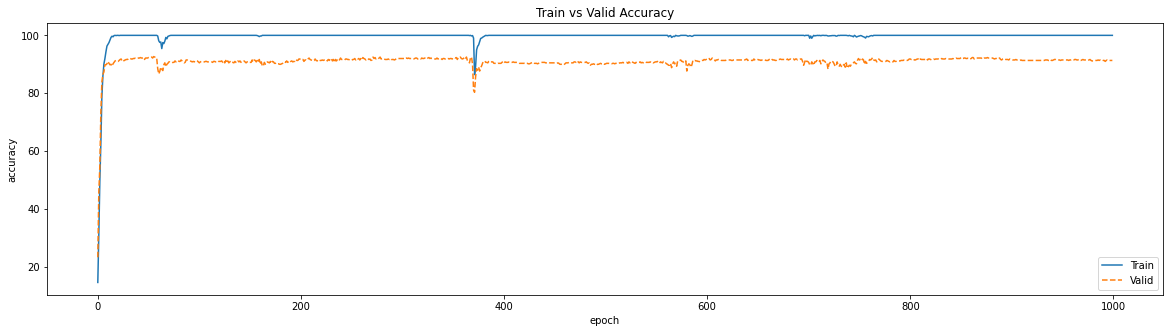

In [86]:
accuracy_plots(train_accu, eval_accu)

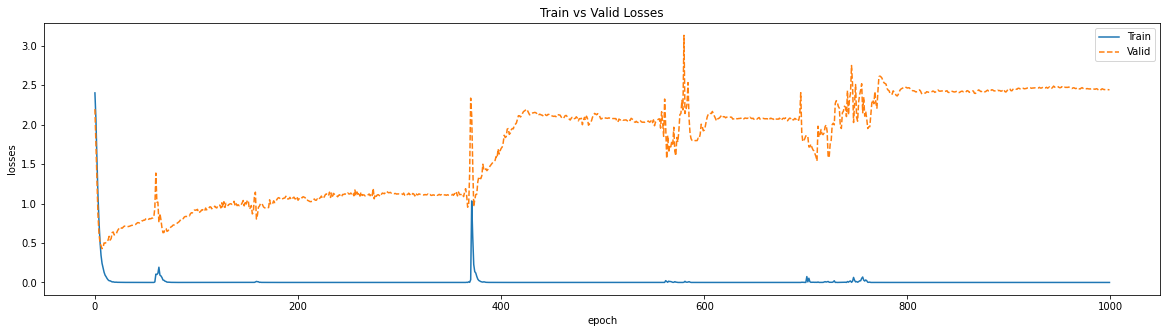

In [87]:
loss_plots(train_losses, eval_losses)

In [88]:
model = model_configs["3"]
model.load_state_dict(torch.load("models/best_model_parameters32.pth"))
model.eval()

model_3(
  (l1): Linear(in_features=784, out_features=400, bias=True)
  (r1): ReLU()
  (l2): Linear(in_features=400, out_features=200, bias=True)
  (r2): ReLU()
  (l3): Linear(in_features=200, out_features=10, bias=True)
)

In [89]:
with torch.no_grad():
  predicted_classes = []
  device = torch.device("cpu")
  for data in tqdm(first_five_loader):
    images,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(images)
    _, predicted = torch.max(outputs, 1)
    predicted_classes.append(predicted)

100%|██████████| 5/5 [00:00<00:00, 1244.08it/s]


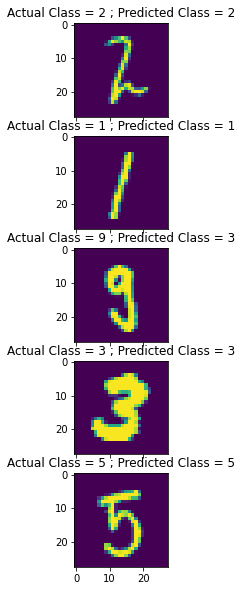

In [90]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for j in range(5):
  axs[j].imshow(first_five_test_images[j][0])
  axs[j].set_title(f"Actual Class = {first_five_test_image_labels[0+j]} ; Predicted Class = {predicted_classes[j].item()}")

for ax in axs.flat:
    ax.label_outer()

# model 3, training config 3:

In [91]:
s = time.time()
eval_losses, train_losses, eval_accu, train_accu = train("3", "3")
e = time.time()

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |   313600   |
|  l1.bias  |    400     |
| l2.weight |   80000    |
|  l2.bias  |    200     |
| l3.weight |    2000    |
|  l3.bias  |     10     |
+-----------+------------+
Total Trainable Params: 396210

Epoch : 1


100%|██████████| 2/2 [00:00<00:00, 71.53it/s]



Epoch : 2


100%|██████████| 2/2 [00:00<00:00, 72.09it/s]



Epoch : 3


100%|██████████| 2/2 [00:00<00:00, 71.64it/s]



Epoch : 4


100%|██████████| 2/2 [00:00<00:00, 70.06it/s]



Epoch : 5


100%|██████████| 2/2 [00:00<00:00, 71.64it/s]



Epoch : 6


100%|██████████| 2/2 [00:00<00:00, 65.48it/s]



Epoch : 7


100%|██████████| 2/2 [00:00<00:00, 73.60it/s]



Epoch : 8


100%|██████████| 2/2 [00:00<00:00, 62.74it/s]



Epoch : 9


100%|██████████| 2/2 [00:00<00:00, 65.23it/s]



Epoch : 10


100%|██████████| 2/2 [00:00<00:00, 69.00it/s]



Epoch : 11


100%|██████████| 2/2 [00:00<00:00, 66.53it/s]



Epoch : 12


100%|██████████| 2/2 [00:00<00:00, 69.50it/s]



Epoch : 13


100%|██████████| 2/2 [00:00<00:00, 70.56it/s]



Epoch : 14


100%|██████████| 2/2 [00:00<00:00, 66.61it/s]



Epoch : 15


100%|██████████| 2/2 [00:00<00:00, 69.32it/s]



Epoch : 16


100%|██████████| 2/2 [00:00<00:00, 69.59it/s]



Epoch : 17


100%|██████████| 2/2 [00:00<00:00, 67.60it/s]



Epoch : 18


100%|██████████| 2/2 [00:00<00:00, 69.61it/s]



Epoch : 19


100%|██████████| 2/2 [00:00<00:00, 70.69it/s]



Epoch : 20


100%|██████████| 2/2 [00:00<00:00, 69.11it/s]



Epoch : 21


100%|██████████| 2/2 [00:00<00:00, 70.99it/s]



Epoch : 22


100%|██████████| 2/2 [00:00<00:00, 69.36it/s]



Epoch : 23


100%|██████████| 2/2 [00:00<00:00, 70.60it/s]



Epoch : 24


100%|██████████| 2/2 [00:00<00:00, 69.30it/s]



Epoch : 25


100%|██████████| 2/2 [00:00<00:00, 70.69it/s]



Epoch : 26


100%|██████████| 2/2 [00:00<00:00, 61.32it/s]



Epoch : 27


100%|██████████| 2/2 [00:00<00:00, 68.09it/s]



Epoch : 28


100%|██████████| 2/2 [00:00<00:00, 67.15it/s]



Epoch : 29


100%|██████████| 2/2 [00:00<00:00, 68.78it/s]



Epoch : 30


100%|██████████| 2/2 [00:00<00:00, 64.27it/s]



Epoch : 31


100%|██████████| 2/2 [00:00<00:00, 68.04it/s]



Epoch : 32


100%|██████████| 2/2 [00:00<00:00, 67.73it/s]



Epoch : 33


100%|██████████| 2/2 [00:00<00:00, 66.52it/s]



Epoch : 34


100%|██████████| 2/2 [00:00<00:00, 66.73it/s]



Epoch : 35


100%|██████████| 2/2 [00:00<00:00, 66.19it/s]



Epoch : 36


100%|██████████| 2/2 [00:00<00:00, 62.61it/s]



Epoch : 37


100%|██████████| 2/2 [00:00<00:00, 62.17it/s]



Epoch : 38


100%|██████████| 2/2 [00:00<00:00, 65.14it/s]



Epoch : 39


100%|██████████| 2/2 [00:00<00:00, 62.62it/s]



Epoch : 40


100%|██████████| 2/2 [00:00<00:00, 60.92it/s]



Epoch : 41


100%|██████████| 2/2 [00:00<00:00, 59.08it/s]



Epoch : 42


100%|██████████| 2/2 [00:00<00:00, 65.23it/s]



Epoch : 43


100%|██████████| 2/2 [00:00<00:00, 61.29it/s]



Epoch : 44


100%|██████████| 2/2 [00:00<00:00, 60.40it/s]



Epoch : 45


100%|██████████| 2/2 [00:00<00:00, 60.30it/s]



Epoch : 46


100%|██████████| 2/2 [00:00<00:00, 58.75it/s]



Epoch : 47


100%|██████████| 2/2 [00:00<00:00, 58.38it/s]



Epoch : 48


100%|██████████| 2/2 [00:00<00:00, 62.69it/s]



Epoch : 49


100%|██████████| 2/2 [00:00<00:00, 64.71it/s]



Epoch : 50


100%|██████████| 2/2 [00:00<00:00, 69.82it/s]



Epoch : 51


100%|██████████| 2/2 [00:00<00:00, 63.10it/s]



Epoch : 52


100%|██████████| 2/2 [00:00<00:00, 63.58it/s]



Epoch : 53


100%|██████████| 2/2 [00:00<00:00, 51.13it/s]



Epoch : 54


100%|██████████| 2/2 [00:00<00:00, 57.38it/s]



Epoch : 55


100%|██████████| 2/2 [00:00<00:00, 57.32it/s]



Epoch : 56


100%|██████████| 2/2 [00:00<00:00, 44.63it/s]



Epoch : 57


100%|██████████| 2/2 [00:00<00:00, 56.99it/s]



Epoch : 58


100%|██████████| 2/2 [00:00<00:00, 62.12it/s]



Epoch : 59


100%|██████████| 2/2 [00:00<00:00, 59.44it/s]



Epoch : 60


100%|██████████| 2/2 [00:00<00:00, 59.04it/s]



Epoch : 61


100%|██████████| 2/2 [00:00<00:00, 62.30it/s]



Epoch : 62


100%|██████████| 2/2 [00:00<00:00, 54.73it/s]



Epoch : 63


100%|██████████| 2/2 [00:00<00:00, 62.03it/s]



Epoch : 64


100%|██████████| 2/2 [00:00<00:00, 62.66it/s]



Epoch : 65


100%|██████████| 2/2 [00:00<00:00, 56.61it/s]



Epoch : 66


100%|██████████| 2/2 [00:00<00:00, 63.09it/s]



Epoch : 67


100%|██████████| 2/2 [00:00<00:00, 59.03it/s]



Epoch : 68


100%|██████████| 2/2 [00:00<00:00, 58.71it/s]



Epoch : 69


100%|██████████| 2/2 [00:00<00:00, 51.56it/s]



Epoch : 70


100%|██████████| 2/2 [00:00<00:00, 62.75it/s]



Epoch : 71


100%|██████████| 2/2 [00:00<00:00, 62.36it/s]



Epoch : 72


100%|██████████| 2/2 [00:00<00:00, 59.26it/s]



Epoch : 73


100%|██████████| 2/2 [00:00<00:00, 60.29it/s]



Epoch : 74


100%|██████████| 2/2 [00:00<00:00, 60.06it/s]



Epoch : 75


100%|██████████| 2/2 [00:00<00:00, 59.81it/s]



Epoch : 76


100%|██████████| 2/2 [00:00<00:00, 57.66it/s]



Epoch : 77


100%|██████████| 2/2 [00:00<00:00, 62.29it/s]



Epoch : 78


100%|██████████| 2/2 [00:00<00:00, 54.61it/s]



Epoch : 79


100%|██████████| 2/2 [00:00<00:00, 57.49it/s]



Epoch : 80


100%|██████████| 2/2 [00:00<00:00, 64.83it/s]



Epoch : 81


100%|██████████| 2/2 [00:00<00:00, 59.38it/s]



Epoch : 82


100%|██████████| 2/2 [00:00<00:00, 60.64it/s]



Epoch : 83


100%|██████████| 2/2 [00:00<00:00, 60.27it/s]



Epoch : 84


100%|██████████| 2/2 [00:00<00:00, 58.78it/s]



Epoch : 85


100%|██████████| 2/2 [00:00<00:00, 61.21it/s]



Epoch : 86


100%|██████████| 2/2 [00:00<00:00, 58.48it/s]



Epoch : 87


100%|██████████| 2/2 [00:00<00:00, 48.54it/s]



Epoch : 88


100%|██████████| 2/2 [00:00<00:00, 57.50it/s]



Epoch : 89


100%|██████████| 2/2 [00:00<00:00, 57.75it/s]



Epoch : 90


100%|██████████| 2/2 [00:00<00:00, 59.53it/s]



Epoch : 91


100%|██████████| 2/2 [00:00<00:00, 59.03it/s]



Epoch : 92


100%|██████████| 2/2 [00:00<00:00, 46.81it/s]



Epoch : 93


100%|██████████| 2/2 [00:00<00:00, 62.06it/s]



Epoch : 94


100%|██████████| 2/2 [00:00<00:00, 55.94it/s]



Epoch : 95


100%|██████████| 2/2 [00:00<00:00, 54.99it/s]



Epoch : 96


100%|██████████| 2/2 [00:00<00:00, 54.92it/s]



Epoch : 97


100%|██████████| 2/2 [00:00<00:00, 54.39it/s]



Epoch : 98


100%|██████████| 2/2 [00:00<00:00, 58.21it/s]



Epoch : 99


100%|██████████| 2/2 [00:00<00:00, 59.84it/s]



Epoch : 100


100%|██████████| 2/2 [00:00<00:00, 50.93it/s]



Epoch : 101


100%|██████████| 2/2 [00:00<00:00, 58.32it/s]



Epoch : 102


100%|██████████| 2/2 [00:00<00:00, 59.35it/s]



Epoch : 103


100%|██████████| 2/2 [00:00<00:00, 49.33it/s]



Epoch : 104


100%|██████████| 2/2 [00:00<00:00, 61.33it/s]



Epoch : 105


100%|██████████| 2/2 [00:00<00:00, 56.96it/s]



Epoch : 106


100%|██████████| 2/2 [00:00<00:00, 58.17it/s]



Epoch : 107


100%|██████████| 2/2 [00:00<00:00, 57.42it/s]



Epoch : 108


100%|██████████| 2/2 [00:00<00:00, 58.85it/s]



Epoch : 109


100%|██████████| 2/2 [00:00<00:00, 57.93it/s]



Epoch : 110


100%|██████████| 2/2 [00:00<00:00, 53.87it/s]



Epoch : 111


100%|██████████| 2/2 [00:00<00:00, 49.80it/s]



Epoch : 112


100%|██████████| 2/2 [00:00<00:00, 55.84it/s]



Epoch : 113


100%|██████████| 2/2 [00:00<00:00, 58.42it/s]



Epoch : 114


100%|██████████| 2/2 [00:00<00:00, 59.40it/s]



Epoch : 115


100%|██████████| 2/2 [00:00<00:00, 57.32it/s]



Epoch : 116


100%|██████████| 2/2 [00:00<00:00, 58.41it/s]



Epoch : 117


100%|██████████| 2/2 [00:00<00:00, 57.02it/s]



Epoch : 118


100%|██████████| 2/2 [00:00<00:00, 57.77it/s]



Epoch : 119


100%|██████████| 2/2 [00:00<00:00, 45.74it/s]



Epoch : 120


100%|██████████| 2/2 [00:00<00:00, 58.61it/s]



Epoch : 121


100%|██████████| 2/2 [00:00<00:00, 43.74it/s]



Epoch : 122


100%|██████████| 2/2 [00:00<00:00, 58.59it/s]



Epoch : 123


100%|██████████| 2/2 [00:00<00:00, 60.14it/s]



Epoch : 124


100%|██████████| 2/2 [00:00<00:00, 56.24it/s]



Epoch : 125


100%|██████████| 2/2 [00:00<00:00, 62.38it/s]



Epoch : 126


100%|██████████| 2/2 [00:00<00:00, 57.51it/s]



Epoch : 127


100%|██████████| 2/2 [00:00<00:00, 60.71it/s]



Epoch : 128


100%|██████████| 2/2 [00:00<00:00, 58.75it/s]



Epoch : 129


100%|██████████| 2/2 [00:00<00:00, 61.52it/s]



Epoch : 130


100%|██████████| 2/2 [00:00<00:00, 52.62it/s]



Epoch : 131


100%|██████████| 2/2 [00:00<00:00, 60.97it/s]



Epoch : 132


100%|██████████| 2/2 [00:00<00:00, 60.69it/s]



Epoch : 133


100%|██████████| 2/2 [00:00<00:00, 55.21it/s]



Epoch : 134


100%|██████████| 2/2 [00:00<00:00, 50.05it/s]



Epoch : 135


100%|██████████| 2/2 [00:00<00:00, 61.04it/s]



Epoch : 136


100%|██████████| 2/2 [00:00<00:00, 53.84it/s]



Epoch : 137


100%|██████████| 2/2 [00:00<00:00, 58.99it/s]



Epoch : 138


100%|██████████| 2/2 [00:00<00:00, 45.04it/s]



Epoch : 139


100%|██████████| 2/2 [00:00<00:00, 58.05it/s]



Epoch : 140


100%|██████████| 2/2 [00:00<00:00, 50.49it/s]



Epoch : 141


100%|██████████| 2/2 [00:00<00:00, 56.70it/s]



Epoch : 142


100%|██████████| 2/2 [00:00<00:00, 61.43it/s]



Epoch : 143


100%|██████████| 2/2 [00:00<00:00, 57.27it/s]



Epoch : 144


100%|██████████| 2/2 [00:00<00:00, 59.18it/s]



Epoch : 145


100%|██████████| 2/2 [00:00<00:00, 60.02it/s]



Epoch : 146


100%|██████████| 2/2 [00:00<00:00, 57.37it/s]



Epoch : 147


100%|██████████| 2/2 [00:00<00:00, 56.33it/s]



Epoch : 148


100%|██████████| 2/2 [00:00<00:00, 55.41it/s]



Epoch : 149


100%|██████████| 2/2 [00:00<00:00, 60.17it/s]



Epoch : 150


100%|██████████| 2/2 [00:00<00:00, 56.20it/s]



Epoch : 151


100%|██████████| 2/2 [00:00<00:00, 47.54it/s]



Epoch : 152


100%|██████████| 2/2 [00:00<00:00, 52.09it/s]



Epoch : 153


100%|██████████| 2/2 [00:00<00:00, 48.87it/s]



Epoch : 154


100%|██████████| 2/2 [00:00<00:00, 51.20it/s]



Epoch : 155


100%|██████████| 2/2 [00:00<00:00, 55.09it/s]



Epoch : 156


100%|██████████| 2/2 [00:00<00:00, 55.29it/s]



Epoch : 157


100%|██████████| 2/2 [00:00<00:00, 55.42it/s]



Epoch : 158


100%|██████████| 2/2 [00:00<00:00, 54.08it/s]



Epoch : 159


100%|██████████| 2/2 [00:00<00:00, 53.82it/s]



Epoch : 160


100%|██████████| 2/2 [00:00<00:00, 45.64it/s]



Epoch : 161


100%|██████████| 2/2 [00:00<00:00, 51.58it/s]



Epoch : 162


100%|██████████| 2/2 [00:00<00:00, 46.57it/s]



Epoch : 163


100%|██████████| 2/2 [00:00<00:00, 56.67it/s]



Epoch : 164


100%|██████████| 2/2 [00:00<00:00, 47.78it/s]



Epoch : 165


100%|██████████| 2/2 [00:00<00:00, 54.00it/s]



Epoch : 166


100%|██████████| 2/2 [00:00<00:00, 48.69it/s]



Epoch : 167


100%|██████████| 2/2 [00:00<00:00, 55.25it/s]



Epoch : 168


100%|██████████| 2/2 [00:00<00:00, 48.21it/s]



Epoch : 169


100%|██████████| 2/2 [00:00<00:00, 48.79it/s]



Epoch : 170


100%|██████████| 2/2 [00:00<00:00, 44.98it/s]



Epoch : 171


100%|██████████| 2/2 [00:00<00:00, 50.80it/s]



Epoch : 172


100%|██████████| 2/2 [00:00<00:00, 57.68it/s]



Epoch : 173


100%|██████████| 2/2 [00:00<00:00, 51.97it/s]



Epoch : 174


100%|██████████| 2/2 [00:00<00:00, 52.36it/s]



Epoch : 175


100%|██████████| 2/2 [00:00<00:00, 49.51it/s]



Epoch : 176


100%|██████████| 2/2 [00:00<00:00, 51.80it/s]



Epoch : 177


100%|██████████| 2/2 [00:00<00:00, 54.94it/s]



Epoch : 178


100%|██████████| 2/2 [00:00<00:00, 43.79it/s]



Epoch : 179


100%|██████████| 2/2 [00:00<00:00, 50.91it/s]



Epoch : 180


100%|██████████| 2/2 [00:00<00:00, 57.61it/s]



Epoch : 181


100%|██████████| 2/2 [00:00<00:00, 54.83it/s]



Epoch : 182


100%|██████████| 2/2 [00:00<00:00, 56.74it/s]



Epoch : 183


100%|██████████| 2/2 [00:00<00:00, 55.62it/s]



Epoch : 184


100%|██████████| 2/2 [00:00<00:00, 49.55it/s]



Epoch : 185


100%|██████████| 2/2 [00:00<00:00, 56.27it/s]



Epoch : 186


100%|██████████| 2/2 [00:00<00:00, 59.92it/s]



Epoch : 187


100%|██████████| 2/2 [00:00<00:00, 54.62it/s]



Epoch : 188


100%|██████████| 2/2 [00:00<00:00, 51.80it/s]



Epoch : 189


100%|██████████| 2/2 [00:00<00:00, 50.39it/s]



Epoch : 190


100%|██████████| 2/2 [00:00<00:00, 56.96it/s]



Epoch : 191


100%|██████████| 2/2 [00:00<00:00, 51.81it/s]



Epoch : 192


100%|██████████| 2/2 [00:00<00:00, 54.81it/s]



Epoch : 193


100%|██████████| 2/2 [00:00<00:00, 54.19it/s]



Epoch : 194


100%|██████████| 2/2 [00:00<00:00, 61.64it/s]



Epoch : 195


100%|██████████| 2/2 [00:00<00:00, 52.78it/s]



Epoch : 196


100%|██████████| 2/2 [00:00<00:00, 46.46it/s]



Epoch : 197


100%|██████████| 2/2 [00:00<00:00, 50.14it/s]



Epoch : 198


100%|██████████| 2/2 [00:00<00:00, 52.81it/s]



Epoch : 199


100%|██████████| 2/2 [00:00<00:00, 48.05it/s]



Epoch : 200


100%|██████████| 2/2 [00:00<00:00, 50.18it/s]



Epoch : 201


100%|██████████| 2/2 [00:00<00:00, 46.41it/s]



Epoch : 202


100%|██████████| 2/2 [00:00<00:00, 50.43it/s]



Epoch : 203


100%|██████████| 2/2 [00:00<00:00, 49.17it/s]



Epoch : 204


100%|██████████| 2/2 [00:00<00:00, 50.79it/s]



Epoch : 205


100%|██████████| 2/2 [00:00<00:00, 53.36it/s]



Epoch : 206


100%|██████████| 2/2 [00:00<00:00, 53.23it/s]



Epoch : 207


100%|██████████| 2/2 [00:00<00:00, 55.20it/s]



Epoch : 208


100%|██████████| 2/2 [00:00<00:00, 53.36it/s]



Epoch : 209


100%|██████████| 2/2 [00:00<00:00, 54.82it/s]



Epoch : 210


100%|██████████| 2/2 [00:00<00:00, 50.40it/s]



Epoch : 211


100%|██████████| 2/2 [00:00<00:00, 46.79it/s]



Epoch : 212


100%|██████████| 2/2 [00:00<00:00, 47.62it/s]



Epoch : 213


100%|██████████| 2/2 [00:00<00:00, 55.02it/s]



Epoch : 214


100%|██████████| 2/2 [00:00<00:00, 54.76it/s]



Epoch : 215


100%|██████████| 2/2 [00:00<00:00, 50.08it/s]



Epoch : 216


100%|██████████| 2/2 [00:00<00:00, 46.29it/s]



Epoch : 217


100%|██████████| 2/2 [00:00<00:00, 53.80it/s]



Epoch : 218


100%|██████████| 2/2 [00:00<00:00, 56.09it/s]



Epoch : 219


100%|██████████| 2/2 [00:00<00:00, 50.89it/s]



Epoch : 220


100%|██████████| 2/2 [00:00<00:00, 55.97it/s]



Epoch : 221


100%|██████████| 2/2 [00:00<00:00, 49.47it/s]



Epoch : 222


100%|██████████| 2/2 [00:00<00:00, 50.76it/s]



Epoch : 223


100%|██████████| 2/2 [00:00<00:00, 58.52it/s]



Epoch : 224


100%|██████████| 2/2 [00:00<00:00, 53.89it/s]



Epoch : 225


100%|██████████| 2/2 [00:00<00:00, 50.01it/s]



Epoch : 226


100%|██████████| 2/2 [00:00<00:00, 43.98it/s]



Epoch : 227


100%|██████████| 2/2 [00:00<00:00, 53.37it/s]



Epoch : 228


100%|██████████| 2/2 [00:00<00:00, 50.32it/s]



Epoch : 229


100%|██████████| 2/2 [00:00<00:00, 49.81it/s]



Epoch : 230


100%|██████████| 2/2 [00:00<00:00, 52.39it/s]



Epoch : 231


100%|██████████| 2/2 [00:00<00:00, 54.88it/s]



Epoch : 232


100%|██████████| 2/2 [00:00<00:00, 46.79it/s]



Epoch : 233


100%|██████████| 2/2 [00:00<00:00, 46.90it/s]



Epoch : 234


100%|██████████| 2/2 [00:00<00:00, 46.31it/s]



Epoch : 235


100%|██████████| 2/2 [00:00<00:00, 54.63it/s]



Epoch : 236


100%|██████████| 2/2 [00:00<00:00, 53.66it/s]



Epoch : 237


100%|██████████| 2/2 [00:00<00:00, 48.53it/s]



Epoch : 238


100%|██████████| 2/2 [00:00<00:00, 53.66it/s]



Epoch : 239


100%|██████████| 2/2 [00:00<00:00, 52.65it/s]



Epoch : 240


100%|██████████| 2/2 [00:00<00:00, 55.31it/s]



Epoch : 241


100%|██████████| 2/2 [00:00<00:00, 52.26it/s]



Epoch : 242


100%|██████████| 2/2 [00:00<00:00, 55.01it/s]



Epoch : 243


100%|██████████| 2/2 [00:00<00:00, 42.58it/s]



Epoch : 244


100%|██████████| 2/2 [00:00<00:00, 50.83it/s]



Epoch : 245


100%|██████████| 2/2 [00:00<00:00, 48.10it/s]



Epoch : 246


100%|██████████| 2/2 [00:00<00:00, 52.57it/s]



Epoch : 247


100%|██████████| 2/2 [00:00<00:00, 56.19it/s]



Epoch : 248


100%|██████████| 2/2 [00:00<00:00, 51.23it/s]



Epoch : 249


100%|██████████| 2/2 [00:00<00:00, 46.07it/s]



Epoch : 250


100%|██████████| 2/2 [00:00<00:00, 51.95it/s]



Epoch : 251


100%|██████████| 2/2 [00:00<00:00, 50.11it/s]



Epoch : 252


100%|██████████| 2/2 [00:00<00:00, 57.11it/s]



Epoch : 253


100%|██████████| 2/2 [00:00<00:00, 53.37it/s]



Epoch : 254


100%|██████████| 2/2 [00:00<00:00, 49.29it/s]



Epoch : 255


100%|██████████| 2/2 [00:00<00:00, 51.62it/s]



Epoch : 256


100%|██████████| 2/2 [00:00<00:00, 49.66it/s]



Epoch : 257


100%|██████████| 2/2 [00:00<00:00, 56.97it/s]



Epoch : 258


100%|██████████| 2/2 [00:00<00:00, 52.53it/s]



Epoch : 259


100%|██████████| 2/2 [00:00<00:00, 45.26it/s]



Epoch : 260


100%|██████████| 2/2 [00:00<00:00, 51.08it/s]



Epoch : 261


100%|██████████| 2/2 [00:00<00:00, 56.24it/s]



Epoch : 262


100%|██████████| 2/2 [00:00<00:00, 50.89it/s]



Epoch : 263


100%|██████████| 2/2 [00:00<00:00, 52.97it/s]



Epoch : 264


100%|██████████| 2/2 [00:00<00:00, 51.36it/s]



Epoch : 265


100%|██████████| 2/2 [00:00<00:00, 52.70it/s]



Epoch : 266


100%|██████████| 2/2 [00:00<00:00, 54.70it/s]



Epoch : 267


100%|██████████| 2/2 [00:00<00:00, 43.81it/s]



Epoch : 268


100%|██████████| 2/2 [00:00<00:00, 46.15it/s]



Epoch : 269


100%|██████████| 2/2 [00:00<00:00, 48.94it/s]



Epoch : 270


100%|██████████| 2/2 [00:00<00:00, 50.48it/s]



Epoch : 271


100%|██████████| 2/2 [00:00<00:00, 51.25it/s]



Epoch : 272


100%|██████████| 2/2 [00:00<00:00, 49.68it/s]



Epoch : 273


100%|██████████| 2/2 [00:00<00:00, 44.90it/s]



Epoch : 274


100%|██████████| 2/2 [00:00<00:00, 49.47it/s]



Epoch : 275


100%|██████████| 2/2 [00:00<00:00, 50.67it/s]



Epoch : 276


100%|██████████| 2/2 [00:00<00:00, 46.87it/s]



Epoch : 277


100%|██████████| 2/2 [00:00<00:00, 48.76it/s]



Epoch : 278


100%|██████████| 2/2 [00:00<00:00, 55.70it/s]



Epoch : 279


100%|██████████| 2/2 [00:00<00:00, 47.48it/s]



Epoch : 280


100%|██████████| 2/2 [00:00<00:00, 51.04it/s]



Epoch : 281


100%|██████████| 2/2 [00:00<00:00, 52.18it/s]



Epoch : 282


100%|██████████| 2/2 [00:00<00:00, 45.67it/s]



Epoch : 283


100%|██████████| 2/2 [00:00<00:00, 47.53it/s]



Epoch : 284


100%|██████████| 2/2 [00:00<00:00, 51.95it/s]



Epoch : 285


100%|██████████| 2/2 [00:00<00:00, 53.20it/s]



Epoch : 286


100%|██████████| 2/2 [00:00<00:00, 52.74it/s]



Epoch : 287


100%|██████████| 2/2 [00:00<00:00, 51.59it/s]



Epoch : 288


100%|██████████| 2/2 [00:00<00:00, 45.27it/s]



Epoch : 289


100%|██████████| 2/2 [00:00<00:00, 49.09it/s]



Epoch : 290


100%|██████████| 2/2 [00:00<00:00, 44.25it/s]



Epoch : 291


100%|██████████| 2/2 [00:00<00:00, 49.13it/s]



Epoch : 292


100%|██████████| 2/2 [00:00<00:00, 44.32it/s]



Epoch : 293


100%|██████████| 2/2 [00:00<00:00, 51.47it/s]



Epoch : 294


100%|██████████| 2/2 [00:00<00:00, 37.89it/s]



Epoch : 295


100%|██████████| 2/2 [00:00<00:00, 50.02it/s]



Epoch : 296


100%|██████████| 2/2 [00:00<00:00, 50.27it/s]



Epoch : 297


100%|██████████| 2/2 [00:00<00:00, 49.75it/s]



Epoch : 298


100%|██████████| 2/2 [00:00<00:00, 47.30it/s]



Epoch : 299


100%|██████████| 2/2 [00:00<00:00, 49.86it/s]



Epoch : 300


100%|██████████| 2/2 [00:00<00:00, 50.24it/s]



Epoch : 301


100%|██████████| 2/2 [00:00<00:00, 49.99it/s]



Epoch : 302


100%|██████████| 2/2 [00:00<00:00, 49.33it/s]



Epoch : 303


100%|██████████| 2/2 [00:00<00:00, 42.99it/s]



Epoch : 304


100%|██████████| 2/2 [00:00<00:00, 52.78it/s]



Epoch : 305


100%|██████████| 2/2 [00:00<00:00, 48.50it/s]



Epoch : 306


100%|██████████| 2/2 [00:00<00:00, 52.16it/s]



Epoch : 307


100%|██████████| 2/2 [00:00<00:00, 51.67it/s]



Epoch : 308


100%|██████████| 2/2 [00:00<00:00, 48.86it/s]



Epoch : 309


100%|██████████| 2/2 [00:00<00:00, 46.45it/s]



Epoch : 310


100%|██████████| 2/2 [00:00<00:00, 44.79it/s]



Epoch : 311


100%|██████████| 2/2 [00:00<00:00, 47.71it/s]



Epoch : 312


100%|██████████| 2/2 [00:00<00:00, 42.14it/s]



Epoch : 313


100%|██████████| 2/2 [00:00<00:00, 51.17it/s]



Epoch : 314


100%|██████████| 2/2 [00:00<00:00, 50.46it/s]



Epoch : 315


100%|██████████| 2/2 [00:00<00:00, 49.73it/s]



Epoch : 316


100%|██████████| 2/2 [00:00<00:00, 46.64it/s]



Epoch : 317


100%|██████████| 2/2 [00:00<00:00, 45.44it/s]



Epoch : 318


100%|██████████| 2/2 [00:00<00:00, 48.02it/s]



Epoch : 319


100%|██████████| 2/2 [00:00<00:00, 41.55it/s]



Epoch : 320


100%|██████████| 2/2 [00:00<00:00, 49.15it/s]



Epoch : 321


100%|██████████| 2/2 [00:00<00:00, 43.88it/s]



Epoch : 322


100%|██████████| 2/2 [00:00<00:00, 46.75it/s]



Epoch : 323


100%|██████████| 2/2 [00:00<00:00, 48.79it/s]



Epoch : 324


100%|██████████| 2/2 [00:00<00:00, 46.92it/s]



Epoch : 325


100%|██████████| 2/2 [00:00<00:00, 48.60it/s]



Epoch : 326


100%|██████████| 2/2 [00:00<00:00, 45.92it/s]



Epoch : 327


100%|██████████| 2/2 [00:00<00:00, 45.18it/s]



Epoch : 328


100%|██████████| 2/2 [00:00<00:00, 39.67it/s]



Epoch : 329


100%|██████████| 2/2 [00:00<00:00, 44.48it/s]



Epoch : 330


100%|██████████| 2/2 [00:00<00:00, 51.71it/s]



Epoch : 331


100%|██████████| 2/2 [00:00<00:00, 45.95it/s]



Epoch : 332


100%|██████████| 2/2 [00:00<00:00, 48.11it/s]



Epoch : 333


100%|██████████| 2/2 [00:00<00:00, 46.03it/s]



Epoch : 334


100%|██████████| 2/2 [00:00<00:00, 50.26it/s]



Epoch : 335


100%|██████████| 2/2 [00:00<00:00, 47.86it/s]



Epoch : 336


100%|██████████| 2/2 [00:00<00:00, 41.91it/s]



Epoch : 337


100%|██████████| 2/2 [00:00<00:00, 46.06it/s]



Epoch : 338


100%|██████████| 2/2 [00:00<00:00, 41.58it/s]



Epoch : 339


100%|██████████| 2/2 [00:00<00:00, 47.06it/s]



Epoch : 340


100%|██████████| 2/2 [00:00<00:00, 49.03it/s]



Epoch : 341


100%|██████████| 2/2 [00:00<00:00, 49.45it/s]



Epoch : 342


100%|██████████| 2/2 [00:00<00:00, 48.09it/s]



Epoch : 343


100%|██████████| 2/2 [00:00<00:00, 44.76it/s]



Epoch : 344


100%|██████████| 2/2 [00:00<00:00, 43.77it/s]



Epoch : 345


100%|██████████| 2/2 [00:00<00:00, 46.48it/s]



Epoch : 346


100%|██████████| 2/2 [00:00<00:00, 47.30it/s]



Epoch : 347


100%|██████████| 2/2 [00:00<00:00, 46.28it/s]



Epoch : 348


100%|██████████| 2/2 [00:00<00:00, 51.97it/s]



Epoch : 349


100%|██████████| 2/2 [00:00<00:00, 45.01it/s]



Epoch : 350


100%|██████████| 2/2 [00:00<00:00, 49.36it/s]



Epoch : 351


100%|██████████| 2/2 [00:00<00:00, 46.47it/s]



Epoch : 352


100%|██████████| 2/2 [00:00<00:00, 47.56it/s]



Epoch : 353


100%|██████████| 2/2 [00:00<00:00, 41.39it/s]



Epoch : 354


100%|██████████| 2/2 [00:00<00:00, 48.13it/s]



Epoch : 355


100%|██████████| 2/2 [00:00<00:00, 46.73it/s]



Epoch : 356


100%|██████████| 2/2 [00:00<00:00, 48.07it/s]



Epoch : 357


100%|██████████| 2/2 [00:00<00:00, 44.56it/s]



Epoch : 358


100%|██████████| 2/2 [00:00<00:00, 49.74it/s]



Epoch : 359


100%|██████████| 2/2 [00:00<00:00, 45.73it/s]



Epoch : 360


100%|██████████| 2/2 [00:00<00:00, 47.24it/s]



Epoch : 361


100%|██████████| 2/2 [00:00<00:00, 48.44it/s]



Epoch : 362


100%|██████████| 2/2 [00:00<00:00, 46.73it/s]



Epoch : 363


100%|██████████| 2/2 [00:00<00:00, 42.71it/s]



Epoch : 364


100%|██████████| 2/2 [00:00<00:00, 48.97it/s]



Epoch : 365


100%|██████████| 2/2 [00:00<00:00, 46.67it/s]



Epoch : 366


100%|██████████| 2/2 [00:00<00:00, 48.86it/s]



Epoch : 367


100%|██████████| 2/2 [00:00<00:00, 47.75it/s]



Epoch : 368


100%|██████████| 2/2 [00:00<00:00, 52.39it/s]



Epoch : 369


100%|██████████| 2/2 [00:00<00:00, 44.86it/s]



Epoch : 370


100%|██████████| 2/2 [00:00<00:00, 51.85it/s]



Epoch : 371


100%|██████████| 2/2 [00:00<00:00, 47.75it/s]



Epoch : 372


100%|██████████| 2/2 [00:00<00:00, 50.51it/s]



Epoch : 373


100%|██████████| 2/2 [00:00<00:00, 46.40it/s]



Epoch : 374


100%|██████████| 2/2 [00:00<00:00, 47.25it/s]



Epoch : 375


100%|██████████| 2/2 [00:00<00:00, 45.81it/s]



Epoch : 376


100%|██████████| 2/2 [00:00<00:00, 49.47it/s]



Epoch : 377


100%|██████████| 2/2 [00:00<00:00, 48.90it/s]



Epoch : 378


100%|██████████| 2/2 [00:00<00:00, 46.28it/s]



Epoch : 379


100%|██████████| 2/2 [00:00<00:00, 40.31it/s]



Epoch : 380


100%|██████████| 2/2 [00:00<00:00, 49.54it/s]



Epoch : 381


100%|██████████| 2/2 [00:00<00:00, 48.78it/s]



Epoch : 382


100%|██████████| 2/2 [00:00<00:00, 45.51it/s]



Epoch : 383


100%|██████████| 2/2 [00:00<00:00, 46.07it/s]



Epoch : 384


100%|██████████| 2/2 [00:00<00:00, 50.35it/s]



Epoch : 385


100%|██████████| 2/2 [00:00<00:00, 44.00it/s]



Epoch : 386


100%|██████████| 2/2 [00:00<00:00, 43.26it/s]



Epoch : 387


100%|██████████| 2/2 [00:00<00:00, 46.18it/s]



Epoch : 388


100%|██████████| 2/2 [00:00<00:00, 48.53it/s]



Epoch : 389


100%|██████████| 2/2 [00:00<00:00, 44.45it/s]



Epoch : 390


100%|██████████| 2/2 [00:00<00:00, 47.44it/s]



Epoch : 391


100%|██████████| 2/2 [00:00<00:00, 48.51it/s]



Epoch : 392


100%|██████████| 2/2 [00:00<00:00, 15.54it/s]



Epoch : 393


100%|██████████| 2/2 [00:00<00:00, 46.67it/s]



Epoch : 394


100%|██████████| 2/2 [00:00<00:00, 46.97it/s]



Epoch : 395


100%|██████████| 2/2 [00:00<00:00, 48.82it/s]



Epoch : 396


100%|██████████| 2/2 [00:00<00:00, 47.53it/s]



Epoch : 397


100%|██████████| 2/2 [00:00<00:00, 40.91it/s]



Epoch : 398


100%|██████████| 2/2 [00:00<00:00, 43.87it/s]



Epoch : 399


100%|██████████| 2/2 [00:00<00:00, 48.71it/s]



Epoch : 400


100%|██████████| 2/2 [00:00<00:00, 44.37it/s]



Epoch : 401


100%|██████████| 2/2 [00:00<00:00, 41.86it/s]



Epoch : 402


100%|██████████| 2/2 [00:00<00:00, 45.85it/s]



Epoch : 403


100%|██████████| 2/2 [00:00<00:00, 45.69it/s]



Epoch : 404


100%|██████████| 2/2 [00:00<00:00, 44.57it/s]



Epoch : 405


100%|██████████| 2/2 [00:00<00:00, 47.58it/s]



Epoch : 406


100%|██████████| 2/2 [00:00<00:00, 48.51it/s]



Epoch : 407


100%|██████████| 2/2 [00:00<00:00, 48.26it/s]



Epoch : 408


100%|██████████| 2/2 [00:00<00:00, 40.86it/s]



Epoch : 409


100%|██████████| 2/2 [00:00<00:00, 48.58it/s]



Epoch : 410


100%|██████████| 2/2 [00:00<00:00, 49.98it/s]



Epoch : 411


100%|██████████| 2/2 [00:00<00:00, 53.70it/s]



Epoch : 412


100%|██████████| 2/2 [00:00<00:00, 50.56it/s]



Epoch : 413


100%|██████████| 2/2 [00:00<00:00, 58.46it/s]



Epoch : 414


100%|██████████| 2/2 [00:00<00:00, 68.31it/s]



Epoch : 415


100%|██████████| 2/2 [00:00<00:00, 63.97it/s]



Epoch : 416


100%|██████████| 2/2 [00:00<00:00, 58.25it/s]



Epoch : 417


100%|██████████| 2/2 [00:00<00:00, 63.68it/s]



Epoch : 418


100%|██████████| 2/2 [00:00<00:00, 62.36it/s]



Epoch : 419


100%|██████████| 2/2 [00:00<00:00, 57.62it/s]



Epoch : 420


100%|██████████| 2/2 [00:00<00:00, 66.03it/s]



Epoch : 421


100%|██████████| 2/2 [00:00<00:00, 59.54it/s]



Epoch : 422


100%|██████████| 2/2 [00:00<00:00, 58.92it/s]



Epoch : 423


100%|██████████| 2/2 [00:00<00:00, 61.56it/s]



Epoch : 424


100%|██████████| 2/2 [00:00<00:00, 62.74it/s]



Epoch : 425


100%|██████████| 2/2 [00:00<00:00, 55.11it/s]



Epoch : 426


100%|██████████| 2/2 [00:00<00:00, 50.29it/s]



Epoch : 427


100%|██████████| 2/2 [00:00<00:00, 55.76it/s]



Epoch : 428


100%|██████████| 2/2 [00:00<00:00, 56.39it/s]



Epoch : 429


100%|██████████| 2/2 [00:00<00:00, 57.65it/s]



Epoch : 430


100%|██████████| 2/2 [00:00<00:00, 61.48it/s]



Epoch : 431


100%|██████████| 2/2 [00:00<00:00, 62.35it/s]



Epoch : 432


100%|██████████| 2/2 [00:00<00:00, 57.15it/s]



Epoch : 433


100%|██████████| 2/2 [00:00<00:00, 57.68it/s]



Epoch : 434


100%|██████████| 2/2 [00:00<00:00, 58.36it/s]



Epoch : 435


100%|██████████| 2/2 [00:00<00:00, 51.88it/s]



Epoch : 436


100%|██████████| 2/2 [00:00<00:00, 62.75it/s]



Epoch : 437


100%|██████████| 2/2 [00:00<00:00, 67.27it/s]



Epoch : 438


100%|██████████| 2/2 [00:00<00:00, 54.57it/s]



Epoch : 439


100%|██████████| 2/2 [00:00<00:00, 50.48it/s]



Epoch : 440


100%|██████████| 2/2 [00:00<00:00, 57.07it/s]



Epoch : 441


100%|██████████| 2/2 [00:00<00:00, 52.24it/s]



Epoch : 442


100%|██████████| 2/2 [00:00<00:00, 57.86it/s]



Epoch : 443


100%|██████████| 2/2 [00:00<00:00, 54.35it/s]



Epoch : 444


100%|██████████| 2/2 [00:00<00:00, 51.04it/s]



Epoch : 445


100%|██████████| 2/2 [00:00<00:00, 57.87it/s]



Epoch : 446


100%|██████████| 2/2 [00:00<00:00, 52.72it/s]



Epoch : 447


100%|██████████| 2/2 [00:00<00:00, 17.43it/s]



Epoch : 448


100%|██████████| 2/2 [00:00<00:00, 65.25it/s]



Epoch : 449


100%|██████████| 2/2 [00:00<00:00, 55.26it/s]



Epoch : 450


100%|██████████| 2/2 [00:00<00:00, 50.71it/s]



Epoch : 451


100%|██████████| 2/2 [00:00<00:00, 54.22it/s]



Epoch : 452


100%|██████████| 2/2 [00:00<00:00, 58.57it/s]



Epoch : 453


100%|██████████| 2/2 [00:00<00:00, 46.64it/s]



Epoch : 454


100%|██████████| 2/2 [00:00<00:00, 58.81it/s]



Epoch : 455


100%|██████████| 2/2 [00:00<00:00, 63.38it/s]



Epoch : 456


100%|██████████| 2/2 [00:00<00:00, 53.53it/s]



Epoch : 457


100%|██████████| 2/2 [00:00<00:00, 60.96it/s]



Epoch : 458


100%|██████████| 2/2 [00:00<00:00, 57.45it/s]



Epoch : 459


100%|██████████| 2/2 [00:00<00:00, 59.44it/s]



Epoch : 460


100%|██████████| 2/2 [00:00<00:00, 52.18it/s]



Epoch : 461


100%|██████████| 2/2 [00:00<00:00, 50.95it/s]



Epoch : 462


100%|██████████| 2/2 [00:00<00:00, 62.22it/s]



Epoch : 463


100%|██████████| 2/2 [00:00<00:00, 49.22it/s]



Epoch : 464


100%|██████████| 2/2 [00:00<00:00, 53.63it/s]



Epoch : 465


100%|██████████| 2/2 [00:00<00:00, 57.37it/s]



Epoch : 466


100%|██████████| 2/2 [00:00<00:00, 60.75it/s]



Epoch : 467


100%|██████████| 2/2 [00:00<00:00, 53.86it/s]



Epoch : 468


100%|██████████| 2/2 [00:00<00:00, 69.11it/s]



Epoch : 469


100%|██████████| 2/2 [00:00<00:00, 59.78it/s]



Epoch : 470


100%|██████████| 2/2 [00:00<00:00, 61.12it/s]



Epoch : 471


100%|██████████| 2/2 [00:00<00:00, 57.10it/s]



Epoch : 472


100%|██████████| 2/2 [00:00<00:00, 52.43it/s]



Epoch : 473


100%|██████████| 2/2 [00:00<00:00, 56.82it/s]



Epoch : 474


100%|██████████| 2/2 [00:00<00:00, 57.10it/s]



Epoch : 475


100%|██████████| 2/2 [00:00<00:00, 54.44it/s]



Epoch : 476


100%|██████████| 2/2 [00:00<00:00, 55.87it/s]



Epoch : 477


100%|██████████| 2/2 [00:00<00:00, 57.35it/s]



Epoch : 478


100%|██████████| 2/2 [00:00<00:00, 53.66it/s]



Epoch : 479


100%|██████████| 2/2 [00:00<00:00, 52.04it/s]



Epoch : 480


100%|██████████| 2/2 [00:00<00:00, 57.67it/s]



Epoch : 481


100%|██████████| 2/2 [00:00<00:00, 56.71it/s]



Epoch : 482


100%|██████████| 2/2 [00:00<00:00, 55.58it/s]



Epoch : 483


100%|██████████| 2/2 [00:00<00:00, 54.81it/s]



Epoch : 484


100%|██████████| 2/2 [00:00<00:00, 50.16it/s]



Epoch : 485


100%|██████████| 2/2 [00:00<00:00, 47.90it/s]



Epoch : 486


100%|██████████| 2/2 [00:00<00:00, 56.72it/s]



Epoch : 487


100%|██████████| 2/2 [00:00<00:00, 48.48it/s]



Epoch : 488


100%|██████████| 2/2 [00:00<00:00, 56.04it/s]



Epoch : 489


100%|██████████| 2/2 [00:00<00:00, 55.34it/s]



Epoch : 490


100%|██████████| 2/2 [00:00<00:00, 52.34it/s]



Epoch : 491


100%|██████████| 2/2 [00:00<00:00, 49.00it/s]



Epoch : 492


100%|██████████| 2/2 [00:00<00:00, 49.43it/s]



Epoch : 493


100%|██████████| 2/2 [00:00<00:00, 38.00it/s]



Epoch : 494


100%|██████████| 2/2 [00:00<00:00, 54.73it/s]



Epoch : 495


100%|██████████| 2/2 [00:00<00:00, 55.97it/s]



Epoch : 496


100%|██████████| 2/2 [00:00<00:00, 53.63it/s]



Epoch : 497


100%|██████████| 2/2 [00:00<00:00, 48.00it/s]



Epoch : 498


100%|██████████| 2/2 [00:00<00:00, 46.49it/s]



Epoch : 499


100%|██████████| 2/2 [00:00<00:00, 47.40it/s]



Epoch : 500


100%|██████████| 2/2 [00:00<00:00, 49.95it/s]



Epoch : 501


100%|██████████| 2/2 [00:00<00:00, 49.03it/s]



Epoch : 502


100%|██████████| 2/2 [00:00<00:00, 14.62it/s]



Epoch : 503


100%|██████████| 2/2 [00:00<00:00, 51.67it/s]



Epoch : 504


100%|██████████| 2/2 [00:00<00:00, 47.87it/s]



Epoch : 505


100%|██████████| 2/2 [00:00<00:00, 52.55it/s]



Epoch : 506


100%|██████████| 2/2 [00:00<00:00, 50.10it/s]



Epoch : 507


100%|██████████| 2/2 [00:00<00:00, 52.67it/s]



Epoch : 508


100%|██████████| 2/2 [00:00<00:00, 45.18it/s]



Epoch : 509


100%|██████████| 2/2 [00:00<00:00, 48.15it/s]



Epoch : 510


100%|██████████| 2/2 [00:00<00:00, 53.35it/s]



Epoch : 511


100%|██████████| 2/2 [00:00<00:00, 53.17it/s]



Epoch : 512


100%|██████████| 2/2 [00:00<00:00, 54.98it/s]



Epoch : 513


100%|██████████| 2/2 [00:00<00:00, 53.24it/s]



Epoch : 514


100%|██████████| 2/2 [00:00<00:00, 51.62it/s]



Epoch : 515


100%|██████████| 2/2 [00:00<00:00, 49.43it/s]



Epoch : 516


100%|██████████| 2/2 [00:00<00:00, 52.31it/s]



Epoch : 517


100%|██████████| 2/2 [00:00<00:00, 47.83it/s]



Epoch : 518


100%|██████████| 2/2 [00:00<00:00, 48.77it/s]



Epoch : 519


100%|██████████| 2/2 [00:00<00:00, 49.64it/s]



Epoch : 520


100%|██████████| 2/2 [00:00<00:00, 52.79it/s]



Epoch : 521


100%|██████████| 2/2 [00:00<00:00, 52.99it/s]



Epoch : 522


100%|██████████| 2/2 [00:00<00:00, 46.75it/s]



Epoch : 523


100%|██████████| 2/2 [00:00<00:00, 47.22it/s]



Epoch : 524


100%|██████████| 2/2 [00:00<00:00, 52.71it/s]



Epoch : 525


100%|██████████| 2/2 [00:00<00:00, 45.00it/s]



Epoch : 526


100%|██████████| 2/2 [00:00<00:00, 48.06it/s]



Epoch : 527


100%|██████████| 2/2 [00:00<00:00, 49.48it/s]



Epoch : 528


100%|██████████| 2/2 [00:00<00:00, 54.88it/s]



Epoch : 529


100%|██████████| 2/2 [00:00<00:00, 40.27it/s]



Epoch : 530


100%|██████████| 2/2 [00:00<00:00, 48.24it/s]



Epoch : 531


100%|██████████| 2/2 [00:00<00:00, 49.68it/s]



Epoch : 532


100%|██████████| 2/2 [00:00<00:00, 51.81it/s]



Epoch : 533


100%|██████████| 2/2 [00:00<00:00, 41.84it/s]



Epoch : 534


100%|██████████| 2/2 [00:00<00:00, 52.39it/s]



Epoch : 535


100%|██████████| 2/2 [00:00<00:00, 52.91it/s]



Epoch : 536


100%|██████████| 2/2 [00:00<00:00, 54.04it/s]



Epoch : 537


100%|██████████| 2/2 [00:00<00:00, 50.08it/s]



Epoch : 538


100%|██████████| 2/2 [00:00<00:00, 49.89it/s]



Epoch : 539


100%|██████████| 2/2 [00:00<00:00, 47.01it/s]



Epoch : 540


100%|██████████| 2/2 [00:00<00:00, 43.64it/s]



Epoch : 541


100%|██████████| 2/2 [00:00<00:00, 47.36it/s]



Epoch : 542


100%|██████████| 2/2 [00:00<00:00, 49.13it/s]



Epoch : 543


100%|██████████| 2/2 [00:00<00:00, 50.11it/s]



Epoch : 544


100%|██████████| 2/2 [00:00<00:00, 49.16it/s]



Epoch : 545


100%|██████████| 2/2 [00:00<00:00, 38.79it/s]



Epoch : 546


100%|██████████| 2/2 [00:00<00:00, 45.49it/s]



Epoch : 547


100%|██████████| 2/2 [00:00<00:00, 42.18it/s]



Epoch : 548


100%|██████████| 2/2 [00:00<00:00, 43.67it/s]



Epoch : 549


100%|██████████| 2/2 [00:00<00:00, 40.62it/s]



Epoch : 550


100%|██████████| 2/2 [00:00<00:00, 52.91it/s]



Epoch : 551


100%|██████████| 2/2 [00:00<00:00, 52.71it/s]



Epoch : 552


100%|██████████| 2/2 [00:00<00:00, 46.53it/s]



Epoch : 553


100%|██████████| 2/2 [00:00<00:00, 49.42it/s]



Epoch : 554


100%|██████████| 2/2 [00:00<00:00, 51.08it/s]



Epoch : 555


100%|██████████| 2/2 [00:00<00:00, 50.63it/s]



Epoch : 556


100%|██████████| 2/2 [00:00<00:00, 54.96it/s]



Epoch : 557


100%|██████████| 2/2 [00:00<00:00, 16.38it/s]



Epoch : 558


100%|██████████| 2/2 [00:00<00:00, 49.32it/s]



Epoch : 559


100%|██████████| 2/2 [00:00<00:00, 45.96it/s]



Epoch : 560


100%|██████████| 2/2 [00:00<00:00, 51.57it/s]



Epoch : 561


100%|██████████| 2/2 [00:00<00:00, 42.25it/s]



Epoch : 562


100%|██████████| 2/2 [00:00<00:00, 50.04it/s]



Epoch : 563


100%|██████████| 2/2 [00:00<00:00, 50.53it/s]



Epoch : 564


100%|██████████| 2/2 [00:00<00:00, 56.80it/s]



Epoch : 565


100%|██████████| 2/2 [00:00<00:00, 49.19it/s]



Epoch : 566


100%|██████████| 2/2 [00:00<00:00, 49.63it/s]



Epoch : 567


100%|██████████| 2/2 [00:00<00:00, 51.02it/s]



Epoch : 568


100%|██████████| 2/2 [00:00<00:00, 45.48it/s]



Epoch : 569


100%|██████████| 2/2 [00:00<00:00, 46.95it/s]



Epoch : 570


100%|██████████| 2/2 [00:00<00:00, 51.02it/s]



Epoch : 571


100%|██████████| 2/2 [00:00<00:00, 45.66it/s]



Epoch : 572


100%|██████████| 2/2 [00:00<00:00, 47.72it/s]



Epoch : 573


100%|██████████| 2/2 [00:00<00:00, 50.97it/s]



Epoch : 574


100%|██████████| 2/2 [00:00<00:00, 50.02it/s]



Epoch : 575


100%|██████████| 2/2 [00:00<00:00, 48.04it/s]



Epoch : 576


100%|██████████| 2/2 [00:00<00:00, 49.09it/s]



Epoch : 577


100%|██████████| 2/2 [00:00<00:00, 49.02it/s]



Epoch : 578


100%|██████████| 2/2 [00:00<00:00, 49.75it/s]



Epoch : 579


100%|██████████| 2/2 [00:00<00:00, 42.56it/s]



Epoch : 580


100%|██████████| 2/2 [00:00<00:00, 48.29it/s]



Epoch : 581


100%|██████████| 2/2 [00:00<00:00, 46.49it/s]



Epoch : 582


100%|██████████| 2/2 [00:00<00:00, 49.41it/s]



Epoch : 583


100%|██████████| 2/2 [00:00<00:00, 49.67it/s]



Epoch : 584


100%|██████████| 2/2 [00:00<00:00, 45.09it/s]



Epoch : 585


100%|██████████| 2/2 [00:00<00:00, 47.52it/s]



Epoch : 586


100%|██████████| 2/2 [00:00<00:00, 53.66it/s]



Epoch : 587


100%|██████████| 2/2 [00:00<00:00, 56.01it/s]



Epoch : 588


100%|██████████| 2/2 [00:00<00:00, 50.16it/s]



Epoch : 589


100%|██████████| 2/2 [00:00<00:00, 50.08it/s]



Epoch : 590


100%|██████████| 2/2 [00:00<00:00, 47.22it/s]



Epoch : 591


100%|██████████| 2/2 [00:00<00:00, 45.06it/s]



Epoch : 592


100%|██████████| 2/2 [00:00<00:00, 51.89it/s]



Epoch : 593


100%|██████████| 2/2 [00:00<00:00, 44.68it/s]



Epoch : 594


100%|██████████| 2/2 [00:00<00:00, 45.46it/s]



Epoch : 595


100%|██████████| 2/2 [00:00<00:00, 45.01it/s]



Epoch : 596


100%|██████████| 2/2 [00:00<00:00, 50.23it/s]



Epoch : 597


100%|██████████| 2/2 [00:00<00:00, 51.77it/s]



Epoch : 598


100%|██████████| 2/2 [00:00<00:00, 49.92it/s]



Epoch : 599


100%|██████████| 2/2 [00:00<00:00, 44.50it/s]



Epoch : 600


100%|██████████| 2/2 [00:00<00:00, 41.47it/s]



Epoch : 601


100%|██████████| 2/2 [00:00<00:00, 45.63it/s]



Epoch : 602


100%|██████████| 2/2 [00:00<00:00, 46.00it/s]



Epoch : 603


100%|██████████| 2/2 [00:00<00:00, 47.55it/s]



Epoch : 604


100%|██████████| 2/2 [00:00<00:00, 37.32it/s]



Epoch : 605


100%|██████████| 2/2 [00:00<00:00, 55.30it/s]



Epoch : 606


100%|██████████| 2/2 [00:00<00:00, 44.17it/s]



Epoch : 607


100%|██████████| 2/2 [00:00<00:00, 43.09it/s]



Epoch : 608


100%|██████████| 2/2 [00:00<00:00, 39.83it/s]



Epoch : 609


100%|██████████| 2/2 [00:00<00:00, 46.18it/s]



Epoch : 610


100%|██████████| 2/2 [00:00<00:00, 47.17it/s]



Epoch : 611


100%|██████████| 2/2 [00:00<00:00, 45.41it/s]



Epoch : 612


100%|██████████| 2/2 [00:00<00:00, 16.45it/s]



Epoch : 613


100%|██████████| 2/2 [00:00<00:00, 45.60it/s]



Epoch : 614


100%|██████████| 2/2 [00:00<00:00, 49.01it/s]



Epoch : 615


100%|██████████| 2/2 [00:00<00:00, 50.48it/s]



Epoch : 616


100%|██████████| 2/2 [00:00<00:00, 43.27it/s]



Epoch : 617


100%|██████████| 2/2 [00:00<00:00, 42.56it/s]



Epoch : 618


100%|██████████| 2/2 [00:00<00:00, 43.69it/s]



Epoch : 619


100%|██████████| 2/2 [00:00<00:00, 49.98it/s]



Epoch : 620


100%|██████████| 2/2 [00:00<00:00, 52.46it/s]



Epoch : 621


100%|██████████| 2/2 [00:00<00:00, 50.94it/s]



Epoch : 622


100%|██████████| 2/2 [00:00<00:00, 45.87it/s]



Epoch : 623


100%|██████████| 2/2 [00:00<00:00, 49.66it/s]



Epoch : 624


100%|██████████| 2/2 [00:00<00:00, 41.72it/s]



Epoch : 625


100%|██████████| 2/2 [00:00<00:00, 44.90it/s]



Epoch : 626


100%|██████████| 2/2 [00:00<00:00, 41.68it/s]



Epoch : 627


100%|██████████| 2/2 [00:00<00:00, 47.80it/s]



Epoch : 628


100%|██████████| 2/2 [00:00<00:00, 45.32it/s]



Epoch : 629


100%|██████████| 2/2 [00:00<00:00, 44.38it/s]



Epoch : 630


100%|██████████| 2/2 [00:00<00:00, 46.32it/s]



Epoch : 631


100%|██████████| 2/2 [00:00<00:00, 47.09it/s]



Epoch : 632


100%|██████████| 2/2 [00:00<00:00, 42.08it/s]



Epoch : 633


100%|██████████| 2/2 [00:00<00:00, 43.84it/s]



Epoch : 634


100%|██████████| 2/2 [00:00<00:00, 44.04it/s]



Epoch : 635


100%|██████████| 2/2 [00:00<00:00, 44.17it/s]



Epoch : 636


100%|██████████| 2/2 [00:00<00:00, 44.03it/s]



Epoch : 637


100%|██████████| 2/2 [00:00<00:00, 45.49it/s]



Epoch : 638


100%|██████████| 2/2 [00:00<00:00, 44.69it/s]



Epoch : 639


100%|██████████| 2/2 [00:00<00:00, 47.69it/s]



Epoch : 640


100%|██████████| 2/2 [00:00<00:00, 44.00it/s]



Epoch : 641


100%|██████████| 2/2 [00:00<00:00, 44.42it/s]



Epoch : 642


100%|██████████| 2/2 [00:00<00:00, 46.62it/s]



Epoch : 643


100%|██████████| 2/2 [00:00<00:00, 47.09it/s]



Epoch : 644


100%|██████████| 2/2 [00:00<00:00, 51.08it/s]



Epoch : 645


100%|██████████| 2/2 [00:00<00:00, 43.71it/s]



Epoch : 646


100%|██████████| 2/2 [00:00<00:00, 49.66it/s]



Epoch : 647


100%|██████████| 2/2 [00:00<00:00, 45.63it/s]



Epoch : 648


100%|██████████| 2/2 [00:00<00:00, 41.76it/s]



Epoch : 649


100%|██████████| 2/2 [00:00<00:00, 41.10it/s]



Epoch : 650


100%|██████████| 2/2 [00:00<00:00, 48.16it/s]



Epoch : 651


100%|██████████| 2/2 [00:00<00:00, 48.47it/s]



Epoch : 652


100%|██████████| 2/2 [00:00<00:00, 48.51it/s]



Epoch : 653


100%|██████████| 2/2 [00:00<00:00, 48.95it/s]



Epoch : 654


100%|██████████| 2/2 [00:00<00:00, 41.05it/s]



Epoch : 655


100%|██████████| 2/2 [00:00<00:00, 46.77it/s]



Epoch : 656


100%|██████████| 2/2 [00:00<00:00, 43.28it/s]



Epoch : 657


100%|██████████| 2/2 [00:00<00:00, 46.22it/s]



Epoch : 658


100%|██████████| 2/2 [00:00<00:00, 44.63it/s]



Epoch : 659


100%|██████████| 2/2 [00:00<00:00, 48.52it/s]



Epoch : 660


100%|██████████| 2/2 [00:00<00:00, 44.14it/s]



Epoch : 661


100%|██████████| 2/2 [00:00<00:00, 46.60it/s]



Epoch : 662


100%|██████████| 2/2 [00:00<00:00, 43.61it/s]



Epoch : 663


100%|██████████| 2/2 [00:00<00:00, 42.51it/s]



Epoch : 664


100%|██████████| 2/2 [00:00<00:00, 45.63it/s]



Epoch : 665


100%|██████████| 2/2 [00:00<00:00, 43.00it/s]



Epoch : 666


100%|██████████| 2/2 [00:00<00:00, 46.85it/s]



Epoch : 667


100%|██████████| 2/2 [00:00<00:00, 14.13it/s]



Epoch : 668


100%|██████████| 2/2 [00:00<00:00, 47.17it/s]



Epoch : 669


100%|██████████| 2/2 [00:00<00:00, 43.44it/s]



Epoch : 670


100%|██████████| 2/2 [00:00<00:00, 46.23it/s]



Epoch : 671


100%|██████████| 2/2 [00:00<00:00, 48.17it/s]



Epoch : 672


100%|██████████| 2/2 [00:00<00:00, 44.21it/s]



Epoch : 673


100%|██████████| 2/2 [00:00<00:00, 44.79it/s]



Epoch : 674


100%|██████████| 2/2 [00:00<00:00, 43.22it/s]



Epoch : 675


100%|██████████| 2/2 [00:00<00:00, 46.54it/s]



Epoch : 676


100%|██████████| 2/2 [00:00<00:00, 43.62it/s]



Epoch : 677


100%|██████████| 2/2 [00:00<00:00, 43.80it/s]



Epoch : 678


100%|██████████| 2/2 [00:00<00:00, 48.75it/s]



Epoch : 679


100%|██████████| 2/2 [00:00<00:00, 38.35it/s]



Epoch : 680


100%|██████████| 2/2 [00:00<00:00, 44.57it/s]



Epoch : 681


100%|██████████| 2/2 [00:00<00:00, 43.94it/s]



Epoch : 682


100%|██████████| 2/2 [00:00<00:00, 46.45it/s]



Epoch : 683


100%|██████████| 2/2 [00:00<00:00, 45.04it/s]



Epoch : 684


100%|██████████| 2/2 [00:00<00:00, 45.01it/s]



Epoch : 685


100%|██████████| 2/2 [00:00<00:00, 44.32it/s]



Epoch : 686


100%|██████████| 2/2 [00:00<00:00, 44.03it/s]



Epoch : 687


100%|██████████| 2/2 [00:00<00:00, 47.93it/s]



Epoch : 688


100%|██████████| 2/2 [00:00<00:00, 45.52it/s]



Epoch : 689


100%|██████████| 2/2 [00:00<00:00, 45.05it/s]



Epoch : 690


100%|██████████| 2/2 [00:00<00:00, 45.46it/s]



Epoch : 691


100%|██████████| 2/2 [00:00<00:00, 50.77it/s]



Epoch : 692


100%|██████████| 2/2 [00:00<00:00, 51.41it/s]



Epoch : 693


100%|██████████| 2/2 [00:00<00:00, 42.38it/s]



Epoch : 694


100%|██████████| 2/2 [00:00<00:00, 38.43it/s]



Epoch : 695


100%|██████████| 2/2 [00:00<00:00, 41.94it/s]



Epoch : 696


100%|██████████| 2/2 [00:00<00:00, 43.86it/s]



Epoch : 697


100%|██████████| 2/2 [00:00<00:00, 42.73it/s]



Epoch : 698


100%|██████████| 2/2 [00:00<00:00, 44.39it/s]



Epoch : 699


100%|██████████| 2/2 [00:00<00:00, 45.40it/s]



Epoch : 700


100%|██████████| 2/2 [00:00<00:00, 46.12it/s]



Epoch : 701


100%|██████████| 2/2 [00:00<00:00, 40.61it/s]



Epoch : 702


100%|██████████| 2/2 [00:00<00:00, 41.94it/s]



Epoch : 703


100%|██████████| 2/2 [00:00<00:00, 46.20it/s]



Epoch : 704


100%|██████████| 2/2 [00:00<00:00, 48.54it/s]



Epoch : 705


100%|██████████| 2/2 [00:00<00:00, 40.64it/s]



Epoch : 706


100%|██████████| 2/2 [00:00<00:00, 44.73it/s]



Epoch : 707


100%|██████████| 2/2 [00:00<00:00, 42.68it/s]



Epoch : 708


100%|██████████| 2/2 [00:00<00:00, 46.36it/s]



Epoch : 709


100%|██████████| 2/2 [00:00<00:00, 46.98it/s]



Epoch : 710


100%|██████████| 2/2 [00:00<00:00, 40.22it/s]



Epoch : 711


100%|██████████| 2/2 [00:00<00:00, 41.90it/s]



Epoch : 712


100%|██████████| 2/2 [00:00<00:00, 47.48it/s]



Epoch : 713


100%|██████████| 2/2 [00:00<00:00, 44.30it/s]



Epoch : 714


100%|██████████| 2/2 [00:00<00:00, 39.78it/s]



Epoch : 715


100%|██████████| 2/2 [00:00<00:00, 46.22it/s]



Epoch : 716


100%|██████████| 2/2 [00:00<00:00, 46.37it/s]



Epoch : 717


100%|██████████| 2/2 [00:00<00:00, 49.88it/s]



Epoch : 718


100%|██████████| 2/2 [00:00<00:00, 46.67it/s]



Epoch : 719


100%|██████████| 2/2 [00:00<00:00, 43.18it/s]



Epoch : 720


100%|██████████| 2/2 [00:00<00:00, 38.99it/s]



Epoch : 721


100%|██████████| 2/2 [00:00<00:00, 45.74it/s]



Epoch : 722


100%|██████████| 2/2 [00:00<00:00, 15.68it/s]



Epoch : 723


100%|██████████| 2/2 [00:00<00:00, 38.40it/s]



Epoch : 724


100%|██████████| 2/2 [00:00<00:00, 45.40it/s]



Epoch : 725


100%|██████████| 2/2 [00:00<00:00, 43.52it/s]



Epoch : 726


100%|██████████| 2/2 [00:00<00:00, 45.46it/s]



Epoch : 727


100%|██████████| 2/2 [00:00<00:00, 46.62it/s]



Epoch : 728


100%|██████████| 2/2 [00:00<00:00, 42.79it/s]



Epoch : 729


100%|██████████| 2/2 [00:00<00:00, 45.11it/s]



Epoch : 730


100%|██████████| 2/2 [00:00<00:00, 46.50it/s]



Epoch : 731


100%|██████████| 2/2 [00:00<00:00, 45.46it/s]



Epoch : 732


100%|██████████| 2/2 [00:00<00:00, 44.35it/s]



Epoch : 733


100%|██████████| 2/2 [00:00<00:00, 42.79it/s]



Epoch : 734


100%|██████████| 2/2 [00:00<00:00, 42.59it/s]



Epoch : 735


100%|██████████| 2/2 [00:00<00:00, 43.56it/s]



Epoch : 736


100%|██████████| 2/2 [00:00<00:00, 46.19it/s]



Epoch : 737


100%|██████████| 2/2 [00:00<00:00, 41.01it/s]



Epoch : 738


100%|██████████| 2/2 [00:00<00:00, 43.00it/s]



Epoch : 739


100%|██████████| 2/2 [00:00<00:00, 39.57it/s]



Epoch : 740


100%|██████████| 2/2 [00:00<00:00, 43.00it/s]



Epoch : 741


100%|██████████| 2/2 [00:00<00:00, 44.17it/s]



Epoch : 742


100%|██████████| 2/2 [00:00<00:00, 46.46it/s]



Epoch : 743


100%|██████████| 2/2 [00:00<00:00, 36.40it/s]



Epoch : 744


100%|██████████| 2/2 [00:00<00:00, 43.06it/s]



Epoch : 745


100%|██████████| 2/2 [00:00<00:00, 46.64it/s]



Epoch : 746


100%|██████████| 2/2 [00:00<00:00, 40.79it/s]



Epoch : 747


100%|██████████| 2/2 [00:00<00:00, 44.18it/s]



Epoch : 748


100%|██████████| 2/2 [00:00<00:00, 42.35it/s]



Epoch : 749


100%|██████████| 2/2 [00:00<00:00, 42.86it/s]



Epoch : 750


100%|██████████| 2/2 [00:00<00:00, 43.24it/s]



Epoch : 751


100%|██████████| 2/2 [00:00<00:00, 45.36it/s]



Epoch : 752


100%|██████████| 2/2 [00:00<00:00, 41.54it/s]



Epoch : 753


100%|██████████| 2/2 [00:00<00:00, 43.32it/s]



Epoch : 754


100%|██████████| 2/2 [00:00<00:00, 44.22it/s]



Epoch : 755


100%|██████████| 2/2 [00:00<00:00, 45.85it/s]



Epoch : 756


100%|██████████| 2/2 [00:00<00:00, 41.53it/s]



Epoch : 757


100%|██████████| 2/2 [00:00<00:00, 45.15it/s]



Epoch : 758


100%|██████████| 2/2 [00:00<00:00, 43.33it/s]



Epoch : 759


100%|██████████| 2/2 [00:00<00:00, 47.16it/s]



Epoch : 760


100%|██████████| 2/2 [00:00<00:00, 43.86it/s]



Epoch : 761


100%|██████████| 2/2 [00:00<00:00, 43.76it/s]



Epoch : 762


100%|██████████| 2/2 [00:00<00:00, 42.96it/s]



Epoch : 763


100%|██████████| 2/2 [00:00<00:00, 42.73it/s]



Epoch : 764


100%|██████████| 2/2 [00:00<00:00, 44.53it/s]



Epoch : 765


100%|██████████| 2/2 [00:00<00:00, 34.51it/s]



Epoch : 766


100%|██████████| 2/2 [00:00<00:00, 44.72it/s]



Epoch : 767


100%|██████████| 2/2 [00:00<00:00, 48.72it/s]



Epoch : 768


100%|██████████| 2/2 [00:00<00:00, 40.80it/s]



Epoch : 769


100%|██████████| 2/2 [00:00<00:00, 43.05it/s]



Epoch : 770


100%|██████████| 2/2 [00:00<00:00, 40.74it/s]



Epoch : 771


100%|██████████| 2/2 [00:00<00:00, 45.15it/s]



Epoch : 772


100%|██████████| 2/2 [00:00<00:00, 44.95it/s]



Epoch : 773


100%|██████████| 2/2 [00:00<00:00, 42.93it/s]



Epoch : 774


100%|██████████| 2/2 [00:00<00:00, 41.15it/s]



Epoch : 775


100%|██████████| 2/2 [00:00<00:00, 45.74it/s]



Epoch : 776


100%|██████████| 2/2 [00:00<00:00, 45.79it/s]



Epoch : 777


100%|██████████| 2/2 [00:00<00:00, 38.01it/s]



Epoch : 778


100%|██████████| 2/2 [00:00<00:00, 43.59it/s]



Epoch : 779


100%|██████████| 2/2 [00:00<00:00, 40.15it/s]



Epoch : 780


100%|██████████| 2/2 [00:00<00:00, 42.55it/s]



Epoch : 781


100%|██████████| 2/2 [00:00<00:00, 40.76it/s]



Epoch : 782


100%|██████████| 2/2 [00:00<00:00, 42.76it/s]



Epoch : 783


100%|██████████| 2/2 [00:00<00:00, 41.06it/s]



Epoch : 784


100%|██████████| 2/2 [00:00<00:00, 40.17it/s]



Epoch : 785


100%|██████████| 2/2 [00:00<00:00, 41.81it/s]



Epoch : 786


100%|██████████| 2/2 [00:00<00:00, 42.36it/s]



Epoch : 787


100%|██████████| 2/2 [00:00<00:00, 42.28it/s]



Epoch : 788


100%|██████████| 2/2 [00:00<00:00, 37.06it/s]



Epoch : 789


100%|██████████| 2/2 [00:00<00:00, 43.02it/s]



Epoch : 790


100%|██████████| 2/2 [00:00<00:00, 44.37it/s]



Epoch : 791


100%|██████████| 2/2 [00:00<00:00, 45.16it/s]



Epoch : 792


100%|██████████| 2/2 [00:00<00:00, 42.55it/s]



Epoch : 793


100%|██████████| 2/2 [00:00<00:00, 44.73it/s]



Epoch : 794


100%|██████████| 2/2 [00:00<00:00, 40.30it/s]



Epoch : 795


100%|██████████| 2/2 [00:00<00:00, 42.61it/s]



Epoch : 796


100%|██████████| 2/2 [00:00<00:00, 41.45it/s]



Epoch : 797


100%|██████████| 2/2 [00:00<00:00, 39.23it/s]



Epoch : 798


100%|██████████| 2/2 [00:00<00:00, 34.09it/s]



Epoch : 799


100%|██████████| 2/2 [00:00<00:00, 36.47it/s]



Epoch : 800


100%|██████████| 2/2 [00:00<00:00, 40.10it/s]



Epoch : 801


100%|██████████| 2/2 [00:00<00:00, 41.06it/s]



Epoch : 802


100%|██████████| 2/2 [00:00<00:00, 40.07it/s]



Epoch : 803


100%|██████████| 2/2 [00:00<00:00, 43.53it/s]



Epoch : 804


100%|██████████| 2/2 [00:00<00:00, 40.67it/s]



Epoch : 805


100%|██████████| 2/2 [00:00<00:00, 42.21it/s]



Epoch : 806


100%|██████████| 2/2 [00:00<00:00, 41.39it/s]



Epoch : 807


100%|██████████| 2/2 [00:00<00:00, 43.03it/s]



Epoch : 808


100%|██████████| 2/2 [00:00<00:00, 45.36it/s]



Epoch : 809


100%|██████████| 2/2 [00:00<00:00, 45.86it/s]



Epoch : 810


100%|██████████| 2/2 [00:00<00:00, 46.23it/s]



Epoch : 811


100%|██████████| 2/2 [00:00<00:00, 44.00it/s]



Epoch : 812


100%|██████████| 2/2 [00:00<00:00, 43.54it/s]



Epoch : 813


100%|██████████| 2/2 [00:00<00:00, 39.56it/s]



Epoch : 814


100%|██████████| 2/2 [00:00<00:00, 47.01it/s]



Epoch : 815


100%|██████████| 2/2 [00:00<00:00, 42.05it/s]



Epoch : 816


100%|██████████| 2/2 [00:00<00:00, 44.99it/s]



Epoch : 817


100%|██████████| 2/2 [00:00<00:00, 41.87it/s]



Epoch : 818


100%|██████████| 2/2 [00:00<00:00, 42.81it/s]



Epoch : 819


100%|██████████| 2/2 [00:00<00:00, 46.23it/s]



Epoch : 820


100%|██████████| 2/2 [00:00<00:00, 43.07it/s]



Epoch : 821


100%|██████████| 2/2 [00:00<00:00, 41.03it/s]



Epoch : 822


100%|██████████| 2/2 [00:00<00:00, 41.24it/s]



Epoch : 823


100%|██████████| 2/2 [00:00<00:00, 43.55it/s]



Epoch : 824


100%|██████████| 2/2 [00:00<00:00, 39.35it/s]



Epoch : 825


100%|██████████| 2/2 [00:00<00:00, 41.90it/s]



Epoch : 826


100%|██████████| 2/2 [00:00<00:00, 45.42it/s]



Epoch : 827


100%|██████████| 2/2 [00:00<00:00, 41.18it/s]



Epoch : 828


100%|██████████| 2/2 [00:00<00:00, 43.46it/s]



Epoch : 829


100%|██████████| 2/2 [00:00<00:00, 43.87it/s]



Epoch : 830


100%|██████████| 2/2 [00:00<00:00, 45.93it/s]



Epoch : 831


100%|██████████| 2/2 [00:00<00:00, 42.50it/s]



Epoch : 832


100%|██████████| 2/2 [00:00<00:00, 42.71it/s]



Epoch : 833


100%|██████████| 2/2 [00:00<00:00, 39.24it/s]



Epoch : 834


100%|██████████| 2/2 [00:00<00:00, 45.01it/s]



Epoch : 835


100%|██████████| 2/2 [00:00<00:00, 41.20it/s]



Epoch : 836


100%|██████████| 2/2 [00:00<00:00, 38.80it/s]



Epoch : 837


100%|██████████| 2/2 [00:00<00:00, 43.26it/s]



Epoch : 838


100%|██████████| 2/2 [00:00<00:00, 44.68it/s]



Epoch : 839


100%|██████████| 2/2 [00:00<00:00, 39.03it/s]



Epoch : 840


100%|██████████| 2/2 [00:00<00:00, 36.41it/s]



Epoch : 841


100%|██████████| 2/2 [00:00<00:00, 39.75it/s]



Epoch : 842


100%|██████████| 2/2 [00:00<00:00, 45.42it/s]



Epoch : 843


100%|██████████| 2/2 [00:00<00:00, 46.11it/s]



Epoch : 844


100%|██████████| 2/2 [00:00<00:00, 40.45it/s]



Epoch : 845


100%|██████████| 2/2 [00:00<00:00, 40.30it/s]



Epoch : 846


100%|██████████| 2/2 [00:00<00:00, 42.94it/s]



Epoch : 847


100%|██████████| 2/2 [00:00<00:00, 38.68it/s]



Epoch : 848


100%|██████████| 2/2 [00:00<00:00, 43.43it/s]



Epoch : 849


100%|██████████| 2/2 [00:00<00:00, 41.29it/s]



Epoch : 850


100%|██████████| 2/2 [00:00<00:00, 41.00it/s]



Epoch : 851


100%|██████████| 2/2 [00:00<00:00, 42.73it/s]



Epoch : 852


100%|██████████| 2/2 [00:00<00:00, 43.29it/s]



Epoch : 853


100%|██████████| 2/2 [00:00<00:00, 41.43it/s]



Epoch : 854


100%|██████████| 2/2 [00:00<00:00, 42.50it/s]



Epoch : 855


100%|██████████| 2/2 [00:00<00:00, 42.22it/s]



Epoch : 856


100%|██████████| 2/2 [00:00<00:00, 41.68it/s]



Epoch : 857


100%|██████████| 2/2 [00:00<00:00, 42.27it/s]



Epoch : 858


100%|██████████| 2/2 [00:00<00:00, 44.55it/s]



Epoch : 859


100%|██████████| 2/2 [00:00<00:00, 39.73it/s]



Epoch : 860


100%|██████████| 2/2 [00:00<00:00, 39.06it/s]



Epoch : 861


100%|██████████| 2/2 [00:00<00:00, 41.52it/s]



Epoch : 862


100%|██████████| 2/2 [00:00<00:00, 42.16it/s]



Epoch : 863


100%|██████████| 2/2 [00:00<00:00, 45.03it/s]



Epoch : 864


100%|██████████| 2/2 [00:00<00:00, 42.35it/s]



Epoch : 865


100%|██████████| 2/2 [00:00<00:00, 39.96it/s]



Epoch : 866


100%|██████████| 2/2 [00:00<00:00, 37.41it/s]



Epoch : 867


100%|██████████| 2/2 [00:00<00:00, 42.57it/s]



Epoch : 868


100%|██████████| 2/2 [00:00<00:00, 35.60it/s]



Epoch : 869


100%|██████████| 2/2 [00:00<00:00, 40.10it/s]



Epoch : 870


100%|██████████| 2/2 [00:00<00:00, 40.24it/s]



Epoch : 871


100%|██████████| 2/2 [00:00<00:00, 41.25it/s]



Epoch : 872


100%|██████████| 2/2 [00:00<00:00, 37.87it/s]



Epoch : 873


100%|██████████| 2/2 [00:00<00:00, 38.76it/s]



Epoch : 874


100%|██████████| 2/2 [00:00<00:00, 41.77it/s]



Epoch : 875


100%|██████████| 2/2 [00:00<00:00, 41.66it/s]



Epoch : 876


100%|██████████| 2/2 [00:00<00:00, 40.71it/s]



Epoch : 877


100%|██████████| 2/2 [00:00<00:00, 41.48it/s]



Epoch : 878


100%|██████████| 2/2 [00:00<00:00, 42.54it/s]



Epoch : 879


100%|██████████| 2/2 [00:00<00:00, 44.21it/s]



Epoch : 880


100%|██████████| 2/2 [00:00<00:00, 35.91it/s]



Epoch : 881


100%|██████████| 2/2 [00:00<00:00, 37.58it/s]



Epoch : 882


100%|██████████| 2/2 [00:00<00:00, 39.19it/s]



Epoch : 883


100%|██████████| 2/2 [00:00<00:00, 38.99it/s]



Epoch : 884


100%|██████████| 2/2 [00:00<00:00, 40.59it/s]



Epoch : 885


100%|██████████| 2/2 [00:00<00:00, 41.55it/s]



Epoch : 886


100%|██████████| 2/2 [00:00<00:00, 42.26it/s]



Epoch : 887


100%|██████████| 2/2 [00:00<00:00, 36.71it/s]



Epoch : 888


100%|██████████| 2/2 [00:00<00:00, 35.52it/s]



Epoch : 889


100%|██████████| 2/2 [00:00<00:00, 41.83it/s]



Epoch : 890


100%|██████████| 2/2 [00:00<00:00, 41.79it/s]



Epoch : 891


100%|██████████| 2/2 [00:00<00:00, 37.60it/s]



Epoch : 892


100%|██████████| 2/2 [00:00<00:00, 38.56it/s]



Epoch : 893


100%|██████████| 2/2 [00:00<00:00, 40.08it/s]



Epoch : 894


100%|██████████| 2/2 [00:00<00:00, 40.40it/s]



Epoch : 895


100%|██████████| 2/2 [00:00<00:00, 40.73it/s]



Epoch : 896


100%|██████████| 2/2 [00:00<00:00, 40.50it/s]



Epoch : 897


100%|██████████| 2/2 [00:00<00:00, 42.54it/s]



Epoch : 898


100%|██████████| 2/2 [00:00<00:00, 39.65it/s]



Epoch : 899


100%|██████████| 2/2 [00:00<00:00, 41.48it/s]



Epoch : 900


100%|██████████| 2/2 [00:00<00:00, 41.55it/s]



Epoch : 901


100%|██████████| 2/2 [00:00<00:00, 40.41it/s]



Epoch : 902


100%|██████████| 2/2 [00:00<00:00, 41.85it/s]



Epoch : 903


100%|██████████| 2/2 [00:00<00:00, 43.28it/s]



Epoch : 904


100%|██████████| 2/2 [00:00<00:00, 42.36it/s]



Epoch : 905


100%|██████████| 2/2 [00:00<00:00, 43.73it/s]



Epoch : 906


100%|██████████| 2/2 [00:00<00:00, 42.32it/s]



Epoch : 907


100%|██████████| 2/2 [00:00<00:00, 41.40it/s]



Epoch : 908


100%|██████████| 2/2 [00:00<00:00, 43.02it/s]



Epoch : 909


100%|██████████| 2/2 [00:00<00:00, 40.71it/s]



Epoch : 910


100%|██████████| 2/2 [00:00<00:00, 41.92it/s]



Epoch : 911


100%|██████████| 2/2 [00:00<00:00, 40.66it/s]



Epoch : 912


100%|██████████| 2/2 [00:00<00:00, 31.03it/s]



Epoch : 913


100%|██████████| 2/2 [00:00<00:00, 42.63it/s]



Epoch : 914


100%|██████████| 2/2 [00:00<00:00, 41.83it/s]



Epoch : 915


100%|██████████| 2/2 [00:00<00:00, 40.75it/s]



Epoch : 916


100%|██████████| 2/2 [00:00<00:00, 41.45it/s]



Epoch : 917


100%|██████████| 2/2 [00:00<00:00, 43.28it/s]



Epoch : 918


100%|██████████| 2/2 [00:00<00:00, 41.63it/s]



Epoch : 919


100%|██████████| 2/2 [00:00<00:00, 36.09it/s]



Epoch : 920


100%|██████████| 2/2 [00:00<00:00, 37.50it/s]



Epoch : 921


100%|██████████| 2/2 [00:00<00:00, 39.27it/s]



Epoch : 922


100%|██████████| 2/2 [00:00<00:00, 43.32it/s]



Epoch : 923


100%|██████████| 2/2 [00:00<00:00, 39.40it/s]



Epoch : 924


100%|██████████| 2/2 [00:00<00:00, 41.09it/s]



Epoch : 925


100%|██████████| 2/2 [00:00<00:00, 38.45it/s]



Epoch : 926


100%|██████████| 2/2 [00:00<00:00, 37.58it/s]



Epoch : 927


100%|██████████| 2/2 [00:00<00:00, 43.94it/s]



Epoch : 928


100%|██████████| 2/2 [00:00<00:00, 42.24it/s]



Epoch : 929


100%|██████████| 2/2 [00:00<00:00, 43.22it/s]



Epoch : 930


100%|██████████| 2/2 [00:00<00:00, 39.77it/s]



Epoch : 931


100%|██████████| 2/2 [00:00<00:00, 37.81it/s]



Epoch : 932


100%|██████████| 2/2 [00:00<00:00, 42.30it/s]



Epoch : 933


100%|██████████| 2/2 [00:00<00:00, 41.61it/s]



Epoch : 934


100%|██████████| 2/2 [00:00<00:00, 42.07it/s]



Epoch : 935


100%|██████████| 2/2 [00:00<00:00, 39.88it/s]



Epoch : 936


100%|██████████| 2/2 [00:00<00:00, 37.44it/s]



Epoch : 937


100%|██████████| 2/2 [00:00<00:00, 39.11it/s]



Epoch : 938


100%|██████████| 2/2 [00:00<00:00, 40.53it/s]



Epoch : 939


100%|██████████| 2/2 [00:00<00:00, 44.98it/s]



Epoch : 940


100%|██████████| 2/2 [00:00<00:00, 42.02it/s]



Epoch : 941


100%|██████████| 2/2 [00:00<00:00, 36.67it/s]



Epoch : 942


100%|██████████| 2/2 [00:00<00:00, 41.59it/s]



Epoch : 943


100%|██████████| 2/2 [00:00<00:00, 40.89it/s]



Epoch : 944


100%|██████████| 2/2 [00:00<00:00, 41.04it/s]



Epoch : 945


100%|██████████| 2/2 [00:00<00:00, 41.88it/s]



Epoch : 946


100%|██████████| 2/2 [00:00<00:00, 35.59it/s]



Epoch : 947


100%|██████████| 2/2 [00:00<00:00, 39.24it/s]



Epoch : 948


100%|██████████| 2/2 [00:00<00:00, 42.50it/s]



Epoch : 949


100%|██████████| 2/2 [00:00<00:00, 44.29it/s]



Epoch : 950


100%|██████████| 2/2 [00:00<00:00, 42.28it/s]



Epoch : 951


100%|██████████| 2/2 [00:00<00:00, 40.01it/s]



Epoch : 952


100%|██████████| 2/2 [00:00<00:00, 39.16it/s]



Epoch : 953


100%|██████████| 2/2 [00:00<00:00, 41.48it/s]



Epoch : 954


100%|██████████| 2/2 [00:00<00:00, 40.74it/s]



Epoch : 955


100%|██████████| 2/2 [00:00<00:00, 42.37it/s]



Epoch : 956


100%|██████████| 2/2 [00:00<00:00, 41.13it/s]



Epoch : 957


100%|██████████| 2/2 [00:00<00:00, 37.73it/s]



Epoch : 958


100%|██████████| 2/2 [00:00<00:00, 42.04it/s]



Epoch : 959


100%|██████████| 2/2 [00:00<00:00, 40.52it/s]



Epoch : 960


100%|██████████| 2/2 [00:00<00:00, 42.91it/s]



Epoch : 961


100%|██████████| 2/2 [00:00<00:00, 41.14it/s]



Epoch : 962


100%|██████████| 2/2 [00:00<00:00, 39.32it/s]



Epoch : 963


100%|██████████| 2/2 [00:00<00:00, 35.59it/s]



Epoch : 964


100%|██████████| 2/2 [00:00<00:00, 40.42it/s]



Epoch : 965


100%|██████████| 2/2 [00:00<00:00, 41.43it/s]



Epoch : 966


100%|██████████| 2/2 [00:00<00:00, 37.06it/s]



Epoch : 967


100%|██████████| 2/2 [00:00<00:00, 39.99it/s]



Epoch : 968


100%|██████████| 2/2 [00:00<00:00, 43.55it/s]



Epoch : 969


100%|██████████| 2/2 [00:00<00:00, 42.36it/s]



Epoch : 970


100%|██████████| 2/2 [00:00<00:00, 42.13it/s]



Epoch : 971


100%|██████████| 2/2 [00:00<00:00, 40.40it/s]



Epoch : 972


100%|██████████| 2/2 [00:00<00:00, 38.61it/s]



Epoch : 973


100%|██████████| 2/2 [00:00<00:00, 40.47it/s]



Epoch : 974


100%|██████████| 2/2 [00:00<00:00, 41.62it/s]



Epoch : 975


100%|██████████| 2/2 [00:00<00:00, 40.64it/s]



Epoch : 976


100%|██████████| 2/2 [00:00<00:00, 40.78it/s]



Epoch : 977


100%|██████████| 2/2 [00:00<00:00, 37.02it/s]



Epoch : 978


100%|██████████| 2/2 [00:00<00:00, 41.31it/s]



Epoch : 979


100%|██████████| 2/2 [00:00<00:00, 42.94it/s]



Epoch : 980


100%|██████████| 2/2 [00:00<00:00, 39.95it/s]



Epoch : 981


100%|██████████| 2/2 [00:00<00:00, 32.54it/s]



Epoch : 982


100%|██████████| 2/2 [00:00<00:00, 40.45it/s]



Epoch : 983


100%|██████████| 2/2 [00:00<00:00, 37.82it/s]



Epoch : 984


100%|██████████| 2/2 [00:00<00:00, 39.45it/s]



Epoch : 985


100%|██████████| 2/2 [00:00<00:00, 41.33it/s]



Epoch : 986


100%|██████████| 2/2 [00:00<00:00, 41.83it/s]



Epoch : 987


100%|██████████| 2/2 [00:00<00:00, 42.74it/s]



Epoch : 988


100%|██████████| 2/2 [00:00<00:00, 41.88it/s]



Epoch : 989


100%|██████████| 2/2 [00:00<00:00, 38.77it/s]



Epoch : 990


100%|██████████| 2/2 [00:00<00:00, 40.27it/s]



Epoch : 991


100%|██████████| 2/2 [00:00<00:00, 41.06it/s]



Epoch : 992


100%|██████████| 2/2 [00:00<00:00, 40.90it/s]



Epoch : 993


100%|██████████| 2/2 [00:00<00:00, 40.01it/s]



Epoch : 994


100%|██████████| 2/2 [00:00<00:00, 41.46it/s]



Epoch : 995


100%|██████████| 2/2 [00:00<00:00, 41.15it/s]



Epoch : 996


100%|██████████| 2/2 [00:00<00:00, 32.27it/s]



Epoch : 997


100%|██████████| 2/2 [00:00<00:00, 40.96it/s]



Epoch : 998


100%|██████████| 2/2 [00:00<00:00, 37.43it/s]



Epoch : 999


100%|██████████| 2/2 [00:00<00:00, 41.40it/s]



Epoch : 1000


100%|██████████| 2/2 [00:00<00:00, 41.49it/s]


In [92]:
print(e-s)

542.5674884319305


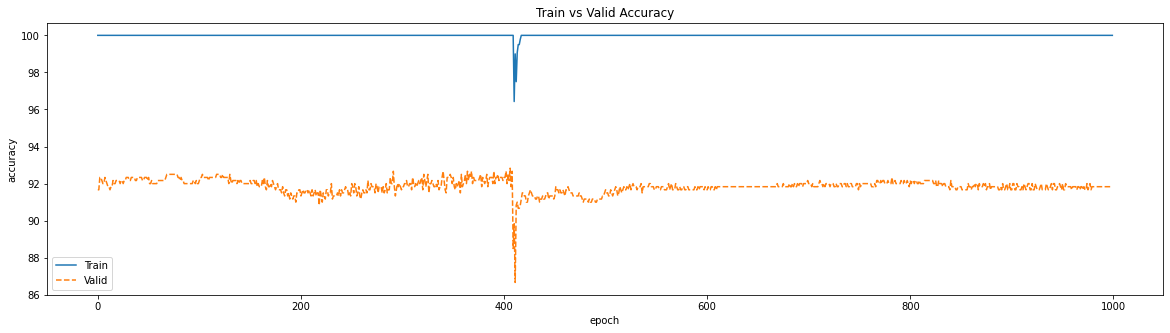

In [93]:
accuracy_plots(train_accu, eval_accu)

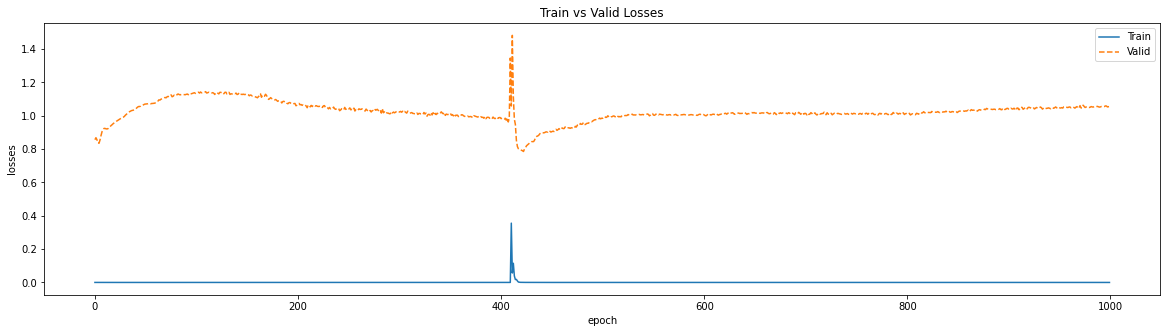

In [94]:
loss_plots(train_losses, eval_losses)

100%|██████████| 5/5 [00:00<00:00, 1776.04it/s]


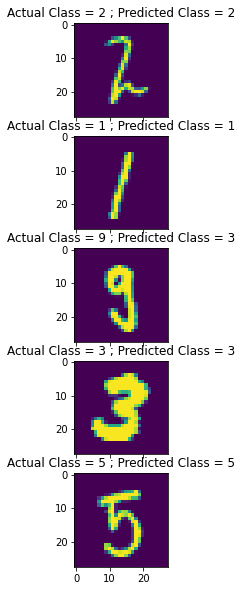

In [95]:
model = model_configs["3"]
model.load_state_dict(torch.load("models/best_model_parameters33.pth"))
model.eval()

with torch.no_grad():
  predicted_classes = []
  device = torch.device("cpu")
  for data in tqdm(first_five_loader):
    images,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(images)
    _, predicted = torch.max(outputs, 1)
    predicted_classes.append(predicted)


fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for j in range(5):
  axs[j].imshow(first_five_test_images[j][0])
  axs[j].set_title(f"Actual Class = {first_five_test_image_labels[0+j]} ; Predicted Class = {predicted_classes[j].item()}")

for ax in axs.flat:
    ax.label_outer()

# model 4, training config 1 : 

In [96]:
s = time.time()
eval_losses, train_losses, eval_accu, train_accu = train("4", "1")
e = time.time()

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |   313600   |
|  l1.bias  |    400     |
| l2.weight |   80000    |
|  l2.bias  |    200     |
| bn.weight |    200     |
|  bn.bias  |    200     |
| l3.weight |    2000    |
|  l3.bias  |     10     |
+-----------+------------+
Total Trainable Params: 396610

Epoch : 1


100%|██████████| 2/2 [00:00<00:00, 127.22it/s]



Epoch : 2


100%|██████████| 2/2 [00:00<00:00, 126.80it/s]



Epoch : 3


100%|██████████| 2/2 [00:00<00:00, 139.97it/s]



Epoch : 4


100%|██████████| 2/2 [00:00<00:00, 118.98it/s]



Epoch : 5


100%|██████████| 2/2 [00:00<00:00, 119.57it/s]



Epoch : 6


100%|██████████| 2/2 [00:00<00:00, 132.90it/s]



Epoch : 7


100%|██████████| 2/2 [00:00<00:00, 130.48it/s]



Epoch : 8


100%|██████████| 2/2 [00:00<00:00, 115.98it/s]



Epoch : 9


100%|██████████| 2/2 [00:00<00:00, 126.31it/s]



Epoch : 10


100%|██████████| 2/2 [00:00<00:00, 120.94it/s]



Epoch : 11


100%|██████████| 2/2 [00:00<00:00, 93.27it/s]



Epoch : 12


100%|██████████| 2/2 [00:00<00:00, 127.82it/s]



Epoch : 13


100%|██████████| 2/2 [00:00<00:00, 107.31it/s]



Epoch : 14


100%|██████████| 2/2 [00:00<00:00, 100.61it/s]



Epoch : 15


100%|██████████| 2/2 [00:00<00:00, 127.59it/s]



Epoch : 16


100%|██████████| 2/2 [00:00<00:00, 106.47it/s]



Epoch : 17


100%|██████████| 2/2 [00:00<00:00, 116.52it/s]



Epoch : 18


100%|██████████| 2/2 [00:00<00:00, 116.04it/s]



Epoch : 19


100%|██████████| 2/2 [00:00<00:00, 123.17it/s]



Epoch : 20


100%|██████████| 2/2 [00:00<00:00, 110.58it/s]



Epoch : 21


100%|██████████| 2/2 [00:00<00:00, 89.44it/s]



Epoch : 22


100%|██████████| 2/2 [00:00<00:00, 76.00it/s]



Epoch : 23


100%|██████████| 2/2 [00:00<00:00, 115.67it/s]



Epoch : 24


100%|██████████| 2/2 [00:00<00:00, 116.70it/s]



Epoch : 25


100%|██████████| 2/2 [00:00<00:00, 121.17it/s]



Epoch : 26


100%|██████████| 2/2 [00:00<00:00, 129.41it/s]



Epoch : 27


100%|██████████| 2/2 [00:00<00:00, 125.52it/s]



Epoch : 28


100%|██████████| 2/2 [00:00<00:00, 130.22it/s]



Epoch : 29


100%|██████████| 2/2 [00:00<00:00, 124.64it/s]



Epoch : 30


100%|██████████| 2/2 [00:00<00:00, 126.07it/s]



Epoch : 31


100%|██████████| 2/2 [00:00<00:00, 122.29it/s]



Epoch : 32


100%|██████████| 2/2 [00:00<00:00, 117.86it/s]



Epoch : 33


100%|██████████| 2/2 [00:00<00:00, 124.37it/s]



Epoch : 34


100%|██████████| 2/2 [00:00<00:00, 120.21it/s]



Epoch : 35


100%|██████████| 2/2 [00:00<00:00, 103.32it/s]



Epoch : 36


100%|██████████| 2/2 [00:00<00:00, 124.06it/s]



Epoch : 37


100%|██████████| 2/2 [00:00<00:00, 128.03it/s]



Epoch : 38


100%|██████████| 2/2 [00:00<00:00, 125.83it/s]



Epoch : 39


100%|██████████| 2/2 [00:00<00:00, 115.40it/s]



Epoch : 40


100%|██████████| 2/2 [00:00<00:00, 132.26it/s]



Epoch : 41


100%|██████████| 2/2 [00:00<00:00, 126.78it/s]



Epoch : 42


100%|██████████| 2/2 [00:00<00:00, 112.68it/s]



Epoch : 43


100%|██████████| 2/2 [00:00<00:00, 93.84it/s]



Epoch : 44


100%|██████████| 2/2 [00:00<00:00, 118.99it/s]



Epoch : 45


100%|██████████| 2/2 [00:00<00:00, 130.27it/s]



Epoch : 46


100%|██████████| 2/2 [00:00<00:00, 117.86it/s]



Epoch : 47


100%|██████████| 2/2 [00:00<00:00, 115.99it/s]



Epoch : 48


100%|██████████| 2/2 [00:00<00:00, 125.14it/s]



Epoch : 49


100%|██████████| 2/2 [00:00<00:00, 98.33it/s]



Epoch : 50


100%|██████████| 2/2 [00:00<00:00, 130.87it/s]



Epoch : 51


100%|██████████| 2/2 [00:00<00:00, 123.63it/s]



Epoch : 52


100%|██████████| 2/2 [00:00<00:00, 96.60it/s]



Epoch : 53


100%|██████████| 2/2 [00:00<00:00, 107.53it/s]



Epoch : 54


100%|██████████| 2/2 [00:00<00:00, 135.65it/s]



Epoch : 55


100%|██████████| 2/2 [00:00<00:00, 124.97it/s]



Epoch : 56


100%|██████████| 2/2 [00:00<00:00, 121.96it/s]



Epoch : 57


100%|██████████| 2/2 [00:00<00:00, 118.39it/s]



Epoch : 58


100%|██████████| 2/2 [00:00<00:00, 116.34it/s]



Epoch : 59


100%|██████████| 2/2 [00:00<00:00, 117.99it/s]



Epoch : 60


100%|██████████| 2/2 [00:00<00:00, 86.83it/s]



Epoch : 61


100%|██████████| 2/2 [00:00<00:00, 126.97it/s]



Epoch : 62


100%|██████████| 2/2 [00:00<00:00, 129.38it/s]



Epoch : 63


100%|██████████| 2/2 [00:00<00:00, 118.13it/s]



Epoch : 64


100%|██████████| 2/2 [00:00<00:00, 106.35it/s]



Epoch : 65


100%|██████████| 2/2 [00:00<00:00, 120.35it/s]



Epoch : 66


100%|██████████| 2/2 [00:00<00:00, 114.19it/s]



Epoch : 67


100%|██████████| 2/2 [00:00<00:00, 68.89it/s]



Epoch : 68


100%|██████████| 2/2 [00:00<00:00, 108.39it/s]



Epoch : 69


100%|██████████| 2/2 [00:00<00:00, 109.78it/s]



Epoch : 70


100%|██████████| 2/2 [00:00<00:00, 124.46it/s]



Epoch : 71


100%|██████████| 2/2 [00:00<00:00, 116.10it/s]



Epoch : 72


100%|██████████| 2/2 [00:00<00:00, 104.89it/s]



Epoch : 73


100%|██████████| 2/2 [00:00<00:00, 111.59it/s]



Epoch : 74


100%|██████████| 2/2 [00:00<00:00, 114.13it/s]



Epoch : 75


100%|██████████| 2/2 [00:00<00:00, 113.52it/s]



Epoch : 76


100%|██████████| 2/2 [00:00<00:00, 105.87it/s]



Epoch : 77


100%|██████████| 2/2 [00:00<00:00, 113.52it/s]



Epoch : 78


100%|██████████| 2/2 [00:00<00:00, 108.36it/s]



Epoch : 79


100%|██████████| 2/2 [00:00<00:00, 107.04it/s]



Epoch : 80


100%|██████████| 2/2 [00:00<00:00, 128.62it/s]



Epoch : 81


100%|██████████| 2/2 [00:00<00:00, 126.28it/s]



Epoch : 82


100%|██████████| 2/2 [00:00<00:00, 113.67it/s]



Epoch : 83


100%|██████████| 2/2 [00:00<00:00, 123.31it/s]



Epoch : 84


100%|██████████| 2/2 [00:00<00:00, 126.37it/s]



Epoch : 85


100%|██████████| 2/2 [00:00<00:00, 114.83it/s]



Epoch : 86


100%|██████████| 2/2 [00:00<00:00, 107.78it/s]



Epoch : 87


100%|██████████| 2/2 [00:00<00:00, 130.58it/s]



Epoch : 88


100%|██████████| 2/2 [00:00<00:00, 122.60it/s]



Epoch : 89


100%|██████████| 2/2 [00:00<00:00, 134.35it/s]



Epoch : 90


100%|██████████| 2/2 [00:00<00:00, 110.98it/s]



Epoch : 91


100%|██████████| 2/2 [00:00<00:00, 102.76it/s]



Epoch : 92


100%|██████████| 2/2 [00:00<00:00, 92.36it/s]



Epoch : 93


100%|██████████| 2/2 [00:00<00:00, 127.69it/s]



Epoch : 94


100%|██████████| 2/2 [00:00<00:00, 112.91it/s]



Epoch : 95


100%|██████████| 2/2 [00:00<00:00, 112.62it/s]



Epoch : 96


100%|██████████| 2/2 [00:00<00:00, 114.17it/s]



Epoch : 97


100%|██████████| 2/2 [00:00<00:00, 100.80it/s]



Epoch : 98


100%|██████████| 2/2 [00:00<00:00, 120.77it/s]



Epoch : 99


100%|██████████| 2/2 [00:00<00:00, 108.87it/s]



Epoch : 100


100%|██████████| 2/2 [00:00<00:00, 121.10it/s]



Epoch : 101


100%|██████████| 2/2 [00:00<00:00, 107.69it/s]



Epoch : 102


100%|██████████| 2/2 [00:00<00:00, 97.42it/s]



Epoch : 103


100%|██████████| 2/2 [00:00<00:00, 119.18it/s]



Epoch : 104


100%|██████████| 2/2 [00:00<00:00, 116.61it/s]



Epoch : 105


100%|██████████| 2/2 [00:00<00:00, 142.53it/s]



Epoch : 106


100%|██████████| 2/2 [00:00<00:00, 127.79it/s]



Epoch : 107


100%|██████████| 2/2 [00:00<00:00, 139.77it/s]



Epoch : 108


100%|██████████| 2/2 [00:00<00:00, 109.64it/s]



Epoch : 109


100%|██████████| 2/2 [00:00<00:00, 115.08it/s]



Epoch : 110


100%|██████████| 2/2 [00:00<00:00, 115.63it/s]



Epoch : 111


100%|██████████| 2/2 [00:00<00:00, 100.74it/s]



Epoch : 112


100%|██████████| 2/2 [00:00<00:00, 111.82it/s]



Epoch : 113


100%|██████████| 2/2 [00:00<00:00, 108.06it/s]



Epoch : 114


100%|██████████| 2/2 [00:00<00:00, 124.47it/s]



Epoch : 115


100%|██████████| 2/2 [00:00<00:00, 117.44it/s]



Epoch : 116


100%|██████████| 2/2 [00:00<00:00, 112.38it/s]



Epoch : 117


100%|██████████| 2/2 [00:00<00:00, 111.82it/s]



Epoch : 118


100%|██████████| 2/2 [00:00<00:00, 118.69it/s]



Epoch : 119


100%|██████████| 2/2 [00:00<00:00, 112.28it/s]



Epoch : 120


100%|██████████| 2/2 [00:00<00:00, 110.31it/s]



Epoch : 121


100%|██████████| 2/2 [00:00<00:00, 113.68it/s]



Epoch : 122


100%|██████████| 2/2 [00:00<00:00, 111.15it/s]



Epoch : 123


100%|██████████| 2/2 [00:00<00:00, 111.85it/s]



Epoch : 124


100%|██████████| 2/2 [00:00<00:00, 109.64it/s]



Epoch : 125


100%|██████████| 2/2 [00:00<00:00, 99.42it/s]



Epoch : 126


100%|██████████| 2/2 [00:00<00:00, 124.70it/s]



Epoch : 127


100%|██████████| 2/2 [00:00<00:00, 122.47it/s]



Epoch : 128


100%|██████████| 2/2 [00:00<00:00, 125.04it/s]



Epoch : 129


100%|██████████| 2/2 [00:00<00:00, 110.55it/s]



Epoch : 130


100%|██████████| 2/2 [00:00<00:00, 120.94it/s]



Epoch : 131


100%|██████████| 2/2 [00:00<00:00, 111.43it/s]



Epoch : 132


100%|██████████| 2/2 [00:00<00:00, 103.62it/s]



Epoch : 133


100%|██████████| 2/2 [00:00<00:00, 90.37it/s]



Epoch : 134


100%|██████████| 2/2 [00:00<00:00, 109.20it/s]



Epoch : 135


100%|██████████| 2/2 [00:00<00:00, 80.77it/s]



Epoch : 136


100%|██████████| 2/2 [00:00<00:00, 113.12it/s]



Epoch : 137


100%|██████████| 2/2 [00:00<00:00, 99.50it/s]



Epoch : 138


100%|██████████| 2/2 [00:00<00:00, 108.32it/s]



Epoch : 139


100%|██████████| 2/2 [00:00<00:00, 110.37it/s]



Epoch : 140


100%|██████████| 2/2 [00:00<00:00, 109.95it/s]



Epoch : 141


100%|██████████| 2/2 [00:00<00:00, 119.75it/s]



Epoch : 142


100%|██████████| 2/2 [00:00<00:00, 125.35it/s]



Epoch : 143


100%|██████████| 2/2 [00:00<00:00, 117.35it/s]



Epoch : 144


100%|██████████| 2/2 [00:00<00:00, 83.28it/s]



Epoch : 145


100%|██████████| 2/2 [00:00<00:00, 109.59it/s]



Epoch : 146


100%|██████████| 2/2 [00:00<00:00, 95.07it/s]



Epoch : 147


100%|██████████| 2/2 [00:00<00:00, 108.24it/s]



Epoch : 148


100%|██████████| 2/2 [00:00<00:00, 103.40it/s]



Epoch : 149


100%|██████████| 2/2 [00:00<00:00, 126.07it/s]



Epoch : 150


100%|██████████| 2/2 [00:00<00:00, 96.32it/s]



Epoch : 151


100%|██████████| 2/2 [00:00<00:00, 113.98it/s]



Epoch : 152


100%|██████████| 2/2 [00:00<00:00, 107.38it/s]



Epoch : 153


100%|██████████| 2/2 [00:00<00:00, 102.15it/s]



Epoch : 154


100%|██████████| 2/2 [00:00<00:00, 99.87it/s]



Epoch : 155


100%|██████████| 2/2 [00:00<00:00, 99.94it/s]



Epoch : 156


100%|██████████| 2/2 [00:00<00:00, 110.34it/s]



Epoch : 157


100%|██████████| 2/2 [00:00<00:00, 98.30it/s]



Epoch : 158


100%|██████████| 2/2 [00:00<00:00, 110.96it/s]



Epoch : 159


100%|██████████| 2/2 [00:00<00:00, 106.20it/s]



Epoch : 160


100%|██████████| 2/2 [00:00<00:00, 106.20it/s]



Epoch : 161


100%|██████████| 2/2 [00:00<00:00, 105.31it/s]



Epoch : 162


100%|██████████| 2/2 [00:00<00:00, 114.38it/s]



Epoch : 163


100%|██████████| 2/2 [00:00<00:00, 112.37it/s]



Epoch : 164


100%|██████████| 2/2 [00:00<00:00, 104.84it/s]



Epoch : 165


100%|██████████| 2/2 [00:00<00:00, 105.09it/s]



Epoch : 166


100%|██████████| 2/2 [00:00<00:00, 111.14it/s]



Epoch : 167


100%|██████████| 2/2 [00:00<00:00, 92.06it/s]



Epoch : 168


100%|██████████| 2/2 [00:00<00:00, 109.36it/s]



Epoch : 169


100%|██████████| 2/2 [00:00<00:00, 108.95it/s]



Epoch : 170


100%|██████████| 2/2 [00:00<00:00, 97.54it/s]



Epoch : 171


100%|██████████| 2/2 [00:00<00:00, 102.53it/s]



Epoch : 172


100%|██████████| 2/2 [00:00<00:00, 118.30it/s]



Epoch : 173


100%|██████████| 2/2 [00:00<00:00, 104.81it/s]



Epoch : 174


100%|██████████| 2/2 [00:00<00:00, 108.29it/s]



Epoch : 175


100%|██████████| 2/2 [00:00<00:00, 119.69it/s]



Epoch : 176


100%|██████████| 2/2 [00:00<00:00, 100.34it/s]



Epoch : 177


100%|██████████| 2/2 [00:00<00:00, 103.68it/s]



Epoch : 178


100%|██████████| 2/2 [00:00<00:00, 98.74it/s]



Epoch : 179


100%|██████████| 2/2 [00:00<00:00, 108.28it/s]



Epoch : 180


100%|██████████| 2/2 [00:00<00:00, 114.60it/s]



Epoch : 181


100%|██████████| 2/2 [00:00<00:00, 73.39it/s]



Epoch : 182


100%|██████████| 2/2 [00:00<00:00, 109.97it/s]



Epoch : 183


100%|██████████| 2/2 [00:00<00:00, 118.46it/s]



Epoch : 184


100%|██████████| 2/2 [00:00<00:00, 109.37it/s]



Epoch : 185


100%|██████████| 2/2 [00:00<00:00, 110.29it/s]



Epoch : 186


100%|██████████| 2/2 [00:00<00:00, 108.98it/s]



Epoch : 187


100%|██████████| 2/2 [00:00<00:00, 96.81it/s]



Epoch : 188


100%|██████████| 2/2 [00:00<00:00, 108.85it/s]



Epoch : 189


100%|██████████| 2/2 [00:00<00:00, 127.72it/s]



Epoch : 190


100%|██████████| 2/2 [00:00<00:00, 102.94it/s]



Epoch : 191


100%|██████████| 2/2 [00:00<00:00, 104.70it/s]



Epoch : 192


100%|██████████| 2/2 [00:00<00:00, 106.76it/s]



Epoch : 193


100%|██████████| 2/2 [00:00<00:00, 109.83it/s]



Epoch : 194


100%|██████████| 2/2 [00:00<00:00, 105.82it/s]



Epoch : 195


100%|██████████| 2/2 [00:00<00:00, 92.53it/s]



Epoch : 196


100%|██████████| 2/2 [00:00<00:00, 86.10it/s]



Epoch : 197


100%|██████████| 2/2 [00:00<00:00, 106.17it/s]



Epoch : 198


100%|██████████| 2/2 [00:00<00:00, 112.51it/s]



Epoch : 199


100%|██████████| 2/2 [00:00<00:00, 109.47it/s]



Epoch : 200


100%|██████████| 2/2 [00:00<00:00, 106.71it/s]



Epoch : 201


100%|██████████| 2/2 [00:00<00:00, 107.83it/s]



Epoch : 202


100%|██████████| 2/2 [00:00<00:00, 95.65it/s]



Epoch : 203


100%|██████████| 2/2 [00:00<00:00, 105.03it/s]



Epoch : 204


100%|██████████| 2/2 [00:00<00:00, 91.82it/s]



Epoch : 205


100%|██████████| 2/2 [00:00<00:00, 105.71it/s]



Epoch : 206


100%|██████████| 2/2 [00:00<00:00, 96.29it/s]



Epoch : 207


100%|██████████| 2/2 [00:00<00:00, 102.85it/s]



Epoch : 208


100%|██████████| 2/2 [00:00<00:00, 105.53it/s]



Epoch : 209


100%|██████████| 2/2 [00:00<00:00, 98.12it/s]



Epoch : 210


100%|██████████| 2/2 [00:00<00:00, 102.47it/s]



Epoch : 211


100%|██████████| 2/2 [00:00<00:00, 107.07it/s]



Epoch : 212


100%|██████████| 2/2 [00:00<00:00, 109.04it/s]



Epoch : 213


100%|██████████| 2/2 [00:00<00:00, 107.54it/s]



Epoch : 214


100%|██████████| 2/2 [00:00<00:00, 108.01it/s]



Epoch : 215


100%|██████████| 2/2 [00:00<00:00, 98.32it/s]



Epoch : 216


100%|██████████| 2/2 [00:00<00:00, 108.28it/s]



Epoch : 217


100%|██████████| 2/2 [00:00<00:00, 106.08it/s]



Epoch : 218


100%|██████████| 2/2 [00:00<00:00, 79.79it/s]



Epoch : 219


100%|██████████| 2/2 [00:00<00:00, 109.71it/s]



Epoch : 220


100%|██████████| 2/2 [00:00<00:00, 107.76it/s]



Epoch : 221


100%|██████████| 2/2 [00:00<00:00, 100.33it/s]



Epoch : 222


100%|██████████| 2/2 [00:00<00:00, 107.07it/s]



Epoch : 223


100%|██████████| 2/2 [00:00<00:00, 100.70it/s]



Epoch : 224


100%|██████████| 2/2 [00:00<00:00, 101.90it/s]



Epoch : 225


100%|██████████| 2/2 [00:00<00:00, 68.83it/s]



Epoch : 226


100%|██████████| 2/2 [00:00<00:00, 107.16it/s]



Epoch : 227


100%|██████████| 2/2 [00:00<00:00, 67.42it/s]



Epoch : 228


100%|██████████| 2/2 [00:00<00:00, 102.14it/s]



Epoch : 229


100%|██████████| 2/2 [00:00<00:00, 86.30it/s]



Epoch : 230


100%|██████████| 2/2 [00:00<00:00, 114.35it/s]



Epoch : 231


100%|██████████| 2/2 [00:00<00:00, 101.98it/s]



Epoch : 232


100%|██████████| 2/2 [00:00<00:00, 91.51it/s]



Epoch : 233


100%|██████████| 2/2 [00:00<00:00, 131.82it/s]



Epoch : 234


100%|██████████| 2/2 [00:00<00:00, 104.96it/s]



Epoch : 235


100%|██████████| 2/2 [00:00<00:00, 104.93it/s]



Epoch : 236


100%|██████████| 2/2 [00:00<00:00, 99.18it/s]



Epoch : 237


100%|██████████| 2/2 [00:00<00:00, 103.29it/s]



Epoch : 238


100%|██████████| 2/2 [00:00<00:00, 103.92it/s]



Epoch : 239


100%|██████████| 2/2 [00:00<00:00, 115.05it/s]



Epoch : 240


100%|██████████| 2/2 [00:00<00:00, 109.51it/s]



Epoch : 241


100%|██████████| 2/2 [00:00<00:00, 90.81it/s]



Epoch : 242


100%|██████████| 2/2 [00:00<00:00, 105.17it/s]



Epoch : 243


100%|██████████| 2/2 [00:00<00:00, 98.51it/s]



Epoch : 244


100%|██████████| 2/2 [00:00<00:00, 104.56it/s]



Epoch : 245


100%|██████████| 2/2 [00:00<00:00, 96.05it/s]



Epoch : 246


100%|██████████| 2/2 [00:00<00:00, 92.68it/s]



Epoch : 247


100%|██████████| 2/2 [00:00<00:00, 95.87it/s]



Epoch : 248


100%|██████████| 2/2 [00:00<00:00, 96.67it/s]



Epoch : 249


100%|██████████| 2/2 [00:00<00:00, 98.18it/s]



Epoch : 250


100%|██████████| 2/2 [00:00<00:00, 112.85it/s]



Epoch : 251


100%|██████████| 2/2 [00:00<00:00, 93.60it/s]



Epoch : 252


100%|██████████| 2/2 [00:00<00:00, 105.40it/s]



Epoch : 253


100%|██████████| 2/2 [00:00<00:00, 103.12it/s]



Epoch : 254


100%|██████████| 2/2 [00:00<00:00, 102.04it/s]



Epoch : 255


100%|██████████| 2/2 [00:00<00:00, 97.37it/s]



Epoch : 256


100%|██████████| 2/2 [00:00<00:00, 98.52it/s]



Epoch : 257


100%|██████████| 2/2 [00:00<00:00, 106.26it/s]



Epoch : 258


100%|██████████| 2/2 [00:00<00:00, 102.83it/s]



Epoch : 259


100%|██████████| 2/2 [00:00<00:00, 119.64it/s]



Epoch : 260


100%|██████████| 2/2 [00:00<00:00, 100.11it/s]



Epoch : 261


100%|██████████| 2/2 [00:00<00:00, 88.61it/s]



Epoch : 262


100%|██████████| 2/2 [00:00<00:00, 87.69it/s]



Epoch : 263


100%|██████████| 2/2 [00:00<00:00, 98.71it/s]



Epoch : 264


100%|██████████| 2/2 [00:00<00:00, 92.94it/s]



Epoch : 265


100%|██████████| 2/2 [00:00<00:00, 110.62it/s]



Epoch : 266


100%|██████████| 2/2 [00:00<00:00, 100.38it/s]



Epoch : 267


100%|██████████| 2/2 [00:00<00:00, 104.23it/s]



Epoch : 268


100%|██████████| 2/2 [00:00<00:00, 122.02it/s]



Epoch : 269


100%|██████████| 2/2 [00:00<00:00, 101.38it/s]



Epoch : 270


100%|██████████| 2/2 [00:00<00:00, 108.96it/s]



Epoch : 271


100%|██████████| 2/2 [00:00<00:00, 102.96it/s]



Epoch : 272


100%|██████████| 2/2 [00:00<00:00, 86.25it/s]



Epoch : 273


100%|██████████| 2/2 [00:00<00:00, 97.15it/s]



Epoch : 274


100%|██████████| 2/2 [00:00<00:00, 96.43it/s]



Epoch : 275


100%|██████████| 2/2 [00:00<00:00, 98.32it/s]



Epoch : 276


100%|██████████| 2/2 [00:00<00:00, 94.07it/s]



Epoch : 277


100%|██████████| 2/2 [00:00<00:00, 84.87it/s]



Epoch : 278


100%|██████████| 2/2 [00:00<00:00, 102.98it/s]



Epoch : 279


100%|██████████| 2/2 [00:00<00:00, 98.21it/s]



Epoch : 280


100%|██████████| 2/2 [00:00<00:00, 109.65it/s]



Epoch : 281


100%|██████████| 2/2 [00:00<00:00, 86.37it/s]



Epoch : 282


100%|██████████| 2/2 [00:00<00:00, 96.56it/s]



Epoch : 283


100%|██████████| 2/2 [00:00<00:00, 96.78it/s]



Epoch : 284


100%|██████████| 2/2 [00:00<00:00, 100.34it/s]



Epoch : 285


100%|██████████| 2/2 [00:00<00:00, 100.19it/s]



Epoch : 286


100%|██████████| 2/2 [00:00<00:00, 101.79it/s]



Epoch : 287


100%|██████████| 2/2 [00:00<00:00, 69.63it/s]



Epoch : 288


100%|██████████| 2/2 [00:00<00:00, 112.48it/s]



Epoch : 289


100%|██████████| 2/2 [00:00<00:00, 112.33it/s]



Epoch : 290


100%|██████████| 2/2 [00:00<00:00, 88.39it/s]



Epoch : 291


100%|██████████| 2/2 [00:00<00:00, 100.78it/s]



Epoch : 292


100%|██████████| 2/2 [00:00<00:00, 99.10it/s]



Epoch : 293


100%|██████████| 2/2 [00:00<00:00, 98.74it/s]



Epoch : 294


100%|██████████| 2/2 [00:00<00:00, 95.47it/s]



Epoch : 295


100%|██████████| 2/2 [00:00<00:00, 101.10it/s]



Epoch : 296


100%|██████████| 2/2 [00:00<00:00, 109.15it/s]



Epoch : 297


100%|██████████| 2/2 [00:00<00:00, 98.45it/s]



Epoch : 298


100%|██████████| 2/2 [00:00<00:00, 108.81it/s]



Epoch : 299


100%|██████████| 2/2 [00:00<00:00, 99.93it/s]



Epoch : 300


100%|██████████| 2/2 [00:00<00:00, 96.79it/s]



Epoch : 301


100%|██████████| 2/2 [00:00<00:00, 103.05it/s]



Epoch : 302


100%|██████████| 2/2 [00:00<00:00, 102.15it/s]



Epoch : 303


100%|██████████| 2/2 [00:00<00:00, 96.60it/s]



Epoch : 304


100%|██████████| 2/2 [00:00<00:00, 92.11it/s]



Epoch : 305


100%|██████████| 2/2 [00:00<00:00, 94.96it/s]



Epoch : 306


100%|██████████| 2/2 [00:00<00:00, 95.05it/s]



Epoch : 307


100%|██████████| 2/2 [00:00<00:00, 96.27it/s]



Epoch : 308


100%|██████████| 2/2 [00:00<00:00, 92.87it/s]



Epoch : 309


100%|██████████| 2/2 [00:00<00:00, 94.14it/s]



Epoch : 310


100%|██████████| 2/2 [00:00<00:00, 111.85it/s]



Epoch : 311


100%|██████████| 2/2 [00:00<00:00, 100.01it/s]



Epoch : 312


100%|██████████| 2/2 [00:00<00:00, 99.12it/s]



Epoch : 313


100%|██████████| 2/2 [00:00<00:00, 97.32it/s]



Epoch : 314


100%|██████████| 2/2 [00:00<00:00, 97.70it/s]



Epoch : 315


100%|██████████| 2/2 [00:00<00:00, 91.53it/s]



Epoch : 316


100%|██████████| 2/2 [00:00<00:00, 96.66it/s]



Epoch : 317


100%|██████████| 2/2 [00:00<00:00, 102.94it/s]



Epoch : 318


100%|██████████| 2/2 [00:00<00:00, 106.44it/s]



Epoch : 319


100%|██████████| 2/2 [00:00<00:00, 87.06it/s]



Epoch : 320


100%|██████████| 2/2 [00:00<00:00, 99.15it/s]



Epoch : 321


100%|██████████| 2/2 [00:00<00:00, 100.19it/s]



Epoch : 322


100%|██████████| 2/2 [00:00<00:00, 95.24it/s]



Epoch : 323


100%|██████████| 2/2 [00:00<00:00, 95.36it/s]



Epoch : 324


100%|██████████| 2/2 [00:00<00:00, 94.02it/s]



Epoch : 325


100%|██████████| 2/2 [00:00<00:00, 102.70it/s]



Epoch : 326


100%|██████████| 2/2 [00:00<00:00, 95.21it/s]



Epoch : 327


100%|██████████| 2/2 [00:00<00:00, 96.66it/s]



Epoch : 328


100%|██████████| 2/2 [00:00<00:00, 95.14it/s]



Epoch : 329


100%|██████████| 2/2 [00:00<00:00, 95.03it/s]



Epoch : 330


100%|██████████| 2/2 [00:00<00:00, 69.90it/s]



Epoch : 331


100%|██████████| 2/2 [00:00<00:00, 93.17it/s]



Epoch : 332


100%|██████████| 2/2 [00:00<00:00, 96.76it/s]



Epoch : 333


100%|██████████| 2/2 [00:00<00:00, 86.09it/s]



Epoch : 334


100%|██████████| 2/2 [00:00<00:00, 104.56it/s]



Epoch : 335


100%|██████████| 2/2 [00:00<00:00, 102.62it/s]



Epoch : 336


100%|██████████| 2/2 [00:00<00:00, 97.32it/s]



Epoch : 337


100%|██████████| 2/2 [00:00<00:00, 81.69it/s]



Epoch : 338


100%|██████████| 2/2 [00:00<00:00, 92.85it/s]



Epoch : 339


100%|██████████| 2/2 [00:00<00:00, 93.67it/s]



Epoch : 340


100%|██████████| 2/2 [00:00<00:00, 101.50it/s]



Epoch : 341


100%|██████████| 2/2 [00:00<00:00, 105.15it/s]



Epoch : 342


100%|██████████| 2/2 [00:00<00:00, 87.37it/s]



Epoch : 343


100%|██████████| 2/2 [00:00<00:00, 90.83it/s]



Epoch : 344


100%|██████████| 2/2 [00:00<00:00, 90.95it/s]



Epoch : 345


100%|██████████| 2/2 [00:00<00:00, 96.19it/s]



Epoch : 346


100%|██████████| 2/2 [00:00<00:00, 98.39it/s]



Epoch : 347


100%|██████████| 2/2 [00:00<00:00, 95.51it/s]



Epoch : 348


100%|██████████| 2/2 [00:00<00:00, 102.32it/s]



Epoch : 349


100%|██████████| 2/2 [00:00<00:00, 100.38it/s]



Epoch : 350


100%|██████████| 2/2 [00:00<00:00, 95.76it/s]



Epoch : 351


100%|██████████| 2/2 [00:00<00:00, 93.40it/s]



Epoch : 352


100%|██████████| 2/2 [00:00<00:00, 72.49it/s]



Epoch : 353


100%|██████████| 2/2 [00:00<00:00, 98.16it/s]



Epoch : 354


100%|██████████| 2/2 [00:00<00:00, 82.02it/s]



Epoch : 355


100%|██████████| 2/2 [00:00<00:00, 106.34it/s]



Epoch : 356


100%|██████████| 2/2 [00:00<00:00, 97.76it/s]



Epoch : 357


100%|██████████| 2/2 [00:00<00:00, 99.64it/s]



Epoch : 358


100%|██████████| 2/2 [00:00<00:00, 89.25it/s]



Epoch : 359


100%|██████████| 2/2 [00:00<00:00, 93.71it/s]



Epoch : 360


100%|██████████| 2/2 [00:00<00:00, 98.46it/s]



Epoch : 361


100%|██████████| 2/2 [00:00<00:00, 92.16it/s]



Epoch : 362


100%|██████████| 2/2 [00:00<00:00, 96.10it/s]



Epoch : 363


100%|██████████| 2/2 [00:00<00:00, 115.95it/s]



Epoch : 364


100%|██████████| 2/2 [00:00<00:00, 118.90it/s]



Epoch : 365


100%|██████████| 2/2 [00:00<00:00, 95.64it/s]



Epoch : 366


100%|██████████| 2/2 [00:00<00:00, 93.34it/s]



Epoch : 367


100%|██████████| 2/2 [00:00<00:00, 118.20it/s]



Epoch : 368


100%|██████████| 2/2 [00:00<00:00, 95.74it/s]



Epoch : 369


100%|██████████| 2/2 [00:00<00:00, 98.37it/s]



Epoch : 370


100%|██████████| 2/2 [00:00<00:00, 103.89it/s]



Epoch : 371


100%|██████████| 2/2 [00:00<00:00, 88.55it/s]



Epoch : 372


100%|██████████| 2/2 [00:00<00:00, 95.10it/s]



Epoch : 373


100%|██████████| 2/2 [00:00<00:00, 94.90it/s]



Epoch : 374


100%|██████████| 2/2 [00:00<00:00, 87.54it/s]



Epoch : 375


100%|██████████| 2/2 [00:00<00:00, 93.27it/s]



Epoch : 376


100%|██████████| 2/2 [00:00<00:00, 102.03it/s]



Epoch : 377


100%|██████████| 2/2 [00:00<00:00, 108.23it/s]



Epoch : 378


100%|██████████| 2/2 [00:00<00:00, 104.16it/s]



Epoch : 379


100%|██████████| 2/2 [00:00<00:00, 117.33it/s]



Epoch : 380


100%|██████████| 2/2 [00:00<00:00, 98.61it/s]



Epoch : 381


100%|██████████| 2/2 [00:00<00:00, 96.65it/s]



Epoch : 382


100%|██████████| 2/2 [00:00<00:00, 92.41it/s]



Epoch : 383


100%|██████████| 2/2 [00:00<00:00, 99.43it/s]



Epoch : 384


100%|██████████| 2/2 [00:00<00:00, 95.99it/s]



Epoch : 385


100%|██████████| 2/2 [00:00<00:00, 94.25it/s]



Epoch : 386


100%|██████████| 2/2 [00:00<00:00, 88.14it/s]



Epoch : 387


100%|██████████| 2/2 [00:00<00:00, 100.34it/s]



Epoch : 388


100%|██████████| 2/2 [00:00<00:00, 76.83it/s]



Epoch : 389


100%|██████████| 2/2 [00:00<00:00, 89.82it/s]



Epoch : 390


100%|██████████| 2/2 [00:00<00:00, 89.71it/s]



Epoch : 391


100%|██████████| 2/2 [00:00<00:00, 96.54it/s]



Epoch : 392


100%|██████████| 2/2 [00:00<00:00, 99.12it/s]



Epoch : 393


100%|██████████| 2/2 [00:00<00:00, 88.71it/s]



Epoch : 394


100%|██████████| 2/2 [00:00<00:00, 83.40it/s]



Epoch : 395


100%|██████████| 2/2 [00:00<00:00, 85.09it/s]



Epoch : 396


100%|██████████| 2/2 [00:00<00:00, 90.18it/s]



Epoch : 397


100%|██████████| 2/2 [00:00<00:00, 97.64it/s]



Epoch : 398


100%|██████████| 2/2 [00:00<00:00, 94.62it/s]



Epoch : 399


100%|██████████| 2/2 [00:00<00:00, 110.67it/s]



Epoch : 400


100%|██████████| 2/2 [00:00<00:00, 94.51it/s]



Epoch : 401


100%|██████████| 2/2 [00:00<00:00, 97.87it/s]



Epoch : 402


100%|██████████| 2/2 [00:00<00:00, 88.21it/s]



Epoch : 403


100%|██████████| 2/2 [00:00<00:00, 98.89it/s]



Epoch : 404


100%|██████████| 2/2 [00:00<00:00, 93.70it/s]



Epoch : 405


100%|██████████| 2/2 [00:00<00:00, 93.84it/s]



Epoch : 406


100%|██████████| 2/2 [00:00<00:00, 91.58it/s]



Epoch : 407


100%|██████████| 2/2 [00:00<00:00, 93.01it/s]



Epoch : 408


100%|██████████| 2/2 [00:00<00:00, 102.39it/s]



Epoch : 409


100%|██████████| 2/2 [00:00<00:00, 122.09it/s]



Epoch : 410


100%|██████████| 2/2 [00:00<00:00, 96.66it/s]



Epoch : 411


100%|██████████| 2/2 [00:00<00:00, 93.88it/s]



Epoch : 412


100%|██████████| 2/2 [00:00<00:00, 88.65it/s]



Epoch : 413


100%|██████████| 2/2 [00:00<00:00, 94.58it/s]



Epoch : 414


100%|██████████| 2/2 [00:00<00:00, 93.64it/s]



Epoch : 415


100%|██████████| 2/2 [00:00<00:00, 92.88it/s]



Epoch : 416


100%|██████████| 2/2 [00:00<00:00, 84.84it/s]



Epoch : 417


100%|██████████| 2/2 [00:00<00:00, 96.60it/s]



Epoch : 418


100%|██████████| 2/2 [00:00<00:00, 83.00it/s]



Epoch : 419


100%|██████████| 2/2 [00:00<00:00, 88.06it/s]



Epoch : 420


100%|██████████| 2/2 [00:00<00:00, 87.21it/s]



Epoch : 421


100%|██████████| 2/2 [00:00<00:00, 86.87it/s]



Epoch : 422


100%|██████████| 2/2 [00:00<00:00, 88.00it/s]



Epoch : 423


100%|██████████| 2/2 [00:00<00:00, 96.36it/s]



Epoch : 424


100%|██████████| 2/2 [00:00<00:00, 96.87it/s]



Epoch : 425


100%|██████████| 2/2 [00:00<00:00, 98.20it/s]



Epoch : 426


100%|██████████| 2/2 [00:00<00:00, 95.61it/s]



Epoch : 427


100%|██████████| 2/2 [00:00<00:00, 97.83it/s]



Epoch : 428


100%|██████████| 2/2 [00:00<00:00, 97.03it/s]



Epoch : 429


100%|██████████| 2/2 [00:00<00:00, 97.06it/s]



Epoch : 430


100%|██████████| 2/2 [00:00<00:00, 98.70it/s]



Epoch : 431


100%|██████████| 2/2 [00:00<00:00, 95.52it/s]



Epoch : 432


100%|██████████| 2/2 [00:00<00:00, 97.24it/s]



Epoch : 433


100%|██████████| 2/2 [00:00<00:00, 94.96it/s]



Epoch : 434


100%|██████████| 2/2 [00:00<00:00, 80.12it/s]



Epoch : 435


100%|██████████| 2/2 [00:00<00:00, 91.18it/s]



Epoch : 436


100%|██████████| 2/2 [00:00<00:00, 92.91it/s]



Epoch : 437


100%|██████████| 2/2 [00:00<00:00, 82.12it/s]



Epoch : 438


100%|██████████| 2/2 [00:00<00:00, 102.17it/s]



Epoch : 439


100%|██████████| 2/2 [00:00<00:00, 101.48it/s]



Epoch : 440


100%|██████████| 2/2 [00:00<00:00, 94.48it/s]



Epoch : 441


100%|██████████| 2/2 [00:00<00:00, 82.50it/s]



Epoch : 442


100%|██████████| 2/2 [00:00<00:00, 98.11it/s]



Epoch : 443


100%|██████████| 2/2 [00:00<00:00, 97.93it/s]



Epoch : 444


100%|██████████| 2/2 [00:00<00:00, 91.96it/s]



Epoch : 445


100%|██████████| 2/2 [00:00<00:00, 91.88it/s]



Epoch : 446


100%|██████████| 2/2 [00:00<00:00, 101.98it/s]



Epoch : 447


100%|██████████| 2/2 [00:00<00:00, 88.88it/s]



Epoch : 448


100%|██████████| 2/2 [00:00<00:00, 91.73it/s]



Epoch : 449


100%|██████████| 2/2 [00:00<00:00, 105.32it/s]



Epoch : 450


100%|██████████| 2/2 [00:00<00:00, 96.92it/s]



Epoch : 451


100%|██████████| 2/2 [00:00<00:00, 100.81it/s]



Epoch : 452


100%|██████████| 2/2 [00:00<00:00, 95.43it/s]



Epoch : 453


100%|██████████| 2/2 [00:00<00:00, 97.44it/s]



Epoch : 454


100%|██████████| 2/2 [00:00<00:00, 84.11it/s]



Epoch : 455


100%|██████████| 2/2 [00:00<00:00, 93.17it/s]



Epoch : 456


100%|██████████| 2/2 [00:00<00:00, 89.46it/s]



Epoch : 457


100%|██████████| 2/2 [00:00<00:00, 104.60it/s]



Epoch : 458


100%|██████████| 2/2 [00:00<00:00, 91.41it/s]



Epoch : 459


100%|██████████| 2/2 [00:00<00:00, 68.80it/s]



Epoch : 460


100%|██████████| 2/2 [00:00<00:00, 96.50it/s]



Epoch : 461


100%|██████████| 2/2 [00:00<00:00, 71.47it/s]



Epoch : 462


100%|██████████| 2/2 [00:00<00:00, 94.31it/s]



Epoch : 463


100%|██████████| 2/2 [00:00<00:00, 72.33it/s]



Epoch : 464


100%|██████████| 2/2 [00:00<00:00, 75.36it/s]



Epoch : 465


100%|██████████| 2/2 [00:00<00:00, 87.13it/s]



Epoch : 466


100%|██████████| 2/2 [00:00<00:00, 96.34it/s]



Epoch : 467


100%|██████████| 2/2 [00:00<00:00, 97.91it/s]



Epoch : 468


100%|██████████| 2/2 [00:00<00:00, 100.54it/s]



Epoch : 469


100%|██████████| 2/2 [00:00<00:00, 95.38it/s]



Epoch : 470


100%|██████████| 2/2 [00:00<00:00, 87.01it/s]



Epoch : 471


100%|██████████| 2/2 [00:00<00:00, 89.09it/s]



Epoch : 472


100%|██████████| 2/2 [00:00<00:00, 94.03it/s]



Epoch : 473


100%|██████████| 2/2 [00:00<00:00, 99.76it/s]



Epoch : 474


100%|██████████| 2/2 [00:00<00:00, 95.31it/s]



Epoch : 475


100%|██████████| 2/2 [00:00<00:00, 92.55it/s]



Epoch : 476


100%|██████████| 2/2 [00:00<00:00, 94.30it/s]



Epoch : 477


100%|██████████| 2/2 [00:00<00:00, 75.94it/s]



Epoch : 478


100%|██████████| 2/2 [00:00<00:00, 97.86it/s]



Epoch : 479


100%|██████████| 2/2 [00:00<00:00, 99.46it/s]



Epoch : 480


100%|██████████| 2/2 [00:00<00:00, 81.17it/s]



Epoch : 481


100%|██████████| 2/2 [00:00<00:00, 90.30it/s]



Epoch : 482


100%|██████████| 2/2 [00:00<00:00, 115.59it/s]



Epoch : 483


100%|██████████| 2/2 [00:00<00:00, 89.55it/s]



Epoch : 484


100%|██████████| 2/2 [00:00<00:00, 113.21it/s]



Epoch : 485


100%|██████████| 2/2 [00:00<00:00, 98.00it/s]



Epoch : 486


100%|██████████| 2/2 [00:00<00:00, 84.47it/s]



Epoch : 487


100%|██████████| 2/2 [00:00<00:00, 98.60it/s]



Epoch : 488


100%|██████████| 2/2 [00:00<00:00, 99.16it/s]



Epoch : 489


100%|██████████| 2/2 [00:00<00:00, 98.60it/s]



Epoch : 490


100%|██████████| 2/2 [00:00<00:00, 85.42it/s]



Epoch : 491


100%|██████████| 2/2 [00:00<00:00, 95.18it/s]



Epoch : 492


100%|██████████| 2/2 [00:00<00:00, 88.51it/s]



Epoch : 493


100%|██████████| 2/2 [00:00<00:00, 100.70it/s]



Epoch : 494


100%|██████████| 2/2 [00:00<00:00, 92.03it/s]



Epoch : 495


100%|██████████| 2/2 [00:00<00:00, 90.35it/s]



Epoch : 496


100%|██████████| 2/2 [00:00<00:00, 110.83it/s]



Epoch : 497


100%|██████████| 2/2 [00:00<00:00, 95.63it/s]



Epoch : 498


100%|██████████| 2/2 [00:00<00:00, 80.29it/s]



Epoch : 499


100%|██████████| 2/2 [00:00<00:00, 80.98it/s]



Epoch : 500


100%|██████████| 2/2 [00:00<00:00, 83.55it/s]



Epoch : 501


100%|██████████| 2/2 [00:00<00:00, 94.12it/s]



Epoch : 502


100%|██████████| 2/2 [00:00<00:00, 114.10it/s]



Epoch : 503


100%|██████████| 2/2 [00:00<00:00, 90.88it/s]



Epoch : 504


100%|██████████| 2/2 [00:00<00:00, 120.51it/s]



Epoch : 505


100%|██████████| 2/2 [00:00<00:00, 93.28it/s]



Epoch : 506


100%|██████████| 2/2 [00:00<00:00, 90.79it/s]



Epoch : 507


100%|██████████| 2/2 [00:00<00:00, 99.55it/s]



Epoch : 508


100%|██████████| 2/2 [00:00<00:00, 114.94it/s]



Epoch : 509


100%|██████████| 2/2 [00:00<00:00, 70.62it/s]



Epoch : 510


100%|██████████| 2/2 [00:00<00:00, 92.23it/s]



Epoch : 511


100%|██████████| 2/2 [00:00<00:00, 96.76it/s]



Epoch : 512


100%|██████████| 2/2 [00:00<00:00, 95.47it/s]



Epoch : 513


100%|██████████| 2/2 [00:00<00:00, 96.89it/s]



Epoch : 514


100%|██████████| 2/2 [00:00<00:00, 105.98it/s]



Epoch : 515


100%|██████████| 2/2 [00:00<00:00, 96.73it/s]



Epoch : 516


100%|██████████| 2/2 [00:00<00:00, 94.98it/s]



Epoch : 517


100%|██████████| 2/2 [00:00<00:00, 89.65it/s]



Epoch : 518


100%|██████████| 2/2 [00:00<00:00, 84.91it/s]



Epoch : 519


100%|██████████| 2/2 [00:00<00:00, 83.67it/s]



Epoch : 520


100%|██████████| 2/2 [00:00<00:00, 94.94it/s]



Epoch : 521


100%|██████████| 2/2 [00:00<00:00, 90.83it/s]



Epoch : 522


100%|██████████| 2/2 [00:00<00:00, 98.11it/s]



Epoch : 523


100%|██████████| 2/2 [00:00<00:00, 98.53it/s]



Epoch : 524


100%|██████████| 2/2 [00:00<00:00, 92.16it/s]



Epoch : 525


100%|██████████| 2/2 [00:00<00:00, 97.81it/s]



Epoch : 526


100%|██████████| 2/2 [00:00<00:00, 95.83it/s]



Epoch : 527


100%|██████████| 2/2 [00:00<00:00, 102.36it/s]



Epoch : 528


100%|██████████| 2/2 [00:00<00:00, 86.02it/s]



Epoch : 529


100%|██████████| 2/2 [00:00<00:00, 69.17it/s]



Epoch : 530


100%|██████████| 2/2 [00:00<00:00, 97.17it/s]



Epoch : 531


100%|██████████| 2/2 [00:00<00:00, 94.67it/s]



Epoch : 532


100%|██████████| 2/2 [00:00<00:00, 92.14it/s]



Epoch : 533


100%|██████████| 2/2 [00:00<00:00, 97.82it/s]



Epoch : 534


100%|██████████| 2/2 [00:00<00:00, 101.10it/s]



Epoch : 535


100%|██████████| 2/2 [00:00<00:00, 90.32it/s]



Epoch : 536


100%|██████████| 2/2 [00:00<00:00, 91.79it/s]



Epoch : 537


100%|██████████| 2/2 [00:00<00:00, 90.08it/s]



Epoch : 538


100%|██████████| 2/2 [00:00<00:00, 96.89it/s]



Epoch : 539


100%|██████████| 2/2 [00:00<00:00, 106.47it/s]



Epoch : 540


100%|██████████| 2/2 [00:00<00:00, 95.02it/s]



Epoch : 541


100%|██████████| 2/2 [00:00<00:00, 92.88it/s]



Epoch : 542


100%|██████████| 2/2 [00:00<00:00, 102.29it/s]



Epoch : 543


100%|██████████| 2/2 [00:00<00:00, 86.45it/s]



Epoch : 544


100%|██████████| 2/2 [00:00<00:00, 85.64it/s]



Epoch : 545


100%|██████████| 2/2 [00:00<00:00, 113.37it/s]



Epoch : 546


100%|██████████| 2/2 [00:00<00:00, 90.69it/s]



Epoch : 547


100%|██████████| 2/2 [00:00<00:00, 91.28it/s]



Epoch : 548


100%|██████████| 2/2 [00:00<00:00, 97.38it/s]



Epoch : 549


100%|██████████| 2/2 [00:00<00:00, 92.34it/s]



Epoch : 550


100%|██████████| 2/2 [00:00<00:00, 97.62it/s]



Epoch : 551


100%|██████████| 2/2 [00:00<00:00, 95.36it/s]



Epoch : 552


100%|██████████| 2/2 [00:00<00:00, 90.67it/s]



Epoch : 553


100%|██████████| 2/2 [00:00<00:00, 81.03it/s]



Epoch : 554


100%|██████████| 2/2 [00:00<00:00, 112.59it/s]



Epoch : 555


100%|██████████| 2/2 [00:00<00:00, 89.36it/s]



Epoch : 556


100%|██████████| 2/2 [00:00<00:00, 86.76it/s]



Epoch : 557


100%|██████████| 2/2 [00:00<00:00, 94.40it/s]



Epoch : 558


100%|██████████| 2/2 [00:00<00:00, 95.80it/s]



Epoch : 559


100%|██████████| 2/2 [00:00<00:00, 95.64it/s]



Epoch : 560


100%|██████████| 2/2 [00:00<00:00, 97.32it/s]



Epoch : 561


100%|██████████| 2/2 [00:00<00:00, 88.18it/s]



Epoch : 562


100%|██████████| 2/2 [00:00<00:00, 90.73it/s]



Epoch : 563


100%|██████████| 2/2 [00:00<00:00, 81.72it/s]



Epoch : 564


100%|██████████| 2/2 [00:00<00:00, 96.30it/s]



Epoch : 565


100%|██████████| 2/2 [00:00<00:00, 96.56it/s]



Epoch : 566


100%|██████████| 2/2 [00:00<00:00, 111.01it/s]



Epoch : 567


100%|██████████| 2/2 [00:00<00:00, 91.50it/s]



Epoch : 568


100%|██████████| 2/2 [00:00<00:00, 96.97it/s]



Epoch : 569


100%|██████████| 2/2 [00:00<00:00, 99.34it/s]



Epoch : 570


100%|██████████| 2/2 [00:00<00:00, 120.70it/s]



Epoch : 571


100%|██████████| 2/2 [00:00<00:00, 88.54it/s]



Epoch : 572


100%|██████████| 2/2 [00:00<00:00, 95.92it/s]



Epoch : 573


100%|██████████| 2/2 [00:00<00:00, 106.77it/s]



Epoch : 574


100%|██████████| 2/2 [00:00<00:00, 80.72it/s]



Epoch : 575


100%|██████████| 2/2 [00:00<00:00, 98.22it/s]



Epoch : 576


100%|██████████| 2/2 [00:00<00:00, 98.02it/s]



Epoch : 577


100%|██████████| 2/2 [00:00<00:00, 103.73it/s]



Epoch : 578


100%|██████████| 2/2 [00:00<00:00, 98.79it/s]



Epoch : 579


100%|██████████| 2/2 [00:00<00:00, 96.33it/s]



Epoch : 580


100%|██████████| 2/2 [00:00<00:00, 97.60it/s]



Epoch : 581


100%|██████████| 2/2 [00:00<00:00, 97.25it/s]



Epoch : 582


100%|██████████| 2/2 [00:00<00:00, 78.50it/s]



Epoch : 583


100%|██████████| 2/2 [00:00<00:00, 76.45it/s]



Epoch : 584


100%|██████████| 2/2 [00:00<00:00, 86.13it/s]



Epoch : 585


100%|██████████| 2/2 [00:00<00:00, 126.61it/s]



Epoch : 586


100%|██████████| 2/2 [00:00<00:00, 92.45it/s]



Epoch : 587


100%|██████████| 2/2 [00:00<00:00, 87.91it/s]



Epoch : 588


100%|██████████| 2/2 [00:00<00:00, 90.49it/s]



Epoch : 589


100%|██████████| 2/2 [00:00<00:00, 91.47it/s]



Epoch : 590


100%|██████████| 2/2 [00:00<00:00, 96.06it/s]



Epoch : 591


100%|██████████| 2/2 [00:00<00:00, 101.82it/s]



Epoch : 592


100%|██████████| 2/2 [00:00<00:00, 94.50it/s]



Epoch : 593


100%|██████████| 2/2 [00:00<00:00, 91.88it/s]



Epoch : 594


100%|██████████| 2/2 [00:00<00:00, 94.24it/s]



Epoch : 595


100%|██████████| 2/2 [00:00<00:00, 94.86it/s]



Epoch : 596


100%|██████████| 2/2 [00:00<00:00, 97.75it/s]



Epoch : 597


100%|██████████| 2/2 [00:00<00:00, 98.11it/s]



Epoch : 598


100%|██████████| 2/2 [00:00<00:00, 94.21it/s]



Epoch : 599


100%|██████████| 2/2 [00:00<00:00, 97.97it/s]



Epoch : 600


100%|██████████| 2/2 [00:00<00:00, 97.82it/s]



Epoch : 601


100%|██████████| 2/2 [00:00<00:00, 98.13it/s]



Epoch : 602


100%|██████████| 2/2 [00:00<00:00, 91.24it/s]



Epoch : 603


100%|██████████| 2/2 [00:00<00:00, 100.65it/s]



Epoch : 604


100%|██████████| 2/2 [00:00<00:00, 70.62it/s]



Epoch : 605


100%|██████████| 2/2 [00:00<00:00, 104.69it/s]



Epoch : 606


100%|██████████| 2/2 [00:00<00:00, 96.99it/s]



Epoch : 607


100%|██████████| 2/2 [00:00<00:00, 89.40it/s]



Epoch : 608


100%|██████████| 2/2 [00:00<00:00, 96.43it/s]



Epoch : 609


100%|██████████| 2/2 [00:00<00:00, 117.73it/s]



Epoch : 610


100%|██████████| 2/2 [00:00<00:00, 104.03it/s]



Epoch : 611


100%|██████████| 2/2 [00:00<00:00, 75.66it/s]



Epoch : 612


100%|██████████| 2/2 [00:00<00:00, 97.85it/s]



Epoch : 613


100%|██████████| 2/2 [00:00<00:00, 96.03it/s]



Epoch : 614


100%|██████████| 2/2 [00:00<00:00, 89.07it/s]



Epoch : 615


100%|██████████| 2/2 [00:00<00:00, 98.48it/s]



Epoch : 616


100%|██████████| 2/2 [00:00<00:00, 98.85it/s]



Epoch : 617


100%|██████████| 2/2 [00:00<00:00, 85.65it/s]



Epoch : 618


100%|██████████| 2/2 [00:00<00:00, 88.82it/s]



Epoch : 619


100%|██████████| 2/2 [00:00<00:00, 96.50it/s]



Epoch : 620


100%|██████████| 2/2 [00:00<00:00, 97.73it/s]



Epoch : 621


100%|██████████| 2/2 [00:00<00:00, 77.94it/s]



Epoch : 622


100%|██████████| 2/2 [00:00<00:00, 100.85it/s]



Epoch : 623


100%|██████████| 2/2 [00:00<00:00, 96.25it/s]



Epoch : 624


100%|██████████| 2/2 [00:00<00:00, 81.29it/s]



Epoch : 625


100%|██████████| 2/2 [00:00<00:00, 97.95it/s]



Epoch : 626


100%|██████████| 2/2 [00:00<00:00, 89.41it/s]



Epoch : 627


100%|██████████| 2/2 [00:00<00:00, 99.00it/s]



Epoch : 628


100%|██████████| 2/2 [00:00<00:00, 100.78it/s]



Epoch : 629


100%|██████████| 2/2 [00:00<00:00, 94.97it/s]



Epoch : 630


100%|██████████| 2/2 [00:00<00:00, 94.46it/s]



Epoch : 631


100%|██████████| 2/2 [00:00<00:00, 87.84it/s]



Epoch : 632


100%|██████████| 2/2 [00:00<00:00, 84.35it/s]



Epoch : 633


100%|██████████| 2/2 [00:00<00:00, 101.96it/s]



Epoch : 634


100%|██████████| 2/2 [00:00<00:00, 93.81it/s]



Epoch : 635


100%|██████████| 2/2 [00:00<00:00, 77.65it/s]



Epoch : 636


100%|██████████| 2/2 [00:00<00:00, 105.57it/s]



Epoch : 637


100%|██████████| 2/2 [00:00<00:00, 105.38it/s]



Epoch : 638


100%|██████████| 2/2 [00:00<00:00, 101.93it/s]



Epoch : 639


100%|██████████| 2/2 [00:00<00:00, 105.52it/s]



Epoch : 640


100%|██████████| 2/2 [00:00<00:00, 90.52it/s]



Epoch : 641


100%|██████████| 2/2 [00:00<00:00, 99.05it/s]



Epoch : 642


100%|██████████| 2/2 [00:00<00:00, 84.86it/s]



Epoch : 643


100%|██████████| 2/2 [00:00<00:00, 89.28it/s]



Epoch : 644


100%|██████████| 2/2 [00:00<00:00, 82.78it/s]



Epoch : 645


100%|██████████| 2/2 [00:00<00:00, 100.48it/s]



Epoch : 646


100%|██████████| 2/2 [00:00<00:00, 76.19it/s]



Epoch : 647


100%|██████████| 2/2 [00:00<00:00, 100.52it/s]



Epoch : 648


100%|██████████| 2/2 [00:00<00:00, 95.14it/s]



Epoch : 649


100%|██████████| 2/2 [00:00<00:00, 84.42it/s]



Epoch : 650


100%|██████████| 2/2 [00:00<00:00, 95.84it/s]



Epoch : 651


100%|██████████| 2/2 [00:00<00:00, 90.66it/s]



Epoch : 652


100%|██████████| 2/2 [00:00<00:00, 92.05it/s]



Epoch : 653


100%|██████████| 2/2 [00:00<00:00, 90.64it/s]



Epoch : 654


100%|██████████| 2/2 [00:00<00:00, 98.48it/s]



Epoch : 655


100%|██████████| 2/2 [00:00<00:00, 88.39it/s]



Epoch : 656


100%|██████████| 2/2 [00:00<00:00, 88.87it/s]



Epoch : 657


100%|██████████| 2/2 [00:00<00:00, 89.84it/s]



Epoch : 658


100%|██████████| 2/2 [00:00<00:00, 89.28it/s]



Epoch : 659


100%|██████████| 2/2 [00:00<00:00, 94.66it/s]



Epoch : 660


100%|██████████| 2/2 [00:00<00:00, 96.22it/s]



Epoch : 661


100%|██████████| 2/2 [00:00<00:00, 92.19it/s]



Epoch : 662


100%|██████████| 2/2 [00:00<00:00, 93.80it/s]



Epoch : 663


100%|██████████| 2/2 [00:00<00:00, 96.95it/s]



Epoch : 664


100%|██████████| 2/2 [00:00<00:00, 86.02it/s]



Epoch : 665


100%|██████████| 2/2 [00:00<00:00, 93.06it/s]



Epoch : 666


100%|██████████| 2/2 [00:00<00:00, 102.05it/s]



Epoch : 667


100%|██████████| 2/2 [00:00<00:00, 107.14it/s]



Epoch : 668


100%|██████████| 2/2 [00:00<00:00, 64.14it/s]



Epoch : 669


100%|██████████| 2/2 [00:00<00:00, 89.78it/s]



Epoch : 670


100%|██████████| 2/2 [00:00<00:00, 90.79it/s]



Epoch : 671


100%|██████████| 2/2 [00:00<00:00, 91.47it/s]



Epoch : 672


100%|██████████| 2/2 [00:00<00:00, 94.15it/s]



Epoch : 673


100%|██████████| 2/2 [00:00<00:00, 94.81it/s]



Epoch : 674


100%|██████████| 2/2 [00:00<00:00, 90.82it/s]



Epoch : 675


100%|██████████| 2/2 [00:00<00:00, 84.57it/s]



Epoch : 676


100%|██████████| 2/2 [00:00<00:00, 95.92it/s]



Epoch : 677


100%|██████████| 2/2 [00:00<00:00, 88.11it/s]



Epoch : 678


100%|██████████| 2/2 [00:00<00:00, 92.17it/s]



Epoch : 679


100%|██████████| 2/2 [00:00<00:00, 93.73it/s]



Epoch : 680


100%|██████████| 2/2 [00:00<00:00, 89.66it/s]



Epoch : 681


100%|██████████| 2/2 [00:00<00:00, 97.45it/s]



Epoch : 682


100%|██████████| 2/2 [00:00<00:00, 73.45it/s]



Epoch : 683


100%|██████████| 2/2 [00:00<00:00, 75.23it/s]



Epoch : 684


100%|██████████| 2/2 [00:00<00:00, 92.28it/s]



Epoch : 685


100%|██████████| 2/2 [00:00<00:00, 92.54it/s]



Epoch : 686


100%|██████████| 2/2 [00:00<00:00, 97.70it/s]



Epoch : 687


100%|██████████| 2/2 [00:00<00:00, 83.17it/s]



Epoch : 688


100%|██████████| 2/2 [00:00<00:00, 92.82it/s]



Epoch : 689


100%|██████████| 2/2 [00:00<00:00, 84.38it/s]



Epoch : 690


100%|██████████| 2/2 [00:00<00:00, 92.47it/s]



Epoch : 691


100%|██████████| 2/2 [00:00<00:00, 92.17it/s]



Epoch : 692


100%|██████████| 2/2 [00:00<00:00, 93.20it/s]



Epoch : 693


100%|██████████| 2/2 [00:00<00:00, 93.18it/s]



Epoch : 694


100%|██████████| 2/2 [00:00<00:00, 87.43it/s]



Epoch : 695


100%|██████████| 2/2 [00:00<00:00, 94.92it/s]



Epoch : 696


100%|██████████| 2/2 [00:00<00:00, 94.91it/s]



Epoch : 697


100%|██████████| 2/2 [00:00<00:00, 94.31it/s]



Epoch : 698


100%|██████████| 2/2 [00:00<00:00, 106.68it/s]



Epoch : 699


100%|██████████| 2/2 [00:00<00:00, 86.26it/s]



Epoch : 700


100%|██████████| 2/2 [00:00<00:00, 85.36it/s]



Epoch : 701


100%|██████████| 2/2 [00:00<00:00, 85.00it/s]



Epoch : 702


100%|██████████| 2/2 [00:00<00:00, 84.24it/s]



Epoch : 703


100%|██████████| 2/2 [00:00<00:00, 87.44it/s]



Epoch : 704


100%|██████████| 2/2 [00:00<00:00, 78.01it/s]



Epoch : 705


100%|██████████| 2/2 [00:00<00:00, 82.84it/s]



Epoch : 706


100%|██████████| 2/2 [00:00<00:00, 83.99it/s]



Epoch : 707


100%|██████████| 2/2 [00:00<00:00, 85.41it/s]



Epoch : 708


100%|██████████| 2/2 [00:00<00:00, 74.75it/s]



Epoch : 709


100%|██████████| 2/2 [00:00<00:00, 97.01it/s]



Epoch : 710


100%|██████████| 2/2 [00:00<00:00, 93.94it/s]



Epoch : 711


100%|██████████| 2/2 [00:00<00:00, 84.07it/s]



Epoch : 712


100%|██████████| 2/2 [00:00<00:00, 91.49it/s]



Epoch : 713


100%|██████████| 2/2 [00:00<00:00, 91.27it/s]



Epoch : 714


100%|██████████| 2/2 [00:00<00:00, 69.23it/s]



Epoch : 715


100%|██████████| 2/2 [00:00<00:00, 80.78it/s]



Epoch : 716


100%|██████████| 2/2 [00:00<00:00, 88.84it/s]



Epoch : 717


100%|██████████| 2/2 [00:00<00:00, 76.35it/s]



Epoch : 718


100%|██████████| 2/2 [00:00<00:00, 79.21it/s]



Epoch : 719


100%|██████████| 2/2 [00:00<00:00, 92.83it/s]



Epoch : 720


100%|██████████| 2/2 [00:00<00:00, 92.46it/s]



Epoch : 721


100%|██████████| 2/2 [00:00<00:00, 85.54it/s]



Epoch : 722


100%|██████████| 2/2 [00:00<00:00, 91.18it/s]



Epoch : 723


100%|██████████| 2/2 [00:00<00:00, 85.46it/s]



Epoch : 724


100%|██████████| 2/2 [00:00<00:00, 85.65it/s]



Epoch : 725


100%|██████████| 2/2 [00:00<00:00, 83.10it/s]



Epoch : 726


100%|██████████| 2/2 [00:00<00:00, 84.71it/s]



Epoch : 727


100%|██████████| 2/2 [00:00<00:00, 87.79it/s]



Epoch : 728


100%|██████████| 2/2 [00:00<00:00, 90.29it/s]



Epoch : 729


100%|██████████| 2/2 [00:00<00:00, 91.22it/s]



Epoch : 730


100%|██████████| 2/2 [00:00<00:00, 91.41it/s]



Epoch : 731


100%|██████████| 2/2 [00:00<00:00, 86.24it/s]



Epoch : 732


100%|██████████| 2/2 [00:00<00:00, 88.89it/s]



Epoch : 733


100%|██████████| 2/2 [00:00<00:00, 80.51it/s]



Epoch : 734


100%|██████████| 2/2 [00:00<00:00, 80.91it/s]



Epoch : 735


100%|██████████| 2/2 [00:00<00:00, 78.79it/s]



Epoch : 736


100%|██████████| 2/2 [00:00<00:00, 83.23it/s]



Epoch : 737


100%|██████████| 2/2 [00:00<00:00, 73.41it/s]



Epoch : 738


100%|██████████| 2/2 [00:00<00:00, 80.99it/s]



Epoch : 739


100%|██████████| 2/2 [00:00<00:00, 83.49it/s]



Epoch : 740


100%|██████████| 2/2 [00:00<00:00, 74.44it/s]



Epoch : 741


100%|██████████| 2/2 [00:00<00:00, 80.75it/s]



Epoch : 742


100%|██████████| 2/2 [00:00<00:00, 65.24it/s]



Epoch : 743


100%|██████████| 2/2 [00:00<00:00, 69.40it/s]



Epoch : 744


100%|██████████| 2/2 [00:00<00:00, 73.57it/s]



Epoch : 745


100%|██████████| 2/2 [00:00<00:00, 77.07it/s]



Epoch : 746


100%|██████████| 2/2 [00:00<00:00, 81.96it/s]



Epoch : 747


100%|██████████| 2/2 [00:00<00:00, 80.02it/s]



Epoch : 748


100%|██████████| 2/2 [00:00<00:00, 84.24it/s]



Epoch : 749


100%|██████████| 2/2 [00:00<00:00, 82.63it/s]



Epoch : 750


100%|██████████| 2/2 [00:00<00:00, 74.07it/s]



Epoch : 751


100%|██████████| 2/2 [00:00<00:00, 68.78it/s]



Epoch : 752


100%|██████████| 2/2 [00:00<00:00, 72.36it/s]



Epoch : 753


100%|██████████| 2/2 [00:00<00:00, 65.87it/s]



Epoch : 754


100%|██████████| 2/2 [00:00<00:00, 67.23it/s]



Epoch : 755


100%|██████████| 2/2 [00:00<00:00, 72.26it/s]



Epoch : 756


100%|██████████| 2/2 [00:00<00:00, 70.77it/s]



Epoch : 757


100%|██████████| 2/2 [00:00<00:00, 74.20it/s]



Epoch : 758


100%|██████████| 2/2 [00:00<00:00, 72.70it/s]



Epoch : 759


100%|██████████| 2/2 [00:00<00:00, 76.52it/s]



Epoch : 760


100%|██████████| 2/2 [00:00<00:00, 69.41it/s]



Epoch : 761


100%|██████████| 2/2 [00:00<00:00, 68.05it/s]



Epoch : 762


100%|██████████| 2/2 [00:00<00:00, 60.74it/s]



Epoch : 763


100%|██████████| 2/2 [00:00<00:00, 66.76it/s]



Epoch : 764


100%|██████████| 2/2 [00:00<00:00, 68.12it/s]



Epoch : 765


100%|██████████| 2/2 [00:00<00:00, 74.27it/s]



Epoch : 766


100%|██████████| 2/2 [00:00<00:00, 80.17it/s]



Epoch : 767


100%|██████████| 2/2 [00:00<00:00, 61.39it/s]



Epoch : 768


100%|██████████| 2/2 [00:00<00:00, 74.25it/s]



Epoch : 769


100%|██████████| 2/2 [00:00<00:00, 51.01it/s]



Epoch : 770


100%|██████████| 2/2 [00:00<00:00, 56.26it/s]



Epoch : 771


100%|██████████| 2/2 [00:00<00:00, 60.92it/s]



Epoch : 772


100%|██████████| 2/2 [00:00<00:00, 62.92it/s]



Epoch : 773


100%|██████████| 2/2 [00:00<00:00, 69.05it/s]



Epoch : 774


100%|██████████| 2/2 [00:00<00:00, 60.10it/s]



Epoch : 775


100%|██████████| 2/2 [00:00<00:00, 64.71it/s]



Epoch : 776


100%|██████████| 2/2 [00:00<00:00, 63.25it/s]



Epoch : 777


100%|██████████| 2/2 [00:00<00:00, 42.67it/s]



Epoch : 778


100%|██████████| 2/2 [00:00<00:00, 51.70it/s]



Epoch : 779


100%|██████████| 2/2 [00:00<00:00, 58.08it/s]



Epoch : 780


100%|██████████| 2/2 [00:00<00:00, 53.70it/s]



Epoch : 781


100%|██████████| 2/2 [00:00<00:00, 55.45it/s]



Epoch : 782


100%|██████████| 2/2 [00:00<00:00, 55.14it/s]



Epoch : 783


100%|██████████| 2/2 [00:00<00:00, 55.40it/s]



Epoch : 784


100%|██████████| 2/2 [00:00<00:00, 53.86it/s]



Epoch : 785


100%|██████████| 2/2 [00:00<00:00, 48.61it/s]



Epoch : 786


100%|██████████| 2/2 [00:00<00:00, 45.22it/s]



Epoch : 787


100%|██████████| 2/2 [00:00<00:00, 47.33it/s]



Epoch : 788


100%|██████████| 2/2 [00:00<00:00, 56.67it/s]



Epoch : 789


100%|██████████| 2/2 [00:00<00:00, 55.63it/s]



Epoch : 790


100%|██████████| 2/2 [00:00<00:00, 54.53it/s]



Epoch : 791


100%|██████████| 2/2 [00:00<00:00, 54.63it/s]



Epoch : 792


100%|██████████| 2/2 [00:00<00:00, 48.27it/s]



Epoch : 793


100%|██████████| 2/2 [00:00<00:00, 56.69it/s]



Epoch : 794


100%|██████████| 2/2 [00:00<00:00, 48.69it/s]



Epoch : 795


100%|██████████| 2/2 [00:00<00:00, 42.86it/s]



Epoch : 796


100%|██████████| 2/2 [00:00<00:00, 42.00it/s]



Epoch : 797


100%|██████████| 2/2 [00:00<00:00, 49.88it/s]



Epoch : 798


100%|██████████| 2/2 [00:00<00:00, 48.71it/s]



Epoch : 799


100%|██████████| 2/2 [00:00<00:00, 50.43it/s]



Epoch : 800


100%|██████████| 2/2 [00:00<00:00, 44.50it/s]



Epoch : 801


100%|██████████| 2/2 [00:00<00:00, 44.22it/s]



Epoch : 802


100%|██████████| 2/2 [00:00<00:00, 40.82it/s]



Epoch : 803


100%|██████████| 2/2 [00:00<00:00, 38.52it/s]



Epoch : 804


100%|██████████| 2/2 [00:00<00:00, 41.18it/s]



Epoch : 805


100%|██████████| 2/2 [00:00<00:00, 48.49it/s]



Epoch : 806


100%|██████████| 2/2 [00:00<00:00, 41.39it/s]



Epoch : 807


100%|██████████| 2/2 [00:00<00:00, 41.97it/s]



Epoch : 808


100%|██████████| 2/2 [00:00<00:00, 43.97it/s]



Epoch : 809


100%|██████████| 2/2 [00:00<00:00, 45.62it/s]



Epoch : 810


100%|██████████| 2/2 [00:00<00:00, 41.61it/s]



Epoch : 811


100%|██████████| 2/2 [00:00<00:00, 43.88it/s]



Epoch : 812


100%|██████████| 2/2 [00:00<00:00, 47.25it/s]



Epoch : 813


100%|██████████| 2/2 [00:00<00:00, 45.99it/s]



Epoch : 814


100%|██████████| 2/2 [00:00<00:00, 35.77it/s]



Epoch : 815


100%|██████████| 2/2 [00:00<00:00, 39.15it/s]



Epoch : 816


100%|██████████| 2/2 [00:00<00:00, 38.95it/s]



Epoch : 817


100%|██████████| 2/2 [00:00<00:00, 34.73it/s]



Epoch : 818


100%|██████████| 2/2 [00:00<00:00, 30.73it/s]



Epoch : 819


100%|██████████| 2/2 [00:00<00:00, 34.63it/s]



Epoch : 820


100%|██████████| 2/2 [00:00<00:00, 45.29it/s]



Epoch : 821


100%|██████████| 2/2 [00:00<00:00, 43.62it/s]



Epoch : 822


100%|██████████| 2/2 [00:00<00:00, 37.42it/s]



Epoch : 823


100%|██████████| 2/2 [00:00<00:00, 39.55it/s]



Epoch : 824


100%|██████████| 2/2 [00:00<00:00, 41.33it/s]



Epoch : 825


100%|██████████| 2/2 [00:00<00:00, 38.11it/s]



Epoch : 826


100%|██████████| 2/2 [00:00<00:00, 35.59it/s]



Epoch : 827


100%|██████████| 2/2 [00:00<00:00, 36.97it/s]



Epoch : 828


100%|██████████| 2/2 [00:00<00:00, 39.44it/s]



Epoch : 829


100%|██████████| 2/2 [00:00<00:00, 41.97it/s]



Epoch : 830


100%|██████████| 2/2 [00:00<00:00, 40.43it/s]



Epoch : 831


100%|██████████| 2/2 [00:00<00:00, 33.13it/s]



Epoch : 832


100%|██████████| 2/2 [00:00<00:00, 28.52it/s]



Epoch : 833


100%|██████████| 2/2 [00:00<00:00, 26.60it/s]



Epoch : 834


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]



Epoch : 835


100%|██████████| 2/2 [00:00<00:00, 30.94it/s]



Epoch : 836


100%|██████████| 2/2 [00:00<00:00, 40.45it/s]



Epoch : 837


100%|██████████| 2/2 [00:00<00:00, 41.61it/s]



Epoch : 838


100%|██████████| 2/2 [00:00<00:00, 46.31it/s]



Epoch : 839


100%|██████████| 2/2 [00:00<00:00, 56.06it/s]



Epoch : 840


100%|██████████| 2/2 [00:00<00:00, 46.26it/s]



Epoch : 841


100%|██████████| 2/2 [00:00<00:00, 40.61it/s]



Epoch : 842


100%|██████████| 2/2 [00:00<00:00, 29.16it/s]



Epoch : 843


100%|██████████| 2/2 [00:00<00:00, 24.92it/s]



Epoch : 844


100%|██████████| 2/2 [00:00<00:00, 23.84it/s]



Epoch : 845


100%|██████████| 2/2 [00:00<00:00, 26.69it/s]



Epoch : 846


100%|██████████| 2/2 [00:00<00:00, 34.38it/s]



Epoch : 847


100%|██████████| 2/2 [00:00<00:00, 36.65it/s]



Epoch : 848


100%|██████████| 2/2 [00:00<00:00, 40.32it/s]



Epoch : 849


100%|██████████| 2/2 [00:00<00:00, 43.59it/s]



Epoch : 850


100%|██████████| 2/2 [00:00<00:00, 39.76it/s]



Epoch : 851


100%|██████████| 2/2 [00:00<00:00, 30.15it/s]



Epoch : 852


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]



Epoch : 853


100%|██████████| 2/2 [00:00<00:00, 22.42it/s]



Epoch : 854


100%|██████████| 2/2 [00:00<00:00, 26.88it/s]



Epoch : 855


100%|██████████| 2/2 [00:00<00:00, 30.29it/s]



Epoch : 856


100%|██████████| 2/2 [00:00<00:00, 33.28it/s]



Epoch : 857


100%|██████████| 2/2 [00:00<00:00, 37.79it/s]



Epoch : 858


100%|██████████| 2/2 [00:00<00:00, 42.26it/s]



Epoch : 859


100%|██████████| 2/2 [00:00<00:00, 44.25it/s]



Epoch : 860


100%|██████████| 2/2 [00:00<00:00, 34.04it/s]



Epoch : 861


100%|██████████| 2/2 [00:00<00:00, 31.52it/s]



Epoch : 862


100%|██████████| 2/2 [00:00<00:00, 36.82it/s]



Epoch : 863


100%|██████████| 2/2 [00:00<00:00, 39.36it/s]



Epoch : 864


100%|██████████| 2/2 [00:00<00:00, 49.86it/s]



Epoch : 865


100%|██████████| 2/2 [00:00<00:00, 38.47it/s]



Epoch : 866


100%|██████████| 2/2 [00:00<00:00, 32.72it/s]



Epoch : 867


100%|██████████| 2/2 [00:00<00:00, 39.67it/s]



Epoch : 868


100%|██████████| 2/2 [00:00<00:00, 35.82it/s]



Epoch : 869


100%|██████████| 2/2 [00:00<00:00, 28.65it/s]



Epoch : 870


100%|██████████| 2/2 [00:00<00:00, 23.62it/s]



Epoch : 871


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]



Epoch : 872


100%|██████████| 2/2 [00:00<00:00, 23.61it/s]



Epoch : 873


100%|██████████| 2/2 [00:00<00:00, 26.72it/s]



Epoch : 874


100%|██████████| 2/2 [00:00<00:00, 28.83it/s]



Epoch : 875


100%|██████████| 2/2 [00:00<00:00, 32.05it/s]



Epoch : 876


100%|██████████| 2/2 [00:00<00:00, 38.35it/s]



Epoch : 877


100%|██████████| 2/2 [00:00<00:00, 29.80it/s]



Epoch : 878


100%|██████████| 2/2 [00:00<00:00, 32.21it/s]



Epoch : 879


100%|██████████| 2/2 [00:00<00:00, 27.28it/s]



Epoch : 880


100%|██████████| 2/2 [00:00<00:00, 26.13it/s]



Epoch : 881


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]



Epoch : 882


100%|██████████| 2/2 [00:00<00:00, 22.10it/s]



Epoch : 883


100%|██████████| 2/2 [00:00<00:00, 25.51it/s]



Epoch : 884


100%|██████████| 2/2 [00:00<00:00, 35.34it/s]



Epoch : 885


100%|██████████| 2/2 [00:00<00:00, 41.06it/s]



Epoch : 886


100%|██████████| 2/2 [00:00<00:00, 38.93it/s]



Epoch : 887


100%|██████████| 2/2 [00:00<00:00, 38.22it/s]



Epoch : 888


100%|██████████| 2/2 [00:00<00:00, 32.39it/s]



Epoch : 889


100%|██████████| 2/2 [00:00<00:00, 29.43it/s]



Epoch : 890


100%|██████████| 2/2 [00:00<00:00, 21.42it/s]



Epoch : 891


100%|██████████| 2/2 [00:00<00:00, 19.05it/s]



Epoch : 892


100%|██████████| 2/2 [00:00<00:00, 17.05it/s]



Epoch : 893


100%|██████████| 2/2 [00:00<00:00, 18.21it/s]



Epoch : 894


100%|██████████| 2/2 [00:00<00:00, 20.32it/s]



Epoch : 895


100%|██████████| 2/2 [00:00<00:00, 24.67it/s]



Epoch : 896


100%|██████████| 2/2 [00:00<00:00, 29.29it/s]



Epoch : 897


100%|██████████| 2/2 [00:00<00:00, 32.63it/s]



Epoch : 898


100%|██████████| 2/2 [00:00<00:00, 33.01it/s]



Epoch : 899


100%|██████████| 2/2 [00:00<00:00, 28.32it/s]



Epoch : 900


100%|██████████| 2/2 [00:00<00:00, 25.20it/s]



Epoch : 901


100%|██████████| 2/2 [00:00<00:00, 24.86it/s]



Epoch : 902


100%|██████████| 2/2 [00:00<00:00, 22.69it/s]



Epoch : 903


100%|██████████| 2/2 [00:00<00:00, 21.95it/s]



Epoch : 904


100%|██████████| 2/2 [00:00<00:00, 26.37it/s]



Epoch : 905


100%|██████████| 2/2 [00:00<00:00, 32.08it/s]



Epoch : 906


100%|██████████| 2/2 [00:00<00:00, 40.01it/s]



Epoch : 907


100%|██████████| 2/2 [00:00<00:00, 41.07it/s]



Epoch : 908


100%|██████████| 2/2 [00:00<00:00, 34.79it/s]



Epoch : 909


100%|██████████| 2/2 [00:00<00:00, 30.88it/s]



Epoch : 910


100%|██████████| 2/2 [00:00<00:00, 33.09it/s]



Epoch : 911


100%|██████████| 2/2 [00:00<00:00, 32.14it/s]



Epoch : 912


100%|██████████| 2/2 [00:00<00:00, 29.81it/s]



Epoch : 913


100%|██████████| 2/2 [00:00<00:00, 29.83it/s]



Epoch : 914


100%|██████████| 2/2 [00:00<00:00, 31.91it/s]



Epoch : 915


100%|██████████| 2/2 [00:00<00:00, 34.54it/s]



Epoch : 916


100%|██████████| 2/2 [00:00<00:00, 33.36it/s]



Epoch : 917


100%|██████████| 2/2 [00:00<00:00, 31.54it/s]



Epoch : 918


100%|██████████| 2/2 [00:00<00:00, 25.38it/s]



Epoch : 919


100%|██████████| 2/2 [00:00<00:00, 21.97it/s]



Epoch : 920


100%|██████████| 2/2 [00:00<00:00, 22.61it/s]



Epoch : 921


100%|██████████| 2/2 [00:00<00:00, 20.21it/s]



Epoch : 922


100%|██████████| 2/2 [00:00<00:00, 20.36it/s]



Epoch : 923


100%|██████████| 2/2 [00:00<00:00, 24.13it/s]



Epoch : 924


100%|██████████| 2/2 [00:00<00:00, 26.61it/s]



Epoch : 925


100%|██████████| 2/2 [00:00<00:00, 32.35it/s]



Epoch : 926


100%|██████████| 2/2 [00:00<00:00, 31.44it/s]



Epoch : 927


100%|██████████| 2/2 [00:00<00:00, 25.35it/s]



Epoch : 928


100%|██████████| 2/2 [00:00<00:00, 21.01it/s]



Epoch : 929


100%|██████████| 2/2 [00:00<00:00, 21.48it/s]



Epoch : 930


100%|██████████| 2/2 [00:00<00:00, 20.27it/s]



Epoch : 931


100%|██████████| 2/2 [00:00<00:00, 21.35it/s]



Epoch : 932


100%|██████████| 2/2 [00:00<00:00, 21.02it/s]



Epoch : 933


100%|██████████| 2/2 [00:00<00:00, 22.84it/s]



Epoch : 934


100%|██████████| 2/2 [00:00<00:00, 37.67it/s]



Epoch : 935


100%|██████████| 2/2 [00:00<00:00, 40.52it/s]



Epoch : 936


100%|██████████| 2/2 [00:00<00:00, 37.95it/s]



Epoch : 937


100%|██████████| 2/2 [00:00<00:00, 34.69it/s]



Epoch : 938


100%|██████████| 2/2 [00:00<00:00, 27.58it/s]



Epoch : 939


100%|██████████| 2/2 [00:00<00:00, 22.91it/s]



Epoch : 940


100%|██████████| 2/2 [00:00<00:00, 20.42it/s]



Epoch : 941


100%|██████████| 2/2 [00:00<00:00, 16.42it/s]



Epoch : 942


100%|██████████| 2/2 [00:00<00:00, 17.06it/s]



Epoch : 943


100%|██████████| 2/2 [00:00<00:00, 18.60it/s]



Epoch : 944


100%|██████████| 2/2 [00:00<00:00, 25.40it/s]



Epoch : 945


100%|██████████| 2/2 [00:00<00:00, 27.18it/s]



Epoch : 946


100%|██████████| 2/2 [00:00<00:00, 29.24it/s]



Epoch : 947


100%|██████████| 2/2 [00:00<00:00, 27.54it/s]



Epoch : 948


100%|██████████| 2/2 [00:00<00:00, 27.58it/s]



Epoch : 949


100%|██████████| 2/2 [00:00<00:00, 30.53it/s]



Epoch : 950


100%|██████████| 2/2 [00:00<00:00, 23.02it/s]



Epoch : 951


100%|██████████| 2/2 [00:00<00:00, 17.57it/s]



Epoch : 952


100%|██████████| 2/2 [00:00<00:00, 17.10it/s]



Epoch : 953


100%|██████████| 2/2 [00:00<00:00, 21.33it/s]



Epoch : 954


100%|██████████| 2/2 [00:00<00:00, 26.33it/s]



Epoch : 955


100%|██████████| 2/2 [00:00<00:00, 26.29it/s]



Epoch : 956


100%|██████████| 2/2 [00:00<00:00, 34.12it/s]



Epoch : 957


100%|██████████| 2/2 [00:00<00:00, 41.47it/s]



Epoch : 958


100%|██████████| 2/2 [00:00<00:00, 39.01it/s]



Epoch : 959


100%|██████████| 2/2 [00:00<00:00, 29.61it/s]



Epoch : 960


100%|██████████| 2/2 [00:00<00:00, 23.95it/s]



Epoch : 961


100%|██████████| 2/2 [00:00<00:00, 19.54it/s]



Epoch : 962


100%|██████████| 2/2 [00:00<00:00, 18.71it/s]



Epoch : 963


100%|██████████| 2/2 [00:00<00:00, 17.20it/s]



Epoch : 964


100%|██████████| 2/2 [00:00<00:00, 16.05it/s]



Epoch : 965


100%|██████████| 2/2 [00:00<00:00, 18.36it/s]



Epoch : 966


100%|██████████| 2/2 [00:00<00:00, 28.79it/s]



Epoch : 967


100%|██████████| 2/2 [00:00<00:00, 31.72it/s]



Epoch : 968


100%|██████████| 2/2 [00:00<00:00, 32.56it/s]



Epoch : 969


100%|██████████| 2/2 [00:00<00:00, 27.31it/s]



Epoch : 970


100%|██████████| 2/2 [00:00<00:00, 27.92it/s]



Epoch : 971


100%|██████████| 2/2 [00:00<00:00, 25.09it/s]



Epoch : 972


100%|██████████| 2/2 [00:00<00:00, 20.28it/s]



Epoch : 973


100%|██████████| 2/2 [00:00<00:00, 14.35it/s]



Epoch : 974


100%|██████████| 2/2 [00:00<00:00, 15.98it/s]



Epoch : 975


100%|██████████| 2/2 [00:00<00:00, 22.26it/s]



Epoch : 976


100%|██████████| 2/2 [00:00<00:00, 36.78it/s]



Epoch : 977


100%|██████████| 2/2 [00:00<00:00, 41.97it/s]



Epoch : 978


100%|██████████| 2/2 [00:00<00:00, 42.74it/s]



Epoch : 979


100%|██████████| 2/2 [00:00<00:00, 35.22it/s]



Epoch : 980


100%|██████████| 2/2 [00:00<00:00, 33.17it/s]



Epoch : 981


100%|██████████| 2/2 [00:00<00:00, 26.77it/s]



Epoch : 982


100%|██████████| 2/2 [00:00<00:00, 23.52it/s]



Epoch : 983


100%|██████████| 2/2 [00:00<00:00, 23.74it/s]



Epoch : 984


100%|██████████| 2/2 [00:00<00:00, 25.53it/s]



Epoch : 985


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]



Epoch : 986


100%|██████████| 2/2 [00:00<00:00, 27.76it/s]



Epoch : 987


100%|██████████| 2/2 [00:00<00:00, 27.59it/s]



Epoch : 988


100%|██████████| 2/2 [00:00<00:00, 23.45it/s]



Epoch : 989


100%|██████████| 2/2 [00:00<00:00, 25.61it/s]



Epoch : 990


100%|██████████| 2/2 [00:00<00:00, 23.37it/s]



Epoch : 991


100%|██████████| 2/2 [00:00<00:00, 24.28it/s]



Epoch : 992


100%|██████████| 2/2 [00:00<00:00, 29.08it/s]



Epoch : 993


100%|██████████| 2/2 [00:00<00:00, 24.41it/s]



Epoch : 994


100%|██████████| 2/2 [00:00<00:00, 26.94it/s]



Epoch : 995


100%|██████████| 2/2 [00:00<00:00, 25.92it/s]



Epoch : 996


100%|██████████| 2/2 [00:00<00:00, 28.61it/s]



Epoch : 997


100%|██████████| 2/2 [00:00<00:00, 25.69it/s]



Epoch : 998


100%|██████████| 2/2 [00:00<00:00, 24.02it/s]



Epoch : 999


100%|██████████| 2/2 [00:00<00:00, 21.64it/s]



Epoch : 1000


100%|██████████| 2/2 [00:00<00:00, 27.38it/s]


In [97]:
print(e-s)

168.52606177330017


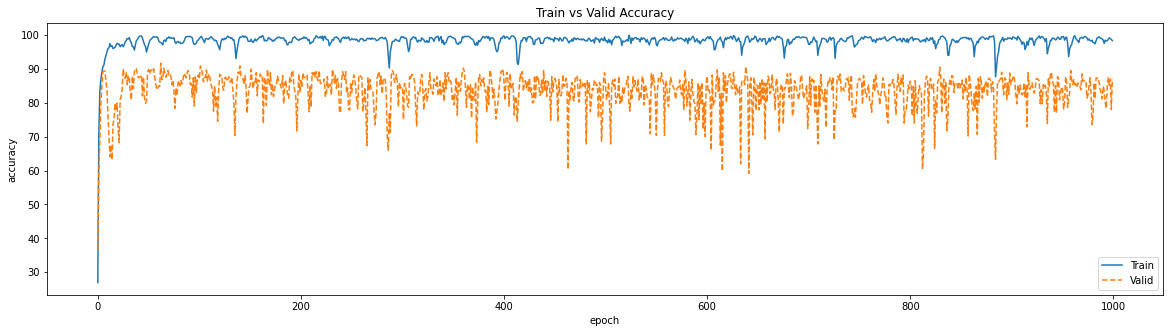

In [98]:
accuracy_plots(train_accu, eval_accu)

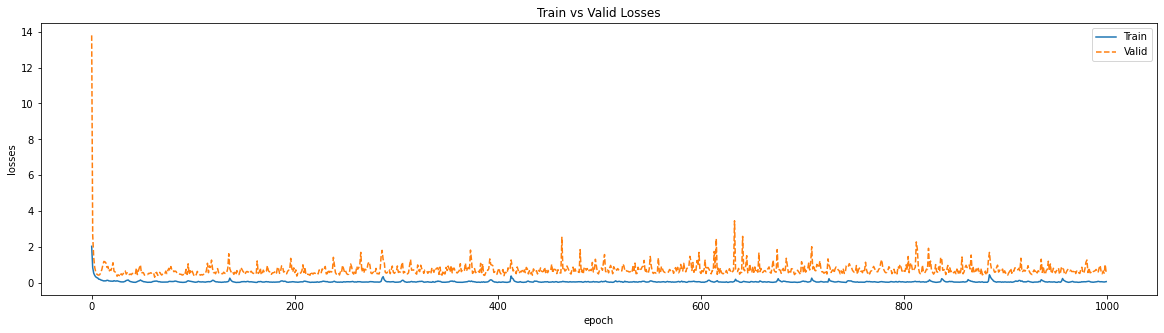

In [99]:
loss_plots(train_losses, eval_losses)

100%|██████████| 5/5 [00:00<00:00, 1497.86it/s]


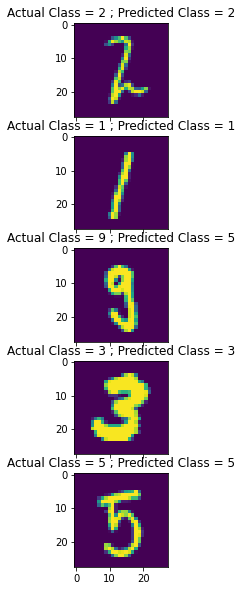

In [100]:
model = model_configs["4"]
model.load_state_dict(torch.load("models/best_model_parameters41.pth"))
model.eval()

with torch.no_grad():
  predicted_classes = []
  device = torch.device("cpu")
  for data in tqdm(first_five_loader):
    images,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(images)
    _, predicted = torch.max(outputs, 1)
    predicted_classes.append(predicted)


fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for j in range(5):
  axs[j].imshow(first_five_test_images[j][0])
  axs[j].set_title(f"Actual Class = {first_five_test_image_labels[0+j]} ; Predicted Class = {predicted_classes[j].item()}")

for ax in axs.flat:
    ax.label_outer()

# model 4, training config 2 : 

In [101]:
s = time.time()
eval_losses, train_losses, eval_accu, train_accu = train("4", "2")
e = time.time()

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |   313600   |
|  l1.bias  |    400     |
| l2.weight |   80000    |
|  l2.bias  |    200     |
| bn.weight |    200     |
|  bn.bias  |    200     |
| l3.weight |    2000    |
|  l3.bias  |     10     |
+-----------+------------+
Total Trainable Params: 396610

Epoch : 1


100%|██████████| 2/2 [00:00<00:00, 129.22it/s]



Epoch : 2


100%|██████████| 2/2 [00:00<00:00, 113.91it/s]



Epoch : 3


100%|██████████| 2/2 [00:00<00:00, 127.98it/s]



Epoch : 4


100%|██████████| 2/2 [00:00<00:00, 128.11it/s]



Epoch : 5


100%|██████████| 2/2 [00:00<00:00, 121.80it/s]



Epoch : 6


100%|██████████| 2/2 [00:00<00:00, 125.89it/s]



Epoch : 7


100%|██████████| 2/2 [00:00<00:00, 115.28it/s]



Epoch : 8


100%|██████████| 2/2 [00:00<00:00, 94.99it/s]



Epoch : 9


100%|██████████| 2/2 [00:00<00:00, 122.20it/s]



Epoch : 10


100%|██████████| 2/2 [00:00<00:00, 130.18it/s]



Epoch : 11


100%|██████████| 2/2 [00:00<00:00, 127.91it/s]



Epoch : 12


100%|██████████| 2/2 [00:00<00:00, 93.17it/s]



Epoch : 13


100%|██████████| 2/2 [00:00<00:00, 121.99it/s]



Epoch : 14


100%|██████████| 2/2 [00:00<00:00, 125.29it/s]



Epoch : 15


100%|██████████| 2/2 [00:00<00:00, 122.76it/s]



Epoch : 16


100%|██████████| 2/2 [00:00<00:00, 123.55it/s]



Epoch : 17


100%|██████████| 2/2 [00:00<00:00, 119.23it/s]



Epoch : 18


100%|██████████| 2/2 [00:00<00:00, 122.77it/s]



Epoch : 19


100%|██████████| 2/2 [00:00<00:00, 121.99it/s]



Epoch : 20


100%|██████████| 2/2 [00:00<00:00, 115.30it/s]



Epoch : 21


100%|██████████| 2/2 [00:00<00:00, 97.84it/s]



Epoch : 22


100%|██████████| 2/2 [00:00<00:00, 95.99it/s]



Epoch : 23


100%|██████████| 2/2 [00:00<00:00, 109.69it/s]



Epoch : 24


100%|██████████| 2/2 [00:00<00:00, 124.38it/s]



Epoch : 25


100%|██████████| 2/2 [00:00<00:00, 114.23it/s]



Epoch : 26


100%|██████████| 2/2 [00:00<00:00, 114.07it/s]



Epoch : 27


100%|██████████| 2/2 [00:00<00:00, 114.20it/s]



Epoch : 28


100%|██████████| 2/2 [00:00<00:00, 115.55it/s]



Epoch : 29


100%|██████████| 2/2 [00:00<00:00, 116.77it/s]



Epoch : 30


100%|██████████| 2/2 [00:00<00:00, 126.84it/s]



Epoch : 31


100%|██████████| 2/2 [00:00<00:00, 120.11it/s]



Epoch : 32


100%|██████████| 2/2 [00:00<00:00, 119.60it/s]



Epoch : 33


100%|██████████| 2/2 [00:00<00:00, 114.67it/s]



Epoch : 34


100%|██████████| 2/2 [00:00<00:00, 127.13it/s]



Epoch : 35


100%|██████████| 2/2 [00:00<00:00, 114.22it/s]



Epoch : 36


100%|██████████| 2/2 [00:00<00:00, 126.49it/s]



Epoch : 37


100%|██████████| 2/2 [00:00<00:00, 104.85it/s]



Epoch : 38


100%|██████████| 2/2 [00:00<00:00, 104.75it/s]



Epoch : 39


100%|██████████| 2/2 [00:00<00:00, 120.64it/s]



Epoch : 40


100%|██████████| 2/2 [00:00<00:00, 95.04it/s]



Epoch : 41


100%|██████████| 2/2 [00:00<00:00, 117.98it/s]



Epoch : 42


100%|██████████| 2/2 [00:00<00:00, 135.89it/s]



Epoch : 43


100%|██████████| 2/2 [00:00<00:00, 122.04it/s]



Epoch : 44


100%|██████████| 2/2 [00:00<00:00, 124.37it/s]



Epoch : 45


100%|██████████| 2/2 [00:00<00:00, 121.61it/s]



Epoch : 46


100%|██████████| 2/2 [00:00<00:00, 92.72it/s]



Epoch : 47


100%|██████████| 2/2 [00:00<00:00, 120.66it/s]



Epoch : 48


100%|██████████| 2/2 [00:00<00:00, 121.90it/s]



Epoch : 49


100%|██████████| 2/2 [00:00<00:00, 115.78it/s]



Epoch : 50


100%|██████████| 2/2 [00:00<00:00, 108.12it/s]



Epoch : 51


100%|██████████| 2/2 [00:00<00:00, 120.16it/s]



Epoch : 52


100%|██████████| 2/2 [00:00<00:00, 127.26it/s]



Epoch : 53


100%|██████████| 2/2 [00:00<00:00, 131.96it/s]



Epoch : 54


100%|██████████| 2/2 [00:00<00:00, 124.98it/s]



Epoch : 55


100%|██████████| 2/2 [00:00<00:00, 116.50it/s]



Epoch : 56


100%|██████████| 2/2 [00:00<00:00, 121.41it/s]



Epoch : 57


100%|██████████| 2/2 [00:00<00:00, 119.84it/s]



Epoch : 58


100%|██████████| 2/2 [00:00<00:00, 115.56it/s]



Epoch : 59


100%|██████████| 2/2 [00:00<00:00, 128.59it/s]



Epoch : 60


100%|██████████| 2/2 [00:00<00:00, 91.71it/s]



Epoch : 61


100%|██████████| 2/2 [00:00<00:00, 106.31it/s]



Epoch : 62


100%|██████████| 2/2 [00:00<00:00, 112.76it/s]



Epoch : 63


100%|██████████| 2/2 [00:00<00:00, 118.58it/s]



Epoch : 64


100%|██████████| 2/2 [00:00<00:00, 109.69it/s]



Epoch : 65


100%|██████████| 2/2 [00:00<00:00, 114.07it/s]



Epoch : 66


100%|██████████| 2/2 [00:00<00:00, 120.27it/s]



Epoch : 67


100%|██████████| 2/2 [00:00<00:00, 102.36it/s]



Epoch : 68


100%|██████████| 2/2 [00:00<00:00, 125.93it/s]



Epoch : 69


100%|██████████| 2/2 [00:00<00:00, 115.15it/s]



Epoch : 70


100%|██████████| 2/2 [00:00<00:00, 103.73it/s]



Epoch : 71


100%|██████████| 2/2 [00:00<00:00, 116.26it/s]



Epoch : 72


100%|██████████| 2/2 [00:00<00:00, 111.51it/s]



Epoch : 73


100%|██████████| 2/2 [00:00<00:00, 130.88it/s]



Epoch : 74


100%|██████████| 2/2 [00:00<00:00, 129.51it/s]



Epoch : 75


100%|██████████| 2/2 [00:00<00:00, 118.27it/s]



Epoch : 76


100%|██████████| 2/2 [00:00<00:00, 108.90it/s]



Epoch : 77


100%|██████████| 2/2 [00:00<00:00, 109.76it/s]



Epoch : 78


100%|██████████| 2/2 [00:00<00:00, 125.93it/s]



Epoch : 79


100%|██████████| 2/2 [00:00<00:00, 118.66it/s]



Epoch : 80


100%|██████████| 2/2 [00:00<00:00, 113.08it/s]



Epoch : 81


100%|██████████| 2/2 [00:00<00:00, 110.76it/s]



Epoch : 82


100%|██████████| 2/2 [00:00<00:00, 103.14it/s]



Epoch : 83


100%|██████████| 2/2 [00:00<00:00, 117.70it/s]



Epoch : 84


100%|██████████| 2/2 [00:00<00:00, 118.11it/s]



Epoch : 85


100%|██████████| 2/2 [00:00<00:00, 107.51it/s]



Epoch : 86


100%|██████████| 2/2 [00:00<00:00, 124.64it/s]



Epoch : 87


100%|██████████| 2/2 [00:00<00:00, 120.02it/s]



Epoch : 88


100%|██████████| 2/2 [00:00<00:00, 117.04it/s]



Epoch : 89


100%|██████████| 2/2 [00:00<00:00, 116.74it/s]



Epoch : 90


100%|██████████| 2/2 [00:00<00:00, 103.88it/s]



Epoch : 91


100%|██████████| 2/2 [00:00<00:00, 120.91it/s]



Epoch : 92


100%|██████████| 2/2 [00:00<00:00, 124.07it/s]



Epoch : 93


100%|██████████| 2/2 [00:00<00:00, 74.64it/s]



Epoch : 94


100%|██████████| 2/2 [00:00<00:00, 90.08it/s]



Epoch : 95


100%|██████████| 2/2 [00:00<00:00, 90.65it/s]



Epoch : 96


100%|██████████| 2/2 [00:00<00:00, 111.77it/s]



Epoch : 97


100%|██████████| 2/2 [00:00<00:00, 105.36it/s]



Epoch : 98


100%|██████████| 2/2 [00:00<00:00, 115.07it/s]



Epoch : 99


100%|██████████| 2/2 [00:00<00:00, 120.84it/s]



Epoch : 100


100%|██████████| 2/2 [00:00<00:00, 90.06it/s]



Epoch : 101


100%|██████████| 2/2 [00:00<00:00, 125.45it/s]



Epoch : 102


100%|██████████| 2/2 [00:00<00:00, 107.10it/s]



Epoch : 103


100%|██████████| 2/2 [00:00<00:00, 110.60it/s]



Epoch : 104


100%|██████████| 2/2 [00:00<00:00, 104.58it/s]



Epoch : 105


100%|██████████| 2/2 [00:00<00:00, 115.01it/s]



Epoch : 106


100%|██████████| 2/2 [00:00<00:00, 108.57it/s]



Epoch : 107


100%|██████████| 2/2 [00:00<00:00, 110.03it/s]



Epoch : 108


100%|██████████| 2/2 [00:00<00:00, 118.08it/s]



Epoch : 109


100%|██████████| 2/2 [00:00<00:00, 111.58it/s]



Epoch : 110


100%|██████████| 2/2 [00:00<00:00, 112.63it/s]



Epoch : 111


100%|██████████| 2/2 [00:00<00:00, 120.28it/s]



Epoch : 112


100%|██████████| 2/2 [00:00<00:00, 97.57it/s]



Epoch : 113


100%|██████████| 2/2 [00:00<00:00, 117.47it/s]



Epoch : 114


100%|██████████| 2/2 [00:00<00:00, 135.54it/s]



Epoch : 115


100%|██████████| 2/2 [00:00<00:00, 127.68it/s]



Epoch : 116


100%|██████████| 2/2 [00:00<00:00, 111.41it/s]



Epoch : 117


100%|██████████| 2/2 [00:00<00:00, 74.92it/s]



Epoch : 118


100%|██████████| 2/2 [00:00<00:00, 109.75it/s]



Epoch : 119


100%|██████████| 2/2 [00:00<00:00, 111.99it/s]



Epoch : 120


100%|██████████| 2/2 [00:00<00:00, 110.35it/s]



Epoch : 121


100%|██████████| 2/2 [00:00<00:00, 93.10it/s]



Epoch : 122


100%|██████████| 2/2 [00:00<00:00, 146.73it/s]



Epoch : 123


100%|██████████| 2/2 [00:00<00:00, 111.91it/s]



Epoch : 124


100%|██████████| 2/2 [00:00<00:00, 104.21it/s]



Epoch : 125


100%|██████████| 2/2 [00:00<00:00, 126.41it/s]



Epoch : 126


100%|██████████| 2/2 [00:00<00:00, 113.53it/s]



Epoch : 127


100%|██████████| 2/2 [00:00<00:00, 107.61it/s]



Epoch : 128


100%|██████████| 2/2 [00:00<00:00, 105.58it/s]



Epoch : 129


100%|██████████| 2/2 [00:00<00:00, 107.94it/s]



Epoch : 130


100%|██████████| 2/2 [00:00<00:00, 107.22it/s]



Epoch : 131


100%|██████████| 2/2 [00:00<00:00, 115.87it/s]



Epoch : 132


100%|██████████| 2/2 [00:00<00:00, 87.96it/s]



Epoch : 133


100%|██████████| 2/2 [00:00<00:00, 102.67it/s]



Epoch : 134


100%|██████████| 2/2 [00:00<00:00, 108.10it/s]



Epoch : 135


100%|██████████| 2/2 [00:00<00:00, 98.41it/s]



Epoch : 136


100%|██████████| 2/2 [00:00<00:00, 117.67it/s]



Epoch : 137


100%|██████████| 2/2 [00:00<00:00, 108.64it/s]



Epoch : 138


100%|██████████| 2/2 [00:00<00:00, 103.74it/s]



Epoch : 139


100%|██████████| 2/2 [00:00<00:00, 112.07it/s]



Epoch : 140


100%|██████████| 2/2 [00:00<00:00, 89.92it/s]



Epoch : 141


100%|██████████| 2/2 [00:00<00:00, 68.19it/s]



Epoch : 142


100%|██████████| 2/2 [00:00<00:00, 104.35it/s]



Epoch : 143


100%|██████████| 2/2 [00:00<00:00, 122.31it/s]



Epoch : 144


100%|██████████| 2/2 [00:00<00:00, 95.96it/s]



Epoch : 145


100%|██████████| 2/2 [00:00<00:00, 120.20it/s]



Epoch : 146


100%|██████████| 2/2 [00:00<00:00, 95.80it/s]



Epoch : 147


100%|██████████| 2/2 [00:00<00:00, 89.62it/s]



Epoch : 148


100%|██████████| 2/2 [00:00<00:00, 107.01it/s]



Epoch : 149


100%|██████████| 2/2 [00:00<00:00, 106.32it/s]



Epoch : 150


100%|██████████| 2/2 [00:00<00:00, 104.57it/s]



Epoch : 151


100%|██████████| 2/2 [00:00<00:00, 119.24it/s]



Epoch : 152


100%|██████████| 2/2 [00:00<00:00, 91.68it/s]



Epoch : 153


100%|██████████| 2/2 [00:00<00:00, 111.24it/s]



Epoch : 154


100%|██████████| 2/2 [00:00<00:00, 117.61it/s]



Epoch : 155


100%|██████████| 2/2 [00:00<00:00, 96.55it/s]



Epoch : 156


100%|██████████| 2/2 [00:00<00:00, 103.36it/s]



Epoch : 157


100%|██████████| 2/2 [00:00<00:00, 88.35it/s]



Epoch : 158


100%|██████████| 2/2 [00:00<00:00, 112.39it/s]



Epoch : 159


100%|██████████| 2/2 [00:00<00:00, 114.96it/s]



Epoch : 160


100%|██████████| 2/2 [00:00<00:00, 124.93it/s]



Epoch : 161


100%|██████████| 2/2 [00:00<00:00, 113.56it/s]



Epoch : 162


100%|██████████| 2/2 [00:00<00:00, 128.15it/s]



Epoch : 163


100%|██████████| 2/2 [00:00<00:00, 116.12it/s]



Epoch : 164


100%|██████████| 2/2 [00:00<00:00, 104.46it/s]



Epoch : 165


100%|██████████| 2/2 [00:00<00:00, 130.57it/s]



Epoch : 166


100%|██████████| 2/2 [00:00<00:00, 118.32it/s]



Epoch : 167


100%|██████████| 2/2 [00:00<00:00, 104.90it/s]



Epoch : 168


100%|██████████| 2/2 [00:00<00:00, 105.17it/s]



Epoch : 169


100%|██████████| 2/2 [00:00<00:00, 114.36it/s]



Epoch : 170


100%|██████████| 2/2 [00:00<00:00, 85.96it/s]



Epoch : 171


100%|██████████| 2/2 [00:00<00:00, 132.52it/s]



Epoch : 172


100%|██████████| 2/2 [00:00<00:00, 89.95it/s]



Epoch : 173


100%|██████████| 2/2 [00:00<00:00, 97.77it/s]



Epoch : 174


100%|██████████| 2/2 [00:00<00:00, 101.21it/s]



Epoch : 175


100%|██████████| 2/2 [00:00<00:00, 104.78it/s]



Epoch : 176


100%|██████████| 2/2 [00:00<00:00, 119.43it/s]



Epoch : 177


100%|██████████| 2/2 [00:00<00:00, 82.37it/s]



Epoch : 178


100%|██████████| 2/2 [00:00<00:00, 113.69it/s]



Epoch : 179


100%|██████████| 2/2 [00:00<00:00, 97.76it/s]



Epoch : 180


100%|██████████| 2/2 [00:00<00:00, 113.16it/s]



Epoch : 181


100%|██████████| 2/2 [00:00<00:00, 101.30it/s]



Epoch : 182


100%|██████████| 2/2 [00:00<00:00, 98.71it/s]



Epoch : 183


100%|██████████| 2/2 [00:00<00:00, 104.54it/s]



Epoch : 184


100%|██████████| 2/2 [00:00<00:00, 87.25it/s]



Epoch : 185


100%|██████████| 2/2 [00:00<00:00, 99.86it/s]



Epoch : 186


100%|██████████| 2/2 [00:00<00:00, 99.22it/s]



Epoch : 187


100%|██████████| 2/2 [00:00<00:00, 103.28it/s]



Epoch : 188


100%|██████████| 2/2 [00:00<00:00, 102.87it/s]



Epoch : 189


100%|██████████| 2/2 [00:00<00:00, 77.88it/s]



Epoch : 190


100%|██████████| 2/2 [00:00<00:00, 85.48it/s]



Epoch : 191


100%|██████████| 2/2 [00:00<00:00, 135.77it/s]



Epoch : 192


100%|██████████| 2/2 [00:00<00:00, 95.92it/s]



Epoch : 193


100%|██████████| 2/2 [00:00<00:00, 107.70it/s]



Epoch : 194


100%|██████████| 2/2 [00:00<00:00, 105.55it/s]



Epoch : 195


100%|██████████| 2/2 [00:00<00:00, 103.92it/s]



Epoch : 196


100%|██████████| 2/2 [00:00<00:00, 110.03it/s]



Epoch : 197


100%|██████████| 2/2 [00:00<00:00, 96.52it/s]



Epoch : 198


100%|██████████| 2/2 [00:00<00:00, 101.03it/s]



Epoch : 199


100%|██████████| 2/2 [00:00<00:00, 90.25it/s]



Epoch : 200


100%|██████████| 2/2 [00:00<00:00, 103.43it/s]



Epoch : 201


100%|██████████| 2/2 [00:00<00:00, 89.35it/s]



Epoch : 202


100%|██████████| 2/2 [00:00<00:00, 96.19it/s]



Epoch : 203


100%|██████████| 2/2 [00:00<00:00, 102.05it/s]



Epoch : 204


100%|██████████| 2/2 [00:00<00:00, 113.85it/s]



Epoch : 205


100%|██████████| 2/2 [00:00<00:00, 128.75it/s]



Epoch : 206


100%|██████████| 2/2 [00:00<00:00, 106.08it/s]



Epoch : 207


100%|██████████| 2/2 [00:00<00:00, 106.39it/s]



Epoch : 208


100%|██████████| 2/2 [00:00<00:00, 103.31it/s]



Epoch : 209


100%|██████████| 2/2 [00:00<00:00, 106.14it/s]



Epoch : 210


100%|██████████| 2/2 [00:00<00:00, 90.78it/s]



Epoch : 211


100%|██████████| 2/2 [00:00<00:00, 97.31it/s]



Epoch : 212


100%|██████████| 2/2 [00:00<00:00, 106.20it/s]



Epoch : 213


100%|██████████| 2/2 [00:00<00:00, 118.17it/s]



Epoch : 214


100%|██████████| 2/2 [00:00<00:00, 89.70it/s]



Epoch : 215


100%|██████████| 2/2 [00:00<00:00, 95.17it/s]



Epoch : 216


100%|██████████| 2/2 [00:00<00:00, 109.65it/s]



Epoch : 217


100%|██████████| 2/2 [00:00<00:00, 103.42it/s]



Epoch : 218


100%|██████████| 2/2 [00:00<00:00, 99.74it/s]



Epoch : 219


100%|██████████| 2/2 [00:00<00:00, 106.70it/s]



Epoch : 220


100%|██████████| 2/2 [00:00<00:00, 106.15it/s]



Epoch : 221


100%|██████████| 2/2 [00:00<00:00, 100.09it/s]



Epoch : 222


100%|██████████| 2/2 [00:00<00:00, 114.73it/s]



Epoch : 223


100%|██████████| 2/2 [00:00<00:00, 90.37it/s]



Epoch : 224


100%|██████████| 2/2 [00:00<00:00, 91.77it/s]



Epoch : 225


100%|██████████| 2/2 [00:00<00:00, 99.06it/s]



Epoch : 226


100%|██████████| 2/2 [00:00<00:00, 101.18it/s]



Epoch : 227


100%|██████████| 2/2 [00:00<00:00, 85.24it/s]



Epoch : 228


100%|██████████| 2/2 [00:00<00:00, 104.39it/s]



Epoch : 229


100%|██████████| 2/2 [00:00<00:00, 105.03it/s]



Epoch : 230


100%|██████████| 2/2 [00:00<00:00, 104.04it/s]



Epoch : 231


100%|██████████| 2/2 [00:00<00:00, 101.67it/s]



Epoch : 232


100%|██████████| 2/2 [00:00<00:00, 95.52it/s]



Epoch : 233


100%|██████████| 2/2 [00:00<00:00, 119.85it/s]



Epoch : 234


100%|██████████| 2/2 [00:00<00:00, 99.72it/s]



Epoch : 235


100%|██████████| 2/2 [00:00<00:00, 94.51it/s]



Epoch : 236


100%|██████████| 2/2 [00:00<00:00, 75.16it/s]



Epoch : 237


100%|██████████| 2/2 [00:00<00:00, 91.93it/s]



Epoch : 238


100%|██████████| 2/2 [00:00<00:00, 100.34it/s]



Epoch : 239


100%|██████████| 2/2 [00:00<00:00, 112.11it/s]



Epoch : 240


100%|██████████| 2/2 [00:00<00:00, 102.93it/s]



Epoch : 241


100%|██████████| 2/2 [00:00<00:00, 92.70it/s]



Epoch : 242


100%|██████████| 2/2 [00:00<00:00, 97.85it/s]



Epoch : 243


100%|██████████| 2/2 [00:00<00:00, 104.31it/s]



Epoch : 244


100%|██████████| 2/2 [00:00<00:00, 101.93it/s]



Epoch : 245


100%|██████████| 2/2 [00:00<00:00, 99.25it/s]



Epoch : 246


100%|██████████| 2/2 [00:00<00:00, 147.26it/s]



Epoch : 247


100%|██████████| 2/2 [00:00<00:00, 85.95it/s]



Epoch : 248


100%|██████████| 2/2 [00:00<00:00, 103.52it/s]



Epoch : 249


100%|██████████| 2/2 [00:00<00:00, 102.14it/s]



Epoch : 250


100%|██████████| 2/2 [00:00<00:00, 101.76it/s]



Epoch : 251


100%|██████████| 2/2 [00:00<00:00, 79.40it/s]



Epoch : 252


100%|██████████| 2/2 [00:00<00:00, 107.85it/s]



Epoch : 253


100%|██████████| 2/2 [00:00<00:00, 118.24it/s]



Epoch : 254


100%|██████████| 2/2 [00:00<00:00, 99.57it/s]



Epoch : 255


100%|██████████| 2/2 [00:00<00:00, 97.28it/s]



Epoch : 256


100%|██████████| 2/2 [00:00<00:00, 92.52it/s]



Epoch : 257


100%|██████████| 2/2 [00:00<00:00, 117.93it/s]



Epoch : 258


100%|██████████| 2/2 [00:00<00:00, 99.42it/s]



Epoch : 259


100%|██████████| 2/2 [00:00<00:00, 96.08it/s]



Epoch : 260


100%|██████████| 2/2 [00:00<00:00, 100.81it/s]



Epoch : 261


100%|██████████| 2/2 [00:00<00:00, 97.82it/s]



Epoch : 262


100%|██████████| 2/2 [00:00<00:00, 104.89it/s]



Epoch : 263


100%|██████████| 2/2 [00:00<00:00, 99.40it/s]



Epoch : 264


100%|██████████| 2/2 [00:00<00:00, 102.10it/s]



Epoch : 265


100%|██████████| 2/2 [00:00<00:00, 101.57it/s]



Epoch : 266


100%|██████████| 2/2 [00:00<00:00, 100.19it/s]



Epoch : 267


100%|██████████| 2/2 [00:00<00:00, 101.78it/s]



Epoch : 268


100%|██████████| 2/2 [00:00<00:00, 100.45it/s]



Epoch : 269


100%|██████████| 2/2 [00:00<00:00, 103.18it/s]



Epoch : 270


100%|██████████| 2/2 [00:00<00:00, 102.96it/s]



Epoch : 271


100%|██████████| 2/2 [00:00<00:00, 94.65it/s]



Epoch : 272


100%|██████████| 2/2 [00:00<00:00, 91.97it/s]



Epoch : 273


100%|██████████| 2/2 [00:00<00:00, 98.47it/s]



Epoch : 274


100%|██████████| 2/2 [00:00<00:00, 100.58it/s]



Epoch : 275


100%|██████████| 2/2 [00:00<00:00, 98.75it/s]



Epoch : 276


100%|██████████| 2/2 [00:00<00:00, 95.65it/s]



Epoch : 277


100%|██████████| 2/2 [00:00<00:00, 97.45it/s]



Epoch : 278


100%|██████████| 2/2 [00:00<00:00, 91.14it/s]



Epoch : 279


100%|██████████| 2/2 [00:00<00:00, 100.89it/s]



Epoch : 280


100%|██████████| 2/2 [00:00<00:00, 100.08it/s]



Epoch : 281


100%|██████████| 2/2 [00:00<00:00, 99.10it/s]



Epoch : 282


100%|██████████| 2/2 [00:00<00:00, 99.07it/s]



Epoch : 283


100%|██████████| 2/2 [00:00<00:00, 82.85it/s]



Epoch : 284


100%|██████████| 2/2 [00:00<00:00, 100.36it/s]



Epoch : 285


100%|██████████| 2/2 [00:00<00:00, 100.00it/s]



Epoch : 286


100%|██████████| 2/2 [00:00<00:00, 100.00it/s]



Epoch : 287


100%|██████████| 2/2 [00:00<00:00, 98.15it/s]



Epoch : 288


100%|██████████| 2/2 [00:00<00:00, 100.18it/s]



Epoch : 289


100%|██████████| 2/2 [00:00<00:00, 97.48it/s]



Epoch : 290


100%|██████████| 2/2 [00:00<00:00, 103.19it/s]



Epoch : 291


100%|██████████| 2/2 [00:00<00:00, 84.60it/s]



Epoch : 292


100%|██████████| 2/2 [00:00<00:00, 98.02it/s]



Epoch : 293


100%|██████████| 2/2 [00:00<00:00, 96.60it/s]



Epoch : 294


100%|██████████| 2/2 [00:00<00:00, 98.17it/s]



Epoch : 295


100%|██████████| 2/2 [00:00<00:00, 98.61it/s]



Epoch : 296


100%|██████████| 2/2 [00:00<00:00, 97.28it/s]



Epoch : 297


100%|██████████| 2/2 [00:00<00:00, 79.83it/s]



Epoch : 298


100%|██████████| 2/2 [00:00<00:00, 111.74it/s]



Epoch : 299


100%|██████████| 2/2 [00:00<00:00, 93.58it/s]



Epoch : 300


100%|██████████| 2/2 [00:00<00:00, 98.33it/s]



Epoch : 301


100%|██████████| 2/2 [00:00<00:00, 116.24it/s]



Epoch : 302


100%|██████████| 2/2 [00:00<00:00, 94.36it/s]



Epoch : 303


100%|██████████| 2/2 [00:00<00:00, 92.41it/s]



Epoch : 304


100%|██████████| 2/2 [00:00<00:00, 99.74it/s]



Epoch : 305


100%|██████████| 2/2 [00:00<00:00, 87.64it/s]



Epoch : 306


100%|██████████| 2/2 [00:00<00:00, 90.78it/s]



Epoch : 307


100%|██████████| 2/2 [00:00<00:00, 98.23it/s]



Epoch : 308


100%|██████████| 2/2 [00:00<00:00, 93.80it/s]



Epoch : 309


100%|██████████| 2/2 [00:00<00:00, 97.73it/s]



Epoch : 310


100%|██████████| 2/2 [00:00<00:00, 98.95it/s]



Epoch : 311


100%|██████████| 2/2 [00:00<00:00, 99.66it/s]



Epoch : 312


100%|██████████| 2/2 [00:00<00:00, 91.80it/s]



Epoch : 313


100%|██████████| 2/2 [00:00<00:00, 91.29it/s]



Epoch : 314


100%|██████████| 2/2 [00:00<00:00, 99.58it/s]



Epoch : 315


100%|██████████| 2/2 [00:00<00:00, 86.20it/s]



Epoch : 316


100%|██████████| 2/2 [00:00<00:00, 87.26it/s]



Epoch : 317


100%|██████████| 2/2 [00:00<00:00, 95.26it/s]



Epoch : 318


100%|██████████| 2/2 [00:00<00:00, 95.54it/s]



Epoch : 319


100%|██████████| 2/2 [00:00<00:00, 106.12it/s]



Epoch : 320


100%|██████████| 2/2 [00:00<00:00, 103.34it/s]



Epoch : 321


100%|██████████| 2/2 [00:00<00:00, 98.03it/s]



Epoch : 322


100%|██████████| 2/2 [00:00<00:00, 100.32it/s]



Epoch : 323


100%|██████████| 2/2 [00:00<00:00, 125.82it/s]



Epoch : 324


100%|██████████| 2/2 [00:00<00:00, 104.10it/s]



Epoch : 325


100%|██████████| 2/2 [00:00<00:00, 94.64it/s]



Epoch : 326


100%|██████████| 2/2 [00:00<00:00, 100.50it/s]



Epoch : 327


100%|██████████| 2/2 [00:00<00:00, 102.47it/s]



Epoch : 328


100%|██████████| 2/2 [00:00<00:00, 93.81it/s]



Epoch : 329


100%|██████████| 2/2 [00:00<00:00, 104.53it/s]



Epoch : 330


100%|██████████| 2/2 [00:00<00:00, 90.02it/s]



Epoch : 331


100%|██████████| 2/2 [00:00<00:00, 97.17it/s]



Epoch : 332


100%|██████████| 2/2 [00:00<00:00, 96.56it/s]



Epoch : 333


100%|██████████| 2/2 [00:00<00:00, 93.27it/s]



Epoch : 334


100%|██████████| 2/2 [00:00<00:00, 75.59it/s]



Epoch : 335


100%|██████████| 2/2 [00:00<00:00, 96.21it/s]



Epoch : 336


100%|██████████| 2/2 [00:00<00:00, 99.95it/s]



Epoch : 337


100%|██████████| 2/2 [00:00<00:00, 101.52it/s]



Epoch : 338


100%|██████████| 2/2 [00:00<00:00, 117.32it/s]



Epoch : 339


100%|██████████| 2/2 [00:00<00:00, 99.36it/s]



Epoch : 340


100%|██████████| 2/2 [00:00<00:00, 98.30it/s]



Epoch : 341


100%|██████████| 2/2 [00:00<00:00, 92.16it/s]



Epoch : 342


100%|██████████| 2/2 [00:00<00:00, 96.53it/s]



Epoch : 343


100%|██████████| 2/2 [00:00<00:00, 98.65it/s]



Epoch : 344


100%|██████████| 2/2 [00:00<00:00, 98.41it/s]



Epoch : 345


100%|██████████| 2/2 [00:00<00:00, 98.49it/s]



Epoch : 346


100%|██████████| 2/2 [00:00<00:00, 97.91it/s]



Epoch : 347


100%|██████████| 2/2 [00:00<00:00, 96.84it/s]



Epoch : 348


100%|██████████| 2/2 [00:00<00:00, 94.84it/s]



Epoch : 349


100%|██████████| 2/2 [00:00<00:00, 95.53it/s]



Epoch : 350


100%|██████████| 2/2 [00:00<00:00, 94.79it/s]



Epoch : 351


100%|██████████| 2/2 [00:00<00:00, 94.34it/s]



Epoch : 352


100%|██████████| 2/2 [00:00<00:00, 99.69it/s]



Epoch : 353


100%|██████████| 2/2 [00:00<00:00, 98.28it/s]



Epoch : 354


100%|██████████| 2/2 [00:00<00:00, 81.29it/s]



Epoch : 355


100%|██████████| 2/2 [00:00<00:00, 106.19it/s]



Epoch : 356


100%|██████████| 2/2 [00:00<00:00, 103.55it/s]



Epoch : 357


100%|██████████| 2/2 [00:00<00:00, 86.56it/s]



Epoch : 358


100%|██████████| 2/2 [00:00<00:00, 100.70it/s]



Epoch : 359


100%|██████████| 2/2 [00:00<00:00, 95.88it/s]



Epoch : 360


100%|██████████| 2/2 [00:00<00:00, 116.24it/s]



Epoch : 361


100%|██████████| 2/2 [00:00<00:00, 80.78it/s]



Epoch : 362


100%|██████████| 2/2 [00:00<00:00, 106.81it/s]



Epoch : 363


100%|██████████| 2/2 [00:00<00:00, 104.15it/s]



Epoch : 364


100%|██████████| 2/2 [00:00<00:00, 85.50it/s]



Epoch : 365


100%|██████████| 2/2 [00:00<00:00, 93.42it/s]



Epoch : 366


100%|██████████| 2/2 [00:00<00:00, 93.94it/s]



Epoch : 367


100%|██████████| 2/2 [00:00<00:00, 98.04it/s]



Epoch : 368


100%|██████████| 2/2 [00:00<00:00, 100.99it/s]



Epoch : 369


100%|██████████| 2/2 [00:00<00:00, 104.14it/s]



Epoch : 370


100%|██████████| 2/2 [00:00<00:00, 100.63it/s]



Epoch : 371


100%|██████████| 2/2 [00:00<00:00, 94.40it/s]



Epoch : 372


100%|██████████| 2/2 [00:00<00:00, 105.12it/s]



Epoch : 373


100%|██████████| 2/2 [00:00<00:00, 96.43it/s]



Epoch : 374


100%|██████████| 2/2 [00:00<00:00, 101.43it/s]



Epoch : 375


100%|██████████| 2/2 [00:00<00:00, 107.19it/s]



Epoch : 376


100%|██████████| 2/2 [00:00<00:00, 98.10it/s]



Epoch : 377


100%|██████████| 2/2 [00:00<00:00, 86.48it/s]



Epoch : 378


100%|██████████| 2/2 [00:00<00:00, 105.15it/s]



Epoch : 379


100%|██████████| 2/2 [00:00<00:00, 94.77it/s]



Epoch : 380


100%|██████████| 2/2 [00:00<00:00, 95.51it/s]



Epoch : 381


100%|██████████| 2/2 [00:00<00:00, 91.59it/s]



Epoch : 382


100%|██████████| 2/2 [00:00<00:00, 80.26it/s]



Epoch : 383


100%|██████████| 2/2 [00:00<00:00, 91.97it/s]



Epoch : 384


100%|██████████| 2/2 [00:00<00:00, 105.38it/s]



Epoch : 385


100%|██████████| 2/2 [00:00<00:00, 99.51it/s]



Epoch : 386


100%|██████████| 2/2 [00:00<00:00, 107.83it/s]



Epoch : 387


100%|██████████| 2/2 [00:00<00:00, 94.51it/s]



Epoch : 388


100%|██████████| 2/2 [00:00<00:00, 96.30it/s]



Epoch : 389


100%|██████████| 2/2 [00:00<00:00, 87.55it/s]



Epoch : 390


100%|██████████| 2/2 [00:00<00:00, 85.22it/s]



Epoch : 391


100%|██████████| 2/2 [00:00<00:00, 102.19it/s]



Epoch : 392


100%|██████████| 2/2 [00:00<00:00, 103.56it/s]



Epoch : 393


100%|██████████| 2/2 [00:00<00:00, 101.69it/s]



Epoch : 394


100%|██████████| 2/2 [00:00<00:00, 94.23it/s]



Epoch : 395


100%|██████████| 2/2 [00:00<00:00, 101.37it/s]



Epoch : 396


100%|██████████| 2/2 [00:00<00:00, 98.98it/s]



Epoch : 397


100%|██████████| 2/2 [00:00<00:00, 101.31it/s]



Epoch : 398


100%|██████████| 2/2 [00:00<00:00, 71.10it/s]



Epoch : 399


100%|██████████| 2/2 [00:00<00:00, 90.77it/s]



Epoch : 400


100%|██████████| 2/2 [00:00<00:00, 93.46it/s]



Epoch : 401


100%|██████████| 2/2 [00:00<00:00, 88.54it/s]



Epoch : 402


100%|██████████| 2/2 [00:00<00:00, 101.19it/s]



Epoch : 403


100%|██████████| 2/2 [00:00<00:00, 113.74it/s]



Epoch : 404


100%|██████████| 2/2 [00:00<00:00, 102.51it/s]



Epoch : 405


100%|██████████| 2/2 [00:00<00:00, 93.70it/s]



Epoch : 406


100%|██████████| 2/2 [00:00<00:00, 93.72it/s]



Epoch : 407


100%|██████████| 2/2 [00:00<00:00, 94.36it/s]



Epoch : 408


100%|██████████| 2/2 [00:00<00:00, 94.04it/s]



Epoch : 409


100%|██████████| 2/2 [00:00<00:00, 90.34it/s]



Epoch : 410


100%|██████████| 2/2 [00:00<00:00, 131.41it/s]



Epoch : 411


100%|██████████| 2/2 [00:00<00:00, 98.78it/s]



Epoch : 412


100%|██████████| 2/2 [00:00<00:00, 114.11it/s]



Epoch : 413


100%|██████████| 2/2 [00:00<00:00, 102.93it/s]



Epoch : 414


100%|██████████| 2/2 [00:00<00:00, 91.99it/s]



Epoch : 415


100%|██████████| 2/2 [00:00<00:00, 105.60it/s]



Epoch : 416


100%|██████████| 2/2 [00:00<00:00, 81.28it/s]



Epoch : 417


100%|██████████| 2/2 [00:00<00:00, 101.10it/s]



Epoch : 418


100%|██████████| 2/2 [00:00<00:00, 85.19it/s]



Epoch : 419


100%|██████████| 2/2 [00:00<00:00, 99.62it/s]



Epoch : 420


100%|██████████| 2/2 [00:00<00:00, 101.15it/s]



Epoch : 421


100%|██████████| 2/2 [00:00<00:00, 88.28it/s]



Epoch : 422


100%|██████████| 2/2 [00:00<00:00, 102.70it/s]



Epoch : 423


100%|██████████| 2/2 [00:00<00:00, 70.04it/s]



Epoch : 424


100%|██████████| 2/2 [00:00<00:00, 98.92it/s]



Epoch : 425


100%|██████████| 2/2 [00:00<00:00, 100.70it/s]



Epoch : 426


100%|██████████| 2/2 [00:00<00:00, 102.82it/s]



Epoch : 427


100%|██████████| 2/2 [00:00<00:00, 92.44it/s]



Epoch : 428


100%|██████████| 2/2 [00:00<00:00, 104.10it/s]



Epoch : 429


100%|██████████| 2/2 [00:00<00:00, 101.28it/s]



Epoch : 430


100%|██████████| 2/2 [00:00<00:00, 94.14it/s]



Epoch : 431


100%|██████████| 2/2 [00:00<00:00, 91.96it/s]



Epoch : 432


100%|██████████| 2/2 [00:00<00:00, 95.96it/s]



Epoch : 433


100%|██████████| 2/2 [00:00<00:00, 101.80it/s]



Epoch : 434


100%|██████████| 2/2 [00:00<00:00, 101.55it/s]



Epoch : 435


100%|██████████| 2/2 [00:00<00:00, 105.12it/s]



Epoch : 436


100%|██████████| 2/2 [00:00<00:00, 110.31it/s]



Epoch : 437


100%|██████████| 2/2 [00:00<00:00, 94.69it/s]



Epoch : 438


100%|██████████| 2/2 [00:00<00:00, 101.87it/s]



Epoch : 439


100%|██████████| 2/2 [00:00<00:00, 93.76it/s]



Epoch : 440


100%|██████████| 2/2 [00:00<00:00, 108.26it/s]



Epoch : 441


100%|██████████| 2/2 [00:00<00:00, 100.46it/s]



Epoch : 442


100%|██████████| 2/2 [00:00<00:00, 102.26it/s]



Epoch : 443


100%|██████████| 2/2 [00:00<00:00, 98.75it/s]



Epoch : 444


100%|██████████| 2/2 [00:00<00:00, 89.53it/s]



Epoch : 445


100%|██████████| 2/2 [00:00<00:00, 94.68it/s]



Epoch : 446


100%|██████████| 2/2 [00:00<00:00, 103.11it/s]



Epoch : 447


100%|██████████| 2/2 [00:00<00:00, 93.04it/s]



Epoch : 448


100%|██████████| 2/2 [00:00<00:00, 124.80it/s]



Epoch : 449


100%|██████████| 2/2 [00:00<00:00, 119.65it/s]



Epoch : 450


100%|██████████| 2/2 [00:00<00:00, 94.42it/s]



Epoch : 451


100%|██████████| 2/2 [00:00<00:00, 100.58it/s]



Epoch : 452


100%|██████████| 2/2 [00:00<00:00, 99.31it/s]



Epoch : 453


100%|██████████| 2/2 [00:00<00:00, 98.96it/s]



Epoch : 454


100%|██████████| 2/2 [00:00<00:00, 100.85it/s]



Epoch : 455


100%|██████████| 2/2 [00:00<00:00, 85.05it/s]



Epoch : 456


100%|██████████| 2/2 [00:00<00:00, 94.21it/s]



Epoch : 457


100%|██████████| 2/2 [00:00<00:00, 105.44it/s]



Epoch : 458


100%|██████████| 2/2 [00:00<00:00, 100.78it/s]



Epoch : 459


100%|██████████| 2/2 [00:00<00:00, 91.72it/s]



Epoch : 460


100%|██████████| 2/2 [00:00<00:00, 97.10it/s]



Epoch : 461


100%|██████████| 2/2 [00:00<00:00, 98.12it/s]



Epoch : 462


100%|██████████| 2/2 [00:00<00:00, 90.06it/s]



Epoch : 463


100%|██████████| 2/2 [00:00<00:00, 92.99it/s]



Epoch : 464


100%|██████████| 2/2 [00:00<00:00, 76.87it/s]



Epoch : 465


100%|██████████| 2/2 [00:00<00:00, 97.54it/s]



Epoch : 466


100%|██████████| 2/2 [00:00<00:00, 100.28it/s]



Epoch : 467


100%|██████████| 2/2 [00:00<00:00, 95.28it/s]



Epoch : 468


100%|██████████| 2/2 [00:00<00:00, 98.92it/s]



Epoch : 469


100%|██████████| 2/2 [00:00<00:00, 93.12it/s]



Epoch : 470


100%|██████████| 2/2 [00:00<00:00, 96.98it/s]



Epoch : 471


100%|██████████| 2/2 [00:00<00:00, 101.63it/s]



Epoch : 472


100%|██████████| 2/2 [00:00<00:00, 95.83it/s]



Epoch : 473


100%|██████████| 2/2 [00:00<00:00, 99.03it/s]



Epoch : 474


100%|██████████| 2/2 [00:00<00:00, 96.21it/s]



Epoch : 475


100%|██████████| 2/2 [00:00<00:00, 88.07it/s]



Epoch : 476


100%|██████████| 2/2 [00:00<00:00, 99.97it/s]



Epoch : 477


100%|██████████| 2/2 [00:00<00:00, 107.35it/s]



Epoch : 478


100%|██████████| 2/2 [00:00<00:00, 84.75it/s]



Epoch : 479


100%|██████████| 2/2 [00:00<00:00, 85.97it/s]



Epoch : 480


100%|██████████| 2/2 [00:00<00:00, 87.40it/s]



Epoch : 481


100%|██████████| 2/2 [00:00<00:00, 83.51it/s]



Epoch : 482


100%|██████████| 2/2 [00:00<00:00, 89.53it/s]



Epoch : 483


100%|██████████| 2/2 [00:00<00:00, 100.06it/s]



Epoch : 484


100%|██████████| 2/2 [00:00<00:00, 105.22it/s]



Epoch : 485


100%|██████████| 2/2 [00:00<00:00, 96.25it/s]



Epoch : 486


100%|██████████| 2/2 [00:00<00:00, 100.83it/s]



Epoch : 487


100%|██████████| 2/2 [00:00<00:00, 90.97it/s]



Epoch : 488


100%|██████████| 2/2 [00:00<00:00, 90.53it/s]



Epoch : 489


100%|██████████| 2/2 [00:00<00:00, 89.39it/s]



Epoch : 490


100%|██████████| 2/2 [00:00<00:00, 97.16it/s]



Epoch : 491


100%|██████████| 2/2 [00:00<00:00, 85.64it/s]



Epoch : 492


100%|██████████| 2/2 [00:00<00:00, 98.90it/s]



Epoch : 493


100%|██████████| 2/2 [00:00<00:00, 75.51it/s]



Epoch : 494


100%|██████████| 2/2 [00:00<00:00, 93.95it/s]



Epoch : 495


100%|██████████| 2/2 [00:00<00:00, 99.70it/s]



Epoch : 496


100%|██████████| 2/2 [00:00<00:00, 86.20it/s]



Epoch : 497


100%|██████████| 2/2 [00:00<00:00, 98.51it/s]



Epoch : 498


100%|██████████| 2/2 [00:00<00:00, 105.60it/s]



Epoch : 499


100%|██████████| 2/2 [00:00<00:00, 59.75it/s]



Epoch : 500


100%|██████████| 2/2 [00:00<00:00, 94.92it/s]



Epoch : 501


100%|██████████| 2/2 [00:00<00:00, 95.67it/s]



Epoch : 502


100%|██████████| 2/2 [00:00<00:00, 98.04it/s]



Epoch : 503


100%|██████████| 2/2 [00:00<00:00, 85.11it/s]



Epoch : 504


100%|██████████| 2/2 [00:00<00:00, 88.23it/s]



Epoch : 505


100%|██████████| 2/2 [00:00<00:00, 109.15it/s]



Epoch : 506


100%|██████████| 2/2 [00:00<00:00, 91.28it/s]



Epoch : 507


100%|██████████| 2/2 [00:00<00:00, 93.41it/s]



Epoch : 508


100%|██████████| 2/2 [00:00<00:00, 91.97it/s]



Epoch : 509


100%|██████████| 2/2 [00:00<00:00, 97.84it/s]



Epoch : 510


100%|██████████| 2/2 [00:00<00:00, 90.51it/s]



Epoch : 511


100%|██████████| 2/2 [00:00<00:00, 69.57it/s]



Epoch : 512


100%|██████████| 2/2 [00:00<00:00, 82.64it/s]



Epoch : 513


100%|██████████| 2/2 [00:00<00:00, 97.55it/s]



Epoch : 514


100%|██████████| 2/2 [00:00<00:00, 86.78it/s]



Epoch : 515


100%|██████████| 2/2 [00:00<00:00, 94.83it/s]



Epoch : 516


100%|██████████| 2/2 [00:00<00:00, 85.98it/s]



Epoch : 517


100%|██████████| 2/2 [00:00<00:00, 94.54it/s]



Epoch : 518


100%|██████████| 2/2 [00:00<00:00, 85.74it/s]



Epoch : 519


100%|██████████| 2/2 [00:00<00:00, 84.87it/s]



Epoch : 520


100%|██████████| 2/2 [00:00<00:00, 94.44it/s]



Epoch : 521


100%|██████████| 2/2 [00:00<00:00, 110.23it/s]



Epoch : 522


100%|██████████| 2/2 [00:00<00:00, 90.12it/s]



Epoch : 523


100%|██████████| 2/2 [00:00<00:00, 98.20it/s]



Epoch : 524


100%|██████████| 2/2 [00:00<00:00, 90.90it/s]



Epoch : 525


100%|██████████| 2/2 [00:00<00:00, 91.87it/s]



Epoch : 526


100%|██████████| 2/2 [00:00<00:00, 93.90it/s]



Epoch : 527


100%|██████████| 2/2 [00:00<00:00, 92.81it/s]



Epoch : 528


100%|██████████| 2/2 [00:00<00:00, 86.26it/s]



Epoch : 529


100%|██████████| 2/2 [00:00<00:00, 84.03it/s]



Epoch : 530


100%|██████████| 2/2 [00:00<00:00, 87.85it/s]



Epoch : 531


100%|██████████| 2/2 [00:00<00:00, 82.68it/s]



Epoch : 532


100%|██████████| 2/2 [00:00<00:00, 82.56it/s]



Epoch : 533


100%|██████████| 2/2 [00:00<00:00, 86.45it/s]



Epoch : 534


100%|██████████| 2/2 [00:00<00:00, 87.31it/s]



Epoch : 535


100%|██████████| 2/2 [00:00<00:00, 88.00it/s]



Epoch : 536


100%|██████████| 2/2 [00:00<00:00, 86.77it/s]



Epoch : 537


100%|██████████| 2/2 [00:00<00:00, 89.53it/s]



Epoch : 538


100%|██████████| 2/2 [00:00<00:00, 87.94it/s]



Epoch : 539


100%|██████████| 2/2 [00:00<00:00, 83.20it/s]



Epoch : 540


100%|██████████| 2/2 [00:00<00:00, 90.18it/s]



Epoch : 541


100%|██████████| 2/2 [00:00<00:00, 87.59it/s]



Epoch : 542


100%|██████████| 2/2 [00:00<00:00, 69.25it/s]



Epoch : 543


100%|██████████| 2/2 [00:00<00:00, 83.68it/s]



Epoch : 544


100%|██████████| 2/2 [00:00<00:00, 71.09it/s]



Epoch : 545


100%|██████████| 2/2 [00:00<00:00, 87.96it/s]



Epoch : 546


100%|██████████| 2/2 [00:00<00:00, 85.34it/s]



Epoch : 547


100%|██████████| 2/2 [00:00<00:00, 89.55it/s]



Epoch : 548


100%|██████████| 2/2 [00:00<00:00, 64.59it/s]



Epoch : 549


100%|██████████| 2/2 [00:00<00:00, 79.83it/s]



Epoch : 550


100%|██████████| 2/2 [00:00<00:00, 77.09it/s]



Epoch : 551


100%|██████████| 2/2 [00:00<00:00, 77.19it/s]



Epoch : 552


100%|██████████| 2/2 [00:00<00:00, 66.52it/s]



Epoch : 553


100%|██████████| 2/2 [00:00<00:00, 76.38it/s]



Epoch : 554


100%|██████████| 2/2 [00:00<00:00, 81.96it/s]



Epoch : 555


100%|██████████| 2/2 [00:00<00:00, 80.73it/s]



Epoch : 556


100%|██████████| 2/2 [00:00<00:00, 79.57it/s]



Epoch : 557


100%|██████████| 2/2 [00:00<00:00, 80.89it/s]



Epoch : 558


100%|██████████| 2/2 [00:00<00:00, 91.34it/s]



Epoch : 559


100%|██████████| 2/2 [00:00<00:00, 87.53it/s]



Epoch : 560


100%|██████████| 2/2 [00:00<00:00, 89.12it/s]



Epoch : 561


100%|██████████| 2/2 [00:00<00:00, 88.77it/s]



Epoch : 562


100%|██████████| 2/2 [00:00<00:00, 72.91it/s]



Epoch : 563


100%|██████████| 2/2 [00:00<00:00, 81.42it/s]



Epoch : 564


100%|██████████| 2/2 [00:00<00:00, 87.59it/s]



Epoch : 565


100%|██████████| 2/2 [00:00<00:00, 81.77it/s]



Epoch : 566


100%|██████████| 2/2 [00:00<00:00, 91.04it/s]



Epoch : 567


100%|██████████| 2/2 [00:00<00:00, 61.93it/s]



Epoch : 568


100%|██████████| 2/2 [00:00<00:00, 83.68it/s]



Epoch : 569


100%|██████████| 2/2 [00:00<00:00, 74.01it/s]



Epoch : 570


100%|██████████| 2/2 [00:00<00:00, 93.41it/s]



Epoch : 571


100%|██████████| 2/2 [00:00<00:00, 80.80it/s]



Epoch : 572


100%|██████████| 2/2 [00:00<00:00, 84.72it/s]



Epoch : 573


100%|██████████| 2/2 [00:00<00:00, 73.34it/s]



Epoch : 574


100%|██████████| 2/2 [00:00<00:00, 80.97it/s]



Epoch : 575


100%|██████████| 2/2 [00:00<00:00, 76.16it/s]



Epoch : 576


100%|██████████| 2/2 [00:00<00:00, 84.79it/s]



Epoch : 577


100%|██████████| 2/2 [00:00<00:00, 71.26it/s]



Epoch : 578


100%|██████████| 2/2 [00:00<00:00, 86.55it/s]



Epoch : 579


100%|██████████| 2/2 [00:00<00:00, 88.41it/s]



Epoch : 580


100%|██████████| 2/2 [00:00<00:00, 90.00it/s]



Epoch : 581


100%|██████████| 2/2 [00:00<00:00, 86.80it/s]



Epoch : 582


100%|██████████| 2/2 [00:00<00:00, 91.33it/s]



Epoch : 583


100%|██████████| 2/2 [00:00<00:00, 97.55it/s]



Epoch : 584


100%|██████████| 2/2 [00:00<00:00, 96.93it/s]



Epoch : 585


100%|██████████| 2/2 [00:00<00:00, 96.65it/s]



Epoch : 586


100%|██████████| 2/2 [00:00<00:00, 89.36it/s]



Epoch : 587


100%|██████████| 2/2 [00:00<00:00, 88.32it/s]



Epoch : 588


100%|██████████| 2/2 [00:00<00:00, 90.01it/s]



Epoch : 589


100%|██████████| 2/2 [00:00<00:00, 93.42it/s]



Epoch : 590


100%|██████████| 2/2 [00:00<00:00, 95.55it/s]



Epoch : 591


100%|██████████| 2/2 [00:00<00:00, 75.44it/s]



Epoch : 592


100%|██████████| 2/2 [00:00<00:00, 95.63it/s]



Epoch : 593


100%|██████████| 2/2 [00:00<00:00, 85.25it/s]



Epoch : 594


100%|██████████| 2/2 [00:00<00:00, 74.16it/s]



Epoch : 595


100%|██████████| 2/2 [00:00<00:00, 90.16it/s]



Epoch : 596


100%|██████████| 2/2 [00:00<00:00, 95.14it/s]



Epoch : 597


100%|██████████| 2/2 [00:00<00:00, 67.17it/s]



Epoch : 598


100%|██████████| 2/2 [00:00<00:00, 93.54it/s]



Epoch : 599


100%|██████████| 2/2 [00:00<00:00, 85.05it/s]



Epoch : 600


100%|██████████| 2/2 [00:00<00:00, 86.26it/s]



Epoch : 601


100%|██████████| 2/2 [00:00<00:00, 85.86it/s]



Epoch : 602


100%|██████████| 2/2 [00:00<00:00, 91.85it/s]



Epoch : 603


100%|██████████| 2/2 [00:00<00:00, 92.95it/s]



Epoch : 604


100%|██████████| 2/2 [00:00<00:00, 93.50it/s]



Epoch : 605


100%|██████████| 2/2 [00:00<00:00, 96.50it/s]



Epoch : 606


100%|██████████| 2/2 [00:00<00:00, 121.09it/s]



Epoch : 607


100%|██████████| 2/2 [00:00<00:00, 87.91it/s]



Epoch : 608


100%|██████████| 2/2 [00:00<00:00, 90.90it/s]



Epoch : 609


100%|██████████| 2/2 [00:00<00:00, 83.15it/s]



Epoch : 610


100%|██████████| 2/2 [00:00<00:00, 79.48it/s]



Epoch : 611


100%|██████████| 2/2 [00:00<00:00, 84.36it/s]



Epoch : 612


100%|██████████| 2/2 [00:00<00:00, 93.61it/s]



Epoch : 613


100%|██████████| 2/2 [00:00<00:00, 102.46it/s]



Epoch : 614


100%|██████████| 2/2 [00:00<00:00, 88.36it/s]



Epoch : 615


100%|██████████| 2/2 [00:00<00:00, 90.70it/s]



Epoch : 616


100%|██████████| 2/2 [00:00<00:00, 89.44it/s]



Epoch : 617


100%|██████████| 2/2 [00:00<00:00, 95.06it/s]



Epoch : 618


100%|██████████| 2/2 [00:00<00:00, 88.38it/s]



Epoch : 619


100%|██████████| 2/2 [00:00<00:00, 84.43it/s]



Epoch : 620


100%|██████████| 2/2 [00:00<00:00, 88.71it/s]



Epoch : 621


100%|██████████| 2/2 [00:00<00:00, 93.47it/s]



Epoch : 622


100%|██████████| 2/2 [00:00<00:00, 91.40it/s]



Epoch : 623


100%|██████████| 2/2 [00:00<00:00, 100.83it/s]



Epoch : 624


100%|██████████| 2/2 [00:00<00:00, 92.92it/s]



Epoch : 625


100%|██████████| 2/2 [00:00<00:00, 97.81it/s]



Epoch : 626


100%|██████████| 2/2 [00:00<00:00, 85.07it/s]



Epoch : 627


100%|██████████| 2/2 [00:00<00:00, 79.46it/s]



Epoch : 628


100%|██████████| 2/2 [00:00<00:00, 91.05it/s]



Epoch : 629


100%|██████████| 2/2 [00:00<00:00, 90.31it/s]



Epoch : 630


100%|██████████| 2/2 [00:00<00:00, 85.67it/s]



Epoch : 631


100%|██████████| 2/2 [00:00<00:00, 93.50it/s]



Epoch : 632


100%|██████████| 2/2 [00:00<00:00, 58.78it/s]



Epoch : 633


100%|██████████| 2/2 [00:00<00:00, 90.85it/s]



Epoch : 634


100%|██████████| 2/2 [00:00<00:00, 97.65it/s]



Epoch : 635


100%|██████████| 2/2 [00:00<00:00, 94.50it/s]



Epoch : 636


100%|██████████| 2/2 [00:00<00:00, 74.63it/s]



Epoch : 637


100%|██████████| 2/2 [00:00<00:00, 91.68it/s]



Epoch : 638


100%|██████████| 2/2 [00:00<00:00, 95.77it/s]



Epoch : 639


100%|██████████| 2/2 [00:00<00:00, 86.81it/s]



Epoch : 640


100%|██████████| 2/2 [00:00<00:00, 85.23it/s]



Epoch : 641


100%|██████████| 2/2 [00:00<00:00, 89.74it/s]



Epoch : 642


100%|██████████| 2/2 [00:00<00:00, 91.51it/s]



Epoch : 643


100%|██████████| 2/2 [00:00<00:00, 98.73it/s]



Epoch : 644


100%|██████████| 2/2 [00:00<00:00, 95.00it/s]



Epoch : 645


100%|██████████| 2/2 [00:00<00:00, 89.77it/s]



Epoch : 646


100%|██████████| 2/2 [00:00<00:00, 89.01it/s]



Epoch : 647


100%|██████████| 2/2 [00:00<00:00, 91.95it/s]



Epoch : 648


100%|██████████| 2/2 [00:00<00:00, 79.90it/s]



Epoch : 649


100%|██████████| 2/2 [00:00<00:00, 97.27it/s]



Epoch : 650


100%|██████████| 2/2 [00:00<00:00, 98.89it/s]



Epoch : 651


100%|██████████| 2/2 [00:00<00:00, 91.79it/s]



Epoch : 652


100%|██████████| 2/2 [00:00<00:00, 84.64it/s]



Epoch : 653


100%|██████████| 2/2 [00:00<00:00, 84.85it/s]



Epoch : 654


100%|██████████| 2/2 [00:00<00:00, 84.44it/s]



Epoch : 655


100%|██████████| 2/2 [00:00<00:00, 84.89it/s]



Epoch : 656


100%|██████████| 2/2 [00:00<00:00, 91.78it/s]



Epoch : 657


100%|██████████| 2/2 [00:00<00:00, 87.87it/s]



Epoch : 658


100%|██████████| 2/2 [00:00<00:00, 92.75it/s]



Epoch : 659


100%|██████████| 2/2 [00:00<00:00, 83.91it/s]



Epoch : 660


100%|██████████| 2/2 [00:00<00:00, 89.07it/s]



Epoch : 661


100%|██████████| 2/2 [00:00<00:00, 90.26it/s]



Epoch : 662


100%|██████████| 2/2 [00:00<00:00, 85.16it/s]



Epoch : 663


100%|██████████| 2/2 [00:00<00:00, 87.58it/s]



Epoch : 664


100%|██████████| 2/2 [00:00<00:00, 84.23it/s]



Epoch : 665


100%|██████████| 2/2 [00:00<00:00, 92.24it/s]



Epoch : 666


100%|██████████| 2/2 [00:00<00:00, 71.85it/s]



Epoch : 667


100%|██████████| 2/2 [00:00<00:00, 88.69it/s]



Epoch : 668


100%|██████████| 2/2 [00:00<00:00, 91.59it/s]



Epoch : 669


100%|██████████| 2/2 [00:00<00:00, 85.94it/s]



Epoch : 670


100%|██████████| 2/2 [00:00<00:00, 92.10it/s]



Epoch : 671


100%|██████████| 2/2 [00:00<00:00, 91.67it/s]



Epoch : 672


100%|██████████| 2/2 [00:00<00:00, 91.91it/s]



Epoch : 673


100%|██████████| 2/2 [00:00<00:00, 88.93it/s]



Epoch : 674


100%|██████████| 2/2 [00:00<00:00, 88.10it/s]



Epoch : 675


100%|██████████| 2/2 [00:00<00:00, 79.59it/s]



Epoch : 676


100%|██████████| 2/2 [00:00<00:00, 90.77it/s]



Epoch : 677


100%|██████████| 2/2 [00:00<00:00, 101.07it/s]



Epoch : 678


100%|██████████| 2/2 [00:00<00:00, 96.69it/s]



Epoch : 679


100%|██████████| 2/2 [00:00<00:00, 87.11it/s]



Epoch : 680


100%|██████████| 2/2 [00:00<00:00, 78.36it/s]



Epoch : 681


100%|██████████| 2/2 [00:00<00:00, 97.04it/s]



Epoch : 682


100%|██████████| 2/2 [00:00<00:00, 90.90it/s]



Epoch : 683


100%|██████████| 2/2 [00:00<00:00, 92.53it/s]



Epoch : 684


100%|██████████| 2/2 [00:00<00:00, 96.60it/s]



Epoch : 685


100%|██████████| 2/2 [00:00<00:00, 95.90it/s]



Epoch : 686


100%|██████████| 2/2 [00:00<00:00, 81.50it/s]



Epoch : 687


100%|██████████| 2/2 [00:00<00:00, 90.42it/s]



Epoch : 688


100%|██████████| 2/2 [00:00<00:00, 85.88it/s]



Epoch : 689


100%|██████████| 2/2 [00:00<00:00, 91.07it/s]



Epoch : 690


100%|██████████| 2/2 [00:00<00:00, 90.93it/s]



Epoch : 691


100%|██████████| 2/2 [00:00<00:00, 90.12it/s]



Epoch : 692


100%|██████████| 2/2 [00:00<00:00, 86.45it/s]



Epoch : 693


100%|██████████| 2/2 [00:00<00:00, 86.15it/s]



Epoch : 694


100%|██████████| 2/2 [00:00<00:00, 96.17it/s]



Epoch : 695


100%|██████████| 2/2 [00:00<00:00, 86.73it/s]



Epoch : 696


100%|██████████| 2/2 [00:00<00:00, 92.18it/s]



Epoch : 697


100%|██████████| 2/2 [00:00<00:00, 67.32it/s]



Epoch : 698


100%|██████████| 2/2 [00:00<00:00, 93.00it/s]



Epoch : 699


100%|██████████| 2/2 [00:00<00:00, 77.04it/s]



Epoch : 700


100%|██████████| 2/2 [00:00<00:00, 95.65it/s]



Epoch : 701


100%|██████████| 2/2 [00:00<00:00, 93.00it/s]



Epoch : 702


100%|██████████| 2/2 [00:00<00:00, 97.04it/s]



Epoch : 703


100%|██████████| 2/2 [00:00<00:00, 92.46it/s]



Epoch : 704


100%|██████████| 2/2 [00:00<00:00, 85.16it/s]



Epoch : 705


100%|██████████| 2/2 [00:00<00:00, 88.70it/s]



Epoch : 706


100%|██████████| 2/2 [00:00<00:00, 89.21it/s]



Epoch : 707


100%|██████████| 2/2 [00:00<00:00, 86.63it/s]



Epoch : 708


100%|██████████| 2/2 [00:00<00:00, 89.00it/s]



Epoch : 709


100%|██████████| 2/2 [00:00<00:00, 96.50it/s]



Epoch : 710


100%|██████████| 2/2 [00:00<00:00, 82.34it/s]



Epoch : 711


100%|██████████| 2/2 [00:00<00:00, 72.57it/s]



Epoch : 712


100%|██████████| 2/2 [00:00<00:00, 72.40it/s]



Epoch : 713


100%|██████████| 2/2 [00:00<00:00, 88.89it/s]



Epoch : 714


100%|██████████| 2/2 [00:00<00:00, 88.95it/s]



Epoch : 715


100%|██████████| 2/2 [00:00<00:00, 91.18it/s]



Epoch : 716


100%|██████████| 2/2 [00:00<00:00, 91.52it/s]



Epoch : 717


100%|██████████| 2/2 [00:00<00:00, 101.19it/s]



Epoch : 718


100%|██████████| 2/2 [00:00<00:00, 92.88it/s]



Epoch : 719


100%|██████████| 2/2 [00:00<00:00, 89.48it/s]



Epoch : 720


100%|██████████| 2/2 [00:00<00:00, 87.88it/s]



Epoch : 721


100%|██████████| 2/2 [00:00<00:00, 87.83it/s]



Epoch : 722


100%|██████████| 2/2 [00:00<00:00, 91.36it/s]



Epoch : 723


100%|██████████| 2/2 [00:00<00:00, 92.21it/s]



Epoch : 724


100%|██████████| 2/2 [00:00<00:00, 76.47it/s]



Epoch : 725


100%|██████████| 2/2 [00:00<00:00, 86.18it/s]



Epoch : 726


100%|██████████| 2/2 [00:00<00:00, 87.18it/s]



Epoch : 727


100%|██████████| 2/2 [00:00<00:00, 92.95it/s]



Epoch : 728


100%|██████████| 2/2 [00:00<00:00, 94.65it/s]



Epoch : 729


100%|██████████| 2/2 [00:00<00:00, 87.09it/s]



Epoch : 730


100%|██████████| 2/2 [00:00<00:00, 84.43it/s]



Epoch : 731


100%|██████████| 2/2 [00:00<00:00, 75.38it/s]



Epoch : 732


100%|██████████| 2/2 [00:00<00:00, 88.15it/s]



Epoch : 733


100%|██████████| 2/2 [00:00<00:00, 89.77it/s]



Epoch : 734


100%|██████████| 2/2 [00:00<00:00, 90.26it/s]



Epoch : 735


100%|██████████| 2/2 [00:00<00:00, 94.25it/s]



Epoch : 736


100%|██████████| 2/2 [00:00<00:00, 90.39it/s]



Epoch : 737


100%|██████████| 2/2 [00:00<00:00, 89.46it/s]



Epoch : 738


100%|██████████| 2/2 [00:00<00:00, 92.97it/s]



Epoch : 739


100%|██████████| 2/2 [00:00<00:00, 91.54it/s]



Epoch : 740


100%|██████████| 2/2 [00:00<00:00, 98.29it/s]



Epoch : 741


100%|██████████| 2/2 [00:00<00:00, 82.66it/s]



Epoch : 742


100%|██████████| 2/2 [00:00<00:00, 80.93it/s]



Epoch : 743


100%|██████████| 2/2 [00:00<00:00, 86.66it/s]



Epoch : 744


100%|██████████| 2/2 [00:00<00:00, 90.51it/s]



Epoch : 745


100%|██████████| 2/2 [00:00<00:00, 83.31it/s]



Epoch : 746


100%|██████████| 2/2 [00:00<00:00, 86.07it/s]



Epoch : 747


100%|██████████| 2/2 [00:00<00:00, 91.66it/s]



Epoch : 748


100%|██████████| 2/2 [00:00<00:00, 93.74it/s]



Epoch : 749


100%|██████████| 2/2 [00:00<00:00, 88.93it/s]



Epoch : 750


100%|██████████| 2/2 [00:00<00:00, 79.21it/s]



Epoch : 751


100%|██████████| 2/2 [00:00<00:00, 76.29it/s]



Epoch : 752


100%|██████████| 2/2 [00:00<00:00, 94.21it/s]



Epoch : 753


100%|██████████| 2/2 [00:00<00:00, 91.24it/s]



Epoch : 754


100%|██████████| 2/2 [00:00<00:00, 92.25it/s]



Epoch : 755


100%|██████████| 2/2 [00:00<00:00, 75.34it/s]



Epoch : 756


100%|██████████| 2/2 [00:00<00:00, 87.84it/s]



Epoch : 757


100%|██████████| 2/2 [00:00<00:00, 92.23it/s]



Epoch : 758


100%|██████████| 2/2 [00:00<00:00, 92.27it/s]



Epoch : 759


100%|██████████| 2/2 [00:00<00:00, 91.53it/s]



Epoch : 760


100%|██████████| 2/2 [00:00<00:00, 81.74it/s]



Epoch : 761


100%|██████████| 2/2 [00:00<00:00, 90.32it/s]



Epoch : 762


100%|██████████| 2/2 [00:00<00:00, 75.68it/s]



Epoch : 763


100%|██████████| 2/2 [00:00<00:00, 88.36it/s]



Epoch : 764


100%|██████████| 2/2 [00:00<00:00, 101.89it/s]



Epoch : 765


100%|██████████| 2/2 [00:00<00:00, 68.32it/s]



Epoch : 766


100%|██████████| 2/2 [00:00<00:00, 84.45it/s]



Epoch : 767


100%|██████████| 2/2 [00:00<00:00, 86.16it/s]



Epoch : 768


100%|██████████| 2/2 [00:00<00:00, 92.39it/s]



Epoch : 769


100%|██████████| 2/2 [00:00<00:00, 81.15it/s]



Epoch : 770


100%|██████████| 2/2 [00:00<00:00, 86.07it/s]



Epoch : 771


100%|██████████| 2/2 [00:00<00:00, 92.13it/s]



Epoch : 772


100%|██████████| 2/2 [00:00<00:00, 90.21it/s]



Epoch : 773


100%|██████████| 2/2 [00:00<00:00, 86.40it/s]



Epoch : 774


100%|██████████| 2/2 [00:00<00:00, 91.88it/s]



Epoch : 775


100%|██████████| 2/2 [00:00<00:00, 91.15it/s]



Epoch : 776


100%|██████████| 2/2 [00:00<00:00, 85.75it/s]



Epoch : 777


100%|██████████| 2/2 [00:00<00:00, 89.20it/s]



Epoch : 778


100%|██████████| 2/2 [00:00<00:00, 64.78it/s]



Epoch : 779


100%|██████████| 2/2 [00:00<00:00, 95.82it/s]



Epoch : 780


100%|██████████| 2/2 [00:00<00:00, 93.42it/s]



Epoch : 781


100%|██████████| 2/2 [00:00<00:00, 86.18it/s]



Epoch : 782


100%|██████████| 2/2 [00:00<00:00, 84.23it/s]



Epoch : 783


100%|██████████| 2/2 [00:00<00:00, 87.07it/s]



Epoch : 784


100%|██████████| 2/2 [00:00<00:00, 68.72it/s]



Epoch : 785


100%|██████████| 2/2 [00:00<00:00, 91.83it/s]



Epoch : 786


100%|██████████| 2/2 [00:00<00:00, 85.31it/s]



Epoch : 787


100%|██████████| 2/2 [00:00<00:00, 79.27it/s]



Epoch : 788


100%|██████████| 2/2 [00:00<00:00, 95.99it/s]



Epoch : 789


100%|██████████| 2/2 [00:00<00:00, 97.25it/s]



Epoch : 790


100%|██████████| 2/2 [00:00<00:00, 90.80it/s]



Epoch : 791


100%|██████████| 2/2 [00:00<00:00, 91.15it/s]



Epoch : 792


100%|██████████| 2/2 [00:00<00:00, 90.51it/s]



Epoch : 793


100%|██████████| 2/2 [00:00<00:00, 89.17it/s]



Epoch : 794


100%|██████████| 2/2 [00:00<00:00, 86.16it/s]



Epoch : 795


100%|██████████| 2/2 [00:00<00:00, 86.55it/s]



Epoch : 796


100%|██████████| 2/2 [00:00<00:00, 90.53it/s]



Epoch : 797


100%|██████████| 2/2 [00:00<00:00, 92.20it/s]



Epoch : 798


100%|██████████| 2/2 [00:00<00:00, 86.40it/s]



Epoch : 799


100%|██████████| 2/2 [00:00<00:00, 94.20it/s]



Epoch : 800


100%|██████████| 2/2 [00:00<00:00, 95.72it/s]



Epoch : 801


100%|██████████| 2/2 [00:00<00:00, 95.21it/s]



Epoch : 802


100%|██████████| 2/2 [00:00<00:00, 93.72it/s]



Epoch : 803


100%|██████████| 2/2 [00:00<00:00, 85.29it/s]



Epoch : 804


100%|██████████| 2/2 [00:00<00:00, 89.51it/s]



Epoch : 805


100%|██████████| 2/2 [00:00<00:00, 85.31it/s]



Epoch : 806


100%|██████████| 2/2 [00:00<00:00, 76.11it/s]



Epoch : 807


100%|██████████| 2/2 [00:00<00:00, 79.60it/s]



Epoch : 808


100%|██████████| 2/2 [00:00<00:00, 91.88it/s]



Epoch : 809


100%|██████████| 2/2 [00:00<00:00, 88.92it/s]



Epoch : 810


100%|██████████| 2/2 [00:00<00:00, 92.92it/s]



Epoch : 811


100%|██████████| 2/2 [00:00<00:00, 95.06it/s]



Epoch : 812


100%|██████████| 2/2 [00:00<00:00, 66.45it/s]



Epoch : 813


100%|██████████| 2/2 [00:00<00:00, 83.43it/s]



Epoch : 814


100%|██████████| 2/2 [00:00<00:00, 79.86it/s]



Epoch : 815


100%|██████████| 2/2 [00:00<00:00, 86.61it/s]



Epoch : 816


100%|██████████| 2/2 [00:00<00:00, 84.28it/s]



Epoch : 817


100%|██████████| 2/2 [00:00<00:00, 93.51it/s]



Epoch : 818


100%|██████████| 2/2 [00:00<00:00, 78.83it/s]



Epoch : 819


100%|██████████| 2/2 [00:00<00:00, 81.31it/s]



Epoch : 820


100%|██████████| 2/2 [00:00<00:00, 86.86it/s]



Epoch : 821


100%|██████████| 2/2 [00:00<00:00, 86.00it/s]



Epoch : 822


100%|██████████| 2/2 [00:00<00:00, 81.29it/s]



Epoch : 823


100%|██████████| 2/2 [00:00<00:00, 89.18it/s]



Epoch : 824


100%|██████████| 2/2 [00:00<00:00, 84.45it/s]



Epoch : 825


100%|██████████| 2/2 [00:00<00:00, 78.41it/s]



Epoch : 826


100%|██████████| 2/2 [00:00<00:00, 89.74it/s]



Epoch : 827


100%|██████████| 2/2 [00:00<00:00, 87.27it/s]



Epoch : 828


100%|██████████| 2/2 [00:00<00:00, 97.57it/s]



Epoch : 829


100%|██████████| 2/2 [00:00<00:00, 95.35it/s]



Epoch : 830


100%|██████████| 2/2 [00:00<00:00, 93.89it/s]



Epoch : 831


100%|██████████| 2/2 [00:00<00:00, 92.31it/s]



Epoch : 832


100%|██████████| 2/2 [00:00<00:00, 93.05it/s]



Epoch : 833


100%|██████████| 2/2 [00:00<00:00, 89.10it/s]



Epoch : 834


100%|██████████| 2/2 [00:00<00:00, 90.72it/s]



Epoch : 835


100%|██████████| 2/2 [00:00<00:00, 88.69it/s]



Epoch : 836


100%|██████████| 2/2 [00:00<00:00, 71.71it/s]



Epoch : 837


100%|██████████| 2/2 [00:00<00:00, 90.40it/s]



Epoch : 838


100%|██████████| 2/2 [00:00<00:00, 76.98it/s]



Epoch : 839


100%|██████████| 2/2 [00:00<00:00, 92.73it/s]



Epoch : 840


100%|██████████| 2/2 [00:00<00:00, 91.34it/s]



Epoch : 841


100%|██████████| 2/2 [00:00<00:00, 88.45it/s]



Epoch : 842


100%|██████████| 2/2 [00:00<00:00, 92.25it/s]



Epoch : 843


100%|██████████| 2/2 [00:00<00:00, 94.66it/s]



Epoch : 844


100%|██████████| 2/2 [00:00<00:00, 94.48it/s]



Epoch : 845


100%|██████████| 2/2 [00:00<00:00, 89.74it/s]



Epoch : 846


100%|██████████| 2/2 [00:00<00:00, 92.56it/s]



Epoch : 847


100%|██████████| 2/2 [00:00<00:00, 85.09it/s]



Epoch : 848


100%|██████████| 2/2 [00:00<00:00, 92.84it/s]



Epoch : 849


100%|██████████| 2/2 [00:00<00:00, 89.54it/s]



Epoch : 850


100%|██████████| 2/2 [00:00<00:00, 88.36it/s]



Epoch : 851


100%|██████████| 2/2 [00:00<00:00, 68.39it/s]



Epoch : 852


100%|██████████| 2/2 [00:00<00:00, 82.29it/s]



Epoch : 853


100%|██████████| 2/2 [00:00<00:00, 93.69it/s]



Epoch : 854


100%|██████████| 2/2 [00:00<00:00, 68.29it/s]



Epoch : 855


100%|██████████| 2/2 [00:00<00:00, 81.34it/s]



Epoch : 856


100%|██████████| 2/2 [00:00<00:00, 82.81it/s]



Epoch : 857


100%|██████████| 2/2 [00:00<00:00, 85.55it/s]



Epoch : 858


100%|██████████| 2/2 [00:00<00:00, 92.17it/s]



Epoch : 859


100%|██████████| 2/2 [00:00<00:00, 58.84it/s]



Epoch : 860


100%|██████████| 2/2 [00:00<00:00, 88.59it/s]



Epoch : 861


100%|██████████| 2/2 [00:00<00:00, 89.61it/s]



Epoch : 862


100%|██████████| 2/2 [00:00<00:00, 91.89it/s]



Epoch : 863


100%|██████████| 2/2 [00:00<00:00, 81.24it/s]



Epoch : 864


100%|██████████| 2/2 [00:00<00:00, 88.46it/s]



Epoch : 865


100%|██████████| 2/2 [00:00<00:00, 80.36it/s]



Epoch : 866


100%|██████████| 2/2 [00:00<00:00, 89.04it/s]



Epoch : 867


100%|██████████| 2/2 [00:00<00:00, 83.26it/s]



Epoch : 868


100%|██████████| 2/2 [00:00<00:00, 90.18it/s]



Epoch : 869


100%|██████████| 2/2 [00:00<00:00, 85.19it/s]



Epoch : 870


100%|██████████| 2/2 [00:00<00:00, 90.45it/s]



Epoch : 871


100%|██████████| 2/2 [00:00<00:00, 76.53it/s]



Epoch : 872


100%|██████████| 2/2 [00:00<00:00, 88.26it/s]



Epoch : 873


100%|██████████| 2/2 [00:00<00:00, 83.08it/s]



Epoch : 874


100%|██████████| 2/2 [00:00<00:00, 85.73it/s]



Epoch : 875


100%|██████████| 2/2 [00:00<00:00, 96.24it/s]



Epoch : 876


100%|██████████| 2/2 [00:00<00:00, 91.88it/s]



Epoch : 877


100%|██████████| 2/2 [00:00<00:00, 89.10it/s]



Epoch : 878


100%|██████████| 2/2 [00:00<00:00, 89.89it/s]



Epoch : 879


100%|██████████| 2/2 [00:00<00:00, 92.90it/s]



Epoch : 880


100%|██████████| 2/2 [00:00<00:00, 93.41it/s]



Epoch : 881


100%|██████████| 2/2 [00:00<00:00, 77.20it/s]



Epoch : 882


100%|██████████| 2/2 [00:00<00:00, 81.89it/s]



Epoch : 883


100%|██████████| 2/2 [00:00<00:00, 91.44it/s]



Epoch : 884


100%|██████████| 2/2 [00:00<00:00, 71.69it/s]



Epoch : 885


100%|██████████| 2/2 [00:00<00:00, 82.65it/s]



Epoch : 886


100%|██████████| 2/2 [00:00<00:00, 83.59it/s]



Epoch : 887


100%|██████████| 2/2 [00:00<00:00, 93.66it/s]



Epoch : 888


100%|██████████| 2/2 [00:00<00:00, 89.99it/s]



Epoch : 889


100%|██████████| 2/2 [00:00<00:00, 96.04it/s]



Epoch : 890


100%|██████████| 2/2 [00:00<00:00, 59.07it/s]



Epoch : 891


100%|██████████| 2/2 [00:00<00:00, 77.81it/s]



Epoch : 892


100%|██████████| 2/2 [00:00<00:00, 87.52it/s]



Epoch : 893


100%|██████████| 2/2 [00:00<00:00, 87.58it/s]



Epoch : 894


100%|██████████| 2/2 [00:00<00:00, 88.67it/s]



Epoch : 895


100%|██████████| 2/2 [00:00<00:00, 78.79it/s]



Epoch : 896


100%|██████████| 2/2 [00:00<00:00, 71.39it/s]



Epoch : 897


100%|██████████| 2/2 [00:00<00:00, 83.20it/s]



Epoch : 898


100%|██████████| 2/2 [00:00<00:00, 83.60it/s]



Epoch : 899


100%|██████████| 2/2 [00:00<00:00, 98.26it/s]



Epoch : 900


100%|██████████| 2/2 [00:00<00:00, 72.97it/s]



Epoch : 901


100%|██████████| 2/2 [00:00<00:00, 76.52it/s]



Epoch : 902


100%|██████████| 2/2 [00:00<00:00, 83.27it/s]



Epoch : 903


100%|██████████| 2/2 [00:00<00:00, 86.85it/s]



Epoch : 904


100%|██████████| 2/2 [00:00<00:00, 74.85it/s]



Epoch : 905


100%|██████████| 2/2 [00:00<00:00, 89.37it/s]



Epoch : 906


100%|██████████| 2/2 [00:00<00:00, 89.41it/s]



Epoch : 907


100%|██████████| 2/2 [00:00<00:00, 86.75it/s]



Epoch : 908


100%|██████████| 2/2 [00:00<00:00, 86.20it/s]



Epoch : 909


100%|██████████| 2/2 [00:00<00:00, 83.87it/s]



Epoch : 910


100%|██████████| 2/2 [00:00<00:00, 75.25it/s]



Epoch : 911


100%|██████████| 2/2 [00:00<00:00, 88.68it/s]



Epoch : 912


100%|██████████| 2/2 [00:00<00:00, 84.19it/s]



Epoch : 913


100%|██████████| 2/2 [00:00<00:00, 84.00it/s]



Epoch : 914


100%|██████████| 2/2 [00:00<00:00, 91.24it/s]



Epoch : 915


100%|██████████| 2/2 [00:00<00:00, 93.19it/s]



Epoch : 916


100%|██████████| 2/2 [00:00<00:00, 83.26it/s]



Epoch : 917


100%|██████████| 2/2 [00:00<00:00, 84.65it/s]



Epoch : 918


100%|██████████| 2/2 [00:00<00:00, 82.25it/s]



Epoch : 919


100%|██████████| 2/2 [00:00<00:00, 90.36it/s]



Epoch : 920


100%|██████████| 2/2 [00:00<00:00, 79.57it/s]



Epoch : 921


100%|██████████| 2/2 [00:00<00:00, 67.79it/s]



Epoch : 922


100%|██████████| 2/2 [00:00<00:00, 82.82it/s]



Epoch : 923


100%|██████████| 2/2 [00:00<00:00, 87.21it/s]



Epoch : 924


100%|██████████| 2/2 [00:00<00:00, 73.78it/s]



Epoch : 925


100%|██████████| 2/2 [00:00<00:00, 80.50it/s]



Epoch : 926


100%|██████████| 2/2 [00:00<00:00, 77.83it/s]



Epoch : 927


100%|██████████| 2/2 [00:00<00:00, 79.06it/s]



Epoch : 928


100%|██████████| 2/2 [00:00<00:00, 75.08it/s]



Epoch : 929


100%|██████████| 2/2 [00:00<00:00, 83.12it/s]



Epoch : 930


100%|██████████| 2/2 [00:00<00:00, 60.13it/s]



Epoch : 931


100%|██████████| 2/2 [00:00<00:00, 81.38it/s]



Epoch : 932


100%|██████████| 2/2 [00:00<00:00, 80.12it/s]



Epoch : 933


100%|██████████| 2/2 [00:00<00:00, 73.71it/s]



Epoch : 934


100%|██████████| 2/2 [00:00<00:00, 79.40it/s]



Epoch : 935


100%|██████████| 2/2 [00:00<00:00, 80.15it/s]



Epoch : 936


100%|██████████| 2/2 [00:00<00:00, 81.83it/s]



Epoch : 937


100%|██████████| 2/2 [00:00<00:00, 67.70it/s]



Epoch : 938


100%|██████████| 2/2 [00:00<00:00, 79.30it/s]



Epoch : 939


100%|██████████| 2/2 [00:00<00:00, 79.23it/s]



Epoch : 940


100%|██████████| 2/2 [00:00<00:00, 66.41it/s]



Epoch : 941


100%|██████████| 2/2 [00:00<00:00, 72.96it/s]



Epoch : 942


100%|██████████| 2/2 [00:00<00:00, 71.41it/s]



Epoch : 943


100%|██████████| 2/2 [00:00<00:00, 68.57it/s]



Epoch : 944


100%|██████████| 2/2 [00:00<00:00, 67.52it/s]



Epoch : 945


100%|██████████| 2/2 [00:00<00:00, 70.04it/s]



Epoch : 946


100%|██████████| 2/2 [00:00<00:00, 74.05it/s]



Epoch : 947


100%|██████████| 2/2 [00:00<00:00, 70.52it/s]



Epoch : 948


100%|██████████| 2/2 [00:00<00:00, 54.50it/s]



Epoch : 949


100%|██████████| 2/2 [00:00<00:00, 62.77it/s]



Epoch : 950


100%|██████████| 2/2 [00:00<00:00, 65.13it/s]



Epoch : 951


100%|██████████| 2/2 [00:00<00:00, 64.23it/s]



Epoch : 952


100%|██████████| 2/2 [00:00<00:00, 53.09it/s]



Epoch : 953


100%|██████████| 2/2 [00:00<00:00, 61.77it/s]



Epoch : 954


100%|██████████| 2/2 [00:00<00:00, 59.06it/s]



Epoch : 955


100%|██████████| 2/2 [00:00<00:00, 63.88it/s]



Epoch : 956


100%|██████████| 2/2 [00:00<00:00, 64.32it/s]



Epoch : 957


100%|██████████| 2/2 [00:00<00:00, 54.27it/s]



Epoch : 958


100%|██████████| 2/2 [00:00<00:00, 43.64it/s]



Epoch : 959


100%|██████████| 2/2 [00:00<00:00, 60.82it/s]



Epoch : 960


100%|██████████| 2/2 [00:00<00:00, 58.58it/s]



Epoch : 961


100%|██████████| 2/2 [00:00<00:00, 49.68it/s]



Epoch : 962


100%|██████████| 2/2 [00:00<00:00, 59.04it/s]



Epoch : 963


100%|██████████| 2/2 [00:00<00:00, 61.32it/s]



Epoch : 964


100%|██████████| 2/2 [00:00<00:00, 54.69it/s]



Epoch : 965


100%|██████████| 2/2 [00:00<00:00, 54.91it/s]



Epoch : 966


100%|██████████| 2/2 [00:00<00:00, 53.86it/s]



Epoch : 967


100%|██████████| 2/2 [00:00<00:00, 55.85it/s]



Epoch : 968


100%|██████████| 2/2 [00:00<00:00, 59.92it/s]



Epoch : 969


100%|██████████| 2/2 [00:00<00:00, 55.61it/s]



Epoch : 970


100%|██████████| 2/2 [00:00<00:00, 57.75it/s]



Epoch : 971


100%|██████████| 2/2 [00:00<00:00, 59.62it/s]



Epoch : 972


100%|██████████| 2/2 [00:00<00:00, 53.09it/s]



Epoch : 973


100%|██████████| 2/2 [00:00<00:00, 53.28it/s]



Epoch : 974


100%|██████████| 2/2 [00:00<00:00, 59.22it/s]



Epoch : 975


100%|██████████| 2/2 [00:00<00:00, 53.51it/s]



Epoch : 976


100%|██████████| 2/2 [00:00<00:00, 41.72it/s]



Epoch : 977


100%|██████████| 2/2 [00:00<00:00, 57.82it/s]



Epoch : 978


100%|██████████| 2/2 [00:00<00:00, 58.46it/s]



Epoch : 979


100%|██████████| 2/2 [00:00<00:00, 54.43it/s]



Epoch : 980


100%|██████████| 2/2 [00:00<00:00, 58.37it/s]



Epoch : 981


100%|██████████| 2/2 [00:00<00:00, 55.03it/s]



Epoch : 982


100%|██████████| 2/2 [00:00<00:00, 51.97it/s]



Epoch : 983


100%|██████████| 2/2 [00:00<00:00, 56.06it/s]



Epoch : 984


100%|██████████| 2/2 [00:00<00:00, 50.39it/s]



Epoch : 985


100%|██████████| 2/2 [00:00<00:00, 49.64it/s]



Epoch : 986


100%|██████████| 2/2 [00:00<00:00, 53.22it/s]



Epoch : 987


100%|██████████| 2/2 [00:00<00:00, 50.84it/s]



Epoch : 988


100%|██████████| 2/2 [00:00<00:00, 56.52it/s]



Epoch : 989


100%|██████████| 2/2 [00:00<00:00, 55.02it/s]



Epoch : 990


100%|██████████| 2/2 [00:00<00:00, 55.88it/s]



Epoch : 991


100%|██████████| 2/2 [00:00<00:00, 54.08it/s]



Epoch : 992


100%|██████████| 2/2 [00:00<00:00, 54.51it/s]



Epoch : 993


100%|██████████| 2/2 [00:00<00:00, 55.47it/s]



Epoch : 994


100%|██████████| 2/2 [00:00<00:00, 49.07it/s]



Epoch : 995


100%|██████████| 2/2 [00:00<00:00, 52.58it/s]



Epoch : 996


100%|██████████| 2/2 [00:00<00:00, 49.33it/s]



Epoch : 997


100%|██████████| 2/2 [00:00<00:00, 52.35it/s]



Epoch : 998


100%|██████████| 2/2 [00:00<00:00, 55.18it/s]



Epoch : 999


100%|██████████| 2/2 [00:00<00:00, 56.59it/s]



Epoch : 1000


100%|██████████| 2/2 [00:00<00:00, 51.51it/s]


In [102]:
print(e-s)

147.8841302394867


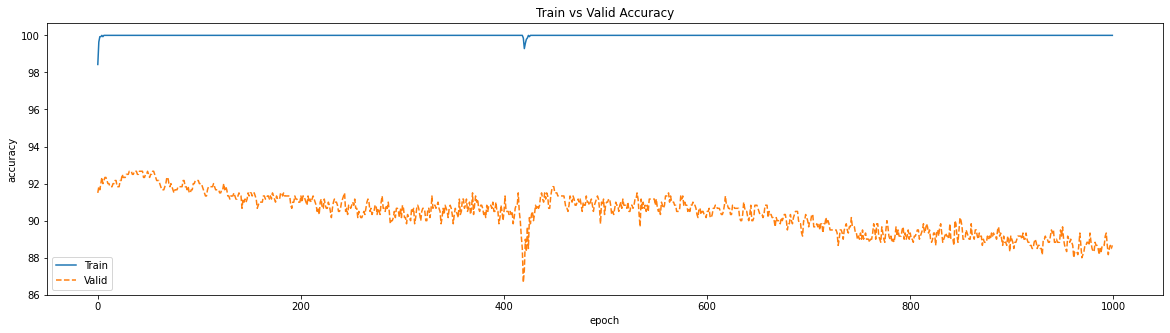

In [103]:
accuracy_plots(train_accu, eval_accu)

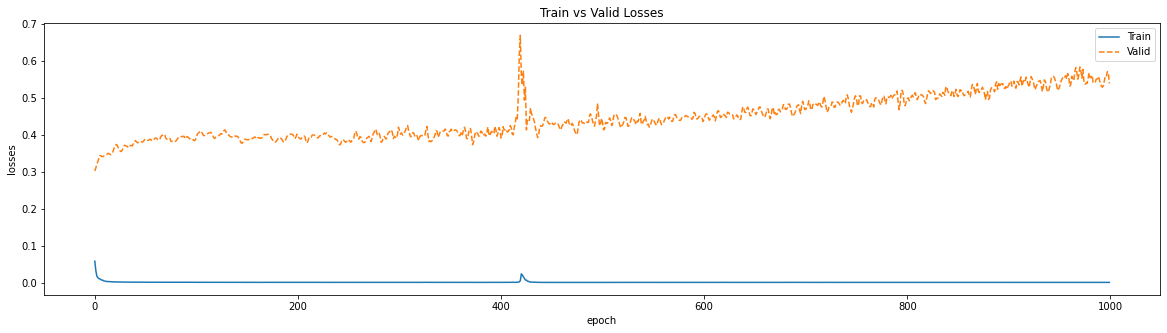

In [104]:
loss_plots(train_losses, eval_losses)

100%|██████████| 5/5 [00:00<00:00, 1057.73it/s]


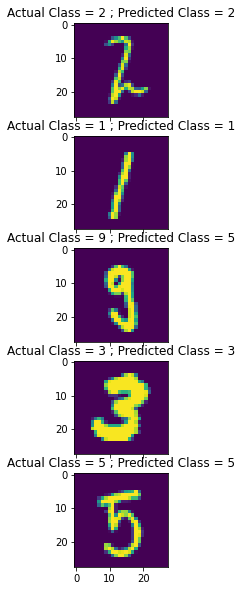

In [105]:
model = model_configs["4"]
model.load_state_dict(torch.load("models/best_model_parameters42.pth"))
model.eval()

with torch.no_grad():
  predicted_classes = []
  device = torch.device("cpu")
  for data in tqdm(first_five_loader):
    images,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(images)
    _, predicted = torch.max(outputs, 1)
    predicted_classes.append(predicted)


fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for j in range(5):
  axs[j].imshow(first_five_test_images[j][0])
  axs[j].set_title(f"Actual Class = {first_five_test_image_labels[0+j]} ; Predicted Class = {predicted_classes[j].item()}")

for ax in axs.flat:
    ax.label_outer()

# model 4, training config 3 : 

In [106]:
s = time.time()
eval_losses, train_losses, eval_accu, train_accu = train("4", "3")
e = time.time()

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |   313600   |
|  l1.bias  |    400     |
| l2.weight |   80000    |
|  l2.bias  |    200     |
| bn.weight |    200     |
|  bn.bias  |    200     |
| l3.weight |    2000    |
|  l3.bias  |     10     |
+-----------+------------+
Total Trainable Params: 396610

Epoch : 1


100%|██████████| 2/2 [00:00<00:00, 134.18it/s]



Epoch : 2


100%|██████████| 2/2 [00:00<00:00, 103.85it/s]



Epoch : 3


100%|██████████| 2/2 [00:00<00:00, 129.46it/s]



Epoch : 4


100%|██████████| 2/2 [00:00<00:00, 141.51it/s]



Epoch : 5


100%|██████████| 2/2 [00:00<00:00, 135.41it/s]



Epoch : 6


100%|██████████| 2/2 [00:00<00:00, 135.25it/s]



Epoch : 7


100%|██████████| 2/2 [00:00<00:00, 125.48it/s]



Epoch : 8


100%|██████████| 2/2 [00:00<00:00, 130.64it/s]



Epoch : 9


100%|██████████| 2/2 [00:00<00:00, 129.07it/s]



Epoch : 10


100%|██████████| 2/2 [00:00<00:00, 127.92it/s]



Epoch : 11


100%|██████████| 2/2 [00:00<00:00, 133.56it/s]



Epoch : 12


100%|██████████| 2/2 [00:00<00:00, 149.87it/s]



Epoch : 13


100%|██████████| 2/2 [00:00<00:00, 134.40it/s]



Epoch : 14


100%|██████████| 2/2 [00:00<00:00, 145.08it/s]



Epoch : 15


100%|██████████| 2/2 [00:00<00:00, 105.11it/s]



Epoch : 16


100%|██████████| 2/2 [00:00<00:00, 124.12it/s]



Epoch : 17


100%|██████████| 2/2 [00:00<00:00, 122.88it/s]



Epoch : 18


100%|██████████| 2/2 [00:00<00:00, 128.89it/s]



Epoch : 19


100%|██████████| 2/2 [00:00<00:00, 123.68it/s]



Epoch : 20


100%|██████████| 2/2 [00:00<00:00, 120.01it/s]



Epoch : 21


100%|██████████| 2/2 [00:00<00:00, 120.71it/s]



Epoch : 22


100%|██████████| 2/2 [00:00<00:00, 122.47it/s]



Epoch : 23


100%|██████████| 2/2 [00:00<00:00, 106.87it/s]



Epoch : 24


100%|██████████| 2/2 [00:00<00:00, 108.97it/s]



Epoch : 25


100%|██████████| 2/2 [00:00<00:00, 104.40it/s]



Epoch : 26


100%|██████████| 2/2 [00:00<00:00, 138.46it/s]



Epoch : 27


100%|██████████| 2/2 [00:00<00:00, 107.25it/s]



Epoch : 28


100%|██████████| 2/2 [00:00<00:00, 119.23it/s]



Epoch : 29


100%|██████████| 2/2 [00:00<00:00, 126.07it/s]



Epoch : 30


100%|██████████| 2/2 [00:00<00:00, 103.53it/s]



Epoch : 31


100%|██████████| 2/2 [00:00<00:00, 122.69it/s]



Epoch : 32


100%|██████████| 2/2 [00:00<00:00, 118.14it/s]



Epoch : 33


100%|██████████| 2/2 [00:00<00:00, 87.13it/s]



Epoch : 34


100%|██████████| 2/2 [00:00<00:00, 126.63it/s]



Epoch : 35


100%|██████████| 2/2 [00:00<00:00, 122.34it/s]



Epoch : 36


100%|██████████| 2/2 [00:00<00:00, 112.84it/s]



Epoch : 37


100%|██████████| 2/2 [00:00<00:00, 126.53it/s]



Epoch : 38


100%|██████████| 2/2 [00:00<00:00, 117.50it/s]



Epoch : 39


100%|██████████| 2/2 [00:00<00:00, 122.21it/s]



Epoch : 40


100%|██████████| 2/2 [00:00<00:00, 120.97it/s]



Epoch : 41


100%|██████████| 2/2 [00:00<00:00, 120.30it/s]



Epoch : 42


100%|██████████| 2/2 [00:00<00:00, 107.42it/s]



Epoch : 43


100%|██████████| 2/2 [00:00<00:00, 98.77it/s]



Epoch : 44


100%|██████████| 2/2 [00:00<00:00, 123.33it/s]



Epoch : 45


100%|██████████| 2/2 [00:00<00:00, 116.18it/s]



Epoch : 46


100%|██████████| 2/2 [00:00<00:00, 98.16it/s]



Epoch : 47


100%|██████████| 2/2 [00:00<00:00, 109.19it/s]



Epoch : 48


100%|██████████| 2/2 [00:00<00:00, 124.24it/s]



Epoch : 49


100%|██████████| 2/2 [00:00<00:00, 96.05it/s]



Epoch : 50


100%|██████████| 2/2 [00:00<00:00, 119.05it/s]



Epoch : 51


100%|██████████| 2/2 [00:00<00:00, 95.85it/s]



Epoch : 52


100%|██████████| 2/2 [00:00<00:00, 121.49it/s]



Epoch : 53


100%|██████████| 2/2 [00:00<00:00, 76.21it/s]



Epoch : 54


100%|██████████| 2/2 [00:00<00:00, 121.14it/s]



Epoch : 55


100%|██████████| 2/2 [00:00<00:00, 116.15it/s]



Epoch : 56


100%|██████████| 2/2 [00:00<00:00, 104.84it/s]



Epoch : 57


100%|██████████| 2/2 [00:00<00:00, 130.50it/s]



Epoch : 58


100%|██████████| 2/2 [00:00<00:00, 116.39it/s]



Epoch : 59


100%|██████████| 2/2 [00:00<00:00, 113.69it/s]



Epoch : 60


100%|██████████| 2/2 [00:00<00:00, 89.53it/s]



Epoch : 61


100%|██████████| 2/2 [00:00<00:00, 123.89it/s]



Epoch : 62


100%|██████████| 2/2 [00:00<00:00, 108.86it/s]



Epoch : 63


100%|██████████| 2/2 [00:00<00:00, 117.50it/s]



Epoch : 64


100%|██████████| 2/2 [00:00<00:00, 115.65it/s]



Epoch : 65


100%|██████████| 2/2 [00:00<00:00, 107.80it/s]



Epoch : 66


100%|██████████| 2/2 [00:00<00:00, 73.09it/s]



Epoch : 67


100%|██████████| 2/2 [00:00<00:00, 119.54it/s]



Epoch : 68


100%|██████████| 2/2 [00:00<00:00, 117.58it/s]



Epoch : 69


100%|██████████| 2/2 [00:00<00:00, 119.08it/s]



Epoch : 70


100%|██████████| 2/2 [00:00<00:00, 118.15it/s]



Epoch : 71


100%|██████████| 2/2 [00:00<00:00, 116.86it/s]



Epoch : 72


100%|██████████| 2/2 [00:00<00:00, 133.37it/s]



Epoch : 73


100%|██████████| 2/2 [00:00<00:00, 113.93it/s]



Epoch : 74


100%|██████████| 2/2 [00:00<00:00, 117.96it/s]



Epoch : 75


100%|██████████| 2/2 [00:00<00:00, 96.13it/s]



Epoch : 76


100%|██████████| 2/2 [00:00<00:00, 117.43it/s]



Epoch : 77


100%|██████████| 2/2 [00:00<00:00, 98.22it/s]



Epoch : 78


100%|██████████| 2/2 [00:00<00:00, 88.11it/s]



Epoch : 79


100%|██████████| 2/2 [00:00<00:00, 109.68it/s]



Epoch : 80


100%|██████████| 2/2 [00:00<00:00, 106.18it/s]



Epoch : 81


100%|██████████| 2/2 [00:00<00:00, 111.84it/s]



Epoch : 82


100%|██████████| 2/2 [00:00<00:00, 104.39it/s]



Epoch : 83


100%|██████████| 2/2 [00:00<00:00, 93.75it/s]



Epoch : 84


100%|██████████| 2/2 [00:00<00:00, 94.24it/s]



Epoch : 85


100%|██████████| 2/2 [00:00<00:00, 104.21it/s]



Epoch : 86


100%|██████████| 2/2 [00:00<00:00, 103.88it/s]



Epoch : 87


100%|██████████| 2/2 [00:00<00:00, 105.45it/s]



Epoch : 88


100%|██████████| 2/2 [00:00<00:00, 115.25it/s]



Epoch : 89


100%|██████████| 2/2 [00:00<00:00, 107.16it/s]



Epoch : 90


100%|██████████| 2/2 [00:00<00:00, 122.87it/s]



Epoch : 91


100%|██████████| 2/2 [00:00<00:00, 100.04it/s]



Epoch : 92


100%|██████████| 2/2 [00:00<00:00, 70.43it/s]



Epoch : 93


100%|██████████| 2/2 [00:00<00:00, 112.64it/s]



Epoch : 94


100%|██████████| 2/2 [00:00<00:00, 107.50it/s]



Epoch : 95


100%|██████████| 2/2 [00:00<00:00, 135.40it/s]



Epoch : 96


100%|██████████| 2/2 [00:00<00:00, 91.77it/s]



Epoch : 97


100%|██████████| 2/2 [00:00<00:00, 117.42it/s]



Epoch : 98


100%|██████████| 2/2 [00:00<00:00, 106.90it/s]



Epoch : 99


100%|██████████| 2/2 [00:00<00:00, 101.23it/s]



Epoch : 100


100%|██████████| 2/2 [00:00<00:00, 93.70it/s]



Epoch : 101


100%|██████████| 2/2 [00:00<00:00, 113.47it/s]



Epoch : 102


100%|██████████| 2/2 [00:00<00:00, 83.31it/s]



Epoch : 103


100%|██████████| 2/2 [00:00<00:00, 107.47it/s]



Epoch : 104


100%|██████████| 2/2 [00:00<00:00, 106.67it/s]



Epoch : 105


100%|██████████| 2/2 [00:00<00:00, 110.93it/s]



Epoch : 106


100%|██████████| 2/2 [00:00<00:00, 100.49it/s]



Epoch : 107


100%|██████████| 2/2 [00:00<00:00, 111.51it/s]



Epoch : 108


100%|██████████| 2/2 [00:00<00:00, 126.20it/s]



Epoch : 109


100%|██████████| 2/2 [00:00<00:00, 103.39it/s]



Epoch : 110


100%|██████████| 2/2 [00:00<00:00, 108.14it/s]



Epoch : 111


100%|██████████| 2/2 [00:00<00:00, 83.51it/s]



Epoch : 112


100%|██████████| 2/2 [00:00<00:00, 102.20it/s]



Epoch : 113


100%|██████████| 2/2 [00:00<00:00, 119.98it/s]



Epoch : 114


100%|██████████| 2/2 [00:00<00:00, 96.37it/s]



Epoch : 115


100%|██████████| 2/2 [00:00<00:00, 104.53it/s]



Epoch : 116


100%|██████████| 2/2 [00:00<00:00, 98.13it/s]



Epoch : 117


100%|██████████| 2/2 [00:00<00:00, 109.67it/s]



Epoch : 118


100%|██████████| 2/2 [00:00<00:00, 73.48it/s]



Epoch : 119


100%|██████████| 2/2 [00:00<00:00, 112.25it/s]



Epoch : 120


100%|██████████| 2/2 [00:00<00:00, 104.17it/s]



Epoch : 121


100%|██████████| 2/2 [00:00<00:00, 114.98it/s]



Epoch : 122


100%|██████████| 2/2 [00:00<00:00, 114.67it/s]



Epoch : 123


100%|██████████| 2/2 [00:00<00:00, 110.92it/s]



Epoch : 124


100%|██████████| 2/2 [00:00<00:00, 109.60it/s]



Epoch : 125


100%|██████████| 2/2 [00:00<00:00, 106.14it/s]



Epoch : 126


100%|██████████| 2/2 [00:00<00:00, 113.19it/s]



Epoch : 127


100%|██████████| 2/2 [00:00<00:00, 90.46it/s]



Epoch : 128


100%|██████████| 2/2 [00:00<00:00, 114.67it/s]



Epoch : 129


100%|██████████| 2/2 [00:00<00:00, 133.58it/s]



Epoch : 130


100%|██████████| 2/2 [00:00<00:00, 128.15it/s]



Epoch : 131


100%|██████████| 2/2 [00:00<00:00, 116.14it/s]



Epoch : 132


100%|██████████| 2/2 [00:00<00:00, 119.62it/s]



Epoch : 133


100%|██████████| 2/2 [00:00<00:00, 113.99it/s]



Epoch : 134


100%|██████████| 2/2 [00:00<00:00, 108.38it/s]



Epoch : 135


100%|██████████| 2/2 [00:00<00:00, 118.51it/s]



Epoch : 136


100%|██████████| 2/2 [00:00<00:00, 106.93it/s]



Epoch : 137


100%|██████████| 2/2 [00:00<00:00, 112.97it/s]



Epoch : 138


100%|██████████| 2/2 [00:00<00:00, 111.24it/s]



Epoch : 139


100%|██████████| 2/2 [00:00<00:00, 87.67it/s]



Epoch : 140


100%|██████████| 2/2 [00:00<00:00, 101.47it/s]



Epoch : 141


100%|██████████| 2/2 [00:00<00:00, 107.10it/s]



Epoch : 142


100%|██████████| 2/2 [00:00<00:00, 101.36it/s]



Epoch : 143


100%|██████████| 2/2 [00:00<00:00, 130.53it/s]



Epoch : 144


100%|██████████| 2/2 [00:00<00:00, 96.91it/s]



Epoch : 145


100%|██████████| 2/2 [00:00<00:00, 108.77it/s]



Epoch : 146


100%|██████████| 2/2 [00:00<00:00, 130.39it/s]



Epoch : 147


100%|██████████| 2/2 [00:00<00:00, 108.25it/s]



Epoch : 148


100%|██████████| 2/2 [00:00<00:00, 105.28it/s]



Epoch : 149


100%|██████████| 2/2 [00:00<00:00, 103.13it/s]



Epoch : 150


100%|██████████| 2/2 [00:00<00:00, 104.85it/s]



Epoch : 151


100%|██████████| 2/2 [00:00<00:00, 107.73it/s]



Epoch : 152


100%|██████████| 2/2 [00:00<00:00, 108.30it/s]



Epoch : 153


100%|██████████| 2/2 [00:00<00:00, 100.98it/s]



Epoch : 154


100%|██████████| 2/2 [00:00<00:00, 111.05it/s]



Epoch : 155


100%|██████████| 2/2 [00:00<00:00, 125.61it/s]



Epoch : 156


100%|██████████| 2/2 [00:00<00:00, 98.56it/s]



Epoch : 157


100%|██████████| 2/2 [00:00<00:00, 108.50it/s]



Epoch : 158


100%|██████████| 2/2 [00:00<00:00, 87.42it/s]



Epoch : 159


100%|██████████| 2/2 [00:00<00:00, 108.45it/s]



Epoch : 160


100%|██████████| 2/2 [00:00<00:00, 109.31it/s]



Epoch : 161


100%|██████████| 2/2 [00:00<00:00, 105.68it/s]



Epoch : 162


100%|██████████| 2/2 [00:00<00:00, 110.82it/s]



Epoch : 163


100%|██████████| 2/2 [00:00<00:00, 108.47it/s]



Epoch : 164


100%|██████████| 2/2 [00:00<00:00, 107.46it/s]



Epoch : 165


100%|██████████| 2/2 [00:00<00:00, 98.18it/s]



Epoch : 166


100%|██████████| 2/2 [00:00<00:00, 108.23it/s]



Epoch : 167


100%|██████████| 2/2 [00:00<00:00, 89.76it/s]



Epoch : 168


100%|██████████| 2/2 [00:00<00:00, 111.69it/s]



Epoch : 169


100%|██████████| 2/2 [00:00<00:00, 104.35it/s]



Epoch : 170


100%|██████████| 2/2 [00:00<00:00, 108.80it/s]



Epoch : 171


100%|██████████| 2/2 [00:00<00:00, 99.71it/s]



Epoch : 172


100%|██████████| 2/2 [00:00<00:00, 115.21it/s]



Epoch : 173


100%|██████████| 2/2 [00:00<00:00, 106.37it/s]



Epoch : 174


100%|██████████| 2/2 [00:00<00:00, 128.51it/s]



Epoch : 175


100%|██████████| 2/2 [00:00<00:00, 101.69it/s]



Epoch : 176


100%|██████████| 2/2 [00:00<00:00, 107.06it/s]



Epoch : 177


100%|██████████| 2/2 [00:00<00:00, 121.46it/s]



Epoch : 178


100%|██████████| 2/2 [00:00<00:00, 105.23it/s]



Epoch : 179


100%|██████████| 2/2 [00:00<00:00, 108.31it/s]



Epoch : 180


100%|██████████| 2/2 [00:00<00:00, 108.83it/s]



Epoch : 181


100%|██████████| 2/2 [00:00<00:00, 114.65it/s]



Epoch : 182


100%|██████████| 2/2 [00:00<00:00, 122.27it/s]



Epoch : 183


100%|██████████| 2/2 [00:00<00:00, 112.66it/s]



Epoch : 184


100%|██████████| 2/2 [00:00<00:00, 107.92it/s]



Epoch : 185


100%|██████████| 2/2 [00:00<00:00, 103.35it/s]



Epoch : 186


100%|██████████| 2/2 [00:00<00:00, 102.42it/s]



Epoch : 187


100%|██████████| 2/2 [00:00<00:00, 107.97it/s]



Epoch : 188


100%|██████████| 2/2 [00:00<00:00, 111.94it/s]



Epoch : 189


100%|██████████| 2/2 [00:00<00:00, 98.64it/s]



Epoch : 190


100%|██████████| 2/2 [00:00<00:00, 106.82it/s]



Epoch : 191


100%|██████████| 2/2 [00:00<00:00, 105.50it/s]



Epoch : 192


100%|██████████| 2/2 [00:00<00:00, 109.96it/s]



Epoch : 193


100%|██████████| 2/2 [00:00<00:00, 95.93it/s]



Epoch : 194


100%|██████████| 2/2 [00:00<00:00, 109.11it/s]



Epoch : 195


100%|██████████| 2/2 [00:00<00:00, 84.43it/s]



Epoch : 196


100%|██████████| 2/2 [00:00<00:00, 106.73it/s]



Epoch : 197


100%|██████████| 2/2 [00:00<00:00, 107.93it/s]



Epoch : 198


100%|██████████| 2/2 [00:00<00:00, 119.45it/s]



Epoch : 199


100%|██████████| 2/2 [00:00<00:00, 106.02it/s]



Epoch : 200


100%|██████████| 2/2 [00:00<00:00, 102.79it/s]



Epoch : 201


100%|██████████| 2/2 [00:00<00:00, 85.24it/s]



Epoch : 202


100%|██████████| 2/2 [00:00<00:00, 109.40it/s]



Epoch : 203


100%|██████████| 2/2 [00:00<00:00, 110.81it/s]



Epoch : 204


100%|██████████| 2/2 [00:00<00:00, 105.96it/s]



Epoch : 205


100%|██████████| 2/2 [00:00<00:00, 105.18it/s]



Epoch : 206


100%|██████████| 2/2 [00:00<00:00, 113.09it/s]



Epoch : 207


100%|██████████| 2/2 [00:00<00:00, 93.75it/s]



Epoch : 208


100%|██████████| 2/2 [00:00<00:00, 103.67it/s]



Epoch : 209


100%|██████████| 2/2 [00:00<00:00, 102.96it/s]



Epoch : 210


100%|██████████| 2/2 [00:00<00:00, 104.20it/s]



Epoch : 211


100%|██████████| 2/2 [00:00<00:00, 97.24it/s]



Epoch : 212


100%|██████████| 2/2 [00:00<00:00, 115.97it/s]



Epoch : 213


100%|██████████| 2/2 [00:00<00:00, 104.92it/s]



Epoch : 214


100%|██████████| 2/2 [00:00<00:00, 96.49it/s]



Epoch : 215


100%|██████████| 2/2 [00:00<00:00, 106.88it/s]



Epoch : 216


100%|██████████| 2/2 [00:00<00:00, 106.74it/s]



Epoch : 217


100%|██████████| 2/2 [00:00<00:00, 108.45it/s]



Epoch : 218


100%|██████████| 2/2 [00:00<00:00, 102.53it/s]



Epoch : 219


100%|██████████| 2/2 [00:00<00:00, 103.68it/s]



Epoch : 220


100%|██████████| 2/2 [00:00<00:00, 90.46it/s]



Epoch : 221


100%|██████████| 2/2 [00:00<00:00, 101.61it/s]



Epoch : 222


100%|██████████| 2/2 [00:00<00:00, 149.01it/s]



Epoch : 223


100%|██████████| 2/2 [00:00<00:00, 105.63it/s]



Epoch : 224


100%|██████████| 2/2 [00:00<00:00, 107.44it/s]



Epoch : 225


100%|██████████| 2/2 [00:00<00:00, 105.10it/s]



Epoch : 226


100%|██████████| 2/2 [00:00<00:00, 92.07it/s]



Epoch : 227


100%|██████████| 2/2 [00:00<00:00, 102.45it/s]



Epoch : 228


100%|██████████| 2/2 [00:00<00:00, 106.63it/s]



Epoch : 229


100%|██████████| 2/2 [00:00<00:00, 94.99it/s]



Epoch : 230


100%|██████████| 2/2 [00:00<00:00, 103.00it/s]



Epoch : 231


100%|██████████| 2/2 [00:00<00:00, 104.27it/s]



Epoch : 232


100%|██████████| 2/2 [00:00<00:00, 101.80it/s]



Epoch : 233


100%|██████████| 2/2 [00:00<00:00, 107.89it/s]



Epoch : 234


100%|██████████| 2/2 [00:00<00:00, 107.49it/s]



Epoch : 235


100%|██████████| 2/2 [00:00<00:00, 84.36it/s]



Epoch : 236


100%|██████████| 2/2 [00:00<00:00, 86.52it/s]



Epoch : 237


100%|██████████| 2/2 [00:00<00:00, 118.08it/s]



Epoch : 238


100%|██████████| 2/2 [00:00<00:00, 86.09it/s]



Epoch : 239


100%|██████████| 2/2 [00:00<00:00, 100.51it/s]



Epoch : 240


100%|██████████| 2/2 [00:00<00:00, 105.20it/s]



Epoch : 241


100%|██████████| 2/2 [00:00<00:00, 80.67it/s]



Epoch : 242


100%|██████████| 2/2 [00:00<00:00, 105.54it/s]



Epoch : 243


100%|██████████| 2/2 [00:00<00:00, 113.37it/s]



Epoch : 244


100%|██████████| 2/2 [00:00<00:00, 98.44it/s]



Epoch : 245


100%|██████████| 2/2 [00:00<00:00, 97.70it/s]



Epoch : 246


100%|██████████| 2/2 [00:00<00:00, 116.23it/s]



Epoch : 247


100%|██████████| 2/2 [00:00<00:00, 109.59it/s]



Epoch : 248


100%|██████████| 2/2 [00:00<00:00, 102.95it/s]



Epoch : 249


100%|██████████| 2/2 [00:00<00:00, 102.94it/s]



Epoch : 250


100%|██████████| 2/2 [00:00<00:00, 94.91it/s]



Epoch : 251


100%|██████████| 2/2 [00:00<00:00, 103.23it/s]



Epoch : 252


100%|██████████| 2/2 [00:00<00:00, 119.98it/s]



Epoch : 253


100%|██████████| 2/2 [00:00<00:00, 106.41it/s]



Epoch : 254


100%|██████████| 2/2 [00:00<00:00, 93.31it/s]



Epoch : 255


100%|██████████| 2/2 [00:00<00:00, 119.87it/s]



Epoch : 256


100%|██████████| 2/2 [00:00<00:00, 99.88it/s]



Epoch : 257


100%|██████████| 2/2 [00:00<00:00, 99.46it/s]



Epoch : 258


100%|██████████| 2/2 [00:00<00:00, 100.22it/s]



Epoch : 259


100%|██████████| 2/2 [00:00<00:00, 101.30it/s]



Epoch : 260


100%|██████████| 2/2 [00:00<00:00, 100.60it/s]



Epoch : 261


100%|██████████| 2/2 [00:00<00:00, 98.72it/s]



Epoch : 262


100%|██████████| 2/2 [00:00<00:00, 99.31it/s]



Epoch : 263


100%|██████████| 2/2 [00:00<00:00, 104.17it/s]



Epoch : 264


100%|██████████| 2/2 [00:00<00:00, 96.33it/s]



Epoch : 265


100%|██████████| 2/2 [00:00<00:00, 96.11it/s]



Epoch : 266


100%|██████████| 2/2 [00:00<00:00, 98.00it/s]



Epoch : 267


100%|██████████| 2/2 [00:00<00:00, 116.05it/s]



Epoch : 268


100%|██████████| 2/2 [00:00<00:00, 98.22it/s]



Epoch : 269


100%|██████████| 2/2 [00:00<00:00, 101.18it/s]



Epoch : 270


100%|██████████| 2/2 [00:00<00:00, 103.83it/s]



Epoch : 271


100%|██████████| 2/2 [00:00<00:00, 114.24it/s]



Epoch : 272


100%|██████████| 2/2 [00:00<00:00, 100.29it/s]



Epoch : 273


100%|██████████| 2/2 [00:00<00:00, 101.66it/s]



Epoch : 274


100%|██████████| 2/2 [00:00<00:00, 104.25it/s]



Epoch : 275


100%|██████████| 2/2 [00:00<00:00, 98.96it/s]



Epoch : 276


100%|██████████| 2/2 [00:00<00:00, 110.15it/s]



Epoch : 277


100%|██████████| 2/2 [00:00<00:00, 133.62it/s]



Epoch : 278


100%|██████████| 2/2 [00:00<00:00, 96.49it/s]



Epoch : 279


100%|██████████| 2/2 [00:00<00:00, 101.61it/s]



Epoch : 280


100%|██████████| 2/2 [00:00<00:00, 96.41it/s]



Epoch : 281


100%|██████████| 2/2 [00:00<00:00, 102.07it/s]



Epoch : 282


100%|██████████| 2/2 [00:00<00:00, 78.41it/s]



Epoch : 283


100%|██████████| 2/2 [00:00<00:00, 97.44it/s]



Epoch : 284


100%|██████████| 2/2 [00:00<00:00, 102.52it/s]



Epoch : 285


100%|██████████| 2/2 [00:00<00:00, 107.00it/s]



Epoch : 286


100%|██████████| 2/2 [00:00<00:00, 97.82it/s]



Epoch : 287


100%|██████████| 2/2 [00:00<00:00, 98.55it/s]



Epoch : 288


100%|██████████| 2/2 [00:00<00:00, 93.47it/s]



Epoch : 289


100%|██████████| 2/2 [00:00<00:00, 88.06it/s]



Epoch : 290


100%|██████████| 2/2 [00:00<00:00, 106.47it/s]



Epoch : 291


100%|██████████| 2/2 [00:00<00:00, 93.02it/s]



Epoch : 292


100%|██████████| 2/2 [00:00<00:00, 98.07it/s]



Epoch : 293


100%|██████████| 2/2 [00:00<00:00, 101.71it/s]



Epoch : 294


100%|██████████| 2/2 [00:00<00:00, 97.38it/s]



Epoch : 295


100%|██████████| 2/2 [00:00<00:00, 102.46it/s]



Epoch : 296


100%|██████████| 2/2 [00:00<00:00, 101.69it/s]



Epoch : 297


100%|██████████| 2/2 [00:00<00:00, 93.50it/s]



Epoch : 298


100%|██████████| 2/2 [00:00<00:00, 100.12it/s]



Epoch : 299


100%|██████████| 2/2 [00:00<00:00, 99.39it/s]



Epoch : 300


100%|██████████| 2/2 [00:00<00:00, 95.29it/s]



Epoch : 301


100%|██████████| 2/2 [00:00<00:00, 88.59it/s]



Epoch : 302


100%|██████████| 2/2 [00:00<00:00, 72.79it/s]



Epoch : 303


100%|██████████| 2/2 [00:00<00:00, 102.09it/s]



Epoch : 304


100%|██████████| 2/2 [00:00<00:00, 90.19it/s]



Epoch : 305


100%|██████████| 2/2 [00:00<00:00, 102.53it/s]



Epoch : 306


100%|██████████| 2/2 [00:00<00:00, 105.22it/s]



Epoch : 307


100%|██████████| 2/2 [00:00<00:00, 103.47it/s]



Epoch : 308


100%|██████████| 2/2 [00:00<00:00, 101.11it/s]



Epoch : 309


100%|██████████| 2/2 [00:00<00:00, 89.71it/s]



Epoch : 310


100%|██████████| 2/2 [00:00<00:00, 93.94it/s]



Epoch : 311


100%|██████████| 2/2 [00:00<00:00, 99.83it/s]



Epoch : 312


100%|██████████| 2/2 [00:00<00:00, 99.73it/s]



Epoch : 313


100%|██████████| 2/2 [00:00<00:00, 75.60it/s]



Epoch : 314


100%|██████████| 2/2 [00:00<00:00, 91.26it/s]



Epoch : 315


100%|██████████| 2/2 [00:00<00:00, 105.69it/s]



Epoch : 316


100%|██████████| 2/2 [00:00<00:00, 91.35it/s]



Epoch : 317


100%|██████████| 2/2 [00:00<00:00, 90.46it/s]



Epoch : 318


100%|██████████| 2/2 [00:00<00:00, 99.61it/s]



Epoch : 319


100%|██████████| 2/2 [00:00<00:00, 124.80it/s]



Epoch : 320


100%|██████████| 2/2 [00:00<00:00, 103.82it/s]



Epoch : 321


100%|██████████| 2/2 [00:00<00:00, 96.97it/s]



Epoch : 322


100%|██████████| 2/2 [00:00<00:00, 94.27it/s]



Epoch : 323


100%|██████████| 2/2 [00:00<00:00, 94.83it/s]



Epoch : 324


100%|██████████| 2/2 [00:00<00:00, 98.79it/s]



Epoch : 325


100%|██████████| 2/2 [00:00<00:00, 98.79it/s]



Epoch : 326


100%|██████████| 2/2 [00:00<00:00, 125.55it/s]



Epoch : 327


100%|██████████| 2/2 [00:00<00:00, 95.33it/s]



Epoch : 328


100%|██████████| 2/2 [00:00<00:00, 97.45it/s]



Epoch : 329


100%|██████████| 2/2 [00:00<00:00, 109.93it/s]



Epoch : 330


100%|██████████| 2/2 [00:00<00:00, 95.81it/s]



Epoch : 331


100%|██████████| 2/2 [00:00<00:00, 96.67it/s]



Epoch : 332


100%|██████████| 2/2 [00:00<00:00, 123.51it/s]



Epoch : 333


100%|██████████| 2/2 [00:00<00:00, 88.91it/s]



Epoch : 334


100%|██████████| 2/2 [00:00<00:00, 93.50it/s]



Epoch : 335


100%|██████████| 2/2 [00:00<00:00, 96.67it/s]



Epoch : 336


100%|██████████| 2/2 [00:00<00:00, 94.27it/s]



Epoch : 337


100%|██████████| 2/2 [00:00<00:00, 88.99it/s]



Epoch : 338


100%|██████████| 2/2 [00:00<00:00, 95.98it/s]



Epoch : 339


100%|██████████| 2/2 [00:00<00:00, 101.57it/s]



Epoch : 340


100%|██████████| 2/2 [00:00<00:00, 90.89it/s]



Epoch : 341


100%|██████████| 2/2 [00:00<00:00, 73.37it/s]



Epoch : 342


100%|██████████| 2/2 [00:00<00:00, 96.70it/s]



Epoch : 343


100%|██████████| 2/2 [00:00<00:00, 98.51it/s]



Epoch : 344


100%|██████████| 2/2 [00:00<00:00, 96.04it/s]



Epoch : 345


100%|██████████| 2/2 [00:00<00:00, 97.73it/s]



Epoch : 346


100%|██████████| 2/2 [00:00<00:00, 97.59it/s]



Epoch : 347


100%|██████████| 2/2 [00:00<00:00, 75.83it/s]



Epoch : 348


100%|██████████| 2/2 [00:00<00:00, 96.71it/s]



Epoch : 349


100%|██████████| 2/2 [00:00<00:00, 105.32it/s]



Epoch : 350


100%|██████████| 2/2 [00:00<00:00, 99.00it/s]



Epoch : 351


100%|██████████| 2/2 [00:00<00:00, 99.93it/s]



Epoch : 352


100%|██████████| 2/2 [00:00<00:00, 98.05it/s]



Epoch : 353


100%|██████████| 2/2 [00:00<00:00, 112.54it/s]



Epoch : 354


100%|██████████| 2/2 [00:00<00:00, 127.67it/s]



Epoch : 355


100%|██████████| 2/2 [00:00<00:00, 121.26it/s]



Epoch : 356


100%|██████████| 2/2 [00:00<00:00, 112.79it/s]



Epoch : 357


100%|██████████| 2/2 [00:00<00:00, 97.23it/s]



Epoch : 358


100%|██████████| 2/2 [00:00<00:00, 93.02it/s]



Epoch : 359


100%|██████████| 2/2 [00:00<00:00, 105.03it/s]



Epoch : 360


100%|██████████| 2/2 [00:00<00:00, 108.06it/s]



Epoch : 361


100%|██████████| 2/2 [00:00<00:00, 95.24it/s]



Epoch : 362


100%|██████████| 2/2 [00:00<00:00, 85.35it/s]



Epoch : 363


100%|██████████| 2/2 [00:00<00:00, 133.75it/s]



Epoch : 364


100%|██████████| 2/2 [00:00<00:00, 108.04it/s]



Epoch : 365


100%|██████████| 2/2 [00:00<00:00, 106.92it/s]



Epoch : 366


100%|██████████| 2/2 [00:00<00:00, 96.84it/s]



Epoch : 367


100%|██████████| 2/2 [00:00<00:00, 103.13it/s]



Epoch : 368


100%|██████████| 2/2 [00:00<00:00, 91.86it/s]



Epoch : 369


100%|██████████| 2/2 [00:00<00:00, 105.72it/s]



Epoch : 370


100%|██████████| 2/2 [00:00<00:00, 119.23it/s]



Epoch : 371


100%|██████████| 2/2 [00:00<00:00, 91.88it/s]



Epoch : 372


100%|██████████| 2/2 [00:00<00:00, 90.76it/s]



Epoch : 373


100%|██████████| 2/2 [00:00<00:00, 98.73it/s]



Epoch : 374


100%|██████████| 2/2 [00:00<00:00, 94.88it/s]



Epoch : 375


100%|██████████| 2/2 [00:00<00:00, 120.02it/s]



Epoch : 376


100%|██████████| 2/2 [00:00<00:00, 122.35it/s]



Epoch : 377


100%|██████████| 2/2 [00:00<00:00, 81.93it/s]



Epoch : 378


100%|██████████| 2/2 [00:00<00:00, 103.47it/s]



Epoch : 379


100%|██████████| 2/2 [00:00<00:00, 88.64it/s]



Epoch : 380


100%|██████████| 2/2 [00:00<00:00, 99.03it/s]



Epoch : 381


100%|██████████| 2/2 [00:00<00:00, 88.88it/s]



Epoch : 382


100%|██████████| 2/2 [00:00<00:00, 106.81it/s]



Epoch : 383


100%|██████████| 2/2 [00:00<00:00, 95.37it/s]



Epoch : 384


100%|██████████| 2/2 [00:00<00:00, 107.01it/s]



Epoch : 385


100%|██████████| 2/2 [00:00<00:00, 122.85it/s]



Epoch : 386


100%|██████████| 2/2 [00:00<00:00, 91.01it/s]



Epoch : 387


100%|██████████| 2/2 [00:00<00:00, 86.09it/s]



Epoch : 388


100%|██████████| 2/2 [00:00<00:00, 117.49it/s]



Epoch : 389


100%|██████████| 2/2 [00:00<00:00, 101.57it/s]



Epoch : 390


100%|██████████| 2/2 [00:00<00:00, 107.46it/s]



Epoch : 391


100%|██████████| 2/2 [00:00<00:00, 103.24it/s]



Epoch : 392


100%|██████████| 2/2 [00:00<00:00, 104.11it/s]



Epoch : 393


100%|██████████| 2/2 [00:00<00:00, 86.56it/s]



Epoch : 394


100%|██████████| 2/2 [00:00<00:00, 107.16it/s]



Epoch : 395


100%|██████████| 2/2 [00:00<00:00, 131.34it/s]



Epoch : 396


100%|██████████| 2/2 [00:00<00:00, 110.29it/s]



Epoch : 397


100%|██████████| 2/2 [00:00<00:00, 99.68it/s]



Epoch : 398


100%|██████████| 2/2 [00:00<00:00, 94.06it/s]



Epoch : 399


100%|██████████| 2/2 [00:00<00:00, 97.43it/s]



Epoch : 400


100%|██████████| 2/2 [00:00<00:00, 96.71it/s]



Epoch : 401


100%|██████████| 2/2 [00:00<00:00, 87.87it/s]



Epoch : 402


100%|██████████| 2/2 [00:00<00:00, 110.31it/s]



Epoch : 403


100%|██████████| 2/2 [00:00<00:00, 100.96it/s]



Epoch : 404


100%|██████████| 2/2 [00:00<00:00, 103.21it/s]



Epoch : 405


100%|██████████| 2/2 [00:00<00:00, 94.06it/s]



Epoch : 406


100%|██████████| 2/2 [00:00<00:00, 100.94it/s]



Epoch : 407


100%|██████████| 2/2 [00:00<00:00, 86.82it/s]



Epoch : 408


100%|██████████| 2/2 [00:00<00:00, 90.52it/s]



Epoch : 409


100%|██████████| 2/2 [00:00<00:00, 100.32it/s]



Epoch : 410


100%|██████████| 2/2 [00:00<00:00, 91.80it/s]



Epoch : 411


100%|██████████| 2/2 [00:00<00:00, 104.35it/s]



Epoch : 412


100%|██████████| 2/2 [00:00<00:00, 96.14it/s]



Epoch : 413


100%|██████████| 2/2 [00:00<00:00, 90.84it/s]



Epoch : 414


100%|██████████| 2/2 [00:00<00:00, 98.07it/s]



Epoch : 415


100%|██████████| 2/2 [00:00<00:00, 114.01it/s]



Epoch : 416


100%|██████████| 2/2 [00:00<00:00, 98.86it/s]



Epoch : 417


100%|██████████| 2/2 [00:00<00:00, 107.08it/s]



Epoch : 418


100%|██████████| 2/2 [00:00<00:00, 90.11it/s]



Epoch : 419


100%|██████████| 2/2 [00:00<00:00, 97.80it/s]



Epoch : 420


100%|██████████| 2/2 [00:00<00:00, 91.13it/s]



Epoch : 421


100%|██████████| 2/2 [00:00<00:00, 102.77it/s]



Epoch : 422


100%|██████████| 2/2 [00:00<00:00, 104.11it/s]



Epoch : 423


100%|██████████| 2/2 [00:00<00:00, 109.02it/s]



Epoch : 424


100%|██████████| 2/2 [00:00<00:00, 99.17it/s]



Epoch : 425


100%|██████████| 2/2 [00:00<00:00, 79.48it/s]



Epoch : 426


100%|██████████| 2/2 [00:00<00:00, 79.47it/s]



Epoch : 427


100%|██████████| 2/2 [00:00<00:00, 101.82it/s]



Epoch : 428


100%|██████████| 2/2 [00:00<00:00, 99.24it/s]



Epoch : 429


100%|██████████| 2/2 [00:00<00:00, 106.31it/s]



Epoch : 430


100%|██████████| 2/2 [00:00<00:00, 90.31it/s]



Epoch : 431


100%|██████████| 2/2 [00:00<00:00, 86.86it/s]



Epoch : 432


100%|██████████| 2/2 [00:00<00:00, 95.15it/s]



Epoch : 433


100%|██████████| 2/2 [00:00<00:00, 85.86it/s]



Epoch : 434


100%|██████████| 2/2 [00:00<00:00, 104.96it/s]



Epoch : 435


100%|██████████| 2/2 [00:00<00:00, 96.01it/s]



Epoch : 436


100%|██████████| 2/2 [00:00<00:00, 102.88it/s]



Epoch : 437


100%|██████████| 2/2 [00:00<00:00, 133.78it/s]



Epoch : 438


100%|██████████| 2/2 [00:00<00:00, 87.30it/s]



Epoch : 439


100%|██████████| 2/2 [00:00<00:00, 97.21it/s]



Epoch : 440


100%|██████████| 2/2 [00:00<00:00, 86.09it/s]



Epoch : 441


100%|██████████| 2/2 [00:00<00:00, 97.49it/s]



Epoch : 442


100%|██████████| 2/2 [00:00<00:00, 97.05it/s]



Epoch : 443


100%|██████████| 2/2 [00:00<00:00, 97.41it/s]



Epoch : 444


100%|██████████| 2/2 [00:00<00:00, 101.19it/s]



Epoch : 445


100%|██████████| 2/2 [00:00<00:00, 82.96it/s]



Epoch : 446


100%|██████████| 2/2 [00:00<00:00, 93.51it/s]



Epoch : 447


100%|██████████| 2/2 [00:00<00:00, 99.26it/s]



Epoch : 448


100%|██████████| 2/2 [00:00<00:00, 104.64it/s]



Epoch : 449


100%|██████████| 2/2 [00:00<00:00, 118.94it/s]



Epoch : 450


100%|██████████| 2/2 [00:00<00:00, 106.65it/s]



Epoch : 451


100%|██████████| 2/2 [00:00<00:00, 96.29it/s]



Epoch : 452


100%|██████████| 2/2 [00:00<00:00, 102.93it/s]



Epoch : 453


100%|██████████| 2/2 [00:00<00:00, 90.55it/s]



Epoch : 454


100%|██████████| 2/2 [00:00<00:00, 91.87it/s]



Epoch : 455


100%|██████████| 2/2 [00:00<00:00, 121.64it/s]



Epoch : 456


100%|██████████| 2/2 [00:00<00:00, 82.47it/s]



Epoch : 457


100%|██████████| 2/2 [00:00<00:00, 104.95it/s]



Epoch : 458


100%|██████████| 2/2 [00:00<00:00, 103.45it/s]



Epoch : 459


100%|██████████| 2/2 [00:00<00:00, 85.34it/s]



Epoch : 460


100%|██████████| 2/2 [00:00<00:00, 90.92it/s]



Epoch : 461


100%|██████████| 2/2 [00:00<00:00, 104.37it/s]



Epoch : 462


100%|██████████| 2/2 [00:00<00:00, 95.83it/s]



Epoch : 463


100%|██████████| 2/2 [00:00<00:00, 80.86it/s]



Epoch : 464


100%|██████████| 2/2 [00:00<00:00, 98.77it/s]



Epoch : 465


100%|██████████| 2/2 [00:00<00:00, 90.05it/s]



Epoch : 466


100%|██████████| 2/2 [00:00<00:00, 69.07it/s]



Epoch : 467


100%|██████████| 2/2 [00:00<00:00, 103.20it/s]



Epoch : 468


100%|██████████| 2/2 [00:00<00:00, 86.71it/s]



Epoch : 469


100%|██████████| 2/2 [00:00<00:00, 99.49it/s]



Epoch : 470


100%|██████████| 2/2 [00:00<00:00, 94.69it/s]



Epoch : 471


100%|██████████| 2/2 [00:00<00:00, 86.45it/s]



Epoch : 472


100%|██████████| 2/2 [00:00<00:00, 93.56it/s]



Epoch : 473


100%|██████████| 2/2 [00:00<00:00, 96.16it/s]



Epoch : 474


100%|██████████| 2/2 [00:00<00:00, 92.83it/s]



Epoch : 475


100%|██████████| 2/2 [00:00<00:00, 98.11it/s]



Epoch : 476


100%|██████████| 2/2 [00:00<00:00, 89.56it/s]



Epoch : 477


100%|██████████| 2/2 [00:00<00:00, 122.52it/s]



Epoch : 478


100%|██████████| 2/2 [00:00<00:00, 99.98it/s]



Epoch : 479


100%|██████████| 2/2 [00:00<00:00, 100.65it/s]



Epoch : 480


100%|██████████| 2/2 [00:00<00:00, 96.76it/s]



Epoch : 481


100%|██████████| 2/2 [00:00<00:00, 88.67it/s]



Epoch : 482


100%|██████████| 2/2 [00:00<00:00, 108.30it/s]



Epoch : 483


100%|██████████| 2/2 [00:00<00:00, 83.07it/s]



Epoch : 484


100%|██████████| 2/2 [00:00<00:00, 88.51it/s]



Epoch : 485


100%|██████████| 2/2 [00:00<00:00, 101.79it/s]



Epoch : 486


100%|██████████| 2/2 [00:00<00:00, 99.19it/s]



Epoch : 487


100%|██████████| 2/2 [00:00<00:00, 90.68it/s]



Epoch : 488


100%|██████████| 2/2 [00:00<00:00, 102.23it/s]



Epoch : 489


100%|██████████| 2/2 [00:00<00:00, 97.83it/s]



Epoch : 490


100%|██████████| 2/2 [00:00<00:00, 103.86it/s]



Epoch : 491


100%|██████████| 2/2 [00:00<00:00, 94.31it/s]



Epoch : 492


100%|██████████| 2/2 [00:00<00:00, 93.91it/s]



Epoch : 493


100%|██████████| 2/2 [00:00<00:00, 93.65it/s]



Epoch : 494


100%|██████████| 2/2 [00:00<00:00, 88.54it/s]



Epoch : 495


100%|██████████| 2/2 [00:00<00:00, 103.80it/s]



Epoch : 496


100%|██████████| 2/2 [00:00<00:00, 92.38it/s]



Epoch : 497


100%|██████████| 2/2 [00:00<00:00, 97.82it/s]



Epoch : 498


100%|██████████| 2/2 [00:00<00:00, 98.82it/s]



Epoch : 499


100%|██████████| 2/2 [00:00<00:00, 104.24it/s]



Epoch : 500


100%|██████████| 2/2 [00:00<00:00, 91.42it/s]



Epoch : 501


100%|██████████| 2/2 [00:00<00:00, 86.42it/s]



Epoch : 502


100%|██████████| 2/2 [00:00<00:00, 102.56it/s]



Epoch : 503


100%|██████████| 2/2 [00:00<00:00, 99.61it/s]



Epoch : 504


100%|██████████| 2/2 [00:00<00:00, 80.38it/s]



Epoch : 505


100%|██████████| 2/2 [00:00<00:00, 92.67it/s]



Epoch : 506


100%|██████████| 2/2 [00:00<00:00, 99.72it/s]



Epoch : 507


100%|██████████| 2/2 [00:00<00:00, 105.26it/s]



Epoch : 508


100%|██████████| 2/2 [00:00<00:00, 91.85it/s]



Epoch : 509


100%|██████████| 2/2 [00:00<00:00, 89.90it/s]



Epoch : 510


100%|██████████| 2/2 [00:00<00:00, 91.92it/s]



Epoch : 511


100%|██████████| 2/2 [00:00<00:00, 94.77it/s]



Epoch : 512


100%|██████████| 2/2 [00:00<00:00, 93.41it/s]



Epoch : 513


100%|██████████| 2/2 [00:00<00:00, 97.21it/s]



Epoch : 514


100%|██████████| 2/2 [00:00<00:00, 96.82it/s]



Epoch : 515


100%|██████████| 2/2 [00:00<00:00, 95.55it/s]



Epoch : 516


100%|██████████| 2/2 [00:00<00:00, 97.15it/s]



Epoch : 517


100%|██████████| 2/2 [00:00<00:00, 95.74it/s]



Epoch : 518


100%|██████████| 2/2 [00:00<00:00, 93.87it/s]



Epoch : 519


100%|██████████| 2/2 [00:00<00:00, 82.97it/s]



Epoch : 520


100%|██████████| 2/2 [00:00<00:00, 85.85it/s]



Epoch : 521


100%|██████████| 2/2 [00:00<00:00, 98.66it/s]



Epoch : 522


100%|██████████| 2/2 [00:00<00:00, 87.17it/s]



Epoch : 523


100%|██████████| 2/2 [00:00<00:00, 76.81it/s]



Epoch : 524


100%|██████████| 2/2 [00:00<00:00, 90.41it/s]



Epoch : 525


100%|██████████| 2/2 [00:00<00:00, 90.67it/s]



Epoch : 526


100%|██████████| 2/2 [00:00<00:00, 90.90it/s]



Epoch : 527


100%|██████████| 2/2 [00:00<00:00, 86.12it/s]



Epoch : 528


100%|██████████| 2/2 [00:00<00:00, 114.08it/s]



Epoch : 529


100%|██████████| 2/2 [00:00<00:00, 87.45it/s]



Epoch : 530


100%|██████████| 2/2 [00:00<00:00, 82.79it/s]



Epoch : 531


100%|██████████| 2/2 [00:00<00:00, 90.70it/s]



Epoch : 532


100%|██████████| 2/2 [00:00<00:00, 97.30it/s]



Epoch : 533


100%|██████████| 2/2 [00:00<00:00, 101.82it/s]



Epoch : 534


100%|██████████| 2/2 [00:00<00:00, 86.62it/s]



Epoch : 535


100%|██████████| 2/2 [00:00<00:00, 96.80it/s]



Epoch : 536


100%|██████████| 2/2 [00:00<00:00, 63.47it/s]



Epoch : 537


100%|██████████| 2/2 [00:00<00:00, 89.39it/s]



Epoch : 538


100%|██████████| 2/2 [00:00<00:00, 96.21it/s]



Epoch : 539


100%|██████████| 2/2 [00:00<00:00, 95.06it/s]



Epoch : 540


100%|██████████| 2/2 [00:00<00:00, 97.40it/s]



Epoch : 541


100%|██████████| 2/2 [00:00<00:00, 96.24it/s]



Epoch : 542


100%|██████████| 2/2 [00:00<00:00, 94.88it/s]



Epoch : 543


100%|██████████| 2/2 [00:00<00:00, 82.57it/s]



Epoch : 544


100%|██████████| 2/2 [00:00<00:00, 97.26it/s]



Epoch : 545


100%|██████████| 2/2 [00:00<00:00, 95.88it/s]



Epoch : 546


100%|██████████| 2/2 [00:00<00:00, 98.36it/s]



Epoch : 547


100%|██████████| 2/2 [00:00<00:00, 73.84it/s]



Epoch : 548


100%|██████████| 2/2 [00:00<00:00, 92.17it/s]



Epoch : 549


100%|██████████| 2/2 [00:00<00:00, 88.88it/s]



Epoch : 550


100%|██████████| 2/2 [00:00<00:00, 95.41it/s]



Epoch : 551


100%|██████████| 2/2 [00:00<00:00, 88.83it/s]



Epoch : 552


100%|██████████| 2/2 [00:00<00:00, 92.82it/s]



Epoch : 553


100%|██████████| 2/2 [00:00<00:00, 94.62it/s]



Epoch : 554


100%|██████████| 2/2 [00:00<00:00, 93.40it/s]



Epoch : 555


100%|██████████| 2/2 [00:00<00:00, 91.02it/s]



Epoch : 556


100%|██████████| 2/2 [00:00<00:00, 85.78it/s]



Epoch : 557


100%|██████████| 2/2 [00:00<00:00, 92.59it/s]



Epoch : 558


100%|██████████| 2/2 [00:00<00:00, 107.15it/s]



Epoch : 559


100%|██████████| 2/2 [00:00<00:00, 90.42it/s]



Epoch : 560


100%|██████████| 2/2 [00:00<00:00, 95.52it/s]



Epoch : 561


100%|██████████| 2/2 [00:00<00:00, 85.73it/s]



Epoch : 562


100%|██████████| 2/2 [00:00<00:00, 93.03it/s]



Epoch : 563


100%|██████████| 2/2 [00:00<00:00, 84.08it/s]



Epoch : 564


100%|██████████| 2/2 [00:00<00:00, 109.19it/s]



Epoch : 565


100%|██████████| 2/2 [00:00<00:00, 93.29it/s]



Epoch : 566


100%|██████████| 2/2 [00:00<00:00, 94.74it/s]



Epoch : 567


100%|██████████| 2/2 [00:00<00:00, 92.77it/s]



Epoch : 568


100%|██████████| 2/2 [00:00<00:00, 91.74it/s]



Epoch : 569


100%|██████████| 2/2 [00:00<00:00, 79.25it/s]



Epoch : 570


100%|██████████| 2/2 [00:00<00:00, 97.84it/s]



Epoch : 571


100%|██████████| 2/2 [00:00<00:00, 93.03it/s]



Epoch : 572


100%|██████████| 2/2 [00:00<00:00, 96.70it/s]



Epoch : 573


100%|██████████| 2/2 [00:00<00:00, 98.45it/s]



Epoch : 574


100%|██████████| 2/2 [00:00<00:00, 79.79it/s]



Epoch : 575


100%|██████████| 2/2 [00:00<00:00, 95.60it/s]



Epoch : 576


100%|██████████| 2/2 [00:00<00:00, 93.54it/s]



Epoch : 577


100%|██████████| 2/2 [00:00<00:00, 95.43it/s]



Epoch : 578


100%|██████████| 2/2 [00:00<00:00, 88.26it/s]



Epoch : 579


100%|██████████| 2/2 [00:00<00:00, 93.08it/s]



Epoch : 580


100%|██████████| 2/2 [00:00<00:00, 69.37it/s]



Epoch : 581


100%|██████████| 2/2 [00:00<00:00, 79.21it/s]



Epoch : 582


100%|██████████| 2/2 [00:00<00:00, 83.76it/s]



Epoch : 583


100%|██████████| 2/2 [00:00<00:00, 91.84it/s]



Epoch : 584


100%|██████████| 2/2 [00:00<00:00, 92.81it/s]



Epoch : 585


100%|██████████| 2/2 [00:00<00:00, 87.63it/s]



Epoch : 586


100%|██████████| 2/2 [00:00<00:00, 91.25it/s]



Epoch : 587


100%|██████████| 2/2 [00:00<00:00, 87.96it/s]



Epoch : 588


100%|██████████| 2/2 [00:00<00:00, 88.56it/s]



Epoch : 589


100%|██████████| 2/2 [00:00<00:00, 96.66it/s]



Epoch : 590


100%|██████████| 2/2 [00:00<00:00, 90.97it/s]



Epoch : 591


100%|██████████| 2/2 [00:00<00:00, 95.11it/s]



Epoch : 592


100%|██████████| 2/2 [00:00<00:00, 88.26it/s]



Epoch : 593


100%|██████████| 2/2 [00:00<00:00, 68.51it/s]



Epoch : 594


100%|██████████| 2/2 [00:00<00:00, 96.05it/s]



Epoch : 595


100%|██████████| 2/2 [00:00<00:00, 91.90it/s]



Epoch : 596


100%|██████████| 2/2 [00:00<00:00, 91.97it/s]



Epoch : 597


100%|██████████| 2/2 [00:00<00:00, 89.66it/s]



Epoch : 598


100%|██████████| 2/2 [00:00<00:00, 93.29it/s]



Epoch : 599


100%|██████████| 2/2 [00:00<00:00, 80.83it/s]



Epoch : 600


100%|██████████| 2/2 [00:00<00:00, 94.79it/s]



Epoch : 601


100%|██████████| 2/2 [00:00<00:00, 90.59it/s]



Epoch : 602


100%|██████████| 2/2 [00:00<00:00, 82.89it/s]



Epoch : 603


100%|██████████| 2/2 [00:00<00:00, 91.07it/s]



Epoch : 604


100%|██████████| 2/2 [00:00<00:00, 89.02it/s]



Epoch : 605


100%|██████████| 2/2 [00:00<00:00, 79.78it/s]



Epoch : 606


100%|██████████| 2/2 [00:00<00:00, 100.89it/s]



Epoch : 607


100%|██████████| 2/2 [00:00<00:00, 88.82it/s]



Epoch : 608


100%|██████████| 2/2 [00:00<00:00, 98.64it/s]



Epoch : 609


100%|██████████| 2/2 [00:00<00:00, 87.12it/s]



Epoch : 610


100%|██████████| 2/2 [00:00<00:00, 107.74it/s]



Epoch : 611


100%|██████████| 2/2 [00:00<00:00, 91.72it/s]



Epoch : 612


100%|██████████| 2/2 [00:00<00:00, 92.32it/s]



Epoch : 613


100%|██████████| 2/2 [00:00<00:00, 81.47it/s]



Epoch : 614


100%|██████████| 2/2 [00:00<00:00, 83.45it/s]



Epoch : 615


100%|██████████| 2/2 [00:00<00:00, 95.47it/s]



Epoch : 616


100%|██████████| 2/2 [00:00<00:00, 82.95it/s]



Epoch : 617


100%|██████████| 2/2 [00:00<00:00, 87.25it/s]



Epoch : 618


100%|██████████| 2/2 [00:00<00:00, 86.54it/s]



Epoch : 619


100%|██████████| 2/2 [00:00<00:00, 90.60it/s]



Epoch : 620


100%|██████████| 2/2 [00:00<00:00, 92.24it/s]



Epoch : 621


100%|██████████| 2/2 [00:00<00:00, 91.86it/s]



Epoch : 622


100%|██████████| 2/2 [00:00<00:00, 86.75it/s]



Epoch : 623


100%|██████████| 2/2 [00:00<00:00, 81.24it/s]



Epoch : 624


100%|██████████| 2/2 [00:00<00:00, 97.24it/s]



Epoch : 625


100%|██████████| 2/2 [00:00<00:00, 88.67it/s]



Epoch : 626


100%|██████████| 2/2 [00:00<00:00, 96.27it/s]



Epoch : 627


100%|██████████| 2/2 [00:00<00:00, 91.77it/s]



Epoch : 628


100%|██████████| 2/2 [00:00<00:00, 82.87it/s]



Epoch : 629


100%|██████████| 2/2 [00:00<00:00, 94.84it/s]



Epoch : 630


100%|██████████| 2/2 [00:00<00:00, 81.89it/s]



Epoch : 631


100%|██████████| 2/2 [00:00<00:00, 82.65it/s]



Epoch : 632


100%|██████████| 2/2 [00:00<00:00, 96.71it/s]



Epoch : 633


100%|██████████| 2/2 [00:00<00:00, 82.78it/s]



Epoch : 634


100%|██████████| 2/2 [00:00<00:00, 88.29it/s]



Epoch : 635


100%|██████████| 2/2 [00:00<00:00, 93.82it/s]



Epoch : 636


100%|██████████| 2/2 [00:00<00:00, 89.23it/s]



Epoch : 637


100%|██████████| 2/2 [00:00<00:00, 90.38it/s]



Epoch : 638


100%|██████████| 2/2 [00:00<00:00, 84.48it/s]



Epoch : 639


100%|██████████| 2/2 [00:00<00:00, 94.82it/s]



Epoch : 640


100%|██████████| 2/2 [00:00<00:00, 88.90it/s]



Epoch : 641


100%|██████████| 2/2 [00:00<00:00, 66.93it/s]



Epoch : 642


100%|██████████| 2/2 [00:00<00:00, 88.65it/s]



Epoch : 643


100%|██████████| 2/2 [00:00<00:00, 92.79it/s]



Epoch : 644


100%|██████████| 2/2 [00:00<00:00, 85.37it/s]



Epoch : 645


100%|██████████| 2/2 [00:00<00:00, 82.47it/s]



Epoch : 646


100%|██████████| 2/2 [00:00<00:00, 87.58it/s]



Epoch : 647


100%|██████████| 2/2 [00:00<00:00, 77.72it/s]



Epoch : 648


100%|██████████| 2/2 [00:00<00:00, 93.54it/s]



Epoch : 649


100%|██████████| 2/2 [00:00<00:00, 74.99it/s]



Epoch : 650


100%|██████████| 2/2 [00:00<00:00, 96.08it/s]



Epoch : 651


100%|██████████| 2/2 [00:00<00:00, 90.43it/s]



Epoch : 652


100%|██████████| 2/2 [00:00<00:00, 80.97it/s]



Epoch : 653


100%|██████████| 2/2 [00:00<00:00, 91.69it/s]



Epoch : 654


100%|██████████| 2/2 [00:00<00:00, 90.25it/s]



Epoch : 655


100%|██████████| 2/2 [00:00<00:00, 88.50it/s]



Epoch : 656


100%|██████████| 2/2 [00:00<00:00, 93.43it/s]



Epoch : 657


100%|██████████| 2/2 [00:00<00:00, 83.69it/s]



Epoch : 658


100%|██████████| 2/2 [00:00<00:00, 88.49it/s]



Epoch : 659


100%|██████████| 2/2 [00:00<00:00, 88.05it/s]



Epoch : 660


100%|██████████| 2/2 [00:00<00:00, 90.51it/s]



Epoch : 661


100%|██████████| 2/2 [00:00<00:00, 90.91it/s]



Epoch : 662


100%|██████████| 2/2 [00:00<00:00, 84.75it/s]



Epoch : 663


100%|██████████| 2/2 [00:00<00:00, 88.86it/s]



Epoch : 664


100%|██████████| 2/2 [00:00<00:00, 94.45it/s]



Epoch : 665


100%|██████████| 2/2 [00:00<00:00, 88.58it/s]



Epoch : 666


100%|██████████| 2/2 [00:00<00:00, 90.88it/s]



Epoch : 667


100%|██████████| 2/2 [00:00<00:00, 92.91it/s]



Epoch : 668


100%|██████████| 2/2 [00:00<00:00, 83.64it/s]



Epoch : 669


100%|██████████| 2/2 [00:00<00:00, 71.60it/s]



Epoch : 670


100%|██████████| 2/2 [00:00<00:00, 84.24it/s]



Epoch : 671


100%|██████████| 2/2 [00:00<00:00, 82.15it/s]



Epoch : 672


100%|██████████| 2/2 [00:00<00:00, 85.16it/s]



Epoch : 673


100%|██████████| 2/2 [00:00<00:00, 90.90it/s]



Epoch : 674


100%|██████████| 2/2 [00:00<00:00, 63.91it/s]



Epoch : 675


100%|██████████| 2/2 [00:00<00:00, 94.34it/s]



Epoch : 676


100%|██████████| 2/2 [00:00<00:00, 85.98it/s]



Epoch : 677


100%|██████████| 2/2 [00:00<00:00, 74.90it/s]



Epoch : 678


100%|██████████| 2/2 [00:00<00:00, 83.64it/s]



Epoch : 679


100%|██████████| 2/2 [00:00<00:00, 79.93it/s]



Epoch : 680


100%|██████████| 2/2 [00:00<00:00, 92.35it/s]



Epoch : 681


100%|██████████| 2/2 [00:00<00:00, 88.72it/s]



Epoch : 682


100%|██████████| 2/2 [00:00<00:00, 89.86it/s]



Epoch : 683


100%|██████████| 2/2 [00:00<00:00, 92.25it/s]



Epoch : 684


100%|██████████| 2/2 [00:00<00:00, 84.42it/s]



Epoch : 685


100%|██████████| 2/2 [00:00<00:00, 93.15it/s]



Epoch : 686


100%|██████████| 2/2 [00:00<00:00, 92.53it/s]



Epoch : 687


100%|██████████| 2/2 [00:00<00:00, 89.84it/s]



Epoch : 688


100%|██████████| 2/2 [00:00<00:00, 93.69it/s]



Epoch : 689


100%|██████████| 2/2 [00:00<00:00, 89.62it/s]



Epoch : 690


100%|██████████| 2/2 [00:00<00:00, 86.47it/s]



Epoch : 691


100%|██████████| 2/2 [00:00<00:00, 75.78it/s]



Epoch : 692


100%|██████████| 2/2 [00:00<00:00, 96.88it/s]



Epoch : 693


100%|██████████| 2/2 [00:00<00:00, 88.72it/s]



Epoch : 694


100%|██████████| 2/2 [00:00<00:00, 84.02it/s]



Epoch : 695


100%|██████████| 2/2 [00:00<00:00, 91.46it/s]



Epoch : 696


100%|██████████| 2/2 [00:00<00:00, 83.22it/s]



Epoch : 697


100%|██████████| 2/2 [00:00<00:00, 85.84it/s]



Epoch : 698


100%|██████████| 2/2 [00:00<00:00, 88.20it/s]



Epoch : 699


100%|██████████| 2/2 [00:00<00:00, 76.77it/s]



Epoch : 700


100%|██████████| 2/2 [00:00<00:00, 89.18it/s]



Epoch : 701


100%|██████████| 2/2 [00:00<00:00, 83.97it/s]



Epoch : 702


100%|██████████| 2/2 [00:00<00:00, 88.99it/s]



Epoch : 703


100%|██████████| 2/2 [00:00<00:00, 92.58it/s]



Epoch : 704


100%|██████████| 2/2 [00:00<00:00, 94.52it/s]



Epoch : 705


100%|██████████| 2/2 [00:00<00:00, 96.88it/s]



Epoch : 706


100%|██████████| 2/2 [00:00<00:00, 88.14it/s]



Epoch : 707


100%|██████████| 2/2 [00:00<00:00, 85.31it/s]



Epoch : 708


100%|██████████| 2/2 [00:00<00:00, 90.62it/s]



Epoch : 709


100%|██████████| 2/2 [00:00<00:00, 86.11it/s]



Epoch : 710


100%|██████████| 2/2 [00:00<00:00, 86.93it/s]



Epoch : 711


100%|██████████| 2/2 [00:00<00:00, 93.11it/s]



Epoch : 712


100%|██████████| 2/2 [00:00<00:00, 89.00it/s]



Epoch : 713


100%|██████████| 2/2 [00:00<00:00, 82.02it/s]



Epoch : 714


100%|██████████| 2/2 [00:00<00:00, 89.13it/s]



Epoch : 715


100%|██████████| 2/2 [00:00<00:00, 86.86it/s]



Epoch : 716


100%|██████████| 2/2 [00:00<00:00, 72.30it/s]



Epoch : 717


100%|██████████| 2/2 [00:00<00:00, 103.86it/s]



Epoch : 718


100%|██████████| 2/2 [00:00<00:00, 86.75it/s]



Epoch : 719


100%|██████████| 2/2 [00:00<00:00, 79.07it/s]



Epoch : 720


100%|██████████| 2/2 [00:00<00:00, 91.96it/s]



Epoch : 721


100%|██████████| 2/2 [00:00<00:00, 92.62it/s]



Epoch : 722


100%|██████████| 2/2 [00:00<00:00, 86.31it/s]



Epoch : 723


100%|██████████| 2/2 [00:00<00:00, 88.11it/s]



Epoch : 724


100%|██████████| 2/2 [00:00<00:00, 89.14it/s]



Epoch : 725


100%|██████████| 2/2 [00:00<00:00, 83.36it/s]



Epoch : 726


100%|██████████| 2/2 [00:00<00:00, 81.79it/s]



Epoch : 727


100%|██████████| 2/2 [00:00<00:00, 82.18it/s]



Epoch : 728


100%|██████████| 2/2 [00:00<00:00, 75.08it/s]



Epoch : 729


100%|██████████| 2/2 [00:00<00:00, 86.48it/s]



Epoch : 730


100%|██████████| 2/2 [00:00<00:00, 87.66it/s]



Epoch : 731


100%|██████████| 2/2 [00:00<00:00, 89.23it/s]



Epoch : 732


100%|██████████| 2/2 [00:00<00:00, 89.63it/s]



Epoch : 733


100%|██████████| 2/2 [00:00<00:00, 98.05it/s]



Epoch : 734


100%|██████████| 2/2 [00:00<00:00, 89.37it/s]



Epoch : 735


100%|██████████| 2/2 [00:00<00:00, 98.06it/s]



Epoch : 736


100%|██████████| 2/2 [00:00<00:00, 93.02it/s]



Epoch : 737


100%|██████████| 2/2 [00:00<00:00, 99.94it/s]



Epoch : 738


100%|██████████| 2/2 [00:00<00:00, 72.33it/s]



Epoch : 739


100%|██████████| 2/2 [00:00<00:00, 87.04it/s]



Epoch : 740


100%|██████████| 2/2 [00:00<00:00, 86.38it/s]



Epoch : 741


100%|██████████| 2/2 [00:00<00:00, 90.28it/s]



Epoch : 742


100%|██████████| 2/2 [00:00<00:00, 80.89it/s]



Epoch : 743


100%|██████████| 2/2 [00:00<00:00, 75.41it/s]



Epoch : 744


100%|██████████| 2/2 [00:00<00:00, 87.36it/s]



Epoch : 745


100%|██████████| 2/2 [00:00<00:00, 88.44it/s]



Epoch : 746


100%|██████████| 2/2 [00:00<00:00, 77.93it/s]



Epoch : 747


100%|██████████| 2/2 [00:00<00:00, 88.42it/s]



Epoch : 748


100%|██████████| 2/2 [00:00<00:00, 99.36it/s]



Epoch : 749


100%|██████████| 2/2 [00:00<00:00, 91.43it/s]



Epoch : 750


100%|██████████| 2/2 [00:00<00:00, 85.32it/s]



Epoch : 751


100%|██████████| 2/2 [00:00<00:00, 89.28it/s]



Epoch : 752


100%|██████████| 2/2 [00:00<00:00, 87.99it/s]



Epoch : 753


100%|██████████| 2/2 [00:00<00:00, 85.14it/s]



Epoch : 754


100%|██████████| 2/2 [00:00<00:00, 88.29it/s]



Epoch : 755


100%|██████████| 2/2 [00:00<00:00, 87.43it/s]



Epoch : 756


100%|██████████| 2/2 [00:00<00:00, 85.74it/s]



Epoch : 757


100%|██████████| 2/2 [00:00<00:00, 82.94it/s]



Epoch : 758


100%|██████████| 2/2 [00:00<00:00, 88.65it/s]



Epoch : 759


100%|██████████| 2/2 [00:00<00:00, 81.53it/s]



Epoch : 760


100%|██████████| 2/2 [00:00<00:00, 74.32it/s]



Epoch : 761


100%|██████████| 2/2 [00:00<00:00, 77.91it/s]



Epoch : 762


100%|██████████| 2/2 [00:00<00:00, 64.73it/s]



Epoch : 763


100%|██████████| 2/2 [00:00<00:00, 86.44it/s]



Epoch : 764


100%|██████████| 2/2 [00:00<00:00, 89.26it/s]



Epoch : 765


100%|██████████| 2/2 [00:00<00:00, 80.73it/s]



Epoch : 766


100%|██████████| 2/2 [00:00<00:00, 88.11it/s]



Epoch : 767


100%|██████████| 2/2 [00:00<00:00, 89.44it/s]



Epoch : 768


100%|██████████| 2/2 [00:00<00:00, 89.74it/s]



Epoch : 769


100%|██████████| 2/2 [00:00<00:00, 84.74it/s]



Epoch : 770


100%|██████████| 2/2 [00:00<00:00, 91.04it/s]



Epoch : 771


100%|██████████| 2/2 [00:00<00:00, 80.60it/s]



Epoch : 772


100%|██████████| 2/2 [00:00<00:00, 80.31it/s]



Epoch : 773


100%|██████████| 2/2 [00:00<00:00, 80.23it/s]



Epoch : 774


100%|██████████| 2/2 [00:00<00:00, 80.78it/s]



Epoch : 775


100%|██████████| 2/2 [00:00<00:00, 89.55it/s]



Epoch : 776


100%|██████████| 2/2 [00:00<00:00, 81.02it/s]



Epoch : 777


100%|██████████| 2/2 [00:00<00:00, 90.29it/s]



Epoch : 778


100%|██████████| 2/2 [00:00<00:00, 79.00it/s]



Epoch : 779


100%|██████████| 2/2 [00:00<00:00, 94.76it/s]



Epoch : 780


100%|██████████| 2/2 [00:00<00:00, 86.46it/s]



Epoch : 781


100%|██████████| 2/2 [00:00<00:00, 94.43it/s]



Epoch : 782


100%|██████████| 2/2 [00:00<00:00, 67.84it/s]



Epoch : 783


100%|██████████| 2/2 [00:00<00:00, 85.57it/s]



Epoch : 784


100%|██████████| 2/2 [00:00<00:00, 89.19it/s]



Epoch : 785


100%|██████████| 2/2 [00:00<00:00, 83.84it/s]



Epoch : 786


100%|██████████| 2/2 [00:00<00:00, 87.28it/s]



Epoch : 787


100%|██████████| 2/2 [00:00<00:00, 76.48it/s]



Epoch : 788


100%|██████████| 2/2 [00:00<00:00, 86.12it/s]



Epoch : 789


100%|██████████| 2/2 [00:00<00:00, 88.55it/s]



Epoch : 790


100%|██████████| 2/2 [00:00<00:00, 87.06it/s]



Epoch : 791


100%|██████████| 2/2 [00:00<00:00, 82.05it/s]



Epoch : 792


100%|██████████| 2/2 [00:00<00:00, 88.95it/s]



Epoch : 793


100%|██████████| 2/2 [00:00<00:00, 92.12it/s]



Epoch : 794


100%|██████████| 2/2 [00:00<00:00, 91.60it/s]



Epoch : 795


100%|██████████| 2/2 [00:00<00:00, 93.79it/s]



Epoch : 796


100%|██████████| 2/2 [00:00<00:00, 79.89it/s]



Epoch : 797


100%|██████████| 2/2 [00:00<00:00, 82.60it/s]



Epoch : 798


100%|██████████| 2/2 [00:00<00:00, 86.89it/s]



Epoch : 799


100%|██████████| 2/2 [00:00<00:00, 87.73it/s]



Epoch : 800


100%|██████████| 2/2 [00:00<00:00, 90.41it/s]



Epoch : 801


100%|██████████| 2/2 [00:00<00:00, 89.33it/s]



Epoch : 802


100%|██████████| 2/2 [00:00<00:00, 82.62it/s]



Epoch : 803


100%|██████████| 2/2 [00:00<00:00, 83.43it/s]



Epoch : 804


100%|██████████| 2/2 [00:00<00:00, 86.96it/s]



Epoch : 805


100%|██████████| 2/2 [00:00<00:00, 82.85it/s]



Epoch : 806


100%|██████████| 2/2 [00:00<00:00, 77.22it/s]



Epoch : 807


100%|██████████| 2/2 [00:00<00:00, 94.04it/s]



Epoch : 808


100%|██████████| 2/2 [00:00<00:00, 85.37it/s]



Epoch : 809


100%|██████████| 2/2 [00:00<00:00, 87.45it/s]



Epoch : 810


100%|██████████| 2/2 [00:00<00:00, 90.74it/s]



Epoch : 811


100%|██████████| 2/2 [00:00<00:00, 87.55it/s]



Epoch : 812


100%|██████████| 2/2 [00:00<00:00, 80.14it/s]



Epoch : 813


100%|██████████| 2/2 [00:00<00:00, 84.98it/s]



Epoch : 814


100%|██████████| 2/2 [00:00<00:00, 84.67it/s]



Epoch : 815


100%|██████████| 2/2 [00:00<00:00, 79.74it/s]



Epoch : 816


100%|██████████| 2/2 [00:00<00:00, 92.30it/s]



Epoch : 817


100%|██████████| 2/2 [00:00<00:00, 88.99it/s]



Epoch : 818


100%|██████████| 2/2 [00:00<00:00, 89.04it/s]



Epoch : 819


100%|██████████| 2/2 [00:00<00:00, 91.71it/s]



Epoch : 820


100%|██████████| 2/2 [00:00<00:00, 81.64it/s]



Epoch : 821


100%|██████████| 2/2 [00:00<00:00, 95.83it/s]



Epoch : 822


100%|██████████| 2/2 [00:00<00:00, 95.91it/s]



Epoch : 823


100%|██████████| 2/2 [00:00<00:00, 91.17it/s]



Epoch : 824


100%|██████████| 2/2 [00:00<00:00, 97.68it/s]



Epoch : 825


100%|██████████| 2/2 [00:00<00:00, 90.81it/s]



Epoch : 826


100%|██████████| 2/2 [00:00<00:00, 92.99it/s]



Epoch : 827


100%|██████████| 2/2 [00:00<00:00, 83.17it/s]



Epoch : 828


100%|██████████| 2/2 [00:00<00:00, 87.94it/s]



Epoch : 829


100%|██████████| 2/2 [00:00<00:00, 88.33it/s]



Epoch : 830


100%|██████████| 2/2 [00:00<00:00, 94.74it/s]



Epoch : 831


100%|██████████| 2/2 [00:00<00:00, 77.10it/s]



Epoch : 832


100%|██████████| 2/2 [00:00<00:00, 84.02it/s]



Epoch : 833


100%|██████████| 2/2 [00:00<00:00, 84.01it/s]



Epoch : 834


100%|██████████| 2/2 [00:00<00:00, 82.18it/s]



Epoch : 835


100%|██████████| 2/2 [00:00<00:00, 84.31it/s]



Epoch : 836


100%|██████████| 2/2 [00:00<00:00, 98.79it/s]



Epoch : 837


100%|██████████| 2/2 [00:00<00:00, 81.54it/s]



Epoch : 838


100%|██████████| 2/2 [00:00<00:00, 90.44it/s]



Epoch : 839


100%|██████████| 2/2 [00:00<00:00, 86.06it/s]



Epoch : 840


100%|██████████| 2/2 [00:00<00:00, 91.28it/s]



Epoch : 841


100%|██████████| 2/2 [00:00<00:00, 93.08it/s]



Epoch : 842


100%|██████████| 2/2 [00:00<00:00, 63.34it/s]



Epoch : 843


100%|██████████| 2/2 [00:00<00:00, 87.88it/s]



Epoch : 844


100%|██████████| 2/2 [00:00<00:00, 88.62it/s]



Epoch : 845


100%|██████████| 2/2 [00:00<00:00, 82.62it/s]



Epoch : 846


100%|██████████| 2/2 [00:00<00:00, 91.85it/s]



Epoch : 847


100%|██████████| 2/2 [00:00<00:00, 87.48it/s]



Epoch : 848


100%|██████████| 2/2 [00:00<00:00, 89.75it/s]



Epoch : 849


100%|██████████| 2/2 [00:00<00:00, 83.10it/s]



Epoch : 850


100%|██████████| 2/2 [00:00<00:00, 72.54it/s]



Epoch : 851


100%|██████████| 2/2 [00:00<00:00, 88.16it/s]



Epoch : 852


100%|██████████| 2/2 [00:00<00:00, 87.75it/s]



Epoch : 853


100%|██████████| 2/2 [00:00<00:00, 91.81it/s]



Epoch : 854


100%|██████████| 2/2 [00:00<00:00, 89.11it/s]



Epoch : 855


100%|██████████| 2/2 [00:00<00:00, 94.18it/s]



Epoch : 856


100%|██████████| 2/2 [00:00<00:00, 85.56it/s]



Epoch : 857


100%|██████████| 2/2 [00:00<00:00, 100.99it/s]



Epoch : 858


100%|██████████| 2/2 [00:00<00:00, 77.65it/s]



Epoch : 859


100%|██████████| 2/2 [00:00<00:00, 84.62it/s]



Epoch : 860


100%|██████████| 2/2 [00:00<00:00, 87.20it/s]



Epoch : 861


100%|██████████| 2/2 [00:00<00:00, 94.69it/s]



Epoch : 862


100%|██████████| 2/2 [00:00<00:00, 99.03it/s]



Epoch : 863


100%|██████████| 2/2 [00:00<00:00, 96.62it/s]



Epoch : 864


100%|██████████| 2/2 [00:00<00:00, 84.07it/s]



Epoch : 865


100%|██████████| 2/2 [00:00<00:00, 79.95it/s]



Epoch : 866


100%|██████████| 2/2 [00:00<00:00, 85.71it/s]



Epoch : 867


100%|██████████| 2/2 [00:00<00:00, 86.75it/s]



Epoch : 868


100%|██████████| 2/2 [00:00<00:00, 90.54it/s]



Epoch : 869


100%|██████████| 2/2 [00:00<00:00, 91.92it/s]



Epoch : 870


100%|██████████| 2/2 [00:00<00:00, 89.46it/s]



Epoch : 871


100%|██████████| 2/2 [00:00<00:00, 84.15it/s]



Epoch : 872


100%|██████████| 2/2 [00:00<00:00, 86.65it/s]



Epoch : 873


100%|██████████| 2/2 [00:00<00:00, 85.11it/s]



Epoch : 874


100%|██████████| 2/2 [00:00<00:00, 77.87it/s]



Epoch : 875


100%|██████████| 2/2 [00:00<00:00, 78.18it/s]



Epoch : 876


100%|██████████| 2/2 [00:00<00:00, 92.53it/s]



Epoch : 877


100%|██████████| 2/2 [00:00<00:00, 90.22it/s]



Epoch : 878


100%|██████████| 2/2 [00:00<00:00, 85.99it/s]



Epoch : 879


100%|██████████| 2/2 [00:00<00:00, 92.10it/s]



Epoch : 880


100%|██████████| 2/2 [00:00<00:00, 91.81it/s]



Epoch : 881


100%|██████████| 2/2 [00:00<00:00, 89.58it/s]



Epoch : 882


100%|██████████| 2/2 [00:00<00:00, 87.47it/s]



Epoch : 883


100%|██████████| 2/2 [00:00<00:00, 84.68it/s]



Epoch : 884


100%|██████████| 2/2 [00:00<00:00, 62.76it/s]



Epoch : 885


100%|██████████| 2/2 [00:00<00:00, 89.10it/s]



Epoch : 886


100%|██████████| 2/2 [00:00<00:00, 91.69it/s]



Epoch : 887


100%|██████████| 2/2 [00:00<00:00, 84.51it/s]



Epoch : 888


100%|██████████| 2/2 [00:00<00:00, 81.09it/s]



Epoch : 889


100%|██████████| 2/2 [00:00<00:00, 91.05it/s]



Epoch : 890


100%|██████████| 2/2 [00:00<00:00, 82.41it/s]



Epoch : 891


100%|██████████| 2/2 [00:00<00:00, 84.00it/s]



Epoch : 892


100%|██████████| 2/2 [00:00<00:00, 81.70it/s]



Epoch : 893


100%|██████████| 2/2 [00:00<00:00, 87.47it/s]



Epoch : 894


100%|██████████| 2/2 [00:00<00:00, 84.81it/s]



Epoch : 895


100%|██████████| 2/2 [00:00<00:00, 91.35it/s]



Epoch : 896


100%|██████████| 2/2 [00:00<00:00, 89.15it/s]



Epoch : 897


100%|██████████| 2/2 [00:00<00:00, 78.52it/s]



Epoch : 898


100%|██████████| 2/2 [00:00<00:00, 90.12it/s]



Epoch : 899


100%|██████████| 2/2 [00:00<00:00, 68.87it/s]



Epoch : 900


100%|██████████| 2/2 [00:00<00:00, 81.16it/s]



Epoch : 901


100%|██████████| 2/2 [00:00<00:00, 75.04it/s]



Epoch : 902


100%|██████████| 2/2 [00:00<00:00, 91.83it/s]



Epoch : 903


100%|██████████| 2/2 [00:00<00:00, 97.82it/s]



Epoch : 904


100%|██████████| 2/2 [00:00<00:00, 89.89it/s]



Epoch : 905


100%|██████████| 2/2 [00:00<00:00, 87.47it/s]



Epoch : 906


100%|██████████| 2/2 [00:00<00:00, 79.86it/s]



Epoch : 907


100%|██████████| 2/2 [00:00<00:00, 85.60it/s]



Epoch : 908


100%|██████████| 2/2 [00:00<00:00, 91.16it/s]



Epoch : 909


100%|██████████| 2/2 [00:00<00:00, 86.02it/s]



Epoch : 910


100%|██████████| 2/2 [00:00<00:00, 91.39it/s]



Epoch : 911


100%|██████████| 2/2 [00:00<00:00, 87.14it/s]



Epoch : 912


100%|██████████| 2/2 [00:00<00:00, 93.23it/s]



Epoch : 913


100%|██████████| 2/2 [00:00<00:00, 97.95it/s]



Epoch : 914


100%|██████████| 2/2 [00:00<00:00, 84.30it/s]



Epoch : 915


100%|██████████| 2/2 [00:00<00:00, 89.08it/s]



Epoch : 916


100%|██████████| 2/2 [00:00<00:00, 81.82it/s]



Epoch : 917


100%|██████████| 2/2 [00:00<00:00, 87.86it/s]



Epoch : 918


100%|██████████| 2/2 [00:00<00:00, 89.20it/s]



Epoch : 919


100%|██████████| 2/2 [00:00<00:00, 83.50it/s]



Epoch : 920


100%|██████████| 2/2 [00:00<00:00, 85.08it/s]



Epoch : 921


100%|██████████| 2/2 [00:00<00:00, 65.62it/s]



Epoch : 922


100%|██████████| 2/2 [00:00<00:00, 90.98it/s]



Epoch : 923


100%|██████████| 2/2 [00:00<00:00, 92.07it/s]



Epoch : 924


100%|██████████| 2/2 [00:00<00:00, 84.13it/s]



Epoch : 925


100%|██████████| 2/2 [00:00<00:00, 81.81it/s]



Epoch : 926


100%|██████████| 2/2 [00:00<00:00, 81.86it/s]



Epoch : 927


100%|██████████| 2/2 [00:00<00:00, 92.20it/s]



Epoch : 928


100%|██████████| 2/2 [00:00<00:00, 85.84it/s]



Epoch : 929


100%|██████████| 2/2 [00:00<00:00, 87.63it/s]



Epoch : 930


100%|██████████| 2/2 [00:00<00:00, 88.12it/s]



Epoch : 931


100%|██████████| 2/2 [00:00<00:00, 86.76it/s]



Epoch : 932


100%|██████████| 2/2 [00:00<00:00, 76.45it/s]



Epoch : 933


100%|██████████| 2/2 [00:00<00:00, 83.02it/s]



Epoch : 934


100%|██████████| 2/2 [00:00<00:00, 90.42it/s]



Epoch : 935


100%|██████████| 2/2 [00:00<00:00, 88.23it/s]



Epoch : 936


100%|██████████| 2/2 [00:00<00:00, 90.40it/s]



Epoch : 937


100%|██████████| 2/2 [00:00<00:00, 86.60it/s]



Epoch : 938


100%|██████████| 2/2 [00:00<00:00, 82.98it/s]



Epoch : 939


100%|██████████| 2/2 [00:00<00:00, 84.48it/s]



Epoch : 940


100%|██████████| 2/2 [00:00<00:00, 89.72it/s]



Epoch : 941


100%|██████████| 2/2 [00:00<00:00, 73.86it/s]



Epoch : 942


100%|██████████| 2/2 [00:00<00:00, 84.55it/s]



Epoch : 943


100%|██████████| 2/2 [00:00<00:00, 76.74it/s]



Epoch : 944


100%|██████████| 2/2 [00:00<00:00, 86.52it/s]



Epoch : 945


100%|██████████| 2/2 [00:00<00:00, 87.40it/s]



Epoch : 946


100%|██████████| 2/2 [00:00<00:00, 88.99it/s]



Epoch : 947


100%|██████████| 2/2 [00:00<00:00, 83.95it/s]



Epoch : 948


100%|██████████| 2/2 [00:00<00:00, 90.55it/s]



Epoch : 949


100%|██████████| 2/2 [00:00<00:00, 90.28it/s]



Epoch : 950


100%|██████████| 2/2 [00:00<00:00, 94.57it/s]



Epoch : 951


100%|██████████| 2/2 [00:00<00:00, 97.47it/s]



Epoch : 952


100%|██████████| 2/2 [00:00<00:00, 69.59it/s]



Epoch : 953


100%|██████████| 2/2 [00:00<00:00, 87.66it/s]



Epoch : 954


100%|██████████| 2/2 [00:00<00:00, 89.87it/s]



Epoch : 955


100%|██████████| 2/2 [00:00<00:00, 92.63it/s]



Epoch : 956


100%|██████████| 2/2 [00:00<00:00, 87.59it/s]



Epoch : 957


100%|██████████| 2/2 [00:00<00:00, 90.26it/s]



Epoch : 958


100%|██████████| 2/2 [00:00<00:00, 82.68it/s]



Epoch : 959


100%|██████████| 2/2 [00:00<00:00, 84.56it/s]



Epoch : 960


100%|██████████| 2/2 [00:00<00:00, 90.63it/s]



Epoch : 961


100%|██████████| 2/2 [00:00<00:00, 74.35it/s]



Epoch : 962


100%|██████████| 2/2 [00:00<00:00, 93.97it/s]



Epoch : 963


100%|██████████| 2/2 [00:00<00:00, 86.56it/s]



Epoch : 964


100%|██████████| 2/2 [00:00<00:00, 89.34it/s]



Epoch : 965


100%|██████████| 2/2 [00:00<00:00, 93.56it/s]



Epoch : 966


100%|██████████| 2/2 [00:00<00:00, 80.56it/s]



Epoch : 967


100%|██████████| 2/2 [00:00<00:00, 89.24it/s]



Epoch : 968


100%|██████████| 2/2 [00:00<00:00, 86.71it/s]



Epoch : 969


100%|██████████| 2/2 [00:00<00:00, 88.23it/s]



Epoch : 970


100%|██████████| 2/2 [00:00<00:00, 84.69it/s]



Epoch : 971


100%|██████████| 2/2 [00:00<00:00, 95.37it/s]



Epoch : 972


100%|██████████| 2/2 [00:00<00:00, 89.03it/s]



Epoch : 973


100%|██████████| 2/2 [00:00<00:00, 93.52it/s]



Epoch : 974


100%|██████████| 2/2 [00:00<00:00, 86.27it/s]



Epoch : 975


100%|██████████| 2/2 [00:00<00:00, 74.54it/s]



Epoch : 976


100%|██████████| 2/2 [00:00<00:00, 84.89it/s]



Epoch : 977


100%|██████████| 2/2 [00:00<00:00, 79.55it/s]



Epoch : 978


100%|██████████| 2/2 [00:00<00:00, 48.57it/s]



Epoch : 979


100%|██████████| 2/2 [00:00<00:00, 84.41it/s]



Epoch : 980


100%|██████████| 2/2 [00:00<00:00, 73.25it/s]



Epoch : 981


100%|██████████| 2/2 [00:00<00:00, 66.33it/s]



Epoch : 982


100%|██████████| 2/2 [00:00<00:00, 87.52it/s]



Epoch : 983


100%|██████████| 2/2 [00:00<00:00, 84.12it/s]



Epoch : 984


100%|██████████| 2/2 [00:00<00:00, 81.90it/s]



Epoch : 985


100%|██████████| 2/2 [00:00<00:00, 92.59it/s]



Epoch : 986


100%|██████████| 2/2 [00:00<00:00, 86.15it/s]



Epoch : 987


100%|██████████| 2/2 [00:00<00:00, 89.17it/s]



Epoch : 988


100%|██████████| 2/2 [00:00<00:00, 93.17it/s]



Epoch : 989


100%|██████████| 2/2 [00:00<00:00, 90.49it/s]



Epoch : 990


100%|██████████| 2/2 [00:00<00:00, 79.63it/s]



Epoch : 991


100%|██████████| 2/2 [00:00<00:00, 103.80it/s]



Epoch : 992


100%|██████████| 2/2 [00:00<00:00, 84.39it/s]



Epoch : 993


100%|██████████| 2/2 [00:00<00:00, 82.78it/s]



Epoch : 994


100%|██████████| 2/2 [00:00<00:00, 92.78it/s]



Epoch : 995


100%|██████████| 2/2 [00:00<00:00, 82.46it/s]



Epoch : 996


100%|██████████| 2/2 [00:00<00:00, 88.50it/s]



Epoch : 997


100%|██████████| 2/2 [00:00<00:00, 92.08it/s]



Epoch : 998


100%|██████████| 2/2 [00:00<00:00, 89.00it/s]



Epoch : 999


100%|██████████| 2/2 [00:00<00:00, 85.03it/s]



Epoch : 1000


100%|██████████| 2/2 [00:00<00:00, 86.52it/s]


In [107]:
print(e-s)

156.0092282295227


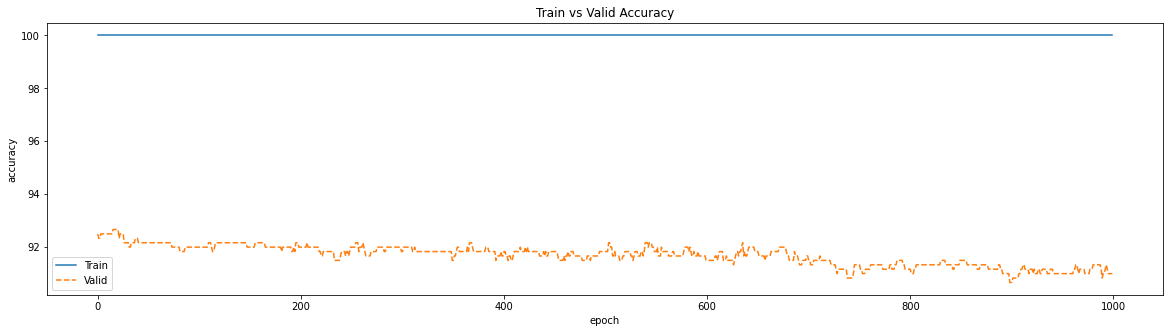

In [108]:
accuracy_plots(train_accu, eval_accu)

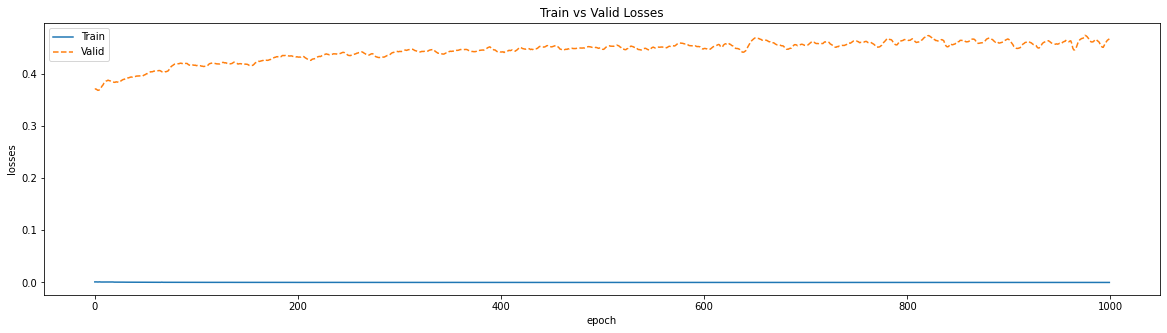

In [109]:
loss_plots(train_losses, eval_losses)

100%|██████████| 5/5 [00:00<00:00, 2203.12it/s]


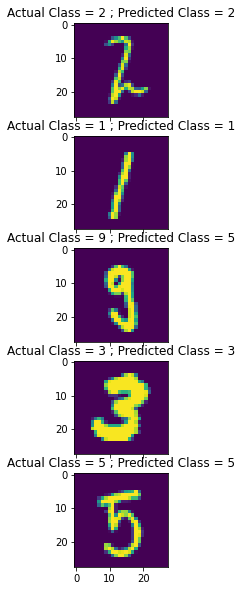

In [110]:
model = model_configs["4"]
model.load_state_dict(torch.load("models/best_model_parameters43.pth"))
model.eval()

with torch.no_grad():
  predicted_classes = []
  device = torch.device("cpu")
  for data in tqdm(first_five_loader):
    images,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(images)
    _, predicted = torch.max(outputs, 1)
    predicted_classes.append(predicted)


fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for j in range(5):
  axs[j].imshow(first_five_test_images[j][0])
  axs[j].set_title(f"Actual Class = {first_five_test_image_labels[0+j]} ; Predicted Class = {predicted_classes[j].item()}")

for ax in axs.flat:
    ax.label_outer()